# Detecting Swimming Pools using Automated Deep Learning
* 🔬 Data Science
* 🥠 Deep Learning and Object Detection

## Table of Contents
* [Introduction and objective](#Introduction-and-objective)
* [Part 1 - Export training data](#Part-1---Export-training-data)
* [Part 2 - model training](#Part-2---model-training)
    * [Necessary imports](#Necessary-imports)
    * [Prepare data that will be used for training](#Prepare-data-that-will-be-used-for-training)
    * [Visualize training data](#Visualize-training-data)
    * [Load model architecture](#Load-model-architecture)
    * [Train the model](#Train-the-model)
    * [Detect and visualize swimming pools in validation set](#Detect-and-visualize-swimming-pools-in-validation-set)
    * [Save the model](#Save-the-model) 
* [Part 3 - Model inference](#Part-3---Model-inference)
    * [Visualize detected pools on map](#Visualize-detected-pools-on-map)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction and objective

Deep Learning has achieved great success with state of the art results, but taking it to the field and solving real-world problems is still a challenge. Integration of the latest research in AI with ArcGIS opens up a world of opportunities. This notebook demonstrates an end-to-end deep learning workflow in using `ArcGIS API for Python`. The workflow consists of three major steps: (1) extract training data, (2) train a deep learning object detection model, (3) deploy the model for inference and create maps. To better illustrate this process, we choose detecting swmming pools in Redlands, CA using remote sensing imagery.

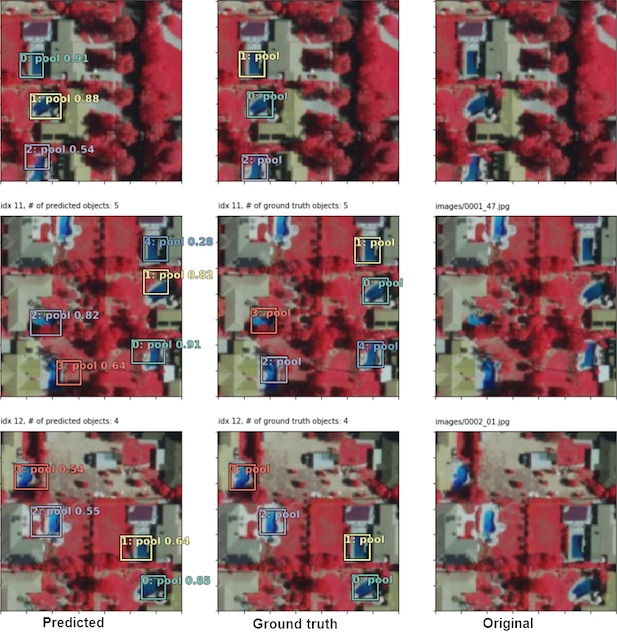

## Part 1 - Export training data

To export training data, we need a labeled feature class that contains the bounding box for each object, and a raster layer that contains all the pixels and band information. In this swimming pool detection case, we have created feature class by hand labelling the bounding box of each swimming pool in Redlands using ArcGIS Pro and USA NAIP Imagery: Color Infrared as raster data.

In [72]:
from arcgis.gis import GIS
gis = GIS('home')
ent_gis = GIS('https://pythonapi.playground.esri.com/portal')

<Item title:"SwimmingPoolLabels" type:Feature Layer Collection owner:api_data_owner>
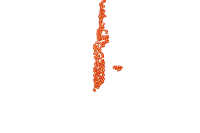

In [70]:
pool_bb = gis.content.get('0da0026a3a6d47dc8da0bcff6cf5bfb2')
pool_bb

In [73]:
naip_item = ent_gis.content.get('2f8f066d526e48afa9a942c675926785')
naip_item

<Item title:"naip_ml" type:Imagery Layer owner:arcgis_python>

With the feature class and raster layer, we are now ready to export training data using the 'Export Training Data For Deep Learning' tool in arcgis Pro. In addtion to feature class, raster layer, and output folder, we also need to speficy a few other parameters such as tile size (size of the image chips), stride size (distance to move in the X when creating the next image chip), chip format (TIFF, PNG, or JPEG), metadata format (how we are going to store those bounding boxes). 

Depending on the size of your data, tile and stride size, and computing resources, this opertation can take 15mins~2hrs in our experiment. Also, do not re-run it if you already run it once unless you would like to update the setting.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAqIAAALICAYAAACkbpLPAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P0HcJTbmiUK1kRMzEx0zIuZfu91T7Srqn5d1d1V3dXd8apeVXX17TLX1D33eLz3Qt6BAAnkJSQkEMIIEF4grAAJJ5xAIOS9997b9N5IWvN9OzOllEgk0Dn33nMP/z6xjsjcfv97r72+bf78PSzgjCaTBAkSJHzSWMy5iiPhO8JshtVqhsXswk+CBAk/WCzFSUL0Nw0i2OlJCyYlgpUg4XcCizlXcRwwWy3AtHUOpqcsMLkIK2EWeq0OrSMqDGpNUltJkPAbhol0CsOVH2Mh/6W47yREJ6eIWDEPZMW6CiuBQA9Op1Qjv30cjXKjRLASJPyG8OskVldxeKxPER/qRsaQUtCH43Yk5/fjZoMCCuJJafy7hnnSiqHqVvxhSC78qw2YsrgOJ0GChLmYmpqys9L7ndlicRnXAeZBvcEg/u0qLPsbjEYBV5y5FLc0IUqFw5QZ1bXd2POoA0HZjHbsfdSNzG4V9JMSyboCE+x4Qzv+ecgrbC/XYVIiWAkSFoR1ctLORu93HMZVXGcwsao1mvcSq06vh0arXRKxzg9vtJgBrQoXX7Xis3O12PWqG/G5PYgjRD5rxj8mV+GBjDhUGv8uwc9ANTqBq6X9KBg1wiztHkn4FOCCexxwxUvzMUkiNDMzE8nJyTh58uR70dHZ+d70+HsWmI8eP8bFixcFJzpzJvub6HN2djYuXroEpUr1DqcuxX20EOVCTA0NYVVaLX51rQUXq4eQXjmE69WDSMisxfq73ejQW2GVyOMd8EPUKlR42TyKGhlbE67DSZDwY8FChOfqe2ewdV9QWIjgkBBERka6xIHQUBQUFCyYHvs9f/ECB+PiMDwyMke4sh/jflYWko4exfjExEcTq3NYnkyg0+ByVgX+LK0d93t0YmV0ZsdoyoShESUGNWSYOsY//bVOWsSRHXFsx4VAtZC4dfgzrPPCWKzEyxSG6zIbzgyzUxixSmul7+jvJPvPW5WdpDTmxHXBT3PTn1tWbrcZv/krvpy3Uzzns58WCuv4nuvA35m4LJikdJzj286MWmfK6aKM77SlmdrK3jbO4SRI+IGBjWUWgfOFH39mQ9k5rCuw2x0UhJ/85Cf42c9+5hI//elPUVxS8g7HOcNitQreXb9+PU6mpIi8OTyXhf2ePn2K1atX48bNmy5XRZfiPkqImpgkhoaxLKUIq16NY4DIFNO8OsrnoGjQmwwYU+qhMVJYexwzxRH+DCKGdw6fUyVm/EWYeYTB8UU8G5E5wr1Dokw8TDp8Jov8mYAcfo7vHHC51TO/HE7pc71nvp9fB4rHhOfwdxApY06+jnrRA6UPlL4JBvrsSNs6r36u2sk5H66/IHb6OyecBAk/EDBJscXMROVMVkxq/L1j++d9YHfnzh38zd/8DX7+85+7xN/+7d8iIyNDGMiu0mBwfm3t7XB3d0doWBjGxsfF6oGD5B89eoSVK1fizt27LuMv5pzDsjCrKq7D/xJXiSu9OsGLc/iMwMLLIRC5DLAY0dIzhodNY8hunUCb2iTGNfODjZfM6B2W4RH5PyY8apOhU0flso99C7Vj56AcNRMG6Klds5spHcKLdgXkFMZqz8uo1qC8T4UxjQG1naN40KbAmJ7ah3nKYkBl9/hMHk96VFASN0058dDUlBUGSv+pPf3HLROUp17Uj49p6WQKPCcjm9PIG9DCQPG5nkJU6nUo6aCyN5F/qwxtSoPgPq5n/6Ctbo8ozfwBDXQcT6NFRa8cnUoqH7WBVkll71FSeY1o6qKyU/gXHQrIzMydtvJxW05RW7b12tupeRzlQxoMjMlROaKDzmlekiDhhwTmo2fPnwvhJ5PJhODj7/nvy5cvcfjwYWg0mjk8Oh/sYmNj8eWXX+Kbb755B19//bUQkFXV1YL3XKXhAJcnnwz8DRs24Njx42JllMvyODsbK1aswE0SoVwWV+VZivtwIUoZQq/GiRsl+Kfn29Gv40Hv5G+Hw0JlErUSORkVCmRVDSKtbBC3W+SQGYkY7WEsk1ZKU4MHNUNIK6cwhJudKnGY38LpUZ56uYLIWYYxtQFlrcMinavlIygapoYhgmZiMRv0qOscRwURcU83hakYRsmI1i7yzBgcGEc6xeP0r1aPolppFN/PlJkaGAYNHtY6yjGER90qIai5DiYi34fVAyLvm80yjBrM4rKRSN+gQ0HTEK6Q35XKYVEuG8Fa0Nc7inR7ve61K6Gh+pipM+W2UBkm2PIxQyNXIocIvY/qV9pIeXAb1E9gxERi2kGw1GkmjXoUN3HdKT2qXyFNKLU0eeUP6mwTlgQJPyAwQY2Ojc2sWPIqJH/HBMeicN++fWhqbl6UWJ88eSIIdPny5e8FbxMtJEQZnG9Lays8PT0RSmViMcplmhGhJHiXSqzOYc3EI4nnCvE/7vRimMq02M6Q2aLG9exWfH2hCpuyWrExrRw/udGFWrmRNCyFMeuRl9eKVZer8VUGlT+rGZ9fqcQvLnWgTKaDiQ1TtQJhFwrxR2ebsf9JG3bca4HH/Xr85/BibM4ZwhjzJJXF1NKOP4guhc+zduzJbMLWJ/3oIGGnVipx+2Ed/vZyPTbe5Twa8JdnKimNfvRQGQXHTpLAax5A8NUK/OR6C9wzW7ElvQKrcya4BdDeMQyPsxVYdqcZHhl1+O9nahBfoxTGuFapRlpmFf7qYj22Zbbg67QmpNSOw0xlry5vx/LUCnx+uxXbMpqx/m4XhvjuQXcP/iQmH7trDOKC13BNK/6P8Hx8ldmBEGqD7ZT/Tw8XYcvrEQwQH7Phbrbo8TSnCf/zWCm+uUPtcLcFmy5Rvolv8Rd3BjFicGHgS5DwAwBrkMqqKmzduhUJCQmQy+WCs3JIhK5atQqXL1+GSq1ekC+naSQmJSUhNTUVjx8/FtzmDObS/fv3o7qmZlEhyuD8C4uKsGnzZiGQ75KhvnbtWtxmw/89XMlYivtgIcpWs3JwGN8kFiGwQgbj5MI3P61EXAMDI/A+V4U1RIz7s1vwxbkKuOWOQsVidNKEwf5RxF2txN/dbMW+J50IedaIPz9WhX0vhjFE/hZqLGVdC/5JRAFWZnYiKLsN+591wI3I8D/G1SJzVCvIDCo5gs6V4D9dqEcYEfG+J924360hEWnAy9ctWHmxCpsfdGD/03a4Z1Thr0824/GghupgK8fQwBgSrlE5brRg31MqR1YdPsvsI8FpwtjoKAIv1GBlRhORfCu+OV+BTS9GSFBbYNbqcOtRDf7nhToEUvl9aKKIKxyCjoizrrIDy06XY90DSi+7HZsyOtHDK5r9/fjT2Dx4VOgwTeFGatvwL8Pe4u+pDUIp3P6nHfgiqQhrXwyhjwiWV0qNRg2u3KvFX6ZUwiu7C/sfEcleKscfRb3BT59OQMedwsUzkCDhtwle9TxO1vRmIrJiIjQmSj6f5O3tLcTgwMDAosTKIvNQfDxyc3OR+/q17a8db9++RWJioiDZhdJxgIm1mcSoB4nR6OhoYdWvW7dOrKgyMS+VWB3hOL5OM4QvYwqxsZAE2vTc9PgoDoex8oqfEE5mFOTV4I8O1uA+GdFkHQM6BYJOF2NFzgj0sKClogn/4WApkls1mOSdFP6/ZgL+x4vwf90ljjITp2iUiLxagt+LqEBkk1KEAczorGvDvw0thleNgpK2wtzWif9vZAH+e1YPJix8qcGKaTJwb9yvwJ+mNOD5BNeV41oh6+nF3xDvbiuTY2rSCu3gIL5OLMDqlyOYEOd2Ka5Jg6ZxAzRjo9h0pBAryM9oj19T1Ih/d6QBpSYDaiua8QdRZcgcMpLfFIw6PcaUOmh141gbk4dvc0bpe3ra0xaMj6mg4oUByv9PDxUiuM4mREdq2/FvIt+QoOxDv9HWDr01Tfg30WU4062nZKmtKpvxJ/a2strL0Vnfhf8S8RJ/fX+Y+FwSohJ+uGB+qm9owJYtW4QYZeG3Zs0aXE1PF7tHi3EcOzbwi4qLxb+ZP53Bbu/evWKl80OEKIPj8VY+r4x+8cUXokyORQVX4RlLcR8sRCdJsLW3tuGPYypwpUdDPDBbEJ3BCC2Btz74M2+lGNUqhJwpxM8y+0FURqlNQdbahT9PqMK1ET2mtSpEXCzGX5P1324g4rGTZy+R57+LKEFCu1aQi7qhFf+PA2/xl3d6yDo328KZFIi5UIJ/dr4NXXr6jog4Iq0E/7fDNcgb54ag9Ih4++raSfSV4FCTmhrURl4wKXGQ4v6nq13oJWLiSwXRl4rxl9c70aq3l4MEbJ+MiFKjQeyFQvzkVi+GRfwpaLp68T8SKnB+QIuhvh78aXgREoj42A9EcnIiWKNFDm+2wh8M2b6n8ijlGqh5C6x/AH9BhO5fZROio/Ud+MOoPPxN1gBkZg47SeUmgo0px/keIuEpM8re1uGPE6twvZ8nKy6HFQ3VHfjPYS/x+UuZJEQl/CDBWzl8voit6Y0bN+L+gwdiRTIsLAwjY2Mz20/vA7ubN27g7NmzM0Q6n1jPnT8viHqxFVEHpqan0drWJsj+s88+w81bt74zsTrCcRpa9QD+gThha4lMjF0jc5ZZh+cFzfjvxyrw346V4d+eqMHpdh35y+F3uAB/drsXPcQPzSNqdI2qcOV2Cf7l6VZUa3Q4fr4Q/+1GL1Qk0mxb7JTetAmVJY34/fgavJATJ2iVCL1chD/JGITcRAayEFsUzmrEqfQi/NXtPqiIMyytHfgXccU41EqC0Gorr2piBCviCuBePEFtSnEdeUzpkHarFH9wtgNjJC+LXtfhXyfUoURDbejYCaP4vBpaVtqIfxFViavtSnSNUz3Gteht6MJ/inqLPY06dDa04z+HFCGiQYYRHeXNx7j4WIFOBr+Et/ir612o1xqoPxA/Eufzs5yeJ0SHyWD/d8Tlp/opvlgp5jeQ9OPvIovhUU5CGxocPV+EP7vWA6WjrSgdwe+XqQ3vDklCVMIPHsJYbmnBjh07xHb6DeI//v5DhCO7kJAQ5JGB7io8OxaqfP7zQ9JjfmA8IN7m7XjefUo+dmxmm95VHMZS3EcJ0ebmFvw+Ec61XhKJLETJGp/SyHHwdg3+/DhZ1QlF+Pdp7WhUmzDa24n/GFaCPWVjaBxWonJAhcbmPvwkPg8rCpQY7O7BX8aWIqlNbSdszofPJKmw72QB/v7+IFGLFer6Vvyv8eU410UVnLKVZYqIqa+pC396uBIPxmxEfICI+C/I6lULIuaVTh0uXSMiPU9Eyiuf9npMUV7NNa3444OVyBony7yvD/+TrOjEVls5bIKOyjFpwdhgN/5rWBE8C0fROGKvQ9sgPjuch398Jcfo0CB+HlaANbmDaFEbSVgS8RGZWqgOh04X4vdPteCtXAc9Ezb58Vmp+UJ0pL4df0wEe4ZFJhEsP3i1vA9/QwS7q1pJ8dQIPVmIv8ocECsk4sgCE6xSBrfT+fjZM2lFVMIPFw4xmnLqFL4ki5pFKG/ZO18Yeh/Y3SKheObMGfGZx8Z8/1QSqdeuX/8gIcrxmRuePXsmtrt4tSEqOlpcUFqoPIs5RzhOX68dw+rofHz5dBi6GWHngBmyrg78x+gSHGzWA4oh/Co+H/8yuRq/ulyHf7xkw88v1GDb0wF0aCfgkViI//FsxMa39nSsU2SsNnbhv5LBnjpK6diF6F9kDdt2auxiiy84pd8ggXquHe3EpVYSov82oRJ3xogHKQyvyI6NEMeFlyKyUeXEw7ZjU2+fV+HfHGpA7bQGV+6U48+v9WLCYDv3aQtHvGbW4/GLavzT8GL8zYU6fGavA+OXl+txvpOEo0aJk0+b8EdkcP//jtQhtUWGXuJL5rv2+i78zfFS/JMDxfB/O4i8UeJFPvvuUoiW4vyAwXYsitpaQ0L0HyKL4C6EqEy01V89GZ5tKwoDjQoxV4okISrhdwbMRbwyyjfXeSX0Q1cv2X1fQpT9+Yw/r4AyV/LOVHllpe3oQGIiFErlezlzKe6DhaiVBndPZzf+GxFGXDMVYka02VZAMWnA85fV+P2TzahVmtBV24x/FUrEcL4e31ytx1dXCPR3GeF0K1nNTSRqY6twp59Erf3QPYMvJZ1NIws2rQu9RJ5aEqL/+6FyXO6hPOw3KPnc5kBLD/48ohgpwzqQaYyQi6VY8WYMGmpAEwvJKTnCU4rxx3cG5qRvJYIdbu/DXxOBnRhUo6G+Gf9nUh1ejNpWCWbKQSTd09iKPwgtwF+cm63Dl/T3W8LhejWmDDo8K27H3yXk4/eiKpBYNYZamYF404zxjj58dbYC/+/9+Vj/tBePB7Ti7KsrIfrvSYieIyHqIFglCdH/4RCiU+PYEFeIX+aOzRIs1RGKCbidKZCEqIQfPLhPa3U6cRmIb63zeShX4eaD3fclRJlYOT6fnWJi5dec8BlVTy8vhIWHz5wZdRV3MeccdtJkRMbtYvzrs22o1hJnOVYPCZy/vLsT/4kEVXwz8ZZpFGsTCvFFnpxSmRSCawbEU1MWOfbwFnzWIMxOfDs5TcZ0VRsJ2grcJmPaYYj/5f0RTMwRomQAXCQRdrUbQ/YV0T8kIXp7dFaIysYG8PfRxdhdRWKO0nXkYZ0y4uH9Cvz+8Rb0TKpx/nYZ/uWFLhKizPeOOjHv65GbV4N/ldyECjXx0rx68Oqpgfl4ehKDnYOIekSCNPotfIvGYSDDfJJEtUmhxM2CTnx5NB//x/lWdJoobq9rIXrOSYiqSYj+/YwQnYA7C9GnTqKdwkCrxsH0YvzXu4OSEJXwOwM24Hl11JXf+8COhSif6+Qdo8np6TlgFxwcvKgQZS5lAcxHlvhy08NHj0R4Lo84x7ptmzgSJZPLXa6MLsV9sBDlwlkUCvilFOAvHw9BSYN8lpAocz4oTkL0D1OaUaMyob+tFX90sAq3BolI7NvJszCjs60D/zm2HOe7NGQBOyYYPnSuQ3xqIf46o49sXCs0JET/GQnRK71EcnahOEmCrq22HX8aXY4b9hUBFqLLX88K0Ukiz+RLJfh3V3ug5m0oezmtFLezoRN/FlOGa8MaNPI2eHwN7g9ROjPlsAnRwe52/ElMBc71kN/8OtjFLX+vGh7D6dx2/PeYPHz2ZAhyKgPfMIVOiycVPdh2qgj/nxONaOCt/wHXQvTse4XoGNaREP3s9fjsigWlzyui7qmSEJXwuwHu17wtvpgl7gx2LER5a55JkOPzXwfY8db8YkKU82awVS8O29++LcrB6fE2GN+mj4yKwsjoqEsxuphzDsu8MdE7hJ8feov1uaOCC9gw5a1o3mXR9HaK40IHG8kAhxGX00vwH862o4fGNnMKh2Ne5eNOFhJxzx9W4N8Qd5SyqCV+4reDwKpFelYF/jC1Da38PZ8RTSvC751pRye/ycQeztLbgz8h7thUIBdcY5wnRLlNzBo1Iohv/zarHyMW4icRl/5qJ+B1shA/eciHkiyoLm7GH0YV42KvXvA1l1PwFYnJ/rZe/HVUCZI6VNSmtm33SeJcrgO3CV+mFG9PEceXdDiRVoA/udGLXvGaP140YAE7jfHyBvyvsWW4Okxc2/cxQpSFvBEXrxXjD041kQFA6VEZeRdqon8QX8XmkpiXVkQl/LjBLmT/fhw4cABnUlNxmgx4Z5w9dw6bNm1CyQKvb+JxxX8zs7KECGXDnTnR8T3LWb51zyujR48e/e28R5TfQVdd0YY/ii3GkRaNuMDE3zH4XOWLV9X4NyebUamkQsvHsSq+ANsLx4kirIKMOZzeSOREBTeMjWNLcgHWvhmDjohP+BN5GkcH8HcHC+FTphRb3XxG9P9OosyzjC12yo+J2KDGydul+KdMxBobEc8VokR8lF7Vmzr8q8RqPJNTGCImEZcs+HtPqvCHp1rQQHFVIyP4Ii4PG986lUNY8SbStzJsSczHGppQdE514CVrvdEWhh8QEyUpcTzMLMa/ONuGGjVZM5SGyI/bsbEF/3t0CU71UbihjxGibOkbcOJyIf7ofCsa9XaCJSHf09qNv47IxWc50hlRCT9OsOOtIbedO5GSkvIOeKXUw8PDdovzPcTK4DH18tUrsRV/i0QoW/EOYmUxyrfp3dzcEBcXJ26rfiyxOodl8K5Lf1s/VpPA+5vbPcjvlqOQUNSjwPOcGvyTgxVI7dDRWLZA0d+Ln8QU4u+vd+D5oBLl3RNIK+jA6QY2Qi3QqSawJ6UY//NaKzI7lajol+FuUSP+/FA1zpHwY8OaFJntslJ4CVY87kdxL4Wj/FeeLMGfpXWim7hK1Km5HX9Ixv8NuxAVZSXB2NPZh28TCrHq+QDyeijuwBiS7lXjz4jLS1UGEm8kLi0KHE+vxB8fKkdSoxxlvQq8yW+GZylxlFGNcw+q8M/2VyCpdYLyV6C0sRfeLwegJeH5sr4bKa+HUD6gRF7jENYfL8GuchkmTCM4cLcbJRSe4xy/VY6/udyBRhbC4tb8W+yy35rnX1r6dxHFOO3Ek2ol8eT+AriXykQYtXIQa2OL8NObnaItSzonRLv8L/vf4Cf3JSEq4ccNFoyv37wRlzB5NdMl7tzBwODgDP+5AnNFWXk5XuXmin/P50PmzKqqKsGpri5RLcV9lBDllwXzS4/LCpvwFydLse35MBGSHAVEsuWdY4hIK8b/dr4dTSpSzhYDXhY04F8Fl2B32QiKiBzLWgawO6cXbfxqkikTqqs68LdxRfAqHBUkXdo3iICz5fjJ9R4MUF58a17d2IZ/EvoWv3+mEedqx1HWJ8P1F7X457FVONPOREykpVZgd2oxPn85OiNEeXXVZFAh/kIp/q/zjbjRpqCyyvCgvAV/FVeNY3y8gCaCaRLQecUt+C+hhXAvsJezohPurwYxrjOiuLQRvx9SAp/CIRT1kV/rEIJf9qBJpkPrQB8OPu5DWb8Che1j8Dldgk2vRiCbGkf43U7kd8lEemf51SXnWlDFKw79/fhPB2dvzbOl/6/Di5DS5yREZb34P/cXwruSLX0LZBMD+IYs/y+yuvG6X4mClhHsvlCE/40I9mvpspKEHymYWHnFkomVX6/kCry6yWEWI1YOw68vcXx29mdibWhsxIucHHGe9WOJ1TmsA5wHptS4ld2MVdcasPpGo8DyG00IIeNcQwYtj1k+8jQ+Ooz9FGY5+6c3IuDFEAbpe/EOTkpnWqvF9ZxmfE1+nNbazA7kDPNRIionlZWFKJ8R/asHI8gpbKN8KD8KtyZnCHID5cHii+s0OIxdj7pQrLB/5ygrb6+NjCM0qxHLrjViZXo9duQMokdrJh53hLMZ8m8LmrHyuq0uq2604tkoC1UKN63BgxetWCPq2oBl6W3IHtFR25rQ2tYH36v1on7fXG9GUq0C1ml6BnoZjt1uxApO63oDNmQPYITS4lVl69gYgh+14lYv8SLlK+sZQtD9dryaMAoxyc9IqxlH3L1WXOpQi7bg97OqZBNIuNeAb6mMK29T32mcQNL1Ivxn6fVNEj4BMO+wob0QFuJKBxzpuPJjsP98HnVgKe7jhKgd/G44o3YcB4k8mJRsIAK61YbbnSpYiETF+SHoUVjaiU1X6oX/yrQWXCV/fm0Sp2MhglF2D8LtNvkJAmxAIJ8d4kZgsqG/yvpW/PMjlThdJUPC/ToRZlVGG9K7NLatamrUSZ0Gt16341iDco4o4wYntsPjPJoMiMRXEkmuutOGBwNzt+H5Zcy9Lb3YcZPKyeW42oSzLUro+dUoMKC8qhtbr3BdbXU4T34myntsZBghRNqi/hQvhMs+xe8OVOBCVpPIT+T5oA/dPCHwmajxCYQ9onbo0gshLO8lgs1qw8vxWYLVqMcRfa8N17o1YpuLb5PKRkcRmcHlozSpDo+bRxFwvgB/90Tampfw4wWPh/lEOh8fQqyOdFz5Mb4LsbqKYwMLNN4tmQs+K+48Xm3b1nP951xyorJPOqdD/+ZfVhLvD+a4diH651nDUFptb+mwhZubD6fD5XH1blMheOfkMXvW1BnC8HeEIbDx7PATx5Fm/Ijr2M/I592YR2f9+BeSbHHm1lvkaU/LUVaHEHaUzzk/R3w+BuB4lzKL2OmZNCfFsa09Z0rwLb82kMox9/KYBAkSvm8sxS1JiDKEyJsZ8LPg7WvncOK8kXOYef7iJrmzv9OhfIcQFZeV+uaFm5MOkQ+T4Ly0HZhLkLPk5oz5ZOmcFgtGV34mIVSdvp8p+7sEK267M7jdmPCdCJbDzCFYR9sSqToIlifJ2TRpspGNY31yMdwrFDC+p94SJEj47ljMuYrzG8M8Iep8WelTg15nECvAfORBACY017fhP8RW4vK8Vw5KkCDh14OluCUL0d8EnIXoJadb858a9AYj1Cy2iVzFz3zCiPLSJvzBoRo8H9PD+WdFJUiQ8P1iMecqzm8MQogqEHouH//lzhDGP1Ehym9uGWxuw1+nt+NZ8xgeNo7hdlUr/jKyDIH5o5BPmWcXAyRIkPBrw1LcD1+I1jbj/xVdirPdn6YQ5e361tpW/ENGF/I6J/CqfQKZFS348/Ay7K+YgGb+Np4ECRK+VyzmXMX5jYG3sHVaZJd04mitQvxq3ad4TIfrrNPLceFhK9yyWuFB2JHVjuPi/dDzjihIkCDh14aluB+2ECWS1fQNYdeTLuSPmcVNdFfhfszgNlCrx3HkdhM2OnCnDWf5gD6fkXURR4IECd8fFnOu4vxGQcaqOLs5+amfFbcfaXLC7HlUCRIk/CawFPeDFqICrs5QfmJweR5XOhcqQcJvBIs5V3EkSJAg4VPEUtwPX4hKkCBBwm8RizlXcSRIkCDhU8RSnCREJUiQIGEBLOZcxZEgQYKETxFLcZIQlSBBgoQFsJhzFUeCBAkSPkUsxUlCVIIECRIWwGLOVRwJEiRI+BSxFCcJUQkSJEhYAIs5V3EkSJAg4VPEUpwkRCVIkCBhASzmXMWRIEGChN9V8Jt65sNVOFdYipOEqAQJEiQsgMWcqziuwD/Ty793b52cFLAQ+LuPIXkJEiRI+HXAwU96gwFKlQpyhQIKpRIqtRoGo1H4fQhXLcV9b0LUoZq5Mg5ylQhWggQJv00485HjO2eecg77PizmXMVxBufHwpMJvbunB80tLWhqakJ7RwdGx8aEP5O8q7gSJEiQ8OsG85Nao0FJaSmu37iBU6dP4+jRo0hOTsaZM2dw5+5dNDQ0zHCnqzQcWIr7zkKUC8UkqtXpMDExgZHRUUGuMrlcKOsPVdESJEiQ8H3BITR7envx/MULXLh4EceOH8exY8dw4cIFPH/+XPg5wrlKw4HFnKs4DnDazINv8vJw9tw5QepnUlMFUgmnifBv376NgYEBTNJk4CoNCRIkSPh1gTVaX38/Ll26hBMnTgi+bGpuRld3t0BNbS3u37+Po0lJuHfvnlgpXchwXor7TkLUoaILCgpw5epVnDp1CkdJQScT2TPB3iBlXVVd/UEqWoIECRK+DzBJarRaPCOxmZCQgMuXL6OgsBC1dXWoq69HPvHV5bQ04feCSJfDfhdidRWHwZw3PDyM8yR8T548iZKSEkH4EzKZMNSHR0bE6mhGRgYSExNRWloquFIy3JcIMy+KfNzvypvoGVkI0m/RS/htw2SxEmf8Zsc+815NTQ3i4uLw4MEDKEhkThOnsbabnJoSmJqeFhgYHBS8yQZ9b1/fezlzKW7JQpQLwaTKKw0pKSl4lZuL1rY28R0XsqGxEdlPnoil3dtEtIupaAkSJEj4rmARx7syvPrIK468/c0k6iBWdg6CZb/TZ84IDmNR+D5jeTHnKg7nx+kfPHgQmZmZ4syVI192U/SX+ZDDcb4skuMPHcKDhw8/zmg3T4qJY66bxiQJMpfhf2MwwzpF7W5x5UfPyeqq3HY3PQXzEn7S2aCWYWB4FCo9iXkX/vNhMhmhlo9icEwOrfHD4iwJZiv1QXvdnNz05Mc/IzO12+SkdellJbE+aeuCc9zk9/yT0SaLi0zoiVt/w0LLJcTzmIblB/Sz4SajHvKxIQzL1DDQ2HEV5vsG8wxzJYtQNpKZjxzcw7xUWFQkFhRZuzGvsj/v7twnwcq8yQa8K65ailuSEOUC1Tc0CJJl4uQDrTzOmGSdSZ//zQSfduWKWCVlkfoxYpQtBA4/F79tgrWV672Wi/2BuQafVXMR53cVYgXi+6ijmQiWj3C48vswiJWN+WX5vknPZX2pL/wAnqmJy0Zt8Cmv7DhWEnkF8vr160L8WYmH+DvmpA4Shrz6yKuRTKDMUcxd1yjsxUuXxIF8V6uRi7n54blPcN68CsorrvyZ02Xw90z6HZ2dc/LiMLziEBcfj+qaGlFe5zRdguLrJrpQ9Oolnj19Igz/7CfZePjkFWq6xmD8rXEl1dWqQntFCVqGdFTPuf4myyQmemrw8tlDPM5+gqfPc5D7OhfPnz7F48eP8PRtBQYUxo8avyxsx14k4Jerd+JZJ4s81+FmQG03bVKj4JQbvgo8iWY5zV/vEc3fCTwuVUOoLMnDM/F8bHic/QwFHTLqPdMfzB9mqxHjfY2oqe+GyrgEMcpl0Y6jobJgXlkeo6JTIdrEZbyPBPdrzVATXr3KwVNHPpTHo1fF6JLTeJr+bS5ImWFQ9KC8uBS9CssPgruNNB6g6sKFfcuw+ehLyIz4tZeLn5FOr8e58+eFocz84+zH/Mhb9du3bxfb9A7ByX95Fzz17FnxXDmsM48xluI+WohygXlrKZ4Is7CwUBSMwYXhw/gsNrmgzuFZRWdmZYlVCj5L6qjU+8HWqR4yshC6OtrR2tYqVltbW1vR1jMCjdFVnN8MTGYjlOPDGJVxHec+AG4DrXIM3R0taGltQ1tHJ7p7e9DRzmVvQWtXH2QanuzmprkQuK36nx3GWp8IlAwAU1bX4WZAIhmaAWTE74B3CnVqw6+vU+u4rt1daHN6Pq09Q9CYpzE99RGToFmL8cEhyLXUhq78FwGvbKhkw+jq7JgpS0tLC7qHJqD73lY6iMA0MvT2dqPdqb4tnX2QG4hIpn575Mr14343ODwOjeH7qu93AxtrY69PYK3HXrzp/YB++z2AxVvOy5fiHChzkDO58g11Npq3bt2KyqqqGQ7iMCxGj584IXZ1XAnAxZxzWAcpZ92/L4ic+c6ZqFn0+vj4oLKyck75GJx3eUUFEhITMTQ8vChPmqmNx6svYfPXaxFz5hZu3riG9PSruHztHgqbBmGctPHyO3HpO0cfmeUi24TiMjzB4WfDu/42OPynMKmvw+Edq3H8leyd1VmzdQpjbYW4dzMN125eR0psAL7+ch2iT13EtWtXcP3Ra/TQbGxbPbOl+W4ejNk0+bOmpwIPnuWS2CED0e7nCOMqjoXmmP7aXDx+W4Nx3eQMT9rCzObjCD8HM+nZ/d8XjugY3S/hs2EtAo/YDKT0a9dx9WoCPLcF4eLdF+hXY87KsSNdGxzfWzA1rUFhejACIm+hX+ccxzn8e8rBsE4DI+WI8tgAt6gUpF+/QWW5RmW5ijfNE1QHx3NaOL3ZMrn25347+CQBv1rhjqOXb+LG9Wu4cfMKkg6HIsg/Ao8q+2EwT87jqffnt5j//PK8Pw0CiT5NWwY81m5FVssUaWIXYQQWSmvWz7k/OTCnPO987yIutbtVL0d94RPkVPVCazcy3q2X4/M8vJPeAvW3g41wvph0/PhxwX8c3+HnKN+ly5fh5uaGxqamOVzEPMVzX1JSEvoHBt7hsaW4jxKiXDi90YgrV67g5q1bM4Xj75n4T6akICQkhCZr2yUARzwuqJIqy8u8L3Jy5vi5BHVSGHtwPXonVm8KQER0DKKjoxEVGYmDqU8xbKA8XcX7tcNKlvYw7h30RPTVWugsttUWB8yTRLAteUhN3I+IqBjsD/LAsi+XwXPPAURHhiPm5BVU9+s/ahuE23as4h4Op15H8/jUe7e6ZkCdelI3jrcZJ3DmcTVZzlOUhotw3xG8+tbz6BA+X74JeyNjEUPPJyY6FN679+DI6Qw0jRqorIs8ZwErWagFiNq8HXcbiGw/VrBQfaeNCrw5swtfrPNAaHSs6CsRYQdwJqsI4/qlbfPNB6/iqArP4ZtlNKGEx9jqGxOBwL2BCE+8ippehQjz2+iXVqsRTY8PwnPXMTTIfk0rOx8JXqFV1D7E4VOXUTfyAf32O4I5ho1gvunJFrwzOfIY4s9ZZAyzEC0vL3+HWBsbGwWx8qrkxxKrc1iOy+TMYritvX1G2DLxv379Gn5+fsghDuSLSVyu+eCwfN7+0ePHYpfJOe35YLE/Xp0Gn53BKByxlcXhePvWoNdCpdVBPzMhch5GaIirtXojjEY9dPTXRIJPo1ZAThyt0pBwpn5sduRDz9FCfKXVKMWEpVCqhLHjvDOlN+igo78GnUaEUWoN0A3mI3rnOpx4MUhzgxoazs+RJsFM9XfsVg8UX8WOzcEoGCR1xW6a2ozS5HLrKF+5kuIbKD61j0GnspeD8tHoSVw5rQxSe0wSB8+Md1E/aifeglfZ6qfWUX1518Yeh1dSnbe6DXrK10h1M+pozuLX16jEtr1zfzFz3Q1aMafJRXsYYTBQXlxGe5gZkBCd7snFru1+uNVqr59wJvSUPEfY9q8RdaMcCguvjPJzouej5nTtbU3l57yZw83aYbxI3QW/mJvoGKdw9GwNHIfKqlLZn49KTc+CF4dczDEsREcrcdDXB6eLh+3lsLkp+5xkova0mPVO6WlgoHadTc9IbWrLVyfKqYZ2Xr25vANPj2JjwEm0OA0fq1GFgqvR2LrJG5nNypkVb+4LJoNGtOdM/3Iqv8Pf9tzn+Rupr+kNoty2vkL9Qk1lJg3hkvfNVmg6shCwxROPWqdczjdstBr16pn8+PnP5Efjwah3lIWg1traZ6bPcXn0MNC/NdznqP10pJm4f+gpnTn9iuox26/o39R3Z402I/SinXkcc1koDqWlp/y5n9jCcNtYxLiztR0/ex6HNB4pT0cYV2A+upqeLi5t2vqXrSwM5jAGn61nIcrn2JnHnP3579mzZ2cWI53TXor7KCHKheezTEyyo+PjMwXggjHJBwQECJJ3kO/8uKysjxDZj4yNvVP4ORBCtBc3ot0QeaMR9MnJsbDi80c0wKectyfIqpiexhSfu6GHNclHBKjzWCanBeEx3j03Rf6cjt1/ms8mOfkzSU1NTVL96K/ImZx1ANcityP6dosol3VemhzH4SaaH8J3kz+etCnt33A+VC6KI8pP/zk6+Jxy8PdOg8gsYlJeNIlwBzdR5JlyUQSOw59nyJTqb3PUVtShuZ58XovrP9setnI48hDgdhN+Dn8idj5L40JEcLm7HiRgy77z6HZ6QKrBelzctxnb955ErYwHjS282ek5iLTt9eZHPTn0AkHbduJhG6dgn0j4GVNgR5yp950bozJPG+V4dWIf/FNeQMVJOBxNaDMTDk9SM+lRW8w5Z+VoH6v461w+B3hyVhScw0aPeNTobcmzM6o6cCvGF1t9IvG2T0/9ejaeRaRlLz/l55ze/L4n+q3dj/OaorKbRT+2h3nPc2CwEG1+cgg+e06g8T1ClI8uOKc1p36LtDUTJJffQn/Zf3LOGHP0ZcbcfmviLzm8xdFvHeNp9lk491sbuF1s+TBYsIln49Q+rsD88vbtW0GePBE4RB2D/+3gKFdClP15W563qYqKikRYhx9jMeccluPyqiZf3HRs9TMfsjgODg4W5M1GO5+vUjtBQ5MHh+ewFZWV4nb9/NXU+ZgRom578aaP2tJpUjXRAx0ry4D31jVIetRF45rafcqC7tyT2LAtBNkkBMbfnIa7+1E8Kc3GsUhf+PkHwHPndlzMH6QJzzaRWyb1aHh5B9FB2+C7azd8Pf2xN+IC6pRUNuY6/TienwxD0LGLSDsZi11B+3EwKQWJ+92w6puvscHNh/rlITyq7IVpDl8zqG1gQUfeRWzftBevumUgPQaM1SBpTxASMzJwOiKQDPlEPKsbglE7gCsHPREQuAu7du3Czi0+uF7eDy31RbE6/OYMtvonoUph669j9HmLTxxuPbyNhFAf+Hr7wts/GrldKiq7FVMmNYovhsMvKQsD/JjNKhRfCodH9GVk3jqJ/Xv84bXDHfsOpdG4onFAY8ZM6erUdTizyxeeXr4I8AnEwbOnEBfgRXNV3bvzml2I7t7ui/Q6+Qzfi0UNqn1rzkms3xiG4l41FWAKPVVPELfHDf6B3NZeCNifjNIhElqmYdw/EoTtG1dg+dqtVI8gxF7Kg4Zmh8qHpxAS6InA3bvhRTwafjoL3eq5gsVWFmpcIUS9cTyvR7SBs7+ZxKhOI8PLizEIpPrs2r0LHpsDkZyRixEqr4kH7VApYgOCkJx5BycP+MFrXzJet4yIdplJh9qAhegGv2OoU9HYtfORiR7uNEaREboDm6IfQEP5mycNkPV34tpBD3jTc93tux3e8dfRygsZVH4T+U/0teNqrDv57xb+PoduoZ2EOBdHXn0HAdsicKf4NS4m+It28962DocfNELJizD2Ms1gESHK5RntaMQFmuM5v12+2+B/9D76FDQWqDwWoxLZqcHUPv7YTe3tvmknjj2shJxXMal9LS2P4OsRjAuPqM8FecEn8jJax2WouhYFdxo3mRmnEbrXD95uHthzkMbRuI1foe7GtZjdiL5TCQ195K369JhdCE59gLvnI+hZ0DjY4obYKzkY0vE4Yp60YKI/F1GbqE0CAxHgvQtHrp9D6HZPnM0bpunPNXfw8+Hd6xTiKD5iydypJ87ktx6Nka4bp78M3sHeuXOn4MtxmUz4MViAs+Ob9LzzMz/9pbiPFqJM5gye2Pg7B3EGUkPw9jsTMVeUCXQ+eMLjc1O8LfXOgHWGkxANu1JFRDPboZh8TfJ+ZJ4Iwr7U55igh2JhYabtwI0j4Yi4UQHzeDMuxyfhfk03Xl8Pp7LtRoCfN1JftBHB2lYx2So2ahV4fCqQOm8Qdu8KxN79V9BksHU4Jp2BvHTEnM5AztObiAryx/4j53EqxgcbVn2L1Zs94bs7ApefN0L/zmTKIsSKgZp78N7oi/v1w0S3JJKVXbh1IglX8kpw58g+eO1JwJOaAcpLi6epQUSwVA4a/Lv3HkHhkFFM6txOw/nXEHH0Njq1toHTm5uG6DOPUJyfhbj9RLA+uxB37hH69XwBwkJtMYxnF47i1JN6qFlEaPrxMDUJ53Ia8OZGNJF4IPx8QnCtsBN6mky47NyuenUNUqnDB1AZAgMicavgGU5HHkZOs2qOUBL1o/ZhIbp5zxk0a2fFD4sri74ah7asxb4bNUJAcB1Kb8dQvgHYHbQL/rw90yQjIrGgNe82ovw2YtnX32KbVwD8w1JRMaCCXt6D60f84EdtEhgQiANxl9CgIKE4X2Q5hOjJffA99hgjpNrnH0K3kGAabXyN5HAveta74OcdjFMZxZBTf+YJjNvnwZmjOP+yCFknQuETFIvM0q45E6dDiG5wj0WpjCxXezm4q05Zu3Bh1ybsPJFrGxfc38kyzkvbb5s0A3wRe6MIaiIrYehwGK0ST8/sFn1vV4AfDmfW2ixr6ssjpbcRc/AWqrorceGgL3z9AxF0IAqvOkn8uVhNX0yImknIyTvLcSbaC37UloHBEciqmhDPlOulGe3AtcMkRLitKa9QmniblCQA6RlPmjSounsaSbee4fnNkwiiSSjlYT1MY5U4FncUjyubkZEcQHGpz+yOx+s+PnrD7UUkWXYb4YnpaFHbLP2RwuuIPHGPxF42Dod6U78NRMzJe+iifi2eq7hEIEPelWPY40PP3jcIyTfu4PbZZKTcraH2cc0ZDn7hd91lZ2dTGtM2vnHyX0iIMtjx1j1zGAvC+X4LOeewnNeTp09x8+ZN4SfG78gIjhw5IlYX+GInb3ldvHhxBueI8LMyMwX5c9n5LCvvHnG8+aLYGe9fEbUZGjzBVWdFYPuOwygho9A6VICwbZuRlN0ijNuBnGNY+c1KBKdcB2kz4TpfJmPLFl88qFczY6Ex5zB2rA7B47YJ4T9tluFe/GZsDU1HD8+YxnHkpOzBz1ZuxdWiXmHQsECAmjjAcwNSCzT0gXhpRoA5431CtBqJu3biK/ddeNvDSo7j0+Q5WIEnlAfXj4M13w/D2o17kNNjpCwmMUYie53nIVQqeEHCiok3J/CPv/oc+8/lgOZ7KpgW2Yc3Y0vIBbSSQIJFjcJzwfA4dNcuRNUoubwbf/fFGpx+3kElI+Nf3owTfsux69xbqOgLs44EQ4QXvHh7XNj7OtRlHsWqL36JoOv1gn/n1PG9QpTHJemNzrcI3bgRKfndJPq1aKgrQW2nbaKf0o/getgauMffw4AwfrUoTNuHXQlZJAwpXWqXSV0/3hRVYYTPXpIzDBQhavsyhGXY+GRuWajOLldEub+Q4WEYwr0EX+zcdxkdeio4Oe3QW0RtWYkDd2oFt2OoBJHe27HMLwQlA5SeMJjnPlvu866EqPCjNFofxGDD+nAUU9eYUlXjMI2L/ZfzSVSTs4wg65A3PA8+wQTPJYoKHNq2A6FXi6j25MxDuBtH7X/oOeT0UVGZAY81K+AeeRQ1oxwAkNVmwGvjWpx9M0L9cd7zWEiI0vM0jhcgfN0OHMysgoETM/TgapgbAk+8Bd+EsSia8DivSfC06KrlaXBbtR6XKng+o/7S/ABb16yHW+wJtCo4AQpn1qIyfR/1q1U4SWNPdEVlO07vWgH/07mQ8WBUdyEt3Bdht8pBdEkdoxtXY7biH1Z64kGdaBmo254gaP1yHH7RI56FZqwYCdu2ITQtH2zGwDyMF8eD8MtvVuPUa3q+7zkex8+HX7HJXMRb7Kzh8gsKxJ2f2NhY8ZexZ88eeHl5ISIiYua7mJgYcVGJuYp3dvido3z00jn9pbgPFqJMsGyh86F+PlvAhMkV6unrQ0RkpFgNfUhEzq9Mefrs2QyePHmC+vp6kQY/OH5nHn/nPFG8AychGnGjkchq1vEqKC+dD1Tehu8adxrc1PumTSi/E49N7gdRNqqHebAK8USCa3Z64Hpxv9iu6Cu+Bd8t1BFyidyJoA2aKhwltb/31GP0K+SQy+V4dtIDW/ySUDlBOdIk3fPoCP7xi9WIuHQP7cMqsTSuG2/A+QNbEXqpBCMy+k6jo/K+W4d3hSg5WSOO7/XGtzQZ3igagEyugFpvgrIvDxfukDBSyDBB3704sRObfA+jcpyPAljQ+zABa32PoYH7I1k5XQ9i8Xc/+yVCUp+gZ1yF8e5qJHl/i5BL+ZBzRtpepIf7YO+VIqhEp6ZOHrEFf/8VDRiyhJVkDbW8PIud6zbjWq2chAyJc10dUrx2wP/wffSqqF69hTjquw4/X+GGjEoaUfM69fuEqPCjvlF01hebvM+gnVc8xytx/tYrjIyNQ0bPojIjCps2BeBZD1n6Bh3GmzIRuHk7bpTJoVQooCcR113/HLee1EClUmBidADpoSvhEXsTXToSLc7t7SRE/VOeE1nMOhbBPDF0l12G1+pd1ObNkFPdhtvLkOC1AvuJ3NTcuVSduBTuj682bsLlvG5MyBRQafVznuv7hCiDm7wxMwrrN0SjSk+93NKJy3t94c3lVaigHCjD0V07EHG1GgZiK4uxESc8PbD7+EP0cVt35yHaazsOZ7WKtAZfnsDKL9dg95FklHSqoFJO4O2FXdjgG4timv2m5l3EWEiI8i3bifYs+K3wxrmXNaL+bXnn4Ol+AM+bFDSOTeiofYqMZ7X2tu7DlZAV8IrLQA/XxaxCwflQfLZsLY5kFmKI+ptCT23e/Qq+G77Atzv342WTkuKqkHfWDxs9YlA8SoKShMAoCZ3V7odQpSThQJ+Hnh/GP/zsHxF0PBMdoyrI+puREvAtdp9+gTGeWCc1KL0Thy2bopDbNkj1HkDetYNY8fOfwutcqRBezvV2wMFNvKWd9/YtP3p0d3cjLS1NrECy0GNERUfD3d0dhw8fFp/Z4md/fquHmsYEb51fu3ZNrKiyMeFIfzHnXBYGH/6/R2C+Y44sKysTKwve3t7iL18AcMbmzZsFh/KWPsfhd/fxC6UXu9zJ7TFRdw1uy1YjICwecQf5iEwkYo9fRGm3FlPEQWZtJ075bkb4jefIPraX+mQmRo00hmhc9j9Pxpr1XnjQTjMh9ykqq0ndh3O7NiL4Yh4U1n4c374awWnlxMEk7o08tqegaHmG3VuCcK+B1K+F+Oq4O77Zn4Zees6i79EsOSkvR5zHepx+Q/ziUoQy3idEa5EYsBLu5yuo/rO7a3wTW+xaUZtYaRwZxl9hz7qduF7Gl36mSIimYL1nAglREhjU38ZeHceqndEoGiESJN60TpnQVXgGGzaEIq+TyJT6W+G5/U5CVIXCs3uwOeomGfU8jnj5QI4354OxKvASxkhV9pdfx7bV/njeLqey0LMx8xghURG4Gfuu1HyUEOUVRkNfGQ66b0Q8CRQ98TDXa5JENY9b6lmoI+7fGXAKrTwnTSmRd2kvAuNImBLn2gxuMk7J0LRSfS0sNDGGB4d84H3kJbQmF0J0pAqHArdgo+9+xArhwUfeLqJ8XI2R5vvwWOWBzLoxqje3u+35NN9NwPqdJ9HGD2eoDJFey+Gf3kj86rpvLiRETVQt5rcNG4PwWmZA471EeAVdElwjdl2oBnoSdxs2RqBYb0Dd7Xh47r2CfiOlw/5UBF3pRazfRP7UBuoqEqLr1uFMCT0P+wqgxarB4zg37Iym50jPdc7CxHuFKBlqJIV5hdwz7A7Ged7ifkb5yV6fwLrtZOBo2Djn3SpbH6Thx8qTdMQmHLzfQT3QLkQ3rkRSLhluU1weM6bImC+7FIyNYVdBw1IY5dM0UxWkhWKV31maAygzDfEVzUGzQrQLl8M9EHi5BDoqhIk00fR0D67s3Y5tSbk8GlFxMxYrtyagXUvPifmKGmdKUYDgjZtxKndhIco34XlFtLm5eWY3KSwsDKGhoeIvgxcXWYjyTo7juwMHDogdcRairOPu3rv30Ya7K/fBQtRReCZvfjeoY9XhBln+O3bsEAWeT7CMLVu2iLMInAbHefTokVi5cE77HdiF6M1YD7gHn0RG5n1B7nfv3kFOdR8MNMCmqNMUnAnG6t3n0NZKVpu7Jy7m94qObBogi9r7G3idLQCf4+QtTiv0eHMyAJt2n0cfddiKq2FYsz0JHdQxxQoodSy9ohqx291x7HEzpTON/sdx+PnGXchuJHuDSEe8ksJIFlLEdkReb4CBO4ir8hNcC9EWnApeixXxT4gkiGwcpETlY3HN/Y+deTgbfjRB3K1mWTWJvsdHsCnwJBrtQrQzKxbLvOJRNkSpEmlhSo3i62EkVk+jU0GfyUq+ER2A/ddKnISoG9xPvoKaTFJeQZ42NuO4z0YEXKzkHFF1KwZrtxxCC5+/Ee0xDXX9dWxc74k7VR8nRNlabL0XTeQVg1IyaycpLE+oVDKbM1eTlb0Jx17wxDsNY98zBG11Q1YTDTY7mYhb4LxlYXfDZeewcwdNKr1GqrK93RhCiPIZ0b1Y538Q1zIfICvzLjJuP0ZZ6wj0liGkeKzC/otF4BNaFgpPPQLtOanYtD0O1eNk96ppgEduxFcRdyHXT4q6zX+uCwlRJteh16exifrKq3EL+nLPwcfnJFocZyrIqfLPYNOOI6i3Ut73k+C5+zL67X7shp4kYrNfKtqI3EZepWDNms24WkHPn8U09Q39RCMSecK6VwktEYdz+d4vRHllfxwPYvwQepEmdXtemFbjfmwADlwtgJKamNvEua0HS85gx06qZz9VgEi9+Lw/fu51BLVDRmEY8QQ63Z2LgG2bcCSnX0wgvE2rG3wK79XbcCF/iFKZwuirk9jgfRjVdiE6+PQwvnULR34vpUvjY3pah+rMGKzzOIpmajfdUAlC1m/E2dedYvzxVhc0rUjZuwm+qcVEtAsL0XTimddv3og68Nkl3r5lA9kBX18yDoin+Jym4zt/f3+EEsHyLx7lkhBlPhMWPhO7Pf3F3PyysDHOl5LY8WcZGbn8KikPDw9hiPOlKL5U5QC/QLq4uFic8+JJob2dhA0JUX61yqIrojVX4LXFFxlF3ejsaBWX9Fo6ejCuth8LIH7oq8hA4Npf4Jef78PzAZVYVec+20dCdMu2JNTy8+c0eSwZ5Hh5fDe8jz3F0EAuAslYPfVmdlLjeMaBCsS5b8KhZ2001yrw9Ogu+J96jjF6rGLS/85CtBqH/D1x9FUPiSeHEKV+Z9RirKsO15L2wNOXnp3PVqxa54lbFbw29q4QHX3J/e8IauxiiDl5uP4+vD334WULc5r2HSGanxoC78NZGBJ1MRNnmVCbeRjr9p7BqEaD2qwobPBJRv0ICQyxO8G8NoCb+3Zif1o1cd/HCFEIIRqzcyMOP2ul+WQKep0GnQV3ERnsB78Af7hvWo6N+y+iQ0aB5wtRwVMGMtjkqL5/gvqzHwJ3+WLrqq/hc+otdK6E6Ggl4vw8EJ1RgFbqZy2tLWhu6YHSoEPLcxKcO2JR0muY5WHKdqzgPLas9ceTIeKI4RKEkxF9puj9l+kWFKKUBK/Eb9gUQgbCMB4n+2HZss3wDwi0j0n660m6weMgykeHcP+ID5Yt3zLH35/9Pckop0eorr4Fz/X7iXc1MyuzvLvSkhGNTXvPomXe3PReISo0Ryeu0Dy5fNV2WznsHOHnvhU7ApNQISehZ9JBPjaAFxfC4eUXQGLNE+uWr0RCdo+Yvy1N9+G2xR8Pu6gcQgDbhGjpxQPwiM8QwphFIzEmGh4lY8Pu4+hWEDO/I0Q7cSnMH5F3q6AROoM1jArPj/pj85FnlMgItY03tsbch1xHBqfdKDFaanFk8zYSosTB7xGizAv8jHg35m1+vm1+Ic7jS+gsMPkv4xwZ6WJrvqJCcBj7MRQqldByfFeIuWx+P1iK+6gVUT5XwK9G4YI5hCi/hJnPSjDp88tOedvJGVxZnhQ4DeYYFpS8BcZxndOfAychunPvMdy8c0+8duX27Vt4XtUr3rPFolBPg+qo/yZscSfVnpCJIRN1erIOjQOViPfwxKn8ThiJiDlNPlc59pqIyi0GlbIB3IrYiR1kNXLHtOVJD1qvxIPYnQg4btsW6Ht4CBsCiXSEHrCXy9BtF6L1JHLmXlZyhmsh2oyTe90Qc79pTlxOdlo/gbw7JxEbn4C4mEBspHhZta6EqAntmfHYGnwB7aShmOS5U7e8OIWNPolo5qUl/Xwhyp06ANH3aqClduBObcE47kZ5YMcJmritQ8iI9cSWuGzojET4VCYWgmp5HsI3eCFjiUJ0nVu0EKJT1NH5dSr1zy7gINUvMfEAtq1ej5OvBsUKh6H3qRCimY1kYNiJgSckq6wDmZeSEJeQQMS8Exu94lC6kBD1i8GVO5m4c+c2bt54iJLWUahHnsF39XacL5idTHl7SNf+Ens37URaPVmuRAKXwtxx4GYlNJSxK+Piw4TobrwZHsOzk7uxer0f4hMOixeVJxw+gnh67svIii+bGMLdGA+s3RpEfofFDWn+Gx2wBavcD6Ga2nI09yQZcLEo1zgJBB0JykM+YtV3jDqT8xnO9wpR6lgm2VuErFoJ931xSDpMZaH8khJi4LNuNXafyQHpP0Gg1ok23L14RLR1xD436ksJKOfZ2aqmyTkI7ofuiO1BITSIGHlFNHC7PzKaVbbJlcqoV9ch1m0rjj5rpxSn5wlRC/qfHKV+nIIm0V+435JRlX+JJpVo1AxpMVx+jvp9CF62keEnnhUbnKO4H+ODPacL391qdAKTIZ9Z4nfcsZjjCzl8AYl/FYTPtfOuDP+iEhvNHK6OvqslP/bnNyBwHP7VEL4kND/txZxzWBaO/Pol3vYSZ1WpXLz11dfXh6ioKHFL1fECfS6zMxzxi0tKhMHPk8NCPDmzNe+2D28HqCBkLHN8XpWzXVBkIWpFe95lBKz/Al9sjsDLTqUQUA4hunlrIqoMc4Xoi+TdCEh5idGxPOxZt4XGzjg9MFs5OJ6JhGj8zq04nNNuF6JBCOBVbepL358Q9UHy627qa/zM+ZiBDqXn92KVWwjScxqgpf6kmniDcDKUb7xXiJ7Aei+qn32lVgjRhofw9WMhStz6HiHqmZiJQfrMQpT7aN2DJGwMZiGqRe2DWPiFnEc7UaJtnPFxEhIRQdsR8pFClHXhEBkJXp5U904VzIo2nA/ejI17U1HeK6O8dah5nATfwDNocyFEeeliou4JQr23wO/QPfRqjBRnFI8SSEAlv3K9Imrfmj+Z30/5T9v7C4npSSNac45g6844GvfmOUJ0XAjRXXg+SkwhhKgPUksG362rHdyXXQtRvvlvRt5Zf2yJuAP15AgeJfliY3gGxshwEhe+aMzohCFIDWcZRFaCNzZF3hNvm9E7+3M+VBx5JQtRMrCG1U5C1IymW1HYFnIZHUxhTly5oBA1dyM93A3bEp+JS2IiL5Gf7Z4FS8GO7JPYtt0TCekFmGDjyNqMU+5bcOhhl5MQ3Y1HPXzGldOeFaI7D95Gn5HLY+tXjdnHSSyfWECI+iE8g+akGSGqxosTAdh69Dn1hTE8pLbbm/IGSiNrMc6LUtWVI3bT1gWFKIP126tXr3D+/HkbT1GZHDzk6BPvu6zEdwMGh4bEcSN+DR2HdU57Ke6jzohyIXjFgC14Lpij8EzsbDnwLyyJ22J8+N4JXFGOz2TPQjafVDjHm5/+DOxC1NVlJd6at4XjZfMJ3A5ZjZ/8w0okZtaQHJsmwmIhSkTpEYALZURkfAOTwrMQVRdfJCERj5rRblw5sBV+PLk5CVGLTk6T3jZ4H7mPERoHfQ8TsSnoDFp0dtL5zkK0CSf2+CHhaTNZv7Zy8Ups14vT8PDahcQL91FFk2d54RUEbPBBZs37heiWfefAlzBtQtSCzjcXsD1oISFK1tWdqlkhOq3C48PecD+VRwOwl+q0A6FXqqGj0c3lYiGqGc/FgSUIUb5cUnjOF9sjbmKEnoes4h6CA/0QcjgdxQ0NJAIeIWzTZpx4OeBSiJpNelTcisE2z/04m/kSdY0NeJ11BF4kAktoJL8rRB2XleZtzdOA0bbfg8c6N1wro8nKSYhqW3OwZ/NmpJbRJEskcDHUH1EzQn22Lg4sJESpq6DxXiQ27zqNAd0wHpCluj4oFSVV9SR0asQvV9TUNaCtaxgGTReuhJNFH56OqhryZz/h34iOniFxVGDw5Uls3corVUR+nAfVEcYJPEveg0Ca8Fk8frAQHXiBwHXrEJP+Fk31JLwor2oSX3UNLegb5XcHGlB2I1q09fmsV6intn51LxGennEoowmJhejbM/vhk/SADL35QtQPNxvtt1+pjAZ1G44EbEPy8w5qEddCdGPACTSQzhRClIRTT8l1uAfGoJaEaH/ecXj6HkLVyLR9gmAhOozMaG8ELSJEmVt4C5y32vmYgJhc6TsGky47PjrEZ0Srq6uFUezsz1vzLB55t4e5zTntxZxzWM53ZGREbF+x2OX0+XtOk18bxTx5586dOXEcYD7llV2uA6+UcrlchXNgVoi+e1nJ4a8fJOHgthnxt3Jx74gXttLk3M3HW2gM8Nb8ug2eeNLDGpbDkzEhryWR6Y5j2U00VQ7jnM9aRF2tgp5ajMcFT4djdVnw3rwPj1to7FhkeMJClFdEnYWorBSxO9cjNV+5RCHqjeTcLpsQpX5s1dAEu2U9Ep8NUgBegZ8iY/Ie3NZ5LLAi6kKI1j+Ary8J0dYPFaIm1N0/IoToCImTntI0eG4NRX6vhp4t7w5QuIECRLgtQ9DVWnr+8+Y1Gs+uhCiv9k/qSXyE7UTQiWeQESkNVZ2H26b9eNvHjEIJU/lKr4di4+6zaBdClAzuC7sRGJ8F2wsGVChMP4Dte6+Iz5PEtTD3CS73OPb6vSuiri4rcduMtDzBvs3eyKyboHrzGOAVYQMq06Ow1vsserlYQyxEvZFa/LFClNsSUDRmwZ9E4OVCtpysqMlMxNrNscQJNgEp0qB+y4sXvBpdlRGPtVviaI6x7dTN+pPooj4s5zOiZFRfqtIKA0sIRusAGQZu2Hs2n6Q8peJUtvdvzXP5DCi6HIo1O4+jh8IJ7mVQfrzANW3tQXrodvifLhEini9fQVGKsG3rEf+w20mI7sKjbv2vR4ge98fWpKc0Gg0ovkZiO4Cei450GOdFXURTex3b1q5b8Iwog58Rr3rym0L4fKgz5zEPMXghkYWo8+ub+HveiufjTPwqMoeIdcRlLMV9lBBlYuSfynPc/HQUmAvDv1HKZwjY8udwDj8HuKL8apTEw4cXf7G9kxCdf1nJBhog0xa0PzmGTduDcfV6Mtw8wpHfoxMTjHGgCoc81+FgdhsRhY1AmfBq0yOwOeAKhniJ+4g/vOOyoeayijzpQRuGkbbXHeFpxWIbt/cBC9HTs0KLy6XvIvLYiuibjUsUor449MQmRE1EFBZzI467b0TUnRYhSrkPmkafY9dHCtGO1+exbffHCFElHiWSECWLCiTfnibvgnd8NrSTtrZmglXWXsGWj9qat5GNsY9E3pYtOPmSJo2pIWREusPv+GuoDbYzN7DW4eC2LTiRYxeiPdnYtcUN95ttE4henofQ9Vtx/u2w8Gc3XHUJnm4xKH6fEHV1WYnIRK+uQuzGTUh9M0R9w1Y3igF53X14bdyHZ/wSPy0LUT9E3q3+aCHKz3VKVol4r82IymigTzoUXYnAKq/TGCFPLj/3fZ4j2E1DgRfHdmP1nmvicD4T7qz/lFgdHyABt3FjAF4NE/lRPiwoLOounAn0wqHMaiEKnN/u8P6teV7dbsFhIsrQW/WcAU1WnJ+tTbls2vHXCFm3DRcLRmbaerD8PDz4vPWMEA0RxtniQrQVh/0/UogWX8POgBjUDOsw0XoXASRwXnfqKTr1N+5M2hac3rMBfmeKxITgqPN8MFHyttFxEoD8iyDziZX55n2XlTgsb1GdOHlSkLOzH2Mx5xyWweP4JQlJfp0d3zB1cB2X4/Hjx+JoAPOocxkZ/Jm3uvjX6Dgeh3f2nw++aDfG42LbbhJxUzRx2ldwCHoj5WcaRVbsDqz3Po0GalLj6AsEL1uN8Ovlgt8Gc45hxVe/QuDhLHTxLWuTAa/PeWGjRyLKeJ99ahJdpWexc3kAbpSTUU9jU6fsw+X9W7Hn5DOM8WA2jCP7SCB8+bNj7IlJfADXwrYj8HIZ1cMkyvNuHWzc1f7mPPHMbrzssgvR0SrE+Xgi6ZVDiFIoQzcu8BGNoy8gp+9ME3U4F7QJP1vphpvldiH66gTWuMeLLVQ+CjKacxxrPGyXl3hMCCHK495rD3LsW/MFqfvgFndHbJkKIXpmL3bG24QpCx8WQ7VZiVi35xQGyEqcHK3D8T2bsfbQPYyROJpSDeBByl786pe/wN73XlZ6hYCtXkirHre93sdggm6oCIl7AxEUdx2dagON/0mMt2YjcJMbLud1wUz9f4Tmj4Dlv8A3+y6gg8+IUlmanp6A256jqB/S0zxrRMOzE9iyjea+bgXVUYXah8ex7rOfYntKnmshOlKBGG9PJL+ed2ue29gyjmen9mKr13FUj/GbBWgMt2QjeIMbzhR32bh7sBih7h44VbSIEH1yhMTrEVTLSXJRnU1GDdoKrsJ3+26ceVQBDT0LyhLG4ULE7thIzzUboxROT22jIePpWnat4ELD4FtEbdsA/+NPMUYCiP3VA8W49qROcK+88g481vwSm4POombCNibqHkVj49pAPO7kCXLeGCIe15AB47txJ+438U7A7JgxUIK6nmfYt34Dgi+8gczEq7RGyHrycfN5K+WmwPOUXdi46wJ6SPxZtH3IPr4Xn332BQ4+cgjRLGwn7n7QNVeIlpwPwY6YW+h1EqINj45i/e5jM0L0cqgPDtwomxGiFw/4EG9TW1HD24Qo6ZZkX2w6nC3GibYpG37UNrvT+djSJCxDNTgRshW/+HoNTi8iRBnMN/w2D76E1NPTM8NHDs3Gu9l8vNIhRB08yneEeDWUf77YlY5bivvoFVE+K8C/ksSHWx0FFx2PRCYfZOXXM80ncweh8vkovmXFD31BknUSopE3msQDdnZ8X03T+xbhGzci+C5ZoaounNu7Dl5xDzBGgU2DNTjs9znW7DqPZpr02BlGc7F/zWpEPWzlS5gYbrgN32U7cbG0l1Kzua43Sdi89gBedLO1bEX3O0LUSvMjkXuCF/xTC0S5Zldo5+KDhCjV06puRJLHGuy7WsMhKKNREsm++Pl6H9z/jQjRXKrHJHpenMKa9X64VT/GpaBe3osrEZvx87WeuLuAEN0SfB40B9rdNMY78pAQFIjIs08xQQNo2jyIm5E7sJ1Ev7j4CS1qrh/El9+uwslXJA756MRYMcJ3bMGlcmpocqbhPAStW09C1n6KUtuOy0Hr8Jl3PMpcbs2//9a8xWJE3qXd2O5+DFUK8mRnHcXtaA/sPJSJcSMVnvrPhwrR+a9v0g6XIyViH/Yl3kKfzihWmhTNDxG4chOOvGiyPXdy0/oeFFf3CgIZrUqH27fbca6kZ6bvmdWdKK0dEPGHclOwetmXiL1eY7tJSq75WSzWrw8hwaERos65bDYhGg/f4NNgDefsWHiWXd2NNZvjUDjq8KS+2duMtj4VTQSvsWvdBrKgeaWJnKYVF3atxa98ElFp35r/TQjR6kHihIl6JPnQpHT2lRBK3Pebn5zG2q9/Bp8LJGgWEKIMXn3k7fZDCQnihfDOApD/zVvvfDGIV04d/MQcxpeE2EDmLXzHCqYzFnPzw3PavK3OPx3KR4p4lZPz4XLwagLzI18YdA7P5WPC51uprra7XIFXMOUtD7Bv23Z4+QUiUJxp84ePZwCO3ylB+YuzCPT2QGatnupF7U1juPfZSWwNikdBr4Wez3Fsc4tH5tsbiPLwhg+fnd2dimq1FnyuXgjFaeKbonuI8nODj78/PAODceJhtXjeLGT4SNHrC3GIvvoWE2anXwmiZ6XufIYwT3d47IrDg4pemOh5zx1b9FxIcPWU3sbe3fEo7FPYhOh4A05HheNiUd+M8cF1VY0W4DCJIJ8AP/h5JyCr7AESd4fjYR3xJAm5Cd5JCk1FndJm0I4XpCEg7CzqiQRZFPArhsZachAReQgFnSrqXjpU3DiMA2eeir7Nt+bLriciNPUZhkVfZ241ofnFOQQmpGNIxWON+Gq8Cqci9sDHyxteAZG49vopzu3bjgNX694VZzRWpvqLERfsgx1ejrPJ/vDzDcUdahOljjhKxOG21qL+5SXs3eYOb78AhMWl4QH1/8iDN9AlJyFCBuQkGc0Zx8LgudMb0RffkjQZw4vUg/Db6Qlvz704ln4PN89GI/ZSEbTE83PLQuQyXk98FY7LJf3vjCduY7NVjteX4xFIhoC/nw/cQo/iVc0g9R0Ky/FHqnA0NBzXqkZEeOf4DnB/Hiu4hG3bd8LXftbSz8cXB+LOo6RPbcvH3k94O12trMQJHx/Rv/icq59PEl71k4YgP4ZKUY5j3tQ/Hf6+yXg9qBDCWF55G96bQnCzJBMJ3uQX6A+vnYl4MzRBfcdF+WgO1/W9RLj7DnHOWIwZfz94BkXgWiG/kcEKGfWzxJ3cz/hZ0TMLTEHRuJp4jp69oRlpIbvg7esDb/cIXM19jNTwfUjN6ROLCZb2FwgJisXLfoN9HiJjxqRF9e0j2J/yGIMkRG39yoy23EvYFX8Z/UqaJbT9uHs0CkmPaqEh+QN1LzKSonD0cT20Fp6TeKxo8PZyNPac57ezUAqUjrLrBSKo7fhZee9JwpPKR4ghY/v061EaEgtoLDv4WT19+lT8ohvvBjFHMQfyMOSVUt7Zcfw8MfMY79QcjItzuXPkwFLcRwlRBmfOZwb490n5N+UdBMvo7OoSlj4TLX92jsOrELwM7DxBvBdCiNpfaL85ENGxceK1AkzSBxMvobSzC1fClmFL0GV0aHkJn0RCTRZ2rtmApJe9MA9XU6d0R0jKMRyJOkgNF4sgt0AkXn9MYoHJ0DboG19nYL+7O8L49iClvTvmOAqqeqAlwmSB15UVj3UBJ+1n2mxlM1FdJhqyEODuhf2RR3AnrxUGGqTzxQsL0f7qO3AnIZdZN2QXoo1IDvTEwcdN9q15GmgkIjrKriJwHZUjPhaxoQk4mRaHnSwA7ZeV+Nb8uplb8ya03Y3Fht22IwMOIdr+KhWb/OPRJIRoH65F+GDv1WK7EO3A+RBvhN2unCNEH8S7Y/vxHCKZSUxpRpCfeRgbN/uL9oqJSULq9SQS0t7vuTXPbxWIx+fLNyM42n5jNzICUdEJSHtSDZn9JcD8mqzRjicI3ULPIzoa0QficeJKMvzWrsdxvqxEAsVs1aL87kGyvvwRdfQG6kZGUZF9DL6bfBBJ/exgZBKOnQqhSTMaxe8RojnHdsMz6eE7QlSQpaEfWcdjsTtwN2KoH+2PjEHi6bvonNDARAOM2+dcsBfCMhxCfTb+bDr8Qvuz+ObbddgVGUf1pT4THYWo8GikZpVgQGWgSYrbiCYMkxKNJdfgv9oNB8TrMGIQdeAwblSRECUCsRonUJF7Hj6r6JnH2fpeVNgx3G8cxhQxwOCrFGzZGIjktJOIP8Avzo+G/469uFPTATWNjfnlYyHa8uwI1n2zEXsjbc8iNioC4aduo3lYCwuJ3FsnwuG9jcZSfBxiIqJw8MRt1I7qME3kVpJ1BL6bfUVbx1FbJ6fsw7aZy0pqvEnZA/cEx3Yl5clCtCuH4njheoOzEG3BIW8S4E/tZ0RzjmHNzK15CxlU/Athyah3EqLdRVexzScSFf1aMkrMGG14hD3+vtgXzH0pHscvnUWM/xbsTl14RdQB5hZ+BRO/2L6nt3eGn/iYBl9k4kmRX4/E4diPLykx2fLxIv7OmbccWMzND8/gtFjg8k4R/8KSY6eICZ3zdYhP/o4N85evXonzu0z+/L2rNF2C2p0vG3B6zrBxssPPUScej1Rv6qdMsbbLSvQ8KAzf5HWUiSe42Txsx694vDvSnj2DaoNYsZ/Jw/l7GgucHv11Dj8fopwiX8d3NsOBXwM2NxzlQ2JSlEWU1/Z5Jh75c91mxsf8z+I7W16O8oiyUxiH//zP4jt7OuIzxee+xDe4RXvwjC0rQ6wbG5bvez8258nvz51tQ3Hrmv7O72+iTo5w/Nceb7ZOtraxPQ+Oy3OI47MtjsiL/u2c7ixct+0MKP056VF5+O9sG9rjL/A8BbjNHG3kAKc7r76MOc9VhCM4hRPPxIW/bWuez4iGIVfGxp4tP1v7UF93ymMO7ONizvMgzOkT7ymPo686t8+cMfZOX3ZKk9JxLpOjX9m+c7S7o97zP9vjiHTsZaE5iZh1ZoxxXzS2ZdK86YcnZGjO7oy9HzaesN314VVOXixsIoOY3xfKxypZfPJr5Fh4smHNu0b8Qx1cR1fpMZbiPlqIMrgQ/DujrKLZihcPhh4Gkyo7bkBuGCZcDs/kysu/fMnJ1YrDu+BOpMPEyADaW1vQ1NwklpC5gZpaujCqVGGguwX9cq3oGBzeSuGHB7rQM2GwnxENxOXqTgz2dFAZGyleH5T84GceLJVv2oyx3jaRLtejY1RDj3V2otfKR9A7OAbNnJ+JZIGlw0hvBxqaWtE7qhSDd7bsdlBH1Gnk6O8bgIx/AYQfuEGL0cEBDCu0Ip2Z9Cb1GO60l6O5FwqTGiMinu3mq04xOlsOStdWLuoo9nKJ75Tj9N0INOJXp/SYGB7A4IRa/AIG//LG2NAAhmT02ZGv2Qg5tW/fmNJWNzYvp3To72i1tVf3GORtdxGwdRdyuujZzjt/xuBydXS0o1k8nyY0NDaja1AmRPcs4VD9pkyY6OtCM6Xb0NiFcZ0G49QOo0peGefy02DUy9Hd2oyG1h7ItEYayGr0t7WI59LcNgSVUYnB/mEo+ZdS5g9ykwGKsUH0jyrEr7E4+zGYzE16BbrbbM+5obWTysCvQbKR9Wz7aGbb5x2YSWiNo6urAy32/tjY2IT2nlEYqelYWM2GJRKAEWPdHbY+y+FbBqChMSH8qR9OThtmnzmhheqoo/LwkYiBlyexbXsyanQydDdSm5F/R6+MUpyasyXvAD8/8dOyRBC2Z8FjheJ19EKuMdjrT+3bQmXm+je2oGdIYf8JSCZCFfponIm2bh+C2t7WKm5rkxHKsSFqWzl0M21DfUqnxAD10Ql6VjNlMWoxMtCHEYXtRex6KlPvwAilZ+u3oh8PzI4n0W9VE+gb4Ly4r/NLgqagHu2z9RXqC3J5K9L2b0fs3VZBwjN5vQecL5Pn4+xswU+85c6XLNmPXxrPN9F5tZKPFvGuDlv3/N7PhXZpFnOu4jCYF3kHiUUuG+H8l9uYd4+Y3Nlw5/LxjXp+Nx8/t4UI/vsE97O+50exWZxFpsnTRRgJc8H9zzDWgTdvC9AnLHxyFiVeXwzBWv+zaFUzb72PPyR833AIUY91B+bcmv8UIO68dJUhu7ABWjOb/eTUPUiLdoNbLF+2dgjcDwNrNb6AxG804h/T4PPy/LPHbEjzu9+Zo549eybO3zt03fuwFLckIeoAkyhvg/EteF594HNNjvMW/KonVs78Xj5+b18DTagsTl2l8z6wtcGVngMiap4whKU4Z/K3WWqsp2xC1B/nS3vAm7G2uO9aKRyH03Gk/Y5VL6wbVw/UZq3YLLAFOr+IP2t9O+K9O2BYjDrKwf7zrKp55eCVhnetq7nfCUttpmz2fOeVVVhX/B3F1Y73oZOE+Iyb1uBpsh/cwu5hiGSVKwHE8RxtN9OGC7aXo36OdnAKw+Vnf/pexKcwjjYRac6r33zM1MWFH0PEt6cnLMg5z8B1+7wD5zTseH+ZnOvMsNfL2d9FOg4hunXrERIItkP7C+djw5z6OSDazbX/nLZy8nPV1i7blp/P/GfoaEdH285L553Pzt9xHJ0K/f19UPFxOLsbKb6KnZv340WfktL+MP7gtLhsLOx4tZPJlC8IsfHMZMpky7fXGby7Yxuj73/2izlXcRywrZpYhMHBZeCysEDmHR7mRV4tffPmjeBObn9Xafw6wP2sP+ck3NxPoJ7by0UYCfNg4Z2jLmQc3w+PnX7YHbQbgZ4+CEtOR9mg1uVqn4RfH4QQrb4Dv62ReD3xaQlRfmeoZbQESSH8WrpAW19090Vc+gt0yMkInsPLHwbBP9SG/LJ7Ph7E3NjS2ireySyOWzK3E1zFdcZS3HcSolxwFqBpV66Il6PyqwB4+ZYPufLrR3gZl0mfK8Fk7yqN7xt8OcnYX4aoLR44XdQ1c2tewvvBk5Km8R5CDhzEuYtpuJKejiuHI7ArPgWvWpQftMQv4fuBEAjPj2Lt2jhUkbD7VAQCi12rug/3TochPOE80q+l4+rZFMSG7cexJ7XQGHh7zHXc94E5h1c++ewnv5bp1u3buH3rllgt5bOk7PchvLSYcxXHGQ5hzOdDebuL8+VVWn7FFK/OOsSqq7i/TvDrcrQ62+9iu/KX8C7YsOPf8FcoFGKxRaZQit8+Z+PWVXgJv2YYDaIP6135/cghdpm0atEPBZQqcUGNf3bZVfgPgVjko/jMV6zvbIsTvEjz4WkuxX0nIcrggjKZsiDl15MUFRcL8GtieAvKtnr3GxykZmow9TgayivRNqYiy0GyUhcHTZSGCdQXvRa/lvD06RNkP81Dl8Ly3stYEn5NoP6rHmxBSUkTxunzQqugPy5QH7QYMNpVi5dPsqn/PSXB+AwljQNgaluKhc9gYmWOsh0asjn+N3+30CqoMxZzruL8rmB2t0bCx4D7jgOu/CX85vBJ92GnfvhDaYeluO8sRBncCCw2+fwnnxN1HMrn734rA5Umcz5QPnseVMLi4DazPXfHpC21328H/CtFfFbS5XGIHzn499GdRSP/TOVvW4wv5lzFkSBBgoRPEUtx34sQlSBBgoQfKxZzruJIkCBBwqeIpThJiEqQIEHCAljMuYojQYIECZ8iluIkISpBggQJC2Ax5yqOBAkSJHyKWIqThKgECRIkLIDFnKs4EiRIkPApYilOEqISJEiQsAAWc67iSJAgQcKniKU4SYhKkCBBwgJYzLmKI0GCBAmfIpbiJCEqQYIECQtgMecqjgQJEiR8iliKk4SoBAkSJCyAxZyrOBIkSJDwKWIpThKiEiRIkLAAFnOu4kiQIEHCp4ilOEmISpAgQcICWMy5iiNBggQJnyKW4iQhKkGCBAkLYDHnKo4ECRIkfIpYipOEqAQJEiQsgMWcqzgSJEiQ8CliKU4SohIkSJCwABZzruJIkCBBwu8iTIRJixnTk2bQPwSmrGaYza7Dz8dSnCREJUiQ8EmACdYBV/7vw2LOVRwJEiRI+F0Di02d0YiaQRUeNU0go3YMmXVjyO9UYEyth5UEqqt4zliKk4SoBAkSfrRg0Wkh8jTQX43eCJXOABX91RmMgnQtH2DlL+ZcxXHAZLHCOjk5C6vlo4Xwjxkmq1PbfOf2McJgMEBPE6lrfwkSJLiC4EniwqZhNWJf9WHP0x5EvxrA6ZIxHM4fQsjzPuyj77JJnBqMNsHqKh3GUpwkRH8HYZ0GpqesLv0kSJBgAwtQJth6su4vlA0j7EUvQp71IvhZD+Jf9+Nh4ziGlXqx7bSQ+FnMuYojYDZDIxtEe1szGhoaUF/fgJZeGcxTkzC7Cv/bgtmCyelp0V4u/X9tMGJiqBNtbS2iferq69HU1gO5fuHn4QomqoNG/gZ7f7ocIWdyMYHpH1YbfzDMsE4xwU+68JMg4fuHbRXUhDt1Y9iV3YOMBgU6FWb0qKzokJvRKqN/Ky0o7NMhLKcfh/MG0C/Xwmpxnd5S3HcQomZM2sM5nCSOXMPEynGee99DXAwmIu/W0md4W9sHvbS6IkGCS1hIBI5rDLhWNUrCsxenSkeR1aREUb8Ob7o1uFknx8HXg4h62YeiHsWvRYiarVNovhOOZRu9EZOYiISECHh6hOFefitUUz+QsUsCzqgaRmVpGTrG1DD9xsQoiU2jFrdCP8cXq90RHn8Yh+LikJyaiVaaAD9kpXoO6Hlr1U24EX8ct142QEVC7ndPiJphMSrRWpGHp8Wt0JI4cB1OgoTvB8xBPNYekFG+/0UfKocMGNFNoXXCjKtVE4h6NYCIl/24Wj2BNhKkvTQ2T5WOIT63H0qtUfDs/DSX4pYkRE2UuUGrQO71eMTEHkRsTDQiYhJx/VULjCRPf3gEYKZJYRKTJNxc+//6YKLJaKw2G0cTYxETE0OIRnTsaRQNaMkS+XjSN5sMuBm2DD4nXkH7g2zrhUBEa7Uuqd4SJHwouH+Nqw049Ias9/xhVAzpITNMCas+v1eL3C4N2sjSH9JM4mGLCvue9eFBwzgsZBy6EoeLufnhHWDOabwbA6/EJ9CJkJNofZSALZsOoHCcPk653pI2i+9IjIltayt9T/xlcQpL3znGPecxG9b2b14dtNjDTvLqq0PUUbvYwttgsVgoL8A8UI7oPcG4WzuCaUyJcsw5UkBj1mRPY25+9rKR/5yw9rItDBaiGtza/zXcom5gYEo0EMArs5SXierLZbfYyzE5NWVbseW60b+tVHZHOoLbp5hXbEsj0xTeRCKO22CSIMrqKNe8NrCKPGbLZJ2ktLk+IswUxXfUh7iL/RzpsZ+I62hrDuvU1lw/pzYUYe28Z6bv360b1cdCjWDuw/WIzfiHgCtQmziMrc6OdGzllfhTwvcD7q/NIxrse9qLoj4dxvRT6CKeTCoYxpobbThKf08UjWDTnQ6cIWO+X21Fj8qC+LwhZNSO2rhiXppLcUsUojYr+rTXP2BL6EWUtneiqvAKvD7bipQntVCLgTWJKSIVG6ZmBqiNNGgw0V/b9zSoaEA6h3VYw3x+aJIsWwuJuRk/GoS80mD77DzwCTxgp5zT4UFM5GQZQfapULgfyYZxcnp2NZLC85bU/LSYQGz52sroIIPZsPZyO/JdAMQl6H6SiPX+yShubUVLczOaWjoxpjHYiIpIj9tkTpkpHpPeHMIRdWN/ExQTwxiVq2GgfzNh2yYGbhNHO9tI05Ym1dc6mw63nYUmPYc/E+2sH7U3lWfWj8l+Ni1+bs6djp+PLQ+nsnI57XWytZfNjwW5Vd6JtBPJyG4co941JdJ2rjtPxo60JUhYKriPXiofQeLbIWHBj5KFX9yvQ+DjHuy41yng/aAbz9rVGCeBWjygw94nPeKAPm/Tz09vMTc/vAPct5tIiHrEP8CEXSgZFW8QtT0QOU39eHA6Cn4+vvB2D8LRa28hIxk4aVAhNz0JqWm3cSY5DIH7rqLDMIb8W0cR4OULX58AhB/ORC+N2ykSL29vRCEh7SHunNgPLx8v7L3wFoq+BlxLCqbPPgjccxH1el65INFJwq/ybiJ8A/zg5xmE8y9bIFd2IC10B1asWIVNO70RdiYHMhqP4zXZiDvgD29PX4QfuYFmFY1TqxEV947h6NnbSD8bBW/fM6hVjaPq0WnsonC+/gEITXmK8Q/aqXESopHX0WfllmTOIT6b1qMq6wT2+iTi7v3T8PfzgrvbQTztGoN8sAxJvjtx9GE16NESt8tRePsQdgaeQlV/Ey7tC8CRGyVQQoUnSfsRGXEWl9Ni4XHgAhon9Jg2DOJF+mH4e/hSut7YHX4Ib3uI26k9dYpmpO7ZhRNnLiEpORye3B5HHqKXhallFJmH9iEsPAUnUkLh6+EO76CjeFNbh/Qje+Dl5QX/fWloMpKYpbpNUlv1VdxEiJc/Anf5wNM9CfnDKjJFTGh4dg77PONw90EqAvy94b4jCln1AzAZZMi5EIK1K77B58s3wC84Go/qqE/Kq3AqfC+V1xdeOw/gSm4jNHaDwXXbSpDw4UjOH8TlynEMayeFcV47YsBqEqHxbwbRpbBggMRnSvEIPB90oX7UKMQqb9PzMafuCe1cnUJYilu6EFWP4Kz/r+B/7AnG2Jo1TOBe9BqsDU9Hr3oK+vEOFBUWorCwGOXVLZgwsRVrxHh/GxrqujA02IS3RTXol2ugl/WgmMMWFaO0shFjBh74JsiGOlFf04GerhoUkF9ZRT2GNWbIe2qRX1iE0oo2yMjyFdY6kfy0RYmWyhIUUFrFpY0YMRApmI0YaniOeL91+MzjEN6UVKFnXAcziyvjBOpKCyntIpSUt0EuCMcMxUgPGmraMTrShvyiCrQPq4mEOe1SSrsAhcX1GFDqKM93J635YCHa8ywZbhE3McqCi4mWhRpNIlr5MLoGRqAYbENxEaVb0UQC1QizSY/ujgb0y3Q2UU7tbdDI0drciEFqrxFqw+5RtUhDNdKNtu4hDHXXIe9tNfpVesrDjIHWSuQXUN2Ky9A6qiPdxyLPiNG+NgyMydHVUIq3+cWo6xqHmbcJqS7jA61o7R/DQEs5+RWhqkdB8YzoaSwTnytqe6GxH79g410z1EzPt4CeRSV6FXrqkAvUyaJF25sM7KPJMiE9G+XN/TBYTRjrbUJxQT61cykaeydgmNepJUj4GPB4qepTIoiEZf2YSZBrN1n4u5/0YgtZ9U/aVCgf0ovt+j1P+9A4RmOChOrtejkOve6HnAxEhyHswGLOOawzWIjOXRE1o/3ZSfgGnUVNQwOKapqgonFkGW3A4ah9uFs5Ali1eHJoM/7R/RCKumQkNszQDnejtLgY/UbOTI4bib5Izm4RKb44sgZf7wjDyxYl8UYrTm77Fsu2heJ5K30m0XUlbDv2XasUeb89fwB7TmRDzhFlNUjcHYkH3Wroe4oRGxKKjIoeGMnYHKx8iLD9MXjbp6WAOhSmHcHBK69BbIDSM174+cb9eNI4Ivi8v+4aDvgmopoSNevUqMzLxxhxyYcJUS1uh32N9X6H8LCgnPiiCJXNQyTVDCi8fADf/OO3iHjQiCldF65GuuGbbSfRqx3Eg8Nu+Nr/AnponjGPN+OYxxfwOZ2LERLVCWu/RtDJV1RHBTL2rcLPvtyKM89IuDGvUNybBzZgbcgZ1A3SHKAl4XfaGyvcYlHQrYNBXY/4tT/Fr/ySUdGvhKzhFjb/ai0OZ9WCpl+k+X2FzzftwdMWLcxtj7Bz5S/xi427ca9yFJaRN9i1djVCrpaDZhEMPj+Fzb6hKOjjxp7A4xhfrNkQh1riyJqMOKz8xefYc7uSDI9+3E30wZfr4lGnNmFa24lrUW74Yk8aRunzlJoMhfCt+CbsLvQ0l6jaW1Hd0goFzSGSEJXwXcD9Z5h0jM/DLpQN6oUIHdBY0S4z43adHKUDtu+YQ8+VjYvzo83jJgzR5z6yAiNfDSC7ifTDR/KlK/edhahf8mMMmzmwEs+PbsHy4AvokllRdS0B4SdScPpUNHZ8tREJN6vJijMgLzUI3/5iAyKTjyAu9Taq++RovHMMYcdP4vTpg/BYth6R5wuJRkwoux6F5T9bg6jUVJw6HI4N3y6HV9wZpJw8hpPHorB9+XbEPW0QK3bT2hHk3YnH7pAknDp1BLu2emD/4Yfo0ytQ8egkfDavxBcb/JB89iqKu/WAugcPL0Ug6MBxnDodD69V7oi7nAcZLKi7fwSrf7oc+w8lIPZUOvJrG1CYeQTb3IMpbAridx/Gg7YBGJ1WE98HhxDdGZlhmwCEm8LkNDBSmYWQ3Z44knIeZ04fxb4AP4Sdfwm1Robbcd6IvVtP0wcJ+GnqIJW3EeQTirwuFe4c3oywuw0ipfasGKzasRcpF84gOfkWqkdVaHh6EdGhB3Do5CkcTYrG7oPn0TBENvSkBY+PbIB3xElcOHsGx5IPYNuOGLzsmACfj88/6441/lG4dC4Vx09EwDMgDjeup+Nc6in6fIjacBduNA5TOtMYbc7F6fhwHEpJQUrUAew/+gi91imMVT+gOrnjyMnzSD1zFMEB/gg7m4MJej4vz8dgx+bNCAg/hItZZejvycPpqAgcPHwChw8fQ8q1HCh4ZdpFO0qQ8CHgnYqENwO4XjshCJS3kroUZuwmEk0tHUUvidIR3STuNiiwI7MT5UTALERbJkwIzeknblB8tIXvHNYZvPvQci8a6zwO4OzVq0i7nIg9QQm4VzYg4lmGq3H3RhquXjiBPVsCcOx5IwlBLR4lBiL8chHx5bSYLHhTZ1rZhReZV3H54lnE+viKCzksDJ8f34HdxJd8Yp93ofJTfeEV+4BkE3EMiZ7mzEPwP/EGRlUlDnpR2ISzuJKWhrRrFxHuvhyRWd0wD1Yi7kAY7tUOEzWpkX85FJs9w5Gadg1X06/geIwfvMPOoE02ieJzexGY9Jy4jHeWLBirf4YIH3ccup5Hbc0TwbTLtngXNiF6J+JrLN8cgISTqUhJOYX0J7UkfQ0oTgvD2m8iUGYwU4oGFKWFYu3XYSgnI7vj1Tls/mYn7reOY6DqOjZ/7YZrpf0wGtuQuH459p16LYTorX3rscnvDFrF6xAtUHZnYfsXm3DyeRu3jtjil3flIWT5t0h82gSlpgkHV69ARFohVFQTnawWB1ctR9ilQigxjiv+q7FtzyW0c3qTwyRMV2F7cBo6rZz+EC76rIFHaCZG0IlU341Y4RWD9PQ0XL5yDafCd+BX365GZpsV9VnxWPf5XrxVGahuZlTSvLXuV0HIVZClYerFzdid+GLvNSgMZKUYunE5dCu+3RqOq/ey0TBioWc0d2dKgoSlgAUkG1yBxI1srPPKJ/Mlg8Umi1LmUD7KtDOrS6yachgGr4qeKh7F+dJh8UYS53SX4r67ED2WjTG21FoewWfVGsRllEFtmcJIdy9Zkeym8CJhO1ZtJovPaEbxxRAs/3I9LhSR9U+OCWK4swckDYUrSvXHipX7Uaa3WY6rP1+Bi9W8nqDFs1O78dnPViC1QtAEkbA/lm06hi4iqrbHJ7B2RxjKhqgw5EYKLmPjZ9/gXJWGPo3i7kEPfHXgLslMdmqUXorCCt8kUBsL1551CMu+3IxH/SY0Zx/Hhs++RNyjVio9uaG38F/3FQJv2FYhptQKjGnU9AA+bEW078UxrNu4HcHhEYgIC0XE8fsYJDIbq30E/wBP3CkfFekqqjKw0+cgKkdU6MlPR0jUaTTJKYFJFfJvHkZ8WgG0JLrvHdmB6KwmEafj/kFq20i8GbO1tr7vNUK2bsbVEqX4DKLQp6dCEJn6iqxoIDtpEzyO3seECK7CvRhv7LtUTHRIbX/eGxt2JaORm5da6nHkOnyzJR7V4uFM4W3qLvim5MFs6cPVA35IfNhka59pIuEQP6TX6SCrz0ZAgAcy7HVS1tyBu3csSocpQ1UnTkSF4w6JBKqUIOD9cZkk/tlNQz46DO0HraZIkPAumFiHVXoEPOpGUZ9eECmTKlvvNSMGtJLYHLR/l1w4gv3P+9Aqs303QoSbXDCCK+Uj76S7mJsf3gFeEW0mIbpp12E8zH2JFy9yUNHDg8uEtsK7iAqIxIUHT5D3/C5ivINsQnRSg4fH9iD2dgXxJ59JNGGk4xUOB4bj+LW7yM19htT9uxGS+ppGNgnRkzuxj4x88NY/cWnltXD4H38hLuvw7k7fi9PwpzFrGilAsNtuHM3MxsuXXJaXyH2bj9p+DUz95bNC1KpAzokD8Ig6j6dvXyOHypzzKheFdZ3i1VcFxN97z+bZzqfzWDXq0dNYgGsnYhEUvAvJTxo/8IgNx333jOj09DSlrEchCdE1X4eiSGsiZtCj4PIBrPkmDCVEI1N9RYhwW4b4x22ovRWN9XvPolk5BQsJyTlCdO9GbAtMRw+laLVYIa+9ilXLt+N8Pi9TUnvxvNVXiejNv0TEnRrIlE2IW7McoRffCpGvm6hGDAvRyzYhmua3Fu77MzBAJbKaB3DRl4XnXfpMqZn7cd57DTwjyAgwNiDJex1W7Umh5/UKL3KoDXPzUFRWhWG9CdV3WYiS8JTpKCUSAxkH6fMevJ4vRHVmEssGjHY1Iz8jASt/8XOs2RGHB6Ud0NHzlXhSwncBHwMs6FIg5Hn/jNHuDBajfHxpZ1anWP1smzDP8OcYGe9pVeM4VzIM/bxLdUtxSxaiBtUoLu35DF+u2gJvPz+4eXkh9lYFdEQwFqsRE73NOBe+hYRVILav/RprdsahSstCNBhrV0Si0miFldIymw1QjPTiavQ2uPsGYufGZVi+4QCKSKHXZMRi3Zd7kEcDlAdsSXoE1n1zACVaiyCn/HOcVizqzaN4ciIQn3+xFn7+/oQA+Hu7Y+OGtThfqBYHwG9E78RXwTegMk6TldmBiwe24/NlmxEYYAvv67kdG7e54UGbGc1PkrHhV754McrnH/hIQSfSQ32xYfVqbPSPRk69jCYIItt5S9Ku4FgR3bb3NCq7u9HV2YnOvlGxzTJSmYmo42fRLae2YCIeKUO0bxQyeVVmvB5JoSG4XT4Ek6oXlxL24X4D1WXKiDtOQrTtwSG4R9/DBFv4NPGNvz6D7f4XySYncqRnYZ02o6MgFWHBZ9FGc+Dz055IeU0TDglNnqha7iTCN+4B0SwJ0Yt+8D1fQJMBkbR1GnW3wuGd8JhI3UbkvS9S4H/yNYxjxdi/czM2efI5Kz/4URvu3LYRyc+HIKt9gOhjqehyqlOMXxTudcioTo04Gn4AN8r6KMUpjLfkI3HPRmwNOoni7kGoqU/M3xaVIOFDwSuZLaMasfrZLje/Y+Ez+N/p1RPYlNGOzEbFDAGzhc83Q08VDYl3jDpP8os55zI4w7E175mQDbu9i6kpGhT6ftyK3ouw9FJiNRJfiiYke/vQ+GmyCdHkIMTcrCDzehrTZjVKLkbAOzZLjFFMypAR7o1gJyG693rVjBCtSA+F37HnUNqFaO9z25g1mNqQErgZRx73cyrCmfUGmKeIWVmIBpMQbWQDkdK4FQX/8DSQlhduksa+0WCg9jUi/3ww9qS+ofrYdi70eg10bN1PGjFadRUeWyJRNM5HnFy3ySwcQvQrcUa0n/iQne39IgsIUZHZGB4lBmB98Dmc2r8Z0TcqxaKHQeVKiF5Bt+AvC9Sjr7H7y1WIvFEmDG92g9W34PXVRpwr7IFa04iDqxcWojv33wbL2Em7EHUPzQC36IwQDc/CCP13e992rNp1BYPi7Cu7aehUBiqJ0bYC+j4hauzBtagd+DzoOqhbYtKkg9bEV4DpeY1342bEeny17zJ6lLbn67ptJUhYHGy41w6q4EeGe7v83RXR0gEd3EmE+pJ/m9y2Je/wH9VNiotMl8qH30l3Ke67r4gefYQh45QgJSZC3o6S113Hti9XIjatBApilpJzHljrFotqsvBsQjQKFQaaOEjsaNoewHvZcuw/+QbjFLbuxh6s3bgPRSqHEN2Ht0qmZAOKrvB2DZGRICcd8s7uw9pVcWi0jBEhB+BX7qcwSH58FlJv5E1tfjceDWFDj02IhtwksUOZmLqQRkJ0WfBtaK1W6IlkDUaLWN2bImKoe8RC1B/PR1RUJxrsnAZRwVjjY8QFehIhuuP027aP2pp3i7iBEZqExGUgaic+Y8lCNPZ4KtrHSRQ6hKh3FO520JQzpcSr87E4dD0fzXlpOHDwIVEhiWKT/l0hGnsP41QWIUTzz2KHzym08C9zkcUzyUI07zRC919AO82GL0iInsodxPQUC1EjWjIOwyf2PlG7XYheyBdb+DyJ1t+OgvdhEqI0yTGR9+WcpkntDYwTxTjgtg+ZnUpYqI56mrh5m0scN6i6j4PHzqDNqU4xPlwnEqJjDUgiIXqzvB8WmijFJSj6rzXnDHb570RkWiF0lK/jhq4ECR8DnpibSYjy+VB+1YgzsfK/+wi8vbTuVhsu0V+Hdc9gIXqlioRo8fcpRKdQfzMUWyLvYpyFIn9P3Dlp1ZD4iIN/8BHcfZKLh+lHsPXzrUh61gDjlAaZCb4IJZFqoLExaTWh++1F7AkIxqX7b/A88xwCV65HUMpLIUSzkzbC/0o56RybEC29tAc7E5+Qn02o9GQnw/3wU5AJi578q9izwx/nnz1Hzou7OHn6HjoVpDYN/bhxMAwHTqbhVU0fZCNNSN3rjahz6Xj66imuXr2GpwVtJFEteHM6EL4nXonLMswfveXpOHQ0Azm5r5B9Ng674q6gUUEhFx3DJEQNGlzf93N8sz0U1568wotnTym/fCqTirhoL77+xR4UaOxcfy4IX//jPhRqjYJXVHW3seVX/xM/WxWE511aIjsrCb16xCz7FQKOvSQhKke6/wqs9bxARjmVlbjQbNShmuaU7T57cfrmU7x88gBJe7Yh/MorDOtI/sqrEP7Vr4TQtgnRCoR++SvsPZdP7TmG8+7fYNOua+glv0kSnmfcvsbmoBt2YdqH09u/wpa9N8UKqaL6AXbtWIFt0ReR+/IlHmenIv7wC6hofim/GYlv/94HORMsRI0ovR6Ob/7eDy/lBrIDJvCK5rUvlvng8vN89NQX4drl80jLysXLhzcRE7iBjJQyyA3TQki4blsJEhYHc5xMYxA7SHk92jmroiw0M5sUwmA/kj8sdowcfsybnSRcD7zox5sO+UefqXflvrczoo7CmEiNjLw4gs9Xb8X1Wi7UKK6EbMTqHQffEaKkOSAvOItlq1bjTAkfjJfjXrw7VqwNRvGHCtGVsaglsdX1IhUbV2zFide8FshOjdqCGgypqQyGblyN2I4vfC9DxpqS0qq6HoNlq31xq8a2hQzIUPGmDsrpeUKUCmkebUFNj0JYpdC1I8n3c+w4VQQdqcz5bTMfrs+I2tx7hWj7KFE+oGm4jwMJKUiNC8X5smFmO5rM3i9EzfRctMPliHFbh1PP+4l+yVlHcPPQLsSlF0NDYvFpyncUosdfQjc5gcyD2xBwKMdeJxK7NQ0Yp8q+T4jeISE6pWhFyoFQXCoVm1kY7GlBz5jtsIQs/zTc/I6jgcTy5KKrKRIkvAsWeqP2rfmCXt3M1jyDSZZvem6/1ynORPWrLTN+DLb2mXCvVn5/W/PMk6NNBXhW1AoNjZ8ZcUuGrUneh7zsm7hwmUReXi3qyopQ0k55WwxoLXuF/IZBMnT5EiGNRZ0c1a/v4dLlNNx+WoGO+hLkVnZBS8ZcR/lT5NYPCdHJFw4H6vLwoqyTDDqKR5/lHRXIsX/mN4r0VGTh6pUrSEu7jPtF7dCSAW4hLhhtL0XmtUu4+awaKjIoNYO1eHT7Ei5duoxr93PQMc6/P21CT/VrvKrsgZ45gtJX9lchM53Su3oFV649RpuKuOIDBZLJaEBzQSZu3ryBdD5DeyUNabfuo2ZAhaGGt7h/Lw99vGAxSYK3Jg/3M22fuU0sun7kPbyPxy8bICcRzpe6DPpRFD3MorbpprbRoSH3EbJf1kHmuMVP8SgiWoqfiLa8fPkK7r2owIQ442mGXjuMgvtZeFPTC+3UJAzaIeTT57zaPujIQKjJeYCnbxohF1yrRPUL+pzXBIX4rEDV8wd49pY/U/loHhxrzBVn7NNE3a4ht3kCk1MmDDYV4cGdV+jSGiicCQONhfQ5F930md85bRhpwfP715F2Mws1rX2ofJ1lL+9lZL4qwzjp1aW+h1qCBGcwZ6YT5x0l7mMedBjvLDbrRo142alB2YB+jlHPXMqXPiNz+jCi4gvVH3em3pX7TkI01e+X8D36aI4QFe9pk3Xj5N7lWLXNB/sPpuDgrtVYs9MuRC/sw5plkbYVUSYU1TAuhq/F8s2eCI45gfh9m7B6Y4htRfR2DNZ+vhd5DiGaFiq2axxC9E3qXqxZEY1KE5GfVoGiqwfw9brtCNkfipAQb/gfyhK37K2TRO5PU7Bx1Rr4RB7Gy2YNJjXDyD7pi682eCI0NBTBwd4IPvEGepKAdQ+PYv0v/fCMhSiJqamOZ9gfvAe79u3HXt8dCIhOQWmvXhDx/LaZDxaifS+SsWb9FgTt34/9hGASY9ktFoxXZyKGRJuzEI3yisQdEqJ8q3/aPILbR3Zha8BJdBptW2EsRDMOb0dUpl2I3o/Hzpi7NiHK/iQg+8sf4/ABP/gHU3mDgxB/JReDSr1YXck+4YGUV05C9HYivGOybEL0gi98zr+dFaK3IuGV+GhWiL44Jbb9+JQb35g/F7IF3pTH/uBA7Dv2GBPUWKPVWYhNPj1HiEZ7RyKjbYzy1KH4ZjK8PDxx8MJjvMk+Dl+3XdQmwdgXGIrrpT3QmHjydd2WEiQsBibFw3m2FzA7W/j87zfdWux92ivei+e8Gso3Q5snTOKFzmW9SiHqnNNczDmHnQ8zCZJpV+f5LFaboUiOX102SSLR8Z5j/v2LKRrPM2GJJ3m3gd00r+7RB+HP78rkN3HQWHaEtVA6006XWfi1ac6fOfyMEwLO9j3zjfiKymIyGsWr2WZD8uqn7WdSeSdnivjAOX1n97ECies619nagXdL+N+848Lh5n82mq2ifKK8ju+IOzgUt43JyLtB5E/G96w/g+YD5yJT/JmVRWpnR3xu27mfbT/gMtuWi322PQtnN028yj+PuFjdZtueX2dF3DunvHw21xZOgoTvCu5LQ0odwklUPmxRirOfbMDzCuhTEpsHiBMvV/HukY1L+fuGURNCn9tWQ+dzJWMpbklCVICsWaVsFBNKDfQ0COf4EcnqVGMYGuxH79AEFIpxjE0ooCU/rUqOsTG5+LcjrF49jmEOOzgOuWIC4xNyaGjAavlS0JhM/JvFiXNc/qxRyuizLV1+J6fFoMHYyCD6+vvR19ePEaXWlgcRitmoxcTYEPoHhsRytFjp1CsxPDRgDz+AcbVepKvT0AMZlUFt4N8s5i0krS3dvj4KS+FUZMnaJ43FwZa2EqMjlDfnY8eExgSDTg25Uil+XsuWjw5yqjv/FraISw9Zp5rAqExNdZhNU0VtJBdlJX+NAuMKvjjl8OczuhaoZMPo5fJSfRV6IjP7+xHVSnoebHnbw+uojSc4PqWlVckwodI6+ckpbc1M2npqF37e/Jm3HXWqUfRzHtzWCmprSuP9dTLY/VUYoWc9MCKHmtIfGqDnTmkMjMhg4Gdiz0uChKWAibV+SIWg7F7UDhtnxChb9HxutGJQLyx9hwgV5KqbxPUaGY7kDUBJY2P+RL+Ycw4rQYIECb9LmCRtUNqrEEeaHjQr0auyQGGcFmfoN2V0iLOg4/opsWtUNqgTv7R0sWxY6ARXi0ZLcUsXogSTxbY949KPxR/7k5iy/dsWjsWT498LhRViSISd3dJyxJ39PJuugD38DJzL5uQ303jvhJ/7vSMfFlRzw7mu83sxPx+CrQxcX+e06LNT/Rjv1NH+3Zw6uCjPbJs6hbV/P6fzOMUXcZzTmp/2vM/Oecx+v0idOA0RxxZuJv68ekuQsFRwX7xePYrY1/xCZrMQo3zmKbtVhVU32hDynAwfsvpZnPL3/JOfvFLaNKwWW7Tz01vMzQ8vQYIECb8r4HmXUdanROTLXiTlD+NFu1rgEQlTXhnlM6SXKyfES+zv1I6JhaU5OsIJS3HfSYhKkCBBwg8NbFDKNHocKxhEDInRkn7bT3wW9mmFNZ9aNireHcqvdcpokAsR+qJV9s5ZJwcWc67iSFgc/JwkLA2u2lOChO8CXhkdVepwu2YMUcSTu7N7sf9FP4Ke9JLx3oszxUOoH+If9+FFJNdpMJbiJCEqQYKEHx14slboDLhXPya2nNjKv1YjQ3arEllNCnFrPpxINuZVv3iFCRPr+1bkF3Ou4khYGNzWfBSKLztI+DgME/jNDq7aVYKE7wJ+BZ7ZZMYYjU3++c72MQ06x7UYVOhFn3N1JnQ+luKWLET5JyP5sDum+e+nCVftIkGChB8GWIyywOwgMk2vGiXh2Yu9T3vE78onvhlATqtc/KQnn59e6FjIYs5VHAkLg+eP/5pUjt8LyMXvBb2R8DHwz0VJt1xcfnLVthIkfFcwd7IonYH5w4/OLcUtSYgyud+tG8HVyqFPFter+RcFJKtUgoQfOgSpzidWghCqLsLPx2LOVRwJC4PP4h4r6MOeJx0IftYp4SOwm9qMV6u4D7tqWwkSfptYiluSEOXl2f9neAF+z/eVsM4+OfgRdr+BUjd7+1yCBAk/TizmXMWRsDimeGcJ/NNDEj4Wcy6RSpDwA8JS3NJWRAnlfQoUdslR2P1poqhHLt4J56p9JEiQ8OPBYs5VHAkSJEj4FLEUt+Qzonxzis+ofLqQLFIJEj4FLOZcxZEgQYKETxFLcUsWohIkSJDwKWAx5yqOBAkSJHyKWIqThKgECRIkLIDFnKs4EiRIkPApYilOEqISJEiQsAAWc67iSJAgQcKniKU4SYhKkCBBwgJYzLmKI0GCBAmfIpbiJCEqQYIECQtgMecqjgQJEiR8iliKW1CIip+9s7/02QFXGUuQIEHCjxWLOVdxJEiQIOFTxFLcgkK0dkCN5iE1Osa06JXpMaDQY1RlwLjGCIXOCJXeCK3BBB1Bb3K8zkh6rZEECRJ+PFjMuYojQYIECZ8iluIWFKJlPSrU9KvQNKJBx7gOPTIdhpQGjKqNkGmNUJIQ1UhCVIIECT9iLOZcxZEgQYKETxFLcQsK0fJeFWpJiDaTEO0kIdorCVEJEiR8YljMuYojQYIECZ8iluIkISpBggQJC2Ax5yqOBAkSJHyKWIqThKgECRIkLIDFnKs4EiRIkPApYiluSUKULysp+bKSQRKiEiRI+HFjMecqjgQJEiR8iliK+yghOqTQY1hlQMuYDk2jWkxoDTCZzTAYJSEqQYKEHycWc67i/JhhslhhnZqEhbjflb8ECRI+XSzFfZAQbR3VkBjV4katDEmFo4h6PYzw3CEkFowgrWoC7SRMWZDa3jPqTE703a+NrMwwWyzvfbcpv//UYDRCbzDAIMI6yvdxMJktMEuEK0HCJ4vFnKs4HwPrtD0hu5smkfdDfWezyWKEStaP5ppWDKm0MH6P3GiZmtcQ5KwW12ElSJDww8RS3KJCtH5AjdcdCkS/GYZv9gC8Hvcj8OkAdj8bFP/2fjyAfTmDyOlQkuDjl97biIlJZbz+KQ4kHkPjsA5W6/cp5khUGjQYG5dBrTfO8TNTvorOYhzavQbbPXzh7+OJLYHhuFfUC+ukdU7YxWAyGaCUT2BCpSPCdR1GggQJP24s5uaHFwbyPIEmDHVXos2gQ2NBJm7fuoVr19JxJf0WXlT2wYwfohjlUulR/+wwvvj3K3Gusgem6UkX4T4evMraX5uDe3du4ca1a7hKbXHtxiM0TRhgXoB7zULFT8Ni+e7zi8kyJdL6fucqCRI+LSzFLShEq/pUeN2mQOjLISE4fZ8MwI+Q26kU7xbd+2JQfOdDAtXf/r2FSJgLw2N6rOY+fCMOonZAh8mpKUxNT2NyxuidniEY5pKpqUkwDdjclJ2ELUR8bBXbicFspVhEOhxwogpR0adQMmbgEEIEcxgz+cmbcxAUHobibq3w63p7EQEBSagc0sFitdjiOxwRqYPwTU5LE1weWDV4eTkJx5+3i+/MM2WYdRZRBzPlwnFsCU9RHqK8EiRI+J3HYs45LO/CdPf0QK3RCEHK31msVsjkcvQPDAj/mfAsTnVyXAr8Byxzj8SNJ6/wMDMZ7t/6Iy2nHipiP+ZTsZtDYfmvI67tM/vZ/GfSnPF3+BHmCOC58ZzFrnMc3lF6Nzxxp9UI2VAril6WoXNCDSOlYQvvFG5Ofu+WRYR38mdYaGJ4m7IFn3+zHafuPcezp9nIfvoWnQrjO2k60rOQYBysvo+DSVdQ06/B9NQs787NczYfkz2tWT9buiyE1d2vcSThFF42TdC88HGLFhIkSLBhKW5BIVrSrcTxwlEhQlmAOoRofrcKXRNa7LMLUf7O+3E/InKH6Xu9EI42IfoA/pFxaBg2QDPahPy3b1Cc+xRnjx3F5bt5GDRMwUok0VSYhYKaduRlnsWRoydwJbsWWj6DZB1FSdYT1AxpiTSsMKs6kXPvLdrGBvDq4n5s3OyBkMSTyCzrxaRd/NmE6EvsjQhHcZdaiEZzXwkiYg7hTYecxLAObSWPcPpoMpJPnEbG6xYYiHTMlknoOt/i1MljSD52Di/rB1H/IhV7vXfAfU8kUh6VQWuagkXZi2e3zuBI0nGcv5GDfgOJa4sSNa/uILe8GNcOX8Tr1mEYJt9/bECCBAm/O1jMOcKxsKmpqcHu3btx/cYNaHVkgJPxrVKrkZ6ejqCgIDQ0NopwIg6JIJNOgSt7PofnoUyMcGJTSjyIXItVe8+gRTENnWIcMpkKCvkIegZGoTaQ4U4Gr149gYG+XvT29mFoXEGCkLiJuJSPIbHwNahl5N9H/v0YHldBz2KMz3aatRge4Hj9GByWE09Ziac4jgkq2Sj6esmvbxDjSq0IbzFpMTo4QOF70T84Do2R0jHqoaY6aQ1GGAxaTIxNQK1SYmSYwvUPQ6bSwezgY0pDqxxFf38f+voGMCZXYGxMBpXOOIcfzSREC1LdsXZHDKo0olnJTcNCecnGhzEoI9HLopjCqhWU3qic0h1B8a1w/PwbL9x+2wS52LmywErcq5aNiLr09Q1DrjWQ0KXyGHWU1jiUSiXGRgdt9VTQ3EJtYNAo0Jp7Al/9ah2O3q+AXKmGnuvqVEYJEiQsjqW4BYVoTpscAU9tQtMBXvlMLhrFufIxBD4dnOO382E/nrUqMcVClBSgQ4g2jpIV3fEC+9YsR+SFR8jPe4XYgG04/bIdViLqJwkrsdI7ErefFqKk6DEi/f1wNq+PaKgT5zz3IqNBQURJpDT2FhHbDuMtkVnX2yvwCwjHxSdv0NAvn7FsZ4RoeCjy2ymeRY2qrFOIPv1QCF+zrA+v7qUhK68SpflZOBAYhNuVo5hWVuPUvgNIfVGG8qwbyChuQ29zAc7EBuNASgaK24ZgVI3i8dkEJF97jPKKEtxLjsHBa2VQTctwO2QtdsWex73nVegeU4qVgvkPSIIECb97WMw5wrHArK2tRXBwMNzc3HCDxOjwyIgQodu3b8eBAwfQ2NwsVg9FHCch6n4wA71GSowEYeVlX3zhlYjq4XHcObARGzeFIOFENHbHX0erTA9F9xucPLgPfn7ETSFB8PbyxMW3fdAaLWQUW6EbKMLh8EB4+wQheM9+xCRkoIsLqh1G3t0E+PkcQHhEIDZ9449LZIhrpk0YbXiMEB8f7NkXgiCvAzidVQLFlByFtxOxY5sfwiJCsWtnAvK1WvRV3IT7Lzfjau0glONlCFv5LQIjExF3JAYBOzZjR9AF1Cl1JAinIW97g/igzdjmux/h4Xuwy28HvlgbiAc1o3NWHWeEqFssqnVcWJuzaoZwL2E7froxHJVDBpjG63DYbRlWx2agJicN+7w34IuvV8MzYA9OP2uBleo/1vQYcQeCsTd4P/zd3RAQko4mrZHEeyMObfgGXvvikHA8HkGeW7DJ4zhK5QbI6x8jZs82fPnlMmz1CsCRjCLIdc4rwxIkSPgQLMUtKEQzamXwzp4Vmrz66U/CtHpQgwmNAcE5QzMrogyPR/24XDUBDVnKvMs9R4i2P0fU3jDkdXFBLai6exwHT7yAjMI9Pe6GkOvl9kP7U+h5exZ7911Cp6Uf6bvDkNmktAnR8UIc9ExGsX6SEi9HdMwpFA1rMD09uyUjhGhbHsI8v8Jmdx+4e7gj9GQ2xkyTYovGZCYr36jB8GAvutsbcOdYOKJv1cCkLELE1kg875sQq6i8JUZfIoe35ong2A3V3UGYTxyeN3Sjv68H5c/PIexAImrlGmTG7ETS4y4q/fTsUQIJEiT8zmMx5xzWOjmJuvp6hIWFwd3dHXFxcdi5cycJvwg0kQjl1cqZ8HNWRO/ZVkRlVTi4fQX8jj3GmFWFO/vX4vPV/rhXMyHyMpGYOrptOXYeuY9RM39D+d0/iDUr/fGgYRwmfTNSfUhgxWVgUE9MNmnBWFcXJqBGdVoU1uxKQgefWKJ4VZfCsGzFLhT09OBa+EZ8FX4fWqLWKZUSAyOjUDTdxppla5H8eowjQNvdhUGLAb3lN+Hx2Va7EC1H5MrPsCXhHpWXwnQ9ws5frUHSw3roMYhLvmuwKTIdvUJcavHmlC9+sSYQD2sozXlCtPCcB5at3IKo46lIPZ2C1NtvMW6dhJqEd+SmlQi4UoTqrBhs2noQRYOc4DR6c4/iq3UheG2rFFQ9rxHu4YFTubbjVMaBUoSv+Br7b5ZBpm7HkY2/wtrQNHTqpjE1/hYBXy9H+JVCKhmga76BNSt24koJiWRKW9rRkiDh47EUt6AQPVs2Js5/zheiTSNa6EhshswTonx56WjRKMZJpBKvzBGiE61PkXwoGbXMp9M61N4/igNElgNEpjmnPZGSO4TpSbPY0hnpeoKkPWfRMl+IThQhjoWojhhvqBiRUSfxtk9OfrPCb2ZFNDIC5f0GGEbzkbwrkkhaRWWyQqPqw5trFxATdQBRMZEI8PJFfEYljERFRdcP40DIbhxPK0K3gqjJNIGnFw4j+XED0fYk2u4exLcbfBAZH4fYmBhER0Xi5I1n6NcokXnQE+kVOkxa330wEiRI+N3FYm5OeBKXvHXe0NCA0NBQbNmyRYjSltZWIULnXFiyC9HrB77A12u2I3BfCAL9tsMz8QEGJnSwTI/i+p4N2Bp4Gd2UzyQZx3ISS+u+2opzb3r4GyHglL0kttZ8jtgH9RhuuYU1X27F5YJ+4c/b2eJMvK4BJ3w34Ku1ngg9sA/7gg9gj9cmfLt2Mx40TeDlmb1YvXwT/IIjca9KRhGI/mT5OLBmBTZs90LoqUx0KzmhKfTMEaKlCP12NRKzakh4khAcKkLYtysRd68GStkLeHyzHocesiHPR60sGCw6g29XBeCBKyF61gMr1/vjak4xigrzUVDVDqXRLHi749lJrF1DonbzDpzN7YV1eoq41oC254fx5dq9eNHMZTaj9WUyVv7jCnjv3of9ISEI2bMbm1f8HAFn3mBE1o6EdSsQdqEAKgqtVzbg0Nrl2H8uDwr6rKi5Qm3ghov5fXPKJkGChA/HUtyCQvRq5bjLFdFGEqJ8Pmi+EPV81I9UEq8KneGdFVEhROOPomacEnYI0fg7Qog+S/FA3KMO8rAKsu7Pv4S9+6+jb6oPVwPDcb9VLch0qj8X+3YeQZFDiEanIL+ft+1dCFFxRlRDeZlQefcYgpMzMGYkEi24CH/3ZFTKLVwQFF0hQXmzHHzliZ16sBwn9wQg4uprGPRyPLt4BMey7UL08XEERd8DV8HZWSdHcCfGE1fLtZIQlSDhR4bF3PzwLDZ5ZbSxsRFJR4+irb1d8Nr8cA4henXvF9gRkYa6YT4/OQ6lwUI8YiWjfISE6EZs25WOHmYgixXyxmtY8/U2nH9LYom+M0+S+OsrR8S6zxCdVYfhxptY880OpBUOCn/Oh8NAU49jvuuxJor4Sz6B4ZFhjIzJodZqoDVZxNlLRfszRHhswZrlO3Aw/S1Y2k1pR1F8Lwke69Zi1Zpw5Iwo0V9xa54QJeF5p0KsKioHCnDg21WIz6qFYvAR3Fdtwdm8YfKxwMrc/vY4vljtWojazohGo1JNwYmbp6Zs51f5+NbA61SsXfYlvly9heo2yr6zQnTdPuQ0yykOCdHnifhqeSAeVXRDIRuneo5BplTRfGWCVlGPeBaeZ9+AQ+vldYhbsxwHzjsJ0RUkRAskISpBwlKxFLegEH1Kg3u+EOW/DXYhGvxirhB1f9iPrEbbeU1xRrQ6Cz5hMWhgIdqSjSOx/3/2/vo/jiTR9kX/ovfLO/e9d+6++2ycPT3TPdPT0+hmt1EWW8zMzMxk2RZZaDFZksXMTCUoFTOuF5FVIrtsyZq2p92O1Z/VVkJERkRmRX4zIjIyCmNmEB2vjIJ7cDm2CA82x17Dd86RGNlUQC4eRaL1PcQ3rBMsPUJliC1c8vqgUB6gM8MHX35CAFNJata95/C3C8CjmS3Izgwq50B0thlO3l7oWzG9rKTlDSPCyQHpnUvkiTkTXgHFWJKTipekyfab7xH8aBzKzQ5U9W9BrlVhrCoCIVmtkMnFaE4KhG9+F/gaHSTbY4i8dxPJDaSSVcixsTyOrq4JyI18PPS/hfxBBqLMzL83XyRLYagpkMoVivOtoGdtBlHaNX839CE2yaH0WrKOG5dI4PAERAuxRqBSp9FCLhxD6Hefwy75KYS0gZIA2VxTNK5/ZYeqaT7kkjEEf/s57ibU45A+a+t1EG5vQ0T+a4txwKc/B6Bry9SNTRAW82OrkEgOsLXLg4Sb+kOG9vif8bFDCuaW1rAuoiuJNtpg991H8KpewfZo+cUgWjkOsXgcPgSQ78XUcFAL8NEUdAv/97X7qL3kGFEqxe4Awm78BIfcdjTFXcc3VnHkPkLHJaix0BiGP392H01zFCXJPWe+Do5fXIN3+RBUtPIn5XawsY7NHSFkkplXgqiILAvGcvD5J9eR1UUhn8R+9lwxMzNfylfRa0G0Z0UI/47dExil0EmnbFo8lHPTJQV28E4glHbhOzZtY2RbSuo+DVex8OfaEZaaiSW+CoK1HhRmFWDuyAijQYH5tgIkZD3FnsaI9kxr+KeXItHDBvfsbOFV+IybTkNNKmOZZBQpDrawsgpAae0jJIeXYkKmIk/LMjx/EAd7ewckNi3AQN+KJGniuqpW+hGTksxN6UFbFnRGJcafJMMtpATr+xuoSnbHXWs7eESUoLEqFxmNc9CIhhHn4Qxbayu4xhRjbo8cg1SU25NPEe5wE7apTZCStB7MdSDa6zasbexg5xGEunH6Jr4AT9ODUDMlZxMwMzP/znyRLIU59ishlJoDUQFyHf6AXwLKsK4CN4uIabsJRAsdv8YPtnmgo8+19K1xAqO84UfwcbGFg3c4okKD4WrviPy+ZUhJUnUkTt5QOe7b3YENqZ/CQyIQn92AXZrO3Wlk+f6Ez265ISYmGmHhrvBO6oXmaBYF8b5w8o9CZIgfHO3vIbd7G+LBQtxzD0ZEdCwCXW7DPiQTEwdabAwW48Z/fY+88W0ID/rh/snfEPhgyASiW91w/fhvCHpoAlP6Uqmr1de47x+L6OgwhPvY42MCohZbRNNu4pO/fg3XkChERUYiPCYelb2TKA/5Bp/9EoVpoQay9W54/fQZvqdjUhVaiBbb4PXLN7ju6IWCrhVSRkpM1cbimx+uwzMwAtFR/nDxj0fX9BFUsmkEff4XuKS2m0F0AoF//wtc0zu4ZRVvHLG213DtthNS64YhIvGzl5WYmd/MV9FrQXRsU8w9ZdM3563rt+BAgLNgjI8toQKHEiXq54VwebrDQahV3RaKx/ncpz5Pfryk0tTr9aZlblqNM3N2askTPnlap5+Ja0qxQlI77b4xcvON6s1QeRwHHXNF19PuLfppOW4+T2KNTs+tf+nlIPOxzs4fx+1Lpyohx9PqTfHRZS1Zb5rA+PQ4NM3HYSkQ6w0kXeY0mT5vZ04n8fFEyjROLYNQZubfnS+SpTCXtkqJ/c0lrO0cQkbrzrPbNAqybRWrmwfkIdi8jfxL6yLB7ir3hv74xCTm1/ehpPWPRnW6nUe2T05gbHIaSztCsp7UXTojlIJtzM1OY3xyknga63QsqkoO3saiOb4JzK/tQq41Qis9wPzsFLduYmoaWwIlF7dMfIi1pTXsSxRQKsXYXF7BNl8MJakLlXKReVlClrUw6DU43Jzj0jI9u4r57mT87St71Ewcnu/+JukW7q9jcWEOUyRtE9TkmCukXDaXp7C4K4CSG0KgAn9nCZNLW5AoSL3LLS9zYRa2CWyS+4pWJcPO2jwXx/j4BGZWCVQrCVSqpNheWcHmvhAKWm8rJeZlEbdMIV+8v4aZqUnMru1BrnrNQwQzM7NFX0WvBdHhDTHGCYyWjB1yEEq/rES/sERfSIp5toeInj0OUulLSmmDh9gX069gnP54KfRdZPp2ekPiLcS1bAMG+gRqeT9mZuYPz2cruH+WL5KlMG9i+pBMX+R5uSuYvrxp2vbSeu5B3uyXwprCHW8/+9Uh7kH6ONzJtvP707GcJug1PdCf39e0XkuWTXU9fbAnf58c48wygezD3U1IuS5yIqMI7Ym2+MYlGbQnXf/Cg/uLaaPmJp2nf5+UwXFaj/N8mvbT9JE0WMoPTRtZf/zRlZeX6bkwpeHlMmdmZr6Mr6LXgij9xOfkthizPAnal0UnXfF08noKnxRM3Vt3Ub8ggkBOnk7NFRNNDP2CCP26CJ3M+SLvbixgjSfgJkm2tJ2ZmfnDtEKpPFfJ/TN8kSyFYSZgqZShKuwX+KYWcnOpZse74drdYDSPbEBFGx0shGFmZn6/fRVdCKITW2LM70mxxpdz3ThTuzK0LIvRsCDEFE+GIxn9ugZJwEnrBX1a13ITOefk5KCysvJCV9c8QU11lcVtzMzMH6aLi4vR2dXFfRr4xcruXfoiWQrDTEBUrcLGVDeanzah6elTNDa3Y2hdCPpZZUv7MzMzv/++ii4FonMERFcO5dg4koMnUuJQqoJIroJEqYKUQKicmI4NNSXEBKL0u8qtra3mmJiYmJjeTDwej6tDGIi+v6bT7tGe+WMfv1TKzMz8+/RV9MYguktAdF+i4lpCRYrXg2hLS4s5JiYmJqY307b5YZaBKDMzM/P74auIgSgTE9NvUm8GoqT+0ejM/nVb3S6SpTDMzMzMH6KvIgaiTExMv0ldDKIUPulMG3ooVQrIpbucFfIjqLUkDAVSSz6pqy7ni2QpDDMzM/OH6KuIgSgTE9NvUq8HUQ2BTznkcj6kohXsLCZga8Yf27Mh3L/Cgz6y7Yjbft6HUColFuJ7tS+SpTDMzMzMH6KvIgaiTExMv0m9DkRpi6eYP4610XtYG7kL3lIKWR6DhD+Bo+0nWCfr18fsX/LamB0OyfbTWT4u9kWyFIaZ+X00/WgM/b0xM7/OlPEsXT/UV9FvHkTHCu1x3SoLpq//vh0d9mXBPS4XewrzCrP0KhlEsuOC1eNJ0LdwjGiGhCwZdVI0RV7D//dffkJW+zK4zz4zMTH9ano9iAICXhs2Jz0gE69DrVKSeodWkAZoNDooZHuQk/VyyRbk0m3OCtkheItJ2FvNhVpjIPG8ujI964tkKQwz8/tmCqGrq6uor69HU1MTM/NLbmxs5OrkXR7vlTB6FbEWUaK99hjc8ovHjty8wqzduhB8EdppXnpBm4/w40demDUvMjEx/bq6GETbsT0bRpZVBCzp53vpeFFqHYFR+lUeAolKGQFQHgemSoUAe0vp2F1KhUy6AwVZpvXVi3G/6ItkKQwz8/tm+jvr6+9HX18fBAIBDg4OmJnP+fDwEBsbG5ibm+MeXCxdR1fROwXRg5kOdAyNoudBKvy8g1DaOg0Vt8WA3cl6RPn4ws8/EClVk9Bz6wnv9ZeifuKA+5s/1YC6oWUstmTB19cHgakNONAcfz/uZe0MPUJN3xBqEvzhTeJtnBVDsdmDWF9v+AeXYl6q4fbb64jDnYDEcyC6M1AM9x//G//rf76HZ0YNtoVqzHYU4tmmHoatPiR4XsP//n99DJvEYkzxTLlgYmJ6vegNrq6uDnt7e9yyWCxGbW0tN2foi7ociIZCpVIQyCS/bdn+iZV07KhwFjvzkdgYc8DGuBM2J5yxOvgTVojXxx1xxGszvdT0Qtwv+iJZCsPM/L5ZbzCgf2AAs7OseYXp1ZLJZJibn39/QXS20g9/+H//GwIK6lCdHYEvPr+GyjkRoJOiuygcyY8b0fS0GLc++xsiWje4MF2Rf8CNvEnu7/lSK/x//uVf4JFaRW5mNQi48Tm+jX/KTZRsSX2xH+F//eEXFDTWoyLyNv79f/6MXzzS0FhXi5Af/oq/hddwYS2BqGhtEAV+P+A/fgxEVe8khHIFCl3/BUEtYhiFq2gp8MCf/+U2MjoGsSsmd0UmJqYLJZVKkZmZicTERO7JOjs7G/Hx8Tg6OjLvcarLg6gSu/OxWB+1xvqYrdn2WB26joXeP2Gh56MTL/Z+TNZ9hKW+zyHc62UgysxsNgNRpsvovQfRuaoAXLsTghUlXeIj39EREY8nTeMrjRqIhXvY3FxDXdQdfB7cwkHis/hPYVM8Q/fAYrkd/s0mGgfHed2vw0//8TPqdy2P0OxP+hz/41tpHr+5guA//G/4Nwi4Jczk479+isU2+XO/82UQpdp6EowvQ9pMC0Y1Srz/gIg2IbeoX32EW58mceGZmJguL9oKSmHU3d0dSUlJJ62jL+oyILozFw6pcB5L/V8Q0PwjB5mcKXj2/hmLz/7ykimcro3cg0yyA27e0RfiftEXyVIYZub3zQxEmS6j9x5EZx77wi2iDHyODA9Q5nYLzum9UGgP0F+SBsfb3+Dadz/is4/+gG9DW18C0YUHtriV2AAdt0S1gMg/XkflhmUQHUj+Avfyx81LK4j76w2UznMUDMyX4U+/xHMvQb0KRJcr/PF5QCO49k7DeRBVzJfil7/EYplbYmJiehNRGK2oqLDYJX+sS4HofAz2ljPMkPnJOeB8lSmkbk37gs4/ysaIMjObzECU6TL6XYCoa3gJDrkBoAcoJSDqmtWPXQJ1n/9fd9CwZiLBhZL7+Cq42SKIfhr08PQN9aNW/Pxv1mgVW+6cpyBqlTdmXlpG7F9/Qcmc+dX4udLLgWhgkwl8GYgyMb1TXQyiHdic8cfamC3XymkJOl/2J1gg/+6vlVyqW576IlkK8yam32M/J6MBWo3lfZmZ35ZPQXSOuwwPV4bR0daKZnIfb376FG3PRrH7wswyr5YeRysDaGroxTL/hRvrJWTUKrGxNIU9qeVGJqZ/nt57EJ1+6AWnkKITEC12/gVOGc+w8TwLP3wRgln65uteB67/P/8LX5pBtDf2Y1gVTtMAWHrkiP/r//7/oWiU3IjUB3jifg2futTgVZd5f+LfcDtn1Ly0hOg//4SiWfMvabYYf/gpFnQk6l5HDG76xeNAZcBcXTKC4+tAcXP9gRf+eCMXPK0ORr0aRR7/gdBWM4jOFeOnP0WTWJmYmN6GLgJR4X43Vga/w/LzaxxgWgbPF/0Jlvo/h+hw5FLd8tQXyVKYy5nUlSo5ZjtKEZ+QwDk2Ng6ZxY1Yk+peCaManR563eWmnrJsDXR6PbTai1uDmT8cn4DoHAVRDRoSrXHHPxWPHz7AgwfFSEsOgJdrLkY2RaYL/zVS7wwg3u0+wrIaMc0Tm9deXnrRJrLCbPBk1vRCsXC+B7X9aycvMTP98/Teg+jS0wREZdZCwF1NR6iN9kZE+Rh0OimqQr7Df/zhf/Dp7WhUF0XgfvozDkRHC+4h8IkJ9xbK7fFjQAQib36Gj/74X/g36wSsiV59aU6W2MG/8ribYQN5Vp6oNQ1QBVZqcdOzALvkT/5gPnxTiiDUGDD5MAwuQY/AJ+u1/BEEfP4v+FfrOMzvydCUdANZ/aYflXK1Fp538ziQZWJi+vV1MYj2Yr7rP7kXkC7tnj8RcP0GSgX9utLlQOwiWQpzKWs00MqFqE6wh2taLSbGRjDw/DlGJpdxpNRzsKg2w6iaPAxr9eSBWCvHZFMJ8toWQZbIAzndTupcAqd0/3NhyI1CS+pirXk9B55aUl9KN1FVXIb2RT4M5NZ+Lk3MH6zPg6ga9TkBSOk6Hb9t1InQkRaA20GFODiZKIbO26uCQqEk16j5XmzUg/e8AO5ORdgyreFa+TUqJZRKJbkGDdy9ncpAjmkwHC8ZYSDXKV3Si7eRH+OMxgU6ME6D+aoo2MQ1Q0z7Q493Z/qn6L0H0X9UtGv+l/j6l56KpLxJ1OTkIr+wEIXE+bnZeNI7/cqWUiYmpt++LgTRg+dYfPZXLPd/eXn3fc5Ngn9ZCKW+SJbCXMpmEK3J8EFim+mRlsIAtUp8gKWFDQKkKgKUWsiFPMyvbmN/ZQQlUR5win+E0XUeZCotdFoldlenMTI6honZNYgJEGgJHBzxNrAnFGNjdgyj43Ok7lYQSNXgYKIO/m6eSKhox+zOEbfOYvqYPyi/BKLZfkjpeOF13KMhBNzzQ826qUGGN1yDIE972NmRhymvJPTvA4qZGnjZ/YQv//4d7kQWYPFQA8lkGVxt7sPZ2Q6/2Eaie4N+FkaBZ7mJyH0yTVCTag81Mcl4NLwNnXKPA9GnK+QY3Wm4f/NrfHHtZ9jElGHtiMIp068puVyOeQKX9EGBSkPqBDpXqERCz9N5ffAgOldyB99HVePFqUPF28Moi09AUkoKUoiTEuLwoHUUktO3mpiYmN4zvQ5E6VeR6HfjhfvPuO/KX9pkf4lwyUJ8r/ZFshTmUuZAVEBA1BdJ7edv+EreCKJsbJDatw5ohWjKCYRTYhX6a1PhYXMdP9u4IaK8CwKpCivPHiM8yBeh0dEIcXZHctMKlJChJc4WjoHJyEiOg4+dFVyTq7EtFqO3yAc3r9+AjWcg0p/OkPqagSjzJUEUWyj28kbJ6BEU6/1ICE7G8A4FQyPmmrMRlFTF9SZKZyoQ6PkYhEs5HUwNYNn8U9qsjcGNsDoSQoHuzBhkVE6aQZSHirA4lD3fPAHRhgXTls2WVLhl9rGu+bck+tJoREQEqquroVKp0NDQgJCQEK4OflEfPIiqBFtY3xezlnkmpg9ArwdRYvoVJXIPfGNzb8tbiO8VvkiWwlzKFEQVYjQl2+JHW0+EhYUiICgMGdUjBCPJzXu0GN6exRiaqEekD7nh80niCWI+L49HeOUUd2wZfxjJzgFoWDL1/8hWm+HnEoxhqRpdyQ64518MHrl7G3id8LMKQvseiVmxiqy4RFRP0Q+FvKJsmT84Xw5EN1Hk4Y2y4R3M1kbih+9sEBgRzUGMn+tt8uCTiTUFuQ6nH8Hf4yFBS7P0Ksw2pCEwOAIRXrb4yfMhxAREe7NikVF1BkTDCYgObr0EohtNyXDJ6DXNYMP0VrSwsIDQ0FAkJCRw/05OmuZvf1EfPIgyMTF9OLoQRN+RL5KlMJcyB6JC1Ka5I6CoE2srSwQC5rGyfQQF2aY3aNAadwN//ukuslpWyZGMMKhE6CmKRnD5CEEFAqvdKfj8s+9g4+QMRwcH2NnegY1LIAb2NehKcUBC0yZ0tBlJNoVEe3eUTAgA0QLSomLxcGQLWoPlmwnzh+dLgehuHwL8kjC8e4SR3EDYRlZgjreNteUVrK5t4EAk42a1EU6cBdFlZN93hl9qFWZ3drHWmo7b/o8hgRw9mbHIqjnumicgGhGH0ueWQdQ1k4Ho29by8jIiIyMxNWV60LWk9w5E29rMk8EzMTExvaH29/d//yBqHiOa0LJGYjJylbvpbXYt9FopulPc8Z21HfLaNriXk4wURIujEfJwhLt57zYn4bZTAVYNeqjkcshJnazVG6AzStCS6IDkp5tQ6wCDZALx9s4oGDkygWh0LB6PMhBlPvVLIPrCy0pa1RIKw90QVzLMTWm43pEDD880LJhfotcSDpCKpNzf50B0vxUev0Rjgtuix8TDEFz3LCMgqkZfVjhCCvrBjUzkDSPspgtyR3ehfwFE1+vicD+xi4HoOxDtmn+d3jmIDq6LMb4pxixPimUCousERHcIiO5dAkR3eTzk5eVxraLMzMzMb2o64T19mP19g+jLY0SNJL/0bfaNrnS4+5ZjcuQJAnzi0LstB3QSdGeFwLdoiIMB6UYfgu5ao3iAx7VE6VRCzI0tQg4ZWgmIJjVtnAPRwlHaIjqPFL8QFJEbPpXFtDF/cD4Polo0JlrjpmccigrzkZudg4zYeCRUdGBTbBqpaVTx0RDvCffgUGQV5CI+OQ1Pnq1z24RjZfB0KuFmpYFyA6WB9+GVkIP8gkLkhN3HNddS0G8cilab4HPfHcmpOSjKSYTTd84o4l5W4iE73Ba1cyYQPRqtgNMte8Q8eYYDKXv545+pdw6iIrkKYmIJB5wqyIgpdMpVBDyJldTkwNQvJkahVGJndxebW1vMzMzMb2zaqyIUif7pb3VfJEthLmUKokoxmpKsce22I3y8veDh5orA+Dx09XUi0MUJVdOH5AgiNKV7wS2mHkKNDmt9D+By4yc4ZDaCL9dhuasMPvbX4ejpBVcPd6TUzBGMlaMlwR6JFEQJNxgJiMbZERAdJvEZJejKj8A9q3sIrhzlGg4spo/5g/IJiJq/rCTcmEb/s15093Sjq6sXY1O7po+7nJFBzsPMMNne2YVnw1PYN0/TrZXuY2Vpjxs+QqU+XEBfTyc6+2chOOJhYf3A3B1vAH9+Ej0dvZia3wKPt4N9sQpGgxq764vk+ja9EWLUKbE+3ovO4QWIVWyS+3+m3jmI0vno6Dx1Z23pwK8yreCYmZmZr+rfwtRCF8lSmDexTMTH7u4OB95bBMC39w44AN/nC6Ak+VdrNVBIhTjgi8w9Twoc7W9jc/+IW6Zd+cLDHRO87/AgkJO6l9TdUpEAIqmS7E/iIGGEAgHEChUHwEq5GPu729jhi8+lhfnD9YsgysRkSe8cRC0dhJmZmflD8kWyFOaNrHkRwAk4Elg8N60S3ecMlKvpfmeWz4Y/mdCeQqz5b9My2Wb+m8Iot/+ZOJg/bDMQZbqMGIgyMzMzv2NfJEthmJnfNzMQZbqMGIgyMzMzv2NfJEthmJnfNzMQZbqMGIgyMzMzv2NfJEthmJnfNzMQZbqMGIgyMzMzv2NfJEthmJnfN9Np0gYIiNbW1mJiYgKjo6PMzC95cHCQ+w79ewii5oHxZwffWzI3gP5V+5i2WXpz3zQo/90MuqcvCVhOw1sc+E/L5RVxc8c9KTNTOZ99QeHyfl3ZMzN/uL5IlsIwM79vpveOg4MDjBMIZWa25LHxcUxNT0MgFL6Sua6itw+iBJRUsiUkOVkh9vEI5DBYBDmN3gjRZC280x5jT6wi4HW6TU22yVd6EJaWj/l9FZSHC8jy80BJ/yqUBh1kYiGOJHICiTooJTw8CHNBev0kJEYDNGeO8Y9YrdVDureEgrRQdC4pYNCfngSNTo+uAncEPBqDUW/5KeEfMZ265VAohfIFwNSSchkt98GNm7dga2cPW5vbuBtdBb7MMrC/2iQvCikOj0TcHLGW92Fm/jB9kSyFYWZ+H01hVKfXMzO/1q9r+LuK3jqIqnVG8MZyYXvPGd4BKZgS6GA40/KmMX2kgZNs4jGsIwuwKzKBKIXTY+nWOuAekYzJHRkpCBIH2UTnz4NBhYHSOERUz3D70ZZDGkynPZ5onyxzW8w6+aSdBiRpMBj0OD6KXnecLi33lZJjGfRaE4juziI1wg1P5xQEOM+DaHPqHTgWPOfi15rjPY6Dhqf70Tho94eWJt4svc68TWcg+5+CM827gcRF88JrS8P91G5uMmH9GRilINqbY4t7GZ3Qk4tDo9tEqYcVfIvGoKLp09CPAp5Kd1zu5OHgbJnQcsBmKxz88rGmoYk3pensuTEe54HklSbfFK/xVwN9Zubfqi+SpTDMzMzMH6KvorcMohpojEeoCnJBbvsICiL9UdK1CopBdDsFtoOZFuRlJCAppwKtjzPhkFjKgSiFI+FKP0pzEpCYWYr6ilJ4J2ZgelcBlXALPV2tWD3SYrU7H34Ot3HLOQCpdYMQCPgY7K7D9I4COgJ5OrUcE60lSEpORXJaJiqHtikZEqIXY6qzBn3TC6jPT0Jy+gOM8mTkiZAQv5KH7qpipCYlISnrAZ4v80l6jARE55AW5YHm+ZdBtCXNCk6FQ4TN1Fjsq0fvzBLaSlKRlFKI7sUDqAkoindm0dk/hNXRduRkJCMp+zFGN4TQEfA73BxHV8sIDlTk+FoFtib70TW4hpXpJiR538F3dz0Q/7AZ63y5+VvUJhB9lmsPm6wuAqJaDhwXa0NhFd8MudEAnXQV9YXZSEkh+ct/gvl9CdmHgLfyCM+fPkBiYjJyH7Ridm0J9anO+PpHWwSnFaBjZo8DVf70U2SkJSM5ORftMzxoSLkdbU7g2UAH2ioqkJ/fhm2SFgajzL9nXyRLYZiZmZk/RF9FbxdECWkattvg5pqKWYUCk1XJiMlrxiFJq85gwOFsCwLdXVHQ0Iqe1nok+dzGX7wLwFcYINkcRqyvE9Ie13PQmRdqi4+dE7HE10K+PoioUE90r2pwtNyDrBBXOEcVonN6E+L9VaSHWKNyQkpyoMXk43i4esfjybM+dLY9gperBx4O7sJo5KPU/Rp+cY5HbU8vSsPtYBtVgQMDIJnpRFF5Jdr7+lFTGAuHgFTMk0Sr9ucvANFhckwFWuJt8MNtHzzseIaqVD9YeaVimeSJP9MMt1t/gXNcObr7evAwPRS2wTnYlCixPlyCUI88LKlIFHoZRsoTEJLYio29eQKJnrjpmYLmsTkcipUn40VPQDSzg8CpHhrhNNI9vVAwekjyBxwOVCLrUSMBx16UJPjDIfYRhEo55puyERCajrqOXjwtKUTzyiFm6+Jx3ToAZW3PsLAnh4gAcFBQDKp7+zFQWwAv92T08qXYGnsEvzvXEZbXhO6BRRyRtLzZMABm5vfLF8lSGGZmZuYP0VfRWwVRnVGPmepoBBT3ECQk8LnRAb+odK5Vk+AeunNjEVvQS/4yaaUlGdcDs8BXE2ity0Jk7BPsmfu394bKYeUbibl9AqKbI0iIDkDvGs20An0lsYiomuK6i1X8deRE3ceTKQUMsiFEW/mjZYvSHZUGM3WpCIyox4FRhMcBtxFWOc+1/ul2WuB9OwbDcg10avoJPAG2d3nYmWyBv3cYamcPoThcuBSItiU7wSOzi/xFJBlFpHUIWnhKCGab4eLtia4lMd0CKJeQ6emOnJ5VrI49RrR/MVbMIDpWkYbI1DaIyCKvlXbNd4Ju0p3tmidlM5Bvhy++/Qn2dnfx411fNEzsQM29zUYAUaWGXMrnPvu3NVAOa9dETPIPMViWgMDYSuxwXe+kPGmf/3ozHP3ysKykpbiHqlAvhBV2YnWbh93deRT63kJcywa2xyvh6xWO4V0ayPJ4X2bm35MvkqUwzMzMzB+ir6K3B6KEkgyiOaQ43YZTdBHqm1vQWlcA15+vI/rpGqDeQXloBLLa56AkKKghUCUer4BdTCmOxHy0Z0Qj+sEggVQjtASYFMsd8IpOw8wegauzIKoTo7swGmGPRkGLQHkMojMq6EYK8bNVOuaMOmhJmrR6LTanKhHllY9ltQTVIVYoHJJBrydAtdcJn1ueaN5R4GhzFjXJYXD380GA1338cMcfTYv8NwDR+0huWue6yg3iccTauaBsSoqjmSaEJyQRmNZBR8da4hD1USHIa1/EygsgOl6ZjigCokKyuNmUDMekVlIWpJyOy5fLj7lFNLuX7CXDYJ4/vOI6cKgzQKuTYWtmGCXRPnD180eQhy2+sY7FuFAO/togsv1vwzk0H63969yDgGGpAfY+2ZiTEcDcH0GI/W3cdPaAf4A//Pz94U9cMynA5sgjxMRmY4EQMh2He5wWZubfqy+SpTDMzMzMH6KvorcGolqjAbzRKni6OCMpqwhFhYUoLClDdpgD7kTUQ6bcRFmwN2Jrp6CgL/CQ4x0MFOFeRB4EBETbUgPgn9sDoZEAD7F4tgkuobEERDUWQTT88Rg0JI4TEJ0mILrwGDa3ozCqMHIv+egIPK73lSA04BG29GJUB1uhYFBqAlFeB3xu+6Bzbw9N8QFwi36CI1oIkgUkhISjZuZNWkTvI6lxDeozIPpgWgoBAVHv8ChM81TQ0zd+lKvI9gxA4fAaVscI4AWUYo1mgnbNl8bCz9wiyoFochtISi2DKB0jSkDeKJ5BhJ0jiqdIKP0ysp1cEVw2wLWkYrsL7t7xGNyjOEtkFGKgNgdON51Ru6YEVhph75uDeQqioknEOXrjwRw9+lkZsDFcjpiYLMwTQmYgyvwh+CJZCsPMzMz8IfoqejsgqtHCoBOhKy8YvslNMHdEczLy2uB68w6qFtRYbcuEvRsBxT0p1KINPIy0wh+dsyFQ6rEzXAk3Zx+0L/OhkR+iLdMF/20dhUU6RnRjGHGRvuhZJZnWS9CTGQKPjDbwCRAqD9eQFWGP6kkZoD5Akdcv8E1vB4+kSyZaQkGQM7KaN6EDH48CbiPv+TGItsPzhic6N7dQExmAxCfjkGvkmKqLxVdfOaFh8YiA6DxSIlwtvzWfchsO+UMkhwq0JtojoWHVDKJjiLa+j9IpKYQL7STvf0ZE9SyJW4HZpylwcEzBtECNw4V6uDn4oHWeHEfwHEGffw/3jA6u7LbqEnDH5wE2tKbu9uPjcm/NZ9vAintrXkuOp8NGXQSuu2Rh6WABma5eKBrehUZ1gI4cL3z6QwgmdnlYGGxG/7qWgOQ68nzu4sEUeQxYb4LtnXB0H4qh1SkxVBYMa9sEjInlUKn46GvuwppIgs2RB4iKysAcA1HmD8QXyVIYZmZm5g/RV9FbAVE6n6ficBU5EZ540LcOtVFvHkuoJdB2iOpYd0Q8mYPRIEFXQSgc7t3GXe9oPCjLR1h+LfYlGugNCozUpMDF+hbuugYiu/gB4vPKsHSohnx3GgU5SRjeVMFo1IE314YI++uwSqzD/t4WKnLD0bYgI9sMUB6tozLBFXds7GBrb4+UxnmotHoCW3w0pfqhckLGdZOrDwYQ7x2LZwd6SGZbEOZhg9u2bkjNKUV6VgHal/hQHK2iNDsGvSsKAtpnQVSH3lI/hNFxqkYF+orDUNS1xU1dpZfMIjcoAvWLchzNPEVEfBDSIkPgbHcHN9zC0Dy5T8pBT0BSguH6TLjcuAMXz3RUVBcip7QfIqMRsoMppLn8ghvBeZjZJeBsnvJJqzNg5HEwAssHuRkC6OT2KvEiUj2dkNm6iN2Rh3B3vIc7joEoLStGREo55o6OMNOcDoc7NrCxt0NS/Rx5cDCXR5IXbjp6o7R/Gwa9Gj35ngRGbWBncxceaU3gkwcE3nQDcnLLsSIyQstAlPkD8EWyFIaZmZn5Q/RV9BZfVtJAqyeAczx3pcX1Gq410TRJqo7AEB07aYIsagp457fpTECrIXHQv80v7lAA0+kNprDcNv3phPhkG10+nohVqz0bP1k+efnHNJEvDUe/nnSyv/m4pvheiPuMuXyY4ZSL9yTfpvzS4QUHUw0Ii0vE3CF9A4uklx7vzH4v5ld7XBY0D+b8vfjVJDqv59kyo/nn0k1bT8kDwdn46L+0/E7X0/wdhzWnk9j0Vv7Zc0Ns3o+WNVf2x8djZv6d+yJZCsPMzMz8IfoqeosgynzWdJ74g8k6BEXFYHqPgO6ZFlVmZubfri+SpTBvYtNnes/6V64byIMlfcg9foA2/X3xMegDOX1Qffmhk8R3Lr0vPyD/1vzqvDAzM/+avoreKojK5HJIpFJmYqlMDhF/F8tra+CLZGRZZnE/ZmZmk+lvRKFSWaxb3qUv0ov7m8DsPOjRZcufxVNBLNjD7u4ONjc3sL65jQOJEjrDr9ProDVowZtthM+P9igZ2YREMoP4u3cQ83gYojNfcjtvAm0GMdrTvGBjn4V5AnB01hHTNg2UCimODnnY3t7CxsYGNnb2IaFhfpMP1zrowcOTSBf8/F0MxlXk/Fjcj5mZ+dfwVfRWQJRWxHv7+8jNzUVFRQXzsSurUF1djUpL25iZmc+5uLgYXd3d3GdxLdUz78oX6ey+tO6jEH0WOunfCqWSezA/B6MUTuVCFHv8GX/95hZcvP3g7maNu47pGN3kQ0lfQDze94rWEqDdnqiE9UffIaN/DWLxBPw//ww++c8IiL7qE70EKo0iNETcxdcE3qbOgCidu5g/1waPH/4LX99xho+vB+7ds0NIUiO2FEqof+3W3H/YWuiMfHQXJiHAtwQLDESZmd+qr6K3BqJb29tobW01x8TExMT0ZuLxeFwd8r6AKIXMjc1NZGRkoL+//6RllLqnpwfZOTnY3tk5hVEORAUocP4EVuGV2KORadeQeuMz3AgqxYYK3PhsI1lNTf+vM4MeHb9tpMt6g+lfOoZbqwMdfW7aF9xLjRREdyarYPvxD8gaMIFo4JdfwK+w7wRENToahykcfcFTcwyiUdb49sdYTJ8BUTrfM3++FW7X/oKYtg3uOILpGth8/CnCmhYIPNPR70boDQZy3sjfBtPnnCkQ6sny8XEML7X4nt1uzg+3ng4rOJs+/SlIauhczKdhTOP96Vj30/2546voy690iZQnCUfH1Z+WHRVJ71mApuVINnBxkGuPXn84eeGWmZn5db6K3iqItrS0mGNiYmJiejNtmx9m3xcQpfVeT28vbt68ifv37+P54CD3Yl9fXx8cHR1x69YtDA4NcftxYTgQFaLA5WPcCXnIgSd0Kozk2+Hje2EY3dFDOv4Yrq6ucHNzgdP9INTNHkEPLVb6HyPYNR6NTXlwdA9G+bM1qDa6EOzrDhdXZ9y390JR1xKUJMrdV4IoPZ4Mcx0F8HJwgrOLM7yDHmJFSwHvdSDaBrdv/4LIxkUoKK0J5pHk+jl+ju/A4d4MMn0CUVr+AJFR/gjO7oCAUJ1eNIX8cD+4OLvA2dEOMQ+6sa8g3E3gUa01QCecRE6oD9nuBEe7YDzsW4Scpk8rxFBtBtxJ+pycXBAUW48tArE6UoaS9Q5EuLrA1c0ZTo4J6N4haK0T4XlNGtn/PikvN4QlNYEHFcarU+HnU4AlgwZrAxUIcY1DQ3Mh3N2d4WAXhprxDSgJtNKPp8hWepEY7ArH+87wCQ1BbFQEPJKf4ECqutTYWmbmD9lXEQNRJiam36TeDEQJIGh0Zh+3pv06vkhn95UrFHjy5AmsrKzg4OCA0tJS2Nvb4969e2hqauK2v7ZFVH2ABz5f41uvbCyLgemaRxg8EkOp2UZl4D189XUoJgxazNYn4rv//nf86FeKuQM+xEoNFprq0LO5A4VWgJ7CQHz9P/Z4eiAFb7raIohKoMHcwxDc8IzF8IYGCtkEYr7/FtaBj0BiQfMlW0SVy51w++kTeD+axuH2c/h8/n/w0fUgNM+sQ6BQQ7TcjWCrr2CT3Ixdvhi8mQ6E2n2FO9HNEOqM0G4NItrpOq4RGN/lH2F9cBgDMwuQ6KUYyPHC3aAczO4R8OT3IeCzr+Ga2gY+nxzn1rewz+6HSiXDUmsnRg/3MN8UhU9/8kDT5B7khzwMN3dig+SlK9kRn3/qD/rZk7mGJFJ2/41b6a0QHa2iMtYBf/0mCMMCJZS8ccTbfYnr4Y+xfiDAymgNPL7+T/ybfRZ2RQxEmZkv8lXEQJSJiek3qYtBlMIn7f7WQ6lSQC4j8EGsUAjJOoMJSC2ZhrMYn2VfpLP7UshUKpWoq6uDjY0Nbt28CRtbWzQ9fXqy/WR/DkSFKHL/BN/c80d+ZR3K0r3w7a1ANA5vcJ8sBoHO1aE6VNXUIyPYCl98aYPWAwKdT5Px459+ROmcAHRaNgrgtHFyf7aNgHAdCpO8ce3TayicEhAQrbEAos8h1g7D56svcTswE/W11aiqrkaC02f4+BcPDOxr0Bb76hZRjx/+COuwHFRXlyPC3w5WXvlYPJJDzOuD99//Cp/iPohogiDDcEUw/vaFD/q3xdDTOZPJfxMVobj2V3t0CgUYfhiIT7/0wxCdI5lOMUfuH1qtHjLeU9j+9Us4RuWT9NWguvIxwqw+wmcO8ZiZG4Dztb/iTlA+2gdncESbfg0qTFUH4JPPbiOlrB7Da4Tkaa86pOhMd8E3XwRjwqghsErK7iMb1G/TNmE9ZpsSueXGPT6WOhPx+V8d0TB3wHX7Q7uP+ng7/MkuA7tiBqLMzBf5KmIgysTE9JvU60GUAJ9KTqDzCFLxOnaXUrA9E4jt2VDybxBEh885IFXIj16yUim1EN+rfZFe3J/Wf/Rt//r6eq5VtJnUg3T9OQilfgFEcx9V41HlEzxbEZJYjdCKFvAwKRbO1s7IJHCZEXAHX35lh7ZDCqJJBERtCUwJoKFzDCu20fYgGy6/2CCxqgYFcZ4E9L5F8TQFUQstokWDEPHbYf/VF7gdkIaaqko8evwYFZU1aOkZwb5ShqfRrwPRj3AvNBMPSZiHjT1YF9JyMkCw3QvPz75GeOUowT8irRC9+W74460ozO7JoddpuM85LzfH4ccvfsKTpX08y3XFH2/HYuFAwW3nyoqAqGThEX7+21dwjMhBTbUpfZUkb+0DUzhUSbHY04zskNv4wx8/h5NfKaaEEkiE6+ivyIL9tT/ho29dkFP+HAIo0f0iiP7JGk82haSUdZhuJCBKyvLp7gGma4Lw5Z0wjGwpYDSQzGp4qGMgysx8aV9FDESZmJh+k3odiNJxheKjCayN2WFtxAq8xUQCn0MQH46Av1WF9dF7WB93tGj+Th0HgS/G+SpfJEthaB0oVyqxsrLCvTH/EoRScyB6pmuea0GkL9houc8D8/uz8M2nnyCxVcCtn60MwLdfWZtbRCmI2qB2S8CBnXyxCY7X/hsuBfPcvryBItz++1co4FpELXXNP4fYOI2Qb76CQ0avqfWVipS1TkOnPLrMy0rrplZDCs0EINU6HYQERL0++wphFSMciBohx2RdND7/9D6aV0z5IHSH/kIvfPOZBwbkEkzWROLvf3NBy6ppu56UnVKlhuyoG86ffg3/h+Pm45D4DDR95FgqJbRGAzmuEgej9XD6/lPY5g9xLcMGknqx4AATJT74w5e2aCDxDmS7XgJEDzHbEI6/fWqDmulD0wGlK8j3+RH/7pAFHgNRZuYLfRUxEGViYvpN6vUgCgh4bdiYcINUtAyVSkHqHaPJBEbk0h3IyHqZeJV4nbNcuovdhXjsreYQMKRvc9Nu+vPxWvJFshSGmsIn9xWyV8GLGURz7P4TP/mWYI2+JX88MTwBbc1KJ+x//hTXw8oxMdiKOKdv8ceP7uApAdG5+hh8+W83UbUh4ODQeDCNGKev8YlzKkaGepEfbouP/vXvyJsUYHfyMW79x5dIebZKQHQMXp/8Ge45PRCTtC8SCPziu58Qkt+IsZHnaGrMR0bOcygJRtaF/ILPvozAJMnDMYhy0zfNPoXDZ/+FoNp5KHSGk7fJ6UT5gq0uOP3xLwgoH4KEA1QDFLvTyPO7ju99stH9fBQ9NQXwsP8FSU/XoCLxKXYmkeP7M/5sH4vugUG0PnqC5tEZSI1ajBR746/f30HSwzaMjvSjujIXRRWzUC9XI7qwEb1DE+iryYSD1XVktixjpjENiZWDGBsdQWX0XfzsnoDxIxW6U+zw6ce+3BjR2fpYfPl/bnBlR0F0sjaaK8snO1LI9xeQ6vwX3ArMRufzYTRXJMH2b5/gjy65DESZmS/hq4iBKBMT029SF4NoO7Znw0zLBCzpF4pMpl8OIiCnI3UY7b6XHUApP4RKKcbecgZ4S2kESnlc1/1lxoteJEthLmdybKUUz59k42HLKPiq858PVuuMWH1WhoyUBMRlVaPl6WOUlFZiXqwGb7YbJZkVmDoyzVlKW1D3JptQkBGPuLRSPGmox6PSIgxuSyEkoFeRVYK+1UPIZFt4mp+PxsEVyIx6Ar4KzLSXIDEpmTgRiRn56FmWwmCQY6btMYpKOrBD4j+eMolOfSThLeBJUTbaZvagJHX9SXq1GkiPllGXW4CW8Q3Ij6doot83Fi6jojgT8YmJiI9PR/3wOpQGI9muMm0XLOJxUSYSEuIRm16G58sHBLAN0ClFGG4sQEJiEhITE5CcW4bhLRUH3qV5adz6hIQEVPWtct35W8N1ZD+Sj6QkpGTmY3TXCKNRgYXeJyjMb8aW7kzZ8aXQGjXYmek6KUuaFPHmGB7lkXKMT8WDiioUxDvjzzZp2GEvKzEzX+iriIEoExPTO5NQKERjYyMODg64ZYlEgoaGBuztce+Mn9PlQDSUaw2lQKcgsHlspfwIUtECdhdisTHuhM0JV2xOumF16GesEK9POHHh1VpL40/P+yJZCvMmpvBjNFiep1Jrnv+SdnLTcjieL9M0jyid/ugUjOhYUZOO96Xd3ARStaYXmUxzZWq5bm6DTkfKjYbTcMc/lZEbp6lUkfXk2KZ5Rc+nib5MZIrj5RZl+hDAHevFbea5OY9loC8lndtO8nOy3WiaR5Smj+SPzi96KnP66P7mNVRGvel4mvM7kzyrubyYyvF43tQzZUcnuNeZyu24LOk8pCdS76As8Cf8FNGAI8X5BwVmZuaXfRUxEGViYnpnkkqlSE9PR3JyMra2trivr8XFxYHP55v3ONXlQVRJgDMB62P2J+NAN8bvY3X4BhZ6/4SFnj8Sf8R5sfdjsu4jLPV9DsFez28CRJl/G6Ygz18cxcOSXAws72JncwmdpSG49p0baqd2yXYC7xbCMTMzn/oqYiDKxMT0TkVbRdPS0uDh4cF1q+7u7pq3nNdlQHRnLpxr+Vzu/+IccHImELr47C8vma6nLzjJJNvcyy0vxv2iL5KlMMzvn9U6AyS8eZQlusPD2w++Pt5wC0tG6yx5SDIyCGVmvoyvIgaiTExM71wikQjl5eXY2dkxr3lZlwLR+RjsrWSZIfOTc8D5KlNg3Zr2hemFpYvH/F0kS2GY31Obhx2cig4TuPgaYWZmNvkqYiDKxMT0m9TFINqBrRl/rI/ZvrL182V/ggXy7/5a0aW65akvkqUwzMzMzB+iryIGokxMTL9JXQSiwv1urAx+j+Xn33KAaRk8X/QnWOr/HKLD4Ut1y1NfJEthmJmZmT9EX0UMRJmYmH6TuhhEezHf9Z/cC0iXds+fCLh+A6VCQuK5XJfrRbIUhpmZmflD9FXEQJSJiek3qQtB9GCAwKWphXOp/4vLue8zbEy4kzhennroVb5IlsIwMzMzf4i+ihiIMjEx/Sb1OhClICmXHUCw1wXhXvcbuAsSwbyF+F7ti2QpDDMzM/OH6KuIgSgTE9NvUq8HUWL6FSUt3tzc2/IW4nuFL5KlMMzMzMwfoq8iBqJMTEy/SV0Iou/IF8lSGGZmZuYP0VfRWwXRtrY2c0xMTExMb6b9/X0GoszMzMzvka+itwaiO7u7yMvL42CUmZmZ+U1dVVWFVvLv7x1EtedmUDd9S97Sfm9qtd4APfcNdhXUOj30hhe+727B9JvsliZwp+HPfsX9pW/F/zNNv2PPlduvM/E8/Tb/2VNiNOh/O3llZv6N+yp6KyBKLVcouG9Jr29sMDMzM1/JAqEQ6l8JMK7qi2QpzKWtUmBlrB1NTQ2oq69HU9sQ9tQG6P5BGKUwdbg6hvGVfQ4iRbsLGJ9fhVSpeSVUqQmwbs49x/yuBJozZU7jEu0uoq/DlMbauqcYWTmA2mD4pwOaWquHeG8R3U87sSSQ/cPXCs2reG8FA500rw2orX2CjqE5HMn1pEwsh7Fo8nRhNP7zy4eZ+V37KnprIEqt1emYmZmZr+x/NoRSXyRLYS5lmjfpEQr9vsD98Fw8eFCKWBdr+GS3YEuh51r4aP45nwtrKhP1WTB6YT+tERgpdoJ7fh90JI1rbSlwiy8BT6I7AaqTuM3LGrUS1dE/I65lBzCcTm+lJeGXmxNwz9EFWUXlyE+MgItrIGpn+Ry4cek5E8/5uInN6876eJuldefydbLe8jr6fXjR1hTqyp9g6kBC0kPjNNlSuJP1x/Gc22bK60ZXFuwcHZCWW4LCgjxUd4ziQG6AhsR9NuxZm45lMv1QgnJjEGX1wxC8sP/JfmfWHZ/PF8uQmfl99FX0VkGUmZmZ+X33RbIU5lKm0CI5RGmMLR6OK7i4ZFud8LO2RsWUBHqVDEKREEKxFAoCKxxAqlRQKBWQK+QQicSQk2WVSg6xSET2FUEiV3HAREF07IEn/EqecyC63pkJ35Ry7FEQ1Wq57n+pRASBkISRKQnAaTkQrUu8i5T23ZdAdKUlEb7ZDZDRyCBFW6oLnJKaIFRooVQpIZfLSHokkNN0krjkMgmEJG5T2k3Ho3FpCLgqFVLzNglkKloOdLsKErE5PQoVB5Rqsl6jVpB4SRnQuJWmYV8q5XG5yKAg4el+eqOBA3eaFgUpEyWXHloeJG+0nMmxaeupSk7SRctKIudao+VKUn7mfHJ5JeW20ZUN//THOFLRvJq65jUaJVdeNKyIhj2GSS7ttCzFXNpFUjk5JxoIerPwo3seliVScq5ofshDFTlP3LGJxXI1dBw0q6Ek51OhVkEqFkNMwivPpIeZ+X3zVcRAlJmZmfk1vkiWwlzKxyAabY2SQSEhHh1UsiWketjhUccQymK9YWdrhzv3HBBW2A4BASn50RRyg20RmZgK93txGNg/wGR9IuzJPo6ONrjtloqJQyk3xtEiiEr10Os0WOl+AB83W9ha28LFOxm920ro9arXgGgSfNKrwZfRsaJ6TDwOgUdyI7ZWnyMzzAmR0QlwtyfHlqmxP9qIUA9rWDs4wsrhPkJLeyFRaqDTGSBeH0VGgB3ukvWOdreRPyAn2VZi9mkO3FzsYHfPBu4h+Rg91MCg3EdvQQhu2DrC4bYj8oZ2oD5YQFmcJ27aOOC+jQ+aSFL3h8oRklqILYkBB/NNiA8JQGpyEtxtrcjxg9G1rSB5M0CwNYl03+uwdnSEo2c8kmLc4PNwnOT19FOvlkDUQNbJlhoR6HQf9x1t8YuVF4p75qHS6TmYXGkvgYeLDWzJ8dzCUlDf1Ixop6/x6eff47ZPDJpnjgDFHuoS3HCHlIkTOU+/+GZialtMYldhqDwckRkpCLb2QmxBNw5J+WrM6WFmft98FTEQZWZmZn6NL5KlMJeyhRbRzYF8eDsTeJpaxczGNujRDXujCPX2RdX4PtSSacTd/Q5xNTOQkG06mRhLY8+xqaGhNehNd4dD5jOCMsC4BRA9UBlxNNuMqKAUjOxRxNRhojoFASlPsEcorDHp9S2ickK4RsUmSvxtkdA4g4Od5wi/8zPS21YJUgHy/VGkOnmieHCHS4NWOI1EL3fkta+SI+3hgccdhJbNgOZWJ5jBzI4KvMFKhITlYUFMiI9s6SmMRnhxN7bnquByLwnzZC32lzCzd4iJmkT4hNeAT1bpN6YwTViON1AC/8RcbEqMOFxohOv3PyKzcx16IwHrhPsIzu2DnJTWY18rhFVMc2UK3ii8ba7BuXj0JRDd7M2Hi7sbsooeoKS4At2T2+DND2GSr6QhIRoswx2PFCxL1BDM1yPA2he1i/RsqHCwNYs1wp26qQe4G/QYByQ+Izn6QEYAPGIaweNi0GDiUQis/CohJn8PlwXB0SkaAwc6GPRai13/zMzvi6+iNwdRjQ5qUsOodP/cN1mZmZmZ34UvkqUwlzIFUZkApYFf4ZaTP8JCg+Fw3x/V/SsEXQjULbQhITIYYf6euHnXEw+GNiEXTyLZyxlNy4QI9WqoST1skPHwtDAKfgHB8Ll/D/bxTzlInSh/AURTH0Igk2OwLBDff28D/7BwhIaFwtPxOhxD8rAiBJqSLYPoansabO7dgl9gCDzcvRCa9AjLMhUEm92I8fNH7zbZiSDeYmMKXPwfgcQAnVoDA2QYeZSG+KwubC9Uwe52BMYIhRpoVz1JO3R8NKd74IfrDggIDePS4277PVwSnmBjexqRt64jpKQBW7RASEq2RqrhdeMGUlqmIKWkS7RNQDQgMY+AqAH7M08QGRKHiUO6RYGZuhT4RdRgRzyMyDvReC7VknSpodEbMVTiAdeSEQsgmgdXbx8UP65FVWUD+qe3OHjd7i1EYFAIInzv45p1PKaPDtBXEAKv5Kfgk3B0aIBGp4dWb4B8pAR3AsqxS9N42A//2/54uiszd8froZEMIOp2OJ4rNRgtDUBQwTPINOzlJub331fRm4GoRguFYAeS2QbINoZe3s7MzMz8O/NFshTmUqYgKuWjNOIWkp6MY3VlEcvbIhKjEuNP0mB3Jxj1o7PYnO5FfHAoSp5vcCCa5uuC1nU6dlEL8X4Pgn9xRNyDFsyvr2GgNJyAaDOkJJaXQfQRhGIROpJ94BBbhenNNSzOL2BhaQXbhyIoVWrUv6prvjUZ7lFZGJ1exPzyOo5kBDKNBvDXOpEYGIh+Sp4GJWbLwnAv5AkOyKKWA1E5xqrTEZfWho2+QvxinY1lGDkYpG+WQ7GDilBPeGY3YW5jFQskPYvLK9jlS6DU6iHjTaI60x83vwtA3dIe1HodBCtdSAtyhdWdRIwqjeANlJ6A6B4B0bjwBEzSJlODHFM1cfAIrcTmTAPsbsZiRKUl6SIgqjNg/KG/RRClXfN+aadd8wAPNZG+cPDKwMDKOsnHQ9h7pmBqbwdtif7wLujnypt2p3PjWs0gejeQgCgdI7HWDIdfgtDCJyBKz7maHE85grjbgegVm0A0umwQYjUDUeb331fR5UGU/ICUChkk09UQVN+BqD0E8sNVDk7P7feC6UBxjc40QJ4bJM/9TX+Mlvc/65ffLryCaRzcj//lbXQAuVZnShf1xW8s0oH49E1eS9tMA/HPTnvCzMz8/vsiWQpzKdO6guuat0bZCG3DNHCtadDsoioyGEm101z3tmKjG952zigd2jKBqA8B0TW6uxZ7QwVwsc8D4VJCpkI8iXaAXdyrQPQh+Ao1ZupT4U6gao4OUSRSyWQ4PDgiYKh+/RjRjCcQEvDTERik9Ryt1/nrBEQDzCBq1GB7qByuNoHo3jaXm3oXlTHByKybg+SwD/637fF4QshtMmqPcCQSY6AsCh4hpdgw9XxDQdbxBSLIj7aww41Y0KM/yxnu6R04OtwFnxuGIMIjn58Q3crHwVDZORCNDY/HhBlEJwmIeoY8xiZ/AmG3rJE/TDcQyXeR4fcTXEpe7prf6CYgmlKGXTHJp84Io3gEkXf9UbdBSxXY7M7BDetITArEXFm6eqZhmhtWoIdCdgi+1AgFOS83PMqwRwMoV5DhYoOY6hlu+ALV3kAu3FxLsQUNhkooiD5nIMr8u/BV9AYgquPAU9wTDVVfBGQ9IZDM1JBtrwYv+uajUi5FZ543bGytYU982zkWPcv70Jz58VuyWkXflhRDqjj/VuObWi4TQ8C95Xh+Pe1CeV7sgdt3rWBvbwdbGxsU9PI4ID2737EptMr2llCUEYHuZQWpu87km1TKWrkQTcUxJI5NGC/IGzMz8/vji2QpzKXMgegBCsNuomBAYIY/+lKPHFO1GfDwCkRiZi7yU6NgbeWO4uebkIkmkORmj6er5MBkf8nGABLcHBCQlI2cnGzEeljDKrqJA9GxEmd4FPRzIEqnb3JPKMWejKRXvIuKSBe4BociPScdUfEpqH22Ap1Ri5qY64hveRlEl5ti4ZpUAb7s9EGcA9HVdsR4e6N3h4AlnTxfIUZ3fgS8A0OQRNKTlBCKqMxqrAs03CT440+S4e7oiJjcXGTEhqJyisR1tIJCf3u4R0YjMzsV4XEZaJ/gQTpVDM/ANGRnJyMsIhqt49tYaE6GV0gmWReP0MgUjO0Du/2F8IrJwobEiL2pKkQERmOcds0b5ZiojISzXwnWSf09UZ8GZxsXJGVnIysnB8Hu914GURJsvSMd7vFF2KEgSsLpVPt4muQL55B4ZOTkIS/WG9fuRmGEr4RasovHEaQsQ8KQlp6MlKxCjBD61O90w+eGFfwKKzC2KcfhVCNiXF0QnJmN7KwEBAZHo5EbP6BGf4EXwgr7CYgaGYgyv/e+ii4PogQMpXONkI6V4HDsEYRjZZBNPID8YJk8SevP70us1higUayiKMgeNr4l2JAroCYV13J3Ae7fckXdlog8EWu5SpK+xWkKpwX3hQzanSFZRFJkEppX6WO7npt6g04QfPYrJMdfAKHdLAbj6dcv6NdBDKRyMZB/VxtT4JE7QOKlY3hO00dBtCP9HsKfLJL1Sm4CfjoVCLedHOus6HHo8aW7s0iJcMPTOQWpdMmxNTS9ZuklqEr1QmLLGqkAacVGbij0IdksvfY4baTeM9BcEp1JMzMz82/TF8lSmEtbKcfm8iQ2+YqT+T1p/aOR8TE93IPW9m6MzW1gc3MNG4cSKJUCrM7NYE+i5fanvUv7KyPoaG9D+8A8DvfXMb2yByWp3wRbs5jbNM31KTlYw9zqFqR0CiS9ESrRFkb72tHW1o6u5+PYFZG6icS3uzKBlX3ZaVqIaXg6yfvc2g43NdFJ2glIyyX7WJ4nxyWASsPQffVqERbGetFK4u54NogNEamLaV1NH9i1CqxOdqOtvQMd3SPYlqi4+lpBYHSwl6anDd0jMziUaqGW7mKkp5Ps24b+uR1SLjQfy+jvJPt1dGB0QwS9ntTL/E3Mr6xzb+bLhDtYWlyGQK4j+VFBsLOM2YUtAnl6AsJqbEz0o6urEz3Tm+jIdEB43bIJoM/kVXKwTspqk5v8n1tPKm3l0RoGejrQ0jWIlQ1yvOUNAuVKc1luYoSUZWtbJwbGlyEk9zGNTomt6X609Qxhdd80i4F4exKdJN3t7e0YWuFDR9KuIfeFw815LG3xuSm6TsqWmfk99VV0SRDVQCHYguxZHBa7ixER7IOqwiQoRrIhmX1yZr9Tk+dIrHRlw9klBlMC7Qls0q6P2boQOIRU4lAvxXRbB8ZJhUIrGa18G88a+7B4eIDnj8Jx55Y1PKNSUDlEKtCdGXQNTWJ9rA252enIKKrFLE/CfcJuf3UMvd1TOFKTo2rlWB8fQN/4FlYn6hDvdRc/2fkitaYbu0IFqQhN6aAg2plpi6j6FVJBnVYAalKxqPlLqH9IntgzMpBW+gQzPDmBYCMB0TmkRXmgeZ6AKIFIjVyAZ0+ykJaZhaLKTpRn+SGZ9pmRbTpSwSz0PEJ6ZiZ5+q7AzJGalAGpCMc78Wx6FI05Rahun4GIdnOZj83MzPzb80WyFObyJnBG6hyt+UH1xOQhV0cfqEm9Q7vCtfQlGK7uovuTh/wzoEjHJNL9DHS+S7Lf6Wc9DeQh2vw3gVsaz/GDL10mhzWHO42PgtVxHXnWXHidhZ4ems4X0nM27XQc6bm8ERglyTJtI/8dNw6cTw/JB12vIVBLypdbZ0473Y9CHV2n5/JG15F6/3g7CUMB7ySfpDx0BtM2AW8VK2trWNvaxnrnAzi7pWJURkDYvO+xXyyr43Un+SHlwG23kPbTz6iS88Tlk+b/+J5jPk90vzPwS9ebztPp8ZiZ31dfRZcDUZUKkqkKqPqjMNach+vXf0FydADUE/kQ9URDwV/nKp+T/cnfRvUhGhL9EVLYBwn5QR7DFh3MLdl5Cr+b3ug92sdDNw/kP9vh3sQ3CIcQficMT7cOsNxTCBdHN8SW1GBoTYiDsSo43vw7PJMeoaOrDQXx/rCPKsOhUoWFzlyE+ZdinZaBXoTe/FhEZvdgc3scD2NccccnBQ3Ds+BLyBMs7Q4j6bAEorRCUQvXUB7qg6DsMrSSp9cHudFwCcvBMl8N5f48B6ItCwqAPPG25PjAOzINTR2daMqLxrU795DRQUdrGbHUmgu/yHQ0dHejNTcSziHV2IYGg0V+cLrvhdQy8lRMnsqldGyquWyYmZl/e75IlsJc1noCgcdwwvz2TDXXkoaw8DCER9C380sxLTGdW0v7MzMzv9qvGsJIfRVdDKIqNRSCbQibvaEbS8VkezFu3bqFtNhg6BYrIH7qAsl8E/dFi5PEENikg8ErwvwQWjkKOXmGPXlCJdtEh20IvumKrr0DVPn5o2Rg1wSiolHE2kWj7UAOSBaQGJmIpmUBl5b90So4ePuif1XGLUM6hQQnV5SObmPxWQliwh5hgwNRMfpLkhGX18NNgbJanwyPnD5u7M+LrQjd6XfwzU+3YG9vA2vrOPQfCbDYVYiw4FKsHI8qV68gzy8Mpc83IOUvmkFUBY3kOaKsAtB1YOrG14s3Ee93G6ntWwRSZ5B47z7ye1ewf7CP3bV+RNreQs2qBuPlgXCNruIG3NOxpAxCmZl/275IlsJcxrQy7x8YQGtrK/M7cEfXMzzr6zO7Bx1tbRb3Y2ZmtuyWlhZ0dnWBt7f3Shi9ii4AUQ0BUSXEE48g7fCHYSoH4y1F+PGnnwkkBhAQrYTiWQREneFQHG1x3S5cYiiIKvdQE01A9MEQpDgdhH3aIuqF3iMCor5nQFQ8hjh7AqL7BDaPphAXFoe62T2uK4Y3UoGQpCysHumg5bpn9lAdEIiS/nUsvACiA6UpiCcgSkfmLNQkwC2zCzI6ztScBuqXWkRJ2g1qETqTA+CZ0wMxSbOGG7MqQEtSBDJqZiDaX0J6NAHRRQLn0w/hbJ+PFRIvnT9OqxDgSaYfkju2gYVK/HjtOhx9vOHj7Q0vLy/4h8Xi+Z4GI2UBiKZlwt6QZGZ+L3yRLIW5jGkXb2FREbq7uzE5OYmJiQlmZmbm37Q7OzsxNz/P1V+W6rWr6PUgqiHAdbgGcXckAc5w6KbysDNajUd5CXhWXwDtQgVUQ0mQtHpAutTGfUOYg1di+rm4mYYMuETmY1tmOPmurmmMaDAcQqtxqOfhoVcAHgztgXAZcPgcgdYRaDkG0fB41JtBdI+AqHtkMtdFrqMDchSLSHX2R/nMNhZ6ixEbXoFN2uypE6M3Nwah+b2nIJrVDflFIErSbNCK0ZdHJyhuwRE5hFajI3RMgDoyErltixAfLplaRJc0UIwXwepeEqZJudO8aRRCPIh3NIHoZj3sb0ZijKbnnFR4zk3VMQgJA1Fm5vfCF8lSmMuYtig8ePAA+/v75piYmJiYfttaX1vD/DsFUaUckukayLqCCHAmQjeZawbReDOIVnLrlQPRBFbpWNGNk1ZR+ta8VrmGojAnOCU2QUKnYSIV75L5rfn6bTrBiAiNMS5wyOiARi/F6OMofPNHF7QcKQHhNOLcAlAwvA6NwYj9iVo4/PIXJDatkX0VmK5NgK1zFhalGuyOV8DJKRj9GxLID3vh97cf4VfcBxkB0cXH0bANqwGPDoA/U1gUROlb8xF1yydjRLV6PXiTjfC5bY8Ho9tQkYLemahGkG88BreVUB7Mc2/NNy8oYZBtIt3jJuJqp6DQaSEYeoCvfvgJaXSMqE6Ecv9b8Eh4il0CqQrZDjrreyGEmhsjGlnynIEoM/N74otkKcxlfAyie3vcbJNMTExMv3mtvWsQle/NQzyQBEVfBFQjKTBM52O6oxQ21veQlRgO3WIVB6Kq4WRIOwMgXWiGUi4+hVEtSah8G1WxHrC1sYa9zT3cDsnF7IaQwCTNhJZA2gRS79vizm0PZJUVIz4oB30HUhgMCoxUpcDe6g5CaxfAH69BSHwo0kL94WhzB9fdItExewCjgb5xKEDvw0Q4/nIH7r7pKCvLQe7jIUiMRoi2hhDn8BNuhBdj+UAOnXlcA50Dr7/UDxntG2emj9KQdOmxP1qHIA8bWN2zgq1XJFpnBNAbDZDtL6E4I5KbR9RI/ttf7kCkw01Y2djCLaUCj/NiUUjnESX/yfnrKAq+gTu29twcqjFVMyQODcaqE5D5ZBxSNZu6iZn5ffBFshTmMmYgysTE9L7pnYOodK4BkjYfKJ/HcFaPpOJo7CEG67K4aZzUUyVQDtBtcZD3hEDUGweFcJeA6GkCX/6yEv33GPxMY0Zphk62n5k2g04mTLfR14HoGNHghEysCuj0JHpzmDMAad6Xi+fsNnP8lqckedX60zS9dByyfDJtx4tpp3+ftAgfH5duO42DHvNs/pmZmX/bvkiWwlzGtM5gIMrExPQ+6d2D6Gw9xC0+kPZGQtoTQf6NguJ5MtTD6VANpULWF2daT90ZDFF3DAFROvHwrzsnGh1Xujv0EH4xKVjiE8BjIMfMzPyOfJEshbmMGYgyMTG9b3rnIKqUCqAQbEIp2DZ7i5guH5ssC0+3KUS7UCkVJwlSKE1fLPqHTeIR83ewtLYBodTCdmZm5t+llap/7BO/v4YvkqUwlzEDUSYmpvdN7xxEuUnqteRgtKv9Ih/vRxJCK9i9/X1kZWWhpLQUpWVlKKX//gMue1COh+XlKCuzvJ2Zmfl3ZFJn5OTkoLunh5tA+cXK7l36IlkKcxkzEGViYnrf9O5B1MJBLmNawW7v7ODRo0c4PDyEWCxmZmZmfiP39/dz3x5nIMrExMT029B7B6JVVVXcyzpMTExMbyo6eTIDUSYmJqbfjt5LEKVvkTMxMTG9qcbHx98ARDXghhId2+I+V/NFshTmMmYgysTE9L6JgSgTE9MHo4tB1ASfao0eSrUScvkBZ4VCRNYZzoPpWdNwFuOz7ItkKcxlzECUiYnpfRMDUSYmpg9GrwdRApMqBYFOIWSSTewup2N7Jgjbs2HEIRAdDnNASreftwBKlcxCfK/2RbIU5jJmIMrExPS+6XcEokYcrvSjqXYYYvOaFyVef47cjDLMHqnMa66g3QHER4UhNDQUoSEhiK4cJkcGFFsjKKpuwIGMfsUeUJLlggR/BAcHwz8uDwObGxitqMbQtoLbfiyDUoC24jAEh4QhJDgECdl12NaZN76B1jrzkZLVjAPz8q+nfXQWVGJKYMrX25D6YBFNTQ3YkphX/IPSbA+jqLEPMg09M29HInKMxsfPcGRe/kcl3xpCXlwmhg7PXx8varQyETkVQ6Afs31bUqz2IL95FLq3d8rfirYGHqJmaNu8ZFmvA1G11gDx0STWxx2xNmqN3cU4iA76iZ/jcPMR1kfvYWPC+ZzXzebvNOD462+X8UWyFOYyZiDKxMT0vum9A9FqAqJSklhLkq92Izo8GuOH5hXnpMJocxy+/+gnZHWvc/D4ZjJiriUbbjd9UTE5h6WlJeJOJEVXYl9PwGT8Me56h2FVZIRsvRtB3v6o6pnA4uIihvuHMDg9h+fF3gipnDXHZ5L2aBkpQfdQ1L5A4pvHo1AbuCbVYo9++ukNpBTxsL3Nx5VO2XITAjPaoTQvnpcWHYm2iGvZNS//CtLx0VBahKY5AbcoW+5GZFQoJva5xX9YmmlyLsILwFe8PRBV7IwiMTQA/Tsv0NpWJ4JSm175MPQq6dVS8Da2Ida8/sRLD7ewsy/GFZ5VLi3p8xzciKmE+rVJUWP4SSGKn22Zl//5mihxgm/5pHnJsl4PooCA10YA0wVS4TxUKjmpd8j1pDWSh18d5JINbr1UtAiZaMlksm53PhZ7KzkERPUknsvB6EWyFOYyZiDKxMT0vum9A9Ga6mpsHx5gfMMEMWLeEoYGhzAysQyJToiW4gxU9KzixcYcjWABudGhePwoB07BhTjSHUOKHsLdNfCODjH3fAKbQlOLFP0m/vDQMIZHxrEr1UGz1YtQr2A0Lwm57SciNzQak2iiGvaBMdiUaLHWlgQP/wcvtZYZBX2IDMzFxplypSCaFeeN7g3TsnStFQFufujf1kDEo+k6IOmaxJbIhIky3pwpXcOjmN8/bdlVHG1hT3zaUmyUbGFsZAhDQxPYFp05oF6GtdkxDA4OYmpxE0eHPExVhOMHh1i0TczjQEZyoxNgamyYhB3H2oEMsq1WREY8wMHxZAV6LXY3l8i+JhzS68TgrW1BwYGLEVL+Fjb55pY9yTbGzenYEpnSuzfdiHAvD0SWNGFiQwj5Wh/i4qMxxTXnGkleNjExRMKQPC5sHzeTms7ToUSKtYlBDI/N4+hstsRbmBwdxODoHFafleN+YhmOuCLT42B9juR3CBOzG5C/Bq4E6+MkneRamtmG6GgbWwIzmuslWJoYJWVOt21CxV06MvRUZKHs6dwJFGol+5iri8UPtpFoGpsFT6KC7GADPCEfi4PjWN2XkstFiqVxU1yjJ3GRIlcIwTs8Ar0sdUohDsg1fri9hjGSnrm1Q/I4QGWEmMTHl9Or28BdH4cSGdYnSVmRfPOPIyMySHcwPfaclMcstnZ42DrgQ6M/3f6itEcrGBsm5Te+iNWOHNim1JpBVEMgaxYj5HoZInnaJ78FKsFqP7JC3eGVUoGRpT2SMiPk/A2Mm8/b4s6r22yN5Prh7xPoFgmxPDOC58MT2OCf76UQbs2Qc0GuwZExrByd7wGR7y2YfwMjmN07bUGeKvdAcMW0acEox+rcODnvw6T89kkuTLoYRNu5rnj6SWA6TpR+Vtdk+hldA8g/ZF8llPIjKBUCqJQy7C1ngrecDrnMNJb0MjB6kSyFuYwZiDIxMb1veu9A9MmTJ5hbXEB+xxLEy71IDfZDYFwCkgLC0ULYlP8sD77pNRC+0Hu/P/YAASE1EGv3UOjmg4bN4xufGNWB1+Edm4HYkFx0LwsgXupFnJcrghOTkBThgsJn+xiviIF/fANEr+iuNIFoNNYlRsg22hBmZ8e1vJ6XHI3xDkjvP20v40A01gsdqyZCkm13I9o/DKN8KeqDfoJ3XBZJVx5610QQLnQg2tMNIQkkXUnhcPBLxMC6Ka7hfDsEVs1zf+v58yhLDEFYUgISQv3hHfkIiwpyB9VJMfQgGd7BIYiLi0JsWhZaeodRHnUPX/7kgLDcx5jc2MRQcTScwxIQHxSE9IYRiNQCPIxyRvmUnIsfGhHKY+4jocWUP9FUAb77xg4ta6Yy7cy9j5TeQ3JXX0B5UihCaTrC/OET8RDzBM5GayJhe/sO7H3CkduxDMVZENVKMfA4HkGRJExiKGzvh6N3g0KNDDXkPN0PzUJuVjz8bG7Bt6SPa8VVHyygKMoNQTExiEtKR3yAI66FPYBUq8P+RAMiAgMRFpuAxIhkPHvhOeJYO6NPEOLpiOiEBCTHJMDd9Ta8Hs9x26QTjxEaEU/KPB7u992R2DDOPegIRsoRmFyKXbkJ8ORb43gYY4svf7RFcFYZhrcO0JtsB6+oREQHZ+Pp2A6EM1UICzfH5eiGpKYJgnDAEYnLPz4bPPKbEy01IMD2HqJS85AaS86zrQsal0RkLyMa4m8itYs+hCnREHYb94MzkJedgAC7O/DK6yBXmAkqy+I8ERhNznEyKQ9/B3zul4d987CRFyXfGUdG8H1yXcUiPjEdMX62+D6mniA8iWtvHAUp0YiNj0eovxe8Eh5hT6rHQnsG3Mk5uOMSgOTaEeiVIvQ9jEcwPW8JwbBzjkL/pmUYNSqOUOD/NTyissm5TEF0uB8c/TIwbwbOvZFahJEHlTBynSfEh+J+UAbGtmXcNslSN2I9XRFEf5tJEeQaisOzFdNJ5UCU63GQY6EpF56BEYiNjERSVgWWzHXZ5UA0lBsrSiFTKeeboJMDTyFkomXsLiZic8IVm5Me2JryxOrQL8TXsUHWCXgdBFotjT8974tkKcxlzECUiYnpfdN72TUv0ZugbakhBf6RT03d0Roh+PQ+Jh5FmEciBg/PdjQb8SzXFXHNO9zS/CMCZ49MkMGBaNAtBBQOm7um9/HQ/RZinpj2JRgCgVCI9sRA+JcOmVpWNBI8exgLb18/hIQ/whohCfFkDQeiK3QspUGDjbGH8Lp/H+6+4WicM91EqTa7suAb3XIyxs8Eot7oXKc4YkBHujN8YqvB16tQ438TwaXjMLcjotzNDbm9pzeYyceR8IppI4hGbrDFzgh7skz+UmAwJwoRJcPcPhRYqiNckdW/i8P5GgTYh+H5oQlIDCohgTXyx2IFbMLrTOWoGELgzWAMcAfVQyKXQ2vQY7w6CZF5z81p0WCiMh7+qa1cPmZLbPGzexwetK+Rkt5CgZsvBuQaTBXFILzoubl1Wok6AoupXXQMnwiP0pLweMrUqi1ffXYKojoNhIcHJ62Mz/N84Vk4RuJV4knwbbikdJAckjO6VQ/XuwlYJqmeqUhCYEIdTG2nBkxWhOBr3zwotQr050UjpniU2wKlAIIXHlBM4qHIyR75w2ZK1fCQ6Pkj/CpNYK/c38Yxv2pmHuK2ZzZ2aLnJZxHvF4/OjTMd8euNsA2qMKdFQ64bB7gnNp901av2zsQ1VY6bnrk4IKdeOFaBkJR87JGTIFl+Ck8rB9TNm67I7uwgRBcOctdeS8o9ZPbSGJRojLyH+/FPufOPvWa4343FHCmPhboMBERXnLTIz9VG4WuvNByYgfm8FBjIDkVwbo+51VWN3jx3XAt9zLXO6sVH4JNzyUkxj9jAYNTM0JgN6CtNREqruSlfo4KQzzefawN6snzhV2aC7JdEzkOWz9dk+7C5pVKCJ4meiCgegtSwg0IndzwYO069Ds/yQhCSNUByfIRqbw9kdpyOA114EgO3sEauvGcoiHIPYyQO7yCUjZvi0MpFMDfkvgGIKsFbTMbG+P0zY0JdsTZyG4u9f8JCzx+JP+K82PsxFno/wlLf3yHY6+bieTHuF32RLIW5jBmIMjExvW96L0FUZH5ZSbTei7A7X8M3twXbItNtlMLTdGkA0rtOx64ZyM3B+7YTnswdcl9l2hkugq1VOMY5WhDjSdg9FAybW0hX62F9IwLjxyTESYbOFAKiRYMmWDMSQDvcwfpsHTyvR2CQHFpyAqKnfb8K4T5mqiLwt1seqBim3ZfkpihYRVlSMPr3TbdsvWgT6W5/ww+37WFjaw+3qMfYltL8iVAVcg/F4+Z8Ldfg3s0EAhqnkmw+RYxrJtbI35MlBETr1wkcLSHR9Rau3bSGo4MDHBwcYXXje2S0rWG4MAKe6Z3khn5euoky3AuuNAGSUYzGaFfYuHigYVpCIJTbBfL1QeRlpGBGZEKL/fEKREfnYEW6hVLvRFS3liA9ox37czW4H1oLhWIF6R638c2NM+n45TsktvII6/BQkhSHsiET7J8DUQIe8vUxZIWS/a1tcfuXW/ArHOJAtD7CGgUj5vMkHkTwXX/07u+jKT4OBZ3LJ9Cjnq2GQ2wpxISkeKO18L31DcIejkH4qn55QS8C7yZh+gw1jT30IyBKS9sIrUqBodIQWNva4b71L/jKLh3r3ItQeixWRSLl6RzXeshpoRrW/mXY4+JSoyPJEantx4NfaVxyPC8Jwj0Sl6P1dRJXJihWnQVR4UI94qPTscw1QGswXZ2IgPh67vy0pp6CaFO0LXL6zY80sjGE3/NFx+4B2lMTkNM0f5Im3WIDnGMLwJOaT+ZZGbZQ4h+DyslTcJEOFcA6sYbrmtfr1NjpKYOHsx3sbO7gm1+8UDtLB2HL0VEQi4QGE6yTnEG2OoS0YAfuvN385TZ5iBoxg+l5GeSHKIq9j7o5M+CS0EvteYgjwM6bqsK9exk425dwMF2FmKDH2F3tgOPNGEyeOU+Kgw7EOCZjkRxo/iHtmp8ha8mDU2UKHO/+jJzOPSjOvLR2GRDdmQuHVLSE5f4vCGj+jxk6zSYQuvjsLy+Zrl8bsYJMsoXjzxK/zhfJUpjLmIEoExPT+6b3FkRPbnBGHhqzw3Drex90HI8z22rAfddcbHAwacR6bRh+uGkDT09Pkz3ccOfWHWT10hYTKQeiRceAs1pLQDQak+fuoFrM16fBM7ocfPMaTsoxRNnEY/gVIGqSEfNNifANeQge3WSUo7s0HvEVE1yrn45rEfVE27IWBsPZgwo5EC09BtGlKljdjAW9zR5LvNaISNds0DapExBVziPW0QdlcyRvJL7TONUYyg2BZ0aPZRANIeVqXqbiz1TD9QdrRD7uB+3Vh/YQlamxKOgwj78VLSA1LRMdraWISusCb/0ZcktL0JAfjrjmXXKiF5Do5INiSpfn0kGkJPCTHI8Hw6YXoI5BlDa0Kbbq4Pi1CypHtwksUK6LgVfeIClFE4gWDptTL+xHoJUPetY38TDQFykdK6b1RMrpStjHFOFkcgTVMkqivHDvbjRGxebyPKu1OnLOozBx5uFjpMyLgOgiOV/byLvvAI+0VkhIgoyrTXD0zcaK0nyeCbi4uqZjUWmGHQqiAQ+wfwZEMzrMIKpfR46DPbwIsHNxrTTC3jcHm2TfF0E0IToNi1xTpwaTlbHwi6sDbT9+EURz+81jaCXDCL3nhfaVLdRE+COOgOhxiWvm6+AUk2cZRBWLSHbxRdGZN8XEz3NxL+EJKXMVBsuicNcuFfMSUm4Kkv7YaDzm9iUgWhiHxMYFLoyQXJ8O19zwZJLHnbepx1HwKx5+JYgWxDiiZub4BBkwU5dBrqMOHM48htW9NKyat1DtTVQgijwo7W+2weFmJMbO/MQUvDZEOqZimRzIBKLmMaJERv5zRNrbwS3sAbbN5+dSIDofg/2VHAKYfyX+5BxwvsoUUremfbhxpb+lMaJGkk9mZmbm37LfSxA9MnfNS7ZmsMlxiQF1wb8gqZNr0yM6QgO5GT9aoNCxj1JfB6R0c81tJ5qrDoJTeCUEOg3qw8+AqGoLOa53EFs1b+oe1u9ijaeDTrSCzAgXRGb1cuPwOOmnEWkVjefkMCYQjcGaQAP+zjzmd04Lb6QsAJ7kWKaXfYzgj9UhOb0CdBej4PwY0VO9AKLKDWQ63Ub8k0XzzV2HvrwAROSPcd3lY1zXPIUxCTrTfeAeUXPSNbu3tIIjpRq8kUp42gWgd9+UNqVoC/uEYwzjxbjpVsaBDsQrmOGZyuJoOB9+EYXY5cpYj62OYiQUtUPMFYwY7cWp8PzlNlIGDgmobqGgKBr3r9mhjhsrKkVPtj9cQytwPInB/vIqDuXk2OptFIWFIX/QdLM8AVFC+YLBAnj5PDK1zmpXkeB4E76FdIosCyB6xwudBwpME1BzjXhgPo4Sz/I98ZlXPqRyBQ62lnDIFa0QhZ43SHkew88Z0XPufg9J7eZWdPE8Ahy+g181KU/9FCLuBaGLo3QtxspDcO1ekrlFlEqEthh/AnLmlsm5Cty+nwdTW68G7WdBVD6KcKtg9HDsqMFoWTCuWadYbBG9EohaeaKVJ8PEo0jY+xWBxyVRg6FSf/zNPR2HFmcRkKI3JxDuyY3ckAean/oke3wZWsP93RgfhvQmOuSD7DldhXu/OBOApI9jcrSlhSLyialFdLc7Gz6B1enBrnwAAP/0SURBVKYhCeQhJMbuJgLLRi2CKFQCZHl8Bp/iAZI6Is08Mpxckdm1A52KnHPbO8hsN3f5k+O0pPgiqWIBGgMPBW53EPVoxjyMwICRkkCEZA5yaZ/muuZnSdEcYHXL/IKSeBgxXl7oM89ucDGIdmBrJgDr43avbP182Z9ggfy7v1ZI4ng5Xku+SJbCXMa0Ii8oKEBdXR06OzuZmZmZf9Pu6OhAfX39+wWitbW1GJ2aQMyTMSy3JcPe1hOeXi4ISH+CvdOhmNh/nofQxH6sLlXCwdofw0dmoDNLstIAx3suaFvfR3PUPQI4p4AiXu1H7P0f4UBuYF5ObiifMN3spTuLKItwhrOnG7y9feDlaoWgrGcQk/u7aKIKtv5R2JDosD1RBpef7eDp4w0PVw94uKdicFdCYMoszTpKYpLQNC+EXryGzBgPtFsA0crguygZO023aKUfmX72cPAg6fJyJnmux7a5lWusxBmhNabWKY1wHQ8C78LG0wNeHs5wiX6MHRmJX6/ASHkMnO5bw9XVHYGxeZih/CSdRazVz7gTno3hoSYkBvjB3dUVrgGReDq+hxPmkk0hJSAN/TyK4kZstqfh+2tOGDikZKrBYHkwvrNJx57GlCataBOPgq1g42FOR1Q5tmjLmlGN4UeJsLlrhdDqae5lpdi4KExRnhUtIDfABjak3Pwj05Ed4wPvfFPXfF24FQqGjkG0D/633NFMWNYg30ZZuBMcnZ0J+CYgKyEYtyLLoVBKMVodAzs7cg68XRBV3HnaSvqCBMtN8Le6CTeSVp/4PGSEOcO/iraIykjZhuKeIy2PGBSlReCWRw7WVKeIJZ4sgX9Ivam1XL6CNIebuBWYiM7lPTxLc0T6cde8nqSnOBhW92lcsSSuMBJXLrZI+QpHHyM4Oc8MonWIj0o9AdGJihj4xNZyINqSchcZPSYQbYyyRk7fMYgOIeSOG+q39NCIN0h5uOG+kxNcQuKQlRyOu+GF2KczIliQTryIbB8b3HdzIUCfgtw4H9wk4Esev7A/WAEfZzs4eQQiKTEJPj5hqJyk+dFjtbMITrd+gUdBD/ltzCDb3xY2bh4IJOctI8oHAcWmOXZfklKAsqjr8CRpi/B1haOrLbzS2nA8uQN/th2JvvZwNF/n4fnt2DM//Uk2h5Eb6AB7T9M235RqbIpNv53JB24IomNENRt4lBIER1LO7uQ3WPB0BuYJHi4EUeF+N1YGf8Dy828JYH78AnC+yp9gqf9ziA4HL9UtT32RLIW5jNUaDeYXFjA6NsbMzMz8XnhyagpHAgFXf1mq166it9siWl0NmVSCQ4kSOo0c/D0eeLw9iM5MXUOl5o8hmdyE2tckEEnkL7fMGHWQSsRQaXXQyCVQas+H10gPsccjce8dQXky1RORVoID8zF5vH3IzOEMOhUkMjnoDDlGvYrc0Mh2835CbsznWRkw8SAUoSX9UBn0UMileHn6SANUMpou86JZOoWAxGmKV3Im2v4sB4TXn3ZPG9Viczp54EtVp0Bg1ELE52F3dw98oexkHKFawgfv4AgKciHIhYfg7e5iXyA92W6SBr1proiuW+KWjFyeFVyeqfRqOUTyF0hPcyYd5Jwdp8OoU0J4wMO+mKRNr4VcLj+ZQF0rF3Blv8cn6SPHkHKFYIT67HkyaCETS0/mujSo6HnZxe4B/cqNCnKlKc9aAqOH3Hnc517Mom93721vY4dcS5zJ34diE9wqhQdcOveESow9CjKPESUiAM/fJ2VGrwW1CjKF6iTPVHrZAtI976NpzUQ7WhlJ/z4fMrWOO77CDOaczsSlOo6LrDZo6d9KrlvboFOT8lBwLwvRfOtUcsjkau4aVisk5vheKA9yXmWS0/IgqYBUKIBAJMJSaw4CsypxROLnH+eb8zb2DoVcy6FOIcI+j5TfoQhqmi6l2nyuyO+ElMsuudZF5DpSq5XkN2POj0EDCZ9c5wITJWrM523/SAYdOb80Dnot7W6fPeYOjg73UBLvhOqxIxztk2OSspKbQfFYGtmR6Ton5+0YIo+lVwpNv03yGxCfqaN0KilkKrozgUwp2Ydcw3vkmj7zzHAJEO3FfPd/cXBJX0K6nP9EwPUbKBWkPvknzyNKrdProTcYmJmZmd8bvwpCqa+itwqi9MtKWvL3hdLK0NtUirb5N51a/N1Is/4M6dU9kF8iK6+WDgfLo2iuzYCfRyL66dw/b1myuadIrRs1Q8r7JgM2R2oR7eYBHz8/+BF7e7ojq2kax0M8jzVY7Am38rMjcl8jAmQjLSWomzgehPDPlUa4jdG+NnR0dqGjqRqJQYmonTuASjWDPB+fk7z7eHogIusR1syjCn59yTFSkY1Ad0/4Hh/TxxcVvQvIj7BG5dTbv15f1IUgejCABQKXS/1/v7z7/sa9Ua8iEbwY56t8kSyFYWZmZv4QfRW9dRBl35o3y6jB+nAjMrNy0bNs7qJl+lW0N9eLnoXjUbbvl5R786gvz0JuXj5ysh+gZ/o39ga1QYnpwVYs8V9o6nwHeh2IUpCUy/ZBv65EX1q6vNsgFsxaiO/VvkiWwjAzMzN/iL6KGIgyMTH9JvV6ECWmX1HS4s2tMViO7xW+SJbCMDMzM3+Ivop+G13zTExMTC9oYmLi9SD6jnyRLIVhZmZm/hB9Fb1VEK2srIRCoYBOp+OAlJmZmfkypnXGyMgIA1FmZmbm98hX0VsD0V0eD+np6aipqeGmcWJmZmZ+E+fn5zMQZWZmZn6PfBW9FRCllisU2NjcxNr6OjcTPzMzM/MbmdQd/KOj104V8i58kSyFYWZmZv4QfRW9NRClpjPvMzMzM1/VtHfFUt3yLn2RLIVhZmZm/hB9Fb1VEGVmZmZ+332RLIVhZmZm/hB9FTEQZWZmZn6NL5KlMG9kjYYbfnDeFvb7J/ts+ixtf1NrdHro9Jf7zOqLpmH1Bh3UFrYxMzP/83wVMRBlZmZmfo0v0ov70+EEL8LaqwFOBan4CIeHpk/W0pc894/EUKh10FwRRtVaPQwG/ZXDWzRJu1wqwtGRACKZkuTFwj6XtgYavQBPEz3g7F2GVQKjWov7WbIOehzgabIvbv8Ui1GFChqL+zEzM/8zfBUxEGVmZmZ+jS/S2X0phEplsnPQSf9WqlTcC5znYJT8rZYLUeL1F3z6zU3cd/eEu4sjfvrpByQ3zkGu0r4xTKo1Kgh5SxieWMChRMl9UMTSfm9mLfT6fVSF3MZ//cef4ZLcAoHR+A8AoBZaAx8Vvj/j2xupWCDQfHkQ1UIHProL4uDplI1pJQNRZubfkq8iBqLMzMzMr/FFOt6PQubW9jZycnLwfGjopGWU/vusrw8FBQXY2d09hVEziBa4fAyr8ErsGWlsanRl3MKfv3JB0wwfOoMOGr2BO45JRmiP4VSjg4ELQ2WEjhyHbMXckwD811ee6N9UkPV6c/oITJ7uDINOC5WKxqEFjV1vMICwJbH+pe5utY6kaqMd3je+x42fv8eXdpEY2tPBqDPlQ60lf9Pjn0mnnsZPtinVGgKdp8elB9HQFlHDESr9b+CH2+lYMm/Sa4+hmYTR0xhpWsjfutN4ufSpNCd50XHHeCFvetZlz8z8z/JV9HZBlFRydGLqtzXe6VzrwlmT42pJpajT0zFI5GmbVIpXrpjozcLS+l/L9EZFyug4rXTMFNcKQtbTt4bfTtnRm+PZY5IyojdNi/tasqU003NB0/xrdQmajnHSosOVh+lY3M2dbNOe3LguaXLj1plvkOfX0xvf6fViKo83jPvYJK5f45yp6TXM5dfsS14LXLiTfBzniZTjK/KjJsd4VV4pYFy5HH5HvkjH+1Hg7O7pwY0bN+Di7IzhkRGu/AcHB+Hk5ISbN29yf9P9uDD0WuFA9BPcDX2MLfoROqMKM4988a+fO6Jh+oBQlQoLLdlwcfOAp6cHfALSMHxg+i1oBRPIDvWDh4cbXJ2iyf47WO7Ogf3ta/j4b9dg7eiGrNZl8lsh0chXUZkaDg83V7g4BaG4ZQYycji5YB6FIWF48LACSckhCMpoBZ+c89O6gEAe2XOoNATXvvNDc18hrv/B1GKrIAir02uxO9eGeO84NDU/RGCgF4k/DI+eLUJO8VQhwPOqZDi5usPD3R2BUcWYEZH1RgqiN/GzTSb65kl4T39UT+5BpTWQ4wkx8DAVgdHV2FeLMfE0Dz4urnBz80Jk0lPwCKzPNOYgxL8As0qSOeU2GnJj4OnqClfnAOTUjJAYSD10kgdmZuZ35avorYEofaLlz7YiODEN83sKUnH+yjc0lQJiiRRylerceg05rnBtCIne13HH2h621lbwisnDLJ88X2vPhL+UVZDJpJDIlRa2/Qqm8EfyMV2dABt7G9gT29wNQ+u2BJKtMeTmpGF8Rw39r1l2HHRpsdBeBB+n27CxtcVtO1+UdsxCSVsbLoIdM2itPM3GfUcb2Nnbwvp2AKpneZAdraI0Oxq9q+QW9Q+kmQKQnL+GgiAPFHQuQGE0QHW4jLIYR9y8G4vujS1Ux7kjpWoEYrLtMjccel0cDj+Cb34zpMrTtGl0Roi3JpDscx2379nD3tYaN10CUTO0w70McTaOi62C/Fe4XjQEliV7aygOv4N7tuQaJufILfoxNuXkd/UaMNQYjFjuyIbHfSsSxgZ3796FjY0t7jm6I6NtGQbDeQjX6AwYeRyC9JaVlwCdtmLNNyUgoXqUnPOrvVDye/FFOrsv7ZannzamZU/h8+HDh3B0dMRdKyvU1tVBJpeT34/5HJpBtND1E/zilYmBpS2sLPUj1vZneCbXYFNphFoswrOKcozxxRAKxhD9/Ve47V0BnmIJ2V6/4JvASvCFQix19qB3cRUS2R56inzw8bduqBtcgkBG6g/+PHKDreGT14M9kQhT7Vm49T83kTe0AZFgHIFf/h/8z3feqB6axy5fBMWZ/KjI7wPCBaS5fYMfo5ohPNpCmtV/4IfQh9imJAsd1vpLcPt//h1fhz3E5s4qmjI98OkXHmjfEEJ2wENXbTVmBGIc8nrg85e/wzmhBYeQoCbgBn68l4O1ozFE3P07foppg0xPojwcQ/i9L+BePErqqWR88aMzqp6vQ8TbwkBtC9agQm+GC/7+sQ9G5YfoynHDX+7FYWr9ALvT0+jtfQ4eHSN7Nh/MzMzvxFfR2wNRA3AwVg0bn2BMbMu5rh/6hRQ97f/hdDrGiO5Lu1NoHWTScfcQfRonVd0xQNKuKBKO7g/+GIJD0vH8QEn3ODmuhmzjTzcjNCoSwxtyqJRySOUKKGk3lPlYxzoFPNNxjmUgoEZbVaGTor0gHsktps4jLX0JgPx3nG7aZWbgurI0oPW1geSR6rhbiq47lu5FgCB50Wv4aEj3IzCXhDExgWolAd/5FtRPCXG0+AzRUcEYWFdzUEdB6lTH5UN8ttvKDE6aM5k57e6iJunUKfC8Ohy3fglB18o+t/5gsRfhBNiTexZIWB0HKAYCIqYjGs63jugk6CqNgO2dcDzbJzcaUq6K5R40jG6DvzWPlAhXNM8rYNTTVsuzaT4TDynHYx13BarP5M8EsSQ8bTkiDxp68t9KSzp8Qx9jR0fOAwFh2qKrJuCn5OI0lf+xTq4X4rPn+6gvB7djKiA5C6IkKaLFbrh7u6J1hk/OsQILndlwdIjB8I6cA7SzcZCMneRDfabsDaTsQcr2WUk8YuvnuXXcdUKuo7PBTd2q568Xrpv0OE5yAUsOOuDz421EPOiDUK2EQi5Dc6orHAPzsKgg1w0pF1pc9PdEdfbaUioV5OFMg8O5Drh5uaB5+hAa8rCjPJcJUx7oNdWbbYvgqgXzeirTedKSqCceesO74Bl3rZrye1rI9Fo7OZ+/c1+ks/vSa1ahVHJflLO2tsatW7e4f+vq67lxoud6ccwgWuL1CT777i68AkNw99u/4E5iC0Et07VCu8WNahFmBxpR3/gUcU5f4lubBMztzCL63uf4xiUdnYMT2JWSAOS3a9CTB9snwfj4B188W5OQlWrMtSXg67/dRkrpE7S0tqLhYTZsvvx/cC+jHwf7Uwj66hO4ZraBPKu/VE/RoQFbg49w96vvCLjySHw6jD70wx++cEbLHJ/UEQasPy/BnT/9gqLJXe5a3xgsxu2PrqNwYhu0kVdP4Hi0pwH19bUIvvMJbngXYFUjR23gDfxwJxOrUGIo1x9ffx+ECaUB2wPFuPWNA9rW+VhsCMHHf7uF9EetmNyS0J59ckw5enI88c3fAzEh30N97F18/KMPKlueYYlPm3/P1I/MzMzv1FfR2wXR8RrY+4diikdujvxlDA8PYmygC6V52ahoGsKB2sBVtkujrRid38Dg01Jk5uSjsmsBCvpEq+NjvKULs/u0FYHc+KQbePZ0iDxB89BXFoLrN+wQlJqHpokdAgymCpQD0ZkWRMTGYmJXc641kXa/bo/UIzc3F7n5FRjnyQh46KBTH2K4uQr5OTnIKarC0AqfgIIBS50F8HO0IjAdhcKOSfJEP4/+jjHsq0gYrQr7S6PoHViGRCfDfH8TBqbGUJ35EH0rB+RGrsNyXxVycvOQV1iDOQE5Pgch5rSQ7dsDJfD0SsbEkea0BZGkhw53Ei71IjYmFM831OSmr8LufC/KcnKRk1eIKlI+SgoCpJB15EbyoDgfOTklaB9fh5LkkT/fhbw8kseCCoxui09ufmqdDpL9EUTY3EH56BG5aZhggkKHYLIc9i4xmOYrcbgyiudTw+h8VIHHtcM4JGDOgQs55uFsLQLcwtG9RWDzuIWNpFlPjivdnUValAdaFsg2owb89UE8zMsjZZ2PB82TkJIbJe16MxwtovJBIbJzCtE0sAApuXfI1vpRkE/SnPcQz1ePoBAfYHigE6ukbARzrYjzc4SVtS/Snw7jSCjC1PMWzOyaQJGC5+KzSlNZFz3BvFBjglVyLexNNaE4Pxs55S3orUqCTXLNyyC61ANPP090LYq46167M4qQoGA0zR6SMlJhc6oTJfTayC9Cbd8KVOTcUWBUk/2KC/PIccvQM8fD0rMHCHK2wj2vCOS3jkGiIggtO8CzhlJkZeeirLobu4QwdFop5geeYmB6HDWZ5ehd5JHzRmGPACoUaE+0g1NCGyTkGqTlTluI9YoDlMY6I6lmCgqtGFP9T9E/PIDHmVWYOCDn+AxAUMAULffCy88DHYticufWYHeuB6Xk+sml10/3Inf90F6LZ/n3EVU1iZnOR8jKycODpxPceaLXxORjP/gV9XEgqiblJN8YwoOiPGRnF6NtbB0KAuIfwg3/Ir24P4VR+mLSkydPYGdnh4aGBihehFBqDkQFKHD+BFYRlTggce0OpuDWJ7eQ07FCrgQjFHtjyCbXorunD7IePkSI9ef4ziYWkwoVAcAOck044E//9SdYe+ZjcP2QPGIoMVVNQdQHvSvk3JNYxiuD8Ze/30RUWgEelJWiuLQM5Q8foXt2D4KDUQR88SUCigcgIsc714pIHqL0iiM8TbHCf/zhG7gERiIxJR4B7nfx6b/+AU5Fz8nRjFgfNIFo4fg2uX6NWBsowm2yXDK9A+HOIJI9vOERFIq8ByXwuv4JbvkWYlUrM4NoOhZJKrVrTXD66Wdk9y6hO+s+vvUsxLbUAJlwBd1labC79id89J0bCh4NQUB+k88oiH7mhyGNEvvLY2jICcE3H/0nvroXjfpnC5CYH7bOlTczM/Nb91X0TkB0Zl+Fo+Wn8Pj+a/hnPEbDk0r42N5CdvcaB3wNkV/hW/sglFQ2oqmhDB6291H4fJekYBmZVq54OC2EVmeE9qAbfr9EoZt/iJnGFAImbkgqr8XzZQJ+5hvxKYjGYZJHqkUKbLTC1+qx+/wRAkLiUdHWhub8WDj7l2KB3HHli89QVFSEmqctKM+JhqN/CkmzEjsT9Yjxvg+XqFw0j69iffIxQhzTMEvfATAoMVObAr/QOnIDEeKhxzU4h2Sg6GEX5vfEWO4qREB4CmrIsRozw+ASXoMNAk3HrWRG9QEaEv0QXPgMYpLmszcAbniBGUQHNwmkyo/w7HEacipb0dL0AJ72Tiga3CVJWEF5iC/CiuvRXJKH4pYRbBOgS/T0Q+qTFjzNTkHZBB13ZSobWkabHWmwd83FioYA0QkYE2DSLSD13l0UjEuw2JoGDxtbROXWo7N/AQICybQMDVoJ+gpC4JXQCD4Bk7NvutLyPQui0MoxVp2GjMctaG2pgL+DA1I6VmFQb6M2LhCBOVV4Wl6MktpurO1MIsvbG/Ekf815aSgd2sTR9gziQ53RvKCCbGsIBdFecHCORsXQAoSHO8gNvU32o+BoIOnNRUBkKmpa29CQQco6shbbRiP2x+vg6+aOgroGPK0uR7jbDXwZVs29jXyc7rMg2r1Mm5U0mH+aDd+4cqwSQtaJeOh4mI786lY01RfDzd4Nj8cPYJTOodDfG5HlT9FSmI3irmksjrciye8+7odnoXFkGUqpEB3FcYhIL0JTy1OURPgjrGyE3CSFqPT9HveDUlFQ3omZLT6UtFWU/GiMghGEWbvj4ewROV/H6SRlT4GiOho+oY+xId5Glt3ncI8tQnlVH1YF0nOQcxZEO5fEMBKY6H1Erp8qUr6NZeT6cUbx4BbXutSfa4ufbL2QW07K6Oljcp7skNRG0eAURNXkyUi2MYik8HDkPWlES1UBgrziUL94QI51Wpa/V18kS2EojNJu+PkF8lCtpNMdvQCh1ByIml5WuhPyEBu0GVR3hArvb/FfN4LwfFeJjRpv/Pnvt1AzZUpHe9yP+M46GmNC2jRIe2Tk2J3sQqT1l/g+sg4StQrT1YH403e+6NuQkxBaLHam4Ou/OqBhUcjFwYmcfDrFk+RgCP5ffEFAtP8lEKUPQNL9UQR99yVckyowODOB4eExTI11IMXzZ/z1ZiJWyW9pY7DUAojeQNnUFgby7uHj7z3Ru0HSS+DwsfffcMPnPIgukLQYdTyU+d7GLbcEBHncRNLTefKwRHufaJuqlgDzDkZKfPHHL6xRuyLAUIEXB6LPZSryYEd+xAROD9bnURV2Ex8TGB3fP/Nwz8zM/M58Fb1DEG2G/313tCya3uQcLo9FSHIreboFGuNvwDm3ByoShoLFcmsyXDwKsabbQqGTDypnRSYQPXyGEKs49CvIjocjCCI38v49Wtme75oXLHYhwOYz/HzHDvfuOhKg6oVAv4kCJ2ekNs/jUCjE0f4Ukh2vI39UBr1aAblcgiORCIKVZwj3D8GjUQrCMrQRYE18auq63JmtRpRHNubNIDrXmIXQ6CYcErB45HcLkVULJCVkk3oGydZOKOhbx5FQgMOtQUQS8H48ryWVI0mnhjYB7qAi1B+hVWOQkzyffXo/C6K0RdRAbmpKkj6hmKT7aBdduQFwzuonN7FRhN70Q8PGEZc++mIPf/oxXO7EY1JNC1MHmfJ0DC0F0dXKGNz2rQTtRDsFSdoCtoocu1+QMyDGSnsG3P3SsCiiNw9z2kjcRrUA7YmB8CTniuDNCzet8yBqJICilEkgkojAPzrEWHkYrGJaoVTPIcHWD+WTBIRI7FoSr3S9Ce6/hKFfQuiYHE9JQF2yPY2UKC+0LZqGXiw25SIysY1AHMkngcPCaDtyjgg4aqaReM8ZhQMbXFkfbA4gws4K9ZtCtCcEI6FinOvmpPGOPQzAT+HlkL4IoqvPEXDvL/jhlg15uLGGd2INtqQqAhPkRkaHHpjLXnC4hcY0P/gUjUAj6Yff9QC07VN4BckXOQq5ufYUxyKmdpZbx1+qR5BtCFqWDiEm4Rf7S+HnGYoxgRxPQu8g5NGMqevy+IZJu763uuF+Jxh12wIOZkzp1JBfjAqTjbHwC3iANcE2Ml1vkge5Pe44uhcg51yL6ALBC53u5PoR8HfRmRMAl0zyeyNhn+XYwiqxHlJa9ET7wwW4bxePGXKNz1ZSEB0gsCNBV04EApPqsMYXQSTaQW2CM0JKBiChLcNnjv179EWyFIaawqfphcNXABFZT1tEc+z+Cz/7lWKdXOp0uIZwpQ2un38E65gGzHUX4u9ff42gog7MDdfB/dpH+PudWEzP9pOH3hp0DM9hqrcOwfbfwKdkFHICj0utifjyL9eR8LgNS4cKqA+XUOj3I/5gFYaOfgKS013IzyzGs6k9SAVD8PrkY3jm9b4EorS+mC65j//9mRUqxk0Qq+fqaAV6s73x8b/8K8Jad7A5WIif//1b5I5ukevUiNVnefjp379D4eQ21loS8NHX15FS9QxTzx7C+pP/xI/u9EFYhirv7/DlT0mYN9KX8QwQjxXiqz/+N/5uE4qBLfqkLMPC03Sk1o5jdnYWT5Pt8MP9MDzfV6Mvywl/+7M3Rg6W0U4ejB60T2N2chj5vt/hbkQ5Vkhyzw7RYWZmfje+it4ZiPIXGhEXHocJPomYPMVP1sTBK+wRtkl905JqheR2HqmF6bhCLfZXGxDjnIE57RaKzoIovw+hFETlBOR2++EfkITuTcG5F6FOW0RjML6tIqCj4sbHGZabYP3TdVi5ucHDwwPuxJ4+/mgmYCw+WENbbgyBX1d4utrh+5teqJ4k6dEK0JQdhbi6Ke5J/yUQbcpGmBlEK4KsUDhMkNJAKvPJR/jx2s+w8/QwHcvdHd5BEeheM3UjcyCq4OFJlD/CHg5DSuJ+JYhuEggh6Zh8WokoPyc4u7nD7s4teGT1ktuBHP0lUXC9b4Ok8jFsHcmgVBLAjbSDo3coHhKAFhBAOn4Bid5Y1uvjcc/jATYJ85wFUb1uEWnWdwiYi8mNLA1RGTXgEcY/eQOe3DSNGhG6M4LgndFBcky2nYS3AKJGEea6GpEQ4IT7rh5wuncTNjFPCUiqMF6TBi/Hm4gqfI5VnghqPR+NSe647+6FgtoZHKo0kPFmzoCoEtN1mQiLo2UNqI9BdILS0kN8/83PsD9T1j5h8RheWkaedwQejG9CbdBx18VhXx7uxVe9omveA11LYkh5nYh28EHdHB3XrIVCcYjRugcI9bkPF3Lt3Lt9F4HFtEtSSuAsCE7OjsiomMSumBYWgd/8KPJAMs5dL+tPIvHp1zfh6u3Fpc3NxQmh6Y+wLJGgNtwKuQOS82N4KYju9cH3ji9qVs+DKG0RnaiJgU/II6yLtpHvZ4e6RQOBTHPYMz4Hooti7vqZaKpAhN99cv24wfbObXhm95AYgb5cB0Q8WeLGRdM37sUCct1ZR2BYBsxREC0ZJAW0hhw/a3xzxwEeXp6mvLg6I6d1CXJSgAxELYe72OTcK6V49jgZxfWDOFDpuXNuUAgw0lyM8IhSjO0LMFybjJjoKERl1aP1SSZyH7ZhZ28dtSWpiIgk6yPCkV/Xj0PyU+FmVxDtoqMindtW1rPGXfvK3Wk8yk1AZFQ0osn+KeVt2BaTBxTxGp5kZOBJ/xKktPfoTPpovTFSm4TMsnqskh+81gx29DdzQIf/pMcgr3MB/LXnKE4sQN8GH3Rwyf4ygWSy3L8lJA9AAnQ9jEVUFKlH85rRUpWKwpo+7GsUGKstRG5xJ3ZpTxG59hSKQfj+6VPYxdZgj1SRBlJ3bw3WcGFjoqMRm5iK/k2Kukos9FQhK70Wm1I+hhuLSFlFIjoqEsn5j7AgIMDMIJSZ+Z/iq+jdgmhYLMYpSRAQnaiOPQHRp8l3EdGwStaTColUpDsDheRmV4R1/SYKHclNeUEC2vti3O2Ex50Y9B2DaGAyel4JomfGiJIbvGGrHW43A9FFh02d0xFa0oPh6F+GbdrDo1hHRmQYykd2TCCaE4X4+mkOLLZnqhDtmYtF2pSkV2GuJhleBET5xyA6JOPms1Mv1cDuZiTGSDLP6vQJnYCFQY6RRzGwCy4Gj9xAToCEZJRk4QREh7a1EC48hj2dOmXN1CqxUBUJ14xObvoVKvnuc8Q7OcInow4HXMuWFmujT+Bz/R6S2ue5LjYaN/1XsNgBPzdvtNN+QFLeXJkR/hHPVsDRKRKTQhXmm1MRlV6NXXKAs1Mx6Uie51vSYe+RggUxhaDjNBOQJfk+BtHWBXKsvadw/toVFTOmVrv9tkTYRteTkqLtoCSFR5PI8HGFR3Qp1mijNlm/N9eC4Ds2iHwyBhFvDqmXAdHVatjeisIkPXdnJZlFsosXsvs3yI1Tx7U8brcn407so9eMEaXjKcnN93E83Ml++yojdkeLYPdzCLp3TC2fYw9C4VvQz0EclWi9B1F29ggo7IBMKUZHQTSiqifI9WLAWmMiHHwfcmP/zkpnOEBVKAHRfjG5Jk7Two3J0xyiOtIJAVUTJC3mOSBJ+RpUfJTHuyChYgIy1TpyfexQu0CulQtAtHtZbLp+vvdDy5ppDOx8ZQTcMru5PDzLtYdX+SS561MQ1UO8UAVXmyTMkutotsIMovJ1FPj5ILV7nQt/IuNpT8Tv2RfJUpg3MX3+MJ57wYbgHK0EyG+C9hjQ7SaReozuS2eKIMBKTvOJaPjTh8bTbaZx3ORh1FyvnIjGQfcn+9L1BlLvnk3TselYYbrv2fHt1HTaL9MmAq8kbvo3dy2ryPV3vExbgolPf5p0KIE5rTSPtEuepoPER1/8lM0+wM/f3EDxcwH3EEiPQ6/ls6KAqSQPqlruRT/y0E/ip/eaE1lIKzMz87vzVfR2QXSMQIJvMKYpiM43ICYkGmNmEB2vioZHyEMQzkJzzDX84B6PmUMDdOp5ZDlYI6JqicADHw/9bOD1YIzrHuzPC8BXf/VDv5JUbbwB+NkHo2blgGtFPT4uB6LTzQgjT9DjJy8rkcpKLUZdlA2cQqqwSSpdrYaPZ839ECh3UBsXhPjKMagIPqy0p+O7r+1RSVtEdUI0JQYisHQAclJpHq22wtPOA00LYgIG04j74Uc4xjYTlBXiccAdFAwSECXH0ygPUeZ7E17JbdinNxglDz1Nzwgkak5uNhQKFaJZZAU4wzWYALnSdLNQrXSheUaEoyXTW/ODpIAOhwrg5pKNJVJWun2S71++h2tWHxT7Q2gZ3SKYBqx1ZyIotgyLIx0EBOkaDXqznBFaPsWBDFc+5Kaj08vxrCIY99wzsbBP0qvXQ7g+iBg7K8R1zNJbBWafJiMireolEOWAVraGsjgPAqP5WBYruBuSZnMALRO74G/PIzXSDS2L5GaxWPn/Z+8/v+PI8jRN8OP+FTvnzG7PbE+f3pnt7uqarqqurKzM0JEidERGBBnUBAhJEFprrSUFCE0tIEhCa60lobVWDsAdruW718wdMpwE6HQwiMTvzfNkuF2ze83c6DB//JrZNThfiUEP57vrPYiyPoXLESUQrfagsn0EG0zSl3oeIig4Bb1tdSh9yf1C0KHzvi/80xv4thLDmNQaRLS34DoCIwu3RTQjzAoPOkTMaFeQ7XEOnsmVWGb7Wi5l+7q4EetaGTruh8DaJw2TUiZy62NI9TmLv/g+hESx6/PCi2gNXDxdUMWdxuban29FhNNV/hrmsepUuHllY5Jtr2KmGk6nfob3nXbI2A+hoq4lXnCHimPgm5CP9U0xqtiPGs/0Omyyz8vmbAdCLc4jpVR/893q/DAa6nog1q3hacAlpDbsE1F+HzOHXihhP7jskVoxyv59uOtz5ai65QE77xsYEKuhlnBD91ghf/B1IloLV09nVDMR5T4/Ls6pGOU+P4uN8DrzE1xu1vCfm4Ybl/CdlRf7waNlX/5TeMDadU/v4E/b9zz0hGdmAxMGJfshEA8byyA0rkrYNonR19SM/mnu+uOdffn3ykExVoc4LOzzLxVjdXUEd30sYBHyCIvsy2P32RaCII4PpuToRJR9Ga72FcMrMh5DK9w1ohW4EX8DfQL2K1grwcuiGwiNL8C8UoeKG5bwiLuNCEcLXL5yCVeTyyBm38jc6ZqN1XqEX7qES5e8kP4wA6EeqejYlEOrEaImLQiXLa0QUzioH3KJrZf7EhYM1SDxxg28XGS/urd67ZTcaahFPAi5gEtWNrC2ugyfzCZImYitvSxDsIslzl+5huikDCQmXUcBNxSJToOptjx4W5yCZWIxxMpNdLDtvvbLedhdi8O9R7cQf70SAt0Gnse44mEXdxc3JxMabC6PIc33DC5a2cLKyhLhj5kQ7hJmfluZEMs22Zd/sAMsr1yBjfUVJoixaJ6XQDjVhhvX49E5p4JmcwH5cddw/rIl7HxuoOBeAoLutEEh6kKCpyMs2f6x8YlF45gYkrECuFpYw4rtR+f4p5hZY2K8WyY5GVUJUf8gHo5sGW7bzjsF4En9GBTc4Oc6FUaqM5CcVYRFCdfjsFOXr8+d+mNi/SzOE1aW3HiVV2DhEIby4VVIVkaRmRyMmjEZtMoNVNx0Y9tsASv3RLx4kAivW3WQSgeREeIGi4uXYO0WhJK+dajnKuFra4srFpfgEJGN4WUVk+whpCeHopa1pdPJMFiWjfiblVhlgqcQLuFhiicKekVMHJnwLQ3jto9hX7PtiXjSx7aT+zJbQG6UEywtLuKSVxweZiTA/fa+cUTZ50U43oyQiBC2/9gPDG4IHLa+jicxsHFn8j8/jkdRV3Hu8hVc87+F3JwERD7pgXK9GRHOV3Hl8kXYBaSgfUrM6qkx2/UcvpZMuuMKsCHXYbGH/Shy/AWXLK1h6eCGB42LbLl1FMa74l6b6FciyqHSKrE83ojoaxdxxdqGHwvU+UYRBEIZv/+lm+O4G+6J0lHuJrO9dTm43iXhRAtCI4LRML4JjZjth9hr7D2wz4/vTRTcjUdwDvvss33Z8dAHgTcyEetixT6DF9mPhVysSdhnRKtD/7MIRDxq5XvplUyGm+/4s21hnxnLi7APzcHwkmzP2Yi/Vw6KsTrE4eD+TqVzPUiPcoNjxFP2g3zv8YogiOOFKTkyEeVR6seC5HsBd79mcELE3QzCnVopSrRAfPm84fSgYTnDwWhrOa5cwcp3npKkX46rv3NKy8C+dW2hb0u/ji12yrfKDOvYv36+jV3rZPCvDSLBbdtWndetaz/GltO3s+s9sLLdy/DrZf/lltmpYyjj5m+V8XX2ro+HW2bfOrfXxdh6z7+qZ+BQ27z1elf7+jZ313ndNr9+m3a/N2Pbwy/H/rt/G7ZGV9jL3nVxcO1vb9u+Nvhyro6hjFs/91++nmE7t7ebW56b3l7WsBzf5s769rO/3s56d+a/rv6e92Sov6ctw37g2uGfqrVr3p79ysr49rbn7WzT7v3198xBMVaHeAOUasOlBDTkEkEcd0zJ0YroIeC+6J7HnENk8Qy4QdCNLUMQBPFbcVCM1SEIgjiJmJIjFVHuSSLcGHoHMT/ei7FFIVve+HyCIE4mxo4r75qDYqwOQRDEScSUHImIcqfwFpeWkJaWhocPHx7I46e5ePr4kdF5BEGcTLiHTNTW1YF7lKmx48y74qAYq0MQBHESMSVHJqIzs7MoLS01tEShUChvlrm5Of4YQiJKEARxPDAlJKIUCuW9zCw7hpSVlZGIEgRBHBNMCYkohUJ5L/NmIqoEN04uz65xYs3BQTFWhyAI4iRiSkhEKRTKe5mDRVQvn9wTobinB0klqzwymYiVaXfEdD9cPaPtGeegGKtDEARxEjElJKIUCuW9zIEiKpdCKt2AWDSLhbFbmO0PxOxAKCMEwtVOSGVCfv5+ZHKJ8fZewUExVocgCOIkYkpIRCkUynuZ14moQqWFaK0Pk92OmOywxtxQBNaXarGx1ICVqbus7Aqmup0x1bMfF6zOF4EboH9/m6/ioBir88YYBnXnxnXn0BieFPcquKe3aTRqwwMLuEf37nrW/B70z2Lfalf/BDrDs+e3njf/qzoEQRCmYUrerYhq1RjMD8CPX36Azz/5CP9+wQ+NkxLDzNdnc7gQTj9aIn98w1Bi3ow9D8DZ0+EY5I7WpkQlxn3Pj/HBJ3/Gn/70Of76tT3KF9WGmW8e2XQjYmOD0LFoKDAaNcSCl7jlcQXFU4YiFsVCD0Iv/x4ffPwZvra/jXnt1ptSoyjie3z6yYf449dOKBpeM5SzqNeRF3Aef/7kA3zAtv1xxwJfrFjoQsjlP/BtfWWXjkX2pcZn8DG++eJP7L3+CX/+7BP8NeAplKxY1JeP4ITrmBTpF6NQTM3rRRRYWyjHVJcDL6RymZgdd8DDPRFKLByHSNCLzbWX2FzvZ//th3hjFHOD4VgcS2Xyxp3OP5yMHhRjdd4EhVoHrWwFPc1VKGHHzOKSGnSNLEHKPWnO2PIqNUTLE3g5MoVNuRpS4RKGhgaxLGLH3j1iqWKyqmSyXoHisnKUsn1ZP7gAlVqDjYVB1Fc1Y3pTxvbX7joEQRCmY0reoYiq0X3XB5+c88PAwiYkEgmG2zowMDVtmH9wdOxXv4Z9KR1VdGo1tjzrjSNdRcLVPyCmcoV/b603LZnQOaJFaFqLkuFiODldRvWrdo9ajNqUa/j4g/+M//Lf/h0PR/TFOs067th9gYuhxRCw7XgR/jV+iqgB+0rCUJYdPrO8jUVW3pHjit//HICJTbY/mUTnRlnCJuYF1sViiCUyqDRaaFWLSLX/Gg5pbaxsCTetP8ePEZWQs/UoGqLxB5+n/HvlkTMDYBE034aFqw+GN/lJCsXkHCyiFZjtD2GypmQCpuEFVI+aHYN0YP/hRU4m3YCcoZDLmITewsLodfaZ5a4lFbK2DpbRg2KszmFRqJk0r4/jaZgv3IPDkZKejtSYGCRnPcOwmP2ZG5FE7i9tqvoGXKPTMceW2RiuQkiwL/tRr4B2++l0SraPhGjJT0NAcCDSbqfh1q1bCLuRjw2NDqtjTXiQ+RT962K2v97smlmCIIhXYUreoYhuIt//HGxCK5iS7s1QwyOUDQgMU6tozc3HqFA/JRprQH7nPFTLg6hpaYeIHYW1m4to76xGc/lz3IqPRNqTCgjVCrTmZyImMhl5lWP8wZotibGO56htbUfuzWjEXc/AsAhY6ilGclQMbmbWY6t/VTBYgcq+ef718kAdWofG2XbcRkzMdZR2zTKNM0Q8i6KcaETFJeN+YStauxswvMx2vkKAZOdPcb1Zxi+mXG+D03efI6OXTSy1IC0lHvGxbBueNEC8ewesvcT924mIi4lGzJ0SzBs6iCUjpXB1tULtjH56qbcIsTGxiE+6j34Be3eyaTxKuYeKkedw+sPneGAQUZWoEwGn/4wiQ0/qZk82LnyRjEXMIOav3yCxflU/QzsAn08/Q1yrFJLuHFxyi8Ak16W5K+LpR7j8B0s0bv1bDGXg1B8t0CBl+6jAFR+Fletn7IqgJQ22/pHobqlASmIMYm7lYXjVtA8n5e8vGxsbqKiogECg/3sXsx8+nGwuLy/z07tzOBEN4q8VlcskTDjXdrHB94oujCRiuscVM70emOnzxHjrOYy3ncMUK1tbrGQS9orrT3dxUIzVORxKqBSbqEr3gVPIffaj0PAHqJFCsLqIlU0VVExUFQopNtl+2pSw96lSQs1+O07XpsE7IRvznIiO1iIyMgjNU0xE1Qap5MR8uRaeZ6xwb2jnPYiWFyBk85VqDX+qXsVEVyqV6NvnfoRKuSdaSRnc6XsVlAqZYZ6Ev5yBngVPEMTrMCXvUER1WKq5jh8//QjeeQZrMqQp6TQ+9S/Ty954Dv77//v/gNMzvRS2J30Fmydz2Gi6jnNO3hjdZMfpuSZY/+n/wC8eSbibeQNXv/sf+OCsN+JvpCM1zgt/+vgUngxy54a1yLD8j/j3U97IvJ+GSIs/4J+/sYJP+HXkpCbjl3/7AM6Fw/x6Oq9/jx9j9GLVnmaDP/7PvyA49R6u+9vhzz9YoWZOznbIEtK8f4aFeyBSM3KQ6HIa/+tH3+NuJzM1zTovojdauP5CJqJrLfA59xOe1LQi9JdTcEi8hcz0NLjZnMHFmBfg/7kEfYi7fAZXwhKQweb5u1zGz76ZWGEz5aNlvIjWzwHSsRdwPn0RvmkZyPT1QNrAru5GRS2u/usn2yKqVa3iqcdZXEvt5Ht3W27+gu/9qqAQ1eHCz36oXWEWyWcDORYfIbJsDo233eHoHoAwH1ec/fkCgm6X8YIurInGlxZ3t2VdulwFz++/Q+kSk4DnLvg/f/cpLpz7BWeCsjHN9ayyrHfexek//1ec807Cnaw0BNqfwdeut7AkPbqebMrxiVAoRGJiIlJSUrCwsMA/PSkiIuItRVSGxZEUTHc7Mel0MeCGiXYLDNd9gqHajxgf8wzXfYahuo8x0vAlE9Fqvp39be/noBircxi43lvhXAl8LjqhlPvBqdu6LlTJH0OVKjWkgkk8inGCha0dbC7a43r5GH9GYuYgEVWooZD1IcHiLBLLZyHlfvzq1ExAVbzITtbcRmBqHtZFYnTlxcHCygb2V6/B6twP+OtlbxS9ZD8U5KsouenF1m3L1m2DqCcdWGPbRDJKEMSrMCXv+BpRBRZ6c3Dqgz/igy9/QUbLOi9LgqZEfP+NHzglHLx5GqccruFqQAX7AppD/HencX+MHWxbbsPKKwjj7MCrZSJ6+fRnSGvTX4g4XOCKLz53Qi/vgCJk+12B4x2uKxJId/gnnLnexr/Gxgv88l9+h9u9+i7JhTwP/PHqI/7axr60MzifVM2Xd2Y64MuLoZjmF5tC1FkrpNRNYmXkKey/dkWn3jWhHivB9z9/hXtdnB1vINnxQ0QWT2OFfak+8PgCp+0jkRblDdfwYmxfCbtSjPMfOqNJvomu7BBcdcyC/mpMFmkbHL+0Q+7YJmQTFbyINjAf32hOwt/+HIIJw2Iy9c7pfrW0eo+IctkcqmLi+jF+94cP8ZF9LIaW2QbPs229FIjmFX2PLfvXxRPnz+F0pxU1CRfwn//7Wdyr7UZvSxFcv/0W/nkvsVgdiU+dn2CrhmK1De4//xV3XyqhlQowOTKAvt4mJF/9Eb+/lArORYUd2fji57/h2YChlqITLl//DQk1+h8WFMrq6iri4+Ph6enJBCoS09PGrz85jIjODYRgUziK0aZvmGh+aJBOA0xCh+v/9Cu48on2yxCLpvmbhPa3vZ+DYqzOYeCu9VwuS8JZ+0yMsyOhas98JqPadZRFeyE8b4A/TkLQAl8bL1SusT/n+oNEVN/+dF0GnK/Zwj/uHmr75/lLbrjD2kRFMjwTH2Bpk5NTNV8O5SIeBjkhvKCfHRPlaEsNgk9mk/5Hs2QA0dfc8GhIwI7vdCqfIAjjmJJ3K6KG6DQydN5xxH/64Cwed7Jf3sJuBFmexovZSdw8E4wndffhy6RpsPcF/maTgAl25FxrTt0WUfV0PbxcL6J8Ut/ecEki3G1TMcdN6DaQG+UMx+wuft49zw8QUq6/KUclrYPHRzaoNdxIs14ehk+uPuAPtLtFtD3NHs4JhQZ5nMV1yzPwediFgYIonLO8h+1bfNaH4O9th+z2DbbeTSRd/I/473/8El99+SVOezGBk7L5f7uA4HJm0tuZQvyX5/CoYwQZdpdhm96m/5Lhs4qci5eRULEI6XglL6J1s6xYOozoc7/Hl5fc8LB8eEdqWfaLqHKhFpe++BoJrKJSqUTfXQ98dSoKk+Ol+Olnb9Qsb/WIbuKe9UeIKBpDWaQNLvrkMoXXZzjXF9/bRKL1QQg+trm3XS5bqYXXj9+gcL83LBTiu9/Zooxt2EZbBmy8g7YvrWD/crh36TJiCrc0mkJhTiUQIDMz85USyuVQIjoYiaXx20ww/8z4fI9wvgpOUrlT9frxRw+WqoNirM5h4EW0nBPRDCaimr0iqmJiOlsGhx9Pw8E/AuFhYQiNCITNmW+R2Q0sNhwsohwanRbrs714cT0AZyyvIvpFP7/NE5Up8Ex6yIsod42oSidHz5NAOAY9wQL3y5xJb8Dls7DyCGbrDkdYVCjsz3yBmLJlqEhECYJ4BabkNxFRfRQoDb6AK8HFUGkVeHzDD+Fx0XANvYPp2Qnk3HBBiL8T3FMr+R5LQdM+EXW5gDKD2wwVJ8DV5hZTRhbdOp5EOsEphx2tWTgRDS7TX4+mEtfA7UMb1BgkSVAaik8cHhoX0bjnTNW4zCDF8hf4PuhC3wMffHkhFUt8OYtgAO5OZ5DdYTg17/I50rp2nYJWjSHizFn4PdOf/tdnEAGfWePFxBQeuF6GTXLDrmtmZ5H0sw1uta5COqEX0a1rRNm7RvfzFHz7D58iqoF/p3z2i+havi/++YtkbJ3o1MoGmDz+CVnVtfD+iyXucdc28BlB4KffI713Fa3pbrAPZIJt2PSxZwG47JqI3rpM/PSnIL6nmot47B4ufHQVho7onWzW4cK/26OE/dsI2zNw2skLw+uGeapxhH5/EQm7tplC4aJjgvm6HCyilZh56YfJLttX9n4aY4ixNJ7B2jj4+lCOg2KszmHgRFTQfRe2l0PRzv1NbUsk1xvKJvse4uxpb+T29qGvpwfdPb0YHBvHmpwdleoOIaJKFZNGFZTcuXiNAjOdbF0XfdDEDoczVTsiyg0btd5XAEfHINTMiPTDSE2Uwf6sKzIaO9DX24vu7l70D49gcUNGp+YJgnglpuTdiahuAzW15WgfMYiQeBxRv3wBp7QWvkdwoDgGn/8v/wU299v4U/ilD93xL//7n3CzapS/qF7QeAuWnoEGEa2Dp9M5lG6JaFE8nK1ubovo44hruGboEb3r8QcElW6JaDVc/miF6i0RLQnBR/b6HtHe26dxNrGKL2+7bQvH2GfbIpp8+RS8HvRiZSQPf/u3vyK9Ta+ik7le+F9//xUe9XCn5teR5PgxUpq2ehy5KNCV7Yo/f+aA5k397U5DTBR/sryJJa0Sk6Vx+PbDX/B8mr0plrn6FJw7H4Q+kRrysTI4O1uijomotL9g+72+cPsI1+6O6ydY1NIq2P3LR7hvEFHZxH18/l+/xs32FX567KkHPvr8MuokMjSF/Ihv3B+C28KxF4H4ySIF3Alz+cATXP7iPB5zkqpawi2viwh80A6ZehEh3/0Rgc+59UmR6/UD7JJ6+NN2LUW1mJNy72kDJZHn8PvTSZhnk6Kue/jrv/6/4FugF8/hvAD8+UtfdK7tuxOKQjkgB4no+lINxlpPYbT5RyaYn/1KOI3zOUYav8LGSrNhCKe97RrjoBircyiUSsg2x3DTxwq+t6ohVBhuidTIIBCsYm2+E2EWNshqWeGPgVzWF1f4v98Db1bieno3lzG2sPOrUSdiP0Z/vIy8SXasqdaL6LKMrW6pE7EuLrhRO729HkhHkOxgg4Sise0fysJlAUQy2d73QBAEsQtT8g57ROVoyPHDF//4O3z82cf8zUD2IflYMhx8xUMvcO6Lr3GnU39X90xtCv76gyNa5/VvbK09B66hMZiSMPmaa0FowFXUGM7qjVamIsCNHZS5CSa8z5P94Pf4JT8vN+QbxNbou+dUkkYEfuuGRsOxeb06Hj945/M9roN3bWGf1sCXd9/1hP/NUhj0EBlO1gh52g+dToW+Z7H46YN/we8/+wJXgpLg5HQFOR2sQc0G0v3/hsyOrSsqDVFtojfHHZ9+9hE++uPv8VebMHTMGy4y1cox8SwS3/z1I3zwh3/HZ2ddUTok5r8MpOPVCAhwResie91zA1/+28f46MN/x08B97Es3TmZr5Y1wOsvPyBv202VGCxPwN/+8d/w4Seszgc/496AiL8RTCNbRY77p/iAbcc//eSCqhHDjmBSPFOcgO+//AD/9j8/h4X3Iywo9V9Ja4OlcP3pn/H7P36AT91zIGQCwP1bFgZewCcf/hEf/uFf8JNLAvoMd8avdz2Cm78d/K6cwV8++jf845eX8aB1uw+ZQjl0DhbROgzW/IGXS15E6w7DJxht+o6/q/4wp+U5DoqxOoeFu3lItNyOeEdHeARFIS07G+nXk5D2pAzcEMtjlelwvWKNaFaemZ6AsORC/szFdPVNuEan7Rq+yWfv8E3cXfOCGvhcDUBaegYysrIQ7+6BgNRS/ozORGk8XOLuYVkkRGHiBfzlCwtE38hCVkYabt7LR9esFEtd+fC2uIywjExWnoTguCeYFkpouCeCIF6JKXnnp+Z1Oi20Wo7t397HNuKuPFjbXkXjwsHvRce/Z+1Oj8PuGPbJa1sxLHPosC/vV7X5+u0wNkff1v5svSfjefX6KZTD5EARXW7EUN2nGGn44vDU/wVTXddYG69/ctFuDoqxOm8Cd6OQZGUcDeWFeFFUhOcl1eidFECp4Z6YpMJUTwUKC4tRyOa1jq3yA9ILF8fQMzwOETeg/cYiBgZeYmnPgPbcOKJrGKir4usVFReiqLQTywo11PyA9sPoGZmCaHMTg20VqKiqRElJMYqKCvGsoh7DC0L+b3dxqBbFrH5hYSHqB+YgO6S8EwRxMjElv+E1oscvWukqStJ94O0bAD9fXziecURC8bBhzFIKhWLOvE5EOZGUiBchmC9mlByeuWIIBb1G2ns1B8VYnTeFG9eT+0nHyR+HWr0jyq96RKdGu+sRn1pjj/hU7nlsqI79b2sZBVsf/4hQ/kal3cvol+NuSJKx5bhrVbfKtdrDyztBECcTU0Ii+gbRKcV4WZ+HvPxnyGdUNe+6popCoZg1rxdRBvcUJfYr8I1hdmW0vVdwUIzVOSwa7qwCd/aCIAjiLeHcy9hx5l1iSkhEKRTKe5kDRfQdcVCM1TkM3JOLWtva+CdNVVZWEgRBvBXLKyu/uYyakiMV0fLyXz8CkkKhUA6TpaWlv2sR5Y6TOdnZmJiY4MdTJQiCMAXuKXUF+fkYHBqCWnO40UCOClNyZCI6Nz+PjIwM1NbWEgRBvDEFBQV/9yL64MEDaNgXB4VCobxN6urqSET3I5ZIMDY+juGREYIgCJNYWV39zYcLOijG6hwGElEKhWKukIgagb8bk3uGMUEQhIlwsmbs+PIuOSjG6hwGElEKhWKuHF5E2Q97JTuuKtU7mHFYNlNyZCJKEATx98BBMVbnMJCIUigUc+VAEeXOLDHplMnEWFusxvLkXSxP3YdgoRxyuYzN4+TUCG8oqaaERJQgCOI1HBRjdQ4DiSiFQjFXXieiCqUGQkE3libvYLY/GFNdV7EwksQz1e2A2Zf+WJq6x+bn7GF56iFE64OsjcPLqCkhESUIgngNB8VYncNgVEQ1CrQ+TcKDsh7DI4Z3Zx3V6el40r5gmH6zzLfcR1LyC5hW+x1FJUTH82T4+WWgc0ViKNRnovEeHrbMGKYoFMruvE5ElWrw0jnRYYmliWxIxUt8mVIF/vUyK1scTWFc32HsJibaL/O9pgr+9P3eNl+FKSERJQiCeA0HxVidw2BURJVCRP75/4H/5TMXtAsMZYZIupLx5T//Iz6JbjGUvFnWxxpRVtLJdPb9zXx9Ki7+cAkJj1owI96775/7/Av+EFJpmDJzJkvhEVf4Xu8bCuV1OYyIrkw9gIoTUFagUCj1sNdcmYodhnaj1oEJaRIT0UeQq7iHgByuV9SUkIgSBEG8hoNirM5hMCqiCiEybf4/+E//1/cILejhH/upjxwFvj/h008+xDcpHYYyBfuSGMfIyDBGp5chU3FlGoiWFyAQ8hOAVo31pTkIpGpoFWJI1foW1TIhNqRSbMxNsPqjWNwQs3UpMDc+hpHRGQg32TcTi1bNllkV8o8B5aKRb2JtTcJvl1IswLpEitXJEQyPTWBdoYJaJcLk8DDGJpeh2Kq0Pzo5VhcmMcKWG5mYgUBuKJbMoyjRET/9Eo8emRK6fdWLgz/En6Jq+NdykQBipQLrM6MYGZtm70XJl+vUCojEIihl65ieYNs1PsO2Ub9/dRoZNlY2oDS0q1VK2HuRsu2UYva5P/77F56oYW2tS7j3LsPM5BiGR8axIOD2DYXy7iMQCPgHe2xFIpFgfHyc/W38+m/rMCK6PJnDxFOlZ0tEeVSQy0QQzD7D8lgalsczsDyRhclOW8z0umNx7DZEay9ZvYOfSmdK3omIcs9R5h5lp8fwTGS2I7gd9uvnI78dSnagVav3mju307l1KV6xLgX7OaBWG57b/JZwbWm0uu33yz0zmmuX2we7nx9tjNduxxHtL4IgXs9BMVbnMBgVUakAqb5/gbOHO+y9UzCxdXZ69AF+sQlGctAv+D6ljS9S9N/HlV9+wdmzP+OTT7+D550GJkxyPPM7jR+c0rHElhH25eCbL07jyYgKA7d+wNnkBr7uTKE/vjt7Fl5XrXD6iw/wp9M2SMnKhIflWfz13z/FT+6ZfP2N4Qdw+MIb3QavnSqJwYVf0rDCXrfF/gWfX3KDn90FfP/RP+IrpzhkpUbD9tyP+PC/fQbnR61Mi/dHjeGCBJz525f4G1v/N3/7HudCH2KFtS+oT8YPn/4L/uG//Du+C72HedHe2noRreNflwV/j59s/RFw7TK++sMf8INXGhbYd7Nyqh4uFz6Gq38w7K+cwZd//QKnvbOxwExSvvwC1z5yQJOUbwKClhs4930quqfKEfjLP+E//H//FV9YeyO/ewaTj4Pwp+9/xqkvv8XVqIeYIROl/AapqamBn58fhtmPts3NTdy6dQtJSUlQsWPH/hxORO9ALpdgdSYfS0w0udP0HNyNSzN93hiq/xxDdZ8wPuUZZtPD7L8jjV9ifbmBOcrBxztTcrQiqlRCqZBj8HkCbO1sYGdvA2vLUJTPCiGa6UJ6+nV0zymgUb3ZXVmvgpO0ykwfxBYOQqvTS59So4NgqBKhCSnoX5CwX+x7ZVDJpHGhMx+JOXlYEKneSvT4trpfINDpPK7Y2MP6igUCb7/A3KYWtbc9EXqzAstMTpWvqLvY9QxJ2U8xJ2TbsWufKLhu8bkeXE/PQPuUCJoDhJYgCPNxUIzVOQzGRXQVKW5/xc2KWgSessSdzlVWqEZNgg88bhai8rY1vktq5ReVjPZiTK63KlV7Nj792RNda8yYBC3wu3gVD5t6kXnxFPxfTPPLdFz/AReuN/Kv50qC8K8f/4DqZc6w5nDb4p/xjz+kQMB1tExW4OwvVnjSvwHRxGM4fe2Lni0RLYvH5XMZvIi2xPwZ//fPwZjnZghrYfXP/wHfhei3TVgZjf/5cyimpHsNTjxRDvevLuN+14a+QDSCkAtnEf5kiJ8cehGHq7aPYZi7J7tFtCL0R/z+a08McbtusQiWf76EPGbt6oUWWHz5n2GV1sH2GstaL7zP/oCQ3EFsrpXB5VMnNMu4GWw3td7CuW+SwO+d/nR8ePEW+Ksh5K1w+PAiHkyuAxoxFlaXsKHvIKZQ3mk44czPz0dQUBDi4+MRFxeH+Xn+L+5XOZyI3sPm+gAvmEO1HzA+3Ga49hNW/qdfMVT3MSY7rSEWTYG76Wl/2/sxJUcnouyda1TrKLrpw4QsGi0CdlATS9kv9GIUdK9BMFKP8DA/NE0qoFUzYWXCuBPNTq8gk7CtaLX6C2bZvtjObolVsdfjRTGwdMrEJNvxKibCWp0YbY9C4Rb8ALOGA5A+On4+d/Zouj4DnjHpmF5Xs39ELauzs34VE8et9XLXSHDXTWxFvU9a+bZqb8MjOhVjS2KIREIIxRLI2DyuPZlMxr/Wt2tohEXD3j9Xd7YxG14xqZhk28G9F4V6543q5tvgFxaO2pENaDUkogTxrjgoxuochleKqPMnuNmlwWDKBVjebGEy1QcfJwc8aN1AX5YlvkncuUZ0+JEX/vrlV/jhL/+O//SBE5pW9Oe5h/Oi8MUf/gP+6codbL2D3SI688IXP/nfgn5xCYq87dmP5kb9suI+eDp6ILNzERuTT14tonFf4Exql34G07mEv/yItB6RfnIyF38+E4bezd09N1r0Zrjim0uZeuHjo0D9jUB4Bj3jb84aehoBa9sHu+bvZE+PaND3cMrp0/e46oYR/P0ZxNYtQz5dDxfnSyge5xdjkaE8woUdk8uZUFbC9bNdItqWuiOi3an447kkzPHH9w08cj6Fz778Gg969af8KZTfKtzxIS8vD9HR0fyjPF+Vw4noXSyO3sRwnXHpNAYnqdxd9dwp/MNcJ2pKjkxEVUzmFlrvwc0tDh0rTDa35Ik7dc3+2NdH6xEVGYjmKQV0WjkWhxvxMDMLmdl3UFA3Ahknf8zW1Mv9eHw/BxmZD1DdOw0Zq7w2Uofs7Cxk3clD95yQWbp+5yjVamwsNCLI3h4vBqXsuKeBWjiL9AAnxBYNQSGbQvG9O3zdnPwGLEoU/IFspiELPvGZmBOpsDrdh9aWIawrOBmUYPplB9r6ZiBmbWuUUgzU57JtYfUflGBCzJbZJaO8iNalwychG3NC9XbvqkIhx0hHGTqnRLxgqpjsLnSXIIt7D9m56F7QX4M013QHvnFpmGIiyu0jydIQip5kIP3OU5Q9L0BwfCzqRklECeJdclCM1TkMrxPRpGYmcJJK2H1+Fdkv7iIw8Ca4K8W6bl/CN0ncNaKLSD33Pf50MQmjEhXUg0/x/Vlv1C7oe0iXazLw7e//Az72KsGWCu4W0WkmoueDbkPAvz0Rnnk7Iii9RS+ioh54OLghu2sJ6xOP4Py1P14afjhPlsfiDBNRrp+2lYmoRUa3fgbGEfOXs8js3dRPjj3mRbSPHSN3okFXij3+ZJGz66YgJeqvB8AjsOCNRdTjTp/+2k31AAK/+wHhlYu8iLoyES2Z4BdjEeNFiAu8EquxtFbORNQZ7Qa3FLTfwE+7RPSDCyn86X19lFhsT8U3//AxroTmGd0eCuVdhesZlcsNF1O/IocRUe5az/HW00wwP/+VcBqHW+5z/vT9YU7Lc5iSoxFRpQo65SoKE3wQkF4LITta7D4dzfV+bovotBJa6RoaHiXi+v0XeF6QBRdbR+S0zUMrm8DjEC/4p+XiWfpNZJa0YXayFYkenoh79ALPUuJwp2uBCatBzNh6NZIVPIpwRsijTnD/bBszzYjycUHlJJPM+izEZjxFYVEuojwc4ZVdw1+4PsuLaBYWpEoMVtxCsN99THEHK806am5HIexWDTtU6zBQdAt+4Ul4/KIQT2L84BrPfmXrmHAa3te2iCbewaJYx75guCfDcJcnyPA0gv1iL9d3qS+158I/IAL3Cgvx4lYErvnexQirPN+sF9FpoQ7y1TGkhTkj9Ho6Cp7nIy3kGv56NRQtE0ISUYJ4hxwUY3UOw2tFtJETShXqA/6E//bhj/B6NMrPbr/FRDSFk79uuHxmgXtja3x5f64P/u8/WKOJOzW/1oGAi1dxt6wSoWd/QnCZ/rizv0f0XGAqVvnvNk5EryEoba+IZnUtQzxTgEufXcKLRW6GAPfOfYEPL2SCWysvoum7RfQMMrZ6RI2KKDv2tWbh1Cc/I7fPIKyiUcTbWCD+mb4Lc/DJG4hoTu8eEY2oXIJyvhWXvvy/4JP/kl9OO1WFq389g4S6RSg3a2D9wY+4P8nN2UTh1R/wP79O5AUfHSn41y+jMMW9Fk5iaHGFP7W/3JgFi/O2aF7mZlAo728OFNHR65jqsuev9zy0iNZ9htGm77Gx3HyoG5U4TMmRiSgk83gc7I2gJx3g7rHcfQPOHhGdUkDLZE2yuQGhWAyRcBl1aX5wuNEAhaQDged9UDgr3N6elb5HcLwUiz7uZ75OBZFUtrNehRIanRS9L24hNDoPS+z4PlOXyaTvIWY5Gd4UsuUl2NgUY6kuDWddUjHN/oHmdonocHUGIkMfg/kxE9EN1GclICazEWuqPsRaOOMBE1/uouGViRoE2lqjaEILrVq/fv70etMd2J3/Bpeu2MDikgtuPe+CmMnq8zgLJFexo5l2ClnOjkgoGcQ62w7R2gCSHM4is1vFDtJ3mYimY06ixnjjHQT7pGHM8O+62p0PK1cvNI6LSEQJ4h1yUIzVOQzGRXQFiQ5/RHyD/i4l4UgOvv+9w/bp5JYbZ/HXeO46TAXq423x+bc/4ZyVE8I8rPG7rzzQOLuAO95f4ULwI77XUdAeiT/9wQI1q0DfjW/xS1I93870My+c9r2xLaL57nbwu9WkF1FhN1xtnZHWyt2uJMCDSAt8+eF3uGLtA1/7s/jxTDrfI9oc/TnOp3ZyNVjGEPnpz7jdbRDR0Yf45OfgfafmWbRSdGT748zP3+H05cs4c/40PG+UQsAvpkX/o1BYXLnLt78/hf6/x8fh+rvmS/y/hkuWYVQBdT/8vvoGIeWLkM+2wuPyv+DMZQfYWZzHl99/gSthhew7iIsQL27Y4Ys/fMPWwb6bXM7j6y8TDPLZCaeP/w2fOoSgrCoPoQ6WOHX6HH65dAmJeZ36/UKhvMc5SES5cUH1p+T/vFc2XwN3w9J421nIJGusnYNPy3OYkqMTUdki8iJ8EPyglf321L1WRDXqDfRX5CPCyx52Do6wungBLjdq2cFDjIbMEDjYWyH5cS/m1yWQyWbwMMgK9p4heFIxhg3W3u674RXsyCQcrkJYRBTaZoSouOWC8ELuUCPF3GAX7oQ7w8bRCS425/G9/U1MHSCiDdmJiM1uwWrfXXz/7WnYurrAyckJ1xwd4B4YhcYZLTQq/bq3e0TjMjElkEMqkUAik/M9ogWciNausQXKYXPmF1y8eo1vh8fFDYUjWiy2MBGNT8e8UIr2+3EITK7EGnctq5rtv5k2BEdF06l5gnjHHBRjdQ6DURHVaSBcnYNQzisWm1Ri03DpDhe5aBkLQsMpOuUaxodeouflKFY2RFhZF0LGjoXLs+NY2dS3qVPLsTQ5hXVWRSlaxLKhrpp9sSytifhLgDgBlAhWsS6Ss6MNN6mAYFUAkULfhloswmR/L3pfzkIsE2N1mdVj5fKNBSyLtvaPChvzS6yOYUtVYswvrfM3Yf4qOikWp4fQ29OL/uFxrO26DFMpXsfKilh/7ee+SNfnML+hN3Lp+iIEm4aKOiXWFxchZJOy8Rp4eVjiedssJod60Tc8ZZBtfbQyCWYG+tDTO41N7r0sCrcvXZAsjqFvgO3LTQnWZ8fwsrcHA2PTEO1zaQrlfcxhRHSw+vd8L+dhGar9GFPdjofuDeUwJUcmolqtGG0PI2AXmIMFdiDYvqlIpeEPdlsi2jLDDmAjT2D3Nw8UjupPyIzkhcMxpZIJrD7i2QZE2tvB68YLLPHHHiXGW5/C7bQlEiqH+GGPdtbNDmGySeRERiGrMB/RTr6o5k6ryHoQed4WEfndrDY7dg3mwsrjFibYQWa3iA5VpSM6LBdss9gRWIjatCiEcCI6/AhWl+MxyK1+V3bfsPSqa0S3RbSGvb/laric90XluuGLhv9/ffhrRJmILmxI0JIRCJfYYqyyBbh7lqSTzfALCUL9KJ2aJ4h3yUExVucwGBVRyltFOloBR7tTKB4zFFAoJySvE1Fu5J315SYsjCTufXrSgaRgbbGOd7r9bb4KU3JkNytxcihd78N1Hwe4BD/BgoK7M14L5WQ9yvo3IBhlchkRgGZmfKutmXB2TMUoOx7rVlrhd/5nON6sh3SpAxXd8/xpken6W/CLzMFwZw0qR7gSDRpuXUPAvW7IdosoQ83+11+QCJuzX+FsUBEvtNrVRgRc8kbJAjNM5SKexVzF1xaJ+h7R+kx4x2ViXqLFTOt9OFwLQ8eiHPK1Rvh+eRq+d5shUi4h9doZBGY1Y53po1w8j4byZgi4u9sN6+VFtDYN3kxq94tofuwlJFUtss0W4nmENRyCmOxyY42q19Fc1oAlVnmuMQc+sbcxK9JiuecF3B3cUDzMnWCTo+thID5h298ySafmCeJdclCM1TkMJKLmj2p9EuWl+RjbuRuKQjkReZ2IcnBPUOIeMvHGsHrG2nsVpuTIRJSDu4tdKhzH3QB7WFy5AhvrK7B0ikbDrBiiqVYkJ0ejfVYFzeY8njIxPHfZEnbe15GbHQO/7FYoRB2Ic3eE5aVLsPaOQt2wCJLRfDhftobVlUtwin2ESQF3QN+3brUO6slquFudQlzVEjTsgK9UyfEyLxKXLS7jskMwHuUkwznsPqbZjl5oeYjwWw+YPHKn2VdQlhkOm18uwsUrCem3k3DzQQu4K5+EU11IcD+Fi1Y2uGJjjbiCIfYed6RQpdVhtvkewlMfYUG0V0SLbzohvX4ROiafMuEC7gef59uxtroMz9u1kHBjkLY9RsTNu5jZ0ECrlaGjIAnXLp3DpatuiL6ZifDE6/zNShoSUYJ4ZxwUY3UOA4kohUIxVw4S0XeFKTlSEeVQ8BKohEwu18OVGQRta9glfuB7hn4Z/QFavwzX27hVj73mlufr6Mu41696WhI/j1s3vzxXxtbBXR5gWAf3tKXd8/Zsy67ldrZF/16411vvRb8t+nk77GprF1zZVs+pft3G2tldl9sOTji3ltHvx632CIJ4NxwUY3UOA4kohUIxV0hECYIg/k45KMbqHAZORLOystDb24v+/n6CIAiT4B4B+vjxYwyRiBpnq9ePIAjifcX42Q09B8VYncPAnf3oe/kSTU1NaG5uJgiCMJmWlhYI1tb4M7fGjjfvClNyJCLK/dJfWl5Geno6Hj58SBAE8d5y584dlJSWQqM1PkTJQTFW57BwvRfcegmCIN4WY5cFvmtMyZGJ6MzsLErZwZ1CoVDe5wiFQuTn5/MHcmPHs4NirA5BEMRJxJSQiFIolBOdjY0NFBQUkIgSBEG8JaaERJRCoZzokIgSBEGYB1NCIkqhUE50SEQJgiDMgykhEaVQKCc6JKIEQRDmwZSQiFIolBMdElGCIAjzYEreqYhudD+CbXAsJje0hpJdWepCeEICmqdlhgIKhUI5+pCIEgRBmAdT8k5FdKU2AR+ct8fAijERbYCFoyOKhySGAgqFQjn6kIgSBEGYB1PyTkV0tT4Zn152xOCqXkS1a8N4lpOIxBsZKHz6AHY+HigdJhGlUChvF6lUipqaGiwuLvLTKnZMqq2txczMDD+9OySiBEEQ5sGU/CYiOryug259BPHOP8LGOxjJt9IQavsD/vdv7VE7QafmKRTK20UmkyE1NRVxcXGYn59Hbm4ugoKCMDk5aVhiJySiBEEQ5sGU/AYi6oQxsRaztTdhezYUw4az9MK2THzy01lUjsn1BRQKhfIW4Z6YdPPmTXh7e/MSOjAwAJ1OZ5i7ExJRgiAI82BKfhMRndiQoS3VF7Y+hdg+ET/XCDt3Nzo1T6FQzBaRSISMjAwMDg4aSn4dElGCIAjzYErevYhaOGNyXYqGOFv85PYUIsM87XQtLB1sUDoiNZRQKBTK20fLBPN1IRElCIIwD6bk3YpoXRI+vnQNo0It1jvu4/S3p1EwJmZzdOjKsMX/88NzqJ2gU/MUCuXdhUSUIAjCPJiSdyqigubb+PaqF0bW2IROhcZsT3z1h3/B7//6NzgGR8Pa0w/V49QjSqFQ3l1IRAmCIMyDKXmnImosWrUKKpUarz95RqFQKEcTElGCIAjzYEp+cxGlUCiU3zIkogRBEObBlJCIUiiUEx0SUYIgCPNgSkhEKRTKiQ6JKEEQhHkwJUcqouXl5YaWKBQK5f2MRCIhESUIgjADpuTIRHRufh6ZmZmor68nCIJ4b+HO3OTl5ZGIEgRBvCWm5EhEVKFUQiyRYGRkhH+iCUEQxPvKAGN+YYE/bhk7nh0UY3UIgiBOIqbkSESUgzuoqzUagiCI9x6lWm30OMZxUIzVIQiCOImYkiMTUYIgiL8HDoqxOgRBECcRU0IiShw7jPVoEcTboKIeUYIgiLfGlJCIEscK7ka4wsJCPHz0CI8fPyaIt+bBgwf8TUuckBr7zB0UY3UIgiBOIqaERJQ4VnAimp2dja6uLkxPT2NqaoogTIb7DNXV1SEvP5/umicIgnhLTAmJKHGs4ET03r17WFlZMXxKKZS3Cze6B40jShAE8faYEhJR4lixJaLLy8uGTymF8nYZHh4mESUIgjADpoRElDhWkIhSzB0SUYIgCPNgSkhEiWMFiSjF3CERJQiCMA+m5GhFVKWGztDWVlRKI8v9CiU0huU1Ku5pJzvTan7aWJ3Xo9Ts3xIdlIfall0o2XawZtRq/Tbw26TTQLF/OeLIIBGlmBKdYhXNLx7h4aPHKKjuh9RQzoVElCAIwjyYkiMTUYVKA+niEJ7ejoR/QBAC/f0QkZaPMQGTObXxOhwKpQoq6QaacuPh7X0DdVNrUMnXUfc4Ft4+qWicW4NCrTJa91UoNRos9BQjJToAgUHBCArwR0BmKZY3FUyMDye23HYphEuoKHqKxtE1JshSVGdHIaOgE+taDZRG6hDmh0SU8qbRqVdReDMA0Sl38SQ3Fy9qByEzzONCIkoQBGEeTMnRiagGkA5XwNnbF3nVXRgaaEZm+FV4X6+AQKaDSqWGignlVm+igp9WQs2kbrnzITwdw1HSO4MNmQJzTXfg6RqN8r5ZrG5K+J5JlUbLf3FoOAk09Gwq1Rq+XbVOu6fnVKVjXzbPw/CjUwhauwYwONiI69728LvdCAkTTK7Hdac9LWtjl5yy+Wqtju/Z1W1MIjnCE3ea59mECouTwxifXeHb4MYg3O5h5afV+vfGv2btctu0VUaYDIko5U0zURoL55uVeNUhkkSUIAjCPJiSoxXRkUp4RCajb1Hf/7DacQ82vpEYWZFDsrGAqclFbDIJVCplWFuYwdT8OkSr4yjJDIG9fRzKx+YgmB3C89RAODgloZJNi6VKaFRyzI10obGpmYnlMNaVTB5ZGyszo5heXkB/UzsGZ1YhZdLCiR8noiNFUTgXksXWp4WWbct6YyrOutzANGtPpdzE9FAPmpua0NTWi9k1iV6SOTmWiTDa24zGlnb0dHYiNTEQD1oXAK0SS3PjWBQyOVKKMDMyjuVNOf+MfblkFePDM2y71NAqhBjp70RjYzO6h6Yhku/IN/HmkIhS3iiaJdz3tUZm4zT6OzvQ0c2OF2rDPENIRAmCIMyDKTl6EY26jiEBp34adDxMhH9aAQRM0EZq0xHicwcT3HZrRGjMjkXYrVpMszqRHlfwy882CLhbjr66PIS6XcGZM3YIZNNLTPwmm54gJMAHoVExCHVyQUzBEKQQozTaCm4h0QjxTkZB0wjEGv31m9siGnYHcv6dSdGYFgTXzFrI2HbKpltwKyYEoRFR8PVwgVvMA8yImPAqpKh/HAtPTxdExMQjJtAfF1w98aR9CWDyeSfsPG43bLD2BpBw0RUF41Ko1VooZkvhfj4W3Uoxxkoz4O4dgJCgEETGZ6JLqGMibXyfEQdDIkp5owib4Xf+MrzibiA5OgpBDtbwuVUH7q92KySiBEEQ5sGUHKmISsbq4HPtIuxcfODn4QA75zBUMlljFofh+mxEBN7HpEFEm+8mIiq1BiI2udx8FwEBz7DGbQR0mK7OQnBEMYRsSiHsQZKDF/JG9LcbKKcr4XvNF63rClQl2MEp8hmWOe/V7jw7mhPR0ZJY/HLuF3h4+8A7MAK3H5RiTCCFUq2CeHkeM2ubfHtY70aotz9yexYhWmhAiI0nKmZV/CzxYDEsbKzwpINJEBPR+1GWyGzivtIGkWLlhRcTBhGdK4ePZTIG5ZO45+uHW9VTfH3J2iKWJVwP8K/3F3E4SEQpbxRhC3zOW+F67YJ+erMPkbbWyOndUVESUYIgCPNgSo62R3S0Cp5BoShqfImJiVE0vbgF5+BUTKyLMdaYs1dE7yUhmomokBPPmkz4+j7BHHutVcsxXHobASEFWGSLCptT8c0XP8DS/irsbG1hZXUJVxx90bioRHWiPWKLppkM7r2Zie8RLY7GWc9YvBwbwLNbvvCPLcKykvkkk0IZY7IqC84O1rCzuojvzrohv3cOc6134O35CLNsvWruNP36NFJjffGglW3J60R0vgK+Fono1UrRnZsC+ws/I6lkAkJOQk2865/QQyJKeaOI2hBk4YqyJcM0xHjidx5RJdzRRB8SUYIgCPNgSt7BNaJJ6FuQ8jf7QDGCG45uyGyfwnDjHUQFPcI019moEaPlbjxCDyGi67U3cMH6Jka40+5SCSQyOVQaHTQQoTTODgnF01AwWdm9LbuvERVx6xMOIJZtx63WGTYhQm1mCC5ZxaFbIIFmbQgp4WF41DmLqaI4XPF4wLaDbSITUSUT0ZvRXkZEdADJV7xRMi1nIsqWnSuDm0UcOhUq6LQ6KBYbEW5vg6te6RiSqKE+5J36xK8hEaW8WSQojrBA9PN5/aR8GEnuDigc506b6EMiShAEYR5MyTu5RnRwVX93gGS8BK72oWha2MB02z24OsehnzsjrhhEwvnL8Mysx+YBIiqb53o4LiO9bo6/6UirEmKwe4R93YhRFmf/ehENzsC6RAUV09ap4jhYuqdiSrSMgohAJL0Y5DYRq50PYXHWAbm9i9gYr4S3nRNejIr5eeudj3DKwgpPO3efml9ncyZxw9YaSY2cHKnQdycEP/4UiR7hAsbHJ7HBNlQn6kSk81UUD7N/KA2JqKmQiFLeNGt9pQhzcUN02m0keXgi5HELjSNKEARxBJiSI75GtBZe9mdh5eAGb09XWDp64mZRF+QqLRTiCdyP84K9pQMCAuMQ5e+N8NuGHtHqDHh7P94R0ZJU+AXlY4FNa9QajNY+gJftGTh4eMHF3QUJT/qgZCpaEmODuKJXiGhhBM4EpjMRVbL5GmglY4izOwOPrEaMNDyA21Ub1p4fYmNi4OoWiIcdTHS1SrTmx8LB0hIuXj4IiU2Gh7cnHrXpe0TvRVxGRqOAWaYCI21ZcDjNlnMNw40bYbC7mIiBzXHkpfjDzt4Vrh6uSH7Sgg3ZrmGeiDeGRJRiSkRTnaioKEdFdR82+NMzOyERJQiCMA+m5MhElBubUy4VY3VxFhOTExifGMf43DIkChUTMU4GVZCKBJhm5ZMzKxBKhFhb34SMzZNubmBlVQgptxxrSyJax6pAxE/zY4iqlBAsTmF8nLU7NY3VTSYoSjmEa8sQiGS/3hZWRyJaw6JgA7KtMtaGSLCI+WUhm5ZgeX4aYxOTWFjZwIZwA+tiqX4Qe7kYizOT/LzZVRE2hWtsnoxtlxwbbH3rYv2QTUo1N3wUW258FmubIghWN9h7ZcusLmKSe+9TrFyqZtu+a7uIN4ZElGLukIgSBEGYB1NyhCLKwd2co+LH5FSqOQnbO4YmJ3pcObcMJ3P8GJzcPE7s9gwqv/8mH26aGwCf1efr6st5cXxVbyO3rn03CnEyrC/btZ1sWr8tW/UM6zIsu3sdXP2d9e1sEy+mhnXtfY9byxKmwu1HElGKOUMiShAEYR5MyRGLKEGYFxJRirlDIkoQBGEeTAmJKHGsIBGlmDskogRBEObBlJCIEscKElGKuUMiShAEYR5MCYkocazgRDQjIwPFxcVoaGhAfX09QZgM9xnKzc3lIRElCIJ4O0wJiShxrOBuBOvp6UFTUxNBmIVGxvDICP8jx9hn7qAYq0MQBHESMSUkosSxg+u50uh0+v8SxFuiZZ8ltUZj9LPGcVCM1SEIgjiJmBISUYIgiNdwUIzVIQiCOImYEhJRgiCI13BQjNUhCII4iZgSElGCIIjXcFCM1SEIgjiJmBISUYIgiNdwUIzVIQiCOImYEhJRgiCI13BQjNUhCII4iZiSIxVRhUrDt6N8x89YV6jU0LH1ajW/Ho5FodLy26Te99z5g1GBezdqlbF5BpQq6Fvfig5KY8vtQqnRQad99R27BEH8thwUY3UIgiBOIqbkyERUqdZgfaINmY/zMLkqhfKNxe8AmPSpNepfSa6CrVc03497iZEo6JqDjEmpwjBPqVZhbbYRN+Ky0D69AQ2b3l331Sghky6g6mE6WmfZeo3IKCfd4pUJ5KUGwD8gCP5+AUjMKsWsnMnrK0RcqdFgtiMfDyt7IJEfdlsIgniXHBRjdQiCIE4ipuTIRJTreFzqeIzLbj7ompVAw6RRpebQQKPV8dM7gqiBSqWCSsON6adl87akTMnKNLtkk1uGyadaB6z2IjHpDjqXJdBpdyROydYrGK6C87f/gJ/CSrGhYOsx1FcqZWhLt8GnZ32Q370EaNk8Jqoabp3cmIK7tokTXf0Yg1qo2XbLJCO46XwBj16qWTVOIvcuz/Vsro81IMTHHg8qX2KotwU3PS7D43YFlhX6cQq3xy40vD8Vexv9eQFwTinCpkLDL7P9XpVb710v8Ny+0dfX78PdPbrc/tvf9lY5v19ZOfc+VNt1uLb14ydqtGwdhuUJgvg1B8VYHYIgiJOIKTlSEV3uyoOtTxB656WQi1cwOzeLuclRtDU1omdoFpsqvQQtz45ibmUDUwNtqG9sQc/4ChNKTiBFmB0Zx6JQxj9RRyFdw8TwDFbFIkzVZsLaxhO3i2oxMLe2LWyciK4OViHG40f88L0XyubFUPHzVJAxeY21/hE/uYbjOSeiOjVEq1Po4J+u0oyukSUoOKlVMtmULKO7owUNja0YnFqBWDqBdE8r5A6o2Z5RY3WiH109E9hgcsfJqF5EGxEdFYjWGf0lCbOt9+DiFobuZUCxMoJmw5Nc2sdWoOXEnIno4LNQeN0ug1AkxOjYMFbYe+We8KKQijA5NopZwSbUTBbnR9rQ2NiE5p5JLC1MYHxJyEsrt17h/ICh7WZ0TgqYmHOCLccq26+zq+sY725GY0s3pgUSvXirpJgb60VDQyPaukcgkOrfw/5/Q4IgSEQJgiAOiyl5JyL6ckkOwUgx/KwuIjj+FuLCg2BjaYcnvUzImGQVRp2ClU88bqXEIzLSH1ds/VE6JmRbMIqbV1zw8OUGVGodVMu18L0Qher5KZTedMFPpy7BOSQGD5untk+z8yL6shQRidHIDHOG/51OSNRKJmzAVFEYHIKzkZAUjNxOZodqKTpzY+AdGIPYmEBcsfbCs4FlaJSraMmOgoNfOKJ8/RB3vxLTm7PI9LqC/FG2X+brEGBjici0SixoVLxMb4toZACaJrl/DC3mu58gICAR7d3duOnlBPfoWMTHBsPGNRAFnTP8PuZFNL0Sm/P9CPdzwYO2Bb5cOF6NUC9vFA+JMNHyCH6udgiNiUVsWCQcrl2E95OX/HIbow2Idb0Gz9hYxMVwbYegpG+RzZGgIsEeth7RuJ4SB1/7K3CIeYR5mRxLnc8R6uMNv7BoRAVEoWKBk1Pj/44EcdI5KMbqEARBnERMyTsT0bWxUrhfssTDDgFrWYea274IvF4NEZsqjP4FF8MfYknGrVWFtnsBcAh4gkXNNDKveuJJv0FEV+oRaBGNRqkOEHTCPyAZzStcJTVkhvVuiWhYTByaO4rgbxuJDiFbXjKCG24ByG/vwI24IDztXGLVFFiangSnvFx67/rBKrEWSlkXwi75omhByUqVEKwJsL45jkw/Bzyo7kaK/zUkv+gEt+at09o7IhqIFq5HVLWBp2G2CEx/gPusLPJuB6T8WoCZqmTYOGaDU85hJqKet8vZ+9tAeVosEh+0sXY16C9KRXhcPtsHC7hta430lhV9ZeEogh1PwT93kE2sIM/PFdFPX0Kun4vRwhjYezxmc+SoTnGEpVcmFtg+Adt3vlcCUbcwj/qMcATfqgf3kdFtLGBuk23/K65jJYiTzkExVocgCOIkYkremYiuDhUiKjga3atcyxL05sfBM+Qx5lRASZIF4irmmRWpoFSrsTz6DKEOKRhQzSDLYZeIrjYgiBNRiRqYb4SPbzxqptfYvF3XSxpENDQqCr2Lm3geY4vURiHEXTmwDX+CtcVRJMcG6kWUCaxwuh9ZYQ64fMUGFufOwDa2DGKdEKUJnrhia4tHrWtMclVQKCaR4fQDfvqbPQJyarDJaqt2yRt/inyqHaF2f8XpizawvGILz4QXWJ6shtslf5SwbdFf16mGXNyCyEuBaGQWPvaCiWhqKaQ6HeYacuAXl4VZwTryr3shqWwG2tUKeF2KR7dKzbyZ7VeVCrUZHvDLG2X7oBJXzwWhZkMGNXfpglINsaAW4ZYR6JApUHfdETHPxsANXqAT9yHezhX3+pYx3VEAz/PfIeBOExY2VHv2H0EQezkoxuoQBEGcREzJOxXR6OAodHEdezoJunOj4B78ELNKJqKJFogunWXlSv4Gm8XeR/B1TMWoehqZ9l7IHxIxWWKzV+rgYxG1I6J+Cah9jYj2Lakx3/oAYf5JuH3rOu41jkMhGEdSTCByu1ahZJLn/K01blX2Q8ZEcrIwFrYxxdjg3rxOjdXBArj+YgH/26VYks8i2+UUrKxc4BKejUHhvhuGtnpEI/xRPyZlkipjbbJ25mvgct4bhQviHREVNiHsYjCaJUxEn+tFdJPrfBV0ItwnBs+aShHv7oM6tq+0Aw9x+XwUOrmbmbj9ykS0Os0Fftw1AvPlsD/rj6p1+Y6ILlcjhO2jLjkT0RRHxD4bhZztLq2oB7F215DZtswPQ6UTDSA7zA2XLoSgQSDl62+9F4IgdjgoxuoQBEGcREzJby+iKqAo6idcCM7BIv8eVlDgfxVut9sgxSKynWwQUTbFyrUYyYvFT1/7oZEzvPkGeF4LRzkTPDC12lrvbhHtWdRAsTGM+95/w59tU9A2J4V2bXRbRCX99+FkexOT3GqVU7jtdhE2sWUQbUygb1LAjwkq6L3P97z2zc8g2+8qnnUvojjOCVdD8zDHFtgaymn3NaKNkwpoNUzsmBhq5It4GGADz6RKrHPrgQ6DBeFwDX4B7iKFIe7UPCeici17F2JUJ/nAy8cF18JKIWTLqjY6EXLhIpKqpvnaWOqAi/VP8M8bAlTzyPKwgN/tJv4SB66Ht/thEDyiKphMy1CVvE9E7Z2Q0zyJ+YkBTDMJZnsKmW5ncLtRyHYhiShBGOOgGKtDEARxEjElRyuinbmw9gpAHy+iLxAVGIFOg4h2PY2Aa+ADvke0IvkC7PwjEe7pChdXK1zwysDUmoKXvOn+h3D6xQLOzsG4fiMcdmcj0CRWQKdYxJNQF1y86oybFaPbg9fzItpXguCICHTNM8vVidF0Nx7BScUQMCHTrAwjMdofTzuXodmcQHaANSyuucEzKAG3o9xhE1cJ2UYb4v084ejoDCcvfzyuHYdExkTVwxK5w2z7ZYu443MRtsExaJ3leka3RLQBUeF+aNgSUbY93AD6wtle3Al0gJW7Bzzdr8E5NA3dc2J+0P2BgmC43yphIqqGgm2faCQXzudskNm9Bh13R75ahpGmR3C/dB5O7u7wiklFXMBV+D/t5/6JsD7ZgTRfO1h7eMDD3QGuEdkYWJKxtsWoSHJATMGWiHYjxsYRd1vH0ZYbAWtrd7h5XENwahHmRb8ej5UgCD0HxVgdgiCIk4gpOTIR5QeBl4iwLBBALFNAJhVBIFiDWM6dQlZALFzDikDIj9dZnGSJuJJxrM1PYnxyGgtCGdT86XZuvEs5BHPTGB+fhUAkxJpgg0mbnAmeEhLhCmampjAn2OTb3FnvJgRrbF1svfy6NjchEkn5sTnlMinW1gQQSmSsDRXEG4uYnJzAxOwKxGIhltc32XJSCBZnMTExjqm5ZWwyQ1SysvXVFVZPP2i+TLSEmZlZrEu2hj7iBr0X8zc2bUrZMrv2BTfmqFy0zNYzydqcxPy6lL0/bpgo9h5EbD+si/j9wJ0yV718hCvuaZiUctel6tvlysVrS5hfWMDC0gIeRFjjZv0is0sV37ZUuKRvm7HAXS/Kty2HaH2F7TP2vlkbCrkEgpVVbLD3LRauYoa95/HJKSxvKrd7dQmC+DUHxVgdgiCIk4gpOUIRZTDR4sbE1E8zGeJ6+AzzuHFBuactceN/Pos+g4jiWbZGDb/81pigW/X4MiZXW3V22mDlv1reUIeV7V4Xx9Z8rt6WuG63weDbNyzHSSp34xRfvlVv92tDva1pPdx69pfp2b2ePdvLl6shFQnwsvUZov1dkfSsl61LbainxHRfLcoqKlBRXY3S1Bi4ReZiyjBs1Ova5rdll6Dz28+m9y6/NZ8gCGMcFGN1CIIgTiKm5MhElBOo7af9vAYtY7y9CK2T3H3oxpf5e0erAxSby6h9eh2pRV2QqnX8k5D083QYqX+AtPR0pGekIS2rAvOsgo574tO+dgji7w3uaWzGji/vkoNirA5BEMRJxJQciYhyEroqEODx48d4+vTpgRQ8L8Lzgjyj804KuXn5eF5UgpLC58jLzd0zj9s/xcXFjBJGIfL3zSeIv0cePXqEzq4u/tG3xo4z74qDYqwOQRDEScSUHImIcqd8Z2Zn8ezZM4jFYoIgiDdmeHgYJSUl/FkBY8eZd8VBMVaHIAjiJGJKjlRES0tLDS1RKBTKm2Vubg5lZWUkogRBEMcEU0IiSqFQ3svMsmMIiShBEMTxwZSQiFIolPcyhxNRbpQIbriyrdE5DGX8NDfPGLvrH8xBMVaHIAjiJGJKSEQpFMp7mcP2iMpkm1idL8XCaAoWR29gaSILks0Fw3y5EX7dxus4KMbqEARBnERMCYkohUJ5L/NaEVVqsCkcx/xIEmZe+mOqx5EX0OXJu5gbCMFU11U2LxHzw/F7GUnG+koza+PwPaMHxVgdgiCIk4gpIRGlUCjvZV4nogoVsLZQifG2c1iZfgLp5jyUarBjD6CQy7C+UI6VqYds3qNtVmfyMNXthIWxm/tO5b+eg2KsDkEQxEnElJCIUiiU9zIHi2gF5gZC2WsdlEotFAruaWr6p5txUqoysPVarQWWJ7KxOJ5maOdwp+kPirE6BEEQJxFTQiJKoVDeWWQyGQYGBiCVSvlptVqN/v5+iEQifnp3DiOis/1BkMulBgmV7ULO1iXE6mw+FobjsDCSiMXRFEx12mKSMc/K1pebmLRqf9X2fg6KsToEQRAnEVNCIkqhUN5ZVlZWEBERwT91jRu0vqioCIGBgZiZmTEssZPDi6icCWcBk81k/oYl/U1LNzH70hfD9X/CUO3HGKr7lPEJhus+41+P1P8VgvlSvp39be/noBirQxAEcRIxJSSiFArlnWZ0dBTBwcGIj49HUFAQurq6oNVqDXN3crhT88GQbM5hrPlvGKr5I5POD3bxMS+i++GEdLztAjY3Rvibnva3vZ+DYqwOQRDEScSUkIhSKJR3nrGxMYSEhPAS+qocSkQHw7E6/RjDDX9hkvn5r6TTGEO1H2G62wlyOdfWwXfPHxRjdQiCIE4ipoRElEKh/Cbhrhd9XQ51ap4bqqnHUX/a3Yh0GmOo7jP+9P1hTstzHBRjdQiCIE4ipoRElEKhvJc5UEQXqzHefhFjrad5uTQmnb/mcww3fMnqVkFxiNPyHAfFWB2CIIiTiCkhEaVQKO9lDhLR9aU6/XWgb3BanrtZabTpO0g2l1g7hxtL9KAYq0MQBHESMSUkohQK5b3MwSJaj8Hqf+flUi+ih6D2E0y0X2Jt0JOVCIIgzI0pIRGlUCjvZV4rooZHfHJDNnHPlz80IykQzJezNkhECYIgzI0pIRGlUCjvZV4nonpU4J6q9MYc8trQLQ6KsToEQRAnEVNCIkqhUN7LHCyi74aDYqwOQRDEScSUHKmIlpeXG1qiUCiUN8vCwgKJKEEQxDHClByZiM7OzeH+/fsYGRkhCIJ4Y+rr61FSUkIiShAEcUwwJUciogqlEkKRCA0NDairqyMIgnhjamprMTY+DpVabfQ48644KMbqEARBnERMyZGIKAcno1xPBkEQhKn81hLKcVCM1SEIgjiJmJIjE1GCIIi/Bw6KsToEQRAnEVNCIkoQBPEaDoqxOgRBECcRU0IiShAE8RoOirE6BEEQJxFTQiJKEATxGg6KsToEQRAnEVNCIkoQBPEaDoqxOgRBECcRU3KkIqpQafh2lErj838L1PwW7USjNr4cQRAEx0ExVocgCOIkYkqOTESVag02JjtwJ/cZpgQyKFVKo8u9O5RQyKVoyYtHeFgYwkIZkTGoHpVBpTK2/BGiUkOj+e2HpSEI4mAOirE6BEEQJxFTcmQiqtICSx2PcdnNB12zEqg1Kn5MQA61Vsum1fxYo0qNBhpuWq2CYqu+UsUvw5VzwrZdzlAwwdWXa/RtsXpb8zjB26q3p5yHiahkA3eDfkJQTj1e9najs7sHs2tyth1svnKnLr9OQy+ugm0Lv91sffpt3pnWr0f/PlQafV3VrvUqjGyPQq2D9OUzBN6qgBCs/D3qLSYI4tccFGN1CIIgTiKm5EhFdLkrD7Y+QeiZl0IlE2F+cQazk6Po7mhFz/A0pEzC5kb60NbahZFpAWRMVjnplAgX8LKjHW3tHegeWYCclXNtKlmbm0sj6GxvQ2vPCBYWZjG+sAoZm6dQa6EUzqO3qx2tbV0YW1xnZbslVi+iD6OuILN5g39/aiaT3GUDXF3V5iJednegra0N7YNTECuYbKqU2FxfwtzSHCYHB9DzchoC4SpmlxYwO9qPdrYdA5NLrA0Jxvu60Nrei6klEWtPxbcrXJlGD1umrb0T/VMCqHQaVjaLjofB+PlqLKpeDmNpXcKW/a17iwmCeBUHxVgdgiCIk4gpeSci2reohHSuG5Huv8A7NAGxYf64Zn0JobcfIy0xGoHeLrCwDUPTkgQ6jRIjxcnw8AlHVFQALK+44WHnNDRqDdamO5Hka8vaCEVYWCxC3C/jbxEFkLGVKdankX8jBN4hIQjz9YS7/200L2xCud1DaRDR6CvIaZcY3qGOySaTUdEcXsSxbQoIQGRECK65eSHlWTsUGi0mGnMQ5G4P/4AEpKRX42XPM3g5XUFYVDwi/N1g5+CIhMwHuBEXAe9rV2Hnl4YRkYrtPCGaHkbCwy8c4WE+sLQLRNXkBlb7K5DsfQFf/2wFn+Q76GBlGoNoEwTx/nFQjNUhCII4iZiSdyaisvke+F39BWm1c3zbL5/549QvvmhZZgtiGXcj3BD9rB9qnRrL4yNY1fGLYfp5OM4FP4MUm6hM9Ibf7Vr2mkUnwvMEG/wYmgcVZOh5kgz/+OdY42spUJ7sg/DHbdhU6Qy9okooZZt4FPQDLlz1QVCQP4LDHmNCJ8Pgs5vw9b+LMSVfGdLxQjhbRaBtXYLp1ntws/NExYScn7fa/Qy2NtYoGeW2Qo6KFBuctruFKa7uRh8ifHzxoG0OapUU85MTEPG1NGhO84LDjTpwi6m67uJKaAHE7LX2N792liCI13FQjNUhCII4iZiSdyaiktlOREd4o3aMEzoVRptyEBl4D5PcdivWUJkRibCnXUwhtZAJZpGf6ILLVrawufQLzgXkQ6QcxW3XMDzpW4BSo4aSiepidTIs4guh25xGTqAVvv75Iuzs7XksznwH/3sdEMl3RFQhFeJhxAVEPW7FyPAA+ofmIZNM4Y6fD2KLB5hWcsuq2f9P446TDx72rWKyKRuh0RmYEDJpZJu62JkLv+gkjKxwIwKI0fIgHnGp1VjjJkUTyIiNQlbDBHuHGoime5EeehUWV2xw6dw5OKdUMZ0GNpszYBH4GMvcKfx9+40giPeLg2KsDkEQxEnElLxTEY1jIlrDi6gSw/XZiAi8rxdRuQBlaeEIz+2DXNmOgB8tEfGkBRtKDVZrb8AipADijW5E2nnhDhNRFSeirNpCVRIT0RfQMQG87eGOmNJ+iFVybG6KIWXbwN1EtLNNu68RXWe1dVBrmc2KJ5Ht44HobRHljHIKWdd88KhfL6IRMRkY2yWigTFJGFrmlttE0z29iAq4SeEY0qIjkdMyjY35Ylz71g4ZtYOQse3ofxoBx+RKvheUF9GgJ1ghESWI956DYqwOQRDEScSUvF8imvcS0vlCuFyMQT+3AToB8sJscM73KYSaZeQGO8A5sZyXOagEeBxpiR9C86DRbKIhOwSOnukYNZxeX5ocx/TSKuTbp763RNQS6Q2r3DlxVqZidcVouR8BB7cbGJTp624M5MLLORk9IrmJIjqFpY4suDhlgb8QQT6OZKcLcEyp0otofSrOud7DMntNp+YJ4v3moBirQxAEcRIxJUcrop1PYeUZgF5eRDsQE+aB6lG9iA7VZSLM/y4mDCJamhqK0KfdUMqXkBtmD0snT3gFxSEtyh3n/Z9gRauBYKoJUVct4OjuDo/wJNwId8G5mGeQqbWQbszgUYgtrF2d4ePlCsfAW+ic2oBq+0YgvYjej7iE2/VbIsoNsaSBVDiPshQ/2Lm7wdvTDU4+ochvnYFGp8N4fQbCotIwuiWiHU/gH5WAQYOINt6JRczNKoOIjiI1MhxZTVPsLQ3ilvcVtj1e8AtNREqwC64lV7IaOsgWWhF44TQsI1LRMrYOLd2sRBDvLQfFWB2CIIiTiCk5MhGVK5WQijewsLwCsYxNS8VYWV2GUMKdMldAvLmGlZV1SDhBVMggXFvByoaYH3tTurGIsdFhDE8sQCRax8LqBn+qnXsqkly4gpnpKcwsC9B8xw/eOXWQKdX8EEzyzWVMjI1geGQEE/NsvXKu7V3bJJdjbXUBgk0Zvw1b5fzwTbJ1TI2PYnh4GOPzAsi4u+nZMhJuO1fXIOHaMryn5VUB/54USjlE66tYWRNBxr0PuQSC1VWsbUqhVKkgWp3FKNuWkallbLJ2FgVsOe5yAZUC6wuTGB6fwapIumdbCIJ4vzgoxuoQBEGcREzJ0YkoB5MuTsi271rffr01b+e0NDdQ/NZ4mgq2nH7we7Y8V86W48rWZvrRWF+NmoYmNBbcga9XEqrnN7bb2R5snmP3unbBtWNU/F5Vd992br2nremt7due3tU+J9X738fWckp+3iu2hSCI94aDYqwOQRDEScSUHJmIcr2H/FOKzAQ3mtPqYDXupCXjxq2bSEl5iLZZIV9ubHmCIIjDwv1gNHYc4zgoxuoQBEGcREzJkYgoJ6GCtTXk5uYiLy/PbBQ8L0RJaRlKS0tRWlaCF88LjC5HEARxWJ48eYKm5mb+SWvGjmcHxVgdgiCIk4gpORIR5U5dz8zOoqCgACKRiCAI4r1lZmaG/9HM9YwaO54dFGN1CIIgTiKm5EhFlOu5pFAolPc5QqGQ/9FMIkoQBPF2mBISUQqFcqKzsbFBIkoQBGEGTAmJKIVCOdEhESUIgjAPpoRElEKhnOiQiBIEQZgHU0IiSqFQTnRIRAmCIMyDKXlnIqoRzuBRrD3sHZzg6u4FT3cXODnY49rNUgiF6yh+lISKYRG/bNfTYLg6O8HJyQmOzq4oGQeU851IC3eAwzUnONjbIuR2PuYNz4bfnYWGVNhbe+Nu5QhUhjIKhUJ5VUhECYIgzIMpeWciqlNsYqSzClXVtQg683/iX2ySUVtdhZreKSjWpuB69p8QWLzAL5tz7b/hl/B81NbWoKa2DlNCQNB0E6fOn0bW81pUV1WitW8MEu6Zn7uz0QinP3+PsLxWjMxu8M+Gf3dRoys3GRH5g4ZpCoVyHEIiShAEYR5MyW9yar4w6AN8m9JumGIRzcDb8o8IL1/kJ+97fYjgSn3v6FZWm1Jh7ROGKamhYF+0UgFGquPw1/9hgQdDE1iTavhyzcYkujo60cl4OS/my7hIVuewsrmOyc5ejM9vQrq5iMUNIeYHOtHe2Y15EdNYzTr6O9rR1TMJ8bb0qiGYGUVXezvauwewKNLPEM114LrrKXzjlo6O0QWo9KunUCi/QbjHBY+MjGBzc9NQAoyOjkIgEBimdkIiShAEYR5MyW8iogX+f8TXCU2GKZb9Iur9IcJq5fzrraw23YK1XyTm9/eCGqKabkK045f4//1v/4wvnENRMrgJxVwbQs9/g28vW8Dy8hl8+LMDnr1cZkvrUBb8A85fc4LVD05Izh9Ay93z+OyUDfxdrHD+i9/hz5Y+SEmJg8vlC/jzP30Gm8xapqDMTQU9SPK6gjPnz+PU377DD47JmNpQ4+UTL3z94f/AP/7xK1yOLcCGnHv4KIVC+S3CCWhcXBxycnIgFovR0NAAPz8/DAwMGJbYCYkoQRCEeTAl76WIPnD6B/zb1xdha2MFW/tbGNayL4v2bJz66z/hp4vWsLjkhJTHndirqizCclh+EoIRfoJ9udifgW1cw/a1omNPXPGnn9PA9YlUh/+Mry3iMaWfhd60M/jv33pgjptQ9MP1g/+ILwMa+XnS1hT8/qdAjMk0TEQXMb0q5MuhG4WX5TnEVs3yk423PWCT3sO/plAov22mp6cRERGBhIQE+Pv7o66uDmr1r3/JkogSBEGYB1PyfvaIuv8OVxJL0dragta2UYh0gKAlHZesLfG4ogXNTR0Ynl7Dr85+LzzDhQ/90MW9XizF3353BS/Wdm5Z0klr4fJHezSz76La8B/hlNVtmAP0MBE9lVBlmFrErR9/wY2mNf3k9At8dTYEXSKuLS02Wu/i4o9/wmeffoD/+i/fIqFykpWrUJHsDMvru94XhUL5TcM9vjMkJAS1tbXQMtE0FhJRgiAI82BK3k8R5a4RrTD0Ohqiv0Y0FJMSQ4Gx7BbRuef46l8t8Hy3iEpq4PjvdmgxiKjnnd7tG5o4Eb2QVA39CfVZpPxwAbdaVvgpTOTjy7NhGFRJ0XnHGx/9zgZlYwJIhWOIcbdHRPE4W4iJaIozrtxo1tehUCjvRaTSV1xYbgiJKEEQhHkwJe+piH6AgJJV/vVWOBG18grCyIahwFh2i6hqGolnPoVFVA2U/Exg+KEzfr7yCFw/Z2Xoj/DI6dkjoucTq3aJ6HncbN4loufCMSxdwbOAa3BL1sumeiwP3/zhL4it5E7wq1AWaYuz8SSiFMpxCokoQRCEeTAlv4mI5nn/Dn+JbTBMsYim4X7xdwgp1Q/fdNft3+BTZJBAQ1YabuCymz+GXyei8/k483svdBomhWPVCD//Fb66cBEXz/+MU3bBaJrlBh/VojToW7hkdm+LaPetn/FLXIVBRGeQ+PUvSGnkbmxiGc/Fn04FoU+qxGJtBs5/9xf8cNYSbu6e+PmHc4gsGWML6TBWnIiv/+3f8GNkHtbpZiUK5ViERJQgCMI8mJLfRETFglnMb+y61UirhmBpFmtS/Y0Em6uzEEj2XgGqkQuxvLoGpfHLvPRRS7A0K8DuXaEVzaCvpxe9PT2Y3HWaXrq2gFXRzpIK4SKWNrZO4amxsbAEodywDSox5hfXoODdUomlqUF09/RhfG4dm5vrWJPo+1x1GhkWRnvRPb4E1eu2k0KhvDchESUIgjAPpuQ3EVEKhUJ5X0IiShAEYR5MCYkohUI50SERJQiCMA+mhESUQqGc6JCIEgRBmAdTcqQiWlZWZmiJQqFQ3s9wT2EiESUIgnh7TMmRiuiDBw8wPj5OEATx3tLd3Y3c3FwSUYIgiLfElByJiCqUSmwIhfzTTKpragiCIN5bqqqq0D8wAJVabfR4dlCM1SEIgjiJmJIjEVEOTka1Oh1BEMR7j1qjMXoc4zgoxuoQBEGcREzJkYkoQRDE3wMHxVgdgiCIk4gpIREljh3ctXzGerUIwlSoR5QgCOLtMSUkosSxgrvko7W1lb+ur6q6miDemkr2Wep7+ZKuESUIgnhLTAmJKHGs4EZkyMjIQGVlJdrb29HW1kYQJsN9hp4/f053zRMEQZgBU0IiShwrOBG9d+8eVlZWDJ9SCuXtMjIyQuOIEgRBmAFTQiJKHCu2RHR5ednwKaVQ3i7Dw8MkogRBEGbAlJCIEscKElGKuUMiShAEYR5MCYkocawgEaWYOySiBEEQ5sGUHJ2IKpXQGNrZGy1/57Oae6XV36Wq0gIatfLXbbwGhUoDnb5BPmpDfRUr1Ok0UOxb/o1QqtlW7t8mFV+mVat2lRHvGhJRylYUwhUsCMS/Ps4oRZidX4GM+4M1RLIyhsGBAQxNrv5qeRJRgiAI82BKjkZElSrIRKtoLX+A+w8f4Wn+czzLz8Wjh/fxoKIDAqEI3RV5qOqchFitxmRvDbqnhVCpjLRlBCX7gpELJlD1nLX34CHuF5Sid1bEy+hw43MU1/ZjnQmjSTLKJFS1Po2aimJ0zUqhZNIsVyiZ+K6gtbgEjcPLUL2hNBPmg0SUwkcjwCO307CILcS6oWgrM08C8dVpL7SJ9NPiyTaE2p+FR3AwXBy9kNM2oZ9hCIkoQRCEeTAlRyqiLaX3cP/RE4Re/RbfXQvHk0cPcK98S0RzUdUxCalGg+fRZxBRNAOdZkvwmPgxAeTY37aCiYhwqQ+p0YGIv3kbjx8/xq3bd5BX0wWZTouRhmcoqtGLKCeRW+3o2dWOkTIerjdUNI9s/1OwjC6HUKMGK8JyZwYuXPBF2ejKG/feEuaDRJTCZbYlFedPn0F4cjEEhjIuqtkG+PhYweFcENo3uRIZKmOsEPxgVD9/5AHsHVIxq905n0IiShAEYR5MyTs5Nd+YZgv7zFbDFHdqnomgWs0PIK1iyxUlWiCubJYXUYVKDYVUBIFAgNW1DUh4Kd1pV62WY7A4Hlddb2JCpW9Ro1JCJFyHlBNLJioqJrcKmQTr62tYZe0I1taxIdzAukgMGWtPydoTCfXz1kUSvs6e3lPWrlRQC/9zFkhvXmffZf1IuOaI200L0OiMD3pNvBtIRClYaUKMezQyC24jOfY5Vg3F0C4gPyIWtyofItYmwtAjKkRe0GVkdnAXA7Gs18HnUhx6NCSiBEEQ5saUHPnNSkqNFtU3rWF7ux5aDZM4Josy4SJyou3wqGMD0Kl2RJR9ESiEcyhIcscVe3vYX7RG+MN2rDH52GpPpVVhtusevGy8UDioP/em0zCRZO1yglmYZIWkaiYpy52ID3KFjZ0DHO2u4IdvvsKF+GImq2rMtOYjwM0aVta2cHAMQ9mYiMnr3l5ONdvWyaJk2Hmko+BxLGxj7mFNxiR5fw8q8U4hET3Z0ckW8SjaCffbFjFWl4PYmC0R1aKX/UCNSS3GkvglEqxC0Go4NS9/+Rye7vGo6OrCi8xQhDxs0s8whESUIAjCPJiS30xEsyKs8aB9t4jOsTVK0HQjEP53O/gbg6AcRYyDK56MbPA9p3ybTESUmwLUPwjAZTtvXM/OQ8+8jH0PcafiFXiRYIGE8jkmtWpsdXostz6Fl38yugVyiOdaEO8djspZfXfqdHkqvCLuYkoOto5d265k8rs5hSdBZ/DljwGoGF+Hmq1jez7xm0AieoKjkaAt/yaCH9Tyk7ONd5CYUAr21w/ZaC0Co5MxxA4pwEskWkegV8m91mKqowK3kyIRGR6OwJgU5Bf1QsjNMoRElCAIwjyYkvdGROMrloD1NvhfPgMLZ18EBgQgINgfNqe/RFI1k0DVrh5LlYbVk2K0vQZ3QqzxpX00qodWmXyqdkSU6yVVayAV9CLZ2wnZNTNgaorhoij89P1FeAaFIDAoEB6OF2HjGYu+Ve4U/852K5RqyETjuO93momoP0pGBSSi7wEkoic34pl6eJ79Hpdd/BAcFAQ3+0s4e/oKfO8+x0PvM/jqnBNCQ4MR6OeIs1/9COuY+3jZWQX/Ky64P8ZfMApsdCHEyhp3enlj5UMiShAEYR5MyfsjopVMLGYr4XDODTltvRgeGkT/wCBGJ6ewIpLvuYaTu6aTExI11+OpWEZxuj88I/KwqARKWFvbPaJKCapue8E1uQTrGh10aim6swJw0TsTHRPjGBoYwODQMKYXBRDLlLvWoYRGLUdjpi/cknJRkhOKiwGZWJao+V7Xre0g3j0koic3GoUYy7NTmGR/u2NjI6i8HwN/v3S0z69AsDCLmalJVj6G4f4C+J93R+7QAsSDBbA8HYJWw/XkwBpyPM4iumzRME0iShAEYS5MyfsjouXsi0E+iuuOtogvHN2+0WljaRkimWy7PYVChrXVeSxs8Ofd+PQXhsPZ7TbGJTsiCqgxW5SEy84pGJbrl+NO003WZsLZIRLc5alcdGoZVlcEkO7qcVVqdVjrvQeriw4o50Z6kQ0jwf5HBOdPMvll78GwHPHuIRGlbGW0MhUR4QVMLfdGp2xDxDl/tIq5qQU8DnGCTUAOWlpbUJYagCtOUWjfVYlElCAIwjyYknciohVJF3H5es0uEV3A7aCLuNOqF9HnMWcQWTzDXgOz7XnwtriM0PQMZKYnIjguF7Obsu2bhNRMHPsbM+DpGI7M7Eyk3bwBfwdf3GudgEyrRkH0GcSUr0A8XQa37z/Cz9eikZ2VgbTbqcgs74NEvIpncW5w8gnAzYx0xCcm4lHZABSGQfCVai3WpxsRcvkcgopesm1WQqEGJptTcOmsO54PLEFDg9r/ZpCIUvTRYXWsDXW1A2C/P/dEq5pF3dNKzGz/AF1A6c0UJCQlMnLQtWq4g94QElGCIAjzYEqOXEQVShUWRtrRPrrEj+vJl0vFGBtox8SKlImFErPDbRicF/GnvbmnLC0O1qKosBAvXhSiYXCB1dnprVRwQzUJJtBUXITnRdwyxWjonIEMWijZ/JmhNgwvSiGcG0RDbTnKy0pQWFSEwsIXKG4bhYytQLG5iPaaF3j+nJVVNWJCIN++UYk77b/B6tbXtGNJvjV0lJIJ9Tp66+rQOSGAavf1qsQ7hUSUYu6QiBIEQZgHU3LkIsqh1Oig1ezuRVRCrdVtP0lJxeZvPaKTn2Yyyl3+ybG3nh5urNFdT++DVqfevr6Tb4u1yz0CdGuZrba460b319ex/+1/opO+Livfcz2oir9cgAaz/20hEaWYOySiBEEQ5sGUvBMRJQhzQSJKMXdIRAmCIMyDKSERJY4VJKIUc4dElCAIwjyYEhJR4lixJaIrKyuGTymF8nYZGRkhESUIgjADpoRElDhWcCKalZWF1pYWXiC43iyCMBXuM1RZWYncvDwSUYIgiLfElJCIEscKhVKJ8ooK5Ofn871YBPG2cBLawn7YqNTGxwg+KMbqEARBnERMCYkocexQa7V87xVBmAu1RmP0s8ZxUIzVIQiCOImYEhJRgiCI13BQjNUhCII4iZgSElHi2MH1Xhnr1SIIU3nVaXmOg2KsDkEQxEnElJCIEscK7hrR4ZERdPf0EITZmJqa4m+EM/aZOyjG6hAEQZxETAmJKHGs4GQhPT2dv1mpoqIC5eXlBGEy3Gfo4cOHdNc8QRCEGTAlJKLEsWJrHNGlpSXodDqCeGuGhob4u+dJRAmCIN4OU0IiShwraEB7irnDjSdKIkoQBPH2mBISUeJYsSWi9IhPirlCIkoQBGEeTAmJKHGsIBGlmDskogRBEObBlByhiCqh0hgZKkWjhoLN5+ap1fq7VJVqDVQq5b76B6BU7RrYfKe+Us0NTq3i1/GrOodEoVKzbdNv594y43fVEu8OElHKVnRaNfs8aKAzTO9ECwU7Pmh3zdCppBBvbkIsUxlKdkIiShAEYR5MyRGJqBIyiRBjL1vQ3NKKju5e9HR18M8Hb+mfhEgswVR/BwYmlyFlYrEyO4KZVQn78jDW1q/hZFMlWcVgdzNrn62jqw8zAin7UlJifqQLPUOz2GSvTZFR7gtMtDKDgel5yNj74MuVakjXZjEwNgfxIbeROBpIRCn6bKIk3BZ2SSXYMJRsZa08AT9bBKFDpJ9WCSZx0+0ULO3tcdk2CCVje68vJhElCIIwD6bkSESUkznpxgKKs8MQFhkDp4tf4qtLLoiJDEfYnXIsra2j5k4CHlT0Q8wO/oWx5xBVMgOd5uBeUQUTEYlwBgUZMQgO8kVUVBR8guPwoLoPSmjRmX8daY+bsKpRQ2mk/kEotYCg9xFsHQLQNiuBkkkoWyPqE6/hanw1NtRv19tKvB0kohQugsHHuPLD9whILsGaoYyLbv0lonwuw/JsANo3uRIlmq47wCOlBXI2JWxPhbVHFlZ39ZaSiBIEQZgHU3J0p+a5U2OGdprSbWGf1WaY0vGDkuu/BzRMFpUoSrRAXNmsQUSVUKqZ/G2x75S9SqPASMV12DrGY0DCNwK1XIblpQVImKTo16llsri7HQ3/NB61oS1OlLfbZyj39HKyNjSbKI51gPOdZmjYhoonS+Fq44mqKQlUbNt3liXeNSSiFIiHkOobhJicZKTEvcCqoRhYR3VKAiLz0xBjHYE2vkd0A4/9L+H+S34BYLMZARfj0Mn9YRtCIkoQBGEeTMmR36yk1GhRfdMatrfrmeCpmaAqIRMt4+ktXzzvFUKnVe0SUSaGCjGa7gTC0toKVhcdkFo5CgmTxa32VFolxptvw8MhEm1LnHbqoNGoeEHhhLIy0xOZTQLoltoR4+8ESysb2Nna4OK5M7BKKmGyqsPGSB2ifWxw6fIVOPtcR/uKEmr1ru1my4jHCuBilYhhrQIdd4MQlFGLDSUnuLuWI945JKInPFoJqm+540bJKIbr7yA25vm2iE43ZyMq7hEm1nuRYB2KVl5EtVitTYOT3z2MrK2htyASTkmFUPI19CERJQiCMA+m5LcRUeEiMsIsca9tg7uLwCCic2yNSvTdi4R7SjmE3AastCLAzheFM0ImmYbeTJUaivVZ5Mfb4oxTDAprOjEnVDGJ1Yvo87iLfFs6JpYSqQQyVm+pPQ+uriGomhJCttKH6wFByOvjvr606H+aAM/YPCww+VRtb7eStbWExyEOiMnKR0pcLEqGBfxNULvfG/HuIRE9wWHHiuGKTHjdyoeaTc413kViQilk7LVmoQcRESFonud6OvuRaB2BXoNtbkz34W6MBxyuXoWNfxJqO2dJRAmCII4AU/KbiWhWhDUetO+IaHz5IiBmXyZWl+EcfgMZ6RlIz74FjwtfIaFqbfu0Oo9KA6jX0PzsDsIczuC0/x30zYlY+0q8SLBAQjkTUfaal9bNMWQHuyDl2QDkTDzHKpNw+RcHxKdnIzMrAwlhjrjqEYWeFfZlptq13Ux4lrtzceWsJeKflmFVDqjoRqXfHBLRkxvZQgv8LM/AMfw6srKyEBvgCOsrHrhZ1ohC9sP2O5tgZOdkIeN2KKx/uAD/u+WYGO1A9FUHXG9d4tvQzlbB87IjCiYN1/WwkIgSBEGYB1Py/ohoJROLmUpcPe+AmNxnKCkpRlFxCcqrazGyJNt3Rz2TzK1rUNeHkBbpCt/kMqypdShmbfEiqlXxPZidT8PhFH4fc3Idk1cperL9ccohGnmV5Sgp0q+jsXcUa1J9j+r2Olj7io1xpPhfQ2rNDHTYuTyA+O0gET25UWwuorexGlWVlSgvL8OdRF84O0Ygr3MAwx2NqKutQkV5OUqLbsH5lC1SKruw2PEYluei0Wdog/3axSPfc4gsmjdMk4gSBEGYC1PyHvWILrHviF5E2VxDVofAsAXMHbl2lPJdbcohFouwKedOzukzXhUHF+cbGN0ESpP0IsoaxkbLXVjZBaNheevGBBVGSlLg7HEb4xpDEYtCJmPr2NlmHu6Gpo05ZCf5IquBtacjEX0fIBGlbGWyJgMx0YUwjNK0E20nYi4FoZO7TV47jhsOVnBJrcbS0hKGi6/D0sINFfM7BwASUYIgCPNgSt6JiFYkXcCl6zU7IrqxgNtBF5DTss6L6LPoM4gommFr1GG47DrsLzAZrapGTVU+klNyMSWSbveIqlVS9DVkISziDmrqalBZ8gKxzi5ILOyBWKvBs6gziC5bglzQjODTf8Y532zU1FTzPSVVvdMQr08j09sKHnFpKGXlTx7fQ25JN6Q6zd4bkTgRXZ9BapQr3yNKIvp+QCJK0UeHuZ5S5D5t+ZWIahTDyE24j2GpflqrHEKmpzvcPNzg6hKKsgmxfoYhJKIEQRDmwZQcuYhy436OtRTgWdvE9lBMMskGOmoL0D0jhlqtxGBjHupH1vn5Ki2T0do7uJ5yHSnJyXhUPwqZYucmIQVbfm2+G0+upyD5xnUkJ9/Eo6Je9mWk5W82GmBtNY2LsTbahIc5t5CaegvXb9xg7SXjVmEHZGodJMsjeH43CUlJybiR/QQ9c1Jo9g0TxZ/+F6+jvbEc7RPr/HbunU/8FpCIUswdElGCIAjzYEqOXEQ5VNzFnNrdPYpKfnzOrSGTmBuy2Tuix01vx0hPpIJvcHd2hlXaakuh3r8MF42h/q7z8ix7boTag347NSSh7w0kohRzh0SUIAjCPJiSdyKiBGEuSEQp5g6JKEEQhHkwJSSixLGCRJRi7pCIEgRBmAdTQiJKHCu2RHRlZcXwKaVQ3i4jIyMkogRBEGbAlJCIEscKTkRzcnIwMDDA94pyQ/IQhKlwn6GWlhbk5+eTiBIEQbwlpoRElDhWcCKam5uLO3fu8D2jBPG2ZGdno7KyEmqN/mbG/RwUY3UIgiBOIqaERJQ4dnAyShDmxthnjeOgGKtDEARxEjElJKIEQRCv4aAYq0MQBHESMSUkosSxw1hvFkGYikqt5v9r7LPGcVCM1SEIgjiJmBISUeLYwd1kMjM7i+mZGcwQxFvAf4bYZ2lVIIBCafzBFQfFWB2CIIiTiCkhESWOFVzPVWZmJn+TCXfTEkG8Ldznie6aJwiCeHtMCYkocazgRJST0Lm5Oai4U6tKJUGYDPcZ6u/vp3FECYIgzIApIREljhVbIkoD2lPMFRrQniAIwjyYEhJR4lixJaL0iE+KuUKP+CQIgjAPpoRElDhWkIhSzB0SUYIgCPNgSo5eRJVKKJQqKAzX8xldxgjcHawK5ZvPM4Z++b3rNlZGvP+QiFLMHRJRgiAI82BKjlREFSoNlDIRlpcWML/AWFnDpoyVs3lKtQZq9StEUC7F2vIiVoViyH4li3JsbgohlMj4dvbO+zUKuQyiDQEEIikvxXyZSgGJaB3LAtGvlifeb0hET3ZUi11IDHLGFUtLnHf0Q177EnSsXKcWoeFuKC5dsYaVrRW877RBpdXX2c5aL2K9vHG/d81QoA+JKEEQhHkwJUcmogqVksneEkpzwuHqaAMnx2u45BqJ8r456LRKrMyOY3RuDXK23J56ShWkG3N4EO6FjIoBbGo1u4RTCZV0AwU3PBFTPMZ9++yp+yuYeOrkQtTedsFZ79sYF2mhUmuhU04hy9cetgklTHRfPZA18f5BInqSo8FYdyf6xxfYj1g1ZpoycNUuEj0r7G9YNI3mmi5IWLlK2osoCwvcql0y1GPRqdD+IgqnPv4BGZ0CQ6E+JKIEQRDmwZQckYiqoNVK0P4oEtZ+GZiT6dsTLS5gen4eOp0STUxQ/R/08OVKJoMaHaDVcX0bgEql5v8LLfuCkcuZULL5+hL2XSTBs30iqtJX46PeL7ZqHaSrPYh2tkLCiwFoocRYaTpcA9MwuMHq7lueeL8hEaVsRziE+KAQ5Pbt/yxo0XUvGB7pzeyVPsL+asQkhyDwqi8ete9dnkSUIAjCPJiSIxJRJRPRTTTeDYBP5DMsK5k/qpVQqtVQa7ToyYuA9bmf8NN5K3iklWB+fgjFj2/i4f17CHG9hda5CRQ9SUPrlJS1o4VsYw65ya5wcXNHQNwjZF33QiwnouxrRqWQoOVxFD/P3T0SFROifXKphApqrDZkwuJKCrrZuhL87ZFVM8XkV3uo0/vE+wOJKGUrqvlW+AUEoHZcbCjZigpFSfYIzhvSn7ZXzuNRuBcKXk7gWVgQ7rbs6illIRElCIIwD6bk6E7Na3QQjdUj/Nop2MYXYnJBAIlCAzUTCcnSKPKT/OBxowgTK0KsL7Qh4vzX8EuvQO/ECgQLQ0gKtsezPgkz2E08CbOCz83nGJ2dxVDRdXx96hwSysbZFmrQ/SASnsnPML6ygrm6HNhfS0aPlMnnnu1RQ6tZxfOoq7h8wQ7u8S+wyIRY/QY3PBHvBySiFC4a4STuBbgg5H4DpNunS1g0MvSxH6a2brcwzI433Cn52mxvBD7qYjNleO4fiAed6/plDSERJQiCMA+m5IhvVmKyJ+xHVpgXLC+eg+/dNmwwSYRqEw05kQh60AnuJLxosRWRztfwYpA7h69jojqCG+FOKOyXQSWsQ6hFGFqFOug0TGSl68gOv4LY0mlA2oHAc1cQ87gCNdU1qKp6Ct/LPyK7Swmteu+2KHVaLDSk4PQXp5BUOgMt+9/u+cTxgESUsjnTj+sBVxGXUQeRoYyLVrKE0qxQeHvexCA7zHDHkrWmNPx03h2Pq+pQW/sMUTZ2CEx7gd6ZnZokogRBEObBlBypiPIoVXxbwpfPcO2qE1JLhqBSS1CfHYHA++3gNlu40IIkb3fUzLCvDq0a4i0RHWQy23sPNtapGNapoVLqb1Z6fssbMWVs4aFc/PKzNYJu3MDNmzdxg/037c4j9C6w5Xb1dnLXicrYOsLdXBCfFAVbl1h0rcqhe9Vd+8R7C4noyY5svgPRgW7IrGU/RHdHuYmSLD/43iyBcLuHVIuZrko8zLqN27c5EuB67jzsg1JQ1LNzep5ElCAIwjyYkiMWUSUTByaQau6WASXa7/jBM+oF1mUKNGSHI9DQI8qJaCIT0Wr23bJHRAfkUA49gu3FELSJdGwe1yO6hsxwS8SWsYWXKuB83gd1Qn5zt6NW7doGJVuDahkvYuxwLbkeEsUiHoRbw/tmNYRK7kapXcsS7z0koic5IlTf8IPH7SpwP2+568c5uHscBV2P4ewYhp5NNqHTl2/d/LgTMZ75BeBB194DBokoQRCEeTAlRyOiShW0CgGqiu/j0bNWTE9PY6y7HnFOjkgq64dSJ0dLRgiuhtxD3/IG1uaaEOvmhMopg4guDiMpyE5/jahKiEdhFvBIKsAwa2ew5Ca+/vEUYkq4m5XUKE9ygI1LCpqnpzA+0oYH2cVYYtugvwlJySRYhr4XibjoEIyOWdYey3JPLuwtr+Jp1xwvNkbfA/FeQiJ6krOBqsxgXD5nAVs7O9gxrK9Y4HrZGBZ7n8LhzEVY22+VX4Z3/D1M7rmPaQ0lMXHI61o1TOtDIkoQBGEeTMkR9YgyAdTKMNaajwgXN3h6e8HNNQDpz7oghBZqtQqCmQ6kBTnD7RZ31/wgXtzNRu+SFho2T7I2h6In6WibkrIvBw1EKwPICXeHu4cngnKq0FR0B3nt8/w8pWwT5RnecPf0hqeXF25Xjm8/wUmhVPNjkj6JC8aDhnFI+bvkuaGiNtDy6AZCM2sgZdv66+0n3ldIRCnmDokoQRCEeTAlR3pqXqnZ+2gTrrdza7gkhUrND63CXcfFCSM3juj2dZ2GcUVVhlPs3PztlnQacGf6tdvXdyp3xhhl0Wn29XAyKeXqaveUK6HmV67ZVUYcB0hEKeYOiShBEIR5MCVHf7MSQZgRElGKuUMiShAEYR5MCYkocawgEaWYOySiBEEQ5sGUkIgSx4otEV1ZWTF8SimUt8vIyAiJKEEQhBkwJSSixLGCE9G7d+9iYmICm5ubBPHWdHd3k4gSBEGYAVNCIkocKzgRvXPnDjIzM3khJYi3hRvs/kVhIYkoQRDEW2JKSESJY4dEKsWmWAzR5iZBvDXcZ0kqkxn9rHEcFGN1CIIgTiKmhESUIAjiNRwUY3UIgiBOIqaERJQ4liiUSoIwG8Y+Y1scFGN1CIIgTiKmhESUOHaIJRIIRSKCMAvc6Xnucg9jnzWOg2KsDkEQxEnElJCIEscK7malnJwc/c1K9+4ZvfmEIA4N+wzxNyu9eEE3KxEEQbwlpoRElDhWbA3fNDk5CbFYTBBvTU9PDw3fRBAEYQZMCYkocaygAe0p5g4NaE8QBGEeTAmJKHGs2BJResQnxVyhR3wSBEGYB1NCIkocK0hEKeYOiShBEIR5MCUkosSxgkSUYu6QiBIEQZgHU3K0IqpU8uKwNU6ffsw+/bzDjN/3KhRKFZSGdg6DfvmddfHTKtPWTfy2kIie8GyMICcpGG6urnAOSUHd+Ka+XCtDT+FNuLh5wN3LB8llY/ry3RGP49716ygeFRoK9CERJQiCMA+m5OhElBdNGboLk+FidxFWVyxx1iUKNYPL0GlU2BSuQyCUsOX21lMw0ZCuzyInwAk3S15iU6eFcnu+EiqpECXZYbhZNQmdVr2n7n4UKjWkqxO4EeWOJ22L0OrUUGp12ByuRFBAPJpmNqBSq4zWJd5PSERPcjQYaa1HXUsXZmdn0fwsFg7O1zEi1EK2MYHy/FKMzc5hdrIU3hfs8LBjw1CPiw4jVddx6sOvcatDYCjTh0SUIAjCPJiSIxJRJTuoy9D7PBFXPJMxvCpn0xrMjYxgaGKStaxCy71oBD/p49ejYsKo0QFafgpQM9ngplUqBWRce0rV9jxoJSi47o6oojH23aIXUTVbdiua3T2dTIY1GjHaHkTBJeo+ZqVsQfUGym57wz+xBCsK3Rv1rBK/PSSilO2s9yPaNwB5L/ePoKBFS4YPPNJbto8b8ql2xCd5w+2yOx537P3skIgSBEGYB1NyNCLKiaNGiNpMP/jFl2GdfRuomPBxvZ0qtQYjVRnwsb+I8w6+SCpoxvLKFFpqnqOqvBTpCU/xcmkezTUvMLAgg1qjgVK6jrqnyYhPSELq/Qo8vOWNmGLu1JuGSasSQzX3kJCYhMSUu+halrF17ToNzyxVvtCCYM9AVIxtQLLYjjgfLzwfEDLZpd7Q4waJKGUrWkEvQoKCUD4iMpRsRYfaNFf4Pexjr7jJDZQkBeBeQzdyw4Nxt2WJX2orJKIEQRDmwZQc2al5JTuor/a+gLf1Wfg96IREwV2XqWd5sBapwU64GpaBqr4prMy1IvLS1/BMfILiqj7MzA0gMdAWBX0S9m2jQNktD7iHXUd5fT0qsqLxw4XLSCgb57dxtCwVXmE3UdrUhNqcaFz1vY9RJqI7p/O53lQRqq77IyCrCt2FN+CTUog1Nag39BhCIkrho9lEeaIPPG48x7pi1ykRlsW6LNjZh6J1TX9Q7C0Igef1YkjZ/577B+Bu2ypfvhUSUYIgCPNgSo7wZiXuGlEVRNPVCHOwxvnLtrhZMclftwm1FE13oxD8uIfvsdhcbEW4gy2e9uhvPJAuj+BGuBMK+2VQi1sQcdkH1Usafp5WvIAkv4uILZ1i7QwgztIet6oGMTs7h+mxBoRZn8G9PgW06l3botZBNVoMR5cIRLF2XwyrodXsmk8cG0hEKepNAZ5G2cMr/CnmlNsX7bAZMvQWJsHZKhB1K3K+SPYyF5dtg1A+OIXZ6S6kubgi6XkXlkU7B0wSUYIgCPNgSo5QRPVwp+O1GhVmalJx2tIZ9+un+Os267MjEHi/HdxmCxdakOjtjpoZ8DcgiZcMIjogh2LgIRysb2MEav6Uu0omxAvu1HwZW3g4D7/8eA5Xfbzh4+MDb29v+IfGoG5SCbVq93awejoxyuPscDH0OTbZOhS7tpE4PpCInuyohRNID3dG+JNuQ4khGiVa86PgHH4Hc5tbPaRajFTdQ4S/N/z8/BjusPzxR5y96oOsenb8MIRElCAIwjyYkiPtEVWpmTzyNw+pWGsytOb4wzu2GBtyORpyIhD0oANKNmdLRKun94noIBPZvruwvByNHpmOvxFJKRPhYaytXkTnimF/Pgit+s6P7Wj2SKgepVqH4YIw2KXV83ft759PHA9IRE9yJGi9Ew731ArD9E5EgyXwcg9Bt9hQYDRiPA8IwsNuGr6JIAjiKDAlR3azkkYuQFNdMWo6ZvgyycoI0j3tEfa4HXKtHI23AuGcVIZVtQbC+WbEe7igampLRIeREuqAFy+l0MkWcNvjPEIftUPE2llrvYfvfvoZcaXj/HViTwIvwTEsH9MKOSSbM6goqMYSW25/j6dSrcXA0yBY3azle2h3zyOODySiJzlrKExwxelTlnB0doKTkxOuXbXD7coJzLVm4vzXp2Hn4rxdHnj9EaYlhqp8VpDnF4C7rXSzEkEQxFFgSo6oR5QbvkmCvsoMuJy7DGs7G1heuorItEosMvHUaFVYHKpEmO0ZWMTmY2amC3fio9E8r2OSqGbSOol7t8JQPSIBK8HqZD2ir12EpbU1nBKfIj8zBum1U9DpdJBuzONe6CVctraDjY0VIp728pcD7N8mJVvvWNl1BDxsg4bGDj22kIie5OigVskhFgmxsbGxjUShZj9gVZCKNyHcVS4SS/lh4HbC6rPPkGpvIYkoQRCEmTAlR3qNKHdjEjf80hbc4PFbPZXcjUxqjRZqroy79pOJ4s5d7Hun9csa2mHLc/P0p/zZfK7u7nXsHkd0H/z2kIQea0hEKeYOiShBEIR5MCVHfrMSQZgTElGKuUMiShAEYR5MCYkocawgEaWYOySiBEEQ5sGUkIgSx4otEV1Z2f9YRwrFtIyMjJCIEgRBmAFTQiJKHCu2RHRubg5K7glaBPGW9Pf3k4gSBEGYAVNCIkocKzgRzczMxN27d/H06VOCeGu4z1M+iShBEMRbY0pIRIljx/LKCt8jOksQZmBufh6CtTV+9A5jn7eDYqwOQRDEScSUkIgSxw6uV5QgzImxsYe3OCjG6hAEQZxETAmJKEEQxGs4KMbqEARBnERMCYkocezY3Yu1u1eLIN6U3Z8hY581joNirA5BEMRJxJSQiBLHCk4Ynjx9ipycHP7ueYJ4W7KyslBRUcE/mc3YZ+6gGKtDEARxEjElJKLEsYIT0Tt37mBwcJAfS5Qb2J4gTIX7DLW2tiI/P5/umicIgnhLTAmJKHGs4ESU68WiAe0p5goNaE8QBGEeTAmJKHGs2BJRrjeLQjFH6BGfBEEQ5sGUkIgSxwoSUYq5QyJKEARhHkwJiShxrCARpZg7JKIEQRDmwZQcqYgqVGpoDW3po4NKZfzpJeZCxVao02mgMDLvbTBnu0qNDhrNq4eLIV4NiSjFlAyU30ZycjJu3K+FQKUzlOpDIkoQBGEeTMmRiahSo8XaWBNSguzh4OQCFycH2AXdQOvEBnRHJGHcI/rqswMRmVqBJa0GSiPLvDlKJqGbqM+JRPCtcqypVW8lowq1Fn1FiciqHj9yKf97hESU8qaZq82As08cquvrcMP3GtyyGwxz9CERJQiCMA+m5MhElOtBXOp8iisubqjuncHq6gwqsoNg55mFyQ0md5yE7ekx1UHNlSlVgFKIipwkpDJZ48KJHye2W/0YWq16ex2Chky43aiBnJWrmYhubqxhdU0IiVK/HVzv41Z0hnpb5RqNGluzNUwwt+btQaWDcqUJIV52sDjlisoFBbQq/TyFUg01+/Li4JrR6bS75FcJ9faq2TLc+tg6lBqg4bY1fB/2QW1YJyenW6Ge0tdDIkp5o+gmkGp9CRkdhgPkShXcL7ixv+Od4wKJKEEQhHkwJUcqostdebD1CUbvvIxvTzlWAUf3EDRObTBJY+K5uYjWmiL+SyC/vAGTa3JeMmdacxHqagfH8FQUdo4xOZVhYbQDxWy5gudFaOxfgEqnwep4O57EOuLU1TA8rm3D/JoE88NtGJrfhJKJqIrJ39p4C54/e45nz56htHuGta+BQiXH/EgXBmcX0VvzAvnPytE3s85fSrD/faihQu/jKASnFyPvugv8M9uhAGuDk961GQwNDWLkZSdKnuWjqnkQ60omo9y61WqMtXPv7RmeV/dicqwH3VMCJq1AU8ZVBD55yYsoJ6aS2W4UvWD7oKAUPdNrULK65r604O8FElHKG2W5Bl52KejnDkh8pnDb/iLu95GIEgRBmBtTcvQi6huKwVVmW0zoXuYlwS0hF/MSNTSSZZSmhMI9LBrpWVmIjfKHR9x9TK/LMVydAS97SyaxUciu6odsbQ5lObGIvpGN9NQY2F31RdnIGlaHapAWZI2frnjhen4lplf//+29V1BcSb7/+bBP+7SPu7FPGxsbsRsb8V9z797/3b1z3fienunumZ72LanlhZDwCC+8E96DkBBICJDBGwnhBcI74b33roqivP1u5qnCSF0SrRKopeb3nfiMOCbz5DnQxYc8efJIURZ9ClFP5nj3JDYGKhHq5IqwO5m4m5kCV7eryHo2ydqiQF2KMy7Y+uHm3WzE+17B5YAbGBUrBYncOQ9uifJJ3L4WjpzmKSwOlOGabyIGtnj1WiyPPMbVM8fhF38Ht9NS4GxthczWefYLzYD+ihvw9PBAauZd3EmIhrX1D/B80Cdc120R5ftJp9uQGBqAmIw7yIy/BnefW2hblTLhotv25iARpbxRxktx2ecOZnfGhW7ggf8FpDaKTcskogRBEAeFJTlcEe0pg9O5v+L8ZQfYOroi4tYjTK5LmZKqMd32EMHuyejeNP2CkA8j2TMA2Uz4ABmepEUhsWpc2KSSSbGxsQ4Z91n1BsoTveCd1Q4tW1yvvwG7uGrw0zdo1SiLt0J81SJbWkSetzsSykbY0YxZbLoJB8c7mGd7N6a5M/nMxjKvU9KJa7b+KJtYhXrPLXo1OwfxUDVCo2LRvcoWtiZwM9oPBd3rrJAeKyNP4HXZDkW9m2zZgJbMEAQk1EKEaaRetkdOj+mXnWwB8Vd/gE/eXhEdZF+JUBUfiODMJkh4h41+DblBdogpHxOGLey9noQRElHKG4WL6NXbmNkR0XU88LuA2+3GuzQ8JKIEQRAHgyU59B5ROy8ftIwtYbT1DvycY9C+wsxPt4Vn1wPgmlQLrmpqlYZpnBjVyWFIzO2GRrmBkuthiH3UzySSv/95C5ONZQj1uAzry5dx6uR5BOW0CeNCF6qSYBP1GGKDFlq1yiiitatsQw0cTgegao2Jr9o49lQuaUakVTBapGo0pbkhqnAQSi6iskEkObniVjNT1B0RVUOvkaDxth/srl5H48AoRgfbcSfEER6JFdjg5zf0CFHBEXjOX/JjkKO3KAaewfmYmamD94U4PGfH1PBrweSpMfMqfHL3iGjBCPud2ItwxzP45qw17O3sYGtvj0sXzyKletbsMAGCRJTyhpmtgMPZcHRt/zWKUSScv4i8Ebo1TxAEcdBYkncwRjQIvYtMGbUiPIoPgM+dp1DqlWi9xUQ0rhIb7DhcRHlPxeOYcCSX9EKrYiKaGo64xwNMQ/WYbb+Dy997o2KM761Da1YwfO627oiobXQ5Nl8W0ZWncD3jjceLMugEEdVCsV6P4Avsl5KSiehNJqIF/ZBrmUNKB5DodAVpTXtElEmkUjSJW96nYOUSgNCQIAQGhyLAzQan3BMxsK7C2uhjRAWx+rgTMRHtKYyCRwgT0cFHsDl7De1yHTsXdi20WtSmOf9YRDd7EWHnhbt9xtdVanW8W/Q1D04RJKKUN8wa7rnaIvnpsrAk6c6Em1s25g0kogRBEAeNJTl0EbVhItozLxOejpcMlsLd4SoejUqw2F0MdysXlIyIhGNJp2oR5hWKqhExM9NVFEf7I6SgR3gafbQ8EV4BueDqoV9uhufpHxCQ024U0fI4nPcpYL9u2DaNCqVxFxBfvcisbh2FoTZwCS8TygEqtN/1hVfsU2yxkg03XF8UUUfnF0SUPzC00pcHD4cQdOwOJwNkI4hzv4Tk6iksjTxBdOBLIhr0EDNbE4izPoOw4iFwxTbMNsL+wrfwze8XqmjOsEdg3gBr8Bae3vSGnWcGJvg4A9bG4Y4uTK+JhIehXr6mBIko5c2zMlCJa+42CLkWAjv3QFT080+L3ZCIEgRBHAyW5HBF9HkxHANC0bsgg1arg0EvxuN4F5z3zcEik8bx6kx4OFvjko0NLrt448GzSag0OvYLgQlZTSYcTx+HXWoNRLP9uOlrjTPWtnANSMKtuEAEm0RUMt+KkPPf4lTgTfTNbqLqui2SauaFqZRka5MojHTGOTt72NtexJXoXExuqJjcytFwywuxRQMmER1Eiqs7MpoXdkVUrUJlEhPZ2CcQ7UzLpIbOIEVDmifOhxdhZrACcdei0W0S0d7iWHiHPsQsO/mlwUoEXvwBl2xt4BBxG7fCneCbZxTRlswrTLIHhB5QhWQFBeGXcI7tZ29rBfuw+5jeUNIco6+ARJRiSbYWh9Db24OBWeMfvntDIkoQBHEwWJJDE1EBpQJSmQwKpWmZ9/IpZJBIpFDw8ZNMRrckYmxsbEC0uSWsUwlPrXMJU2Jrk21j+/JyCpkEGyIRRBIZ28bqlSt26pRLN7EhlkCmUEIulwn/8m1calVKKUSsHC8rkZvmL2Xb9u7HjyVj7dxdNiKVbkHK1hnbtA0/BzkkUn5eClZODoVpm4Ktl8oUbJmPbAX0WtZufu6bi7gdaIP0thVhMn9+bF4vL8PHgu5t46ZUbjzGzvGIvZCIUg46JKIEQRAHgyU5XBF9BS+IHRNJfhv6RdkzIqzfWX71fsY6tpd/LHHGcnvr+qm8WghfVxc/1lhLoSBM9x48QHZEKPyuV2CeSaj5tz1tn5slbTxakIhSDjokogRBEAeDJflZRPSXDhfKifZHyMvLQ35+HvIKm7Gk1UJjTqKJN4JElHLQIRElCII4GCwJieghwcfI7sZAEnpAbIvo6qpxpgEK5W0zOjpKIkoQBHEAWBISUeKDYltEl5eXYTAYoGfyQBCWwn+GhoeHSUQJgiAOAEtCIkp8UHARTU9PR2FhISorK1FRUUEQFsN/hu7fv48C9vNEIkoQBPF2WBISUeKDQngQbGwMvX19BHFgzMzOCn/kmPuZ2y/myhAEQRxFLAmJKPHBodXpCOLg0OuFt5+Z+1nj7BdzZQiCII4iloRElCAI4jXsF3NlCIIgjiKWhESUIAjiNewXc2UIgiCOIpaERJQgCOI17BdzZQiCII4iloRElCAI4jXsF3NlCIIgjiKWhESUIAjiNewXc2UIgiCOIpbkUEVUpdHihRcM8TcMaV79/vZd1NCaCmp/0v4/E2oNdAZjO3n0OvPTvxAE8eGyX8yVIQiCOIpYkkMTUbVOj43xZiQF2cHR2QUuzo6wDUxB66QYhtcIm4rJnVq6hqrbvrhsE4nK8WWo3kPBUzNTlq1OIDvKHg5OLnBw8UBC+RDJKEH8wtgv5soQBEEcRSzJoYkof9f6clc+rF3dUdc7i7W1WdRkBsHO8zamxGpjz+ieHlODQQcVK6c1GLDSngUPl0R0LssgUyigVO/2kO59b7taZ4BOpxPq0JkEkK/bjk5r7E1VaXTCflq9cZtebzyW0FZe955eTa3GuF7FDri9Wq/T7u4vlNFALupH1BVbxJZ1sXNbxvTUFOqq6iDijdHrmVCb9uXnaODL6j1tY+fA2yIeQFz0DTTMbbF1OuNxWVt3jqvfPi4/f3au/JWEpm38+gl1sGxfu532EQRxYOwXc2UIgiCOIpbkUEV0pbsQtj7B6F2QC/Wpx6vh7BGCpmmxIJxaySJaastQUFiC2tZhSJioSWe6cC/+KqwvBiG7qRdrEhX0WiUmOqtRWFSM0idNWFDomTAqMD/cif7pcTQVlaOpfxZy5mWbE60oKSlGUUkVBpe3oNVqsbEwisGJSYx0NKCkqBRNvdPYYsKnZkKpVcsw0l5lqrsaY6vGtiuXB1HxqBiFhY/RProIpXZX9viQg83JQricvopWMTsxg0boydUw2RUvjKDp+QA2Zcb9FOszaG5j5yFXYGW0FUVFRSgpf4bxlQ0MlCfj0iUnhN/ORcPQoiCWqtVRVJeXsOOWoXmAnZNOD6VsE2PsXPt6n6O6rACPapuxIlNj6nk9igtKUNcyji3DS7JMEMSBsF/MlSEIgjiKWJLDF1HfUAyt6VhtGvQXJsI9vgCLMi100mU8uR2N4LhE3Mm4iTBPf2Q0TmFjshk3Qq/g3Bl3JJQ1YkWsxFjtXQQGh+Pm3SzcDPCE360WiCFHTbwdnL1DEBVzD9Vds1gdq0dUYAAS2H53Y4LgEngPIyo1xutvweHsRUTcyMKthAjY2buhfGQDer0GfcWp8PIKQHLmXaQl+OJhF5PclT6kRwUhKi0DmSnRuHo1AdVTIqh3bruroZRPIdPlBzglPcHcFjNgJoJqds5bvfm46B6JnmUp9Ox/ExXxcAm5i/7eWsT5+OBa2l3cCQ/D/b4FtOWF4dw5G/jGpaHs+QK0ayPIigtBeGoaMlPj4OsVjbKRNSi35pHk8jc4Bl1HVtZthDqdgE3gdaTdykBGWgwun3JE7uAKE3YaFkAQB81+MVeGIAjiKGJJDldEe8rgdO6vOHfZHraOroi49QiT6zIwZcN02wMEeiahe0PDjqTF4JNk+FxLxww7j9XWbAQElGCDbdFsPUfcZTfkDYiF29KyuQYE2jmjbkWNxtQruBJVinV2LGANxUxSIwv7oOA7queQ7mGFtPY1TDfdgaO9P1oWuBCLUBDph8Si5xDLOhB2/hLudxt7bA3qTYjlW2jNjEJA4mOwQ7CVEpQnuCPkXiu2NIbdXlG1FtKFTqRHuOL8KStcy+uGnO+vnUS6lz/ud64AumV2rFBk1A5hsikDrq53scAPpJZgVcEaLe5HeEgCamelbKUKXXmJ8I/Mx5yS7yTD0zRfBGbUYX1jBXGeJxD3ZIJvwHJ3GqyPOaF6hp+4Gs/S/eCe3gwl6BY9QRw0+8VcGYIgiKOIJTn0HlE7Lx+0ji9hrO0O/Jxj0L7CZFAnRettT3z61SkmqA6ws7PDpYtn4ZNciHmZAbMNt+Hrm4d51gZ5azq++Pw7XHQw7mdz+RIcPIPRvMQELNUZ0SVjUHPxnH8Gzws/4LjVZdiz/Wzt7XHZ2go5XZuYqL+FsPgczHDf06+jKiUAwbcaMFWXhrP26Zhkiqvl7eaDRSXjuOVzEX//4QLsHexhx+uxOoPoogFI1S+Knlq4Xa+A6Hkx7C+fhUvaMyaDwGCuHzwyWyGdbUFoWCSeTUqhWOtFouMxOITeQmP/OhRsPyx3ICQwBk/GmHIrFvAw1BZ/O3YOdvy4dsbjhud2YmNtEWnh9ijq5SegxdJoCcKvpGCQ+7NGgd78aLinNTB1JREliINmv5grQxAEcRSxJO9gjGgQeheYnmlFeBwfAJ87T6HUK9F6KwBuCTWQsOMYTA8cMUuEVqvE1NNdEZW2Z+DCxUSMCpt10G0/oAMpapKdEVMyCiXv6FxqhPf5qyiZl7GNTCx1xhr5Q0CjTDjD4rIxJTwTtIbKZD8EchFtvI2LtjcwxqrU8XZr2XbZONI8vZBYN2l6CMr4gBB/YOmFc9SwNuuN6/gMAdKZUnic80L9Cjv8fDk83BJR9vg2ImNyMM2EUXhOySBGc3EyLn1ji5yhdWC1EyFBsagYZyKqWsD9wKuIKB0A7yPmD1cZz1QP+fo00sLsUdjDT0CLxeEihDERHWCnCo0cz3Oj4HHrGYkoQRwC+8VcGYIgiKOIJTl0EbXxCUQPk0MudZLBMrg7eOHRqASL3cXwuOiCkmGRcKy1uXH09o8zSdUKIurjw0XUAPXGCOJsTyG6cEDoRdSo1tD57Dm2IEdtspNRRNnBdBoRHkU5wimowHj7m23va+rEslJhRkR9EZBWj5W1EUReOoOk8lHwy6dc7cXQnBzdeZGwd4hFj5SbqRYTvb0Ym19hxzGOweQPJkkWO1HWOMUPJAjjTEMSLl+4hi6JngnqBop8TuO8ayBSSgagZoK4PtSANqFhGlREnMe1Mraw1omgK0EoGGVSyvbqK02Cg+01tG7we/w6zAwNYGRmGTLRLBNRuxdF1PlFEXUnESWIQ2G/mCtDEARxFLEkhyuiz4vhGHANvQsyaLU6GPRilMe74LxvDpa0KvSWJMHx8ilctrkMayZtZV3LvE8U0w13ERjIhZL3bBqwNFCLa47f44KdA2zsbBFdMMj2kqMu1Q3xZWPCFEm8h1K2MYss/zM4a2cHe1srOMeWYYNtG2/IQFTifUybRLQ6NQgh6fUQM4Nc6H6MQPtjuGBrz+TTB0+mtdApRahMcsEFm4uws7GCTeAt9C9I2TmYJtdnIrq1XgefE+dhZ+8Ae3s7WJ8LQvnkKhRsHzU7+bmGBFhfjkDrGpNZnQbzzWm4fNYGdrYX4RZfgFkxO45WjKrUAJy9cBFhJYPQqSR4muaNizYXYMuOfdk3GZ0zUqg3Z5ER5YziXqOILo2UIMr9BgZNItpTEAvv200kogRxCOwXc2UIgiCOIpbk0ERUQKmAVC6HQmlaVjORU8oh2ZJCwWROrVZhSyLGhkgEkWQLcv40OttPoVBAJldAYapHzWRSLt2EiO8n3oRUoRKESy7n84wqd47Hp0tSKbaE/TZEYkhkClN98hfqk7M28WVj3RrIWN1CGzZ5G4z1qFVybIp5PSKIpTJW1iShOyghlfByYuF4YokcKi07JybEPCP5oXBIqIOUyaGa78/PW6iPtUvOjsvnGTVdj02xmB2DlWdtUasUu8fd2j6ukrVXBrnpOirYdZXJ2HU1tYWfn1S+ex0Igjg49ou5MgRBEEcRS3K4IvoKXui1YzLGJ3vfmQD+lWzv97IQvsxP3W8v22VeXL9dzyt7Gbe3m8qqtVqIZvtQlpcIF3c/VA2KoDNNkM/Z3veFOkzrX14W2LOOIIifh/1irgxBEMRRxJIcqohqmJjxHsejgkavh2RxGNWP8lDRt8yuoM7sfgRBvH+Y+wzj7BdzZQiCII4iluRQRJR/qK+sruLu3bt48ODBkeJhbj6KiktQXJBndjtBEO8X2dnZqKmpgVZnfM3uy+wXc2UIgiCOIpbk0ER0dm4Ojx8/FqYhIgiCeF9ZX18XXr2r0+vNfp7tF3NlCIIgjiKW5FBFtKKiwlQThUKhvJ8Ri8UoLi4mESUIgnhLLAmJKIVCOdIhESUIgjgYLAmJKIVCOdIhESUIgjgYLAmJKIVCOdIhESUIgjgYLAmJKIVCOdIhESUIgjgYLMk7FVHJSDm8rc7hfr/YtGY3ix05sLOPRu8Kf886hUKhvJuQiBIEQRwMluSdiuhq8w386X/9b/CfvnXQmtYJ0YhQ4vYv+O8/ckPdBH+BOoVCobybkIgSBEEcDJbknYroSmMqLv/wn/jVP59HzZZpJYt0sgK2f/wn/Ndz/iYRNWBjuhulDx7iYV4B6npXjDuyrE20Y3RxExOtZbj/IBflbbOmLS9FL0ZrbSnu3ctFdcsI5GyVaKoDI4sSTLU/Eso+ap4y7sujW0dreTFyHz5AXnkb1pQG0wYW5SKePSnAg/sP8ORZN8Qa4+rN0Xrk5uYiN78S07I9+1MolJ81SqUS7e3tWFtbE5b5fKF8eXFxUVjeGxJRgiCIg8GSvFsRrU+EdVAobjh9jktp/dCZ1rfdOI1THolw8PNE5agSUIlRcd0DDlcDERjojE//eg55/RvCvhV+v8K/fW2LsMhI+AV44K8ff4uUtiVh22420XYnEMcvXoGf11X4h15HrxZouvZr/OuX1rgWEQn/AC98/qevENc0L5TYas+Ei4cvgoMCYPX9NzgXUwQZb6BsDg99LuOEoysC/N3gGRIOfjhJfwGcLl3E1aAgBNmcwveuDzHHBJpCofz8kcvlSE5ORkpKiiCj/OUaAQEBGBsbM+2xGxJRgiCIg8GSvGMRTcBFvxh0td2D9d+80c97FsXNcP67M6p76+Dg7oaKETmg02BLtG4SVQ3Kr53Bd1HPhKXKoN/i3+xTsch8lWeiyAuffh2KkRfOfxpxp6wRWT5pXFRJINUDT8M/wr9cTsA87x5lmX3sh7/83R+DrC7N+jI2TR6pHriLj77zQZ9chanKMPzwhSe6pMZtevUWZKo53Dr+HQIfm3pjtRPw+fwPuNFn6iqlUCg/e1ZXVxEfH48g9scil9Du7m7omWy+HBJRgiCIg8GSvHsR9Y3EzJoIaa5/R3KrGqJyb/w1uBJYbMJlNy6iMmZ7ciy1lsL19Mf4ze/+iH/9l//E6ag6oY6aa3+CY+608DWPfLUcLh85odkkl8bo0X0vBF/85v+GW0Y3lkTGB6CeRn4C25xR4Wse9WYN3H5vi2dyA+Qby6iKvojfffQR/vKHf8H/9nsPDIlWUOB5AWejapkO78lkAf74T/8PfvXRx/jzxx/j4z9/jI/++Efc7v7xLzkKhfLzhb++MykpSZDQV4VElCAI4mCwJO9cRK18IoTezOGiWHg4BcDrig/yR6XAQqMgolUTCmwNpuOT//M7ZHUtC+W6051wPLxW+LqKiahV1q5MysdycOpPV9Fj7mF7STuufvs5Pv8hFCNbQGP0pziTMWDayER0Jg+n/uCFASwh5bsv8JX7A0j4hvnH+Oa0P3rWllHsY4VzETV4ofq5Anz2K2vUmHplKRTK+xut9oVHI38UElGCIIiDwZL8DCIajlkFq3u1DeHH/i/8z98mYYa3fb5BENHqCTmWqyJw4sR1CI8ZyDpw6fe/wsmop3wJVQH/gf/nW1cMCbfKRci1/hu+CqrHC8/ab82gZ2gEwiRRW01wO/4VyheA1qg/4h+/dEC/8KDUJort/o7PfRugRB88Pz2HrFHeEC3abtjiv/ybLXplakxXJeDbj8+hfJ5vM2BtcQQL64u4ef73OB1QAeMdey166tohMnPbj0KhvN8hESUIgjgYLMm7FdGGJFj7RWJaEEEpigO8EZTeZJzKae4ZbD08UDWuhEY8hKgLH+E//vRnfG3lj8irVjgdbRTRuog/4e/2nnD+9s/4+C+/wa/OxGB+6yUBVE8i3ecs/vDbj/CXL75EeF4vZGyXZzGfsLIecP7uL0LZ//dkOKYlfGCoAgNZnvjooz/i919cQFiAB/5yKggdGxrmmFtoSLbFJx//B9v+Z5x2TcAwu9bK5ecI/O6f8NtP/4rPPv0jfgh5AqWBHlaiUD60kIgSBEEcDJbknYqoQaeBSq3Btq/pNToY9KYFg45tU7NfBsZFnVoK0cYGRFsqtr8WSrYvT1XYx3B8MAb55gY2NsSQvuL5II1SBjEvv7m1M77zaeSnsM0agELCy4qwpdkrjlpIN0XYEEmg0miFc9DtiKUWMuF4rIyMtce01qDeYm1kZRgyNfWGUigfYkhECYIgDgZL8k5F9CBS7v/vuHh3d4zom6Q6+Lc4l95vWqJQKBQSUYIgiIPCknxwIrrw/DGaJ4RHit44i71P0Dj249eLUiiUoxsSUYIgiIPBknxwIkqhUCgHGRJRgiCIg8GSHKqIVlVVmWqiUCiU9zMymYxElCAI4gCwJIcmonPz87h79y66uroIgiDeW+rr61FQUEAiShAE8ZZYkkMRUf70+5ZUip6eHrMf/ARBEO8LnYyp6WnhD2hzn2f7xVwZgiCIo4glORQR5RinYtITBEG892i0WrOfY5z9Yq4MQRDEUcSSHJqIEgRB/BLYL+bKEARBHEUsCYkoQRDEa9gv5soQBEEcRSzJoYsov0X/JpirgyAI4udiv5grQxAEcRSxJIcqolwspVIp1jc29mVDJIJUJiMZJQjivWK/mCtDEARxFLEkhyaiaiaUfC7Rx48f48GDB7h3795refjwIR49eoT5+XmSUYIg3hv2i7kyBEEQRxFLcigiyqdB2ZRIUMbEsru7W5gwWi6XvxKFQiH0nPKpVPjE0nzqJ3P1EgRBvGv2i7kyBEEQRxFLcmgiurCwIEwSrWLLPzVcSHNycoTb9K/uFVUL9avUKiiUSgEVW+Y9sOb33wPbR615295W0/HNbuPDEVhb2DFe2M6O++a9vNtljOfIMb/f/ghteuPj/0R22sbbu/s92d1m3I+fC9/+QlmC+ADYL+bKEARBHEUsyaGJKH+zUn5+viBAPzW855Tfpn+diGr0Gsz3NiLa/SQuXLLBRWtbeMYUYE6mhGYfyVRsibC0vgmFmW0/DSZTCinW1jawKVO8sE2t00My9xwRl7+C3702SHQGQUZV7N+Z6hS4pD8VrsveMq+C17U5040Yt29x+oINLl28AJeQZDxfMkCnMV/mVaiYyErE61jblApCbG4fS+DyLxcv4WGkNawu2eLCmRM4fvoCbKytYHUtC5MrIjyOc0XU3SaIDAY8u+2GpKpp6HSHJMQEcUjsF3NlCIIgjiKW5IMSUZVGj4WBLFz62ga3n45CZdBDrdhEUYQDrkQ/wKxCC51WBz0MUG+X0bIlgw7sHyja78AqtBQydiw9k1ZWHfR6VsZ4eBa9qSdTLazTaU1tUGuFOvn+EA8gPDgW1dNbwv7bbVMz4RRPdeCa45/w8VeuKBtYgZb3jLKKph5F4kJixY6IcjndDWvrSz2FvC7RaD0iwgPRMq2GQWfsAd7eLrTDFL12W241e86D1crOi4sn9Ao0ZUUitKBfWK/RmLk+rCQ/by1rll5vrFzPjsm383Xb0ZkTfXYMvk9Tuj0uJFUz0dSa2mq8hnp2DdVaLaqSrRBeNsnqNdah3nsOpmMp1RrWtt1oqAeVeA/YL+bKEARBHEUsyQckokwcDWu473EC/vcHwTVH6HFkFqTbHENigAtu105gUzSCmqJ6zMmZfGpUWB1tRUX1ECaY2N30t8KXJx0QmpGP/vktTLYVo657HM3FNxAZHYu0wnZIdDpodGtoL3mMjmkxk1+2LJ1CTX4dhlYWUZ/pg1MnL+BKUBRyGicE2RTOmcvjeDNiE3yRFR2ESx4PscCkTM1F9HEULiZVCteFi6l4uBrXE+MQFxuD2NynWJexc9vT02kU0QZERgQxEVUJMre9TaPTY7Ylj5WNRUzsLTRMbDDR00GnWkVLaTbio6MRnZCOqp4Fdr30GKm6AU/bszjj4I244mYsLfaz69Owc31W2PUpr+iFSCdHf00eajpbkBN+E5V9c8I1Hq3LZseJRWz8HbQvysz2OnMxbspwwMXkamgFMWb7yKXorM1F2+QWdHodqlOsEfHIKKL8/BY7ixAfx8/hJmqHl9l1YUIsX0FDaSYio2KQmvkIExINySjxs7NfzJUhCII4iliSD0dEme1oZyrgdMobNasqaHcERQMDxKhN9YTf9aeYnHiCIOtIdG8BBp0KE1Wp8PTOw9jGNJru+OOEYzQedfRiSaJGXdxxfHHeDZnFT9HU9AgB9pcQUzHOWjKDDHsmti1LgkjqNpoReDYYlYvrmGrMgrODBxLynqB7ak04P+GcBRFtQlREMDrHV5AVdBnhFSPCeW2LqMZgwCaT0EAbd6RW1qKluQ43wj3hfv0JZOw8ts91R0TDA9A4IYNaKYdMroCSydpiUw6uBiSgvK0dbYWpcHJNRZdMA/l4Ox48uI+KpjZU5KXA3i2USewW1sYbcTPYBc6RmXg2OIv5kWIEXorCc96hy67POLs+Hl55WMQWCr2Pw94nAffK2jGxIsF4zS1cDb2B6vZ2NN+Pg4NXJoaZZG73pm5jVkSlG7gbcgppz9bYgfQ7Isp7gFc68uHtH4tHLewcStLh4pKEdtE6+ktS4BNyA+X1jXiSdQd1S9o3HopAEAfNfjFXhiAI4ihiST4cEdUaoB0swoVTYWiWyqHZ2cZv50pQf4uJaEItpiarEe4Yjx6TiE7WpsPPP5+JFqBovY2LoSXYZF/rmdTx28X2N54KsskFabE9A852iRhSLeKBuzey25eNIipqQ9ilcNRuKAFRv3BrvnJCxMrodtq3K6IBaJnTQ9yTAxeHSHRu6rFQGc1EtIYddA1lUUGIze2CXDgiq2HlKXwvhKFxgwnnnrrEk20Isf0MJ87zMaJ2CE6uwZp2GredHRGV34aJ6RlMT3Uh0fE4kho2oNNqoZKLMDs3g5n+ekT4+iGjcYodQYlndyMRmt/LvgbWJh4hzDEBvSYRneDXJ6AIS0xEi4IuICh3yHhLXT2AeHbc5Mo+TE1NY3KsCeE2J5DZrWDH2r72RsyLqAj3Ii/iTvM6r80kojPsmLPI8ryCsJxnGJ+exfR0D1JdTyK5bgKNd6LhH5OPeeH7oYVc8eJxCOLnYL+YK0MQBHEUsSQflohOlMHupD/qmRDuFVFmh6hJ8YJ/aj2Ts5dEtC4D/kxEF9heksZbsAouwKpOw4RJh9rrl5kcTbH91MLDNxtL1Yi0iUHPyyIqbkc4F9F1BbDajWuB0Xg8vALN9thGxl4RbZ5m56yV4HGqB65er8Xgk3hcTq1jzexDpIM3bnXOQM3HcKq00BhGcdPGAwXDWzu353d6RCOD0Tan5ScijKk0MMl2OHMGl7y82Tn5wc/PDwFBoagY2YJocQglyRHw8LkKf29XnD7vhuyWaeaAW6i7HY7gh51QM/VdfVlE+fURRFSC4uCLSGsUC2M+tQOFOP39aTgwofVnx/FlBIZFo37ixWEEnJ8sok/mgaUmeFidg5U7+375+7Nz8Id/YCAeD0pY21pww/c8HAPTUdk4AYn+1bMTEMS7Yr+YK0MQBHEUsSQfjoiqNdDIF5HpcwlhFRPMyrjIGaVNvT6IaH9X3GuaxersE4Q7JKKPP5HEBHPiURKc/QuEHlFBREMKsWYS0eqUS7j6sJ/Vxadc0mG1MwtO9jcxrlvAPVdv3O9aNT5Us/wMV61CUb0tokExKB9ZfaWINk2pmPLpIZmogr9dMJLifGFzq56d4BhS3TyQ/HSC1atj56iHXt6NKKtAVC5K2bXaU9fLY0Q1BhiWG+Fz/ioeLzE5fSFi1N0KgZNPDri3QrWADNaOdN4jahLRkNwu8EEMq0zmwxyT0L9zfRLhzER02SSiN5+JhAe7NNPlcDrNzoXvtyfmbpX/ZBEtZyK62YEga08UTPE+4d3wB5bYKbLvhQhNRTfgdM4ZpeOSF8bHEsTPwX4xV4YgCOIoYkk+oIeVjA8mrU3mw/60E7KfjUOhkGFzYwk5AZfgkViMZWYy0qUm+NrYIbtlAUp5H2J/OI6L/vlYYvVLGtNw2vY6BhRy4enx2oRT+MbGB02TCijk/Ui1t0Jw7ggTNjEeRTjCLqkaCuU6mjOD8OUfXFAtZhd5/TnCnHxxu30cW3vaKMjjWCMirvmicZLJIxMrvV6D/rIUnPnmd/gupgYGgxq9RdG4dCEIz1bEkCs20fYgFO6RpVh7eYzoSD3CrvmjmUmtUcbUTPLkqEu5gksuaRiQyiCTLqCmuBbLsiVUpQQhJL0O60olxmuv47u/X8Td1hkmdlLUXw+AW3IlVtVaSOaZzNrYI6eVX59exJxg14eJ6AoT0cKA80htYCLKvn9qNRPTsItwCHiIcXa9tjZnUFlYg0VW/8u9lFxEG2/Z4nxi1Qsimh12HhlNRhGtSrqAa2WTrD1KNKZ7wdo+CT0SKfueL6GutBazKzPobypn3ws1VPIx3PC8iIe9SqG3eu+xCOJds1/MlSEIgjiKWJJDFVE+ob2Gff1Twye0f52Icvg8ootDtYhwtsJlJpzWdk4Iz+9k+/MpjviUTAqMNOfA6+x52DrGobA8G0kplVg2GKCSTiHT2wqnr8aieXILLRl28ErKQoLHZVhftobT9SrIeD1MCuWyXlx3toXVBS+k595DQugdtK5LmVzK0VmQCAe2f0hhL3SCeLFz1uohnulCxq1kdM2pjFM/MUPTSwZxw88JrumN0PBxnBo1xp6kwN7+MmwuWcE1NhdT66qdp+936prqQPqt63g+z+ra3sbbptxCeZI9rG1sYXv5IvxuN0LK9t+abEG8nx3OXXJEeFIOMu+ko7BjFjqDHkuD1bhmdxpWMcUQKeUY3bk+8ez6ZCE5pRqrhi3UXPfDw85N45PxTFqVWyvIi7yIi0xcbW0uISy3R2jDdjt32svEuasgFH45zcL3WxBR2SbK0v1Q2C0Sps9qvuePW09Ze5igq9Vy1Ny4AmtbG+EcrqbVQaqU4vmjJNifv4RLdnZIejIqDJd4+VgE8a7ZL+bKEARBHEUsyaGJ6PrGhvC6zomJCUFOeM/o6+D78H3z8vKE14O+SkQ5XFC0ej10Joy9cHu3a03bdIL8aZn8bM8PquHrdTq2zjhGlM9tCRiM+/M5MLfrYcJlPIapDr1292EiPl0SP+7LUxmxMhq27cV5QU317GmjylR+55jmpigyWxeHnYPOVJa3Ybte3l7Tei2rU8OnoTK1b+d6mYYSmLs+fD2fSP+F8Z/8+2LuWGYQrslL2zVMkHfGvQpfb18v9j03Uy+fKuunHIsg3iX7xVwZgiCIo4glORQR3WZoeFi4Pc97RvejsLBQ2Hd4ZOS1EnpQcHGqTrqA4OIxYW5Lc/sQBEHsF3NlCIIgjiKW5NBEdFsmV1ZXMTM7+5NYZfvycu9CRHlv38bSFObXpeZ7JAmCIBj7xVwZgiCIo4glOdQeUQ6/Tf8mmKvjsOC3qPd7Pz1BEEeb/WKuDEEQxFHEkhy6iBIEQXzI7BdzZQiCII4iloRElCAI4jXsF3NlCIIgjiKWhESUIAjiNewXc2UIgiCOIpaERJQgCOI17BdzZQiCII4iloRElCAI4jXsF3NlCIIgjiKW5JBFVC1Mpm5+wnY11Bq2/eX1B4Zxonzz294Soe17nvZ/F9NNEQTxs7BfzJUhCII4iliSQxRRNRTyLaytrmJTrnxxGxNThWILq6vr2GLbXiuj/C1AOq35ba+EHVsmwZpYAoXS3PZd+MT2b/YWHzXkUjFWluYxK8x/OoPF9U3I2Xrz+x8STH7526E0JMEEcajsF3NlCIIgjiKW5NBEVKMHVnrLYPflHxBYNioI3/Y2rU6J4aoofPWDN2pHNmDQv0IEmWTJ16bxfHgOUvb1T+09VbNjizpycCnsDpY2mei+YsJ6lUqB1ZlRDM2uMeH9aUKnMQAjjyJx9sxJOLu444qTA+IL2rCh0L+7ifHZtVDLNjA6MoZ5EZ+Qn2SUIA6L/WKuDEEQxFHEkhyqiC73PIL3md/gC/tsTCm5+LFtTJoU0nnkev4dHzvE4unwulFE1RroTMfl737n73VXsToUbek441cACVur47Ko1rGt22H77ZE/tW53i7T7AS6HZ5pEVA3t7ibohXerq9kXSrRnhcE7p0tYz4/J34m+E4PuR/LLRXS4NAxX06uhNtVp0PN31CuN5/Cj4/ByxuPzd6jzzfwd9fz66E3LPMK6ncLG8xfKqrXYbZHBOAE/v1DiAYQHRqJsVMQW9DvtIwjiYNkv5soQBEEcRSzJoYroUlcRroV7wsvKDvf7twSRVGl0WOt6gCsO7rgSFoXqwXXhWKq1MTxI8IaDkwu8g9LQt2Vg5QsR7PAd/vrVSdiGpKB5YhOqhQZEuLvB1fUKrgRnYmhdKow11egNGKtNg4+7A5y8Y5FzMwo2sTlYlmiYby6iMjMGbo7OcHTzx+3KQagMBvQWhePyqW/x7UkrXLlehvUtGSaa78HH6QpcXF0RcKMK63wM6N7zYq7IRdTr5hPImIlqtHwMrPG81KIZFKb4wsnZFU7uPrhZO84kVQelYgnVWTG4V1KIULswVIzOo7EsAXdyC5Hg44QrHr6oYkLe/egmPByc4OmXg1Emr2omoarVDqT4e8HVxRlOvilonRVDJV1Bcaw1vv76OM7YXUF0aR+0WuoVJYjDYL+YK0MQBHEUsSSHK6Kd+QhKuImKzFA4hBRjlUmZTqNAZaIzorLLERcXjspBEQzKZeRH+yGxpBNronU8fxgL1/ACzMgkmC6Px1mvDPQvr0AiV2O65gGKexcgEjO5TPGCVVQxlNBjpjEbTk5+qBmextJ4N276ncVHbhlYV+ghnexBeXUtRpZFmOl9DHdnD5T1rUG5OYvH1wPgkfoE0xsSKDY30P74AeonNrCxOoxUr0sIKuiD3rA7RlUQ0bJwuEZnYWhsCmPj01gWS6FSbaDsmiu8k8swsrSEycFa+Dk5IatxjpWfx03bL+ASlYe28VVIpBJke32Gsz4Z6J1fQnuOF/765RlE3mvC3NIwbnpcgHtOJzsrJuONhShoH8e6eBUt98NxLiADi1tqbI3VItA7GFkNfVja5Mf/8feAIIi3Z7+YK0MQBHEUsSSHLqKBMdcxONOHRCcPVC8C+ulSXHFKw8jsc0RFXkPVkAjikVw4/uCM9LJaVFdXoTAnBi4O7ni2xNrQkQGroHysMRnUqDTCrez1sRaUV1Sj4nYoTrrexqJhDVWJEUjO64KM7cBvZc833MD5oJtM0lTQsmWDdA7NT6tQXfoAAZ7euFk3xs8QLdmR8M/pgIrfDueWqZdjtLMW5U+eICvKA44J1diCbqdXVBgj+jgK58+fgbunF9xcwlHUOYO1qVJ4X45Fr4IdS6uFwSBHV34ywhMqmIAvIcPjPG41bbBjsvNQbCEn7CyiyqfYMiAT1yP47BVUzfIlPZZqk3EpogwbBuNgBelsNyoqq1FzPw5nHOPwXMS+2et9iAqJQenQCnT6N32YiyCIn8p+MVeGIAjiKGJJDl1EA2KSMb6qwLMsfyTk96GnOB6hRd1QL/QiXBBRMVbKo/HFKXckZmYg/dYtpKWl4WF5A+a29NhqSYdVYB5WdDpodStouJeOIN8AJGTcRkaEO064ZWJlaxJ3fYOQUjsMBZdGduzNrgewicjCqkyBpdFnuM7KXEtMRsbNeDg7eCD96TgzRjmasyLgl93Gyhkg3xpFXnQkgsMicCM9A9HejnBKqvmRiPJb897p1dCYrhMf67n8OB4nnTIxzfbV8DGhrMbB2gxEhOZhRrGMu94XkduvhV6rgoqJaG6UFdKerbE26CBZr0e49TW0ivTQ67RYqE7G5cjHkLD/PX/0ANe8/BDLzvdOrC9O2MehR8y+2Ws9iAyORsnAEjQ7Y1EJgjho9ou5MgRBEEcRS3L4IhqdhHGRDsv9jxDvehkXPVNQP7MJzdK2iIqwxmTTwek6Jk3HNUYvPGkvbrqFC4H54CNJDeIm+B53R+6IcVyprO02zntmYEk2i4fBHriW2wUZ348xU5eCs0FpEMnFqE8Pg2dYiVAHM2Ckh15Fau2YIKJNd8Phl9Mh9Jqu9mTD/nQkuqS8TxXoyfGDY+KPe0SFMaI3mCgqjD2RKo0Wax2ZsLWORLeUFWRiylqH9ocJCE+qxpp+EZlXL+Jhn+YFEb3ZsLpHREPRsrFHRKMqIVcPIc7aHTeeGa+MbrQUdq7R6OY9omvPEREUjdLh1ReGDhAEcbDsF3NlCIIgjiKW5FBFdLH9IbzDYjG8xhYUC8gNOouvrt7DkhzQLnQhODQQ5QMb0MsWke5xFlcT89AzPo6OlioUFDVDwpRyqyMb586FoGJqAZKFNkTZuiC9cRjjQ024cfUcPruYjFkmfvNt9+Bg54HSjgGM9bcg1ec0fud8C5tyCdqyI+EdkY2u8Um0lcTh+7+fx03eIwoVOu9eg73/bXQurGOlOxeedkF43D+B8c5iuP3wLWxiK38kokNFQXBJLt0RUT4TgFK6ihy/C/CKzWXHGUdfexnCvP1Q3i9h8jmDNNfTyOnZFdH7104hpW7FKKJrtQg+E4CmdaOIzlfE4fy1x5CpxpDm5oL4R50YH+3Gw0gH/PlYMJ6L1cDmEBJcvRBVXI+JVcm7mzqKII4Y+8VcGYIgiKOIJTk0EeXTIG2Mt+BhSTnmxFro9FIM1tehoW0SciaOqrVJFBYXoHtmk20zQLo8gnsJV3HV2xe+odGoGBAxadNAqVxBxfUAuEfeQvu0FGuduQjy84Jn6C00NpQjLa8eS0rjrfDex+kI9vGAZ9QtVFWVI7OsASK5DqrVUeSmhsDD2x8p2RWoqSpFZe88k2U9xAs9uBvmCa+0J1jb3EJXcQK8vb3hH5ePruZS3C7vhUyYnsl0Xjo95joKkVPZBaly95Y4f2peI1lE+Z0weHn7wCcoHGW9IuaZTFYVy6i9dwON06ydGravUoamklRUDYiFyfqlmwMovFGAYYlWmFx/recJbhZ3YotdF1HfY0QEe8MjMBGV1ZXIzK/ChFgOrV6FsWd5CPP3RsLjAXpqniAOif1irgxBEMRRxJIcmohyuJzpDfqduT65+Om2xzOqNWybaV5MYV+tcEt9O7odsVJje35RPtemaneyUSZjrASrf1sSeW/ldrjcGra3vTAXJ2sD26YzvU1p97h8Qvq9840aoNWxOsw8CMTnKxWmZXpp/YtzobIaXzoHLqHb+wrzim5vF9rHroXpOqn4XKYGY/2qPROgCvOQ7rmean7+PPSwEkEcGvvFXBmCIIijiCU5VBF94X3sBEEQ7zHmPsM4+8VcGYIgiKOIJTk0EZXJ5Zibn8fMzAxBEMR7yzRjbX39la/K3S/myhAEQRxFLMmhiCjvXZhfXMStW7dQWVlJEATx3lJcXIyioiJh6Iu5z7P9Yq4MQRDEUcSSHJqIzs7NoaqqylQThUKhvJ+RyWSCjJKIEgRBvB2W5FBFtKKiwlQThUKhvJ8Ri8UkogRBEAeAJSERpVAoRzokogRBEAeDJSERpVAoRzokogRBEAeDJSERpVAoRzokogRBEAeDJXmnImrQqSEVr2NlZQXLy2vY2js7PYtercCWTPnCxPbbUUp4GcbKKjaVL5VTbmKFbeP1rm0oXixv0EEh3YJK92KtOnYsqUJtWvpxNMotSNX8DfR7YjBAoZBCqTVAI9vA+ob0hQns3ybCxPkK/sYk0wozkYm3r8EaZBrTSh4+uT4ry1+r+qMY9JCKViGWqsxe14OIQrJubBf7nm5KjQ3TqmRQqF9zMhTKexISUYIgiIPBkrxTEV1rScNXf/gv+Oizz/HZH/+ILy8EoGVFZhIkHRrTbPEP/3gaLaK9eqfBZHMBnE/+Fp/89e/49PMvcT6+mq01ZrWvDqHnPsHv//o5Pv/8c3zzd3fUSUwbWWSzj/DF//3P8HvQv+ftSsBQ9iX8+5VUvMqVhm6fw7/bZ0FpWuZRLbXC4Ye/IqtPiaF7V3DJ+S4WTNveNsrpRvi4nUXFhGnFC5GgPTsBZ778d3YNPscnn36O4/bxGFkxtk493wF/1xMoHTFzMmoxsjx+QPDdjhfO5adFD/HiJEYX91zQF6LAaHEqLnz3MT7+7G/49KO/wdrrDmbYz2JDxF9gnzNi2o9CeX9DIkoQBHEwWJJ3KqIr9fG46B+DFcGXxLjr/Bm+CcyHlJmodqML4aF2OPWbP8CpcFDYn0e3Voezv/0zEp/LTGuAuYFe8CXNXA3Of/JXBGa0YrtvUzv3DM1zpgWWtlw7fPHZSZzxiMakbLdPcCjbGv/m/GoRxXwBvv6Xk6hcNy2zTFdcwzdfBGDkzY1u33AR9XY9Y1ZE+0qc8JtfncejoU3TGimKfL7HV1dTsaRgurjYCT+XYygbN20+wDRcd8G5lC7T0ouZYd/Pv/3+FHLblkxrVJgb7cT4FlAf+WfYkYhSfsbodDoYDLv/zfNlPZPNl0MiShAEcTBYkncsogmw8gnHNBMVnqGHHvjKPgHr7HfFdGUyXFyuo7vlOr7+Mhqzxl2gWS/F+V99jrJF04qdSPDY/e84Gd5kWv5xDLphhHx+AgV9HfA7Y4sH3SumLT9BRFn918/9C+xzp03LOuRe/TOOxbcJt+P7CgNwo37euGmxAa42p/HVlyfgf7MGIiwi1ycebRvGX4KGtRbE+zyAUJNqBKmeNjj27df46qwXSnqMbVK9UkQnEfyn/4qAJ2LTsimqAXid+h4JtYvQLPcgwPMcHhQUwOPyMXxxzAY3Kk1WqhShNCMAlWMmVdfLUHPdCV9/+z2O/+CO6oXd4QerDSk4/cMxfPf1lwi614pn2V745D/+Ef/wrx/h+5AHWFfs/lIHxhDxt98iuNp8b2lN+B4RlfYi2v4Cjn33Db62CkLduOlc1MvIT3DDF19+i/N2UXguZ+vWO+B/5Ty+/OIYPOOKsCwcUo+OLE98+/33+P47RxSNmn6ANgcQ7X0JX3zxHZyDszHz0kgKytGNRCJBZmYm+vr6hGUum7dv38bg4O4fudshESUIgjgYLMk7F1HeI7psEobGpIuwjSiESqdFaawDXNKfs7XLiP3hL8gY3JYeJSoCPsV//cIWec2zEG/3Rq434vwfTiN9cMO04sdRtcfi47O3mFKyY0Weh3N6886Yzv1FFBjOvoKPT93GGl/QTCL8+Ee4PWQsUBXyW1jd5bI3jtgzp+Cb24HJ500or6rHpLofvv9+DAXzxnPQz+Ti+3/3QS/7Wt5RijtPmoTr0/IgGH865YUBZuLauWbzItp3C7/79yto/1E7Jch3+jvsEjogXxuD26f/I/7TJhFdo2PorkxlcnYKhf0SGFTLiLL/Ha638gunR1OiPc6H5mNqbh4zj6Lw2dfhGGZ1bzWl4MvfXsC9/jGM9ZQgt/o5lmancC/ICsf8H2JsYf2F8av65zfw639zRfcrrt9eERU9u4+Mmm7Mz8+hLs0Nv78QhmWFAp13fHDeIQVdkxPoKc5Bw+ocMh3Ow/XWU0wNdKKq/DGG2EFHszxw3CsTo/PzmH96A59/HoA+9QryvW1gH1OG8ZEBNJQVokMqHI5CgVarFeTSz88PnZ2dSExMREJCAtbWhP+aXwiJKEEQxMFgSd6piK4+S8HJc6eQlluE3PQonPz0O2S1L0It6oW/zUlULBv3673njNMRtVAYF1lU6MiPwLFf/wP++VwkWufZlrWn+OEPF5E59ioRlaLI+ytcfWwaxTl5D19cisDUllEOf4qISqYr4P6tPVpkgG4wDV99FY/tu/61EX+GbQ63xhnEHD8L99RcrO50GHbD7/dnULxgEtHZApz+QyB6hCUWySgqy8vw6F4kPvvKCY8m5dDOv0JEO1Lwr//pA67oL2YLhS5/g11sO2RLA3C69DdkdW0PX5Cg0NcaTjG1kCpFSHD5C9I6mP3LnuLC//cxfDLZsR89QlnxTZz96F9xb2QNmZe+hGtGz0sPNKlRd90NF1PaTMu70bck4le/9ke/afnlvNAjyrPej/JH7LiZQfjdl55oF0nQlRWCUz94o3X7LxMs4ealS3AIv4357UHAsnY4/+efcOV6gdDmR2XZuPTHf0BKxyqKfBxx6WoiJnhPKoXyUriMlpWVwdHREUlJSVhdXTVteTEkogRBEAeDJXm3ItqUiu++/CMc3P1wNSgelQNGiZzKc8T/9b//BjZ+/vD394fzyT/in393GY17xmcKUY4j2fsYfn8hAyub3XD65CRudP+4h4NHN1uGb//5H/GZtadQZ4D3BfzL//pPCKg1VvpTRNQgX0Sq7ylENyyhK+kYzt4eMG0xiWi2UbRmmvNwzfEzfHUyHPkNM9AxPfPfK6JzhTj7h2AMQoPxmgfwPnceDv5+8Pewwr//xR5PphWvFtGRTPzl3+zQ+KNxqUweL38N51s9TER7Eeh6Ao9GtzVShfo4b/jHVEOyLaJdbFtPCv7hH/8Cu0B2PQIC4M+ud0TKHYyOdcLxswtI6Hz50SsFapJdYZXUbFrejX7wNv7yH45ofcXPnVFEx9hXSvSV3oHb2XNwYucc4Hoa//ypO1o31FCs9uNuyEl8fcwO4Um1ELG9F7sfIZYJ9hfHg5BTOQHd1EP8+p//hAs+rCxvs38AQqOT0MW+jaLhWiR7fom/H/NGen7Pnj9cKBRjNOyzqKGh4ZUSykMiShAEcTBYknf/sFJAHF70SzHuXPoNjgXdx6PSUpQyyvIzYXPya4Q/3h6fuSfSclz4l8/xZFWJEo8v8LFfkdlpiYayXfHXcx7IKzbWWVr2GBlef8efXIuYpvHb7kxEr9x84Un6H0eN5sxweHsFwO4LexTP7na9GUV02LTEI8KjWFd8e/Iqutd6EfyHMygx9fDqu2/gj78NwgQWkHr6LBySnxk3iBpx/rQ9SiZe0yOqWUei9e9hn8elbjeK8RL8wOoqG1ZAv9oDR+u/Iavb1CNqWEaanTXcMzuh1m4gnotoJzvT+Vx88R+X0PzySetGEPzdMQSWvXgMLqLVSS6wSv5xjyjUw/D87Ne4UjRpWrEb/v0QRPTeFPtqDCF/+wFXHxjH6mGuDF8dd0XD0u61nGrPw7nf/QGJ7bsPY9Wl++O77xzR0leBc785g8fbm34UFdryYvD9p8dRNkmDRClvHhJRgiCIg8GSvFMRXa6NxmmPYEzteb5FOZ6NL//1ezx+oWNTj6dxx/Hx2TiMjFXCPeghRsfGMDY2iooIK/z1RDwmmUzplF3w/uRjfOOQij62fXR0FJ0lqSjpm0DC2S/gnsVHZe7GMJmFv/y/v8H9CS0mc87hH0/5YmDEWO/o1DIUL801yiMdeoRT//zf4n/4LhWb2t3twhjRbCZh6024/aAYLUMT6K5IhJtrMAYlUqRd/hjfhZRhZKQbKac/xv/xf3gwJVvEHduzuHK9gp3PCEqizuJ/+S/s3GdU0M41ws3hGB6befJdMv0A3/76S1x72CSc4/Dzp/D88g9wu90sTGOlX+6Fwx//O/zFJZ1dhxE8K/DHl584o35exy7wMuK4iLYr2QXQIM/1Y/z1VASaR9n1GnqGW8mlkLDrPV7sj0/+9Tvk9I9g9PkjFNT2QqrQoSneEX+zTkL33ItjRHnWRnLwzT/9BVfTyoV2jfQ2oaz4Ibo2gKehv8XFLG7V44g+eQLe91nbx/pxz/db/E//eBHti0voe3Idd2rHMTXTgmtWXyP3aRcKCx6itnccA4234WHvig6RBs8iv8HHn3ujjrd5tBW3kkqwKRrGo4IsPOoYx/jzfFy1tkKtqQeaQnmTkIgSBEEcDJbknYro5sAjJOcUYHXPPdSJJ5FwjSzEyx1e6/1l8Aq5juHlPty4eBbHTpzAiRPHcPp8ChO6PVHPIcP1BL4/8QOOHz8O26gqrCy0IzIwEPXTLz29ol1CZogr0tvEELWlw/HCt6zeH/DDie9wzDEFw5tmJrhXLSAn0hFhJcM7Dzrx9BUG4mYD7/JcQl6UB45/9TVO2vuhxtQrp5F2IoLV+/U33iiqL0FicL4wE4B2vBJX7U7gixO2uHG3AKl3HqJjSQnd+ghy7iTguakX9eVIJuoQZPUNvjt2HF+fsUFy/e5tdO36BPLvR+N2cgzsT36FLy+4IKfT1O8sX0Oi25+Q2mK66JpN5F07xuph1+vEScRW7c51NVzog9M/fItvvz6HhLJeQXLlC22Isv4CXwe9/NS8MaLRKgRcYO1i1/6bE9aIKTD2fPYX8OtjbKO8vwBOVt/jy1NXkP0wH7G3CjAmkWGy/iYufvOd8L2LqeZTQG2g/Lovfvjyaxy/5IKSoe3xCFpUxJ9hbT6B48eOIbBolK2ToiHrGk599Q2OnbfF/ef0pBLFspCIEgRBHAyW5J2KKOXdx7BQB7tvj6Nslm5bUyjmQiJKEARxMFgSEtFfasT9CHc9hY/++GsE583QgzwUyitCIkoQBHEwWBIS0V9q9BpIRGtYXReD+kIplFeHRJQgCOJgsCQkohQK5UiHRJQgCOJgsCSHKqKVlZWmmigUCuX9zNbWFokoQRDEAWBJDk1EF5eWcDMtDXl5eQRBEO8t2dnZwhuYSEQJgiDeDktyKCLKUTC2pFJsSiQEQRDvNTK53OznGGe/mCtDEARxFLEkhyaiBEEQvwT2i7kyBEEQRxFLQiJKEATxGvaLuTIEQRBHEUtCIkoQBPEa9ou5MgRBEEcRS0IiShAE8Rr2i7kyBEEQRxFLQiJKEATxGvaLuTIEQRBHEUtyyCKqhkrNeM227WVhP/XL+7yEsM9umZ8H3gYN1Lwtmp/Ynp9ybu8CoR2a3fab28dS3pdzJIgDZr+YK0MQBHEUsSSHKqIKuRSijQ1sKZQvbmPColDKsLEhhlTBlpUKbKwuYU0sheJVYsfWyyQbWF5ew5bSzPZ3hEIhg2h9BYtLi1hYXMK6RA61lsmdmX23kW2JIZa+enqYd4Faq4daIcay0O5FLK6KoNBomZCa3/9NMZ6jwuy2g0aj1RLEwaHTCXMfm/tZ4+wXc2UIgiCOIpbk0ERUowdWesvg8PVHCHk8xkRIt7NNq1NipDoG35z0Qd2YGHrFGvKivHDzUS8kep1ZqVPr9JhqzEKg93X0ypRQm9nnsDGe0yN4WH+Ji/YucLp8GQ5eMWick77yFxkv057lAr97na/9ZXeYqHUqbK7MIDfKDXaOtnC54gyry+5IK26HmF1vc2XeBDU7x+YMRwTk9kHLpNzcPgcJf2vX2NgYRgniABgbH8fS0tIr727sF3NlCIIgjiKW5FBFdLnnEa6e/jW+cLyHGaXKKJj8w166gHyvL/CxQyyeDq/DYNAZD2jQsrJqaA2ATqcD+0eIVsPKKZXQmJa5hKqY2Or1ephKsrJMYNXanTJ6Ha+L7adh+7H/bYsr7xnU833Z17yNvA72jxCdVs22b9cAaF7qLeT7L3UVIDD2Oqa22A6GLTyOc4ZjdCGW5Lv1CBHO5UUR1TCZNhgMu72QrL1sjfE4as2e8uy89AahPcZjG6/JTvTGunevFa/HmN0yRvj5qzYnkB54Gc4hBVjWGvfbmmlFuO1FxDaOw8CuwQvt0vDruNuunWvMsn1NhGvHz8e0vjl9j4i+cC7s+7fdJna+/Lz4ddiO7g3Flct8RkYGHj58KLwNp7S0lCAshv8MZWVlobCwkN6sRBAE8ZZYkkMV0aWuIlwL84DHBXs8GJRCx8dUMslZ786Fi70rnK9FoWZoA3r5KspzU9E4IYNevYyanBSU1NQjJeAK3K7GoXFBLvySmG5+gDtPuqBgMrk6UIOc0iIUpITDw9UZUdnVWFwcRFqwN644B+Ne3RBkBj3WZ5rw8NYjTHFR1Cox0/EYOQ9bIWL19Vdcx52SCmSEuMPF3QsFXSuYas2Fv4sr3L1uoVssE8ZSvnhOTESjEzG8wo1Oj/Ga67jifxOzIiW6CqPh5u4JT08PhOR2GG/7sTJcRP2ZpEmmO5CaeRcjyzLhfBQLPci4lYXORSkU4hk8jHdl7fBEYHwB+wV5F6XdS0yUddAqJWi8Fw5Xts3D0wuRxb2CqKu1m2jJTUFhQzsyQ1lZt2soG1hh13hb7tTQGDTsnO7AzSEU3WtMynXG89Ewg1zvToedUyLaeltx824Oxlfk0LJ2yee6cCstG92sndqtBZSmBeKKqzt8glLRtc7/ANhCZ1EqcmsrkOAUhHuNk2jIcUEgF1EdE83NQdyNCoSHO2uTXyJqh5aFeiXz/SgozENrbTHC/N3h7BWBorZpqJm0/9TxqlxEc3Jy2Pd6UbgGWnaNCcJS+M/Q0NAQvWueIAjiALAkhyuinfkISriBJ7eD4XCtFGtMqnRMBquTnBFx9xHi4sJROSSCbnMW14OskdstZW43i2Srz3De5xY6p2fxON4Gl0IKIWLtGSrwh+v1cjCnxHxLNi589y1Sqwcx1fsUEU7f4IvLMWganUBn+U1YOwWjY34LqyMFCHJIRL+MVaBXYKgsGT6BRVhhi7WxJ/Dt5TA8m5hDb1EEjn17DJ6J5RifG8XDYDtYJ1VCued2+o6IxqZgcpNfIR268sIQnFqE+qwYOHreQMvcLGYmu5DoZcNktEfoGRR6RB/0Qb/6HNd8g1HUswwD2zJalYqAyLuYEG3hQag1AtL5secwWJKAT747ieSaKVZai/aMADj53kYH2zY93oZodxtElw6zGsTI9/kB31tfQ/3YHJqy/XHO5Tom5Lu9z3r1JhpS/eGeVC1cw90hDVoopa0IPWOLsqYuhPuF4tHAKmuXDsPlSQiIuYcZ8RYqkv0Reb8B8yur6C9IgFNgLub1MjwJt4KtazTKumawvqVC020noUeUeSjWOsqRV9+N+dVltBcl4uLVRHaOWmxNt8Hn3G9xITwPI+x721WZAdsrgewPEPYz8BN7RrdFdHV1lX8DKJS3zujoKIkoQRDEAWBJDl1EA2OuY2CmBwmOnqhZYi44UwYXxxsYnn2OqMhrRhGVzCEtzB4FPUxEtTO46X4eaU0bQhtk48VwvxiPfi37hVESAq+0SkFEF5qzYBcUh4kNfuNYivo0HwQmP4WYm594EPGhEcjvXcDyeAnCmJwNmER0uPwGApkUc42pS7aGW3YX+4rfPu5H3LmLuN+nEm43K58z0fXJwjyTuW154+e0/LwYPt5uyCl9ivKibFy1d0NeYzFCbAJQuaCEnve0sF9oKz0P4eOcjknWvG7h1nw3q1WKuushiM3rhEa1geKkcKSWDkAsrkeodSS62OkbmKxrpKtIC72EpJo5VqQFgef8UbeqEerWGbSYbbkLf697mNNLURJihWvF44Lw6tca4X8+GHVrclY/azMXUZUYdQl+cEtl14ad2V4RlcvaEXbaCiWTW2hICURcUQ90qlXkx4cj7ckwxIuP4XrCAbce16Oh/imeFN2Am60DahfVqIlxbH8yAAAbJklEQVSzRcCDfnauOmF4wO4YUXb+rC2q1WE8ra/Hs6I0XHYKR8O8FFtTzfDzd0fNCB/XwKJbQmGYNyIfdkGq1f+kXtFtEV1Z4X9KUChvn5GRERJRgiCIA8CSHLqIBsQkY2xFjvpMXyQUDKCvNAHBBV1QLfQi3JyIamaQcdUaeQNaQcq2xgrhct4PzZvAWOmuiM433YVffAZmRIJ5ovZGFBJz2rDJF9f7EX8tEgV9ZkT0yU0EmUS0/vplhJdNQK/j40t7kXDRB09mldDq9JB3ZcPKN/vHItpTCi/nCwhlgp18IxM1gxswjBXh3KlwtCmUggDyW+Nrc5UIt43CcznwPNs4RpQLm6g9E84R9zAx1YGEa/6oGldA1nkHNvYZGAeTOnY8jXQN+Sk+SKydB/ru49TZOPRo2HpWN39Cf2m0BOHOKRhUylB2zRo3nm0Yb4mvPoPf+SsoHJOxenibjT2iTemB8Igtxypr/ws9omtP4XfKAY+Z70ra0uEUlYupiVbEXgtC3ZQSW3WJ+OKYI6LTbyD1eipSUlJwt7AKM1IZKmNskVQ1L4jh7sNK/dDrZRh+VoYYbx+EszJpsf44ZXMNjYtSSCabEB0ZhJYZ1i5hXCv7vqWEI+lBJ7ZIRCk/U0hECYIgDgZLcvgiGp2EcZEOy31liHOzw+WrKXg6vQnN0utFNLdfs0dE/dEi+bGI+sal7xHRSCRkt5oR0WJcu3KdSRtbb1CiNycCzmGlWGOLXETDSsf3iKg3ymdeL6JLXfkIikvFtKlTj/eeauaq4XraA+XzSkGw+C+05ecP4HMlA5OsjLFHtFN4EMqg7EeCsx/Scm4gJCgbM1omgd1ZuGwVLvSIMpODZmsFN0KskcxFdP4JnE77GHtEubzxHtHmTPh73Rd6REtDrZHasL5HRF1QNL4toqzNrMxSdyncvQPQPMNs3KATxq7yW+h9+b64GJqHDZWBOXovYh1Zu7JvIPQaq5u1S9SZCbvL8RjmJ7knXCDLo22RWDn3oojmDbGLMYV0Ny9EsD82hIecFp7By+Mans7xHtEW+Prt6RGVTyHD25cJ7RAU7HtNIko5vLCfcfbf1ks/ykJIRAmCIA4GS3KoIrrY/hDeYXEYXmO/ABTzyA08jS+9crAoB7QLXQgODUT5IBfRPWNENdO46XYW93tNIjqaB/uTV9HERHS0aHeM6NyzDHhG3cC0SUSrk0MRc6fZKKJrvYgODEVuzyK2ltvg72SPW4+6MTNRg4Cvv4NtaInx1nzieQQVjZlE9DlizrijbNokoh13cNrzDuZeEtHFjlz4hMViaFkDrcb44I9aq0LtdWfYuaWgaWYaU+MduOHnjBvVs8It89bb9vDKajdKm0GPrruuOGvlgKhHY/zXI+SSESQ4noffjUcYnZlBf1kyvvjhPFLrptjvTzWexNjByScdbdMzmBhtQZLvFdxpWGIlRcgPOIukp2tGEV2ph9dJe+Tv9IhyNOwX7Cae5YTirHM8ugZGMcXa2FRyHc4XvFG9vCWch5pd67bUSzhhdQWZTasw8Kf+pSu4e/Us3GNy0cvb9bwe+XmN2IIUj8KsEFs+uyOijTcvw/vBAKCeQY6/JyLzmzE9PYzHqR745CtPPFuUYWu2CwFWf4Bz4mOMzEyhviASDs6J6F1m1/ylp/1fBYko5U3DH4bMCTkH60vWOG0bjsZ50x9CppCIEgRBHAyW5NBElE+TtD7WhHuFZZgTaaHXSzFQV426lnEmknqoVieQV5CLrhmJMCayIu8Gmibk0KmXUXU3Gc+m1NBptZDNNyM98R6GpHrMtz1EZoXpqfnBWmSXVGJZwnsgt9DzpACldcPCLV7d5hRKcgvQOLHGjqvGdHcpIlxd4R2QibrWcjzIaxOemu97fB15bQvCuEaVehKlyVnoYFLEewwVY3VIyq7DKhPR7Z667XO6z85pVqSGhm0Tzpf9q1XL0VEQAw/Pq/Dy8sLN6glWL5M0VmakNh05T8fYMdj+zNqUY4Wwt4nEcwm/Fc+notJic6kHt0M94M7Kh+bUIS/RBSm1c+y7oIdWuYWmB5Fw92B1X/XG7frZnafmm3OTUd6/ydrMlkUDyElMR/OC/KWpp5iMGhToLk6Fn5cHrnq6wy3+AcZWFUzCjQ8J8amvpANPEJFwD8M77dJDtjaJBwnuxmP7h6Cwa124/d5RmIrSrlXhnPh+g1VpuPdsism6HpsjtYgN8cIV73Dkl5QjJ+8R+tYU2JxoRmysHzJu3ESotytcghNRw6fv0v+0B5U4JKKUN4scTcnOcLvZKfTQDxdH4JzXbfbftXErD4koQRDEwWBJDk1EOcIcngb9zvyUfP5IrUl8hLkmDQZohF5FJp0GGOcL5V+zYxu/ZrA6+JyWvFdSxXYymObQ3J5HdPu1kho+76bONL8mn/uS1b3bY8n7JY3hvZ0vzCNqms5IkDW2fUfg2HGFuUmFbbu8fE574VMibWevXKlZVYLwCfOcatF71xsOyQ2Qs3Xb9fMHfLajG6uGp1sQmlZUwpRX2/OFbsewfQ1N63fmDhXmJWXnaKZtHH6+u9kzb+g2wnV6af1Lc4JuH4uf6945S43X0tgu/r3ZjjBPK7te7LJDNNaIyPBAMPffyU/tCd2GRJTyRlE9R+Q5D1Qtmf4D0vYi4swl5I/u/lSTiBIEQRwMluRQRZTYRcVMTDTVieuB53DcMwlDi1LThPFqqBRSVN5wgb2jM5ydnOB0KQRFQ0tQ7gjnh4+a/RHBRTQqMgjN0yro31BAtyERpbxRZsrh6J6BKf6XrpAV5HidR/bz3T+WSEQJgiAOBktCIvrOUAvv3l9fXcLKptzUE7y9TYnNjRUsLS8LLK9JmLj+9EnePxQUCjkkWxLIlOa3/xRIRClvlPFSXPbNxNzO7QoRHvhfEMZVb4dElCAI4mCwJCSi7xhhTCUfK/qK9a/a/kvhbc+NRJTyRhkrwUXnVIztjG1ZxF23s8h+TrfmCYIgDhpLQiJKfFCQiFLeKJIOBJ/zR73IJKLKLlw7643a1W0xJRElCII4KCzJ4YqoWiM8oCS8E1z4V2v2IZ/9UGv53Je/nPGShOWQiFLeLBrUxtnDLakaErkMrXf9cTW5AXs/LklECYIgDgZLcmgiym/ByiTrmB7tQ/fz5+jq6kL38DQ2FeqXxkf+GDWT1u2n4/n4yfmxXgxNLkPKyv3Sxk0SbwaJKOVNY1BvoSzeDjY2l2Ed8QDLsr3zQJCIEgRBHBSW5NBElE/ns9xdBNtzX+KKTwgirgXAxukKUgq6oVDzCeTNl+Pr18a70dA7Azmfh1Mpx7OcGGQUd2KDz51ppgxxdCARpRx0SEQJgiAOBktyqCK60l0IW79rGNkwjsdaa8uGjX0Y2hekwq12fsudf/hz+OTvvLeTzzM6WhQJ2/haKFgZPmm8sTSTV+Fpa/VOOS0v+wt8upx4NSSilIMOiShBEMTBYEkOX0R9QzCwYnyNiWygDE6BCehbksOgXkVtVgRsLljj4mV7hNyux6ZOj+HHsbA59QU+//o4rMIyMba4gao7fsjtXIeBSadGLkJNmjesLtvCxuYSHFMqIFHQLfujAoko5aBDIkoQBHEwWJLDFdHnxbB3ccTDimZ0drcg/2YC0su6IdEZIF+YQFNjI2YVgEY8gCh3e9yom4JOp0BffhQcEyqwzm/fyyS4H3EONxr42+FVaE/zhWPAQ4wrFJBJ5/Hwmj3cbjRCbaCe0aMAiSjloEMiShAEcTBYksMV0Z5SOFp/j6vB4fDxsIV3dCk22HqNWsnEkR1AOofqoizczbgJf1cXRBb1QAsdRopj4ZxcCyn0UMsleBhlhVuNImCzGf7n/FC9ooSOSapKo4VorAQBdtcxwCp81astiV8O2yK6usr/MKFQ3j6jo6MkogRBEAeAJXknY0THNlllkudIdvVBRvOsIJvL47WIcvZGdHoWykrzEOHt8XoRbWaVjBbh/KlraJYpoGHHUDEpES3XIPxyBNrFBui2309P/GLhIpqdnY2xsTGIxWKIRCKCsBj+M9TZ2YkiElGCIIi3xpIcvoj6BKFnXs5q06K/NB5OQRmYl6nQUxALz4ACCP1aunXkhLogorBXENHhwmg4JtcLc/1pFSYRbRIDohb4nXPEwwGx6QEmA5ba7sDL5S4m2S8RLqfm2kL8cuAieu/ePdy5cwdZWVkE8dakp6ej/MkTElGCIIi3xJIcqogud+bivJsPuudkEN6wJxpAlMN5+N5vRn91Bry8IlHU0Iy6wmSc//Y0wgqeMxHVY6riOqxtQ1DUY+z1un/tJFKe8jGBBnTnhcLJPgi5TU1obChDtJ8n7rUsQa/95b4Wk/gxCqUScoWCIN4a/rNk7mdsm/1irgxBEO8nGq3W1JFF0RssuxK83Kte121JDk1E+RRLm7O9KCivxNyGAmrWaLVehYnWUtzJbcC6ZBWNxbcQHROH9Pxn6O2qR03PHFQ6HWSSWVTeiUVU1hPMrknQW5+HlgkJtEw2tTotxhruIy4uXiCvbV6YwslcGwiCIN6W/WKuDEEQ7x/8jhp/uU5ycjICAwMRFBR0ZOHnn5qaitDQULPbzcHLBAcH4+7du5idmxOk/uVrbEkOTUQ5Ko1OqGfvaz15TynzaWbTGvb/2zFApzdArzO9xlO9/ReLQRBY3puq29Pjqdkr8TtvYCIIgjh49ou5MgRBvF9odTp0dXcj7dYtTE5NYXFx8cjDZ58xt/51LC8vo729XRjOtCmR/Khn1JIcqogSBEF86OwXc2UIgni/4OES2tffL3xNebs0t7Rgbn5e6GV++Tq/aUhECYIgXsN+MVeGIIj3C57omBj0k4juRK/fvS/9pmlubsbc3ByJKEEQxGGzX8yVIQji/YInNjYWAwMDwteWZFWmQcmQGNfbVhBZv4CYxkVkP1/H+LplAvZzh0SUIAjiA2C/mCtDEMT7BY+lIipWaHGvZw3BtQu4072OmikZWucVeDYrR26/GJENy0xI17DGRPVDCokoQRDEB8B+MVeGIIj3Cx5LRHRxS43E5mXc6lpDz4oag2tq9HNWjQywr/vYvwWDYkQ/W8TgqsJU8v0PiShBEAcGn4ydYnn4RBwvf6Bus1/MlSEI4v2C501FVKMzCLffH/aLMbRuFE8unQNrGuHfvQxvaFA5KUVkwwI2lVpTDe93SEQJgjgwWltbkZ6RgcSkJCQlJx9J+LlnZWfjZloakt7gOvA5BQuLirCwuGjRvHgv708QxPsHz5uK6KNhsXArvt8knrz3M7tnA3efb6B3RYXBl4R0cF2DkuEtpHcI74zcN1PVSXC0uQA7ewc42FnjwrX7WNoyTnv5LkIiShDEW8M/BJ49e4bbt2+jp6cH3d3dRxr+S8aS61BTU4Py8nJsSaVvPC/e3n0Jgng/4XkTEV2XaxHXtIT6GdlODyj/90b7Gr7OHoFv9Tyqp2QYYvLJb9Vvy2j3sgrxzSvoX97/Fv1QrhdOhuWzzxwDDFjD43BHOMY/hdq0/bBDIkoQxFvDe/AiIiKwsbFh+q+WYml4r/LM7Owbf7Du3ZcgiPcTnjcR0a4FmSCdXCz33pK/2WEU0b9nDuNCwQQyutbwnO2zV1b5A0y5fft/Jg/n++BMdInpBT7AVnMSzvg/gAxazPe0oXNomX3FI8NoSxv65zahUa+ip7UBvT3dyL+diqy8OixaOBLAnIhK2R/jd+7cQV9fn7CsUCiQnZ0tTGK/NySiBEEI8LeFuLq6Cm8gowAGg0HAkvAP2qnp6R/dnt8ve/clCOL9hOdNRLRmfFOQTn67fbu3c6+Icr64Oyz861Uxh8rxLbZdLfSQFg1t4k7X/rfnjSJabHzLpH4JBWHeiKmeZgsKPE0JRezddij5NiwhNzAUt+rGmRj2I+T4p3CJvoeqp08R5XgCwfn9e95U+dNjTkRV7Frx136ePn1auFbx8fE4fvy4cOdob0hECYIQ4CLq5uYmfHhYmnmJGk9GN3GvZ539db+Kh+wv+Y559je53jKh+zlDIkoQhDl43kREq5iI3u5eFx5CepWIfpU1jM8zh3Emd1x4oGlbREtGJMh5vmaq6dUZKfTDt99/Bzu7Szhl5Yac+jEYR4jK0XgrGsn3u0wiuozC8GhkPpuEQtaPCMfLyO+RCFtWW27Bw+MeU9U3z6tuzctkMoSHh+OTTz7BiRMn0NnZadqyGxJRgiAE3kZEV6UaZHSuIqx+EZndGyhlH56Px7aQO7CJ5JZVxDYtYWLD+DH4oYRElCAIc/C8iYi2zEoF6eQPJb3q1vx390bhXzOPp9N8HKlxH/4AU/Gw5A1uzZexrwwYfxwHr4B8zAlDS18W0RUURcTgLhNRmbQXKb6eaFwWNmCjKxNXHBIwZIEDvm6MKJdR/iCnOQnlIRElCELAUhGd2FAh7OkC7rEPSz4GavtDlt+G4gPve9iHb+2UDBENS3g0IhamMfkQQiJKEIQ5eN5ERBckGlxvXUHTnHxHMrdF9O93h2FdOImsHv70vHE9387pZWR0rqN5ZstU06vzwhhRwwJueTkhrm6GLSjxLC0a13O7IbRcN4/soFCkNU5BzkXUxxPPTF2g6513cMUxEcMWOCA9rEQQxFtjiYjyntDQukU8HpMw8TT9Ff/Sk58c/uHLB+HHNC2jfsp4G+h9D4koQRDm4HkTEeXh4zzv94mESeyNn4kapDERDWGfnw0zMqH3c7u3dPszs3LCOJfoTxnaNJjriR8iCnceVlJ0ZOCMVQDaJFqMlMbiok86FqVKLD6/D+vfnUFq6ywUWz1I9HJFw6KxzBor42gbd+A9ovuFRJQgCAFLRPRu15rwVOfQhkb44OxYVAofts3sL/+hPX/Zc/gHbcu8AiktK5jb3P+BKN3WCp7cCUFQcChCg4PgH30TDRP79wwcVEhECYIwB8+biuiaXIvQpwuom2bSaXpoiX9evtwLKnxWsu18W0DNAlpnpaYaXh8+j6hv5tMdEQVEKIxwR1hON3TYwJOEINhbOSIqKQf37mThcfc8FPJRPEiOQ/e6sYR4sARR4fcwZcHzqiSiBEG8NW8qouMbSvbX/IIgoPzDk//btqCEe/ksbIonhXGivGd0ezuHD9bP7hUhl8nqfn/la5b64OdyCjcfdWFkeBhPi2PhfCUJA+uWf+C9SUhECYIwB8+biihPz5JMkFE+fp4/iCS84tP02cjhn5d8fd2UDNeeLqJ8dNNU8v0PiShBEG/Nm4po/oAID5hQbt+G58LZzkX0ySz+ljkkDL6Pa15G64LCOFGz6YO2Y0mF8IYlSFSvf+uHZrkfQb5OqBwxTea8NY4YPy887FqFQSvB4vQSFKbPPo10jX2QMbmFAZtL01jdkmG6rx0d3cNYV1kmk+ZEVMeuEZ8jdJpJ5nb4VCRDQ0OmJWNIRAnilwuPJSLKM7SqQHLLMmKbloXe0W0B5Z+frfMK3O5aR0TDIhqmtz6o2UZIRAmCeGveVET5e5OrJ2U/ElEPJqJ8AP5XfG68rGE4P5ph0ioWHlri+/Hb+D5V8xApXj9zMhfRQL8rqJk07icdKINvcBJ6mdSqVioReika/aamLjbextWrBdiABuUhZ+EQeB1p16PgffkcPDPqILXgM9KciGqZWPr5+cHW1hYLCwuor6/H119/jdLSUtMexpCIEsQvFx5LRZRHptajdU6K1PZV+FbPwbdqDt6Vc4hjcvp4RCy8ielDC4koQRBvzZuKaHj9Ahrn5HumI3lRRIW58Rh/vTMEx7JptCwoBGnlt+cDa3+CiK6OIMLxb7jgdBU+vkGIuP4QXcOLTDWZlC5VI9IhHoOmpi41Z8HfvxgiLqKhVrCPLocwsmqxHK4XItC7T++ruZgTUZ61tTV4enri3Llz+Pbbb5GZmQml8sWpqUhECeKXC090TAz6+/uFry0N/3jRs//j6ITPG9OGDzAkogRBvDVvKqLJrcuomZS+skeUvynkm5xRBDDp5HPj8X04XERDny5CrNxHRFcGEOJljbs1g5gcLIDfJR+0rBi3bb0soi3ZCDCJaEX4JdxsNj3UJO1E8AUPPJ7n+vpmeZWI8qyvrwtvoUpPTxdu178cElGC+OXCw+fFfHlIzlHOW4vo/DyJKEEcdd5URPlA+jvd6xgwTdu0d4wo7wW1KpjA3R7Rzrbtf/mT8/HNK5Cpf9oY0QphjKgeffcj4RpTAgn7vJMvVyHKIREjJpdda86E1x4RTWsyTRElaUPgBVeUzRysiPLwXtBXbScRJYhfLrwHs7KqCvn5+cIrkbmEHXX4sCVz618Hz/LysnAt19gf9ySiBHHEeVMR3VBoEVi7gO5l5Y5k8sH2Vyvn4FczLzz5uffdyhz+0FJ65zoqmMTuNw7fKKKOKB809m4qVzoQ7eGK+883oBK1IMDaE3XCG0E2UeJpi4sBxRC/QxF9XUhECeIXDJNPuUKB4uJiXPX2Fj43jzL87lBMTIwwZMnc9lfBywUHB6O3t/dHn5UcS0IiShAfMG8qojwFgxvC20H47XZ+i75rSYmKcSn7V2VWQqsmpQhh8rq4tf9EdZrlPgR42+PxwPbcoRp03AvGKYcETMg20VgQCYczdvD0iUNqfMBOj+iTaxdxs3FbRFvhf+4KSklECYI4QFRMRnkPHmHkba4HL2vuGlsSElGC+ICxRESlah0SmpeQ3bPBRNT4Wk/O9rhRDu8p5ZPZP52RI6x+Ca1zMlPp18eg12JrSwKVdlcG9RoFNtbFUPNVBhU2FuexsCCCSqeCdEsJPQxQSTchF3bg+2iwJZZAacFrRUlECYIgfj4sCYkoQXzAWCKiPPw1nzfbV5DStib0eHL5HBFpMcrgPaVtCwrc6xUJk9/XTX4Yr/fkIRElCIL4+bAkJKIE8QFjqYjyqPUGVIyJhXcnJ7euChPZ8weSEhg32leR83wNs5uWfbD8XPk5RJRCoVAolodElCA+YN5GRLezqdRheFWB54sy9CzK0bskZwKqZkJn2uEDCokohUKhfFghESWIDxguou7u7tBo3vzBnl9i3kZEOzo6SEQpFArlHYdElCA+YLiIxickYGZmxvRfLcWScHltfPbMOEEziSiFQqG8s5CIEsQHDJ9Go39gACkpKbhx8yauX7+O1CMKvwb37t0T3pz0JteB78vL1tTWCvMMvjwtCYVCoVAOLySiBPGBw2V0cnISbe3taG1rO7q0tuJ5Tw86OjvNb38NvJxILBau5cvXl0KhUCiHFxJRgvgFwMc16vT6Iw8fqmBu/X7wcgc5QTOFQqFQflpIRAmCIF4DhUKhUA4rwP8P0q1YVT5D2/kAAAAASUVORK5CYII=">

## Part 2 - model training

If you've already done part 1, you should already have both the training chips and swimming pool labels. Please change the path to your own export training data folder that contains "images" and "labels" folder.

### Necessary imports

In [2]:
import os
from pathlib import Path
from arcgis.gis import GIS
from arcgis.learn import prepare_data, AutoDL, ImageryModel

<Item title:"detecting_swimming_pools_using_satellite_image_and_deep_learning" type:Image Collection owner:api_data_owner>
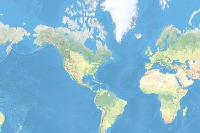

In [3]:
training_data = gis.content.get('73a29df69b344ce8b94fdb4c9df7103d')
training_data

In [4]:
filepath = training_data.download(file_name=training_data.name)

In [5]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [6]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

### Prepare data that will be used for training

In [9]:
data = prepare_data(data_path, 
                    batch_size=4, 
                    chip_size=448,
                    class_mapping={'0': 'pool'})
data.classes

['background', 'pool']

### Visualize training data
To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualize them.

Wall time: 2.97 s


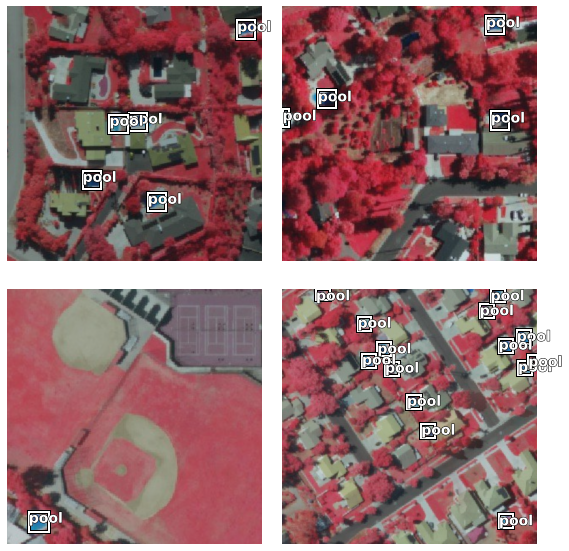

In [10]:
%%time
data.show_batch()

### Load model architecture


In [11]:
model = AutoDL(data, total_time_limit=2)

Given time to process the dataset is: 2.0 hours
Number of images that can be processed in the given time: 116
Time required to process the entire dataset of 1845 images is 31.6 hours


In [12]:
%%time
model.fit()

13-06-2022 15:32:37: Selected networks: SingleShotDetector RetinaNet FasterRCNN YOLOv3 atss carafe cascade_rcnn cascade_rpn dcn
13-06-2022 15:32:37: Current network - SingleShotDetector... 
13-06-2022 15:32:37: Total time alloted to train the SingleShotDetector model is 0:06:11
13-06-2022 15:32:37: Maximum number of epochs will be 20 to train SingleShotDetector
13-06-2022 15:32:37: Initializing the SingleShotDetector network...
13-06-2022 15:32:39: SingleShotDetector initialized with resnet34 backbone
13-06-2022 15:32:39: Finding best learning rate for SingleShotDetector
13-06-2022 15:32:58: Best learning rate for SingleShotDetector with the selected data is 0.0030199517204020187
13-06-2022 15:32:58: Fitting SingleShotDetector
13-06-2022 15:35:58: Training completed
13-06-2022 15:35:58: Computing the network metrices
13-06-2022 15:36:02: Finished training SingleShotDetector.
13-06-2022 15:36:02: Exiting...
13-06-2022 15:36:02: Saving the model
13-06-2022 15:36:11: model saved at C:\Use

13-06-2022 17:23:12: Finished training dcn.
13-06-2022 17:23:12: Exiting...
13-06-2022 17:23:12: Saving the model
Computing model metrics...
13-06-2022 17:23:37: model saved at C:\Users\pri10421\AppData\Local\Temp\detecting_swimming_pools_using_satellite_image_and_deep_learning\models\AutoDL_dcn_resnet34
13-06-2022 17:23:37: deleting dcn with resnet34
13-06-2022 17:23:37: Collating and evaluating model performances...
13-06-2022 17:23:37: Exiting...
Wall time: 1h 50min 59s


In [16]:
score = model.average_precision_score()
score.sort_values(by='pool', ascending=False)

Model      pool
0                atss  0.545365
0              carafe  0.542435
0                 dcn  0.536729
0        cascade_rcnn  0.536235
0          FasterRCNN  0.519933
0         cascade_rpn  0.298964
0           RetinaNet  0.268603
0  SingleShotDetector  0.054507
0              YOLOv3  0.011685

In [17]:
from arcgis.learn import ImageryModel

In [57]:
model = ImageryModel()

In [58]:
model.load(r'C:\Users\pri10421\AppData\Local\Temp\detecting_swimming_pools_using_satellite_image_and_deep_learning\models\AutoDL_atss_resnet34\AutoDL_atss_resnet34.emd', 
           data)

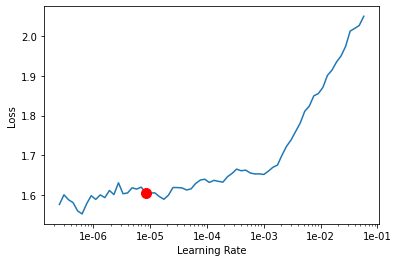

In [59]:
lr = model.lr_find()

### Train the model

In [60]:
model.fit(epochs=10, lr=lr)

In [61]:
model.average_precision_score()

{'pool': 0.5137461662102243}

In [62]:
model.fit(epochs=10)

In [63]:
model.average_precision_score()

{'pool': 0.5561870892632037}

### Detect and visualize swimming pools in validation set
Now we have the model, let's look at how the model performs. Here we plot out 5 rows of images and a threshold of 0.2. Threshold is a measure of probablity that a swimming pool exists. Higher value meas more confidence.

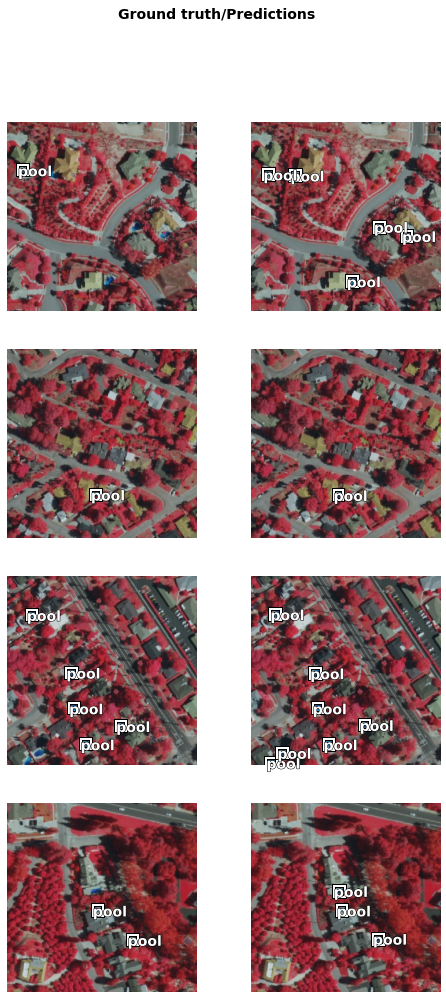

In [66]:
model.show_results(thresh=0.2)

As we can see, with only 20 epochs, we are already seeing reasonable results. Further improvment can be acheived through more sophisticated hyperparameter tuning. Let's save the model for further training or inference later. The model should be saved into a models folder in your folder. By default, it will be saved into your `data_path` that you specified in the very beginning of this notebook.

In [64]:
model.save('PoolDetection_USA_20')

Computing model metrics...


## Part 3 -  Model inference
To test our model, let's get a raster image with some swimming pools.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAqYAAALOCAYAAAB73NGoAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P1nWFzZmiYK9jN/7jOm5869M33ndpfrqr5dprvMKdNVd55yp8w5ddJnynuL90gChAySkBeyICE8CDkkYYX3HoRHeO+9D8IRBt75vhUREKCQhDI5efKk9srnTbT3MnuZvd/1fsvFv4MFp15YkCBBgoSPGutxluJJkCBBwseEjXaSMJUgQYIEC1iPsxRPggQJEj4mbLSThKkECRIkWMB6nKV4EiRIkPAxYaOdJEy/ByxotVha0mFJa9lfggQJPzysx1mKJ0GCBAkfEzbarVuYLhC0Wg30BJ0Z9DoNNGvCSlgBi1LZ0Bg8Yhtwt00BrcZyOAkSJKzGgkbzXliKtxbvC/s2//W4tXEkfHcsEEdyf2PJT4IECT88bLRblzDVEmmrVGq8runCz+5X4c/8q/EXAdX4c3/69+0m5MnV0K6JI8EAjV6H2Y4+/PWlQthUzAsxbymcBAkSVmN6ZgZT09NvBfsrVSqLcU1gwdnW3o7RsTHo9Po3/PleV3c3hoaH3/Bbj1sbZxn03CW9FmTJm0Ey4t8Las8JmQIzSgt+EiRI+KXiXQY8423+G+3eK0w1Wi20Y+Nwi6rEb91vR+G4HAq1GjKlGnLVPB6/bER4t4o4d3VGJayGSk2wcF+ChB8jWPBZEoJanQ76xcU37q8Fhzt48CA+++wzfPnll2/g888/x65du9DZ1SU4ylIafF82P4/Lly/jyJEjQnyaP5v/3d7RAXt7ewTev78qLmM9bm0chm5RB8hlyG4eQ+zrMcQ3jCGOkNY+i2lpNPCtYCN+uq0Xf+GTiz1lkhEvQcJ6sbS0ZGQky4591yM6VaTtmHsthTX5W+LbjXbvFqaUEc3sFI6HlOFvn/dhQqtfs05SAz2RiX7N2kk9EzMMWNK9WUCNTrvsz1hcE0bDowuL9GwipiWzcKueQ3lbXKK4vJxAPI8EtFEcqzhfZnmgTFueQqcKXg7DMMuH1jyPi6vjcwPxs03+vJzB5Kej+jDdX6J43AmpjOFNdbegMaw5Xcm7MR0LeVw0r0tKT6QvjbxI+AGDiaultRU9PT2C5MzvDw4NoaGx0SLxmYPj7du3D7/4xS+EOF2LTz75BNu3b0dHZ6dFojSBxTGLT2dnZ3h6emJgcFAIUnG/vR1OTk7wPnECI6Ojb6SzHmcenjkJGjVqWgZh8/A1tj1rhnV8G2wItvFN+JsLFQgZUktG/FuwQHw4PzaJ65nteNqjhEaqJwkS3gvm0pcvXyImJgbPnj17A3w/PiEBE5OTb+Vdvi9XKBAbF4ec3Nw3BhVM3JiYmIiMzMxVfoyNdu8UpiwM28sb8L+er0b0sIoE0erMrAUXTqdWISatHv8S8Rr/FlEPj8qZFcvXSNyVle34p7B6fBL5Gv8c1YjT9TNCiPLaoiW1EvmlrbDKHcVgzwh2EcFzOv8a2oIXQ2RFkyhjQbk4MY5jcW2I651DaFIt/i66E/ljCsNoxfws7qQ24af8jPB6/OPTdqQNKYSgM+WVhae8ux9fUB44H/9G4VzLpoSIZLHY1diDHQ/q8K9hddiU1Iv6GcobCUsW1arRcRx//hr/QnH+KbIZtxumsUBpL1LZ0/Ob8c/hhjzvSBnEGJUd9EIcj2/E7VbKH4nuuYERuD2j8lDeI5PrRfhPIluQPKZaFt+8NlUzL0dIUp3w/xnVp0PGAF4Ut8I+fxSjyreIbQkSfsXQEqkFBQfDwcFBiEIWmQwWfzxy6efnBwWR4LvEqYbCnzx5Era2trCzs3sDNjY28PDwQF9//zuFKYOFaDeJZAdHR3h6eYmR057eXjFSetzbG2Pj428QMWM9zjw8r79vr2rDX92rhXvpNGYpXyajkoiPhPoYaifVqwQX1wEvlWJYEmJibf87wgh/479Xwhnum4fjeHxPY8HfcG8Fa+OaYB7mbWVgvPlss3hm95nvV+IZ71EdLkGPJZ0xHN1fnXdDWEt5XPUcYxhpiZmEHzqYvxhr+dB03/yeJTC3bt+2DT/9x3/Ev/zzP7+Bf/rpT/H1V18JLn5beqZnR0RGYsfOncjKzha8yfdMeUsgcbtt61YhgtfmdaPdO4QpiUydHHcjyvBHUT2YMNvkxOTBo4gmGMQUZV41gaP+lfj7p10oG5Ohsa0X/3L9FdwqZrHEo3yqWVwLr8BfBTeRRTyHlpE5lLR34e9OluFQ3iimlyg9tQIxca/wfz1dij+N6UJx/yxaJyZx+1k1/tPpWsRMKqkTIaIf6Mdfny/BHwfVILBxFo2jMkypFzAxMoy9fqX44mUfioZkaB2fxqPcBvzhiSrc7ZMJYbmoUyItqxF/cbUSFxtn0Ej5eE159S4YJ38Vcoua8N+v1CG0Ywodw5O4+qwKf/WgB/0qLWRjEzhwqxjfpA2iip6Z1ziGhNdjkJOwfvqiEv/9XiOeUdmahmcRld+HXmpUDA3hHy4XYG/pPBaX9Jhq7cFPfHLx7/1qEdBA5RuXISq2Er936zXSJkngspCXT+PkvTL8RWgzEvtlaKH0wuOr8f/wysGfPe5Dj0IHnZHMJUj4IYFJi0WoF4lAFpFMiHzt7u4uRih5+n0tsa0Fk6GLqytqamvFelK29teCR0HfNZVvDiZZFqOulObRo0eF4GXhy+lYEqWM9ThTWC6PrL8XPyFO2l0yST5vfp96MkpXZn3oOydOlM3No52+//bxeYwqWNyah9dAJVegg/wZ7RPzGFeRgWycoWHhNTevwMi8WgwIdE9wOjJ0TcgxT89eFnsqFcZmFZARP05OMyfKMaNUizyDBODULOWB+LqDMaWAnPjHfFRXS89jo7uH0jfkZR5D84a1vWzg61RK9PKzKX7vLN2ndEVfQX8XNWqMThvS5/yPydVCbOooTQUZ3qJchB6KpxR5VVNe5ZhUUDi6VlHeR2coT/TvqRkZ2iidzkk55JS2qXwMnrWapbo0pTcwpxIjQCMyQ7qmcBIk/JDA3JOYlISXycniezSBxWZubi5inj0T4fje2rgmcFgrKyt8+umnYonTWvD9vXv3irX07+JK9uM1+zyosGPHjmVxyunziOvWLVsQGxu7nEfzuBvt3ilM9bpJuN4oxZ+/HCECM2SELdGJ8SnE1wzjSd0oElsmUDepIitXg5yMWvyWXxPaSHyBrF5SrWjJr8PvBrSgngrXVtKI37xUjaQpKgilxyOpPApbVtqA/+xHomxUDWiUeJ5YiX93oR7PBxRC+Op4Wl05A4+gUvznJ31Q86jo4CD+8koR/uzlKKVBYSgt3YISYQ/L8MeRnehcoDD8DI6rmcO16HL8/oNeTNP1dHc/fnqxBN4Nc6KzEHGZjCn85PAIPrlQCp+mOZF/4UZH8G9XX+FyD5FyWzt+71QFovqU5KEXInKB6kqrmcDBi0X4x2TKD8XjzkMQJz9/eBj/4FeMg+UsTA3rqP7sQiE2FU6RSDaUTzMxgL89VwL7ylmKr0F5dh1+w68e+TLuPChvlE/t7CzcA3Lx3570o1cSphJ+wGCSm5yaEtPkPHLKcHFxQf/AgCA6S3HMwfHt7O3R2tYmyJuv18LWKHr535bSWAt2RUVFBsL+4gu0Udq8NstSWMZ6nCmslgReXmo1futWI17Jyfh9z7ep06vQ3DoK66Ay/E1IPX569xX++nE3GmcMU/0aSm+oexS+T6rxB/fq8C8hdfgfgRX424c9aJ1WQk2iFSoFnsRX4LfutyC4oAufhdfhn8Nq8LtnynEgewRTFGaB+WdwAP/n1Qq45PXB81EN/kdkO3J4dklLeajpxubQavzFfXpGaA3+j4BquGSNYJzyyCOanI/piRnEpdTj9+/W4p9C6/CPlNd/ShohbiNhPCvDvRd1+Nv71fhpUDX+5F49bjfOCT7VqNWoLGul8JX4m+A6/HlAPbxKRqEmDhzvH8Wx8Ff4w8A6/DS4Fn8b1YFeE1deM+fKHvzFhRLszeiD95Na/D3Vwx9fLIdL2QQm1cy9VPfUh7Q09mPTrWL88X2qSwrzeXgDtgeX4o8fS1wp4YcL5q64+HhsIdEXFxcn3mcWgzydzvciIyOhUCrfKUw5jTNnzuD27dsIDQ1FSEjIKgST0GQjfD2zSybRyeJ09549yMjKEtP3W7ZuFdP8HN9SXjbavVeYOvuV4I+fDUBFJCRIgD7wvp4heCe0w/lFPf63k4XYXkxiSj8D39By/N+u1OBoSgeOJHeIv7YhZfj3l2oQN65A9JMK/EZoF6a1hrT4OVoSXCO9g/jp+TKcbyExqFPiSdwr/F5UN9rnV9ZdavU6FGRU43fvtKDFKEz/+ioJyGYlkaAhvyrlOHZdKsHXuePU4RhIi+Pq6d9l+Q347Yv1eKVRobK8CX9yoxGFUytT5yIclbHxdQv+k3cJPolpw/FUKkdKJ7xjG/B7p/OwuXAOyvExHLhSjD8Mb8aFqimolngUhKeOFEh6UYH/17kqWOUPoXGWRDb5iXWsbwjTHvw5id+rXZR3UT5qaNUINvuW4JuCCWoBGa4Gl+O/PuqDnEhXlINeBijnERhDApvuS2Qr4YcOFqDjExM4dfo03I8cESOW6xGlDCZAnmrntapvI1PTaOz7yJbB4paFqIuzM06QWHZzc4PX8eNCKJumrNZiPc4Qlg3gWfjcLcOfPB8g0bjCb7wciqzUZQhDVqvDcG8P/s6nDM4102LqGuo5nAkpx0/jh+nr12F+aBCfXy7G1kwSiTqDob+4MAWvO2X4s+gudJAow4ICz5Oq8O+8S/GL7GEoFzmcBh2NHfhvdO9QDRm+PLtEXPlXl0vxGyENqJzlMFphONdVtuBPL1bgchM/kY1waq++PvzUpwS7SidI1BLHyGZwJqwcfx7egVoS3JwPqOaQ1z0PtYJ46kE5fhLeiQ4N+2lRVdaMP7zRgAKZioR1H/76bAl8GwxGvkquRPfILJRaGU7dKcJfPO3DDLULP7e3dwoTFrmSR6Hz8R8CW1A+Q2WhdPrqmvE7Z8txp1spBiUmevvwTyRerYvGMSvqQIfW2g783sls/CRGEqYSfrhgkcf8xeJ027ZtQvzxGk5ePx8ZFSVG/d/Hb+zPXMizR+wWydheC54h4tNJ1sOVJuEZHh6O3bt3Y/PmzWJEl+NaEqWMjXbvXGOq06kQHl2G/xLQjo5FHpE03OcMitHE+VF8cbUEe0pJmCqn4Ha/FL8f2o7omhFEVw8bUDuC1PZpjGtmcZ0I7j897COSWCkcTwXNDI7i8/PFONowQ5yiEsL0P0d2o3WNMM1Lr8ZvXWnAKyFMB0iYvsL1brL8jeJOpRjCL86WYmfpFGVv5Rk6IqvG8mb87plqZJG4S0irxh8GdaBDRuLbjLAWtWoi1gb8xvkqeBUOIabWUIYHVJ7nr0dRPa6izkGN7uFp+EZX4H/2LsZPHrQgoksmCHJhbg6PCjvwlz55+O1bNdhFRCnWvL5FmF7qWMk7C9NvWJgWUt4xA+87pfiD2EGqD2M5jML03lNJmEr49QELQj6qaXhkZN2ilMEcw8L0XSOm6xWm/NwOCsfhWZROTk6K0QNHJyd4eHq+VZyuxxnCGox4l+slq2aXdBo1Olp7sDmoTqyp/5fIBvg1zVMsBaLISP+PgR2Y5k2eFJaXGPWUvMZ/uFaPLOKlghTiuptNaFpYGX3lqf/uFhKdF6oR0SMnHajE0/gK/Pu77aid05DYNGz8hF6Nx7EV+C+hnZg0CdOrRdhcTALRuE9ggcSlj38xCeFBzJOQY24XcZeUiHtZjf90pw29ZLR3N3Tiz85XIHKQRKA5F5EI7evuxp+deYW7XVQmMv7VVM8YIy6/Vgzrmjn0dnXjJ9484DBLvQUZ8DzzQ+XUaqZx5Hox/pJ4bIrus1jno7XE6K4FruTlEZ5NVF6Rdw208mF8Rly5o5i5Uo3nzyrwu/fa0EPxF035U8lx80Ex/kAaMZXwAweLPeaoeBKnO3fuxKZNmxD14IHYAf82IWgO5r+NNOJN+XkRGys2mn7xxRfIzs19qwHP2Gj3TmHKG3DG69vwv/iW42wjEyp1CKbMkIWsnyKCuELClEdMyc4PePAKvxnZSyREVqtpDapxpABLZN2/qMRv+rcS4a2IXF5HNdDRjT/3rYB/Jz2DyJaF6X8M70I7T4kRORrIVo7gR6/wO0GdGDQTpte6zMSdchquRHj/ljJMdEUEKJ7BJKpGRnot/ne/ZrRR+oWFr/H/ufIapdPq1WS7tIDOtnb8vm81Hg2oKB49x1QO+jfnhRuNR0J5XdXA6DScb+fjr5/2olfFZdSKDVIzMgUSU2rw/z1fidgJijvyIcKU16fN4kwAifyn/dQpG+ucn0tke/shCdbHkjCV8OsDJrkPEaUMJlDe4FRRWSnWgfIGpbXgdVXvGwXg77W5pUWMGBw/flykxXlhku3t64OTszOOHjsm/r02nfU4Q1gWXNPwuFmCP4zqWRabPGo6Py8X6yLbO3vxN+eKsK2IuFI9jaNBZfifzpbjL/z5PGgD/uR6Of7gfhOypmS4G0lGfHQv5WmlY2IjfnpwBJ+SEe/ZuGLE/y4Z8W2rjHg9CjNq8NvXGlFlzpWdKzM0KgVx97lSbOf1sKuMeB1elzXhP5+tQc6CAnn59fhzEn2Nc8TVZrNLbMTXVDbhPxwvwu/dqsZfGsvwl3cq8duXS+FYSVw+P4urMdX4f54twW/db0XxpOF8UubRjooW/Efiu39/uQZX6qcwpOCBEOLKt84ureZKw+wSc+UMTvkTVz4fWDndhblSml2S8GsE5h4Gj5g+fPRIrPVcL2dyvI0SpsyXDF5WwCO4vP41IiJCCGYeyWXeZP+18TbavVOYMljcPU2owk/8a3GPhKOGiY4FG4+YTg/hHy4VYWvBtLjXUd2M3z75Cje65tg+FvfUShnK+3k3PYnc9m781flSeNTMQGVah6qTwf9RBf57eAeaeD3lghIveI2pTwWuNLDg5XBaDJPl/odEpPaVMyRmzch2mbB4hGIB+Tl1+P3rdYgZYmFpzMPEMLZdL8VXWaNYoLgzRH5fX8rHzxMHMaQx5kM1j1ejCiimpmF/qxj/+KIf/aKs5LeoQvXALKYVfPizDP08Tc/lX1zAs6el+K8kolvIr2NMIZ7HTtHYit+kjidomMh29EOEKU/l61Bd/hq/c7Ic19vkdG0oRxMZCX/olY2fPJNGAST8uMEEypuU+IgnHx+fN3D69GmxZpWXB7yNbPn+vFwuTgHgta5T09OrwjLJcnye1g8LD18Vl7EeZwrLorEotQr/0a8RBXKKa/w2WZxyB4PpYXzKRnwJcZp2Gl5BpfjTF0NiJ7kpDRZUOsofluZwh4Tpb0T0iI1Iy8/gaev+YfyceOJUE6VjFKb/Za0wJaGZ9bIKv3O9CfVvMeJVilFsOl+CLcw3PNppfIaejOua4kb8jm8tiskQTkitxm/cbUPbWmGqU6O2qhG/faUeScy1JlFI4F8INO3a5xNO2uq7sCm0Gv/ruRJYF0+IvoAhn5jGhRe1+KOLxfjfwzowzPsCPsiIN8wued0mYz1uaCUPVI9sxAc9k4SphF8vMD+9jc/eBg7Pa/h5cxM7PrN0LVi4vk+Ysh+ftc6idPOWLWLDE3MX3w8JDcWu3buRkZEhZrDWitONdu8VppwBrVKJtPJmfBJchwPP2uCU1A7HpA44R1fj/32pBqE9crHOUq+cQ0Tma/wBidMdye1wTmyH9ZMmXG+dxRL5a/UqlJd1YlPAK3z2ogOulM5hIqafESllDcmpwEwoCsQkVOL/fq0We542w4nScI9vwp+QJb43bRhTRDBiyod35V8ow6XOFWHKi/WVJISfJLzGPwTVYm8CPeNlKzY/qMXuuAF0K/ioFsrnohINTYPYdb0Yf/u4Fc4vO+AYWYO9RZNEqmq0dffiX0kE//3DZjiyX0wTrHIGMbFAZNzWgW0Br+Gc3AGb2FZ8EvQaUZ1zUC2OwTagFva89pbq5kt6vnvOEAaJ6MWu/EsF2LO8K78bP/Ephm875V2QPZPtMD47VYRv8qij4A1fehkeJTXg/7xWiT30LK4Hp5gG/NvNIvzpU0mYSvhxg3mHRwDq6+tR//q1RTQ1N4sD9C3FN4FJlQmZ17paImUmWT5Kio+Q+jZkawrLcZXDo/inq4X4OmMMShJky9/nqtmlGY5FpE+C71YzeonzTEcacRo86sebecqy6vFb116jVM472w3+S3S/sbYF//VyrWFjqFaJmPgK/F8CWlEzQ9xJXKLitZ7yKTgEluKPnw5ARgLQkhGv4anukFL8zdM+jJGxbhC1lIZOjvDnlWJmaozX3NfwDFI5IvuUYl2qoTwUjnhtuH8Af3euDJd5bwBdm9bVchn438y1zG9CmOvViHxcgt+L6EQTiWgepeXycrc5Ucejp2UI6Ke8fpARzyOmSgQ/KMPvBLehS0W8Sc/lU2O0c9M46l+IP5I2ikr4kYN57dChQwiPiEBKaiqSU1JWgdeH7t+//53ClL9F3mT1/PlzMVLKopTD8n0GLytg4503RKWlp4t75vE32r1XmDIMBKLB0OAk4mpHEFM/imeEmNdjyOyRQW2ypJmA9QpUN48Z/OtGEd80jRkjUQniI9E1MjQh/EQ6DeNoklHBiKA5DRamj3kUILoXdQOzSG6g51HY2M4ZzFA+BIHSX618HqWdk+iQqZcJUeSVKpN39td0jIlTA2LqRpDQPoMxXqtlzCdbBXxw/ez4FBJeG8rytH4cbcajThaXFjA8PIVEYx4f146jeUZJHYYGc7OzyKkfofCjeFI/hsJhhTj4XrOgQH3rmMjrM3rmi7ZZyKncvJ5WK5ejvGsC9VMGYayck6GkYwLtc+Z5l6Oa7lVPGAiY63yROp7aNkM9cl03jc0j7IVhU5REthJ+7GDRyKOa78JagrQE0xpVS34M9rc0bbYeZx6eR027W/rwJRmPP00aRB9xk5oIXUG8p+ntxR9cKMauEj6zWYf5/j78/84U42exfeghXuId7IP9Q7haOSXWW6pmJ8TMzd8+6cJr4kcWr9MkbrdeLsM3GcOYYZ5TK/CCNz95FuFTMtqnVRosqeYRk1yL//l8DWKIm8Ts0gAJ08vlZtPhhlHNnvZu/ON5HsUcFzvc9ToVGQLt+ONzlbjWOgcd1YlWNYPzYeX4nav1SBhVGep7YAi+VVPQKOYR8LQC/9v5esROyAV36mTTuFU2hIE5JVqGR5DSwOdY0zPn5bgUTOWJHcCgdgZRpWNQqNRQUTnqixrwm5dqkTJPZRomI/5qEfaXrQjTn5AIvbhGmH51lqfyebRXh4mRXvzUuwhfpw5jlMS7VqXC08RK/E9Hc/CX0uyShB85mNuCgoJw48YN3Lp16w3cvHkTd+/eFev838aXfJ/F54PoaCQkJi6LUpM/8yP787R+alraqriMjXbrEqYmMPGysFwFEmvmwpCJY3FVGMN6q3els7wBiSrCJEx/J6Ib7QqewjaGo+eYH+rMZ+Et8pSQJcKhdPh4peVn8KiEhXBr82EYvbTsZ5rG4sZiIWq6v/KrVW8+c2U9riGvy1NhlMabeeeRXA5jTI9eDD77dTlNns5XzOJYQDn2FIxBvmS23leCBAkbjvW4tXF4Kl6hmMLd2Hr8j+uVYt2lWEd6swJ/GNaJRjkZpxSO+WhodADbSDD+twDyv1OFvwlsQY5MtTzqp5yZQ+CLavwftwxp/ElADY6VT0NFccVuf+NxUb8d3oWgjBb8fUAl/uJ2JX4zpBnJ/bxZiLiE8sPrNr+8X4ugPtMaUwM0xF0T3UM4GFaJP7hNeaC4fx7WjKddcuI1yoPIBxnyShUJ4Br84a0qkY8/vV6Fc41zovPSamYR8KQWf+xnKOt/96vFmbpJqKBBe2c3Pr9SgT/j+5T+14kDGCIBrNNOwOtuJf7sDpWLyv1H91uQOyrHAnPd6Ci2BlfgWI2c+FCHma4BfELx7/YojBxOZVKNw5ri2ZRPiTLyTNtg/zAO+ZfjjyjsT/xrcDR/CNcfl+H3H5IRL5eEqYQfN3j3Pi9behvYn4WlpbgmsLYxHU1lLkpN4O+d0+D1r2v9Ntp9kDD9pYMqw1yYtsh0q9Y1fTTgF2RiGqlDvL5UZ4QCKVn1+N3LdXg+oli1pkuCBAkbj/U4S/GY1HlEcuVXjQzXhmPlVsKJqW76js3DmPub0hGzLkbw+aBiIID+beJKPsGkXU6GqzEtDrPaEDc8x5Iha5huX0nfgNVhlvNhCmeWPufFcG0OU7w1fvRvUx7W3uc4pgEOQ50Y/v22vPOh/+b55Dyu5I8ErkoO/4fl+KtYFsPSr+RJ+HGD3//3wVK8tXhfuLf5b7T7QQrTJ8/L8BshXWgiYWqafv+oQPUwP9SDv75RDZv4VljHteLA81r80c0GPG2dFb8ytXqUWoIECRuN9ThL8b4XGLnyozfiGSREV2aueCRYC/nkML66/AonaqexaLb+VYIECRuPjXY/LGFK0CyoMTQ6jZLBecwaf9nDUrgfPTRKNLWPI6FxDIn8s6eN4yiZVEJsGrAUXoIECRuK9ThL8b4XmITpi3L8VlgXmj/i2aW5rj7szR8Va1bnFGrMysfgeKMMfxneiUb1Apak0VIJEn6p2Gj3gxOmDJ7a4R2gH7cAM64vNcPyrlgJEiT80rEeZyne9wISW1ArkZRRh3980YfO+best//RQwOVfBR2dyrxk4Bq/CXhT/0r8bOUIcyTKOW1upbjSZAgYaOw0e4HKUwlSJAg4VeN9ThL8b5P8CYo8cMfFvw+HpART0b7WqzaLCtBgoRfGjbaScJUggQJEixgPc5SPAkSJEj4mLDRThKmEiRI+HigWf/U7nqcpXgSJEiQ8DFho50kTCVIkCDBAtbjLMWTIEGChI8JG+0kYSpBgoSPD1r+8Y4Vxz+asexnPIh6PW45jgQJEiT8mLDBs0sf4iRhKkGChI8LGh3UAzV4HB2JsLBw8TN7CeU95Lf6Z0vX48zDS5AgQcKPEW89qP8DjPgPcZIwlSBBwo8STKLiZzP5N98J/G/ewa3Ry1D+6Cq8Lj9EXW89Yv3PwMnxIooGFKt2cq/HmT9PggQJEn5c4F9dU2N+XoaZ2VnMyeahUL154sVGu28tTJnkdXo9FpeWlsHXb/vJKgkSJEj4vsBClLloYnISff396OzqwuTU1LK/QqEggl3AEvFdX/EjeDlY4XHNvDhD2RRmPc4UVoIECRJ+bFjQaTBS9ABuR7xxye8STnu44UxwDsbkq8+Z32j3rYQpC1BWz01NTSgtK0NhYSHKX71Ce3s75uVy4W8pngQJEiT8sqFbXMTA4CBiY2MRFBSEu/fu4c6dO6iorDSOmhrCaRYBnXIEKfe94XbqPurHVdKIqQQJEj46sBHPuo0NdQYb9jxauqCdx+vcBMRnN4KYFQ0v78PdxhlxzR9uxH+I+yBhukCkrqK/ubm5uHnzJu4FBiLqwQM8IERERsI/IAC3b99GdXW16ACk0VMJEiR8X2C+YbyqqMC1a9fw5OlT1NXXC5E6Nj6OOZlsOSwT71x/BcIun4bPtXsoaJuDbs2vBK3HmYd/GzhPpuUEJpj4UeJICRIk/CrBfDQ1PS0M98SkJMGbPOho4ibt0hKWlhahxyLaciLg4eiC+B+KMGUiHRkZQWhYGG7duoV6InyeJpPNz4tR0tm5OYyOjaGsrAyXL19G7IsXmJ2dXTVCIeFbgDu1RT207+rANFoxSqT9MfxWNpdF/yMpy48JP/B2MZHoSyLWS5cuoaa2Vnw7vMSIiXeVANRpMd+UhjMnT+LWwxyMKA1T+jrd6m9sPc48vDn4efxc5sb616/xgvjwflAQ/P39ERISgiTKZ2tbG5QqlcSREiRI+N7BvMP8k5efj/Pnz4uZpbj4eCSnpKCtvX2FMwX36zHaWgx/Hzv4hBVgUvEDmMrnTPUPDODa1at4SmqaxSiTLt9nt0Tkz4Vk8D0eneAptPv374tRilWdwkZBo6NORzx+lVta5CFoC+HfAY1uUcTbmJ/1ow6JOvDFRe3706N60a0pw6J5Prje5qfR3dqBoVm54do8vjHMgmwcra1NGJhWU12v8f9gUJ6oYhfXdNLrAr3A/EYsUse/1m+B6ph8VllZb4DLMj+ONipL/7RqA8rydmj0Fl4eyh//xKOl8N8nNPxSLOl/OD+pKNplwtAuU9QulsL8isG8U1tXJ4zi/v5+cW3iHealZ8+eoaioiP69CJ2mE9Gn3eF0MgRlTU1obGxAHYnH1oGpVVy1HmcKaw5Og5/J61rvEdlfJd5MSExEWXk5qqqrUVxSgqcxMbhw4YKYbRomg19rll8JEiRI+GWC+Yl5h08kuXHjhjCSVWq1gJ4HuUjfGcLqoFdOoCItBJ4uxxCU/ArjSjLi1wxQbLR7rzDlAiiUSjFVz2u2+JoJlDFHApXVNq8vXRtHrlAgkIRp0suXgnTN/b8zSJRqp3qQkxaPh9EPEB0dLRD14DFSG8aoBCSU19Wp8w5dFQZbylBU3oFZNXcOlsKtFzy6qURffRGKq/swT4361k6cOkjo1WgvS0BkJJWBOqjI6GfIbxgleUQCicIskMpT9hTixF4HhNf0Y8GS6KYwiy3x2Pn1z3GrQCZ+I/qNMOsG1cfiHFqKMvGqbVoIEsvh3sSClvI2O4SyzBSUto9DRSJ12Y/qdKa/BimpBeiaUL1dnHJZWhOx++uf4Ub+3Hcsy9tAbbSgxMDrfDx+8njl/YmKRFRKKcbknIlf3QiWRqPGeGc5MvOqMDr/AxGnVCVL7cnYt+lfcTVn+o2RxV81mIvYGL5y5QoqKioEsZr7MRf5nj+PsPBwYXRp5vtRlBKHJ48emnHHQyS+6hHvJpMzx12PMz3H/HliFCIvD1dIkKalp4vnc56YF03g6+npaSFQuWNgUc1x16Yn4QNAHMTm79olGaug1WOJ7D69zoLfrxt+TGX5MYHfwx9wuzDP8B6hgIAAPHr0CLMy2bIQZW7qIoN6aHiYwhFX6WVojr8LF+/bKGgbN5AeuSX9ai2y0e69wpQLweKTNw8wkZqmxfjvSxKdNjY2KCgoeINU2X9gYECMCjQ1N4sCm/t/J+ioYroyYLtzF06ExCE1JQXJyalITLwLpz12uBmViJ45ejHMVT3lj/NoguGelhKaRW6QG1wvJmBUhdWiifxX4hjvmcMsvQWOR4IZixNI8rPF0dt5mKH20pDfm/H00E7XI+TsGRw/fgUPM9KQlpqC54/v4cjhQ/B/WYEpygsPMip7i3HmsBui6gawsLS48rzltOjlmRnAq7JitFIBVuXzg/NPD9R0INBlBy7E90KjMzMozMMSVqVDWNAvQdVfgTP7N8MnvhEKyrwpj1oSMn0FN7F1myvSW+Urwm9tmqIsg4ayjJjKQn6UN5GWqTym6zXgNdDL/sa/a8PwM5fUsyi464pv7M7hSXKGeH/SM57j2lkvHHP1RkqT7M3O7b11+RZ/vhZpmfyMMI+7DA2JPhWaks7isJMf6iffRm6GurL4PIa53xt1Zbxvlh++b/i3WVzzeHRPQ0ZHRVkRWoaVhnAc3xTGUhwzrKtdvgN4dJSnxiOjokT65n58zdPpPFXl4+MjRON6Z1vW48zDMzgvYo0ridKGhgYhQEWZCcyJ5jyooWu+V1RcjEuXL6O3l765jeTJZfCRWcQ5xuetwNAuluNYBhug2g3MoyG99+WB3xl6B9/I/8oSjQUqn2q0GU/vhSO3a5yuLeSRhJx2sAr37/ghvUVOz13j/8EgQ57r9QPr0ADD+2Cx7PQ9Gcq25r45uCxD1Qi6cw1pzRtRlreD24jfa/N61xF4dskyj31/EO8Pv8cW/H4loHbRDdcixP8aUhpJ8G0w120EuP3i4uIQEhwsziHla77P3xIb5bdJ6/FaU56508mbEHzSDY5HfREYFoz79wJx9959PCnqMJTtA4z4D3HvFaZM6ryhqbKqankkgv/yGi43NzcxisoFY0I1B4fjlzkjMxPBVAGmuBsCFqbd2XA95IznHaTglp0OIw2F8LX+EqcelGFGuyRGHnmqXqOWYXx0mCyBEYxOzQmrZkGjhnyiE3E3neB8MQatg9OYmJZBxaShp/zOT2FkhOKMjGBiTik+AFMeNOSvUc5ilPyGKczI2DTmqdOTjzXj4XlruN9MRdfwFCZm5qFaRTD8kffj2Wl77HQKRNOEXFj5BreEnpLHcNuzHbdzuqGhOyqjMH3YMAqFfALDlP/h0THMKYm8TC+9WgWFUmX2HJ6OX4RidtwQfmQU03Jqj+WRLkP5VKJ87E91MjEn8j/XX4prTrvg+7Qew2MTmJqTi7IuKGZWwk7OQqE2PcsAIUwHqnDJdg8uvmx+Q5gOFN/Fvv1eyG5XCGHK74x8lsszLPI3MSsXG+veKItKjumZOSjpo5mZNLbfxAyURADctiIME7lWiamxUeE/Mj4FuVqJWYrHRwKZ8mgIq8EiCdPCQC843EgGaT+jW8KCfBZZgY7YfegMCkc00Is88PIUHeanx0TaXPezVPcrwtXgL5s2PHt4dHyVv1I+h+k5BT1XiclxQ/7HpmapfJZGQw3CtCX1MhHBbTROWRCmJKq4HWcnjc+jNpLRB2HqmFhwLueF2mpscg4q6jxNdSXyI5NDTn/H+L1l/wVq99kZSkdLbcLl5Pd5Ulwvd7oW2mWG65f8Z9e2iymMsV2mqV04LyNjK+0iX9su3xImYeLn5yeEIHOPSQQymINYjLKBfOzYMYyOjwsuMvmbuIqXHM0ruJ1M7frhwpTT4rrjvFRWVop1q3yfn8NHVp2nPDx5/HhVJ8p55fzwuq47/v5idsrktyGgzmWxvwS+no44bOcIZ2dnAQdHe3iF5mJ2np5H79T7O3bKJ+SoSbqDm8HZGFOy0W0p3HrBy37mUPrkGm5Hl2NGTd+fxfTom9BT+wx3IfbWMVg7EFc7O8HW3hWXI7IxzlzGfY5pdmmPA8LeNrtEdaHvSIfjoV0IKbNgfH4QdNAvjSDp+gmEZg0I4Ww53JvgZU2q4de4d9Idd3PaoaTv01T/LPaGqh7gyLGrKO5WYEn/ljyKsmTA6fBOBJe+uXFvQ0Dv5uKCDDUvrmDPQRs4ObuId8fF0RYHvG+hqHGQ+lHqB7/Te/DtodOp0ZEXCJ9LkWibeXN6+VcC/t66SJtY7UBg0cwvp12+A5ijXhNPXrh4ESOjo4KbTH7MRaz3fH19cfPWLcPyItU8JsZGMDjYj56eXkIPugkDpBf4exV9NmGj3TuFKWeU15byaINprSgXhHe5njl7Vux85Q1P7Mebn0zga+4MuBIGh4bEuq/JycnlTuA7wyRMDzrhcdPsikAjsluCFq1Zd7Frz2mUD8iI/LSYnx1BWtB5uB9xxLEjTrBzP4HnZYNU6UOI9zuKw3s2Y8suK7gcOQ6/R6WgkmKyrw1R5x3gTJ2Zp6sVbE/dQ0UPkRnVwYJei5nhDiT4ueCg81F4eR2D86GLSO2uR8xlNxzYuQlb99jC5ehJBMRVY95s3aiGeqvxV49gtd8ZyR2UP0pruVw84goFikK8sdXhHobUJEz7SnDWygW3E9Pw+J43jnl4wfXwDhy7m4y+OepgSRDq21Ngd8AVcR1kOVP+NHoF+l9X4I73QbhQeA+Xg3C68hzdk2Qd0cu0QGQ33laJUB8bHHb1hKfHMRxxCUB+zyuEnLTFjk1fYedhZ7h6XsCz4h7IZnrx8qYnbKkuvDxccMD5FuomZIJETXn/IGG6tIjRpgLc9XGG/TFPHHF3htuFFxCLMDpS4XDABS/a5yFWO4iy2eNWTBICLx0hwvaA9R4bhBV1Yo7am4WYbmkWZbE34bD9MNy9PCmPJ3DV3xcO9pdROaDGojm5U/2YhKn9tXgM0TfFdSLKwKMQ2g5cP7gTXpEV9ObQtV6OjrJcXPM01OVRpwM46p+O4Tkql6hrOdqKM3GF/F2N/p73sjEqo46cBH1H/EXst76JxIIYXPNxo7K6wc7mMCKKhgzi1JQvgfcJU3r3dDK8zozFuWOH4ObhCTenwzgbVYZpBYthLWQjzVSvNjhK9epB7WW93wGPKwcgJ5HIJNn78jr2uZxH2IMAnKS8nA0tIAOmFfe87HE04Dke3TsFD09P2O87BN+obAwp6N3l1Q1d1AkedEZMy5xol0Xu4A/Y4cbTJNy/bGoXa4Tkt6+0CwmPVwl34Ghql2PeuBpwHg62F1Dev6ZdviWYU0aIg5hjeDMmX/MaeBbCLBL5L4vCs8RXR48cQWNjoyBk9mPwlBZvkAoNDRUjl+YctR5nnhfGkydPxK5WTsfEl8yHTPTHjx8Xz+T75nH4WkV8yVNrGRkZvwQjPgvO++0RXT9Jz1FCriADer4Bwa62OOjogcw2Bb3nK+XWUIe0PKBM36owelj5YR75we44ciMdM3xJ38fyN24+BL305pIozaoh6iV6F/l6Csk37OEZXAbSuXR7rUDmpUULGHoVjcNfH8ClsFwMs3FNdTUz2ohAt+2wOuGPulEyQCg589klkT2jW/We0TfO099rRQzHX3YWRC2/88uOEtAyVWs7Eei+G1fTRsRtweVksK8t61rhZuDKSlyw2onzSU1vcGV/kT927zlG7cKzS5R3ej/M87fE9bugfrMsxmu9zrDW3+TWlpV5bjk5EZ6vqZ3X5JOfK2aX7nnA5vIL9Cv0UJFxuqCfRlVyBFw2f4LTj6oxQwSx3G4Uh4q37JbM+zeTv9GPnbk/r/vn3d9saCxXNxXIsuA0cGVz8gXqz2+hwZIRzyDee+u7wGmY5ZUrw7wOFshzib5FvfF7EPXOPEoXvI9Cx5VtdKv2VdDLIabyzdpFXL+vXegbW0nRrF0slv/bgbklPDxcDBiai1IG85BpdsmT+gDWcnxPI0alV8B7ingwxjzuRrt3ClMm1+qaGjFiygXiTHJmeXeplZWV6Ax4NJQ3OZnAi/2joqLQ29cnRiumZ2ZEfN7lxdfmhfnWeKswZVIA5tpz4b1nLwLLiaAW55Du7wmro2HoUPHrvoTOrHuwtrmEkiGmQzmR7REcvZmBWeNbo5M14o6DDTyC84iK2c0h994xHDr+FEP0bM1MG4I8DsLx/CN0CkalVLo60CPn0dtpIltHHA8uB1+tmh6kl3qRPuqcIE/sPftUiIk3CJzezOHScFhtdcDLYXpZ+spx3nYrtjmfQlEfsyE9f+QVfK2/xsmHDYLQF82EKb3LUA7nwmurFa6nNZO4IrcwiIenrOB2uwCzdKkYKMG5gztwMiwP44YkMd3WjH4OrCGyPboXfmmjBg8SypnUeVgdf4YJca1BZ10jCbN58T6Y8r1+YUo51vbC33Ybzj1+LfK3pJ9DY2Wj6OwW3xCmqbDe9Tn2nwpBB2eeXGfKOezc5Y6MHqph+kg6i+/AevMxxLWwtKU0Jmtw0/YbfOJ0DTUfIEwZ/BHm3bbCQY9wdFJ+FF0JcPzaDmFlfQbSmG9DgNtB+DyooZoBZttewP5rB0SR+BNurhm3nA/C93G9aP/uxAv48sttJB5TMS6+3yW0pFzBvkMkCNrl9H6aE/e7hekCVchQZRgObTqKhFZDa2hHynHO1hr+qR3UMvS9DdQgv87UdsDrmGPYefA0igY1VDFa9Kdex798vgtXXhRCYWL/6TbcP7EHP99zFLld4o3BfGsCXLZvwZ2CIQMRrxWmnRmw2/M59njfF6MV7LrTL2DXThekdnG70HXZXdhsOoIXTYb8LE7V4Y79JvzCgQyGDRKmTJRswfMoJR95wiOO8QkJYtqexSiDjWgXFxc4OTnh9OnTy/c5DB93x8Lx8ePHYj2oOVmvx5nC8rfAXMfrXDk/nI7p++BZpSMkinl3vvlorQkchrmWj7bi9aam9Expfye8hSv5XVrUTiHu8iEcOP0I/TLD6Di39VxPOZ5HhyAkJBTRL4swLKM8L0ygLC4IPi57sNf+FAJCHyI+rxkyFhEUZ7A6ARHhYQgjgR9b3AYldbIGbjOkOdWSi6iIcIRHhCE8KgOt4/0ofn4Xx+12Yr8LTxM+QnJJO/EGGzWGvC+QeFVPvsKFA7txPKqCuM6w9p79WCdr6Fu767ITjvfzoaRrw+ySOx7R+9Za/BihYfy8SBTQC8pTz2z4ayfakJqUgeYJ05m1zMlaNOc/FOHDwiOQRt+PfrnjJTFBHN7zKkn8fC2vU374vASdo+3IiLoKhz2bYXfyNoIjn6GwYVDw2WRTFtUFPZvqIzKuCEPUL5jz/Pq5ko14HQkcBRoLniMkNByh4ZGIy6d6J6NXN9EuytLE5+8Sb2nGqWzJOWgdHUdpUgiCKfyDJ+nollNYo7jh5RDzk81IprYIpTw+eJqG192vkZVShP4Zer5ZX/p2rqQ2pXKO1kfAZvNBhFePU6dJ8ahR9Bo5ajIiERIWgbCIB8hrnVkWnyy89AsyVKZFkD/VZWQ0CtrnDP7UN443F+FlJhmOU51Ijwmi/IfhUVzam8vyBN7NlQx+f7TyMRQlhYm6CIuOQUWfkp7HZSQjXyVHbSbnhfJKdfHoeQ76VSS6qIz8/U21lOBlfg1aG1/hWUQQHqXXk1E3jorsdJT1TKO1kN8xeucjnhGfES/yO8Pv2GQH0pLS0TCmpDzwO9eOtORstIzSN/TS0C5Rj1PROa9f1S7yqVakRESIdol6koL6ngZkJRegb1q9ul2+JbhMbLSzbuvp7RXXzDvMSQw20Dnc8uwSGfz06S77cx45PM8G9ZKxbz5LsNHuvcKURxECAwPF1DAXhAvEBG9vby/Wlx4+fHgVDhw4AHd3dzQ0NorC8IgEn2/K19+HMOXRHVVvKc5Y7cH13G5M9GTh5OFjSGpkVUNlIH+M15DYs8Odkn66NYOsQDcc8UvGKGkmaho0pdyGg8tdtM4RKTBRUkesaYjBgV3HkD2tRV9OEPY7nEMNKQ1T57pAZdOSZYSFYcT72cMzsBAzaro0IyQx6qDux7OLNjh0MRnTSu68zPwJLKxnap7BdtdhPG0jQusn4WG1FafjW8XQOodhu6s+2hs77a6intVRh0mYskyVEZEch/3ZBExTWmJUj/6OZ93EDms/vKYOqT76FHZ6hmCE3if+CMVzKW3esbw034wA9z24ktQnOi8dJpF00QGHz8VjmshQK6xBHgVY/aGsn2xVWNI04+rB3bj4gt4JqnFe/7bI62epB9NbGDG13W+Lhw1yuqD06MNXTOTAdcsB3MsbpPIOI8RxJ+zvFFC9LIln6onMuwvu4BAZHx8yYsrgUeDKMHfscaP2JxLNuOQEt1sFQoSKjpve6faYM9hLhk730ixSzjngSECJEKHszx1a08NT2H88Aj3U3D0Jvti63xO5g1wYqicqq3qqDbcc9+DM0wrqYAzLTQzPfxfZ8hq7Pjw4YgUfMki4rBoi8yXqtAr9j8DuagKG6bvQUXqLwrI3jNbN9CbCdbcLEhtklEMd+pIv4LNDx5HPmePRGK7k6RYEeNjA+9lrakf+zqk99J2477QPdoElwsp/c8Q0Dfb7bRBZT+ly/VK7qKby4b5lP/yz6bvCKMJddsHmRi4JZlO76NFH78Eh6/MbNmLKZeRRSBaEU1NTYo0Urzc9deqUEJ4MFqM8Beno6IgTJ08u3z9JYR5ER4tRgsjISOQXFAjOM6W9HmcKy/XNxjfnw/RtcFp8NqCjg4Mw2ptbW9Hc0iLW3DMam5rEbljTsXoTExO4RgKbZ6RMgvU74x1cyd/eSM0L2G6zR1LrOMs+9FYn4aS9B+49i0duVjzu+LrB+142JuZlaC9Nwq0Th3D46A3EpuahuJ46J8ygnESEGxnOTzKykJscAW93N/gnt1GZqFNeUuJ1ahg8razh9ywdOTlZiLkejpyhXjQXxeHKkb2wOXEPiel5KG8aNBOmLH50aE2+hT0uV9AyTe+zsV5N4PGk5pd+2LnzNGrlVF99pWSk2cLt7CmExqYiKycP8XdP4JCTB1JaVGLNvr41EQe22+JZGxnxLCIWh5B86zKOHL+E+JxcZMfegZOjF55XjJMY4iUCsyiIuAQ3xyMISsxGTmYGntyMQsnkAGpJgHke2gp3vxikZhWiYWAO3aUPcdrpOELTM5GTHQ+/S+F4Pc7tu5L3DxKm9I0WR56F96kbeJabQwLnCW7cjKWvi9q1LQmHttvgaev8ctn2b/oKh70v4nFSFj0/G7eP7obb1afoECJIC5WigQxrB7ifvo+0vFykPLoJpwNbscnKFxVrv0mq73dxpW6JDDqvnXC4nAKiKkq/G098z8DL9yZe5uYi/ekV2DmfRQa9d4v0Pi/waRj03R2/cBvJ5J/2+BJsXS4gu5WUJ7n2F2fIiLfD5fAAvCAhl52egtseO+F6Jwl9FGT1COO7hSmPbCrnG3DfwxtnblBZqe4Swn1ge+wWXvUqsERG+nhHLtVlCLKzs5BJ7XrNeTs8A5LRpySRRu3Qm3gZn206iHOBQYhNykZ+TR90xJV3juzGF9RH3X+WipzcfDz086RynEXBgFL0tYvUH1vtsCYDyciV7ck4tOUrHPS6gEeJ1C45OfA/theulx+hXWZoF7WyCYFHHOF28p5ol9THt+B8cBs2HTyDsl61UUybl//DwZzCM+B8Ssikcb9Qd3e3yE82vSv8l2dseGaHl2kmJiYu+2VlZaGZOItHj/m4u0y6NueojXbvFaYmK55FJt/jEYnYuDjYWFuTBRkmNj7l5uUtI4deOBaz4+PjIuO8YYoP4++iCvg+yFbsZO8tgY/VXvjnd6GnNAi7PtmEw/YucHXh9VX018kWe3faI6J8mN5mM2HK6kI3gawgT3zzxS44OLnARazJcoGz/WHsO3QaRVMyVDw8A7tTTzFKZLhqmoaI7r3CdGEQsZftcOBCEmbeIkynqp7AdocVYjrVJExLcOawK6LqBpfXTbFgnC0Jxq7DPiiZpjx3GoVpFz1Q3YnwE4fxzdaDlHfDmiCxpszqAGyO3UOTegovzzvA7V6psObMn80iZbUwJX8SUvN1L2B3aB+277PH7dgyEvCrfyGHYU62l5LfJNt+Itv9B44jh8XzkhotideoQ9mJHbZnkFLXTSKdwlH1vCFM25KpbG5I6FIIUhSEM9eIS/YHcYsF0FwpTuzbhSup/csfr26JDKjKcLjZXETFhwpTekcrQlyx91gIuqaIhBx3YfMua+O7Y4Dtgf1wufAEvRONuG67A1v22C77uzg7wWb/frhfeoweSrs74QL2299HG59FK55P74h8GLEXXXA0NB9k55jV5TvIll4M7XgBvHduwo6DDmbPc4TVnv04EZiKYXqeTi3DUHM5gi64wtbBGfa2u0kYHxUL8VmY9iRdwV53fzTPU9pM9FzJQpg64VJKM5Si3bQkKKaQcMEW1gG5FoWpnoSpA71zsbx8hL8/ahfVfAuuOhyAX0YvMP8Kp/fvpI63F0s8mkJl0FK79NVEwZ06wbINEqYsCBUqlSBbFobMWcxRPHrJYMN4jATfuXPncPToUXR0dopZH5M/75hny5+XJbFo/LbClOPxr+DxWYDMlZwvXjLg5eUFWxJLrq6uAjxyawIb+CdJKPNzhRFP+WEjngXr92XEK3qK4UNG4s28XizM9yLMywkXY2rIPDeWrysbngeP4lkrr8ZWiNmlYzczjFP5ZAa3Z8D70DE8bTSM4LMbzgnA/oPXUKehV70tCx4HyVjJaoeKh1/I6VRycWKJYSqfZ5cMU/mrZ5fIX0NcetWBuPIlZlVv50qb7VZ4JrjyFc7bfoF9l+IwypYkO/04npzai8O+8Rin5y+ZzS5xEUbKImC77xyKJlfauz76BA4ei0Yf/Xu8NAKHdtvjRcMUfT0Gp1HIQNRP/zDNLhmm8ik0Yk4chNPNQmPYJRJHFFZl2CBiwvqFqQqLC3U4RzwZkEV9lUhSh3l6f3mE2JIRb71nM049roHK2D6zjQ9wYIsVntTwtIYO+YEO2GcfiFYmW3baaeQFOOFzh6uo/hazS6+CnbGXjPgW8hvIvInDh2+inoSdwWmQf9sVDtTX8X7unpRrOGzjj0a18UWgtyzrOvHYtVSx1r8n0RdfbtmHkLy+5an8yZZkuO45hIjiXmjEEgbT898tTDX079pHp2F9JEoMEAinncIzH3t4hxVjltpGNT+NyTneyWFwU9VB2LfTFam8QZfqaiDlMv5xkxWiivlN4NYkN92KwOO7sePMEwwZplOBmVc4S+L+5LOWt8wupcNu72Z4R1eJdmMna3mEg1sO4WEVd+B6FHI92gSgmd97djqudxd8Zkd92AbPLrHxy7wok8mEyGR+YqPdBAcypBnm9+zs7ARHjhOX8uzS2qUAG+3eu8aUh3N5aNe0RpTBheJd+jwdxmu4xDCv0c8EU3yuCD42xbRG1ZT2dwK13dvIVr+0hIHyh7C190ZJ/ywGyu5iz94TyO2YFx2k6awu/ugW6CVY0k6uFqaLk8gJOopdHpEYnNUI0SDiUNoiPL3SxZGncOj4I4zMU1nNyZJfqncJU54WInIvjTiNzda3yTLj9FfXCb+3Lcl+2LHtJKrnqeH7WJg6IayShKJxeolHFqeLArHnML20/A2ZRkyJnEFWa9SJQ7C6kQMlPc9UXkP+9fTBD+G5jx0c7/BJCmYdAYO+ojeEKcfjkQ/lLEqeXIPDoR1EYn5oHifr0LyTozxphmpJmOzEuYQ3100NlNyFg/0ZvCJ+XSTS4E5FNdyI6FunsX/Hlzh49aXo7N5YYyqEqSviO3n9LKXHwnS2GVecD+I2C1NFBc4d3IvQMplIVxDW4gK6S+7D4YOFKbXPwiQiT+6CZ1gVWbLNuO2wG24R1fTvlXdH1CVlbnG+FtdsduFYdD2JvDX+9BzedNcedx77bAPQRHWt42dQXbIwfebrCq+oYirzOkdMqe20U0U4sWcXdWbdRFxrnkdxNbo55N12whabM4gt7STa12NqMAVee9yQ1MQsahSmR+5aFKYXXzatCNPFaSSSAWVzN0+8k5aFKbVTG7UTvwcsTGVtuOZyANdZmCqrcP7wHgQV82iJof65XXrLQ+BovXHClMH8ExMTI2AiSxMP8TULVV43xdNTPLrKos/kz6P/LAR5V/xajlqPM4XltNYK00F6Fo/MMvGfOHECZ86cWR6tZfCoLgvq9o4OEYeFMm+AYqH6fc4unT28G9dzujDw+jHst9kjKC4fxYX5yCsoQllKFBx37IFfLrXpIm8OXJld4iVOJdFncMD6PJKyi1CQn4e8wmIUPr6CzZsckEaE2pRwFfs9gzAwxxvhjM+mumHuef/s0gCeXbLB4UvrnV0qo7IcxJ2CHiqbof5YBPalXMXOQ2dQxtrMZMR3MtkP44WvAw5T/nKprHzEVz79TQ3wxDf7fVFD702+vxsOXU2h72T1Okr+/ldzJX2fSwpURZ3A5oOnkFhah74JVsdvbupajzDdu88TWW0UXzeMR977cPBUMArqu8SRhixkDJufLHNlQrfS8G3TN6mYKYf3rv24nUXiarEJlw8QXz2qo2wZvhNhxFeEweXbGPHUnpWh7tjNs0uKQTw4cgD25x+JnyjnuiwoyKf2c8Q2l3toV/YjzHkfnC49RVFhgfAvJP/H5+2x48h9tFPaPQnnsdvqEqpli0Zu0pM+60fk8YPwCC9cvxFPRo9GSX0RGcYe/okoLuLn0Tudn4Ugz0M4dD4GA/Q8qjIq0Dw660vEyGd6wi3Y7nHHy0YDV/a+vIhtjhdQRapa9C1mXHkppYXEP7cbj+sPItrjEA7feTdXshHP/YTow2QVOLl7H66n91BbtODaod1wj6oxaxctGfGRcNlAI545anJqSkzli41PdM1r7vnHP54RnsfGCg718PCACxnRPJv0gu49Z//nz8VpI8ynfAwoHxHK6ZnS3mj3TmHKYFLnaSgezmXy5HtMmiw4mWzv3r0rRh3M45jAheAD+R+RwjbF3RC8hWzFVLC8CyHHreBxLwsz9CLP9OXh6I4DiCjtp5fGRAAkQETnREJTM4GMuy44ej0NY2JpnBatmSRmd53Aq3EFvfzGyiciXVzUUxrUmC9vYufu06iZpq7f+GyeCjdM5Q8h7qotvO6T6KD2eoOUKO+zA9nwISvwWm4n1fZKB8RcrJlvQaAr5T+yCLwkVtVLZGv1Dc697KS4XIf0QVKHkOXnhgOnY4WlubLGlIlQheJQL2wnMdSvW9lcwx2BnvJP3TTyA47QBxeEYWoTMYpH0NK/DVP5jbjjuhvXkk07Tel5JIi5o+WPTtOeBtfdX+Nm/ph4sU15N40Gx1y0xv5L6ZBTr2EqO09/t8Sfhw0JohbKIk+RibWV9IGyFTqUdhFb9zghg5dpdn+AMM2kzhIDCHbaC+/IKrHEgfOr16lREeWGTXZXPmAUgGMvojvzFvbu90ZONyt+GVKv2GGP52Oq5xUByZ0Qvz9aMlKSzlth/4nnmH7DXyvaqyP+HLYdOIoCEuRLLMipLmVDJTh50BFhhV0iz+sbBSDhqR/Dg6O74eCXBbnZ8/jIGv5VpoUZEq679uBuIUWklmZhPP06CvtJmCZ/n8I0nYQzGUBhLvvgGVoh1r5yPvk0geqHR7DJduNGARj8bvIGJzag14o69jMt6GdhypsxTYTKf3n0lH9aOTMzU4Q1xWOsx5nCclwWmDyVb7pm/jOdXsKzS5xHnqbn6TQTOD+cP84LzzLxqATfMwns74x3CFMWdrKOPBy3tcaj6gH0FgZg16b98Ll+HyEhwWIvwf3gYISEPUV5zwy9v9OrjXjtODIDj2LLbjfcvBeMoGAKT3ECg0MQ9SgVPao5lEadhtPpGDLiP3R2ibh5cRTJN1yw6+Szt67HHymNhNVWeyTRh7wgjHh3PHy9MrvE4kZWFkaC5+xqYcqzS8oOhJERv8P2NAKDjOUV+Q/F08RijNL3Fn/WHscCy6Ci/Jg/26IRT2F04014HnUPTru+pO/sAiLzGsAnUJjn3SBMK98xuxQAK+vTKOqlOiKenG4vRojfSWz9ZhuO+QXhZe0gGVT8Da6DK+dacMXFaMRPF8P7wG7cK5giXjG8B7olMuJffVthqkfBXTtY+z7H2Ewjbjrtwj7Xi/QemNVlUBhis2oxPVGLK3Y7sP+IcV+KmX98VhUmqK/ujL+AA/Yh6CCeWp5dUgwj7oo7joV9wOwSVYZ2OA+ee7bC9sSNlXdZPC8CycWNmNEA440kVO/cFEZpQEgI/K97Yt++I0g2zS4lXqU2vIdmXkX2Tq6cQRL1Ex/KlX6uxJWZZDDMlOLUoV3wz51YbhftIi+riYTrBgpTBvMK//oci0zmHAZrM4ZYY0pt/rY1psyrPKtz8eJFwV3mfLnR7r3ClDPOi/bZsmdiNQlMLiD/kglPJ/JmAw5nHo/DcTwupKWdqN8Jgmx5p6kDHjZOi5dVRS+IcrgEl4+64tjlp+ieV4mK1KvGkXLTCdtsbqBqTCY6cf18N5Izi9A/xt27GvUJfjh0/B46edc6i8OJGtxw2Afri7EYpg+ARYt6vAaPkquJoCiGvAlBLlaw94xCm7EDas/NRf3UNEkbBcofncVBnyixc3tFdJhA4bGAgZJwHNjlhKCXdZgn8uH6kU22IPjoIbj4RqGdiJyKCWVPGXxtP8EX+86hoF8p1hINVEbCbvNuBFeMkVimF2fN5id5dwqObN+Nk1HFmBVrtjSY7i1GTGYrtQt1RuP5OLttH7wDMjBEBM4C53VaOtrUGup8JpB4xQF2Abli17hWN4ScnCqytKjzpLgT1U9ht/0wnrZOrWlzLpceAwURJIT2ICCz2zAaTBU6XPoIbjaHEJo/TiUnaaxoRVp6oyBrFm8NT49j56GLqOZRmI4U2O51wvNlsn0J673OiCOyFWuMjML0kuM+3MzooghatMeexy/2HkVsLas/+nhqYmG15V/xpbOfxc1PyztNr8RhkPonzqdePY6S2Fs4dMAb8dXU0XCbsGHT8BhWX+/HtaQ6yOmeZkGFwbZ8JBZ2C4t7si4KB786iFupr6EQdalEX3MekV+P+Ki7ks7j808/x4nALAzxwvqFeXofD2Cf2100TpOxYyYUTGTbnHIR9u438ZqsDp3WOCpK4FGagcI72PmVPSKKO6Cm5/HUfXNtLnKrR+jD7cAtx13wCCmBnNcBT1Tjtv02/CsJ0xTjKEBPwmXscvMH69QVsm3GnaP2OL+GbBPIyDjsb5zK70yHwz5HPDVNT1GnaLeP2mkV2bbiqtM+XEtjg0uHroSL+GSPO55VD4l2mauLh83Wn+ELxysbtvnJBP7WC4uKxLIjHhUwiVP+rlj4nfP1FRuQTMKU7/NfPouZO0reFLCWw9bjTGE5PZ5JYmHKv/jEnGB6Bq95ZXFaXV0tyJ/9zMHvJIfjjaa8e5/jmefjO0FwpQVhSu2FJSVqYi9iv+tNtE4tYLQ+Cgd2eiLLtKPTzImdydpJEqIsTFPEcVFixPTBaWx3CcGwaep8lSNhSv47XIIxOL8yYsrl49kbIUyv2cErsMiCEc8G+CJaU25h93ZvlE8Tn5sGCQTYqFWiOOwEttgFYEBNvNzHo7+H4F/YA7Wx/Xmnd3/KNeyzuYNGJlQTV4oR0yE8P2eHvWRIs9cqxx8vhhF7xg77LqVSPa4YkGywG0ZMm+DvtgdXX/JGEINwZdHJ7/pUfxMSgk9h01YrvGxbvcZUTd/Y0kQT7hzZCY+HtVBoDWuw2Y830AyQMLV38EXFKH1nJFTEAQYLc+hqqkLQiR3Y7HhDiCV0foARzyOm+kb4HdpHInVUrLHkOtYvLqAt6zoO2n7Yenzmbe1kJc5a78K1ZJ7q7kaI637Y3a/gilvl6JWnfqUN94izncJqjHdX3BIvc6KOiWeXdltfNoyY8nPYwJ/rRYSXE3yfV2GeGmV9RrweGmUNLuzbg1NxzEWr3RKpeq2mC2HOe+Hin45eMbJNfe1YFo5/37NL6b2UoWbcsNqLGxnDVP+Gd1xHwrQzl/qjDVyPz2Be5CWXvCGdBx3NuYb//TYjnsHcxWtLA+7eFXFN9xkb7d4rTE3kyj+px+sReLqJC8f3ubPkToB3w5qHZ1HKheIpfB7yFeRrluZ3hm4Ji33F8Dlii4M2jnAicezk7ARHB2/EVPZhRs7C2VCh4tcLtANIvHUGDods4OjiCDsrL4Rk1GOOSICtPj29JA8ue8LqsAMuRBZhjj4U+Vwd7jlTWAdO3xEOtheR3D5iICX6ABSyaaTedoa1oyOcnRxgdTQAtXyEEhGTdvo17vu447C1K27EVKw6LsoA+qj0CxjrbkTw2UOwdTSsN7N2dsf1F6+Ehc11ziPAyv4K3Dh2GpEFiURk7nCkvFjtO0mdfQdZ2kS+XBckEuz3M0EZ1vuxUB8fzMOF/SSeuW6cHOHiGoDSSfowuD3pJZ8d6UH0uYOwcnKBI/k7n32EPsob14dyIA/nnGxx2MkHz8pKEH/7HJys7SgdBxx2OY+kyi4ojR/QalCHQ8JtojUJJ+wdKF1uF67vS8joHRY7dTX0ISuVtbhlaw8HY95svYPQMDJLQmsJ+u5ceLudRkoXlYXqUteVDS83H6T1GNaYCrKda8fdU+4ILeCPmtpvYRZVKf5iM44jvQceV6ORlXEHjky2g0Sub5CtDFUxF7FjnxWFp7qnOPb0Hl0ISkAT9bjcOSx3FCQM+1te4vSeQ7B3obqi9j7mHYE6GYWjtLREjj0N8Thp9HdwoOeffoAGMoz0lP/2+Is46HgdLzLC4W1lBzt7R7h7haJBrqR2erMO+Wy+rsIQ2O8+AFtqG/FuO9jB6sw9VPbwBj4lmoqi4Sme5wx7O2ecuhqLDnpneJR2ojcTvgcOk58TxbuGuNIYnHM9i8xWYtclLfoz7lJbR6BNTnVrJH/MtCPi/EncyWojsuUOmMl2FhkBXvCMLBHrpvS9+TjpfgpJHTLRLvqeXJxwP43kLsM7xfWqmu9EILVLUB5PT3G7zKE2/S4cjO1y9NIDZGUHwMmGyXZl4+BGgHmHyTL64UPcItI17YwXxinxEU9X8c8km/iJp+15tzyPUPL6d5OQNcd63No4/NOn/DOj/BwGf8csenlUljeF8rP4vnkcDsOzTrwWnzsNS3n51jAJU3Hms0FwCs21pEJ39Ut4WdkjLJ9PdKA3a7wJV6224exj4iAOw26JTxuYhVzJRiufKOIO5ytJmCJdy2605hnsNx/Go3rqVDk4Y1GJ8UnqlOliqOoJ7LfY4GndEJmQBrcwL4OMjGBoR5F43QHuAflkSHG8Nd8DG8babjzytsPBKwmYkPE2OsMz+P/9r57j6D5bRFb1i7SVveXwtfkFXO4VY8aoNBd1rQiw3QPHoFIRxtyI53TaUq9i12YP5I8bxAnf02vnMTY1L9775uRL2LP1OApG50X52KnmZjBPeVsiA/ue+26cT+CZG4pHXDBDvKDn4Ux2A7lw3/0VruWMUDnMy8bHIc0gP8gL3zgGoMeYWY61qJpEip8zXC8nY4SNywU5ZudX3kVZ4U18s8MWqby/8INml+ibxDRiTx/EgXMvMMaFYzc/gic+2/GZ47V3zi453nhpdubzIpSyPry44gqb09HoU2nFErqaR17YvvsiquUr6za1CzJMTMupLhdRGXUEO/ZfRZ3S9CYAGvWc8GdO6Uw4h007DuB57fLbh4HqcBzYfgTJTZMkcM11hNGIT70EJ48AUBUIx6XiI6f0JOyyb1lhj1MIOkhAGtwSVMpZTPFRf+MFOLZjO26SSDd4UVrPzuKzve6r1+P/0oUpD67MIIF0wD6fGIyY2kUxhmfnduJT+8sbOrvEYJ7ktex8djKLTRMf8V9hxBvX4/PsjkmYcjg2uNnw5lmptZpuo917hSmDM8cClI9U4LP2Ojs7lwmf/3ImOQxf87/Z8ve7fl2MpPJ5pmuJeGNApE/ik0e7OH0DDEPTa5/H10wMK+FYvJmF4Wt6YQx+pjhs4b89jngWj0aa/DnsO9J7ExxmJb8mvJl/vmeo3+VwpnjsT1+CjoSgrfVxZPYbxZsx7bfn35jGW/LP1/wB8V/T9Qr42fTXGPZNmMplFkdc87PMw6z1p7/sR9ciX6b01l4bIerEmB6fG8ikZXgXiPSJlOqenobTqQh0UX+z9rw4Bj/TVMYVGPKxOqypPGZ1ZcT7/HlUoT2Op6eC0U5kLs7AZYi8r32OGUQ+PvB5xrgrdW24z/8W78GqtN9SxjXvqqldlsOso13My2ZoFzJGRF54PacWDc/PwvEEdRbU91hql+8CLgMLPD72iddRpWdkCIHKI5nMQ3yA/vDoqBi5ZB7jKcd37YBfjzMPz88fGxsTArOktFSQubhP6ffTc4LJsE9NSxPtYorD/2YOjY+PF8KZ82ny2xCwMO1KF7+S5xP5EtlZWcjMykb60zs4esQXD7JaxFpkzodeK0dLfgisdjkj4HECsnNzkJP4BLcfpqFvkg9r0mO4+jmcXDzx4HkaShup41oYRmbUOezZ7Y2nGZnIorQzn0fgZmwFVHwIPaZQ/IiMod2uCM3MRG5ONkKvBKJodJK6fj16iyNh43wCMYmZeNU8SJ396neKR1a1k9Rep07C6/wtJFOeuAyJcaHwtHNFREY9ZqmMLACU3cU4deAb7HDwRPDTdOTm5yP6qjdcvC6hdMQwG2YuTPk0EN1cC6KuHMEhMmITc7NF2kmPQxGS2UZCk569OICEK75wsT+Jx3m5yKEy3L8ShNdsCJKYqYu9iH1uV5CaWYLW4To8uBeKhBfJyMnLx5P7V+DleRtVJLzWfu+8vne+uwx3z1rD4VyU2BmelZODp1dOwu3idZQP8s5wep/l5bh1OogMuixkk3/gOXecu50McTjdG7vyEwwnDrQbZpf4m1PONuKc9Q5cSzWMHM43JpKxa4vjNx6jID8XKVG34eS0B7scr1ocMTX9St4mh4uIzcwXS/py02Jx7/IpHLv0HL3zxqOMNPTdT9Xgzkky8o/cQkoetVNmBl5Eh+FxcS8ZHSTiJipxw8sRTp53kErPzs5Mx7PocDwrNWwu6ky8iE3f7IW33z3EJVP89BRcdNiLi0/yMarmUc6V+mM+EsI0+QJ273JDZFIBcrMzkZmRjtTCKgzOqKEaKsBZZzt4nAtGOj0vh9KLjnogjgPD0gxS73nAzvU6XubnIftFJM4cO4Cvtjog8bVBmHbH+WKLw000mIQpV/JUI264HIZPfMOKMF0iwX92P/bdzDYI0zd25b8U7fSkxfhLUNQuKlkLLtjswKXkdlF2RXMyXFxs4OH3SLRL6oM7cHbei132F1Hep9pQYcp8xMd5Xr50CeXl5YJ/TH0G8w+LTz7HlDc68X3mMR5o5GWbKampy2HN09xoty5hyuDMsOXPZM+jDHFEpLxpgBfRcgE44yxIeT3pdRKlTMw8osrxLKUn4bvDYFwpUBp+AgfPPMO4ekWgfCxg8h2sy0JBO5OJwS105eCY9WHcetkulg78qurEsPnJtCvfuG7qIwG3yxC1S36b8fBZctqefHjaHML1hFYSQ7+cdjEJvZbWVkRERIhzlfm4O/7Lo5a8OYn/8jEoPHLwLn5aj1sbh5/NPMizRVVVVeKa7/Nz+HNl490U1kTwnBfuDHjd1obzJRkK2skupCfFIJzPXBQIRVhEAlplehIM5qKcR/LU6CnPRHRwCELDQhB0PwZl7aNQi9Eq8tdMoz43ESFBoXiR2wQZibclzKA6kdIPpXQpTkhoCjrm+LQD7rxI8FLB+yvj6PnkHxqMsBeFGJLxNCJJ04VxVKa/QHBQOBKLV59julIGEmkaOarTw0ncG85KDYp6gkJxsDGLA2p3Kqdqqhd5SdloHOtC3sMoykcwlSEFraZlAESYYnZpn7OYXRIzBiR89dph5FN4PpMyNDQEkdH5GF7Oh06IgsbcB+Rn8H+YWoMZ4aeFTtGHnGcPEBj6FEUt7WjIf4kIrjt6dvCjNHRMKUngvqVNKT9Lyl6kPY4UP/DAdRcelYNBzpOYltZApRpA3mPDs8M4b4mVJMR5JJmE4HgbkhPT0Sg2ovJ1q7humuDZGGN8xSiK0hJR1jEp8qFd1GOu7xWeUluE0DOfZFSjpfQeXJyvo3aUTA/jGkcDNMRZCvTVZonj1AzvTyiC70cg9VWn8Yg8U1huAzJw5D3IiAw31GVIKB49L8cEvTuijSjfalkn0vgMVfLnc3KfxFVikvy1Rq487BqMit5KPL8fhCBq6+cpr8UOekvcqdGoMdZZjudRUeLMWPFuhwQjMCYd7WKEexHzY41I4rKSX3BwOOLSOT02lqlNVH3IiooQ73loeAbaJtuRm5CBllFuMw0mW4oRl1GBUSUb2/RMiqObH0N5VioKW0eh4jSojhbIoGsuSsbLV13E+dQ2fL5sYhoaxhSGdploQ4qpnZbbZQzF6Ykoaed1pVrwryvKBioRI9olBI/SqtD6KggujldQPcJGysYJUwbzDh9lx1qOBxBZ2zE3MXhDVEVFhdgbwkZ7jXGgkTdC8Zp8Sxy10W7dwpRhIn0+loV3avFw8GUiVP6pvav0lwmfC8kilcOtVdUSNg4LagXyo07iqKsNbLxv0ocyTVbyx1ff3CGNvAqB7UEneHl5kqXngaMO7gjMbcSEbGGNlf394qMWptRJjVWGwY7axVO0iyeO2rvhbvZrjH8P7cL8w6OnvC6ez1DmTUj19fVig5JpDer7+Gk9bm0cU5plZWViRCKB+NBE5ubgcGzQc4fP60pZSL9t5PY7gwSgaXbZ3FkesWaOXx14lbCizpjXqbPjtYEG8cZTuYZ7BsejW6vrdtUvQ5H/8ug8pWfyWnxjyZMZKL012RJLV1aFIS7grOno3TNmUTgxU0F+PGE+W/kQVi7XUDNlfuSdId6KW9lYaIJphlU4PnPZ5Ed1a/LiEVbdmnK+l5N5SYAxtMGtFWFsLJi7lR8Z4GU4SxR5uR3XXi/HXxJtyKd3iF+m4mE9k1tUIN3PBUdupGCU4lr6Lnl52lrHBo2ltjKcXLPieFrdvC7f5m+aXdpvF4QOox+7tfHXgjn2TUeCiupdRWVlHlr1vOV3lrAqL7y0icMa2kycdMKNzs83qxMWo1wdq37pib8ZqvhlI4/fQwojRlnF9Tvahd5hQ7uoV7fLkgrZN13hdi0JpEs3nC+Zf0wjp2yg8A+UpKSkCK7ke3xefVFxsfDj/UW8JNP0a56W0tto90HC1AQmUB4N5Sky/hlAJlgmeyZgk//aOBI2GmrxG+WDQ8MYn1VQnVt+YT4KkEifHDX8BCVjeGwaKiKsjfwpt28L/m36qWkZlBb8fuxg42ly7FfXLky+zEWmkQAGC9K3ketarMdZiidIn57BZeblAkzsPNrAB/gXl/DRNLliZol3tz6NiRHcyfk0iVoJGw01JoZ70NNajLsnHeAZXAKFGO2yFPbHCxbn7Wk3cflRCbq7O9HR1YW6F37Y43QKyfUzJKx+dXXCI4Ztz89g56EAtH6ERnxXxi1celhsbJdu1MfdxB5HbyTWTpOo/eW1C/MOzxzxLA//nPL1GzfEQCPP4PCmUF66MTY+/l5DfqPdtxKmJnBG18JSOAm/JBC5mkZfLPp/NOAREfMRKbq2GO5XAGqbN9d0fiz4AbfLOrAeZymeCVxmHmXgzQK8eZSnL3lZAS8xSEtLE4f9cxhLcSVsHBbUShQ/Po+TJ7xx7XE+JuQkfDZ4BOrXAby8Zn6gBP5nfeBjPFP37MVQ1E6R8ba8o/1XAxZng2XPcScoHQM8tW0hzI8V3C7yoVLcPUdtQu1yhtvlQjCqJ7XULr/8voP1wwpHv4n16IuNdt9JmEqQIEHCjxXrcZbirYVp1NY0bch/eRczk76l8BI2HstT8Us88mM5zEcBEoBrnelnqX/V4CUD75u6/9HCUrv8AGb81ouNdpIwlSBBggQLWI+zFE+CBAkSPiZstJOEqQQJEiRYwHqcpXgSJEiQ8DFho50kTCVIkCDBAtbjLMWTIEGChI8JG+0kYSpBggQJFrAeZymeBAkSJHxM2GgnCVMJEiRIsID1OEvxJEiQIOFjwkY7SZhKkCBBggWsx1mKJ0GCBAkfEzbaScJUggQJEixgPc5SPAkSJEj4mLDRThKmEiRIkGAB63GW4kmQIEHCx4SNdpIwlSBBggQLWI+zFE+CBAkSPiZstJOEqQQJEiRYwHqcpXgSJEiQ8DFho50kTCVIkCDBAtbjLMWTIEGChI8JG+0kYSpBggQJFrAeZymeBAkSJHxM2GgnCVMJEiT8aLFA0Go10JlBq7Ecdi3W4yzFkyBBgoSPCRvtJGEqQYKEHyVYhLIwHZpRoHVUhsYRGVrHZBieVWJBYxCpluKZsB5nKZ4ECRIkfEzYaCcJ018TaBeXsLSkFx2tJX8JEiSsYFGnwcCUHJFVIzid1QfP9D74ZA/geAb9pevIqlH0TytEOEvxGetxluJJkCBBwq8bFjQL0BMfLuk1AIH/6o3GvaXw5tho90HCdEGrg06vh1anhUarpb86+vvuUYdfHahCKY8aza8mfwsaLdWVDlrOgxHfVlRqdItozgxGwJMiTH+HdH5loDb4VbWDhI8L/G0w8rqmSYT2wr9sFNld86gaUqFlUoPqYaW49i8dgzeJ1QIKpyZCtvRNrcetjSPhVwED1/MouGV/CRIkvA3Mfby8aXxOicy2KYRXjiKwfJj+jiC7fQrjMqXwZ+FqKT5jo926hal2CejMuQ8X6z2wcXCGi7MtDrndREnnONSkrC3F+ZVCrcTs9BSmZArL/r9ELOiXMFIcCSc7azg4OcPZ2QmOjmeQ1jH7rYS8htIrj3CH3fnnGNeTyLUQ5ocMpXwOU7PzUFnwkyBhI6EnLkppmcTR1D5kkQAdlOkwItejqHcej+qm8KxhGo3jagzO65HZOU/heomMJ8XIwNq01uPWxlkGGfH6pSUsmrCoJ+PMQriPFBr94krdCCx+h/pRYmZyCtNzcqikOpYgYd3gASOFegEZrZM4ktID74x+3CwZwUPiytulozie2U/3e4W/ksK9bYBpo90HCdOWpIvY8c0BxHcqoccEMm97YMuXx1AwxRsMmIiNCZBbIiJeWFBTXC0W6Vq/yOQjPAzru/im0S0tk5JGkPmSIKplT+h02uW0RVizfC2YJ4QlaPm+jv4pr8MF652wCakUPlrtghBGPPq44paMaWmgXVykK3qWeBD95Y5KqzcEE47SXqdFvkDR+jNu4sDxCPSpVFAqlVAoVVBRw7Jlv7ikp/Lz8wxOT+XjeDoqq56E53Ja9DzOAftz/hYXdSS41VRmvcir1lgppvjaVUXTL6fDncASxV3xN5WF09KJOuWlAgZH9UtlZzFscjrKsymtBaoTUzIr7UZ55/alNl9pJ2p/Ki83xVDmDdj4xmGW/r3IedV8u3qVIOFd4G+2ZXRejIQW9soxptCjd06Lu+Vj2Pm0HW7JvbBL6IZ1fDcK++SYUC4ir2cexyl8x9i8GBUwT289zjz8MjRaKCb7UV9djqKiIhQWFqK4pgMyeu/Xu/HqewHzC32vJv74vsD8P9bzGhUV5SguLkIB109ZPYbn1zdtuBo6qJTlOP7TT2B9Jh7DzCcWw/2woaJ+UnRNZrwtQcIvE8yXo7NK3CoZxonMAcGJo8SZ/XM6tE5p0EYYYqO+TwFvEqi3S4YwNqcUWmptWhvtPkyYvryM3VsOI6lHJT4iZV0MDuzahNu5U4BiELkvnyAoOAQhoQ+QXtEGGakStXwYBXHxKCl9hdSUJ4hMrMS8cgo1efEICuKwEYjPrsKEhsTjwjSq0hOQklKIjPSHCAqJQExiIQanxlHy8gECgyPwPKkak0s6QWAsuBQjtXgWSumEhSHqcQGGSfNoJvuQ8/QKDmz+CtuczuBBXBY6x9UkqJYgG6zCU2P46JhijFIaep0KPTU5iH+ej4bXGQgMj0NN/yx08+1IehCBUAofGp6Clql5EmbvF1EsTAcyb+PwyQcYJBI2kS0vhZCNdqCkoga9DSV4FBmMoKh41PROUX1q8LooAYWt44Z1b9S5qWRTKMmMQ3nHBHrrM5Fa2U1idBGy/jqk5lShuyET9+4+RmHTIDRUtoHKJISGhFJ+Q/GosIOMARKH1FAjzQUoqO9FZ2kctU8wwmML6QVUi7Rm+uqQUlyN7qp0hIcEITg+D0Pzesw0plM6wYQE1A3OUJm0QqxqJ9uR8iwC9++H4kVGJSY1JOJJ4LZWZKC6pRelKdxO4XiR1wJ6AvrrCxB00gpbDh3DrcgXKG+fgE7Vg+RoqteQYIQ8yUTHxPwPeEmIhF8H8DSTXKlGQOkwwqomMDivE8I0r3se2x63wzd3EO1EtBVDSrgm9+BC3rAg4GEi3uDKCdwh0lUJQ3olzfU48/AmaIgbxwqDsXuPNS7euUvfyi0cczmGG2HZGKb3/MPF1y8BzEvyKVQXZqOic5x44vsTpxoyhlMvb8Yn3xyE7537CLwbgPth8WiZ5iU/luO8HRqoVL3ICHuA+JxGzJAB/us2o8Rcr1NPo6EwGY8zazGvovfZUjgJEjYI/J0pVGr4lw7hRvEouqa1xJeLKB9Q0vUIPNL6cDyjHw9qp8i416FrRotrRSMILBsW8dZ+pxvtvpUwfdm3QDIImKuMxt7tX+N+uQIz1YWIfvoAqUV5iAk5hT2fuiG2cRTy+UZc2PpTfLbzCAKeJyKvtgfjnc2Iiw5CXH4BUuKu48DPDiIwqw0KjCDE9lN8usMNYcm5yAk7g88++QoHvS8h+EkSsp9fw46vbBBc3s9DclB3ZOHsSRfcjM5HYfFTeG87AM/rKRhQTKIxNxwOOzZht/c95JXVYmhWB3VrKk57u8H/UQEKCx/BY9MBnPTPxDhUKAo6ik9/+gXcrwYjNr8SPV2VCD3nDKvToSgsysfzG+HIHh6D2mz08G0wF6ZDFJ6Hv7nj5BHLyeYcnLD5AkeuP0J2XgYibnnDyiOYXgw5KsM8YX8tA7MkoXVE3hNdaThp7YK0Th3KwuxwyD9H1PtEaQR2b9+J4/efIjO9AI2Ds2hMC4CX61lE5+QiNzsevsc9EJjZJtqzMdYHuw9a43Z0KvILXsDXyQFe4YViNHOwNBqHdn+J03dfIK/gJfwvn8RRh2O4HhGH3PxMhF3wgr1fDMbVS1CMtiLi6kn4P0lAfnYKgs754m56C9WeHi8vfIMdrhfwJCEL2ZnBcNjlgqiKPswNtiDuhit2Ol7Ai5wydIx1IOPOcfjefYm8/BxEBD3Gq57B77VjlPDjAxNl14RcTDvVjKjE9D2jmKx9n6xBMYLK12x0XS4YFqTbO6sVwrRuVAXnlz3omZSvWke1HmeeBxOEMC0OhfXxUAwaJwdmm17AYct+xLTQ10LvOo8aCpCxuixCSKDw+n2Dn+Eer1U38IcxLP013Rdr/Y1+pnXsK9ck0IxhWbyJNe7LfgSdHtrpbgSecsHtjFYyIRdFPjhdUzjTs83zxnENeaO/Zs9bj8FuAucl7epO7HELQJvGUD+GmRPyF88x7F0w5HVlHwOXn4/+MqWzcs1MRiksUhl4RonSX0nD+Fwui1kdiDDsb57Wct1TWIq/3AbCz1D3hnrntE11YQprqidDXa9uF+NzLJbNOIOk7sPjM/vxU6dQTCnIT8Q35tGYlvm7KUHCdwF/a1ntUzidNYCWyQWMKfV4PaaGR3of9j7rQGTNJG6SYN3zrBNP6qcwSjzZSuFOZg4gt2OK3s/V6W20+3Bhunk/HlYNYqL3FQK8bbHH/T66FPRxkZWnVM5gemYaPfWZ8Nj8Cc68qMW0rA1Xdv0C1hdi0C/yr6ewGigVs5iZmcRwbz2uHPg3ON1MxahuEpHOm7DLzR/NSgqq64O/7ZfY5nwbjQq6XuqHv9Vm2J9PwRSG8cTjEHacjkbfyCQmeFQ12B2ffH0A1McAilr4Wu2ATUgFPxSL+i6EuezH3vMxGBjl8KPID3DAJ1vtkTuiQ0XkCWz54hCet8yL8EvdL7Hv689x4slrKKkRdFoq35oRlbeBhelgtj92kni0dXKCEwlBxzMP0EWNO9OaA68TR5HeOC2eox0owakjJ5HUPI65/iL4engjo0POPmhKugavwHwS7EBZuAvsg/KFMJ18FQ2r3ceRNmzIK1kFuGC9GwG548Kf3WTNA7jaX0U9RW5POo+DvmEYlvFcETCSexf7jgShn/I5XP4IdnbuyOqWGfzKH+DgFwcQ0zEjrhVNCXA8cg11E9Ooj78OV+9AVPVPYXZmHJWJt3HiQjA654Dkm2QUPCgX7wmwgLy7R+EWkEeileoi4zqsz8VCpKh4jWs2dggu6ad6pWutGiq1ymI9SpCwXjBRZhNhHs8YQB9Z+DxiOiDTiX+ztc+jozxNVTmkhENSD6JqJsT6Uw7DYtWD16QSUZtPta/HmefBhGVh6nkfnQoSSgv83bUiwPYQossGUfzkChys7WFn6wQP3yfoJIHCS1wa6Ps67ReJhyFnYWVzA6/GJ9CUGQgXawc4ODnC0fUuauRqXg2F1wmXcOz2Y7y8fxq2dlY4dOkJero7kHjvBGwd7HD44EXkDs+QsCHRpFai6aU/XFwcYGflgMtR+RhWjiP+khN2bNmEnfsPw/XiMwyodZhqzsON006wtnXAEa9bKB5SQ7+kR3sKfetXIvA04jwOW11F4dAIWnJD4Ebpcd6czj5GPy9VslAfa8FizCBM/dFqrGaxDIh4ozH9Plz2euPhi7vEm7Y4sNsDD191Y266CXfs9+JUZJ6YXYNOhuq4S9hrdRnFPa144GWHU/5ZmIQcWbc94ebsh7BIXxw6GoCqIRn0qkFkRV+G/SE7ODjaw9HNEy+b5UIoquSdCHKzxfkrgfC7dRrWBw/B9eQjtKk1ZERMIOGSG9zcruGmvzfsDh/EfhsfJFfW4MG1I7CxPgwre39Uz6ug4+l4jRI9xM9HralOXCj/e84hvWsCJEHRmBYI570njGWzobJ5irKpVdPIDvXEtk1f4dNvdsDu6Gkk1M1AN/4KN7xcYe9gD+sDHgjNrIfMaEBYqlcJEtYD5soJmRJnsvqR2jYneJFnlzI6ZNj8sA0R1RNkxOvQM6vBmexBeKYbjHgOk0LhvTP6MCd4bSXNjXYfJExbk69g19efwcrdGye8jsHjXhJG5hZI9CkxMdSNF9e84OThBs+jztj66Ve4EEfCdK4Vl7ZvwsnQIiFMdBo1ZFMDSA/2g7u7HTy8PLD7y0/hfoeEqWYSEU7bYXfqBQZF2AGE2G+Dw5k4kqF0re7HfZutcDifjAkVCVqb7fhqjwNOnTwBb2/GcfhcvonSAQo8U4Gzh3fAOrBYrFfVT5TC58AWfLPfCadPehvCH/fC2Wv3UDupQXmkN7Z/fQYVJLA1RDAaEsVJNy7Aed+X+Pl2JzxIacIMNeh6rFbzEdMBvkdWPK8v5Q5rsikTV27ewOthrVh3i5lm+B/zQUhFL/QLY4i55oHrsfVQ0b8fnDuCmEZemQmUmAnTifIo2B67izbqpNjY1rclwfbANZQrVGJ9FVva87OFuHjQERn9QOdLXyL0AhLWOrH+VtuSAJuD11ClBUbLomF37jZ6JnncE5A1voT7sSsoH5kT+cVAIbzPBKKWOqKSUG98s88Rx0+fpPrzxnFqu3PBieidUiM9wA738kaph9EIK7+TOlk7n1iMUBJ9yVdhdeYpGR48YrCI1qx79I4cxYlLd5HV1CumrtZaYBIkfAj4/YlvmMCVwmGMKxeF4DTBtAGKRSlvijpCaBxbEIKU/Xk04CrFS2icIGG6MiK3HmeeBxPeHDFdwnjVYzjbXkAxve91VVX0LdBtElcvrjvjamKzWLfdEH0MP99xBHGv6TvSk2CSzaCxJA+dbKSTKwt3x5GQEjJZgdpHx/DNTivE1LCBO45Yn8P4nAzrJ3V8LUdOgCsO+aVSWD1qnxPXXowWy5ygHcRD37MILenGwlw/Qs974l5Wm0hzuqMEFzw8SLAZOKcnIxgnrsZgkEin88Up/GKLIx5WDbGKxOxAMk4cPI7iCQq4pEVjaRlGVKp1C9MMv13YctALDzMKkZebg8LqLihJvNUlXMeOn3+KI09rqA7GkeLvjs+2+KJhZgLFYe74/LAfXlPb6ef7EOLyFWyuv8SwYhT3Dn9D/cJLqgk5Us4fxM8/2YlbL5ugJFGtVVP9nN6LrUduo26EhL1OhVcPPbFpjwfSmmagUXfi1r6f4xMy5MsH5qHuT4Xt51twNvoV5WkaMZ5b8ekuFyS3qokP8+C261P8yzYnPK2ZBOYqcGrfNrjeLyZZTe9axj3scTiBUqomYB65N45gy9bTqFST4ZHgh+1UtqMxxrLdccPnm8+hepbSXejHs4u2+PRoJCaV1FDyLkSc2o8vfeIpXUDV34vGjg7M8OishTqVIGG9YK6sG5qDO/Egj5YOkRHPXMgjprGNxDn0l2eS2Kg/kzOIC/lD4t8crnNaA5eXvagdIH1g1mdvtPsWU/nWSBtmecROL6aEdLI+PDyzHVus7omRTt1EAy4f+gV8ntctC9MTIQX0iROnqeeQE2iDr7adRn4/mb66GUS4/wJOt1aEqe2p5wZhujCAYBKm9mdiwd+5Tt2H+7YkTH1JmKIdd2x34eDVHM7IihObpRahmzIK0/slYoRBp6jDpQNkjd4pNgY0OlEUBYrCWJj64BWvveQyi51CS5jpq0RswHns+WYvrma1iikgS/VjjretMV0Wpjeu04tB1jgLUx4JYGH6qodqU4/WjDD43olBfUEU3EmQTxLZURW/IUxtjgWgVaai+l+Cvj8LRw64IalHDT2/LBod5EMZOHXICwXUcXQksTDNg0II0yVom+Jgc8gP1dQ5jrAwPXsTXROrhWnZsFGY9hfA24fE++goSiPOwONOimjHZUfEr9OokHzHFndzyXxY5OmnBXTEXhftxsK0lwwaq7MxGOOpMhL9XIalhXlUJlyBrZMPXlYPi+mwtfUoQcJ6wSSZ1DSB83lDQoSuEqZEqDxd7/KyB05JPUKgMvGa/FmYMgEnN09unDAtCcehw064ei8IISHXyJD3RWhGi2FT50wX0mNCERgYgLP2DvC6ly2+qfrok7D3TSRuM2zKXGDSVU2gPDkSAYH3ccPTCTbHnwhurH/sicOX4zHPayrpw21NOIeDriHo5U2O9I1PFgbB+mwsZuSdCDtpDxuvawgKCUVweDDOOe+AOwkp+dQAwkiYBma38eIhtL+8gl173XAjOILyHILbVzxh5+qDMnpgV5wvrE8+o+95keqIDN/BSlxx2o+TQUloGuEZHtJWa+rhbRDC9PouEtb2uBwYhpCgIEQlVkFGEqw+0Q+7P3FH7pSCakFLQvUadv/CDblzSgxWP4ftV7sRWTGA8fYkHP5qH+5nd1CoAdy12gLni8lCmCb7HsbOQ9fQsEDcqNVBMZIO+y924nJCE+Xe0GfJhqtxdtsXOPusCjPqbtzYsxleAbmiHdSyNlzfswke/nw9Q8J0N/Y5B6KVuqvFxQk88diF/W7B6CA1v6gfw8Mju3D42FMMoxdh7vvxtdUphIUG435IOG6dtMKnX21CTKsWzS+vYdcnR5A3pTSULf4qdlHZsidVVHkDRmEahSkyrHhqP/rMIXy19ziCH8ehdojeR7Gh2HKdSpCwXjBXJjdP4Cxx3rDRODfxJPOi+Ev3+QSTg7FdSGufFaKUwzC3+mR/O678EPdhwlTsyj+IRN78ZFLLWj2WZnrw4NR2/Nw7GuPzC+gpDsOuf/oE52INI6YXtn6F48H5BkGjmkXeHSv81O4KiTM15juSYfuLn8HldgpGtZMId9gC6xPPiGoMwjTIdjNsTr9YFqb3rDbB7kw8RolgXj84hc932CG8pJf0kQ7z881IelSMSf0SFqde4eyBrdhHRM9WplavQEWIh7B8HxGx8YjE3GwDkp6UEyGqUBzqha1fnEI5C1MStgtdBUipHYWayr3UXwxvEtoeT1iYvl9AGYTpTRz0jjQbMVWDZ/QmGjNwyc/PTJg24rb7KQSVdwvLeHGkGjevX8QZNw+EVw2JY2y44ykOc4Lt/Twh6ibLImF1xB8tLEx5HZJmFolXDsDBJwED4uzUaWTePQrnm2lE00Bz/FmcCDcXprGw2n8VVSxMS6Ng7XNjRZg2JMHlyCUzYZoPz1MBqJxQYKwhER4H7PG0ZgSUK/S3v0ZldStUei2Sb1kjwEyYtr+4JtqNR7pni4NxwCkIbVSv+ukGpBc2Y05FJVF2IvCYIy6nUhrUWViqSwkS1gMm26r+Wbin9KJ1UrNMpCYy5TVTmx62IbRyfNWIKpNw57RWjAJUUPwPHQUwz4MJhhHTMBx2OI3n2XnIy8nBq9Zhkn6LGOvMxmXnE7jzOAFFRTkIO32MhGmOmE2qe3QaTjfTMbfE37AWsqkqBBw5gctBj5FbUoyEWydgcyJGcGEdCVPrgHQRjvmmP/0mrHweY4Su+eQRRfUj2F6Ix9wMGb5Hj+FMZDzyiwqQl5uHwuIS1HZPYGGqV4yYGoSpFo2PL2D/kTtIKytGQV4e8vMLUFbfhgm5Dq2xvrC7kohp4+aiBTJ+R7uqEB95B15HbHCaeJTXnVqqj7VYmcpfWWMqTmIhBqwjYbrrE1dkjs2zPEdtHIk3EqrZ09QeE4244bIJxx/XoT35OnY43UDNJPU/ml4zYTqPl75W2GMViHaqRx31T/L2F9i7eQ9uZHTRk3RiQ6h8tBVXD/8cnpGlmFT04MbeTTh2h5cCsDBtxtXdm+B51yBMn3rswUH3aJKdJHR1o4g+uhuHjz5CH19rRxDltgtWXs8xutACf9fd2ETcXFBIdZ2Xi7zCElRU12NUpSHRzcLUbblsNbFXsJPLNrVGmMr5lBg1Jvo68CrhBrb9/F+x9cA5xJV2QM6nnVioUwkS1gvmuNiGCVwtGhEnk5i40ATmzkf1U9j7vAOBr8bEMijTsqfvMrv0Ie6DhGlH1l042x5DZp+KMrXix0cFDVTGwcuBPlCHo/C5eg++7gdwM7kRM7IO+DtY48rjMvrEDaOZ051luHJ0Fw7ZOMHjQiiue++DT2guxjRTiDllj+PXXopjP3QLQ3jobQfv6ylkqZOgUg+KtUQnbqWRMCUNRCK3IPw49hy0hYuLMxyc7OEX3yI20nDlt74kcbhvL5wvBKFmgCpPPY2soGPYc8hOhLd3dsSd5C4iRBVePbkM+8N+qFGqxSikti0VHu6cJoWz2o+z4VkYkq0cj/Qu8Dmmw8XhsLc5DHtxjqkzHJ2c8KRmHjMdRbgXHISmUT4yi3qwmTaEn/fDo5o+qMkiXlxSojLuFhyO+qNNZtj9xrvhK5/64MTDMsorMFX9HF7nI9Exb5w6o05CLRunsnnD2tEJTo628AnPpw5lQYRvS7+Na89KSZhqhTDVUNm8jt5HPVn8Y1WxOH4jBL1EjuQFWWsWzp6/h+pRmehglwbLcNkvEjVEppQNdOY/gLfrQdg52MPB+wqym6axtLiA7DAvRJaMil+LYGHanXof3jfI2OB2k/cg6qQ1DrheQnJeCu6e9YCDvQPVqxOuPsrDkII6u3XUqwQJbwO/P3yUyanMPmR2ysS6KRPR8ihAXPOsmOZP75CtGlHlcFkU3iO1F7PfYt2UeR5MMAjTUFh7haCPPypyvIZyUTuPisgzsPeNB8+AQz+F56cd4Xkvd0WY3kjHrBBUWgxm3cY+h0B08LQ/CZmSex6w9n4qhCmPmFrdSRMij4Vpb9oNHD79CMNGYSqvjIatbxxmNMN4ftEeJ0IroOZkyGl51zeF0870IPScB+7ldIv7vXkBcHS5jDpWZ+QW9XqolEoqzyKaX/jC9lIiJo3CVKWcwzxXEQkleWcSXPceRVqv2YDFO2Bpjamhlngq/y3ClAxjMnGRTxy33f0ugk7vg1dIsVh/r1H1vCFMdx++h1bKq44Md+XcK5zatAXHQgphXBWBiZaXcPlyB+5ktWNe0yVGSN8pTN2i0EM5MgnTQ0cfGoSqSZh6xlCfNYF4HxtscqJ2NwpuLpliluqFRXfCu4RpP56ct8In7lGY45FYjQLyBbUYLNBO9+PZ2d344lgYemb43VifASBBgiUwV/LZzXxEFHOgSXQyeEqf+XP7k3ZcyB8kUaoV98z9+Vf0Mlo/fD3+h7h1C1OGaUeiJYvNsMtxZdej2H1oVNQ8TWvaWSnAYY3+YneiWVg+V9M87DuvKT+GtM12U5qF5V2Ppp2W7wtv2MlJ941xDbsrDfkzhOM4Rr/1QDzL9BwjxH1O1+w5xh2z5sJMXJvnhcD5W13ulXIKf+PzVu0Gpb/LfsZ/C7C/KX1j2GU/Xl+76prDmuIa012uF4YhHOdvVf2IOjPll98HUx7M4xrSMy+nBAnfFvwNpTRP4lzuIDqmNcvTVDwqytP3TLg8pW8aTWXBymumeIF/Wsvk6veXsB5nHt4EFqajBYHY43IH7SR2TccXaXUL6CWD9ZiLJ8ITCpAZHwLXLTtxxD9LCNOaSBKbl5Pp33rBpTPtqTjtYIPbMfnITX2Ms4d3Yx8JIp7Kr4lyxR6/l4bvh9RLz8tL2O0ZaTgFhIXpq3DsO/FIGPBjrykdKzvcSUhGTnYSgoJjUNNLEkw3g5ygSzjiexcplR2Ymh7CE19nePvdR0peNp4/e4hnKTViA2Pjk5PYfzZWCFPeUDXd+gIXrj1Gdm4usiJvwO10AF6Nqld1Vm8Dc3DKhW/w2Q5XRCTnIDszHelZeWidlKE+7iK++UdbpJJhzOKt6pkvXdsjfVwmDGcFGdXOm/8Jf/+pDV6QscEzZWpVF27u/gzWZxKEMI0/tQebdt9EC+eVn0d5ak68CmsHN9yKTkVeZir8vQ7CK+gl+mUkbOXNuLj5Ezj5pQmDQT3XiPObPoHLzSwSptOIdtmMHXah6KIcLepGEO64Cbscw0mokm2hHUKo/dfY7RKFPrqee50MD+vN2OsTKkbK09JCcPFKKrXpAmpfXBBlSxPCdAFVMefwNZUtg0W3bgp5Icfx2deOCE8vQm9jGR5HBiMqIQ85yTE477obZx+9wpSSamUddSxBwtvA708bvYM8u8R8aG6o87+DKsaxO6YD0bWTYsOTyY95k9eh8nKo9vH5VXy50e6DhKkECRIk/FDBhCtTqnC9aFAcqt8nyFQvRkX9ikbwWVQLQionxHl9w0SyfXNa3Ckdxe3iIcx/y7P5zMObwD9CMddbg2Q+n9n8TEo21hQzqMl5hpDQUDxOrkBHfSmyK7rEFO1QfT7SytohF0YjGW0LKnSUJyAsLAThL4rQ0/KKBGOjELHDr7OR/KrdYOCRUJxqL8PL/NeYEQafFsrBeqQUNmKWrlnQjTVlIDqSzzgOwZOsakzKtdCRcJsZbETywxCEvSjBBClq1VQXMl+EIiQkDOFP4lA3qMAiib/RpkKkFLdAxnmjNBXjTUiMjkRYRDhCw19QB6eEbo2x/DZw/E4q16NH0YiMiEBYeDjCHjxBWfcMxttLEf8kAx38M4iLCxhqLqHrTHTOKykeCU3lCEpT4hGbSHW7aKgn9cIUKpJfIL2oDTIo0VqYjISXlcY17fRMqg/o1OiuTENoWBghHE+SSjCqYWHJo79jKE14jqxXnZAt6qFWjqKErrMruiGn/xqyE5CUUYdJsUxqDvVZ8XiZVY8pvtbMoi6TrrNf0zXVqX4Jk005iI6KRLgoWyQyG8agX9RgqIXLwmVTGctWvFw2nhVTjbUiLe4Bwh4+R01rH6pyYuk9ofzSu/I8swzjvH+D8mupTiVIWC9YUMrIYL5VNCTE59p1pmzE8yySuRHPYNH6oGYK1woGoVR/+JnPH+IkYSpBgoQfDXias29Kjot5A2LktGpYKQg1sWUWN0icZhqn8vn+mZwBXM4fwMC03OL06Hrc2jgm8DpGXjVpGi1dBokkXhLDjv1ZyLDw4/M3NYtLMPxinim8QVQa3JL4pTfhz2H519yWVta7G67NjhLSrr7m6fhlRyKYRbg4KUTHvyLHzpBXFrkrIXnqWmP4xTx+tvn6xlW/isdL9tcnSk1Y+aU5k+NnGUZ72YmRV8of/wiIuDbFJXEqovKvzi2nx2cP8C2uG64zzuvauud1myIpg6MwK6O7hl8nFO2w9pqPjKLniTNSjelYvl6pG25Hc7dEAprLwm3E7m1lM/yiHzuqC3q2sSoMzthmK+WRIOHbg/nu9dAcjmf0oXxAgVH5opjS51mkpw3TOJ09gKTWWcGVfJ+N+ZJ+BbzS+tE8IqN3ePX3vtFOEqYSJEj4UYE78DmlCs/rx8R0lW/uEO6/Ghe7TO9XjMM3bwjuyb148XpcjBy8rcNfj7MUT4IECRJ+yGAjimc4YokDvTL6hejk0dFJ1SLuiZ9w7hC/lz+tXhT3+edKeW1pYtOEGLU3GWEmbLRb/+YnKgTvaPyYsUSwVDcSJEj4YYGnq1hw9kwqxA5Unq7nKSj+G0fXPRNyMXK1dl2pOdbjLMWTIEGChB86WFwqVIajozzT+hBaNYESEqAZ7XNIbJ5FTpcMxf1yuj8u/FNbJqHg04UscOZGu3UJ0yW9Frmdkzgc1wrHpPaPEg6J7fBI63yjbiRIkPDDBYvTRTaqicP4KDP+y9frmRZdj7MUT4IECRJ+XcDLcFpHZQgsH4Z3Rj/pnH745AyK38s/kdkvfh+/fUxO9Kl5Y6TUhI126xKmPFp4p6gf/845F//Oo+DjxLF8/C8+JW/UjQQJEn6cWI+zFE/Cu8EbJxQqCd8GvN7XUp1KkPBdwGtO+f3qmZSjYWgOtYNzaBieQ++Ugu4b/C3FM2Gj3bqEKavkeaUaE/NKTH7EmCKsrRsJEiT8OLEeZymehLeDBzk+iWwwGPsniiR8CKjOSnunsaT7sI1mEiSsB6zz+OfE+Ud9TBDLndaEs4SNduteY8qZ4+mvjx2W6kaCBAk/PqzHWYon4e3gpRSX83ux6VETdjxtlvAB4DprHZO9d/RKgoTvGxvt1i1MJUiQIOFjwnqcpXgS3o1FXutr3FAq4cOw6odSJEj4gWCjnSRMJUiQIMEC1uMsxZMgQYKEjwkb7SRhKkGCBAkWsB5nKZ4ECRIkfEzYaCcJUwkSJEiwgPU4S/EkSJAg4WPCRjtJmEqQIEGCBazHWYonQYIECR8TNtpZFKZKteF3lAXooSZYypAECRIk/BixHmcpngQJEiR8TNhoZ1GYNg/L0DkuR++kAoMzKozOqTAxr8aMQg2ZagFygsIoWtULvEtQ2ikoQYKEHxfW4yzFkyBBgoSPCRvtLArTJhKmHZIwlSBBwkeM9ThL8SRIkCDhY8JGO0mYSpAgQYIFrMdZiidBggQJHxM22knCVIIECRIsYD3OUjwJEiRI+Jiw0U4SphIkSJBgAetxluJJkCBBwseEjXbrEqbjMhWm5WrMKSVhKkGChI8D63GW4kmQIEHCx4SNdu8Upn1TCgzPqtAyrsCrfhlaxuSYI1HKx0kxDJlaLUwXNNpfye/5LtAzNVp6tgnSbwpLkCDhO2A9zlI8CRIkSPiYsNHOojBtHpGhdVSOhKZp+OaPwDNzGG7pg/DIHMKZ3BE8ez2FcZlaiMGFNcJ0fm4K0zIl3X8z898ZWh30et2baVM+lPI5TI2PYHBoCIODQxiekmGBBOqH50MDrV4PrVYSthIkfMxYj7MUT4IECRI+Jmy0syhMX/XO4mbpKBxTBuFAcE8fwjkSqMcyhsS1ffIgLhSOihFUw8ikQcRpdDpk3LXBkehKYFG3KuPfGfQc1VQ/GtqHML9mNFRLee7MuoMD+3bA7dhxHPdyxl6388iqG4GOxKl52HdDA41Khv7uLvROsLCVxKkECR8r1uMsxZMgQYKEjwkb7SwKU7+iUTgkD8A5dVCI09tlY5iRq/GgdlIIU75vT/48mjoyq1qeNmdhmknC9KhRmGoXF7Go10JvTFevY5GoFiOZ+kU9tPpFLAmfJejYT81T8josUjyNscALWj1dU1gKqK2NxiGfF5gWaa2IRiFM02/i0OWHkPMFPbHp+SVYn4jGoNywvEC3aHgSOz3lyRRXo1+5r6P8QDWIR7euIqJ0QNwTI65aypMx2NKSKW8a6JaWqHx6UQb9BwlgCRIk/NCxHmcpngQJEiR8TNhoZ1GYOpHwZPFpEqZ+JWNiI1Ro1cSyMDWI00FE1kwap/PNhWkVpaJCbXIo4gqr8PzGCRw9dg4xZV1QkfabG6hHbEI8KnMTcfmsF46cvIaEV70kMBcxPVyB58FJ6JIvkvhcwGhjNh49qUBLcwZuHNuDr7YdhMuleyhsncSSUWAKYZpBwvRSJGaUOujoerYyGja+kRiW67CkHkZW9G14e3ji2IkLeJTbQrnTQ6dRo6cwGp7Hj+P48StIbRhEQaQX9u/ZgwP2bvCNKccCqWpFfw3Crp+iMhzH5YBYdMpJxGonUBjjj+eZabjhegXJDQNUNgvLDCRIkPBrifU4S/E+FGJdPq+LF+DlUZbD/XBAeVzOrwHfZ55N9cT/NtWdxLsSJPzqsNHOojA1CU8Gi9STOcNitJRHSJ3MhCn78fQ+j6YyMawI02pKRYmcOy7Ysfc4MlrHUJ8aCHvXi6iZ1mCuuxSnDv8L7G8koqN/CPU5D+B6zBclPXOY7kvFRcdbqJsHCU8N+gojcML7GXp0Cgxk3sWh4yGoHRwxrGPVGCrFIExv4aCPP5q7hjA62IhnNy4jOKcN6iVgvrMaadn5aB2eQndtMo4fO4m05mmou5NxyvkSsnomMVSUgpSWMcj6qhB46RzuJJZhcE4J1VgLwq5cxKPCJkxODCA3+ArOhhdgGpN4fGwbjlx+hKIWys+8Qiw3WNtgEiRI+PXEepx5eCGQLHAA3197T4Bncsi4npsYQm9vL3oIfcMTUGjIaF7nMiKNbtEwi2Pkwu8KDc9iLemXufUNaHRk0mshGxumPPeht68Xvf3DmJarLIffSGj10M82wN/LHq4hZVT7s8gL8cGeL3xQPKv49hteeZaOZ+2kpVsSJHwrbLR7rzDlEdLAiglSiVq8aJyGQ/JqYeqWPoS6oXlBjGuFae7dIzjzsBoLi3SpaIS/63kkds1irqsIPr6nUMRDj+wWR5Ho54ObcbUY7MvCNfcAvDYK0/7iBzhz+gUGKdhCzUPYnnuOMb1uFREvrzHdvwue3p6wsnZAQEIduLqEYNbTI2QDqCgtQFFGHC6e9EFYQTfmh7Jx4uAJJLX2ipHcRZ7Kn+/DozvXEVncQ7F1aMsJxBGH83iRW4LiogLEhV+A5+nbaJqew7MzVribN0YZ1VnskCRIkPDri/U4U1gWn/Pz8+Lfa7lgXi63yA/axQV05sfivIctnDxP4ZS3B5zdXHDjSSWmlKrlUcG3QaNRYXKgGaXVLZiQrSyp+nbQUHwlxnobUVLTLo4HfEOckjDUKWfRVvcMnlaOOO7ljZOnTsL9sBNCXw2KJU+rwm80tItYnKnBJZvt2Hszn2pfhsqEEJw5Fow62bcVphooZ/tRWVGNjpE5adOrBAnfAhvtvpMwZbikDSKHxKZWa1mY3knthlpH0efJ0nU7gqiqKcx0FOLGzauoGtBAT3EWMYP8YD/cf1GDgbXCtCQaZ0mY8opPVWU0CdNnGOGpHLNKWVlj+ggq+vfc6zgiqzsoHFSQdb+AofYShJ4/j8sBdxFx/yaOuHojorALC0tEbPEBOH/GGxevp6CVyB3zvXh42w8RRd2UARUqw09jh4MPAiPDERoSguCgYMTmVGNcMYFnZ23xuFYtlhyYN5IECRJ+/bEex+FYdE5OTSE6Ohpp6enL97TEbY2NjQgODkZLS8sqcaohkdVecBc2WzfjdmqnMKLZzbckw33vbpx4WiFGTjUkBpfoPyGYeA0+r3encDr6S2Y3Xr84hZ9uP42aITXfFaOwYvRPR/FMy+eNI6oqis/PFelxXjg9yiNfG9KTozT8CP5h7xV0TjNpm430UrpapQwVT89ht5UL7mZ1GNImp+pvQfPINFRiSRfvH1hZt7+0uHb0da0/G/UGPy4b50XPAwTkFnkDrZoEss5wLZziNa7a78T+23mijHrjHgG9WXyxV8DoDPsa+Mxtag/z51LlaHi/g57asOs5tn66A7dyVvYViPBm6YhyiPwTqF3MUqK6NJVNgoSPExvtvvuIKQnTmsG3j5jeTukyE6bH8KB6CrNdxTh97iQKu4wjpqoePDhzFvdyWzEymIErbv5oULKHFt3Jd+Ds8wJDHKzyAWzOPcc4b4YyI4PlNaYXIzElJ6ZZmkP6nRM4+aAEOvp3XshlnCThOclJKgcRdfU0gvM6oBH0sgTZRBNCvRxw5hnlW9aPaBamJb3kp0Hdcz94X0sE1cCyW1pcpI5iCE/O2OJRjUoSphIk/AixHsfhdHo9mpqa4OrqCjs7O6SlpQkubG9vx8mTJ7F//34kvXwpwhrEKRnW+l7ct9mM/WceY4T4US/4jJlMjarnvti66QRKJmUYbk7BxeNkZHdOkOzUY6yzELePX0ZK8wjac+7D4eA2fPrVDti7eiC8YAiywVoEX7iGlNI0+J87Bc+j7nC/+RSdE0yoanRXvIDvyfuoGJzhVfYYbMiAn5cfcrvH0JhyEzb7tuCTr3fD6ag3HpYMkfgziGmNXovxtiQ4fbkT11KaxDr+ZUFJAlFMg/NGVVUfkoKuwOPIMRw74oorES/RP89CmsLyiKeyB3H3Li37X3uQjkHqBhapfxnrKMDtE35ITnuKU2epP0iogYKeM175DKdPeMDjmAcu3roMt727cMifR0w1aMl9CF/vILxWqjDSlIXr3jeQlvkUp097wd31Ap6XdlBPRHJVOYmSF7fhRs/ldM76PUIrJS5rSsclr4P4/LOvsPuwAy5F52J8ngSpfhaVL4Ph7XYUR4964eq9LIwsUTmpXWW9ubjq6QlPLw8cO3YP5eNz7x3dliDhx4yNdu8VpvYkTO++MgjTZw3TsFsjTI+mD4mfKzWtMU27dQDOEZWUihJZt51wPanTKExf46aDC8IrJzHXW4Gztj+D5/0sdPT3oSjxJtyP3kXDOB8JVYPLR50R+LIGg/0l8Nu/Gzbez8RUvrouBtZWl5DdN/jGGtOO1KvYczYUk3KNWDqg7cqA6yFnPK3pRvGDazjnH4emfhLRqf7Ytcka4UU9mG96hrCMdgyNdiH5njcCkjuIwEbw7JIPzkVnomtWibmBWlx3tML1uEJ0DvXiVXE2MnJfU+nG8PDEAURVq7AoCVMJEn50WI8zhVWqVCgsLISzszMcHR3x8OFDEkencejQIURGRmJ6ZsYoSim8bgna1gQc2LkNl5P7yNBdETXMZcMVT2C3aSuiGsfQXRaE7f9qg+d1Q2IkdLDuOWz+ZTvul3ZDrR5FXuRxfLL7BDJrujCnXsJUax48d/4dvth5EZndQ5jqLMcNz3340vsx5haVaEy7jk3/5oL0jglKbRFdxRHY/897Ed04ggV5P1LuuuMXB86jpKkP0/Oq5VFCnU6Njsyr+HybB7Jap4nQV0/bszjl9fjBXruw3/cRmvvGMdxajjse2+k6FiPKRahHG3Hv2E4cvBiDtv4JDDWX4MaRbXSdhEnNIobq4uDwyd/jS4dbKO0cIC5fwHhNAtz3bYJnVBnGJ4dQ/MwPe7/4OfYHFFFNaVDx+Cw2/8wNhQoVesse4vDP/hHbL7/A4HA30u574sstJ1AwMIv5kUHkpyShZXYeE8MF8P70a3jey8G4ToXBVxHY+c0eXImtxPTcPBbUcyiLPAk731A0DCoxPpCN459ux6nIYkxPluHE4d04ElaK+fkZNCZn4NXEFKT9BRI+Zmy0syhMHVMNR0UxXNOG8KR+iohIg4z2WRwhIcqCVIjW5AGEVk8QeRk+Sl5nVZN8F+G5PM2jQl1KGJIqh4SlrFf0ICk0Ajmd85jpKMIt/wuIDgnBJbJsPS7dRW7rJJnNfMTUAgabMnHLyxMnfCJRUJ2Jp49LME7WqmZhAllB53DsUiAK21Z25fMa0qHqBNx5lo1ZpeHQf41ehrKnd3D7STmmx1vx5O45eHj74F50OrIyEpHxehiKsXL4nzmNE95kET8pJCLUQU8CfKAuE7d9PHDuaTmILzHVUYz7Vzzh7e2N09cCUdwlx6J+CvmP7yKvU2UYDTBrJAkSJPz6Yz3OFJZFJ/Mfi1M3NzdYWVnB2tpaiNLZOR5RM5sWZ2Ha8AK7d22DX+aQWLJk8mO+mXmdCJdduxFRN4ruV2HY86kj4oivhDCtj4PjJ3sRUt5D1wuoiz2LT/adQyUPS5KbasuF185vcDOnS2z8ZPHZmHgNuz5zQvb0LFoyb2P7F0eR2Un8SX7dpQ9g9YtDeNw0SrHnURLphX+z8kPruAr65XxpoNcoUf/gKP7N9gIq+hZW5ZmhI97uLrmP7fSc+NcjIq+Mjtxg7P/kIOJ7J9BZdBdbv3BFcvPYsn9bZgD2fmKFpEEZhl8nwPHTb3A9qw0qMVc+iQz/I/h83w10zqvpGXRrrg5X7Hgq3zBiWhlzATs/80AxCdO+Vw9hTWV5RCKbo/eUPcDhf+PrYSH49fIR1JZkID0tBb5Wn8L6zEP0UDOrO19gz+b98M/hfQWAbDgdjl9sg5d/DPLzcpCVnoyr9j/HpqOBaG0shMOWz+F8IxYVTd2QaajbkkZLJXzk2GhnUZheLhwRU/gsQM/ljaCKSGNwWoGGkXlcLx4VO/MdUgbgkzeMgRnlqkXnvI5ncVEr1jPxv5fJjdc+CaJk8syH3/XLqBkR7EOO10StpGFYV2W6T/S1vL5HK6aQ+L7WLLyII9ZU6c3uaaBdWjLsMKVOgTlNxFwikcz54rVH9JxlZ9qJKtZdGZ9vHBUwrMMyOUNeeQ0Sn2MqiVIJEn6cWI8zDy/EKcEkTiMiIjAnk60WpQxSn9qJQnju3I7jkVUkIFeOmWOm6coPwYFP9+FFzyR61gjTIRKmTp8ahKmej+R7foaE6VlU9M6J/Ey15cBzx35EVvdjgdIlDYyevEAc2LwTzzun0ZL1pjBlMWcQpnMoivDCL6yuoWVUsYqTxYhpzg1s2XIMqU2TZMCbj5jyXgElWpIv4tPd3shvn2G1Js6e5tFf+63fILxyCE1JF/CLvadR0jUrBhXYf4Ceb7N5M6Jez2C4gUdM9yH0VQ94xSzUA3hx2RbbfWIxo9ASjy9icbb2vcL0YcMQ1Q2VrSSKRPdhPG0ZxsxQFe6dOIXj53wR/CACx/Z+Cptzj4QwVbY/w55N+3Enq4vSXMJs01Ps/XILXHwD8Cg6ChFkXEQ9iMbL/FpMqGdRnxqLm1678c+/2IEzfi/RMc+zd6v7IwkSPiZstLMoTEu7Z0mc8iH7vOt+EGdJnPrkDuNs/giOZBhGSn3oXt2w3LCInoiJM2caNXgXmChnO4pw4+Y1VA9qxeJ3S+EkSJDwcWMt+X3fWI9bG4c5UKVWo6W1VUzfWy4Hb8RRIvn8Xux0vIlGORnQYraIyFE5hOdXbbDFPQIDZCR3l4Vg9y8cENfIwnEJ3eVh2Pe3BvHGwrTm2WkSe+dQNWBYrz/VlgevnV/hWkY7CVO+o0d93CXs+MwFubNzaM64hW2fHUFmD4lHaNGUdQc7/84KT5oNwrQw3AP/dtgPbRNqytNK3jV6PWYHq3B290/hHpKPKaoe/nlo3uDFG7N4xLTn/8/eX37HkSxqv+D/cj/MuvPOt1lz585dM+c974F9zubdu7t3M5gli5mZmZkliyzbkixmZmZmlqqkYoZnIrJKYLvaLvcuu9vtePZ6diszMiIjI9NZvwwcyiaQaI2qqUOSUyodVtrT8MMf7qN2l0dAMQNf/tkONeRaLsMXmxLx7R+s0HBIa0yva4M5MFXu42mUNf56N4XAn2GhFv1eD9zufIbvk3vIlnlg+nhxH4N5Vvjzd74Y2KVnVuGx919wL8gIpiuV+ObvPyClg44rAMTHrbD709eIqVviti9lGMhFfrPI/+TSM6x1lsHqi0/hWTX3q3hemZl/KVtaJsGUrpW/cCRB2Qwffh2HcG05gGPTPoHSA/i0HyJ/kod9gZx7CV+ulU//vhAIcHB4+Ebv7+9ic2sLuwemw5mZmT9uH5+ccIBn6iX4vmyOTMWj70IKbPS/psKp6Qp3Yv480ux/gHNEAQaXt7G5voDO0lD8cCsAdRxcEVTcHUHo7b/CM6sZS6uLqIi+i//1//4W2UObJFyJ+foY/PXP95HXOopDsRbnqz3w/eHf8ZltIrqX1rE8VAe/h5/DLrUbJBjnax3w/uZvCHzUi9XlKRQEf4//+X/eQekCbf6WYLQiCH/6iy3K+6ZxcHHdj98A0yqs9pXC9du/wCq+Fksra1jd2MTw4wI8mzuGnL+JRwE/4BvfbIwubGF1vBMxLt/AO38A5yrCmafLKPT9Dt/652NiaQsro22IdP4afsWjEOmA/anHuPdvXyBjcIOAqZZrut8erID9179DcOUUNnfnUJfuj0/+17/h60RDjelIaSD+/h+O6KF9TAcL8cP/+haFM7Ts9Fjvy8P3/+s7lC0cYLU+Ev/xlRWK2maxMfYEVr//N9zyK8ImIWD5VgOsP/kMLsk1WDu9gEIuQk+6A/77BxeUd05jZ3sZna2VeFy7BPlaLdJqRrG8tY/lrkdwvPslElsPGJgyf9S2tEyC6QL5el07lWCHLyWWYfJAjK5NITf6/lSs4JrpqQ2ZMoCpTq9HfX09qqur0dLSgubm5tfanGOYmZk/Pre2tiI3NxdnPN4v+oNvjkzFM9d0GiSN6BAtxTHwDQhEYIA/otJLsEi79HNdoFTQEFhc7n2KWF8/BEXHoaK5E8XRqWhdPuJqFZX8bdQXkvj+gSgdPMbFWic8vrmNgppKRMeGI9DfD7GlHTgW05pNWusowkxzGaJ8fREcn4InjS3Ij8pE7zYpaz25nuNlVGVHwjcwFI+HDw2j7W/kmR4jWulCckwwAoOCEBwchMDABLSt8AzzVQs28CQvHn4BAfD3DUHe81Hw1TDMokJJ82INFdmx8DeGFzRM4ILOSkBH/W8OITc8haRFrs04fkBNomz1lyAy1A9+vhEoq6tHWW460hvmoCNgutb/FIkRJViQyXGy0oPMsHT0bPFAr/RwqYtsZ6Bv7wJy8TEa84MQEBiIsIzneP4oElmPe3Gk0EGrkmO+KQsB/r6Iq+jBmZTsk5ygozSOXEcQggIDSFllY3BLAf3BCLn2UHLN5LrJ/SrqWIFEpbsB8MzMH58trdeCKV2GdP9Czk3efCFVQiRTQCxXQkIspXDKZcrwAtXqdByYnp/TleyZmJiYfr4aGhpwcnLy2lrHd21zZCreW1lFEMrQrm2QXvfSvJi09pUSHxfI9Zmnh2s5YFe8Et/Qx/R75E0cGvcQ0YGjN2s+r+bnvE5Pw5UzSc84TyqVzgiHL/uqD/4NaS/7o9KVoW4EvjD/pzGc9li4FDePqTFMaRxboHnpY4SuRnUpHYlM5yCl8bhxDFyYHuqb8em1kDBu3MHlNvH1iAKdYbwDydvlfNgUgDnRsQZ038v3haREIV1+Nf7BINpX9oXrY2b+CG1pmQWmx0ICp2IFgVMFRAxMmZiY3rE+GjC1oLkZRJbb4fb5N8gd3YGCQJap45iZmZktaUuLgSkTE9OvTm8Fpiran5MOTDEMTjF5zM+wOTIV75eySqvHxeYQ4lw98WT2AArdi3ONMjMzM78LW1oMTJmYmH51eiOYcs2ztBlYA6n4EGLBGvE6ZLILKNV6rinWpLn3lYn0TNgcmYr3i5pcI12JyjBbiolwZmZmZgvb0mJgysTE9KvT68FUBan0FBLRHnj7Ddid9cTenD9253yxvxgCAW8SEgKrNPwFiw8gl4u5+K+m+arNkal4zMzMzB+TLa1fH5jqdVDKJJCrbk5qb3lxEzzf6FRvWnouLzLldV50WgX5kZNyI2qZmJjejV4HpnRJ+YPlWGyMfo+daWcIjvsgFe1CItzE6XYptibuE1u9ZLJv0haCs1Guyf/lNE3ZHJmKx8zMzPwx2dL61YGpXn6CPOevEVExDZVx37vQSqUDHiQ3ctOfXEsHKf8Ie+S6OWnEKPf+Cv7Zg5DTbckeClx+j//jX6zxaHjnnYIzE9PHrNeBKflmxc6sJ84PW6FU0JXnNFem8yrL5ULIZQIoFBJiqcFyMfbm/XFBIJbGN6fW1ByZisfMzMz8MdnS+mib8pfLHuJWfN1LYKpAT74X7iUNG7df1MV8Hr77WxjWjNtMTExvJx15T9yURmNYZPhlvbbGlETZnfMmkNnD1X7SAU/XNkKqWg+JaAcSwbrRq9id9cLZ7lOIhRsEXkXce+vltG/aHJmKx8zMzPwx2dJ6x2AqRv+jONQNjCLd/TbuWgWhc89YG6ndx9N4f1jfuYPbdoGoHjXMu6eXnqG5MhmDu9wCdBh7noi6/llUJTrjxztW8Mvux08Wg06Nkbp4FD97jniXO7hv54KObTGWOnLgcOsO7FyKsEnXRCVaLrfBrYT6F8B0qdof//jd/wf/x7/9DfeTa3EmEKHnSTy6tgH18nO4/vhf+H/+P/4XvgrLwdwRt2geExOTmero6OAW1riE056eHtTV1XHzUr4ss8FUqeAGP0kJhNLmfIP3wd97zjXdb008uGrOXxv6HJuj32Nryp7A6RZJ+/VN+ubIVDxmZmbmj8mW1jsG0zMk//1/4P/7D3+0zm3iaeDf8TvrbPBJiHKuFQVP6zC5so6+qhj87XsXDB6SXxzRFiIdfo/CSUNDfrnt/4b//Q8PUNo+jcWZFjh++nt4Va9wYa9Ir0Lu7f8N//OHKPTMr6Ml5kv8j//z93BOqMXc6hBCv/gPfJ1tqA01Babyw2kUBtzB516FmNznQSU6RarTvyJ5UA6oTjH0OAif/s4L9Zt7kCiup2tmYmJ6s+bm5hAQEMCt7NTV1cX9PTQ0ZAx9UeaAqeB0EOKLJa7/6MbY98Q/Xnlt8BOs9P838e+vvDrwJ6z0/Y6AqR0Hs7R29eW0b9ocmYrHzMzM/DHZ0nrnYJp5+1/hU3tg2Dypw61/dcfQ5XXIDjA1OYHpthLc/sEOhWOnZN8u4t0/waNpA5iWev0L7hXNcX9T7XfH4bvPQ7FkqgVQp0Cu67/AsdLQ2K6RdcHx//ojHq9zmxB3ReHfbUq5/qKrJsCUNuX35XnjQarxx1LGQ6bH75ExLOM2L6YLcfezDOxxW0xMTG+r+fl5BAYGwsfHByMjI8a9r+rNYOrD1ZjSwU7Lvf9BwPMPL3h14I/Ef37FK73/iaPVFCgUMu699XLaN22OTMVjZmZm/phsab1jMD1F7v3/QOaEsV/ZSSN+/J/fof5MC958D5KcHuK+izN8HG7hf/7+HkqnzgDpTTDV40nAfyC07TpN3vJTeH8ehFm1ccdNaRV45POfiO4ScptqaS+8/9MePSJuE+LuWPynfRkoZv4kmGZ74l7KgGHzJTA9n8jD7c/SsMNtMTEx/RzNzs5ifHz8lf6mN/VmMPUFf78B25MPsdpvGkJf9Z8ItP43eHt13Mj+l9N92ebIVDxmZmbmj8mW1nsA039H+pix2ZuC6b/eRjv/FFWuVrgTUAuux+nFJPzt7ZFPa0xfAFOgzPtfYVO5wf1NtdUQiX98m2a61pID0/9AVOcFt2kAU1t0GzjVLDDtzfLAvTTTNaYMTJmY3o/eDKZ+OFxL5WDTNISacP8fsD76LTfPKTcJ/0vpvmxzZCreW5tcI73OS5s85hf0zby9+/zRc1xv/2Ll8cI1mwhnZma+sqX1zsE089b/DymjRjA9rsM3/9e3aDk6wWMPK7hldpB0LzDyyA3/4//+V5RM8wiY7iDa6Y8oMvYxrXT83/H/+twJvWtSXJx2wOXff4+QemPXgJellaPI/V8Q1mYEU0k33P7lAToE3CZEnZH4n9YlHJiulNzDtzH15C8JmhO84JfVC1oJO5zijE8cCrGp0UIvOUOa878jZcAwYOt8LAvf/SUJ29wWExPTu5I5Naab43dMA+hPeKXvv7Az7QSp5JiAx5uX6zRHpuKZbZIHjVYFAf8Eh0fHODw+wblYCbVWDaWp42+axNVq6fRYJsLMtgoq8p5Tq03DH+2Dq9EoSf5OSf6OiE/BF0qhUL96rKUsl0lwIRKT3xYV+VsM3skpLiRycr2mj3+tjatgqd4qroqUvxYSAbnm42McEZ8KJG9dzrRcNZpfCKqZmd+zLa13DKYXqI9xQs2yscnufAgR9mEYFAK6zQ74WH+O33/yPcJTypCdm4emJRJXcYLKDB+0rtNOpHpUh/4OtrEFCL79V/zpk09hnTdqSMuUdCq05jihbFLMbWrkM8h2TsSUhNuEbKoCzkntoOPp99oTEFlFB0JJ0ZMXjfjSEW60v2RvEGHf/w5/8H2EIz7Jf7Y7ahYMI/BFKw2I9KvGMbfFxMT0rvRGMJ31xnLvvxua8c30Su9/YH8xjKT55tpSanNkKp65VuskmGt5hhDX23B084CTsyvcgnMwdyKCSkeXTzUdj1uO9eIAC+uHEJsKN8sEShUSHO5uYftUSGDzpXLmagolWGwsgZ+7HRzc3eFs44KIrAZsq/XQvINaRBX5mRBMPoF9TDEORVqI9iaRGRSKuoVDKAiEm4rzkyb5V0nPsbGxTX6/ZCafI1NWqhU4Wp1AeogVXMg9cXVzhUNiLQTc75zpOC9bpZThdH8TG0cXr5YrM/Nv0JbWOwbTf1ZaVPn/B4KaecbtSymx0vkUyWERiImNRSxxdFQEaiaO8NO91piYmD4UvRZM1cD+UhTWhj7D+sjXZvorrA9/hdPtCrP6l1KbI1PxzLFKrSOwnIz73/ugafHUkBj5sO7LD4JLZB5WRCroNFro9LqrGj+62pxepwXhQujmynHHrwL0zagl8KPS0jANjLPhEZF43LloDaAeWo0BdOXk4rU6ApYkbTrTSG1GNFLbDV2lbtYK0lrUxc5sONmEoGOdZ1hMRHWBzdU5bPA1JJyCNRfNIP2L4Kgi57ySns41S/aT3wyaTx25BhqVXotSoeD2XUoy+wx2BEzp745aY1hxT0PhTkXyTcpCS+JwKev1UF/CsfrmDCl0Pzme7rqYRWRIAlo3aZOZjpxfQcrQGJ+IO/+NPNNaaLV4EYl2DxDXdd1ZbG9xHmckXE/TvgRNmh8SRvN2cxVAWosNrQg9hdGIqF7g9nH3gcs/t/lC3rn7Rsrn8gp0tLb8RnoaM4GamfmXtKX1qwfTSp9/hX+T8cV9JTX2p/tRU1aBx1VVqCJ+XFmBwbXzq5cOExPTh6vXgSn9kRcLtyHkzxLPvYXnIZWece+rV9I0YXNkKt6brYZKs4s8x++R0HpE3lkU0AzgCdk2CiM8kNm4SN6lc3iWXYt1CQEXjQpny90oLxvB8moXUr1/wCdf3IFTZBq6VwXYGShBZecsBh7HwdPLG/5JtdiTEriFAOO1T9A4vAUpoVad4hAdpdXoXT3EUGUg7v/4HW5ZOyGorI+81wlk0fyR8pWJZpFqZ4OScdrcZAQ4sl9Nm/7JPVGr5JiuTYa3jx/8fH0R/niUXJOhawGFrZ3eIvj7+cLfxxu+uS3gSdQEslVYH6xGdWcjSsJikFzQzYH1Tl8RQv094BmSjqrCFDgkleJIpIVwZwpPaqqxyVdDcraIxqdlaG58jjh/d4TElmBBSEBcrYb8eBTpIQEkH97wjirBHPntUoiOUZdij6+++gFWrj5IbVnkYFi40omEcF94evghtaIbxyrya3IJuCpybbIJxNy1wuN5FQFXumCDCrTtTnq4hEel+ZjYEXGD9pT8LVQ/KiZlfwbhYj38/X3g7RWGJyNbGKuJge2d7/D9fXv4FrbhXK6D+pwcnx0KDy8fBEcXYk5A4Jyks9pdiOKmTlTG+sHT2xulfds4WWlHjI8XvLwz0LvDg5LA6qvPEDPzr8eW1q8cTMl7WnAKoeL6C5KJiem3r9eCKTG34pOaAMLb2oy+pZc2R6bivdEEEFUrtbC5FYFhMYG9qzA1gVQhevN8EZTWhe2dLkRYx2JCCOgJnBwMFcHbrQwbail229Jx2yMTo9t7uJDpMFnsgE++e4CC1gXs7S+iLNwRTtndBCn5aIgJQWr1LCT0NapYQ4F3BErHtiE+mkF+TBCiyruxeSa4yp9SrcXFUD7uWqdjWauH5ip/BqtIXhafxMKRnH9wdwfbW9PIDrBHUMUkB3+HfcVwtolE89omdnaX8TTJC47JLaCIN02gzeWBMwq6lnFAfl+2Rirg5hqI1rk17C+PIzf4Hv7bIx9ncoC/0IywqEhMH2khPRmG/5d/hmdmIxa3tlAYeAv+hcPc4NmD7scECNdwdLaLjvwQWEU9Bl+mIsDYTMA4DKW90zgQKSDZGEBcWCzqp9dxtjOH0sgwpDTNQaInz8XVtakwVxGIH2w9UNa9DoFEDvq9oL9YQVZkKIr6tw3XOFWNqNBkTC4NI8bBD1Vz+9gfakHD5DpODlZQlRyEgLwWbPBIuRJIrk0JQUrNEPZPjzBZkQD3mFockXQmCuzwxR1ftC0dYqktFw9//Ap24VVYOtxAS4Y/7oSXg08+MNgALOZfsy2tXz2YMjExfXx6E5i+D5sjU/HeaAqmc09w7048xuWKF8BUBxH6CwmYpnRie7cHsY6JmBLqCZiqcDhSCn/vCm5WEM1MBawCK3Ckpc39wPgjN9hldUJNKIo23SsO2+B3NwiDonN0JEci6/k8JLS9WLGB4oBYVEzsAuoz1GbGIr1tlQCs/grOKJie92Tjll0+1glMXuePmNYqisYR88AfzXty6LQaAm46XCxXw9+xAJvaHRR7BqBk9ABqAny0lV3N70PI/ViMk/jztbHwTniKE26iEz7a0mKQ8WwKtF6WtnYd9OfhQVg2jskO/mIbouLjMHOshfhwENGe7mhZpfdFh52+Avj5lWObUqJeD9H+HHr7hzD4NAV3XDOwKNEAvBnEhCehZY3+JtFVCKPg5pOO5v5hDI/0oyLRFV4kLwfkXFe1puS3TKNVYGf8CYKtf8T37nFoW6T1unKMVaYgvqATInLscGUioguGIZFOIPS2F8qnFiEm16qnS+wqBegqikU0+RigRX66UAW3W14o7RjC0OAAWmuz4OXkjv5jYKbMFXbkA4KDX2yj0MkK2b1nXDxsNsPBJwtzF1KofsF/B8zMb7KlxcCUiYnpV6ffNJiqCZhu1MHxdgj6z2mz+GUYnReEj44MP4Tm9mN3n4Cpww0wHS1DoBFMVVNlBEzLsU/Kh0LNeKk7QqpmoFLTZl81ZIpJpFqFYEBI0nsJTB9dgqnyBNUZMUhrXQJ5g78AphfjxXj4MBnzipcGOhHu0iw8w73bsRiRybn+k0qVGoKzHsTZJ2J2ZQxBD4NRvXUGFdevVQOlZgEZ1n5oO1IQMI1BTEEHeHQ8qXQTxYERyOldJdin5QY/iaafwiG2BEcS/QtgKjoYQEpQAAbohCx6FXZ6s+HmnoVlhQSzTVWICwxEXFYOcmK88K1TBpYpmJ5OIjosEU2rBCwVx6iOdsUPbqFIz81GRmYmMjIyUDOwDIGcXPtLNZJKrqxO0VUehu8cUrAiJtldeA6/6FzM767jUawHyifpBNkSzDTlIzrIBYFRNZg+vIBefYHOwhhEPZsGrQPfq4vBpz+6IzEvG5nkvOnp6SipbccuAeLJUlfuvqnVOvIJsIEiZ388meNz/Xd1681w8s1mYMr8q7elZTkwJV/H9MeE9vek618zMzMz/xzT90hubi54fP5vE0zJ+1It56Ey3Bqhz5cJaBEoI0DJdTHdn0RUoAeqx48gOGpHFIG9aa46UYO9lnTYETAlSAnVZBke0BpTjYYbVENrTO1pzRudHonskC89g/39JMwT0G1NCEdm3QI3TR6EC0h1C0HR5B4BUwJrBEzT21YIFF03Z9O+pFLeBMJsrJAzcEgi6bj8USs1eqj3O+B1xwfNBwpuUBWdXulipQYBToXYEi0i2dEDhST/ah3JCz2e34ewB7EYI2nP1cQguqAdZxRM5TsoD/FGXO0sZOQayOXjsD/fZI0pB6aBBEz3yUEcmObA3SMf6xcLiLtLzjdimF1avfgMdp5pWBATyD8hZRmaaKgx1fHRlByEiLIRQzkYRQeMXV03ZxUBc8O1qrhqy0Uk3rmL4inyPOg2kO8fjoKqAoR4ZGCR7NKQsqKSC9dRHuYOr8xGiKRCdBEwja6e4Wo+D3qy4eSejy3uSKPoQC5yzWMlrgh6TAD2Ckz9UDXLwJT5w7KlZRJMJXIFpMQyAp+XlhtB1ACjr5r+gAhFIpyenTEzMzP/U+afn5N3jsLku+Z92RyZimeOaa2k4LAV3veckNUwhqPDfWyuLyDLxxrhRd0EJwmk8qcR7WKLtOfTOD4aQdLd73HHrcwApnNP8OBuBDp2DyCU6zBV5oav7ljhyeABjo7HkOVmg9CyOVoPiqlnsbjnk4nlnW2MNaTih3+7j6KZA0JVPNQnBME/pxFrF+IX8qfSKrA9XQHHb52Q3zyC7cMD7C2NoaO9DQs8HQZyXOHgmY2Rg33s786hONwFqY0bHFzO1cbCzioM7Zs72D9YQ12aL0KLRrg+plNPIhCe08r1IaVgttNfDAenQLQvbOJ4YxqFIffw787ZOCP0yPUxjY7i+piK9vuQ4OuNXiOYbndnwMk5C6tny0h1ImA6tIGj3VlURNnhzz/GYUmqAc7nkeDqh/T2cRxJ1DiZbYTPHVsUDMxi72gLvW2tGJhah5zAKXfdhERVvCEkZtZibWMb2/uHmK0nHwM2sRgVKTnIXKyJgKP1A3iXzXLXqliqRX7TPPZODtBbEYXY4m6I5VL05YTBPeEZlgUSSPk7yHG7g6DcJqyQ4xZnB1D3fAh0UsOxQgf4lU8ZwXQdeXaeqJgxgKl+rQE2HumYPWdgyvzrtqVlEkxNndgcUzhlZmZmtoRNvWPep82RqXjmmtY0nu+OISfUAx7ePnD3C0Ju1zrATWOkInCiwuFyK+Ld3eDpk4vu8WY8KurBkZ6OjOehLSsILiHJ6F4TY77KG755NaiI8YGHlyd8aF9IuQoqpYYAzzE5NhYeLgHILXuOmqpa9KwcgU54dLjYiRR/F/iQdMWXo/I5U4zU4GC2FYkB5Pze3nDzCUdp5xLkdHojpQyT1QncKHMvby+kNy1BpTYAHh25v91dAB8fb3h7uSO6vB8XMhKHjsofqEJVyyQuCExz16iXYqomEwGernCNzEJjYx3yajrAkxJw35lA5bOn2OBG5c+j9lEJ5k/1pHiUOCKQmZvXgF0FcDb2GEG+HnANTEV7WwOyyluxJZJDo1dgqbMUwT6eSGxY5O7X/tgTRAWS6/H0QEByKeYP5dyMB4ZrprMl7KA2Ppzk2xs+vl7kuEwM03ll6TFqcu7DTng8DEHviRIacr1K3jRywwPh6eGG4KxqbPJU0Ok1ONscRnaQM9yzW8i16iE5XEBxvBvcPUmZBEWibprP9ald7sjFo551UnbknuoO0JZdhN4NAfkwIKC6P47MokZsiug8rNfPDTPzr82WlkXBlJmZmfm3YnNkKt7bmDYb05q3S9F5LG+GU2ChAAPy/xq1YQ5QAzwScOQCCCyR/6dN+bRJ+EoEHq/ToWMADKnQKYq0FHrofJwKcn7jXKEvHn/tq3CjtDfyR2v1LkVnDXghHq0ONepmc7mKDtai0zDdOFZN8mQ8khtIdXmNXNnQ7gAUylSGeUwv++PSGmdu2iYlnZv0pfjkWq7PZwijeaDzmNLzX+WMpPfqqlA35hvlZJwX1dhkv1MfC9uYBpzTjyd6vErDDT7jRM57NecsgVbuzJd5eeE+03llVVwrpIrmV3sJxob7dDV3Kb1GksebZcXM/Gu0pcXAlJmZmdmEzZGpeOaY1ghf9tv8Z02bmCfKPBBMwJTrY2riGOafbzWBRenpOioSbPGDRzxG1s+5ifRNHcvM/EvY1DvmfdrSYmDKzMzMbMLmyFS8N5lCqUAo5NZht4xPsL+7ic1d2r/UVDjzP+cTHB7uYW1pFgvruzg5PTVxDDPzL2PaJ/9D6I//NmJgyszMzGzC5shUvDdZq9ejvqEBT58+RVNTExobG/9p03SamkyHMVvGTc3NaLbQ/WJmtoSbyTOZl5eHMx6P6/pi6n3zPmxpMTBlZmZmNmFzZCrem8zmfGZiYrKUPpQ5n99G7wBMVdzEynKZFGKJhLNMQftTmVFopGDVJO4/29mbm4fup26SQg6p1JAvzlIZFBraX8ic/Kmh/me+Skh8s87zshUKrqO8qTDayV6lVl5fE7keOuH1daf+n45L05WQeHRqMJPhb7Bhvr9f7h8DM/O7tDkyFe9NZmDKxMRkKb0tmN48jnYBuPRl2M8BXEvL4mCq1imxNdqOKPcfYW3ngIe2DvCKfYwtody4EojpeBRoFWI+9o74kJoMN89KhQznZyc4FUg40L0OI9CrkKI31xVf37aGg6Mj7O1t8dDZDXnPFyEkcKZ8A2RJBWfYPxFA/jNuHLXk4hQHp8K3ik9XQ+GPVcA55Sn4EvrgXIcp6RQmcjEGymLhbH8PdvZ2uGvjhbz6CQjpUoF64HCsCpGZJdg+p1B9fV46klV0tIBsf2+Uj2xBdmMkqzlWKuW44J3g+Fz8UjkzM/82bI5MxXuTGZgyMTFZSuaCKQ1XazQ4v7jA9MwMHj16hOLiYpSVl3PdAejiJhsbG5DIZNxxptL4KVtaFgVTpVqHnck8WH3lgsdjO9CQtLRKMZqS3eEaV4YtuQZajWEKjKtpNQgg6cmLWk0gSjdfifuBj7nJpel0GnQqDTrNh2FaFCoSjzsXKWAtnXLDALpyOsUHATgNSRuqMzzPikVGxyYX4xq2SBy5CE05vohp3ODCtATGBIf9iPzRCt6FbThXaQzpX071QUXzqlSAWyywNws28W2gi5Zw062QY6/zRtK7CX7GaUqo6DXQSV32WlPhlNbLpaVRG/J0M75hn8H02i8lGH0E69gK8G6CKcmrWslDY7YnrJwysHAh56ZBEe1NIMHRGrGdC9w1HAyXISgpDzt09TxOdNoZUm50qhjyX1LCBmCltarclCzGw+hxNyBYdTUnCp1yhpSzlq5uEovYuiVuH33oDSulGKS9cS3MzB+izZGpeG8yA1MmJiZLyRwwpWG0VnR8YgI5OTkclMbHxyMnNxcVFRXcUrnZ2dmcq548we7eHjfDh6m0TNnSsiCYqgm8HKHE9TtEPd+Glq45QuGHgKdOvI7sMA/kt61BKFhBS2U7tiUEOAkQ8TdGUF83g/WNIRSGWuGzb20QkFaM4Q0hDiZq0TS6hsmGHERGxyChqAMnCjWBOSHm2pvRM70HGYFhreIEQ3WtGNs6weTzWDjcv4MHLv5IrB2FRHF5s4xgmuuL6IZVwl3GyaDJ9crXmuFkE4T2LT4H08rTFTwrSEREZCyySltxQA46JHmJ97yDL245IjS/GsuHYkJfSsy35iMqJhYxcXkYOZBwc97RdZaFq13ISI5DVFQUihrHMdNbjWi32/jqrjPCi+qxeSaDXi01XBuJH5tQiMlTAsAEBlWEAXdHKpEUF4motEq0lKfANvkJ+OJrMFVpNThdb0aAjRvaNsiDoTfAJo0rWnoMB6cozJDfvaORcoSkl2CqpxaJ8dGISi3H5O45uU49xCfraG9twBo5L30I1eITdFelISIqBokZj7EsIvsIlNMlDg9GnyAujlxnTDSeDGxiqiENbg9v466jD+KeDkJKvrLo5Nn0PsUmFGB0X/zT3SmYmT8AmyNT8d5kBqZMTEyWkjlgSqF0anoa7e3t6OjoQFZWFscmZWVlKC8vRyn5b0REBAepPT09aG1rw9b2ttk1p5aW5cBUrYdqow72t0MxICDweBWmJggkRE+uH4LSu7G924lwq2hMCAlLadU4GCyEp1s5VmVnmK+OxQ9O8WidXsCRSIPJYgd89qM1smsGMTPbj3RfO3iXjpIc8tEQE4TUZ7OQ0GpB+RryvcLxaHQLZ+u9SA3xQVDuc0xsHZEbcpkP02CqoLNES1eQ6e6JnMF9qIR7qEiOQPqzDszNTeBZfCgiysdwfLGN3sJg3PHJQu/iOvgSBVYa0uEXV4KhxUVM12TA0bsYywRKpevdCLfzQnbnIKYG6/C0uRfzixtozw3Ag8B89C9vQiCVY+ZZEgKTKzBK4k9UJcPRv4JbT/mAQKm7qx9qBscx29+CBK/b+HNABQQy2v/DcD0atRzzT2PgFPoUdDXr6/KmtdLLSLW6i6JpDc6mnsHl3qfwzmjA1OwEanLCYBOajz2xDqKNAUSF+6FvkzxYahE6C6MQlV+LycV59BREwT2uCcck7bPhMgKhwaiamMZUdynK25axuziK/EhveKc9xcT2EY4mnyLEMwbVYwuYeFKI6pULBqbMH7TNkal4bzIDUyYmJkvpTWBK5znd2d1FVVUVWltbsbKygnYCpzMzM1zzPZ0hhI7un5ycxNjYGGGtWVQ+fowWcuyFQMDFN5XuTVtalgNTDQHTuSe4dyceE4TODU3u1LS5WIT+Ql8EpXQSMO1BrGMipoR6AqYqHI6Uwt+7glv/WTf7GNbBj3FCm/DJNl3NxDq5ATKVYXUT2U4DPO+GYER8jvbkSGQ9n4eENh8rNlAcEIuKCZKKho/nWXHI6Fjn0nilKf9lMCUgp8MBngT5I79nA+vDJfB2jEHb7Do2NlbRV5MMH794LBCQvujLhl1CGyQkXa10CrH3HJDdPoPV1VUsL/Qg2vYHPF7koyeLgHFGDwQkb4ZVTxTcMn07zWlwIfvlJL5KMIzwO04o6Jnn4i/OtCHM5i5qN8m1JYYj4/kc12WAaq0pAbfCiwkM3wBTlQwzxeGwj2nEGblS9dV1aqDWryLr4S0UjBEwnaiEQ2AkZg/oWYnkS8hwdUfh8DEE26NIiA3B0I4Kkv1m+N/1wpPRFayvr2JqoAr+jq7o3T9Ghc9DJDUaumbQlWnkpCyhFBCQjUNc3QKX7AG5jx52ieSDQ8qVuyEvzMwfrs2RqXhvMgNTJiYmS+lNYEprS+vI+6ant5ebVu7JkyfY29/nYHVhcZGrFe3t6+MAtLunh6tRrX3+HM8JtE4QWP3wwXStFna3wjEkJBB4FUZrTC/QleWH4Oxe7OwRMHW4AaZjZQgkYLpDzquaKoNVYDn2SQHTVebGS90RUjVjHAmvhkw5hVSrEAwI+Oh4CUwfBRrBVHmC6owYpLUuQUW7E1zl46dqTAlGiReR5BOAx2NbmCoNwqe3nBAaG4XIiAiEhYUi60kHDgiNnnRlwDauiVwN4V8C0d9/fR+ekRHcceHEMSk5mFlaQa53ANL71wlYXp9frVZiozEZzqkdBNNJlseL8eVXD+ATZYwfHo7YjELMExjO943Ao4ltKAjU0sFP56OleBj/+IWmfI1ahvmqaDiHVuOIpHdd3nQd63kk3X+AR/ManIyVIzS1ENvnBFhVGpKjY9SEBKO4/xAXl2C6q8Z5ZzI++coGgcbrDg8LQ1JRDbbmB+BjFYqGg4vrEfgqck9lPLTlxyCmZgZKcoelgh3UpXjA3T8ChVWTOFEpbpQ9M/OHZ3NkKt6bzMCUiYnpTaJL7t6UhgCkKb0OTClULq+s4HFVFQYGBzE3P8/Vko6MjqKlrQ3NLS0cnNLaVFpbSgGVNufzybuJvqNqa2vB4/PfCKeWluXAlE6lJD1EccBDxLZvceBHC4oOiFGeLSAh2AMVg3s4P+pAjH0SZmi1IwGvw65sOBprTDkwDarAISkEOnaI1pg65fdDpyVpEYBUbNXD5V48ZnR8tCVEIqd+AVJaPSdeRqZXGIon9wxgmhmL9LZl0MX6TIFpTOMaiUTC6GAfaLDXmwe/sDJsCGSYrYqFV2wdNwDrSjpylEaNg44M2MU3Q0B2qTfq4XwnDCOX1ZqXUmzhUZAvEhsXINcTWKdTN5HroQObNhpT4JzWCTE9bOkpHO7FYPrlZ02yjCwvL2R0b0BJHkwafNCdiftRj16oMVWRh/RsoRX+PoHo3ZFdlTftM3symg8bzxSskxMdj1bANTINmzwD7EO6iGTnAJTPn0G4PWKsMSVgOpwPe+ccGIaM3RB/FOEPvfB4ic/9w+CmoiL/1csNYBpbO0s+AHRkH1c/je25FoTce4AUkv9/amotZuZf2ObIVLw3mYEpExPT69TZ2Yk2Ao6XcNrf388BqJ4wxct6HZjSsSNt7e1ISk6GRCrlgHRvb49roqdQSvuTzhNYpc32feQc3PHkvHTqycWlJURERnI1q2/qa2ppWXDwEx3lrcPZZjWcbruhrG8NUokI/NM9AmoP4ZfZiBNSxrKzcYTZ26GgZwsK6QIy7v2AOx7lBjCdrsDdBwkYFQihIIQ1WeqKL+7YoGlODKl8DRV+tvDKGScgpMBYWQQeBJfgSHiOpc5s3Pq3ByiaPSDEeIba2CAEl/bhlMDoy2DamOWJkCfTkEuEEAjOsdqbj/sEvGpG9rkm6PPNQYQ9uI/M9nnwyfHri+Po6Z0BbaA+bk/HXdcCLMlkUMmFqI18AOewJ1iTiiE430Tzs06cEYhd78iB/R0ftOycQXS6jLHJGeyf67DTkAgrnzKs064OUj4qA+/AI74OWzIJznnraK7uxrleh8X6RNh4JGKGTi11tIS8wNv4L6+SF/qY0hpkrU6EgcfheOCagYVdci6JDNvTzQh8YIv8iW2u+8PheBUefvd7xNetQazgY7QqCvYeBdgQ6SHaGubAdHCbQKtoGxnOPyKsuA+HcgmO9xfQ2jAEEUH3kWI/WNunYFIogWhvFD2Tu5CJBehMD4FPdjuOVQqcjD1D7TS5bxoeGuLskNxMHmYGpswfsM2RqXhvMgNTJiam14n2//T39+cGK1F4DAwMxMDAgDH0Rb0OTHUEZEtLS7mR+LTGtJ+kQZfUpc37FFLp1FFUtGl/dGyM+3tsfJz7e2BoiAPaldXVN47Qt7QsCqbUar0Gx8vdSPCwgZ2jE2yd3ZFQN8vNYcrV6OkU2JqqRrCVNeydU9DQXYXM1BYcEoxSK49QE+2M+97RaFsWYqHKG96Z5cgLcuLmHLVLeg46l6eKTpWk3UF1TABsrdyQkleBkpxHaF044GpJdyfrEe50H445HRDLr+FUpZRhrDIcD+0c4eTsDAd7JwRGPcUaBUWSN3ocbdk/mmlClNcD2Nrbw9E3Ei3zF1xfUalgFUV+1rgfko2pPQm0sjM8S7CFjSNJy8EB8bUL3FRTavLDM08g1NXJBrYPnZBQ0YtTAtoS3jxyvR/gfkQRlk7kUAv3UB79EDYOJD4pq9SmNVJOWnJtF+jKC4GTrTUeBqXh+dMSxJS14UJK4N94LZxVdIYCKcar0+HpaAtHB3tYBSSie/GUPJA0H8DJbDNyygvxKD4YLg42eOCfgsF1ww+icGsEiQTi+zcN1b7C3WlkBT8g+XGCg6sXHg0ckgeSdgGQo7fAi9xPe9jbeKCwZ5WrDT5abEeMyz3YZzRhm9xTP3tHUg52CC7pIxBNa1dv5JWZ+QOzOTIV701mYMrExPQmUTgNCAiAj48Phggk/pTeBKZFxcWYnZvD5NQUCouKuOZ8CpsNjY3cOvu09nRzawvPqqtxeHTEgXB+QQEXn0Lt/MLChw+m1HQ1IroeNC0UajonqelwAqMaDTTcACEaRsHVsJ92HaVN+UGV01zNH5cWgaTrdOixOm4/LTSNjgCdsQ/kVfovHG+wik5fxZ3bYO3Vua/9Qv7JOegUToYw2hxO92kJyBq2Dfk1pnXjOrlpsq72X65mRectNcQ3QNuL8TVX8WkXCGN8el107lcT13J17M1r4srhOpxei6F8rtOjx1OdTtUiJDQOUyfkeum5KejezM/VvKw0P6/u57pC0H1cV4vrMtP+ZF6ZmT8cmyNT8d5kBqZMTEzmaHp6GqOjo+R32/CbbUqvA1P6rqH9RCcmJjj47O3txfLyMteMn52Tw9WODo+McKP06Rym9O+NzU1uHX6xWMxNvk/jfdhN+bTW0UKmXRbHSpzhXz7JFYqpY5h/hgmUqvdGkRYXAm8vD5R07kFGwJWrMWZm/hXZ1DvmfdocmYr3JjMwZWJispReB6aUnegqT3TSfHrc4NAQV3nEv7jA06dPISLwSWtM1zc2uFH4VHRfTU0NGpuauGmjaNP/hzv4iZhOsi4UiSxjUjin+xvYPDgzHc7880zKVXi2h5npSUwvruFMJCdfRiaOY2b+BU1fjpfrN/9SNkem4r3JDEyZmJgspdeBKTUdyFRZWcnVhj4moLl/cMD1KaXwScfV0BbVo+NjVFdXc+9cujoUPY72aaV9UukKkabSvWlLy2JgSl+2dI4suuYqXUnAEq6ofEwKtMJkGPM/4YpKbvqIKvLwVZoKZ2b+BU1XI6Erk9ApS37JmlNzZCrem8zAlImJyVJ6E5jS2s6l5WVupD+dYJ/WhNL3Tz5hNTqH+uraGteHNZO8c+k8pnTqKNr0T5v9T82oLaW2tCwKprSAaJ8IqVQKCaF0ZmZm5rcxfXfweDxuLj3aMZ+BKRMTE9NP601gSvfTmlDanzQlNZXrQ0pbpGhT/szcHNfUPzIywqVDRZvv6Vyn5vQtvbSlZVEwpUtb0eWumJiYmH6uFOQlSr/aGZgyMTExvV5vAlNqWuspk8u5Pqa0v+nQ8DA34Ik281MdHh5yg6QovNJ3L4XSN43Ev2lLy+JgSkd8MTExMf1cyckL9O3AVA2FinzZc7YcyJojU/HeZAamTExMlpI5YEpNwymg0sFMwwRM6Yh72qWvorKSqyWlwEon1ae1qebWlF7a0mJgysTE9KuSWWBK9xMQVRLLpOeQig+IDyFXSEAX+qBTn5m00nxwNUem4r3JDEyZmJgsJXPB9NI3+4zSWtRL022ahrnp3LSlxcCUiYnpV6U3g6kKMpkAUikP5yd92FsIwf5CMPlvIA5XEiESrEMqI7BKwl80n4Cr1ER6pm2OTMV7kxmYMjExWUpvC6bvwpbWewfTrYFKlAzQBUh/hdIqMdFWjvpZnnHH+xF/rhHlreNQ0FUFmJg+cr0JTJVq4GgtA1uTVtiecgB/rxYi/iyEvEkcr6Vja+IBt/9F22Nn1hMC/hRJ07y+U+bIVLw3mS5EQd+VT5484Saypj8szMzMzG9rOhNSbm4uzng8s6Z1ele2tN47mE6X+8G1fM649ROSbeNRXiE6V39mjYJkFdmZxRjeFRt3mCmNFA2ZXohvfb/gvNeeCO+MWkjIDy4T08euN4GpSgPszHjgbPcpZJJTbolilVrPWaGQQSrag1S4bfjvpYU72J31wsVJLxffnCZ9c2Qq3ptMr4nO1Xp8csLMzMz8T5lC6Ycw5/Pb6N2DqV6D09Uh9PX2YmBqC6OPg+FTtWAMBFQnSxjo60Vv3xh2hXKyR4ej0cfwcfVEXGkDJreNcCo7wfz4ALq7+zGzegCVYS9JXw3e5iR6e/rQPzSK3XMFDgYfwdXRCylPWjCzJzAcJz3E9Gg/unsGMLd5hCsGVEuxOz+A3t4+jE6torEwECkde8bAl6RV43hvA3w+H8tTJC+9w1jeFRkDqbQQ7EyTa+1DX98AJl8CY+UpvVaST+Lh1TNudSuq/a40BOTWQ0J+MEnpY2dtCj09vRieXIWI28fE9PHojTWm5N/E7pw3gcw+rj8pXRr30ioVXcVMx8GnTMoj4HpisPgIe3N+4O83QCo55vqivglOzZGpeOaYXhczMzOzJWzqHfM+bWm9czDdGa5EsI87UvPzkZeSAk8PK/g8WeTClAfjyIwOQUJuHvJjguATU4N1sRQz1VF4eP8hPCKT8XiEQKKKj87SFEQkJiMvIwXhftGonuFzaZyMVCPMxxdxBYXISfRBUfcJJp+E4d5dG/jEpqN68pic6ARNBQmITE5FXloiQvwT0LQi5OLPNmUiKMAXGQUFyE2IhY2bE9K7fgJMFQKU+H8K5/BsFBfmIz05Ag4e8Rg9MdyY85lGRHh6IYZea04CnH1j0LV2wYUp90aR6u2B0JxcFOSlws07mFyboWbWAKYNkOsA3ngNIkPCEJ+eg8zYFPQaLpOJ6aOR2WB63AMl2ZZJ+VzN6ZWlZ1zN6A45ZmfGhdiV++/6yJdcMz9t0pcIt0nar2/SN0em4jEzMzN/TLa03jGYHqDQ0RGPJo21lqoTZAX8CO/HS2RDgvaYQCTWrxrCcIbSAAfkjRFgVGwiMykNzQsGKtsbqkRkeCl2pHRLj8XmDISmVONEdYA8+3vI6zbAH/RCnMvIf8ULiI/NRN+WoTZzo6MI4bFPccyVnxaTzxIQkduKM+kGUm090LxpqH/VXiwjyPU20rr2ue1XpBSgIPBLBJSPw3ArZOjKCUBQRjekOEWFmyeKB0+4EKqVugR4hTdDTkLbI/2R+GwBlxWgF+MlcHQqBD36kAPTRqh1cgzkxyKuZBAKsl9LzidgzftMH5nMBVPByQAkgnUCne7YnrK70Z/UEevD/8BK338R//eVVwf+hJXe/8TmhBUk4n2S9uunRDFHpuIxMzMzf0y2tN4tmJ51I/B+KuZ1xm2iuapAeD9dA0QT8Lf+Ad9b2cHRwQEOTo54eO9H5I8Q+pRtIDMuCbULdBCSHP25nvjbF7fh4OwERwK6Nvd/JCDXhoPRZ3hgnQaS2osSzCM+MgXtHJgK0ZLigk++vsvFd6Dx7/2AkJJ+HC42wd+xGFf1oxoZWvL8kPwTTfl6+TnK4x3wZO7yRuixPViGuKjnOFxpgs3dJBjqgg0SH3YizjUHm/vj8L8fik4epWajtHNIfRCCIXK5J92GGlMKo8czjQh68AVCyoZxcnGj4JiYPhKZB6Y+uDjuxdnuEyz3/NsLAMpBaP8fCYj++RWv9P0n+beaQM5Bm/JfP1jAHJmKx8zMzPwx2dJ6t2C6UYuHt2MwfVlNSDRd7m0AU/EY/B8EounEsPLACxKvITM+GXWLtMZUiu60YAQ9GuLA7abUs2W4/yDVBJjOIT4qFR1btI/nBepjAxFVM3Xdr9QoyWge7tvlYse4TQc/NWZ7vBZMH8XZo3z6EjC1WO7IQ3h8M3hbTbC9G4c5Y79RKuFeK6JcC7B7MoFAcq2tZ9dgqldPI/5eOMZUBEY5ML3sY0qk3EZVUiCs70VgRMiG6jN9XDIPTH3BP2jE9rQjgdA/mIRQU17p+x2B2WpuZP/L6b5sc2QqHjMzM/PHZEvr3YKp8hD5nlZIat4ybJ/PI9DxG3hX0WNkaIx1hndCK0FHKi22ZlfAVxGyk6whPSASlVPHXMhufyk8HcIxfGQoAMHxIbZ3TqGTbyPV4R7SG9cNTeSKTazTtnHhHGK8o1BvHNW/1pYLN+c4TPMNaMrf38fuIR9qwRLinGxRNmaYHkq9042HD35EevdPNeULUeDzN3jkdRBcJpKvI9/VGSkttK/oCfJc7yG2at44MEuFoYIAhOdPQ0+ObohyhE9SBww9WwmzN8bDK7IZFMsPjE35crkCxzuL2KP8qiMQ7H0HJZNXw7yYmD4KmQemfjjayDYJnz9pArDrI19BcDbGwJSZmZnZQra03vngJ8FmC0Ksb8PZ0wNe8YXIj3GFr3Hwk/piC8V+t/HQwxNeHg5wS6wDn7tGOQZLYvDQyhoRz2l/VBVGSyPh6GgNdw9XOPrFonPBgLP8xU5EOX0Hey9veDp7oWaVwqcEnVkheGBjh4SWDbItR19eIOydbODh4QLHwGQMrhtGzO+OlsHb6i5cvLwQkFyElAhPpHb+RI2pQoDHcbfhHZGECG93OLjYwD2lDRJjpaZkewz5Qfaw9SR58XBEQFYjjoyVpKrzDdTGuhmv1RHuMY+wfGYAZcPgp0ao1TJM1sTC9qEHPDydEV3aCyHjUqaPTObWmG5NWJkG0J8wbeKnfVDN6V9KbY5MxXsb01VYlEo5pDKZweTj1JLLqr5fKyAj1yAzc+oamdxwzTJ6zYrLMpBDrjB9/D9rw7NEz0POYSL83dqwHKRSZdwmZWQoq5vHMDN/mLa03jmYQq+HUnwBPo8HnlgJjUYBueq6eVqnFOKczyfhfAjlaly2hOvVCojO+TiXGMlMK4dYwAePpHMulEB91WSug0p6zsXn8UVQGbtl6lVyCEn8C+llfBlEF4b4FyLpdXydFnLhuSFdqZrLn1KrhuTsCLtb29jZ2TF6F2dnp6hIdMSTyQuoxCStc8F18zsnPdQKEZcXPv8cEvWLfUR1asn1tSo0V9eqI9cqo1U4RBqlDBe0rEh86eV8UkxMH5HMAtNZH66/KNeX1Eyv9P4H9hdCSZp0NP6b4c8cmYpnrul7RrQxjuJ4H9x9aAsHu4f40d4TxV2b5N3wdmtVvx+rSK6kGCwKQnrDCmQ34F6p0UF8tIBsfy+UDW9CptdyMya8GN94rEoNuZiHmiRbPLR1gPXd7/DNrXuwt7HGg9BczO2LoNVYdrJwlVaLc1qJ4fkAVg7ZmJXKoTJx3LuxCkqFlPx+nJHfMxnJix4X26NI9vJD9dwBFLpf471mZjbflta7B9MPUmKMP81DmK8/goKDEUwcFBSE6sF1lEQ9QMVVH1MmJiZL641gSr7h6DKktBZ0begzM/0p1gb/juPNIrOa8anNkal45lip1oK31gyvO3bIa50nbxzygapXYm99DH09K5ASWFFSELzxbapVX5eFUnvzo5d8nL8Qpr3+6NXriWk4CSMgSbf15F1NpSLpqwkkXUp/AybVJI6O5OH6/CQNUnAUTHuy3RFfvXw1w4iOADatLaUrz+goUtO80JpAAqDXyetJ/g1pX+WThpOQ6QpP3E1qJHnRcrWKGppH8jeVTkOgjeT7Ri6hNqav0mhJHonJ8VwI+VtlrJFU3uiar+XSEqEnNxqxZSOgb281zYOalAd3BBXJH7kOQ00qzfd1OWlIPrk8kTIxnom7F1dlR8KuIJd89NzMK1cWBNpp97TM2ATUzJ9x+2lZkTtDrsUYj2zfuBXk9/QSzA150d24p5qrOGTfZRbotV/mgZn5PdvSYmD6NtIosDzRhTXeC9WkTExMFtSbwJQCj5A/j4ujbm5kvtk+6eea8Wn8V9I0YXNkKt6brYZKe4zqAGtEVG8RONNdAaGKwIZGS2vQCPio5FhoK0JsfAISkoowfiQl+1QcdInWepCdmoiE+DjElbZgX6DgIIi2GJ2vD6IkIwbRSdl41tCFxt5ebPFkkPDW0Nf5HG31z5EV/xRrMhE2R+uRFkvSSExGcfMcB8QqAmxrQ8/QMbGBkbpsRMfGI71yAOckb1oCpr05nkiqGUZbSQpi4jLRPL0LGWWv0010tjdh/YzkhYCUWnKGvupsckw8kjJyMbpHgPeyKdto2nI1Ve6Fe0kNBNbIuTVSLHQ9JeceQUV0Jp4Pb0IqWUVVRgoSEuIQn1ODlTMJAUUNjleH0TU4jIH6SiSRczyqH8GpkkAjgdmzuWZyfDziE3LRs3KCtZ5CuFk9wENnPyQ3TkJOXuEq/ibqH6UhlsSNSS9CDx2TQNKVig4w1PoE7Z1tyI0uxfjBMSb7n6G1owOPUmOQmFmIuWMZVnqfIDE6Dhn5nTgk94xb4EGwgqdZqYin9yX7GRZPxFAphBgoC8T92/fh6B+Bgu41iA+X0NrZid1zUgbkI0Mt3EdbZYYhL6m5aKEAS/Iik51gpOUZ+scnUZEWjYS0CszyKJQTUOYto6IgDdExieTah3GiuAZzZub3aUuLgSkTE9OvSm8EU2IlITBa8/nWNqNv6aXNkal4bzRdPnWjHvY/BqP/Qg0NgQm5XAaxRAKJVMb1sVRq1FhqyIBfbBH6Zmcx9iQFTn6PsEoAULrei0gHL2S19WB8cghlaUFwSXyGCwJlot0JxPm5ILO6FROjAyiPssO/WYdhal8K0X4vIu7+A0HZDegeWcfZ2R56nhWgunca4yMNCHByRMGgYY6S3vRb+PSuK4qeD2B8ogOxbjYIq6FLSdP++t64fccDFT2TaC2JxUO3KEzxVRBtDiI63Ae9m6TsNBL0ZAXDKzIfnZPj6KkjkDmhIND4Ylm8CKYEyiFAY9R9OHjFoaxpAmtHAuz3VyK/rg9Ts6OoSPKHPblWkUaLrcEi2PzjG8RWdqG//Tl8HB6idPQQiuM+xLoEoKiHXNfTYjye3MXp1giyg3wRmFiGge0zqIQHeBbpi+DsKvRPT6CtNhcuPtEY3hZBJVlE8oNP4J38FK19SzjiHyPP/Y+wDiHwOjaJp7HW+OK+N1JLGzE83obwh/cQ1WL43TsZqEL+825Mzo6hitwXu9hKnIrlOJyoRoCnDxIqmzFzIAJvrhEhkZGYOtRAr+CjKTEA/sml6JmaQFdTCdw9Q9CxfA69egsp9/8C66A8dIxNozj4HpzTOiHRHKIxMQThhU0Y6WrD8+dNmBfquWfpZvkyM78PW1oWB9OVlRVjKkxMTExvLzow5E1g+j5sjkzFe6M1BEznnuDunXhMkGvVaPU4m3gCP7eHuPW1FSKKhiDQziPhnhNyuhawubmJteU+RNnewpNlHrozo5BYNso1/9OWXL1wHNG2keg65WG+KRfRcTU4MjZl8+fq4egfgok9CqZ9iHBzR/OKYelntYqAoFKMo4MtbKwt4HmaP7zyB7jFQ/pzbGGX1UUAWc+d42LxMdysYzAtU2EozxMe6e0Q05Zu+SLSXEJRvcKDcGcUibHBGNxWQXrQDP97nujgFrcjwKRRQCp/tSxeBlO1XojmeDsElExw+dBoNFCr1ZAKDrG2tY2N7iLcd0vDkkSO7cFiePslYu6M5lCErpwYxJeO4OywDV63w9B7egHaAE5rMqG7IOEpyKyZ5mZN2R4pR5hPPriioNKdoj4pBhm10xDIVpDiao2yccPCMGrxKXJD7iClfZvbFh02we9HF7RxDK/HTnMSbONbINTroCF5lQmPsE7yutlXSqA9CRM8BYm0jsy4RFTPGmaaOZtvQVR8POZO1DhbrkGoSxpmL1ew1gvQlRuPxBL6HOwh2/0esnsNC7dIVp/BwyYbG6ptlPgEIb1plJvpRatVvbNBY8zMb7KlZXEwnZ+fv3qZMDMzM7+N6btDLBbj8ePHv20wXauF7a1wDIlUXH9H2oxNayNnnmUgOrMP52vV+OHru3APC0VYaChCiCMTMzG1uIxsT39k9K9DQbBLqdSQ/99BmYc/nk5uoSc3DlEEaIQEmGgfSMXWIILjkjG2I4FwtwfJwSEYOSLsQ0BGItpDT2kewoJ8EBQaDFdbG/gXDZJcAAN59oiqW+OAh3Z9EAuHkPgwEmMSAqa5HkisXeaawyFdRpa7G3IHjiDYHuPAdGhHDV5bCm67lWGXAjB33SqTg6FMgmmCPdLbD8jzQJv2RVgf60VeuA+8Q8MR6WOPL+1SsSxTYLO/ELHJZeDWUdFeoLcgDIFprThREUjNDYSnjw8ySkexTyAWWh7aMxOR9nSCXJ8KU+RYh7gW8Gg5KWnfWDFGKlKQlNeLI8Eqcvyd0bppKCe58ASPYm1RwYGqFudHHYixS8AEIUK9Vo399jTYJ7QSNJZhe3IABZG+JK9hiPJ1xFc2CZg6J2B6sYT06HhUTe2TFACeEUznj1XYehoDqyDyMcHlRUXCpZhpyEZCUhMOpPso8rdF7bIOeh35t7FeC/f7IRgSaLA1+BSx3vfgE1+HscVDyPR0hodXy5iZ+V3b0rIYmNIO6HV1dSgpKUFtbS0zMzPzz3J1dTUyMjK4mTLoYBhT75v3YXNkKt4bTUBPLdlHoZ814jtplaJhlgCtRozJJxRMe8E/bIHLnXCMvZwN+SaKA32R1LwEOXnn0i4NUC0jwzEczes76MkOgX9WJ+gMznR8lHi1Cz5hERjblV6B6fAhCdQrsT1YAIe7sRjlGWpQp8pD4Z0/wIFpf64dvMqnyW4COwQYRYtP4fwwFYsk3mCOBxJqFiHjwHSJgKk7cgevwXSQgOnFaB5sHTKxrCb5UFHwVpvs//hTYJrWdsD1o9TJ55H4wAUJjXOGwVYbjXDyTsO8WM6BaUzSI2xegml+GILSW3HK1RZrcbbZh1g7G4Q9HScfPOcETJOMYKrBwrNYuIY+xQE5Px3cRBdi6cpNQmrFKHiSFWT7OaN540UwLb8E00MKpvGYENBBWmrstREwTewg92MNmXZuiK6Z4mplsd0Od58kjJ2REqVgGhOPJybAdK89FY7eJdgiATQveg6S05GQ040z1R55TmxRs6Q1gOlaDQemAzxaS0yk2EFNejhcvRMxzaPP0C/3Icf88drSshiY0pqNM/JDsr2zw8zMzPxPeW9/HzK53OS75n3ZHJmKZ47p9EonG0/h9K0T8lqmcSGXQiY5w1B5CqIzugkmSVETdh+uUTXYkssgEmyjtaYbPJ0WK62ZsL8XgI49PqRKEWbqk+AdWYUjhRpbQ49g/8AHTYtHUEp46C3wxu+swzFzQMG0GwkBgRg0gulGRxa8fQuwLNFAtNEK12++ho8RTAezH+DLh17oXVdALl9Gkbs1AkopHMrRk+mK2GcLBjCVLCHDxRnZXI3pKOKjAjGwpYJGtIUMpx8R/mgAJ0oZTlc7MLCkwNUodKMpmE6WuuNWfD0HphoCpk2xNkhu3QedVVAnmEScrRcez59BKd5HQ6or/vJ9NJZkCmz05iMqoRgbHJieozs3GAFpbThYbEX1OA9KnRSDxb6IKB0nHzgXaEuPR0rVGLeoiWB7GBHW95HZvgCBWo7DpVZE+4ehY1kEhWgeGV4OaLoBpsVR1igbo3NnUzBtQ+TDGIwbwXS3JQU28e2QKRaR4uiF0skjKKRHaMv2wl++CcUkrTEVriDDJwDpXQuQkGvmzTcjPCYGM0dayE/nEW97G4m1U+CrFTjd6keCvz/qps+hVm0i18sKzxYpmGrJh0Y1XO6FYmR1ET0DY9jkq3G23oLYoDCMHJDyeqkPLzPz+7ClZTEwpaa1G2rajM/MzMz8T9rUO+Z92hyZimeuVTod+BuTyAx+ABt7RzjY2cA9JBHDu1podQQBBYd4HGONhyTM3t4OcTUL3BRHKo0aO90FcHW2g72tNdziSrF8QgcW0emdZJhpzIWX3QNYuwchq/gRwuISMbYjhfhoDI8yMjF9SvCKjiK/2MfzNE9YPbSDW3gJ2mrzkVw9yS39PFToCJ/McmT62sGW5MshrRkiuQZakv5YVTyKO9Yho103pRuojIvD06lTiA7mUFyYgck9BWh9nmCHXFvgPVjbOcDZPQZ9hwREX6o1pRW+i42JCHjUAzowTa0Tob8oHOWDx1wtq1KjxV5vIVwcbGDlEo5nT8oRlfEUaxI59iZqUPCoDnu0b6ZGgLFnWUivGMbpXh/CnUiZkbLxSq3GzjkhaAKug5UlKOem5tJx3RyEawNIDnLEQxtb2HuFEBA84+BPKljF45Ro9O/qCOgRMBXxUFcQhsZ5ISU/CE6GkB9eiAWRIfxosBwRxf1cn9+jwUfwcCJ5dQ7F48fliM18jPkzCTmjAvOthfC0fYCAJzMQbAwir6iI3DcVNx2UZGcC2eHOsLYl99TdF1UjR9w9kkt38CyFAPOGBjqyLd7uQFxwDhZOCaRnhcLO6iHJezCeT/G46a5uli0z8/uypWVRMGVmZmb+rdgcmYr3VqYf8zo910efM53L8wreDHNlXoZpbjTT0trF6zgEVo1xDHOJXkqPlbYCBCSXYEuk5Qbm0Gmcbqav0t5Ig0CghkCvSqNDX549ImrXuFRoOJ2r9GpKK+64y7zQPBLQo/N1ql5Kn3ZZuHFtppryqSl83oQqmidu/s/L8Ktr1XIfLBxUc/sJiBv/5uIZ88/Nj2o85+Wxl+HqGxP3UxDWXF4/TfvqnIZrevE+0Gs0btPrJMdfzhvK5c+Y/5fzyuXv8t7Q6yTlQfN4WVZXK0Fx25d5uXn9xnNfHUeun55bRfZz6RmOv847M/P7t6XFwJSZmZnZhM2RqXi/lClQCvcXUJkRjNDwSEQGhyA4MAudW3woaV9RE3FMma5M1JtljZBny7D0CkzMzMy/PVtaDEyZmZmZTdgcmYr3S5hbMUmrg0J6ga2VWczNzWN2bhFbB0LQKZO4mVLMtVYL0dkeji5kXI2fyWOYmZk/Kr9uIKqlxcCUmZmZ2YTNkal479t04OnJ6Sm2trawtb2N3b19bvAY9e7ejmH/W3p7Zw87O9smw5iZmT8u07mUDw8PIVcoTL6DLC0GpszMzMwmbI5MxXvfpn0Mnzx5gqamJnR2djIzMzNb1O3t7RgeHoZAIOA+hF9+B1laFgdT2sGc60j/ShjtaG/onP7ifjPMdfS+7kT+U6brTJvsBG7saP6CufTM6zBOO9PT5i0NNwDAkJef6sh/aW6EKe2If7V941xceted8pmZmX99Nkem4r1vUzClc79KpVJjrpiYmJgsK7rwCY/PN8lNlpZFwVRFgG2g0B1OAVlYEOq5iZUNYXQak0PUJ/jDJbOLGzn6ctyfMp3vT743idS8QkzuCH+yMz7tsD/5NBxpLasvwKmS7JfujCMlyA4PHtrBwcEB9rYP4JZYhbUDKQHE1+eFjhAVrHQjxscWDp6lmDmYR46/DypGtyHX05VXTMUBlptT4OdfiBUKoQoZhCIxpAol1DrgYPwJgt1jMcyXcKMrX47PzMz8y9scmYr3vs3AlImJ6V3rAwZTLbqSvsbvP72Hwv4jaGGYi1ClB/hTTxFs+xU+i22/AlMlgT7j+hVEOqhuAiVJ6zJMuzeCwOg4DGwIuGlL6BQrhDcN0uu5qTQoDA7m2yH4CV0S9Ro2lWS/dKUdnpFJGN86h1yugFx9jO7iaNz9zB0NexcEoA3npXB7Ke48KjqD9AXaUsMQ93gcEp2eq72lMMn1tSDQqdUbpgYxxNRDY4RxOpWJkhwjp3O3HA3AOzgX80IVNw8ejUdrlOWXebxxrTQNNZ07j0AsrXXVcekby8l4rZfXxszM/O5sjkzFe99mYMrExPSu9UGDaW/2A1g5+CA0uQr7anBz50HFR9ujZAQ638Pt1A4O7igwyvYn8KSsCEUF+SisG8CxWMXN30YnXRYfzKCuMg95JU/RWldD0kvBEAVTAmcayQkGm8qRl1+IippeHCr00BFoHCp0QujThVfBdLUDPjFpmNkTkzBaqAQoocBovjfuhtVDoNdwNZmC1R48Ki5EfkE5+ldOuFFom4Ol8LWxhUtgPMqH1iHh72FkZAB7FyQdySGmh3sxPTOFmpJclD7twq6UdhPQ4mChG/2Lx+T4fQLBgfjutgMic0vRucSDcGcSvRNLEMlo9wZSPLxVND0tQUF+AfKftGL1VE4YVAMRfwuTY0OYGR9CVVEeHtcN4pCQrmHtaWZm5ndpc2Qq3vs2A1MmJqZ3rQ8XTNUadOY4IKqwBmmhQaib43PrAst2R5GYEI/H+XGwz2wxwOLeOFI9vBBT+QwtrXVIjw2Eb1YDhAQyJUdLyAxzQ1xBGZqb6lEQ6Yy/OEdjYkcMKAXofJSAyIwiNLY24VFkIMJKR0FXpRsxG0xpjaYW4rlK2FvFYlJOa1U7EBUahUeNLWivyIS3Twb6Di9wONeASBdX+MbmoWXpGBerfYgM98fAthrKi2lE3PobXGNLUNfUhGin7xH6ZIpbOWWi2BleJWOQCs8wWROPO1aeyHjaiMl9GbbbEuGeVIkzGYHS802Uh/khOOcRGtuaUJgZCfeYEuwKVBDu9SDg+8/gk1KB+obnCLb/EYlNy1AQaGX9U5mZ363Nkal479sMTJmYmN61Pmgw7ci0RUrnIvoLY5FUPgyZXo3p2izE5HRhqS8bNqktBFZF6COQGpPbjXNjG7aOP4ww20j0nPKx3FmIiPBy7KgNYbypath4B2JsV4KLjUaE2IejY+McYokQG6OPEeAZhPFzCoNvAaYqNUSnXYiyjsK4mI/maD9Elg7iWCCGSLiLypCHiK3fIGe/QHNyMvLbV7gVVQTrA4iPDcXwrgFMYxweoGTolMvn4UAuPD1KsUf+nq3wQkDZKJT0+g774RWYjVmh4QZutqfBL6MaApUSiy15iIh4jK3LeytbQbZPOB5P7OH8oB+hjo6omRVyQSuNKfAPq8ERbe43Xh8zM/O7sTkyFe99m4EpExPTu9YHDqYPkdB+AuH8M4REF2Lt+BBPUwJQMinAeW86rNLaAOEasj39kda7BvJahVKpIf+/i3Kyr2p8CwNFiYguHICAAphWD+XOCMLikzCyJcRefRT+8o+7cPXxIhDoATdXZ4SkPsKKABh/GzBV6yBeqoKjUxpWt6cR5XgPP9g5w9PTAx4ennB3c0HJwDGgOUFdYgJymuYgI2VzE0zl/Emk+3ugc4cE6NQ4mXgEN/tEzMmBuUoKpmNQUprd7oS7fzrGT0RcDfJmBwHTzBqIRQSI4wIRUDoCMblWlZIuJ8hDS1IEsuoXcbzTh+SQUIyQbECvxGZnJjy88rBCMnLZl5WZmfnd2ByZive+zcCUiYnpXeuDB9PYJlpneIjyQD9klBUhPKoE2wTQjjpSDGAq3UZxgC+SWmmztI5cKME17TpynUNRv7SNnuwQ+GV14ZykoiHxJJsDCIiMwOi2ELvNyXAMeAzKalfiBgi9TR9TDcFAEYYzfOFXvgSdaBqxDn6oXD4zJmiQXquFXnX4RjDt2CYBBEyPx4vh5pCIeVNgGpCBidMXwVQkEaAzPQgBeX0EwgEVN9jqCDWRUSjoWsXJLgHTYHKuI7KbgOlGZwY8vPOwysCUmfmd2xyZive+zcCUiYnp54pOnXlTdHC3Xn89HPtSHzSYtmdYIaaRkpoeZ31ZuP3ttwioMjSD77cn435yEzR6LebqU2D/MAJDPBkJ02KjOxdegcXYlmhwMP4Mnq4B6NoSEuCTYaI8CP9tFYjJPSlkB+OIsL6H7M41yMk5zk83MNQ3DQlJf6jAAcGmwHSlA17RqZjZl3CDpHSKQ7QWB+N7x0Rs8Al86uQYKAyArUsWlhRqcowYU31DWD8luKg5wvOEOGQ1zl6BaVxMCIZ2DGCa5utmAFM9BdMiuNgnGGpMKzzgX2oE051OuNpEouNIyJXDRnsqfNKf4Vyhx97oE3g8cEfdCo+D1pO5WoT4JWJ0X4aLnW4kBgZj+JCmr8R6RzrcvHJZjSkz83uwOTIV732bgSkTE9PP0cLCAgoLC3FxccFtLy4uIi8vDyIRHbXzoj5oMO0t9EB6xy50Wjp6fB5Z7pkYE8qhJdR12JsHt1w6Kp8238uwVJ8Gewcb2Dx8AIfQLIxvi6DVaKHRSTDyNAnOVnfwwMUHSbnFiE7L4cKp9icbEOryAx7Y2uGhsyfK+g4IogLjFX5IaFh5CUz1kG0PI9b7Ae5Y2cLOwRbW9zyRVTuAbbECGjU5TqWBQi5Ea5oT7tvawNbmPlwSqrEvoNMKnKA1KxMlHYsEhAmYbo4iMz0BE/sETM9nURAVjL5dwo20KX/6MYJ8swncAks1YYh+NsUNstKo+WhJ8cUdW2fk9B7geKgQkYUN4Em13CT8u30V8HZ9COuHVrDxiUTL3Bk3TRR/px85cfEYp9XDOiW2+goREl6GDQamzMzv3ObIVLz3bQamTExMP0fn5+dITU1Feno6xsfHERYWxr1LtBTYXtIHC6bUdFDR1QpN5ALolEsvbF9eFJ3Lk85nSuf65OYEvRlG46kM84BehtFjaRgxN0co+S8NM8z3aYj3wrlfMrffmB4Xh6T3wrypXH7I9uU5lddh9PzX6dK/b8a7cdyNMPrfm3lRXqZ9FWaMR/5ruLbr876YL9PpMzMzv1ubI1Px3rcZmDIxMf1c0WVGKZi6uLigrq4OasIjpvRBgykzMzPzb8HmyFS8920GpkxMTP+MeDweBgYGIJfTdmHT+mDBlNXmMTMzW8K/hneJOTIV732bgSkTE9O71gcJpvTl2N7RgcKCApSVlTEzMzP/LJeWlqKAvEfOLy5+UUA1R6bivW8zMGViYnrX+jDBVK9HfX09xsbGuBFetFMtMzMz89uYvjuOjo44QD09O2NgaoYZmDIxMb1rfbA1pvUNDVhZWTGmwsTExPT2ooMEq6qqGJiaaQamTExM71ofNJguLy8bU2FiYmJ6e9EO+G8HpnRWi0tbDmTNkal479sMTJmYmN61GJgyMTF9tDILTOl+bno4LTleCpnsgjOddo3OHUzDTPotwNUcmYr3vs3AlImJ6V2LgSkTE9NHK3PAVK6QkOPEEPJmcLCSiP2lKOJIHG8WQio+NIaLXrVCbjI9UzZHpuK9bzMwZWJietf6oMF0dXkRG1M9SE5KRBJxem41NhXGhH+GdPILjHTVYunUsBLBwWg10lJSkJSczKWfkl2C0f0X13p9X1puK0TJ0zEIjduW0MX2GLr7JiG8OcftxQqqm4ZxpqILmgKitS4UZsQhMSEecQXVWDq5WcB67I81knwNQPTqcrcvSivCVHs5YuMSkJCaheczZ8YAIo0ck3WpSEwkZfyoGxdaDfgbY+jpWuCWf72p4+l65KYb7ndiQi76NvncSlw/Vzujz9CxwOf+VuxNoDw/DYlJSUim9zwxCVWjh/9U+j9XgvVeFGdWYVVuuedNpzrDcFM1VgwrwhmkFmKyrxtj24adOvEROivIvU5IQnxKOqon6VJg15KfLqG69Cnmj98MJuLVTnKfSFmS+5reOM0t2Xup06lnyEyOQ1x6GcY2BMa9Py3+Qgeeje4Y/l7qRNPoGrRvuDHS00X0dvbihUf2Jb0JTJVqPU62HmFn1gM70444ITB6cdyDi8N2HBBA3Z5ywO6cH7HvDfsQcI2A6HyepKl5JU1TNkem4r1vMzBlYmJ61/pgwbSBguniDNrqyhBd3ofF+RlUxzrBIbIC2z8z71rBDrIj7FC/pOK2B/NdYZNYg8W5aUxPT6G3LQtOX3qgrH8dptcruJZiqRGxj4bwczlZNPMcCZXjV+e52FvC8voJLHlbdvrzEJlQgv2bmdxuwkOPLKyrdeDNtyAgMBwN3cOYm51Bc0M7Rhc3jQcS6Q5QnuKGr//khG4jzP+ULvbm0VBVjaHZWQx158PFOhj924ZyXm9Oh3tYLkaWRpEf5AzfinFcLLUgMjIJi+fcIVeaeUTucdxjzMwtYrAqFQ72fmjb/fmlMpRjheCade5v4VAefvBJxNDYJCYnZzA9U4cIGycExTXghDviNRIsIpeA+8rFz8wLfxppec+xLTWAqFJ4iOW5NVxoLIfFGtkKMj2s0bRt3EGl2EdJQiTyB/bI/TxEUYQPEsubsDA3g+GhETxv6OGWxzVIi7WhLHz7X98grXnp9f8G9BfoLqtAx8Q05ubIvXR0QHrzFhek3OhGoG8Y6kdG0VqWCPuADKxfvB7AN2tD8CBniPt7oy4UHjltMH47/aR4S88RGxqHhdd8zb0JTAlXYmfGHScb+ZAIVrljVOTCqeUyAUS8aQjPyAcjj3zgXfpsnECsM86Pu6Ek8V9O05TNkal479v03VtTU4PHjx9zgMrMzMxsST99+hRdXV0QCoUfKJguTKOrvQFVM4avd5VgClHOtqhZJJnXC7CzuYbVlRWs7fPwQsWTVoLD3Q0ubHX7EELjtWoFeyiIc0PzCv3J1WOoNBAhdRuGQKP2+ktg7RyJqePLSHKcHWxiZWUVW3tnoKdRS3hYrI7CD545mNw9hFhhgDalYB+rq6tYXduFWH0D5NQC7G6tcWnsngjID+AppirDcNuvCDMHJ5CRX2CV5Bxi1TWkaKXHWF9bxRpJb/NEclV7pBTzISQ/thckT6urmzgTyn6yxm9vqATxqRU4uAmmO21wCijErlqEoaIQ+Ke34ao+i5S7nvhSvLEniMooQ3W6Bzzyxox7TUuno+v4G+NqxGhI8kLEsyWysY70B9Z4vGgMO+2Ez10/DB2dorEwC/VjBJhuaK7SEyHVNB4VSSfaGgFVtEuHCvyjLa4MVzd2cCa9edVaiPm75H7Tsl/HvvD6YRgtdERUvQG2RaNFeJjcAOPt4qQ6X0SCsxWS2y5pTg/FxfV9lGhomWhwMVUFR+cQPB2ex6HAWKDKc2xv0Pu6geNzyfV90CsJtGxzeV3f3odApsb5aCmsHclHwNQyjkUqcogYAqkCV6WtEeFgZ93wzO4cgRzCSaeWkX/AFxBd8LC1toLtA/5PAqNGto58fye0GSoeDVIcoCI1Ho9GDiHfew7X+yEYv6qm1kOv1VzlWyc5QkWCHwoeFZIPiWzsi15HhuSZVV0X5Fl7Mu4GPoUEUvSkeiOieMrwkaXfR3mwB1Ia18hduilSzrxt8nyTf79751ipi4Zj0SgXstUUA//CLqhJxnQKMc7FUqhEJ+TfAzl2+whSpSHH/JVGJEenYElEt3S42N/GwZn4ukyJ3lhjSh6V3TlvCE76ORg1LEVsML0+uk9N4ZM22yukBsvF2FsIBP+wjaQvJvtkr6T7ss2RqXi/hCVSKQTkR4OZmZn5XVgkJu9NE+8eakvr3YBpWz2qprhfHvLbvYYMHxc0zpxhMC8MLkFBiIoMgaN3EAraFww/fHoZpp+kw9PPB6GR4fDw9UVsRR+k5NdKL3oZTAMQ8nyNxrqWYh2Znn7IHdknG3ps9FYiPMQXIWGhCHALxONpMc6WW5HkdQufffsQvunlmD9SQH8yg9xoH/hHRiHCzQWhxSOGZnnVBfrzo+AaFIiwQHeE5zxDX0czEjx/xOc/2MIv+wk2+Gr0ZT5AQtsRjQHd+RrKw9zhGh6B6MhAPPSKRsu8oU5vjgCxh380MlMS4O/iAKewXKyJuaBX9JNg6l+AbQKSBwOF8HEJRuOyzBh4UxL0PEpFxpNpCHlDiHaJx8JN+H+dtGK05/oiikI/rxNeTnnYuKK2LeQ63kc1YcXjrnQE5LZAcIO05ioImD6ZM25p0Z1kj5jnm9jre4wgH3cEREbCP9CHlHstjulNJbpYaEcceS68SdmHhfrCMbwQKzzDRb8Cpkm1L4ApeaqwWBUD15h60Mpb9f4EsqN8yHmiEO7qgoiKafBFh2hMdcSXX9+BU2AUKkbIfdLw0FkSB7/QEET4ecM3rBCTZ4YCOhh8hlBfN/hFhCOc5Odxzxbqk23x+Vd34RIaj+fzYpz2pMEnsxZiGkUnwXh5Etz9fREeGQY3Hz8kPR3mauOlB/2IcbFGdGoe4sICYfvAAc+WTFcRvg5MS0YOoNesIMPuNhIa1wlwG8NvSLhRh0CvEhzrT1HuF4SalZeqs18j8WAK7kTUk3Psojg8Ec9mDM8yyQAGcrwRXTZNPi2uJdgaQpLvQ/hHRCCCHB8ZaAv7onEu7BJM6W06n34GX3Lfs7IyERMdChdHN8RUDXHQe7HaxIHpCgFt4eJjuN1yQEnX8gutDuaCKW2+VyrVHGjK5cIbFkHEn8XBUiT2CYzuLwRx/90Y/Q7b0w7YWwyFRLRL0n59k745MhXvlzAtJ2ZmZuZ3aVPvHmpL653XmK40xsEnIBENdY/Ij1kFdoxtkIr1FnjYx2FWrMT5fCOivVIwfmz4GdTzZhHvGYL6eR5h1kMUvglMwUdDbAhy2jYhOhpDim88hg4MJHM0+wzBwZnYID9m6pkS2MW0GH8EL9AU5of0zgNuC9oNJLu6ovFYg4OuTHi45WCFYwkFLoTnkJJIFyP5cErq5mpgqbqzHiK585T8pcBQWgjCcgeu+l+e9OfC1qWEA6el53Gwso3AHIVR6TIyfQJQNWk870v6aTDNx7qCkKJSgJnmJNjYeCAmvQTjN/vXXqyhICkEDYu07IWoTnJHwdhPEPBLOh2uhJt7BIZoVezKM1gHVeL0Ckx5qAh8gPwxUgiCQQJC6Zg5v87gzRpT6XYnwh/ao2KsDxmuBKANVWOkiI5QHuGP7EZ6745Q5uaBwt7LMlCiLzcQQZkDHNiMvxFM9dgdIc9TECknyNBMQDKrx9jvUr2KBGdXNNCkL8YQGJ6LmVNDXtcb8hCW0mSEahm6CiKRUD0JkWgBKbb2KB8x1EOrlUc4ptk+64NHSAHWRAYK36dQnlPPNaOfjD9DhE8mZviG8tcdj5GPmzB0bAggPxtB0L07KBo01CxPV4QgILEDpnoAvhZMhw3xz+efI9zPFZ6+0Xg2/mIHhvkKbwQ+McwdvF4TCs/SKe7vN0l/NockAvFZk4fke2YFKTFJaFg29Oul5TvzOBSBeT1QXFVlilAb4Ij4BkMXC5Ayyg36EQ/zRrjNm2AqmHsOe7u7KB819FlW7/Uj0NkXLasiXJB/96kJWRgc7iHl54Pn05cwfC2zwfRkAFLhDvYXw7E354+9+QCDCYRujn6Plb7/Iv7vK68O/In893fYHL9HwHSPpK19Je2bNkem4jEzMzN/TLa0LA6ma0vz6HqaiW/u2sHVxRk2XhlY3lnCo7AQZHavkZ+8Sx2j0jsEtfN7GCqIRlBe/41+c2J0ZcQjp3EZcskxCuPfBKbHqCLQk9Oxju2OJHz69x/g6O4BVwKaDja3Ye+XgEUCGuqJQjyMaiCpEx12wuG7b3DP0RVuLi5wcXPGg9vf49nEIZ5HByCufvYKQC/F782GfWL7VT45MO0m6CmZRLBVCJqPbkIggR2rUAyRg5drohBdOmgEk1NURwUjtWn5lfSpdoeKEZfyEpjutsOZgOma7G8hvFsAAPdISURBVDKGCmfby2hOd8FfHOIwvG3A4f3+Qnj7pWNRSEpZLcVUdQy8omsJVr5e6x1ZcLcORPuOESKXnsIqoJyU6qXOUBHwAKVTBkAbzfdD/sg1IC089sJ3t+7ChdzvB3YBeNK7hLX2dDgFPCOfDJfSYL4xD8lZ3ThZqoGtdSZu9IzF6fJzxPoWY5f8PVX0JjDVYbMnG/5hT3Gy1wfHb7/Gfacb9/HWd6hYJIfxRxAYnIHRM/LBoztBVZQ9/vG9NVzd3Djb3P4HgsvGsN2ZD1vPYhBEe1EHPfAIyMa80PDBxIFpbiPUpGy70sMRUTZ6o6ZPiJaEaBR2bUFwOIjksEhMcBevx15fPnwDSvFiBwiDNLI15Pq9DKaHqExNQPEQLQ0qPSTCM6w0pOHbe3ZIaDLCoXASkTZOqF4RQ6PWQrr+HM4PwzB2cyCVCUn2xpHkbIvUxllDf2vRMlKik1C/fPmk6DFVEYzIRyOg30Kc5JOIeUieNcl1Hep2fRgcCl8F0/PppwhKKcTu1T8HPmpDA1E0dITz7W7EO3yPb7/2RsmU6Y8z88DUh4BpH3j7z7Hc+28ccN70av8fCIj++RXTsIPlGK5W1TB91Itp37Q5MhWPmZmZ+WOypfVuakxbn6N06BhalczQj1S5ixJ/f6T1rL8AphVeIXg+s4uB7FD4FQy+AKad6XHIqTcTTA/GEBOagt4dIbZqY2EbWkNS10EhlUImV3DLpVJJRwthE9NoqNXcboTtrTD0C+RQkuOkUhnXPw7KQzwOCUBiy/IL/d6oODBNeglMewgFCEbg9yAITccvgmny/RAMyQxgGl82BEPj+zGeRfoisW7JJJiejFfCJywLqzfhYuM57PzysCV/gc6IxOjOD0EogT3afbM71Qr/+MGWALkLnAmkOVnfxrcO4RjeNXUmKgUmnifBOaIQ+xcG6OS0VQ/7e4mYv7pZi0i8a4taI0nq15/CwacUh8ZwWmMaSABPLpdBKjeks1cXB5ug6lfANCmTgOlMJe4/fBFMTwiYxngXmQemOin6c8IQ+Zwcc9CEh7ciMCxWXN9HndbwnJ0SMA3JwBiPwJR6D8UBpNzbliDTqCCVSAmYGCDruCUZVt5VBL9fEgXToBwsvASmGqUY7UlBCKkYv9HULURzXBQKO7dwQcA0LTwS01yruh67PVnw9CvCzsu3j0in2EaOrx2KJ2/Up8p2UJIUgUfDr4Lb+XIVPGyiMEeI8rwnBT98fwsOzuR+OzvDxdkRt7/7DgltL47avynBZhsCPP1QP3Wj5lWxgRzykVg8cYnOYrQleSO2cu66b+xBB5zvhGNAev2cvA5Mg18A01NUBQajbPwYFwRM4+y/x60fHJHUsmgA45dkHpj6gn/QjN1ZD6z0/94khJrycu9/4mznCZTkMl5O92WbI1PxmJmZmT8mW1rvsI/pTUhTYrQ0Cu7BpVejzeVrLQj2SMeCWImd3mJ4uMRh6tQAULqzWaQHRKN5WWCiKT8QIfWGkcRUaukCMsM8EF/Uz9VeXSzUw9fWD12bBgxUEVA52iGQTP6WDebgnl+1sR/pHnLdrJFYs3IFiEdr++SHWIWpqnh4BBRhm0tCgXPROSQk8fOuNFiHNl01yXJg2kVx5gJPw5wQlHtZK2poyvf0e8qB2UI1AdPSwRtg6oeketNgios5xIX64dnVlEAKdOX6wT6rFRqdBkcHO9g/v4QDEXqyvRGQ1knyuIxYBxfUb9zAadokHO2GxOdzJs/Fm65HQFgSpq7p0ahTPHKxRW6/AV7Ohgrg6Vt1owb1CE8DA1C9aUjV0Md0nvv7UsLVVvg99EQL7UxIJT/Gk9gQFHXsQCtfQoz1QxT3XzbjKjFQEIKYwgkun6805ac23QDTc/TVJsLZNQkbNGnVNrKcrZBSv87dY/qMHK3uGsr6ZAi+7okY5OYmUmOEPIOeIeU4MP47EhyekXKTQbLTg0BrVzQsGGqM1aojHNE/D7vg4pKCacENMM1p4J6ztdYcuLunYP7ccFbN0RgS/WLRvS2G5KgfqWGRmLoBpl5+xSbBlNZ+D5UHwi+38wrSTiar4eQTirFjEkG6h1mS5qWEiyVwuRuOeYUcTdEuiKwz1p4atdMcBdvAEhyZOpf8AHn+9siZNNaMX0mLieJoBKa1cOWmO51Esn8cOtcFUPDXMDa+AbnqBCU+tkhsNn5O0Kb84Nc15T9A47KhX61s9jncbWMwyFNCsN6MlPhMzM5PI8mF/Ptp2DTet2uZB6Z+ON4swNrgX0wCqEn3/xFrw1/g4nSYgSkzMzOzhWxpvQMwnUJHSy0qXvrx04h20ZISALeQEERHh8EvNBo1I3uGWkmVgEBDHLwC/BAeHYlAckxB0yxXM6kX7iI3yhENywYYGy1wxpcPvREfG4PoqChEhySisGMEe0Ljz5teiYmqBHi4OiA0JhpB4REo7zSArOZoCIG3b8EloxKLx0pIN3oQbX8LXjGxiIkMQFCmoR+gXnqEmmhnOAf4IzIkEPGF9dgj1KDe7YbvrVtwz6nGlnHwU7xx8JPsYAqPQtzgHhmF2Ohg+EakY3DTgKmzT8IQXTxghNYjVIV6Iq520TSYkr0Ho6UI8AhEeCTJl783fKMKMMmj16/ASH0GvGx9ERsfi/CAYPgHZGGcgOpKXSAeuBeR1G9Ki/maCPzokY39y86vV9JgtTEGP3zxEMGx8YiJjkZkWAiyn/WAXBrOFpoR5WVLyjAUdl6R6F17cfDOQV8WwlIHOEibK3WFf+WsIeBSehWWm3IR5OeJYHIfQsMCkFRG0jY+w4ej1Yj1dYUfKfvICH+Epldj2zjx6nCeDcKeG2ZeEI0W4tYDsh0RjWiSTlRADNIrajC0c31B/MV2RJL76E3Siib3MSS72wCm2mNUknti6x+KyjEC2bIDPAlzgHNQIHkGQ+ATlY+pXe6OY6E+E17ONgiKjkFUWBQ6aeWhdg9FPo6wDY5G3YJh8JN3Zi0k9FFT8jFQGAUPAuiR0REICAlFSfsSV4MqJs9JYlAoJo1N+Tud6XD1KsC2KVgkUp2OoyDKF97+MYiNDEegRwDKxg64fxvyk1Z43XFDDH3eyT3ytQ1A5fQpBJtNcLPyQCeX/2spjnrgduc+Ko19vF/QcQscPv0ObmHkuSJpRUVFIjYlC1Pk20on2MCjaFfyoRIEd18/ZD6f4IDxoDsFtnbpoN870s1GBNpYI4j+u0vLR1qw7RWYbjZEwDuvg4tzQUA0yN8G4WHx5N9pCOxcPZDXaOiDzF+uR3x4ApYIa2t3hhD28BtEPe0BYdYrmVtjuj1lbxpAf8Ir/f9N4thBItp5Y/9SanNkKh4zMzPzx2RLy6Jgyq38tLQImVQC0fWoiWuRH/OttWUsLS5i44AP5c1DNGIcbK9ikYTR6aK4kc9Eeq0aAt4xJMbpZhSCI2ysrWBpmaSztIyNLf4rTe5QS3C8Q8+zhJX1bVxctRfqIDxYx+LaLoRcs7ge0rMNkmdDWvs35rvUyU5JXpdIflaweyI01OrotbjYW8Pi+j7Jjw7yiyPwjXNcUmklR1hdWiJpLWGbJ73Kl0LEA08gM25rIOKdgi+WQS6RcJPWXlkihWH2Jg3O9ja5slxcWsOJ8Boy1BI+tpfJOYhp2OGpoR5WwtvDATnny9LIhNg/OoZYKIbkxrkkEmIRH7t06iRSlnTFLu6+7BMY4PKghfh4jSvD1SPRKxOny45HkOQTgGECX3rJCc5EV4V8LZ0CPFreJI3l9S2cv/D8aiA+2+LSX1pexfGNqaRoufLEhlpKnVxInot1Ln/L9LqX9ripul6U7ifvo0pwjPUVcg/5hnLSSY+xuUrS4a6Vd/0MamWkzMlzRa934xAy437l+SHWVlZxICDPuOwCpxdi6C6zqhFib3OFe2bXdo4gNYKnTi3F+RnvqpZXLSXxzi4gUyjIPRC9cM/lxum6pMITrHH3exmbxinOOOnkONlY5Z53ev1rmzzuOVJLz7F/eIobsz8ZpFODd7SP03MRZOQev3AumQjHu9vkegz3e5k8pytrG1f/PrSifawtL2Jp8+BqujYNueaTEwEMs6LpITog5Uyud3GXR55fPk4Eho4tKjEPpwLD83c+9RQRmYVYWt0h6ZFz7JxczSigVYnB513+29dBfLKKjd3TF7pqmNvHlIImHdBkrlf6/pMboU9H8puzNKk5MhWPmZmZ+WOypWV5MCU/eEzmaBNlfp5cX1A6SMvF2QkeAZEYND0e5J/UEWojA+Hi5Mydy5We08sPbTc7eb6tlAK0Pc1Gw5z50xN93JJg7HE6vOwc4ELvAbGzkwOKBo4J7llaKiy0FMPP1h7Ol+dysENm69qNPrHvTvyJSvjHZ2H35R4DZuqNYKomYDofQECTgOngX803gdPj9RyzmvGpzZGpeMzMzMwfky0tBqZMTEwWlXR/Gs29wzdaKt5ObwRTlYbrJ8rbfQbeXo2ZriZ+DrFgHYrf2JKkzMzMzL+kLS0GpkxMTL8qvQlMqZUqHVfz+dY2E0qpzZGpeMzMzMwfky0ti4Ppyophsm8mJiamnyOFQvFGMH0fNkem4v1WTaGeTsSmUf9y94SZmfnXZ0vL4mBKB/7o9XroyDYzMzPz25i+O2QyGaoeP/7Ng6n6ahSdUXodlCaO+zVYqVJCLDzEwvg8tk+FkFsQTlXayxGI19Iy+GVm/mBsaVkMTHXkB+V5XR0qKirQ3t6OtrY2ZmZm5rcyfXc0NTUhMzMTZzweVOrXr870Lm2Obh5P82oKpE1dg1KlxtZ4AyorylBcXIjCwmJUdcxDRuBU9dKxvwardSrszhTg8//bHxBRPwMp9BaBaKVai6OFbjx7XIqS4iIUFhWioPAJpg7Fr/0oUWoozOqh1lgAYEkeaFpajRpyU+HMzMyvtaVlMTClL9+9/X3MLyxgfn6emZmZ+eeZvEPo9FgSqdTku+Z92RxdHkshamd3F/zz8ysQpfvEEgm2d3YglcleAC2VRovWmC/wx88fIru2A60teXD4wgqxhb040WugJseq1CouDge8xnh0tTK6fWlak3mZ5qvhJP5VGPnb5H4DJF/Fucrji8er1EqIzrcw2jGEpYNzyAnEqbh4L57vMk3ON/JCr4Om9zLM0tX2Jkuc8ec/foG4x81oaW5EQ2MXVs6kV3Evj70sCxU5N2+5CZHR2RhYvwB01/2GTV/L5X4TZaPWQLrfj4TIJNRPHxM+Nb8PMjMzs8GWlsXAlFqt0UCj1TIzMzP/0zb1jnmfNkf0OPre297eRkBAAJKSksDj87n8U/Chtb9OTk7o6enhwOwybQqm7Qnf4xvbOCxwU8FqMZnrgL/+4IHefR2Ukgvw+XTOWx72Dk4gkMq5Jm+VTIijgwOy7wCHJzxuTl81gUaappLkg4YfH5Lw/QMcnQogo+ejfUM1CvCOD7n9h8fnkBrBTU0gTyrk4+Bgn6R5iLMLOrcueY+r5eCfHJF9+9g/PINIpiDnUBjmP5bTv+W4INcpFIrA4x2T447BE0ih1BqukV6fXMzHIc0LyevZhQB83jmE5DpuwikF0+kKT3z1tRN6eVyRctKQcwn4pzg+F0FOIZlYKuLh8PQcYpLf+cZo/P7Pt5HbNg+BSModo9ZqIBHwcLBP8kzycy6mZUbyo7iRVz7N6xF4FzSvBEIlIuwM5+KzP/4DYVWjEAjFkCmu88fMzPxmW1oWBVNmZmbm34rNET2Ogunm1hZCQ0Nx+/ZtpKWlESA7RGtrK6ysrODg4IC+vr4X0jaA6Q/4+mE0pgR62r0UJ22R+OM3tmhYucBAliu++sQB8RkhsPFJRf/6OeS8BVRl+sPqvjM8vTxgc/dbJDSu4lyqIiBJYP58BSXJXrh72w4eHh5wd8nCLG3ylguw0JUJp4fu8PJxwo+f2SDx6Rgu9BqIdgcQ6+0IO3tnONt6IDKjCUeQYqUjCw9+tIantwfsbwWhfvsUZ9sdcP3zl0hoXoRYtYH4H/4OG/cIRCaGwvHB9/j+fiJGzkSkPHSQHswi0/9HfPPAFd5edP5kG/zts/vI7dt9oVbyCky/cUbfjSmRtfILtKQ8xL9/6YauNQG00m3kOHyOv3rlY6TtEfwcvsef/vwpbls7IO7ZBOQE0EVbdMU1T/Ih4A57q7uwdc7DnFAGpWITKXc/g5VTGKKSw+Fs/QO+vR2LQZ4cgsUWhHvcxp//9Dd8e/chwks6cSKm0H59r5iZmV9vS4uBKTMzM7MJm6PLYy9rTSMiInDv3j2EhYXB3t4ejo6O6Ovv55qPX27Kp2D6jW08Fuh8r+oDPPL5AV+5pGJNoURvujP++scvkNi8wS3AoNOdoMrre3zunIIFArJUewPZ+P7T75HdsQ01TlEfTODPMQnTp4YJZPkrywQyFdhpzcK3D7wweKDm9m/Up+DrP/yI2uUDdKQ+xH/ZZ2FbTAIUMhzu7EK41wm7b/4Ot6p17njZzhZ2xEKcbrbD7S9fIaHFAKaJP/wRn7tnYUlI4JfXB6e/fQrfvAFIIERd4B187pCAGR7tC6rEeLEn/vDpXeSZAtNKb/zj068QmJKH/Nxs5FR04VCugvRwFNF3P4dVeheWulLww5fuaFox0CtvPAd//4c9qmcN29KTCcQ43EdEzRS3Sp+GP4uIL/8G15xu8BT7SL/3Z3zqlIKZcxIqHIH7Z3+He3onySkp+q1qfP/ZLaR173NpvdzdgJmZ+fW2tBiYMjMzM5uwObp5PJ2ZZMsIp7TmlIJp/8CAoX/lDSilpmDalXILf/30azh6B8DX9R6+cs/AzAYfGoJ2HanO+PKLYEwqdNCotFCedcHp8y/hVTZNzkq21RrIRbtIufcHOKV34JSAof0nXyCwap6E6wznoEyo3kdVhA3+9Pe78PP3g69fIHycHuCTv/4RWQPHGH8Sii/+8i2cvAJQNnRELwk68SSi7n6JL3+0I7BYisUzino6nG20wfUKTNcR++1n8M7oxgUJVYiWEPPNp/BI78GFYhTeX30B54IxOrkUgXIthEvl+IqAqekaUy988fktpFZ3oLO9DW39cziT0gG1Wux05+HH77/DbeKo6gUodCRFjQoHgxn4++e2qBqnedZibywXX//X32Ht6oOAAH/4eXvizuf/jvsxtdgXHCDl9udwTWgFnxytlK4j6cdP4RzfRHCeQO3yY3z36Y9IbtsgW6yPKTPz29rSYmDKzMzMbMLm6OU4GiOcxsTGorev75Wa0ktTMO1I/AFf3gtE+/IB9nZ3cSiQQafTEjQSc2D61ReRmKb9QCmYHrXB7h9fwqdyjpxVw4GpQnSEdOv/hl1yK44Pu2Dz+VcIerZEwg39c5VaQn3KHVSEPcAfbdKwvL3L1epu7+7j5OwMApkKcoUc52sdCH34PT79+y34pTbhkECoSnCKqYZE3Pr0U3zxpQ9q147B2+64UWNKwfRTuKe2g3YNVQgXEPX1p/DM7MOFoA/u336NiLotwrN00JMWgrlifP5TNaYv9THVEyCltZY07HzyCR58+Uf851++QEbXIRdXrTaC6T/sUDVxTGIQMB1Iwyd/s0JRxzwpiz1yD3ZwcHQCvlAKqWQDSbc+g1NsIweiSskq4n/4DC4JLTgj2xyYfkbAtH3zhbwxMzObZ0uLgSkzMzOzCZsjU/EojNLR+KbCLn3VlG8Tg2kR4SGtYaS4Qqm+AaYRmKKDesg+lXoDWVZf4vuAMhyoDOfmL1XD7tOvkNy4Bhm2kH73H/guqBy7clpVSpu3jyCABKPFQQTi3NCwLuD206b1/dV9CMQC8M7IMVwLvx5Lpc74z1u+6F84xKlEyXUhAH8G4dZ/xN3MEZxsdpkBprTGdBlRd/6CHwJKccxlRYapHE/8y6f3kG9mH1MqjWgFOa53cCumFo2p9wjER2LkmN4XDfb6U/Dnv1oTMKWoCVzstMH171/At3yEnI1KD+HZCQ4OBZDJXw+mkqUyfPnn75DcSkCaiPUvZWZ+O1ta7wxM6YtXT7+82T9yZmbmD9DmyFQ8alO1pDdN348tMV/i07thmBDooTWOrL8E09YEW3zyt2BMcGBK0lNrcTb9HGEe1rAPTEZudiaC7R8g/HE3DsWAlqR3OlkNH6d7eOATi5ysTCQkVGBdS0DseAWPwu7gj3e8kJWdg8zMEHiGV+PsbBdthaFwj8xCTmYq/O2/R9jjSfCn6+AbGovkzFykhHnA3t0fjYsirinf4XefILpxASLVGiI++xMcCdxxYCqYR+inf4JzchvXXL4zUAqPB3+He1QusrMTEePrgD99dt9kjelkqSv+8sdP4BWfhSyS7/TMLDwfXkVzuhU++YcHurbFkB8Nwe/7v+Hb0HLsiVQQb3XD99Y/cMctBOV9a1DI5Zh7Hosvvr+NgOg05OYkIjA8DvWDBwTqNxH71Z9hE1GHE5I3lWQFUV/+CXbRRlA9mUaszZf4+qEPCloncS5Rsd8tZua3sKX1DsCUvEj1KmyPPEN4ZAEW+XQ+ute/pH99/tDyy8zMbGmbI1PxzDEF1+ONaUzMrYEve3F+T6VajuPNBUxMroJP3kWXYVqdFoL9RfR0d6Grqwv9o0u4IGSn4aBWxYVfkPDenm4ufGhhD1ICWCqtHgreFsaG+tDVTcO6Mbl5RoBXjsP1GXSTY7n0xufAU9A+pkeYGu3n9tFjZ7d53FRVUtEx5scmsX4sgFwlxNrUOBY2TyDVqAkYXmCVbm8ZtrU6DY5WhtHT04XunnEsjxdzfUxzegmYEvS+Lgc1zveXMD46iL6eHnTT/BFPrh5ifboXI8u7EMnVUJPrOFmfQPf4Is5Ecu6ajzem0NvbjeGlA8hUWmgUImzMjRjS6OxE/wQ5VkwgUykkaU1gfv0IEpI3pUKANbq9ccxtq9QanO/Mob+vGwOzWxDKaJ/g6/vBzMz8eltalgdTlQY6+SHqS4Px459uI294D+qr+ftU0OjoChta0BaeyzWX6VczbTbS63VQkxegVkP7PtFjdVfH0JoE7eWqKHSePfIS1ur1hnjkbzrZs8aYjpbOT8fFofkhoExOxh1H/kdfcHQ/fdFqNRqShjEOfbmSdMmnOZ7lZaJy/ICLwYE2Oejl+MzMzL9tmyNT8cw19w4i7y5To8BpGB3883KYSkP36w0m78eXa/ZuhtP34GV8WuN6FY8LM843yp3npfTIu1RL3tMvH8vtJ9uGd7LhXa6h703uHGSbhlHwI9uiCz646Vk5abFRHYJP7nqjb4+cT2PI06WV9PfAeK6rc5J06JKtOgK4Bkg0vodpeV1tG/J+M380T1fpcL8LhmO5353L417Zvi6Hm2XGzMxsni0ti4OpirwMTpfakRCbhvonybAPrgCPDgDgwsXYXhzH0uYa+uq6sHAk4Ja625xsQ0NjI5r6FrCzOYfZnXPygiBfv9Oz2OJJua9qlewMixNLOJQqIeHvY3FjBcsTg2hubEDv5AokCiHmBjpQX9+OieVjyPT0BUNeQGo5tqZ7UN/QiOb2ERzKyZe1RoHj9RmsHhxjsb8F9U2dmN+9IC9vNbYHKxDo5gz/1Edon9+DTq3A7uIwid+Als5R7IvIi/Sla2ZmZv7t2RyZivexm9ZAdiQ7Irq8Hq2tbWiuiscPPzggq3YKEgqaJuIwMzN/uLa0LAymKvKlK8FUfTrC0jshUG4g09kTTbtKaAhcKlUHeOTxJTxjspGW/ATju+eY68qHn7c3MktKUJiSCDvbH+FRsUBysYMCB3eUjp+Sr1lAdzGC8Lvh6OArwF9oho/9jwhPKURRVhK8nR7AN74ARUUFSI8Lho1zFIaPJbQaFKvdpQgPj0IWST872AeBBcMQkG/5/mw3WDkGI7e4FMnBHgSgs7DEk2ChOQ2utjZwCU1ERf8SjqcaEBMYjLicYuRFxaBuW0GuxdS1MzMz/5ZsjkzF+9hNKxI2RmtRXFiAgsJC5BcU4enIDtcixqCUmfm3Z0vLsmCqUkElPsPjRFcUjdAu8DqMlHgj8OkS+ZM2wRyixPsWIp/Mg16KXrOOTBtHlM8YR4tKD5Hm9wP8qhbJxi5K3PxQOXVGwFQPnWAcsbax6CZger7YChcXJ7St0lmhNRir9MV9x0ysERaFYg9FMYHIaF8nL8F5pNl749kSnUaZDgIYRriDC7pO1Rgt8oFt0CMc0hGpomnEOwejduUMUB+hMj0BJSO0KV+D6SeJCIhp5Obqg+ycG63KXq7MzL99myNT8ZiVXDP8TenZNEzMzL9ZW1oWBVM6tx5vqgz2d7zwfHoTm+vrGKuLh7VNLKYJ2enUBygLtELplAJ6nQ6KnSZ4P0jDDIlHR56qNBoMl/nD9zGtMf1pMOXNNyI8IRkLxxpynAzT9dlITG0Gtyk9Qm1WLNLa1yCZKcY//v4NrJ2c4GBvDzu7h3DwCEQ/odGRAi/EVy9ATuPIV5Hr5Ynsvj1AsotHybEo6NsAnVfgdK0X0bZfwj21BnNbIih1bGAUM/PHYHNkKh4zMzPzx2RLy6JgqtIqMJTjhO9svBEWGozgYOIAXzy0sUfxIJ2o4xjlBEzLCJjSjvaKhSewvhuDCdrvU6ngOu73F7obwXQHxa7+eDLL55rycT6KMJtodBnBNCIhCfNHHIli6nkWElIuwfQQ1RkxSCdgKpopwQPrDKyS3SDQS9dwpqOY9CROXy4B02fzkNIaU+kKcjzdkdV7DaaFBEzVei03MAvqQ7QUx8LqGw80bAtuDMhiZmb+rdocmYrHzMzM/DHZ0rIcmKoI+InmEG9nh9I5qTElKgUGi33gFleDI+U5KoOMYEpAUSmcQ6zVHcQ3roKyJw5G4fbwK/hVUTA9Q5W/AwKf0iX2tFhvTMW3f/FCl0AFvhlgmta2AqV4DUl2d5Bct0xyQVJRX2B6cBYi2sc07yfAVLqLkvAQpHXR5elUOFwewSI38bMETwN+RErnGck7A1Nm5t+6zZGpeMzMzMwfky0ti4EpXZd5oy0eD5ySsSqlc8cZ9qt1auxPlMPOIQj9m9t4Fm6L8mkFtBo6TYgSu3ONCLK6BTtnJ7jGFSE/xhV+j+mye1rw9loRcOc+7O39kZ6bCm+bOPRdKAmYNiMqMZmAKaVKGabqspGUdg2mNVlxSG9bBg09mm1HhNO3sHZxg5OzPWKr5ugseujP90Fi9TWY5np7Irtnh5xVgcmadNjdvQWfR91YbEnBw3tOcHa2Q2B2E45FL845yMzM/Nu0OTIVj5mZmfljsqVlwaZ8FaRiIQRiKRQvj1pXyCESiSCVy8kxYkjkl2Eqw7x4Shm3hJ9EcIKySDvkDB4blujTqMi+c5ye8SGSyiCRSiFVKCGXyyAix8vI3zQdmUwCMQmXc2kqIKVpyeSGwVhqNSQiPs7OeDjjkXRkdNSokhwjJnHIMVwcOcQkX2K5goujUEghOOeBJ5RALpXgnHeGUx6PW1tadbVCCzMz82/Z5shUPGbmD830d1Kro/PqMjObtkZLB7Cbbi22tCzax5RC3U+tmHF1QfSYG/s2xhrw9NkzVNfW4mlSDAJSG7FHV+O4ccxl3JuF8vpay5cKz5gG55v7bhxzM+3L7ctreSUuMzPzb97myFQ8ZuYPyRRKj4+PMTE5ycxs0uMTE1hYXIRILH6FlagtLcuC6VuaXuDacC0qKipQWVmO8qo+HCgMy8+ZOp6ZmZn5fdkcmYrHzPwhma54NTAwgMbGRszNzWF6epqZ+QXPzMxgZGQEu7u7UGtenfrN0vpFwZRaTf5RXIst+cnMzPzrsDkyFY+Z+UMy7U43MDiIlZUV41PNxPSqaK36zs7OxwGmzMzMzL9GmyNT8ZiZPyQzMGUyRwxMmZmZmX9hmyNT8ZiZPyQzMGUyRx80mKo0Wmi1WqhuNsmrVNzFvLCPmfltTJ8h7rl6aZAaea40GvUL+25aqda+NpyZ+adsjkzFY2b+kMzAlMkcfbBgSpcUHSz0hLN/FuYEOmjVBjBQHi8iryAXA+sX0GkZJDC/nZXkY0d6tITM5Ei0L51DrzM8Q3RVrrXWNPjmtUKqePW5UuuA5eZkJNdOQq5izx3z29kcmYpnrulz/eKULHQ6FtPHMjO/K78Mpjo1nXJRzE3xKBKKuGkV6RTh5klPfvdlJJ4ESi15Ab+t9Dqo1Sryb8G4zfSr0QcMplp0pXyH//rkW4QW9EBIni4NsXJ/ElExkWhd4JPnTkOOux7wpCcP4uU0TCpyrF5PXtbGMAqxSrqMqFE3lwKlL/XLVOi6++yF/hu2irwWZft4EuGDiMpxiMmdV9J9un2U+dghunYFyhdeZIZnioLrTKUPfIr6IVdqoCbPl5b7MFKQbRU0OvoSJdsKOn+tmrygjdHZIDxmYnNkKp5ZVqkgPN7EzOQ4RkdHiUcwOrGAIzF5t5k6nlhJ3ps6Cq8mwsyzinyskWeetSAw3/AVmK7SxbuVaEmxwdd37eHh7g43V0fYuXuhoGYBUuXlL/NPSyfYRGmYNW5ZxaJzk2/ca75UpyvITvBH77bhXPKLY+zzbq4kyfRL6cMFU7UGXbl2CM0uQLh9AGrn+RxkKvenEBMfjTZubU8VjteHUVVcjOJHpajuWYaMwKqSxD1c7EP/3BIGakpQVFKK/hUepKfzeFZchOLSFiydicnLWUW+xEgqZytoelaKgsJHaOidg4C8tC/nPmX+rZl8QUONpeYUuIUVYlegBf22ka+1wc05FD175zjfHccT7pl6hCed5CVKnikKprNP/OFfMgiVTo7t2TFMLBxASpv3lRdYHhnF7PYZFLS2SsbHeHsVCopKUFHdjX0FgVOTeWH+WGyOTMUzx7R1aabMC59beyMpKRFx8fFITC3DLI+Emfgooh/e5xsT6JzYhJSA5dvDKYFSuRCr0yOY2Dgl71EGp8wGvwCmehlqsoOQ3XdifMIB8eEo4u4+hG9ZH+TGfT+lk8lS+PmV4si4/bZSnS4jK94XPdu0pkGLudpE+BVNGAKZflF90GDakWmL1LYdLNamwTG5DCcKQH04zYEpbYaFQoChJ2nIrGxEU0MZvO2dkT+wzZ13vNgJ31r5ovR5C56kBcDK3gXBiYWoa6lFqrczHNLqIFARAOVtoCwlCkklj9FcW4lE/zDk922QfzT/TG0C86/Z3MfIdg+8nYLQtM7nasvX2jPhl1SGw3MZpmrSkF5BnqnGCvg5OCGze517pgxgOgQdhOjMjER80SAI15LEdlEZEoHstkUoCbQOViYjPCUPz5sbURYdgODCIZxDwz52PmKbI1PxzDF9V049DoZ7BV1++VLkY0it4qCV/pceRz/Y1QQiNVoNdhoTYR3XCgk9jqajMh5LTcJfjENbpuh/DX2s6T7ITlCdFo74xiXyptSzdyUz51fBNADZvYfGZ9IgzXIj7KwjMMI3oKnmcApFKWEEQoORVtqOU7JPutCAUPf7+PbrB/DKe44DIQGY3V4kBwUjOCQYYVmt4HN9AmSYa3yOrplj8l4m0vPQX9WA8QMJ/v/s/eV3HMmi9gv+LzMf7nwbuHetmTXzrnPf99Cm7r2bdnO32RYzMzMzWJLFspgsZmZmphKXSqVifCYiq2TLdrkt27VtyYpnn+e0MzMiMjIzlPXLQMXxIgemXZvATmcanE1/w8/3rOCV1YAjsa4Wlcl4UpF3hEQigZaUgXPRVTAvbp/reoNpkikiGkmhFk8jxsER2YMHUO1P6mtMCVCQixKfCXAqEuH09BhDuX4wj2khRRUYy3fCvZASiLh7sopUy18QULrKQYh2qRYWLkmYOxNitiEN3r5ZmDoQQSIVYLAkHF6RBdgQEQhmTbCfqekbjYcSXx+kt69DqzlGfVIkUqrGcEYKiERIypSYlCnhCSaKgvAorJ78gANTejBVQ4iOx5GIzx/Qg+kWSkMjkNW+gMO9NgSa+6BhiQ+x+AxbE1XwtndDN/ns16gM5YX5JvgyMhTvMn4OpgXjXDp0knP6I604WkQWKeMZ3ctQkm3eZDW8g5JQlhsFxwf/xFff/YL7AY8xtSOGRrSLqkRnPDQzh7mJK0omaQuVApPViUgqrEJ2MDl21xQhuW04kGvQlWGLX3/8Hj/+dhfWBBKEUraaHfPlwBTKecRZO6Nw9gwg8Pg4PBRPe2ZwyFtGTWwQIsrHIdGcYqw6Ac4OaRg6PIFKqcZqUx5qJndwcLCEoiBbOOXQ2k8h6sP8kPJskZRXIs06slxDUDJzAOXJEgemnevkpS7cRFO6Lxxiq7B0KCAfX6/DEtOHiU6eHx0djZ2dHW67r68PUVFRhM1Oue2LuuY1pqYIr9PVgB4OZ8PUJgbj86OIjgpDEx24oj7FXHstIr1sYGXvAMsHd2ET1wxS3AmYOsO7cJR8+WtIgV1HrqMnno4fcYNYsNYMe88UzB3w0JzggK9+NYGDizMcHB1hZ2uJiPx27BESYSP/P18ryHtpvT4STqkt4O9MIDY8EA2zQvIyFWKxuxEx3rRMOcL60R2Yh9eB/mlN/wGYlodGIpuA6WZrLP7x3R3YujrDkZYnOxvyoZOOyX3aB9VwXpg/f19GhuJdxvRdOfHUG49C8jDY34ee7m70TaxDrFViqSUZzj45WD/YQr6vE+KbFkjZV2C1NhZW0fU4VilJ/FO0xnsipGySA1j1Sj0cLMMxqlBgvDgQv/5gifpVCU6W2uBp7Yiq2QPy9cZDeVIIYmqnIFGrGJQyc74UmGIHBc4eKJ7ax2JzCpwcotE0PIWp6XHUZfvDLSgDW+RPhj9aCH+fChzqYwEqCHbmMDI6jr6CENzzrYKE/Nq3RIfgccOSHkw3kOsViYo58luvB9PzpvyZyhh4545wlVNMxhetLc3NzUVoaCjq6+vh6+uL9vZ2/dGXde3BNIKAqYY2LWn2UR/iAAefTAQlRaF1/gRnqxWw+sEVNYtH3Lk2n0XAOraJq93iwLRgmKRDwXQNOQ4eKBo7hIKUUe1qE+w8UzF3RMA03hd+BDYu9nehg6rYi/YzNy0XB13wdohCVWMBIkKysEL+JkQb1bD9pyPKZva4srDfHEPA9BlB0Ytgeor29EgkFQ7jlL7zZJsoCgxGescCNjqTYeGUQ169F0RHh7KPnBvty8hQvMuYNrNPFXniFysvJCbEIzY2BslPu3FEB/UpD1EZ5gfPaA94B5djT0F+opUK8lEWz70r6QeXgtcEh5/uwz85B9lZWcjMiofDvV9QsqDEZLE/vNPbIKSXoFhHgW8A0tqWoZEfoiolDHH1s6C9ttn7kpn6UmAqGkeAUwBal3bRn+6On8w9EZ+WgqTERCTEx6GkfZJ8VAGHQ/nw9S7nmvYJpqK/OA8RgX6ISk5BvK8NAdNq8rv9KphuIs+bgOns4etgWh5N3t9DuiZ/pn+JpFIpB6dOTk7o7Ozkpvs0pGsNps1JjxD2jIKpAnKFGlLeNMJM/46/WPuja1mAkzFyA2zTsERLGn8MwSa/wirmHEwd4Zl/AUzt3VE4evAcTG3dkjB1KsVm/1M4PnTGs2U+CafC5uIUxqdWWC3AZ28FlFoxGoIe4Ls75oguneZebMcTBXC0SMAcbe0/nUaU5e94FKID06liD7hn95JSIsdIcTjM/XNxQMrl4Ww5rP7yAEm9KxAe0TJ6F4n1C1yXEiF/A32dozhl5elG+zIyFO8yft6Uf7GPqX6GEtoywGsOw9/+8hcENZDPJS2tIX0ZTOXDOfjlN1c8aWpEQ309ntU1oLV7EDsSUs4L/RCR3w8BAVrI1pHv64yo6jmopUcMTJlf8+tg6o3UrotgqsZyTQz5UGrAqUqJkbxQ+KQ2c+/XV7U/oANTrsb0uBXOP3miaZO2hxK27UnCI/9Krsa0OSoYGY3L3PsbkgUkEOh9Onf8GphOl0XBi9WY/sslFou56cJon9M36VqDaWeWAxKbNzgw5UZTq2WYrgrAdw8D0bcmhFa8h8poW9x9ZAZLzyRU5kXBI71D1x+w1BehZeOQEzAluImn3sEonzziwFSz0Q7PoCxM8SXcfH9TNfGws7gDUzMTmLqHo33+hOxnI00/d9OycdiZgF9MHNC0Sl5r9APo7ADP4u1JmTKFhXs8qvKj4ZLUwr0456qCEfx0gKttlcuXkR/gDNO7FgiISEViRDyKupcIsgK7E40Isv8ND80tYGptj8zWDahYebrRvowMxbuMn4PpxT6mBEzpFGaa0ymkukchpzQeHm7JmBDQF6ASa89iYKnvj6/caobrPVe07Lyo3VBKCWRAhqECP4Tl9V4AUxdE184TMD1EZWIIYhsWuR96BqbM1K+CaVmCM8IqJyES8ME/2sV4bRzuWgehb0XX71C03ofARyZI75jG0dkRpoZ60DO0xB3b78+Bp1uprsZ0tw1eJt5o2hLibGcECXa38KNLCfdbP10WhgfeT7BzfICppiT8/j8f4enyCZT8RSSGOqFtlYKpBvMlEbAKeIoVmZx+tzF9Ql1bMOWseL1DvVyhvDDPqILrB0qrjyUyGXlBXzj2Slw52T7/N413MRyNJ5ORNEg6UlJo6b4XYZk/Z+vKEy0P58/85TIlf1OZouWG7NeVGbKfliH9MS6OXMYdk0jpvKasPN10X0aG4l3GtCl/NM8Fv/tkorenC+0d7ejo6cfqPvnISnaFe3IdTsVnqEtygktcHY7Jh9VeVyZMTHxRMjaH4zMZ+rK9YGUbgHICFe1t5UhNb4SAfGYN5LgjIKtLD6areOJmi9CKGahUQrSmBMI+MBVNc1u696aBvDHfLD8H0wUCpuTTZqQsAg5OLnB1dYGTgxuiH3eATvR4UfzZRkT72sLRwQFuYakY2aY9nYGT+Tbk5vSQcqjTSmMSnBzt4RDwBCPdVYh/2s+BKXCEpoQQONh4IrOoBhVFlejbPIXqbAc1JVmY3NNRqPRoFtm+NrCNr8K+yHATM9PH0fUGU2ZmZubPwJeRoXiXMf244k3UIyMtGUnJxElJSMnIQe/UMuorSjG5IySIoMThej8qSlqwcUI+lCR76ChIREx+PVYPJdAoxRiqTUFCYjISkpJRO74PtUaBjbEWtI+uQSTXQCU/wmhzPbpmeJBp1DjemkD541gkVg9DxEblMxO/AFO2JCnTm8XAVO/zWjHmm2lWHpg/hl8tZ+e+jAzFu6wVr01/o+VWJqN1RdwqdzJak09riTT62UZ0x15sKwhUcDs4cUv1kjh0hbPzpZ+lJA7ZhEal21aQ9LgoWjW3zczMwJTpMmJgqvepUIij42McHh0x3yDTZy44PX2pLNAm9mM+32B4Zub3Nf/khCtbF8vauS8jQ/GYma+TGZgyXUYMTInVGg3Kysrw5MkTPH36lPkGOScnB4WFhVCqdbU69A9ha3uba+4sKioyGIeZ+V1Nyxh9x+zweO/9sn01DjPzdTMDU6bLiIEpMQem5eWYn5+HTCbjBrYwf/6mz3p1dZUDh/M/APpf+gdBIUIoFLLywPzBpmVIJBJhcnISm1tbDEyZb6wZmDJdRgxMic/BdH1dt4oU080Rj8d7DUzXyR9EVVUVlErd6E8mpg8VnUh6bm6OgSnzjTadqqy7p4f7W6Ci66QzM1801e7uLvc7zMCUgOna2po+V0w3RXTdXkNgWllZycCUyWiiYDo7O8vAlPlGm/7W0jXTs7Ozn3dzYWa+aNrtqaamBnv7+7qpOl8pQ8YWA1OmKycGpkwfQwxMmZl1NjRbBTPzqzZUdqiNLQamTFdODEyZPoYYmDIzMzN/uI2tGwmmat4YUgursCUwsC6scAtlJfkY3KAL/8nQkOCJ1MoJSHVHmT6C3hVM5cJVVKUnYJRbB++iZBgti0fZ4IUDGx0I8HKGg501LEOyML8v0x9gumliYMrMzMz84Ta2biaYrrTAKTQRCwd0zb5XxF9AbGQgns3o1gVWyugIXqVuUmqmj6LLg6kWI0WhMH34HX66bY22bf1uIsFiL0Idf8J3//gbwup39XulGG1sxfTmLsTyA7Rn+sDGvxR8A8WA6fMXA1NmZmbmD7exdc3AVIvd5TFs7B1jrr8BldV16Jna0x8jR+V76G+sQ21NDZ51TOFUqlsnhUqxP4vOxipUNXZjrK0SnnHpWDzUQY5GuIXh9mpUPWtGX1c3EpPC0TAnJEfU2FwYxZaArr6iwPbcCFZ3DzDSXIma+l5si19AkmxnDC11JP36bswtLGBiZRMyFcPZ99GlwVS0irLMcvQs1yPkoQPadvT7ocRKayVKenrwNMgKsTUXiPWi1pvh4BKNkWNWa3oTxcCUmZmZ+cNtbF0zMNWgJuhb3HOLRl5hMYoKkmFn6Y6qeQF3lN+fj8jUfJSW5SPY1Qn+RX3cEn7KowU8DnZGeFoGSooKkeRvg6/dk7EuIOCoOEZVsjcCouJRVFKCrHAP/GDvh/YlEfnlEiI3+D7yR2lD/gkKnX+EuXcyisrKEO34AE5pbaAN/tKdUcT7OCImKwclBfmI9XyEv7hm4kjCwPR99M5N+aedCLpvdwFMz3WEcm9TRL8BTBVz5bD0TsTKqYEuHUyfvRiYMjMzM3+4ja1rB6ZV4b/BPrMbMo75tJiviYCDbxH2yLZWJIBEP+eWfKII910eYxdKzD9LQ1BkBQ71/LHRk4nbruFYF2rAn69BkEsC5s50x06XW2Dt6ICWRTH55TpDUaQFiidojZoARR534Vs4Dlp/qt2sgfOjeCxDgbG8KASntkGk59D5+mj86pnCwPQ99T5gGviOYKo9WcJjdydENU6SEsJ0E8XAlJmZmfnDbWxdLzDVqlAXb4q0Pl3/Tyr+Sh0iHVOxRKBTfriN+iQ3mFrbwsH8Dv5plY5dJR9tydFIqngBINq1dnhEpWKVL8VqfSoCoppBG+45EWBJigtFAyXVl8D0BKV+JiiYolhKxO+B90Nv9O7tojosAk86VrjaWSrlbCVsI3OxL3rRlYDp8vpXg+nZxiTiXcwRXzoC8vnBdEPFwJSZmZn5w21sXTMwVaMm1gSx7Uf6HcDeeCE8XfPBwyZSTKwQWDQEbizLWi1svDKxIz5AXaQ3gktGdfuJlEuNcA1LwNqxFAslobAPfwZdZwCioznERfiiYZ425RsA00k9mB53weuhF/rIj9pTPy8ktC4+B1PpxFNYh2USMGU1pu+jfyWYSrbbEeDmhqeDL/omM91MMTBlZmZm/nAbW9du8FN18He4H5SDXe5ebKPI2RKBZSSMYgxBD33QfkLb60XozPTAdw/jsU3YcKM9C47usZijfUohx2CBN/5qFYlNoRaipRZ427uhdYX2FiUptifjqweOaFs+b8o3x9NzMPV99BKYet53RxdfhrGCIJi7ZWGb5kl7hpY0R/zNKR3HUgam76N3BVPZaQcC7tkaBNMyLxNEnYOp9gglAXYIbmLL3DIxMGVmZmY2ho2ta1ZjqkFjwn24RCQjxNEK5lYPYR71DCKOFVWYKQ3BQ1NzWDgFozArFla+OVjn7pkALem+sDQh4V38kZSSCJeoTKwc04hKTDxLgv2jezC3d0FIchZCIyPQuqirMS2JtUXppK6PaUWQJZ6eN+Uf98DPzBvth+Tfyj1URDrD3MwE5h7hyEqJhGV4Hg7ErCn/ffTuNabdCDN1RidPv+O5jlHlb4X4Z3pilS8i2ckUdx5awtbWlrO1tTWKRl90DWG6Ofr8wVQJJXmPKpV0xRYFFGoNVKrXlxN81XKlGiqNCnIDx66bFSo1+S35PK6Fmfmq2ti6nn1Me47Ir4oUEqkMipcqJdWQS+l+OVRqLfnh0byYf5S+nGS6Ywp6TKOGfpwUSVcNBXdMyk3xpCHbGv1BtVpF/s0Fgob++5w1yXE1+THTHXtZ8zUJ8M2ohZAN9n4vvSuY0kFxhp8FeWZkv/r5AfrMlFwZkV4wLQ9MN0+fGkyVrxRYLXnvGA2gFHJIxSdYn1/AxoEAUqUYO8sLWNk6hJiA6pvOI1fKcLK3gYX5dfBlrxxXKLiBnxelVr8ddD+NyTUqJTjcXsPcrIFrYWZmNpqNrWsHptURt5HYeazfcTUk2Z1DU1UBnpaUofzJY4QGpKBtg9XCva/eHUyZmN5dxgZTBSmbr60nTbbp/pf2EcsVSmyMN6OivBRPiwpQUFCEqq55SLQaKF4J+z5WkOsR8Hrg/Le/w7tgCELsIP7W3/HIpxw88oGmNBCHwpwaEvRkuuLrPzmiSyiFkgAuPUbzKzk9xHB7OYqLi1FYkI+8pzUYXj2G2phAbTSryFUeoDLgIf79f7dCu1Dy/FqYmZmNa2Pr2vUx3VkYwNLh1VqqR3qwhI76clRWVaG8ohGTS1cLnK+bGJgyfQwZE0wpkG5vb+Pk5OQ5nNL/nolE2CL7aWvMRWilTcyNYd/jL98+QnxRLaorE2H+gzli8npxQD7AFbTGj4Q/93m883S5GsELx87//XybA9M+eHz9HQKejnBgmnT/O1gEVGL3OZi+iKOLp4CKgGlfthd+/Lsbes6kUOhhTqHSQLg9Cb9f/3/4xSkaJTVVyEj0xMOffVE/x4OUtkjRdF7J16t5MwSwF4+/fOxCvJeOXWa/Egq1CBtTA2ipHwJPKrsQ/kW4F3F1Pt//wi8fZ2Zmft3G1jUDU6abIAamTB9DxgJTWiO6sbkJX19fJCQkgE/gVEXSVhCwaWpqgoODA7q6ul6qOaVg2hz1O342j8QMXb+DIOFQkiX+ccsZXbRLtFKM46MjHBwe4vBYABGBKZqeVCrGqUAIiUSEI3L8+FRE4EkKAf8YBweHODjiQ0ggTEnO/4dgqlRBqaDnOMD+IUnnhKRD4mj+AEzPeFMIuvNneBSOgva6B38OUQ/+BpO4ZhzJtBAJTyESiyEQkLzwTyEh+VWplRALT0jeDrhrORGRNMm91gGqgtx3BTkuIMfo8WMIziRcNwQK1nLpGY7Ifpo/vlBMQFNJ4ilJHBmE9HppnKMTnEkIdJLroeGPyTn2iY/I9Ug4AH3xPKUSmrczcu+Ez++rWA+ptGab1qienfL1x/g4FZ5BIBRByroBMDP/oY2tKw+m6+tsBPVNE4/HMwimVVVVDEyZjCYKpnNzcx8MpjTu8soKfHx8cOfOHSQnJ2N/fx8tLS0wMTGBhYUF2tvbX0r7HEx/Mg3FmEBLx3VivykEf/3ZFJWzBECHi2DnZAM7Byvc+eE3eCa34pC8E3mT5bD+6hcERobCysUN8ZVTOF1qQ6CnDSztbPDw919h41eIZZEawr3+N4ApkXgPXaWhMH9gB3tHE/zytTMqpnZAEO2PwfTun+Ga04cT2tmUpFEc8DO+8XqKrf1FRN39HrbOQfAJdoVTVA32CdAdLtQhwNEGFpZ2sDG9C3O3ULQuibi/Y7VSAf5yA9wsTMlxa5jfc0BccQ/4JGmtYAWV6T4we2QHW9sH+P2nQLRv8gmwirHRnwvz2w/JvbGD2S1PlM5uQS7eQFmCJx7cNYOtjR0cnTKxRK5mOM8HP//DDQMyGda6n+Dhl78jLC0Wzs7WuPXPe/DL6cAhgVoVeYbbfXmwfnQbjyxt4eBiA6sHv+Pv1knctIK6AWQvnh8zM/MLG1tXHkwXFxe5mgL6hc38+Zs+a/oxYghMy0l5EIlErDwwf7BpGZJIJJiamjJKU/45nPr5+eH+/fsIDg6GlZUVLC0t0aaHUq5mTh/+pRpTWv2o2kOR5y18bxPFrUK3PTyMdQlXlYqlugT8/B+3ULohAG+qCtZ//1/4xfspduR08JSW7JvG0gGdHgQ4nKyE6X9+i/juNZwcDhkA02rsQ4KJTC/85BSDFW6FCSnaw63w7S/eGJEqMZz7xzWmnoW6OaHFy02w++lreBcN40S4gqhb/4Uv7weie1O3bIVguRWuP30Dx+w+XQ2r4hAVEQ/w7b1ozAoVEK93wPvu7zBNbSU5ILfghM/97Z+qD9EQaoV7oYX61fr4KLL9Fb86PMba1hDcbn8DsydT9AAkG+tY4x9i6Vkg/vsnRzQtc2fC/uwM9kiqg7ne+PFLV/QTMF0lYPrgL1/AJn+QhFBhojIYX/3ZEvUbJzjb7oX3r9/CLqOTW2ZayZ9GovXX+HeLBKwzMGVm/kMbW1caTEvLypCdnY3S0lLmG+Tc3FwUFBRwzaG0LNAffdpPLykpiRt4YSgOM/O7mn78lJF3zA6P98FgSk3fWSsETgMCAriaU1pT2tHRwQHpRSilpmDaFncL//j2V9h7BcDXxQTf28ZhcH4fMrWS4CYwUxsNHx8/uNs9wDdf/ILcaT6B0AqY//VHJPesQa7VkLQU3MIemz3ZCPLzgqezNX744mtENCzieH/4dTANfIYj9QzC732Pb+7aISjABz6+AXA1+wFf/ngPz9ZUGM1/E5hOI8zkP/HdPVt4+3jD0uoRnGLrsSeUQno2i5Cf/wHHhCZwPezVUsw1huHv3zihdYkPrVZFUJDm8wnuffETCub3MPMsGF9864Ke9VNoNErIlUoo1VrID1ph+/VX+MXCVZc/H3/Y3fkCX5v6YnhtGQkWP+Gft60RmJSP6X2aqhrbQ4/x+1+/hbmTF1LrZ6DkZk+Rov8lMM3E3T89QtnyEblnGix3ZeDen+6jdGWPHIvDV1/Z4NnsIbn35O6r+GhLc8CfTWJZjSkz81tsbBkVTM9fwBdtKNxlLRAKcXh0hEPa54f55pg8c8Hp6UtlgQ4eOTo+Nhyemfk9TfuDctPEXShr576MXo1D4ZTWnAYFB6O1re2N70EKpi3Rv+P7e56om1zDyvIyNo7EHJCqT+eQ6WeLO7f80bS+jaHKONz5+gfkTJ8QMC2H+V9+Q1r/KlcLqZHu4FmqF377xhGlU0uY6iqFzQ9fIqxhyTCYBtXhSDaOwHs/4PegUqytrWBhcRGLK+vY3t2HSEVgLufNYBp870+wiavE5NIaFle3wJcooSEfkGLBDEJ++gbOSW0cmGpVEszUBOKvP7qhc0VAMkqgk+zfGcjDg6++RfY4D1OV/vjLz17o3xBCS45zMxioCJhu18Psu+/hkNaMzXVd/pZWN7CzfwihXAnx0S7GaqPw29//ge9/cifXvQUZiX+6NogUz4f46h8/wcI1DyvkDg29Bqb3UUTgn4LpUkc67vz5IcoJmC41heKHOz4EkiUkL2pAeYSWZFv8NwNTZua32tgyKpjSju/Cs7OXLCUvBENh32b6Mt/b28PK6irzDTTtZ3r+g07/S8sWbeYzFJaZ+X1MAZLWxNOyZQgeL6NX41DTQU703Uf/bShd6udN+WbhmDgjCWlUHPzINYBkvg6WP/03nEp0/esXmxPx2xffvwymfTowVfLGEWr6Z9yK6+HA73C6ChZfffFmMA2owQFdEc3lLr61SsKcfrJlrUaCndV9yCF96+An97xBCAlB07mDueMKAoun52DayoEprQHdmXiKh1/8griWJa5Wl1wZerJd8dP3Xug9EWNntAD3vvwd0U3zuuMyKQTkQ0GkWEL83e9xK6AUPP0ELEr5GXY2jyA9O+BqaLnwgnlEWX2Jn8OacHy0j2N9WFFvIv769U/IneBjvMjnrWBatnKAzYFM/PjXfyKxdYX7OMDJHFJsvsf/YE35zMxvtbFlNDClL+BdApKr5IVPR9JT03+LJRKD4d9mWvNAm21pk25tbS3zDTJtYs3Ly3upKZ/2A6SDSqqrqw3GYWZ+V9PBdNTbOztGacq/6DcB6bkpmDaEfo+v7/pj5EQLtVJ/TKmC9nQbuf538Oc7DsjKyUO0twW+/I9v8GSKD95EMe7/TwJQPbQ+kEh6guZUJ/zpp4dIfJyNpHAP/PM//oTgugUc7w3A6c9fwCufgCS2EfvrF3jgVcoNfhLOtcDL/J/4xSEMuTnZSE31R0BsF0FHGXoznPGP/7JH54V5TCmYCrcn4Pvzv8E+owcnhILPoZVOzSQWTMHv67/CJraJYK+WxCPQenaMwSI/3LJwRWzqEzyOCYOzgz1yB7bJdZL4Z4foL/DBP25bIzblMZKiUlDYNAQByd/uQCHM7/0AM+9Ykr8sxMUHID5/Fur1OviFRJNrzUF6pDesbe1QPLCL5ZoI2ARnIJtcS6TzLViHFWJJqMDAE1d89Z926JHLsNKRil/+7Vfkzu5xYLrQkoSf/+13FC4eQi4VcIu33LVwRFx6Dh6nhMLx9g/4k1UiqzFlZn6LjS2jgimt4aRASmu2OJN/fwiY0sFPy8vL3OhZOmqS+fM3fdabm5sGBz9VVFRwKzWx8sD8oaZliA6Cmp6eNsrgp3c1fV/yFgbQNzKHQwmdmP/CcZUWwp0Z9LY34FlTD0YnJzE82I/VYwnO+JsY6RrA0sEpgTsF5AQYxYfrGOluxLOGNvSNzWJiuAezOwKIRYeY7OnF9MYRJKozLA71YWRmC2cqJfno0+BkfRStzY2or29AfUMLpnbOyH459len0Nc9iT0pyed5nugE+wQ0Z4Y6MbF6ADHZfn5MTqex4mO2vxfjS7sQ09XV6H6lmtCnADPDnairqyNuwvDiLmTk3a4goMgdl59gmhyvJ8efNXVhdouOvCf5I95d6EdTI8lbfT0aWrqwdCiD5mwPwz2tJK161JH9g4s73D043ZpGUwMJR66lsbUDqydqaDUy7K9Nc9eyT/Ij2F/BYOcw1k9EUKgVONlbfrFN8iQX7mKsh9zzukb0DfShKtUZf34Ug9UjBqbMzH9kY+vKgylNh+lmiU0XxfQxZKzpot7XCg1d/pgAkYFjFLZokzIdiEPfhXT1Ulp7SefrpDM1qS6AklxF5x/VhyXp0RV2ueMEHrmwBPIoPBLeJWmdzyFKzk8C6s6hs1pF4sjoflqfaGAFKvKO59Lg0nvlGE2fpqF+5T7SPJA4z89Bjr90vS8d1+rzSo8puCVbz+Nxx5RySBXk+p+HB7dMNE3vxf3SmYal6eiuRctdC7139N9KWptNrlNOwPh8W0p+p84k4hdLrkq2kO3xGx5E1+NISuJf/HBgZmZ+ycbWlQdTmh7TzRKbYJ/pY4iC6adcK5/5aph2UzhZncDjSHfkN/agp6MZeXFO+OVBEDqXDsgHxOtlg5mZ+YWNLQamTFdODEyZPoYYmDJT05pU8QkP7WUpSExKQXJyEuKzijG4LgS0DEqZmd9mY4uBKdOV0zuDqVZL/+/N4o6/JQzTjRMDU+bnJr9fz5vxOdFuBQpIDYVlZmZ+ycbWtQNTlUyEU7FuXhCtioeSMFc0GZldVzsykZzfBoFuJpVLq/uJMzJ6jvRbL+ugOx3O2b36LaY/0ruA6UxtLOyt7uGeiR1iykZ0I5UvSD5bBzdHa1iaP8TvTuHoXqRjfpmYGJgyMzMzG8PG1jUDUy3WmhLhnNav21TRDupmqF7SbRpLiw3xCE+vB/8dwbQl8RFi2/b1Wy9rvyUaJslt+i2mP9JlwfRk9CmcXeMxfaqFYn8A/o7OKBu+eP/lmOoZxo6Qm4occ1WRMHN9gh265iDTjRcDU2ZmZuYPt7F1rcB0b7QCka4P8ZupG2LLOrF3so6iQGsUdc+jJjMGSenlWBTpxqfujLWgZ3YcdclZqGib52rSpIstSE9OQHzcY7RMb3OjSKGVYK63HHHx8UjJqMC6AlhpSkBMTg26a0qQFJ+C6p45bv1kTnI+huuySfhEJKRk4tk0X38AaE0yRfwFMN3oyUNyQhwScprQWxIGi/RO/RGmP9LlwFSEzschiM7r1z8bCbqzfOCX3AE6X7lB8Trh4haDwUPdGuRMN1sMTJmZmZk/3MbWtQJTEW8G1YluMPF5jM65DYik28i0+QFW/ploHRpHju992Cd3ciugDGW7w87WE48rB7GweQrhShuCA6JQ0z+Cyean8HWNRceuEIejxQjwiUVV3xh68zPRfKzBRkc6LH5/hJSaHnTW5MHRxhH1S0KSqgqDWUFwC3mM1rERdLc+hauTNxpmT7j8XQTTjY7HcHAJRP3gMEYaS+Fp/Rt+i+vgjjH9sS4FpopdlMZFI7trQ7dNNFcbhdCURpy8oaZbOF4MC98ErAtf7k3GdDPFwJSZmZn5w21sXbum/PXGBLik94Fbkk69jcdO95HWdcAdVa5VwsUsFXTm0/E8b7jEN0DMDXjhoy7cC0FPOrC5f4SjozWUBJkismYOSy1Z8PTMxeaFkTErzUlw8s/AFlcVd4TaqFCkNSxAeNKDUMsIjD7vpijHWHE8wlI6uFq7dg5M6YJ8Byh29UDu0CEXimo43xkPElr0W0x/pEuBqWwHhYlRyOnf0m0TLTclwj3qKQ5f7WhKJFnpQYS9KzL6V3Vlh+nGi4EpMzMz84fb2Lp+fUzr4uCUplsXmvYxzfGyQM0Kd5Bs1sH5YQBGyX2ayPdCTPm0LpxgGuF2j3DXwQ3+/n7w9aX2Qfn4MSQnKygKNoeDfyJq29e58EsEfiMzGnDCVaydoDHBB2FFo9hpS8V9xyK8aKzXYqOvANFBpdgjW50pBEw7TwgFjSPEPBxtB2JdMKKD9niYpbTrt5j+SJcF04LIEPJR8mIBhtmaCIQkk+f2So3pzkgzglyd8LRtEfrltJmYGJgyMzMzG8HG1jUF015d/1AOTM1RvcwdhHLz2UtgGl2mB1PZAhIdPFEwS1eJNiQJZvvK4HrbAk9XTrHekoiIx/Xgn4NpvA5Md4fzYGmTilUuDpUKC81ZiIiu49Z37kimYEr+JR6Fv4kbKtdf9HZcr/GHSVKrfovpj3S5PqYCNCeGIq50DLo/CxE60sMQlTeAiz1I+bPkuXoGonWBdsVgYnohBqbMzMzMH25j65qBKQG8qiiY+1eCayRXbuKJuwmq9KPylRs1cLjnhxFyn8Zz3RFZOqUDU6Lp8jCYm0ViQkz2aM8w1tmHjYMj7E02QNdNUYjKwEfIGhVjrTkOYWl1ejDloz7GE8H5w+Ra9pFqcxvhJWPcABu5YA7pPi4o6qfN90BLwgPEtOq6FfRnusIqpByHtN34YAqhtj/ixygGppfR5cAU2O9/CifHEIwdy3C63o4wrxD0rCqg3G5FXMRTbEkOkO9ujbDGFfJJAyhIGaVW0fUdmW68GJgyMzMzf7iNrWsHptKjKSTZ38G9kAKsHW6hNsEfbZu6Y6rdDoR7JWNGAcxXx+FJ06KuZpWTBiP53rCwNIeVuQmcE2txLNNifyQPDo8sYEn2BxPgpMiy0ZOPzJIunHJgeoruvHik1U5xzcCaowXkhdvjkbklLGwdkd21QwNx6i/wQe6ADlKh2UNZiC0szExhFvwEzcVJCCge1h1j+kNdFkyplpqT4Wx9H/fsvFDQp+tvKl6uRZB3FtbOeCiNcIe5qSWsra05W1paomCIzWXK9OnBVEkXfb+gi+vff4i5tfP1a9Zz68Nr1G9d653mRUPXyn9lv259+RfSkrQMre3/KSwn7wK61r3R7puha2Vr5DMzv9XG1rUDU6bPX+8CpkxM76tPCaZyhRLbM514VlOJiooKlFe1YllA3nsG4PBdLFeqwd+axvAseffK1Tg73MD41DQOz2hrwRvikLzw5vswtnbMtSg8309ATXi4jr7WSpSTPJaVVaFznKRLIFZxIf6nMM3b2eEqOp81YHpXANkHwil3rQdr6Guh11pJrrUUDT0TOBC9HepfMrn/Wq3mysA7M/PHsLHFwJTpyomBKdPH0KcEU4VKjaaY3/DQKwnFJSVI9bGDbVA2Zk6U7wZCr5j+dSzXR8Axthh8cgmHE1XwCQnDJE/xRuhVqIGulIfwKp4hYZTP9yu1AG/oKRxsTRGf+RQF6Qlws3FAdu86xATAPiV8UQAX7i+hsawSYzv8DwZTeq07/fmwszVHQmYh8vNyUNE6iL2zdwBTAreyzUHkVvXjSK5gcMp8Y2xsMTBlunJiYMr0MfRJwZRATEuyGaKbdQMyNaIFxNncQlwbD2q5BAKBAIJTIcQyGpZClwwSqYSzUCDEmVRG9kkhPD0l4U5xKpZy4ehfx0pTHDySy3FCwXTqGYKiYjC9q4CKQCeFLLFIiBMBiSOSEMBTcs34PRlWCCif48Kc5/EcTP3jM7HFjeNUYqQ4EDaBOdg8VRLwkkIiEeOU5EfE5VMJqfiM5J3mieadpK3UpUXPI5OKuLxyx2j+yW+GUiHD2dkplx8huQYuHNmvUEhxqg8rImG5/TKx7r4IzyAh56M1vSqtRteULyN5kckglZL8nAogFNG0dLBKa0NlEpIvsl9wJubCcufXX+f5tVIw9UvIAU9Er1XXlK9UkvwJhbrz0rgkb1zzPs0juTbRGT1G7iU5JpErcdqfhd8d07F4esadg+ZbQfPNXYuAPCcZSVOXLyl9nuS5isg10mfB1uVnvq42thiYMl05MTBl+hj69GBqioi6dWgIDKrAR7HfQ8RXj6Elyx9mjyxgamYGh/BSbIoJVCp4KA40RWjaY7je8UH1zA62h3Nga2IJGxsz3DIPQcfaEddH0iCY7ik50NqbbESIuwVMzC1gY+2PZ4tC0K70vX8Apn4xqVg+or31NVhpT4VrUBaWdpaQG2iOsPhkON0PRecuAb+VfsR6mOGhpTXMLC3gkt4EPgExlVINycEy8oOtcN/KBlamt5DQvE/uvwpr3U/h4WgOMxMz2LvFo2dHBo1SgInicNwxs4TlPQskti5CIthGTaIH7phawuqBA8pWZDieqUdYXCLmDtU43epGgp8r4pOS4Wb1CA9M3NG4LoKKPGPhwRIyfe/CxJKk5xSBxAhnOOQOQqN++Vo5MI3Pfg6mdIykdK0FgQ4kz5ZmuP3IGZmtM5Cq1OQ+qbDRXQx3B1PynEzg4BeJqoZWRNr/E19+/TPuugSjduKQFJBDNCS44L6lFWytTHHLIwWT26ckdTlGSsIRnhIPfzNXhKa34YA8iU/dRYKZ+X1sbF15MKXpMN0s8Xg8g2BaVVXFwJTJaKJgOjc3dyVqTIXrBIDMLVE+uknyNAM+gSLIeMjys0dMPZ0Pbx85Dr/AM6UNPPInoFXKsTHciXn9VMmLJYG4E1zJLfSxagBMZw7UkB5MINk7EM/mdVOn8Xpz4OqbgVXCnAOZf1xjuk1hTSNAXawjgp60Ye90FQmmPyGsZAwCEk4pWUOOkx3iny1w07dppJvI8rVDZOk0wa0zNASZwTm+l5tWTyuYwySBxqO5VoT7xmGAR4eVqjBZEQ+fxGfY2WyGy71gjFEWPlrF9PY+ltrT4OySg22yC1tTmDhW4nCyFoGRMZglYCrc6Ybnrz8gsnqaG6TalmoPt7hWcmYpngVZwPPJgG7p4sNp+Fv/CJO03tfAlF6rq4s90nJL8bSwAh3jm+DND2NsTzftn3CsDGbO0Zg5lkG41ooAM2eUTNLBrgockjwtH5Brmy2BiU8hdtVaaMm5RzID4BRYiR36PEm4yZIgPPQswSmUGH0aBBurIHTvKqDRqFjTP/O1tbF1tcG0rAzT09M4OzuDUChkvgGmz3pxcRFFRUWvgWlJSQmOj49ZeWA2ik9OTjA+NoatT9THtC3xHm5beSA8LAT2di5IK+8Hn6Sp3p9GQXIoggL8YGthjfDyCciwh1zPR3gyRAhRTdJQEGpTSTBekwS/gBCEuFngd7cCbvGPNQNgOnegxHZnAn77/gG8QyMQGhoCXw8rWNj7YpgA1dATw2C6N1oBF8tbcPMNgY+XN9z9UzC2K4RYOItEV2tUL1B6VOFgOAfWlmlYJnHUJK5KK8diezY5TzW2ee1wvOOBjmM11AoZZEoN7buAoSJ//ParJfxofsJC4Wl/Dzb+mVjkrSDO5AF8s8qwxjGhGocLDfC4fRdxdcMQ6L9NDyZqybXFcmAq2GhHhLcv+nboETnW2h/D3bMQm5JpxJgGo+NQCpWC3Hdy6qliD1hlvB1M20fWyH0nbDxcgpDgEET4OuIXszAM7x0SqAyFc1gl9kl6SpquUg2lWgPpeBEeeeVhiybIH0KAiTdqNk71MweQMGeDCHsQjD6JAuPk+n0zOiCUs8FSzNfbxpZRwXR/f58D0g0CEdT03+8LprQJhtaQZWZmIj8/n/kG+cmTJxyEXgRT2ryfmpqKvLw8g3GYmd/Vubm53Mfv7u4u1z/y1XfQZfRqnMtaQcp0a9IjeGa0YHZ6EpOLPIJTauxMlsPlnjMy6rowNz2CvCgfhJZNkGN7yPd6hMIJBdf0L5fNIcXOHh4xBRiaX8RERTTuexe+GUz35VguCcZtxzT0Ls1janISE1PTWNraw5kC6H1DjekugTLvgEA09k1hcnoeW8dSbvopEX8KKR62qKer7mlV2GuIw23bHGzQ6ZtIXAqmy715CAssxfp4BR7cjcY4SZse46BacYL2eA+YhxRimORncoLcg+kZrPKOIFKocbozhZoMb9z7xRvlk5uQkXMcLXUgLdgJD+9FYVCowNHUy2Aa6+ePAVoBTc690poER49srC62w/5eCLpPJRxAytVaLFQGGgTTV5vygWM0JQXB0j4arVNzWOwsgq1rDIa2d9GT7AfHlA7QRnna/E5//2jaMgqm3vnYory+0Qb7u76o2z0HU1orOo6YB97o4OvANDyvFwKZloEp87W2sWU0MKWW0s7nr9hQuMua/lhwf/DMN86vgsL5vlfDMTN/qC+Ws4u+jAzFu4zP+5hGNtDGaQJz5ENcozrDcFEUfKIauSZviNeR4m6J0PLJC2AqJ0ClhnSjFo63wzFG262hwnihH+645YEu72EITGcPVNgdzIOjdSiGuVU/ADX5ezo55kNOoOwP+5jGPsY61wZPBwPRe6YkYDpNwNSGgCkJpFHhZL4GTg9c0LjGNZiTsGfozAxBeOYAhGdjCHxoibxhXR9YqIUQCEWYrIqDs2cGlvQgqJDKuEFQ0tN9HEhpSA1G871hH1WJ/cNDnHA1pWeoDrgHv4pVHE/Ta3sBpjG+/ui/AKZObgRMj2YQ8cgcj/v1C0krT/E07D7M03teB9OBAviSa107VpKPYXJ+0RRiLb1RPKubm/pwpAimFoEY3ONjvoGAr0sSprleEQRIJSfgiwH5WD7uueSCR3dLl5HiYImomjmuewMVfyIfzjZZWIUCo4X+CMvtYWDKfO1tbBkVTI1pCiG0SXdoeJj5Bnpufv45NND/0lGtIyMjBsMyM7+PB4eGuK5Cp0KhQUC9jF6Nc1nTGtPG2DsIrF4lvKc7t1Ilx3pPEbydPZGQV4Ki7ATYPTRBYMk4AZtdPHG+hZxRCqbkA+14Gqku1vBNLURRUS4SPM3wvUMOV2O6Ymi6qD011LIT1Ma4wME7EFnFRUh/nIzcat2Svt1vmi5qIB/uYQlYOqQj7M//HpU4408g3tEUNUuUVwmsyiXozQmCu2cQ0oqfIjcrFgFhqRjdlnDzes7UJcHB3AYJxSXITw5F/sAJpCdbyPO1hnNYNPKK85GYnIaqnjXIlkrgG/4EBUU5iI0IQknHEjY60+AVWYCnxRkIDwpB+7KCuzbvkHBMH6hxstaMcHcP9FIiJGC61BgDK9sULMhVmKxNgLW5M9KLilCYnwU/xwcwS3+9xnS7Nxtu4clYOVZxrTRq2T7q47zgEpaC/KdFeBLlhn/e9Ufvrghy4Q4KA2zhHBKFnPxsZGQ+wQD5xtDsdMD1jjmCi2swRa6ddoUIsnFAeH4hnhZlIsTPH8UDtL+BAgM5HgjI6sQJA1Pma25j68qCKe1jSgfA0JHYXV1d6OzsZL4Bps+6pqaGa2altUi0LNAfiY3NTaSlpaG9vZ2VB2ajuK2tDfX19dja3ubK2KvvoMvo1TiXNQXhrdleTG4KXsyTSYBPKT3F7EADSsvKUd89i821GYyvHEKuOsPSSA8BRAK1tElaqcbxygCqKspQWteHzY159E2s4kxFIM3gBPvk70itIUC1i8HWci79irpmzO1JCYyq3jzB/t4KRqfnwBfRmtLz/CsgFR9hdrgfGycqXf5J3tWKM8zr815eXYdJnkwP3QoOupeHalFeXoHyyhbMH4hAu5pKjpbR2UCuoawMVc3dWOcroBJto7eumpvkvq5/DqcyNcQH82iuLOcGxLZO73LXcna4zl3bkUgJ8ekOpkbHsCuktbpynGzPkg+PeRyTuBqNFAs9dagoL0NF7yJ6nzjC8+nkS2BKr/V0b4lc6zxOxBS0yX6SQenBIlqeVaC4sgmTc4sYI8d5p2KSdy2kx6voInkvKa1AY+ckDqUEaNUSrAw2orS2BdNbAhDexclqPyrpIgrk/C2TOySMmnyYyLG3PIaJpV3ynF7kg5n5OtrYutJgyqaLupli00UxfQx9yumiqOn8oa9Nes/NzalLW0ubzgmAqfUApdLS5TdfhFWQ+DppuHAaEp7Od/pHS5LSeTXpNEg66dKj82f+4ZKkBpfmJACpJee9kJ+Lead6+dpoeP0BIl2fSzrPp4qDN07P07u4T5d3CuLn+7Qa3f146dooGJP4L66T3A96jPz77JQPvn6uV/F8M1xtgtG2J+T6nL7I3xuuVUUXPeXOChU5ptbn5zz8izyRc3Nxzq+T3lsC8GTfi+dEw70oZ4oLz5aZ+Trb2GJgynTlxMCU6WPoU4IpPR99xzH/a02RcKEhFm4ujnBxdYKjfSw6tk+5/YbCMzMzGzZtwXxTn3xji4Ep05UTA1Omj6FPBaa0//zS8jL6+vvRPzDA/C/24PAYxsbH9R7F8OCgwXDMzMyGTd9VE5OT3FiP9+2P/y5iYMp05cTAlOlj6FOBqUarRWVVFTdVVW9vL3p6epiZmZmvrGmf/A/tj/8uYmD6CaRRybl1lV/0PGK6qHcCU5UEAv4RjvinkCr+4I6qVVDISLliN51Jr08FpvTdVlNbi/n5eX0qTExMTFdXxnhXvosYmH4C7XQkwyu1CkJW+WdQlwZTrQxdeYGwt7eAubk1fOja3AbAU3Ywi8aCSPiHpmHl+eTZTDddDEyZmJiY3i4GpnozML25uiyY7nZnwNEzA2sUNgVziHF3Rk7Hhu7guY7nEWVvAmu3+7ChYfXzfzMxMTBlYmJiersYmOptCEy1Gj66ilPR0N2PxwFOcPWMw8CBDlQOx6uR39iC6oQAuLo4IaVmDKcHk0j2c4ezUzhqRrf0q46cYaQ6Bc4ubvDyTcLIMbfXoPb6cuHl6QEvd1e4PW7EqYJEP15Cfv4TTO3qH8bZJirzctGzyi1Oh9HyKLi6e8DDIwpdO3SlZWC9rxyVnY3I8Q1FaskE5vrS4ZNGwJQuWwcB+spS4OXsChfPQOQ0LeryqVVh+Fk6mnonUJnqBydXT0QXDnJrN3/uuhyYnqI1JQwJJSP6VVVk6M/1hW98K4QXa02FW5iY3sDiwBP4uaZihYEpk14MTJmYmJjeLgamehusMdXuItXk73jok03AUID2ZBuYB1VBTA5tN0fjt58foGxiF7yJBvha/oCfHTMws8fDaHUiHrrEYlWoxF5PFjx9MjG+L8B2RxVadzk6fE38/nw4mIeibXMHB4frqE1yh1VcKyBZR1poEAoGeVy4o6kKhAXGY1YIzJeGE+BsAu/sDMcDhbCzTwNdSnq2PAS2pk4o6N/ACcnsZmcKvFOrcEYIVL27gLa2VizsC7G70AZvBxdUTZ9waVf6/A3fWIWiY3IH+9ujiHQwQ1wjTfHz1qXAVM7D0/hoZPdu6raJFupjEZJShxMDj3RzIA3eDEyZLoiBKRMTE9PbxcBUb4NgquYhy+0RngzpOgqqdxrgbhKHBfJvXksMzCKKIOa4RYimSCdEFs9DVyk5idDAOHRsCcAbKIC7bQQGj3Vz2RnWFnLdfZA/ol9fmUo0iOBHUZiAEtPFCYjJ7QLJJYaKYxGVOwa1dgKBty2QWN2N/t5e9HbXwN/kF5QSjlyqDoV7Qh3O9MD0WlO+9ADTo/0YaK9DtK8XkpqXyU4tKiLvI6LhBXjxBrLg4ZqJNbV+x2eqS4GpbAeFiVHI6dvSbRMtNyXCM7oYhwaqlTcYmDK9IgamTExMTG8XA1O9DYGpVr2DPC9zVC/pttXb9XB+4INBMbBLwNQ7oxFSDtoEaIgMQVbzqq5Z/GQSYQRM2zaF0MgO0JlH13QORHJmL44M0enRMHzM/FC5IdDvoFpGupkHmiirLtXAMyILS7x15Ee6ooT+viyW4rdfrRCW8RgZjx8jPf0xcooqsEzyNlsRgqj8Pkj05zoHUzHZPt0ZR15ICELjE5CVHg9nWxekttJaUS2exZkia1Coi0R0tFiLaLcMrBiu5P1sdGkwDSPPsOO8BlmDqcpQBCc1QmAA3BmYMr0qBqZMTExMbxcDU73fBKa5XmaougCmLg99MSTVgann44YLYBqMzFfAtHWd9gOlUuNgYwARpveR3H+hVvRcsgXE2zkje/RAv4PobABBjyK4cwGbeOIVhOzyHAS6pmOV7uI1wfG+Hwa44y9rqjwEkXm9HIhScWCaVg25VonRoii4BVbiiB5QHKIi1huJTYZqTLVYq0uAo385DvV7Plddro+pCF2PIxBTMAgdawrQkhSGhNJxfZ/Tl8XAlOlVMTBlYmJiersYmOptGEy3keV6H2W07Z5ItVULu1seGCCwwWsMh0vKM0j0YPosxA+pDct6MB1HoG8U2lYOsDf0FMV9ezjhL6EwyAaFo4ZJZbk+FtaP/NG6sYP9gzXUpXghMG9Y1zWAaKXMFyYPHyKm+Rxe1WiLs4aNRyYmDvbB25pEeWEbwSdgstgfIdndz8F0uzUOrokVkKlVmCyNgU9UMeb3j7HYmYFb395FUouuFrAm8Cv87hyF/oVj8Daa4HvfGgXDuv6nn7MuB6bksU49g7uDBxpnVjE3UAp/3xhMkO8M+XIF3O3iMXPhI2G9Lwlu9olYZmDKpBcDUyYmJqa3i4Gp3gbBVHOMjoIU6McdQX00ipzEIiyR+3IyWY2C5jEoOBIVY6yyFC3jezowFa2jvKQWM0dinCzUI8zNAx6e7khpWv6DfqbAfn8evL08uVH5kSUDEL1gIkLC/YiLeYLJ80pYKoUI7U+84O7pDU9PLzzp3OZ2b/SXobJzHnL9yY6n61HQOAgp3T5dR2V6IJzdvBCX3YTutmrUjdML1KA+yRzhubXICnaDq6cPEria1M9flwVTqv3hEoT5OsEpIBb1M3xun3SrG5kpFVi/8PdysNiIwpxG7Bn/b4jpmoqBKRMTE9PbxcBUb0Ng+q/Q2cE4iuPikZCUhCTihLgY5NZ04/BTA4xGgZpYE2T0XyTfm6F3AVMmpvcVA1MmJiamt4uBqd4fC0wV4l1M9fWhf2AAA8T9fb0Yn9+A+FMPMNIo9WB6cQDWzRADU6aPIQamTExMTG8XA1O9PxaYXmUpZRLIVX/U2eDzFANTpo8hBqZMTExMbxcDU70ZmN5cMTBl+hhiYMrExMT0djEw1fscTNfX1/W5Yrop4vF4BsG0qqqKgSmT0URftnNzcwxMmZiYmP5ADEz1pi/v0tJSjIyMYH9/H3t7e8w3wPRZT05OorCw8CUw3SBgSvdtb2+z8sBsFNOa+cHBQWwxMGViYmJ6oxiY6q0iN6KxqQl5eXkoKipivkHOz8/nfrjP/wAUSiV2CUjk5OYaDM/M/D4uKChATU0N9g8OuDL26jvoMno1zmXMwJSJiek6iYHpBWvIC5zpZkqr1b5UFhQKhf4IE5PxRMuZnJSti2Xt3JeRoXhvMwNTJiam6yQGpnrTi6fN+I2NjWhqamK+QabPnE7ddV6LRf97dHxsMCwz8/ualrPenh7w+XzIP0GN6cKCfgk7JiYmpissY/THfxdd6T6mxcXFaG5u5vocTkxMMN8A02fd3t7OdeGg3TloWaB/CBubm8jKysLo6CgrD8xGMS1Lba2tH72PqUarRXV1NXp7e7G7u8sN9mNmZma+qqbvSFpZ9CHvynfRlQZTNir/Zor+IbBR+Uz/ahmjFuDVOJcx/eDq7OpCXn4+V86ZmZmZr7LpwOPa2locfEB//HfRlQdTNo/pzRObx5TpY8gY/aZejXNZ05c7PSczMzPzdfGH9Md/FzEwZbpyYmDK9DH0KcGUmZmZ+XOxscXAlOnKiYEp08cQA1NmZmbmD7exdc3AVIvTg3UcilT6bWNKDQFvA8eS91+bnr85g/mVA7CJjT5M7w6mWkgEu1jf5YNhK9NlxcCUmZmZ+cNtbF0vMNWqUBN1F0ldfP2OS0p+hLHhSWyf/REyClDqfRdZI++PlbP1j5FdNgShfpvp/fTOYKo+wzPvW7jl9xS77/9dwXTDxMCUmZmZ+cNtbF07MK2LM0Fa74l+xyV1MgZ/nyg0r53qdxiSABUBJsgdY3Vun1rvCqb7I1m4d/8egkJLwWNgynRJMTBlZmZm/nAbW9cMTNWoTzBHXFEb8iId8cjUDE7RtTjSH1butMHf1hpWVmZ4YB+Nvm0RtJIDlIbcxjff/ojfTawQVqub1PpouBTujhYwM3kAj9hCbEjlqAszQ1xZK5LcTfHgvgOKxg+4sIakWmyAq6M1TB9YICy3DRSVBwu9kTskBISzSA5xgam5FWxsrGDy4A4exT6DREPiHUwjI8QWj8wsYOcUhf43n+LG6p3A9GgAMS7RyG/NRXzAU2wzMGW6pBiYMjMzM3+4ja1r18e0NvhbfG8fhfEdcjPUu8jzM4dfwSh39HioEf37uqb4tbpY3PHNh4Cuano0ipCAGDQt6xBWPPcMnqZeqKM1qMpDLC3MgCcUo9L7Fu45p2GFJL3dGo1HNsnYNLQqqmIeibbuKJoTAGd73NKCByqgPfEhYlr3uSAq8kNHo4oWWuHj4o+GlTNyY3koDPFD4dAeF2a/+wmc/fKxw20xnevSYKrioSzWBbk929geL0OUfxEDU6ZLi4EpMzMz84fb2Lp2NabVMQ8R2awDO6qDqafwcUzFEjceSovTmUbk5BbiaZIvbtmlYY3uF0wiLDAOresEDiFGe5ovAjO7IKJRnkuAcv9HSO7WN/cLB+D/MAg9p4bIdBeFXu7wT8vF8oVEWpNMEd+mA1NOigNURrsivnwaarJ5MpkDs1+sEJdbjMKCfGQkB8DO1o3AtC44k06XA1MFRmozEVjQyj3H3bEKxAUXg6c7yMT0VjEwZWZmZv5wG1vXr49pvCke9wn0OwD+Sj2inDKwSoCzJzMOnl5RKG9tR0dhFO46pb8MphsEYTSHKAnwRnjtHFej+UICVAaaIG9cDz4nffB54Iz6bYqUr+t0cxqNub4wNwlBSccS6GnaXwHTlaY42AfmYkufJK8mHD+ZhaKyqw0t3HrdzeibWMQpG8b/ki4DpvLdQfjf+x53bT0QEOgLF9uHuPXTXTg+boZAZuhjgonpZTEwZWZmZv5wG1vXrClfjcqIO/Atm9Zva7FQHA6bkEaINFMIueuNZ1sS7ohwuAAmjklYpRxzMoEQv1i0UTAlANuZ7g+flFb96Hkt+YHSkv+vA9PcUT0lnvQSMHVBw44BMFUrSf50+5fbs+DqHolZwsrdqWbPwVQ1XQkbK1+073KbnI6Gc+Fon4gFmX4HlZa1Pb+qy4CpWikFf5+Hne1t7PA2MFiXAj/XZAzuSdgtZbqUGJh+GivUGmi0asgNHHubFSo1iauBwsAxZmbmT2Nj69r1Ma32/wI/2waiqmUE/T3ZcHjgioZFApOqVWS6OiKyvBPDA23ICbLCl/disUqrMmVrSHVxRXBhLab3SfrbQwgzM0FUeQMGuupRVdeKNaEYFT63kTGsv8n8Lrj9ZovaLQNgetCP7PxSNHUNobE8BYkZlTggWWiNu4OoVj4gn0b0g69wyysPA4MD6OvtQd8cD0rpKSpIvlzDH6N9dAgtjeUorhxhc2++okv3Mb2gzaEChJD7va3fZmJ6mz41mCo1r39BadSGl/z7lFYSkKTSvidMXrScfFDurc5gbGwJx3LFO6SnIFAqwf76HEYGZrEvkX1wXpiZmY1jY+uaNeVrsDxci46hUdQ+SUBCcjpKRl70N5WudeFJWiLiM8oxNTWKhs5x8JW6l+r+VBuy05JRPLDFbZ+tdqEgk6QRn4qy1imIoMJCRxXGeVxnVZLYJlorGrEkNFT9doKhuiKkxMcjraAa88e6vauDVRjYVECyNYry/DRkPE5HamoqUpOTkFIzAjnJikZI0i1JQmJiMlKy8jG0bfyHet31PmB6ujOFnvYpGHxcTEwGZGwwpevfG1pLmu5/dZ+c7FsZqEBudhb3nkhLI++L3KcYWBdD+55wKlfSj2gtVCpjwS2BQbUcG+NtKMrJRmXXIkQk7fcHQiV5ywrREGmGr/7hi1Fyr5QGwxmyilzZEeqiLPC//u+P0HB8BuUb1u1mZmb+uDa2rlmN6cfXyUYH4p1d4ObpCU9iNxcnROU3YZ/x5L9M7wOmTEzvKmOCKYVPWkaPjo+fgyj9r/DsDGvr6xCJxS9BK22Sbgz7Hn/9pzkyatvR3taKaNsv8YNdJPpXRdBQuCThaRrnvgiEcsWF/Qp6LhWOF+rgH5CA9gXypax9cT0Xwyou5IHCsUJ5fg4DkKdQQ6vYQZH/A/zb//H/xtcmMZgRaaAi5zsPozv/hXxeOPZ6/nVg2hxngx9/CMI4yZeK7r+QJxmXV932S+kSK1US7K7MYKBnGnv6GtM3XRszM/PHs7HFwPQtUilEOCCgtMPjgUe8s7ONfb4QSlYz9y8TA1OmjyFjgSmNS99THh4eiIqKwuHREVTk/UWP1dbWwsrKCm3t7S8BGAXT5qjf8bN5BKalurROxh7jqz99j/DKKSiggVzExyYp97Tsb/EOcEYgTC5XkPPJcXq4i3UCvGsb2zgQiCEVHWPqWRj++rdbSHo2hmPBGaQkrEqtxBl/Hxsk7DoJe3gqgUKtglwmAf/gAPwTAQ4Pd7C+fQCR7OXrV2iAs+VWuN25g8AQd3z1gwnyBo6g1erAWyoR4nDvCEIhH9vbm1jf3AVfKIVcRfMph+j0kMvj+sYmdvaPIVZqoH4OpsEYEZ/iiLeLkzMJSU9BQJnG4WN39xAieq3iE+xsbhCwp9fPh5jcP4n4DCcnpxDL6H1QQHRyQO4RuQ/rm9g9EkLK4JSZ+aPb2GJgynTlxMCU6WPI2GAaFBSEOwTi4uLisLW9jbq6Ojx8+BA2Njbo7ul5Ke0XYBqJGW4wpAaL+a74t29MUTRGV91QY7EsEmYurvDwtMXvX/2O8NJJCDVyHMzUwtXCHA6OTrAzcUVixSBWp6vhZf07/vbFN7hrZoOosmFI5BqcrrYiytcZdvausLV4ABPzJIweiwgkryP+wbe4Z+KFgEhvOEeWY0t8sd+mkgDoKfryvfH1TwEY2BhG4Dd/g2VoOXi0S5JGhf3FRtj//Ws4BUfAP8gTZr/9BjPvfCyK5dBIhejO8Cb5d4e7mwV++coET3q2QdATLQRMf/4lDD1LrXD//gs45g/ijP5Zaw9RR459/zARC7wFlMa74+EDa7i5usLZLgWzBNfHiwPxw5/t0MYXQbTVi3A3GwL+DnCydkFQXBW2oH2H7gHMzMzGsLHFwJTpyomBKdPHkDGb8mn8DVJGg4ODcf/+ffj6+sLCwgK2trbo6e3lmppfrTFtjb2Fr3+4j4D4NKSlx8LFKxQVdX3YlaqhVMixMjyqX9VOg55EO3z7jTtGD9aR5/UbvvQsx5ma9lkXYHt7C3SGZsFYBr79zhzFY7pO75LDEYQTGA0sH+HmUVYLZhH28z9gndSMA/kuUk3+hi/veKNtRTcZ80tdBZQkD/wNZDgS0I2sxZFYic7YX/Ffj/zRv0HvjRr7S01w+uovuB9fz80lfDiei9/+9BvSOpchUUixPE5AmktZjGKHHwmEJ2EJMnTE2+DHH8OwoDpAbZQFvjJNwbpYA+XuOEJNfkRg7Rw2WqPwp++tUTOvq07mLy/hgMQdKwnCT39zRM/RHtqTzPFf5glYoVNPK2TYW1/BEb3PF66DmZn5X29j68qDKW0KYrpZol0mDIFpVVUVA1Mmo4mC6dzcnNEGP9F31sbmJkJCQriaU9qE39ff/xqUUlMwbYm5he9+d0B+2xAKQx7gm/t+mCaEqVGSMLT/pfwMDSmOsHd2h9X97/H1jw7o2j9EU6Ijvvv6d9i4+aFinC6GrIFKqcDuQCq++c4UBYM8bt/OSAZ++u+v8NDGGe5uLnBxcsSd7/4d90NKsSXYQ9L9b2AZXAk6fPTVWkbaTL49mINfv/wJSc3zUICA90A6/vl/fouI6glQXDxcaoDdFz8jsW0R9G4dcNs/IqZ5jjsuO1pFfrgN7Jzc8OjnL/GLZTSmpXJ0JOia8iehxX5fHh58/wjlKyfYHMjGLXKNrasCnCwV4+EXX+OeuQ1Cnw5AzI1JlWGEgulfHdB9ysdYZQh++vJHmNm5ILOD1pVq2TRSzMyfwMbWlQbT4pISdHZ2YmlpCYuLi8w3wPRZ9/b2Ij8/H0oCDrQscLVR5Ac/JyeHq+Fi5YHZGKZQ2tXVhS0jgSm1ipRZWlajIiPR09NjEEqpnzflm4Vjmk69rJhG9K//xG2XPKyqAdVWK9x+/w3WXrmYEgjRk+WAH360RvOeCiqZFMfzNXC98xMB1AcIzu+BgELeoA5MCzkwVWOnPxlf//0hslpncXS4i63tHewdHEFwJoFEsoa4e9/BKqSGgOmrzd8KKBVitMU8xJ+++AH3zS05yLa0eIifvvhv/OiZD55Eg+MVPYg2zRJkJGC68Aw2f/sJ8W1L2F8ogclXv8MvrR4rJ3xUBv6EXyyiMSM7B9MgcGuZnM0g2vpXuKR3oS3FArd8crEuJLnXkOdxOI+nkY74+ZvvcdssCdMqGcY5MLVDK1/M3duzjS6E29zFP7/+DU7hVdgi95XWNl+818zMzP9aG1tXFkzpDwUFlMqqKlRXVzPfINNn3kE+SOgPDy0L9L+Hh4dcjamh8MzM72PaNaS1re2lkfQXfRm9GoeapiWS0AE9rx879zmY/mQaijGBFlqNGmstMfjq798jumEFgv50fPPtd0gZpHWPcrQk2eC7723Qus4nfwsHENG2eY0Y7TG38WfLGCwca3E4mIQvv3yI/EHdFHqnO+1w+fafcHzSDRE3WFPLDZra2uJDKl9H/F0CpsEGwFRB7sVePxx//A6uqbqlm5Ukv3R1vO5sD/ztT49Qs3SCo9Umg2Ca0L6E2XI3/PfPVqhfpec9Ro7LD/j5JTAN5kbla7RSjOf64PtbtrCwvIvU5lUQ9IZofw07YhqXnHskE199/S0eDx9jpiKYgKk92g6OwT/YAV+/HspKkSP+8zcHtK8o3nu6LWZm5vezsXVlwZRao9HNQcp086TVal8qC3QqGCYmY4vymiEopb6MDMWjNlRLetEUTBvCfsA39wIwQsBUrVJCKdtHmcdP+O/vPdA4NIhwx+/wrak7klIfI8DmJ3zxrS265mZRmOAHt+AEJEQGw9HyPhLr5iEkfx6ijW743Psev1t74knbHCRSOebr4/Dzb7/DNSAKSYnh8PQPRVX3NpTqdUT9+gUe+VVg9xUwVai1mMu3w//66lfkjJwSAKbXQhvzVVhqy8Ctf/9/4Nf4HuwtNsDiv75GeP0MB6b7czUw+89vENW8gNPtftje+QJ3HQKQnJoO1zt/wXePwjFFwLQt2gxffaWfx1ShgeqwE3Zf/Qlf3fdHH08JELDcrAuDiUcsyXMiAu1+h31UMVbPVBh96otv/sManbwNtD/xg61fPBLjouFu8SsCC/qxL9KwGlNm5o9sY+tK15h2dHTgaXExSsvKmG+QaReO5ubm582rFBz2Dw5QzMoCsxFNy1lDQwNXG2/MGtPLmILrwdo0JufWwJfqBuwoCPwJ9pbR3zeG1SMx+DszGBroQefgLFZW5zA1s4gj4Rk2F8fR3d1F3I2R2RUCpQQslfo0N6bR19uN4YUdSBRqqOUibMyPct0Kuru60D8+j0MRndj+DOszE5hb3YOIXPtLA58U5O9tbRIT07MkrIps648pVJAI9rEwPYyRJR5EwgPMj09i7eAUMgLW4tN9sj2F9UO6rcL+yii5lh50jSxhfXUSU/PrEJB0DjfmMTm5ihN6LrmKQPI0Qv/5T5iH1eJIQ66FnO9sf4XE7UZPdw96BoawdaqCRiMHn7eKybEFHEnEOFifIdfVzd2HgbEZHEu1UNH+ufrrYGZm/jg2tq50H9MS8sPR19fHjXbl5sNj/uxNn/Xw8DAKCgqegyn9L91P+50uLy+z8sBsFK+srHDdhYzZx/RdTNeMV2teXuZTodKA/k9JJ76n/9ZquXXlVVxYDddyQJcI1e0nJvFfTGr/4pharQdtOoiKwN7r4RXcfhrO0Ch27tzc+V7eTyflV9N0aDySNv03HXjFHddv07zTbaX6xTlV5N/n1/r8uml4cg/Fw0/w08/3UDothVp1fh66Jr4+PncO/X4VgW1urfyL94ee4/W8MjMzfxwbW1caTNmo/JspNiqf6WPI2KPymd/BBEplwkNM9FXA384Kvo9bwNdPzG8wPDMz85W1sXXlwZTNY3rzxOYxZfoYMuY8pszvZrmS3G8BD711BciuGgSfgCqr8WRmvp42thiYMl05MTBl+hhiYPqJzTX907uoZVDKzHyNbWwxMGW6cmJgyvQxxMCUmZmZ+cNtbN1IMJXzNzA5vwTxOzKOYGMSI2t0pZVPIQ32V8YxtUMXH7yEtGrwlsYxu6tbbvBjScybQcuzLuwo3n+qr8uAqVp6grH2cpRXVOFZfRMa62tRWVGOiq4ZSJRcNQwT0x+KgSkzMzPzh9vYupFgejzyFJ6RydjQLeR8aU0WucMqe0y/9ZGlVaIl3Qm+lcv6HW+RWoLaZCeE1b9l8NjZOmpqO7B+9p7zhJ4uoby6CzwpHV8LiHYm0VDZhi25bvt9dCkwlfAx3PwUxaXlCLL+Bj86RqGqrBjF7ZMQKxiYMr1dDEyZmZmZP9zG1jUEUzoZtQxisQQSqR6muClQ6Coiuk1uW67Qb9PwckhoeAmdBhrgj5chID4DW1zlowYqlZqbaJuKrsCiUmmeb2uUMhJXDJlCg5kyfzgVTOqP0LAKkqYEYpKuWtdZyqBomnSKE42a5EMihlR2Ia9EaoUcUnIOiUQK5Us8p4VKISXpSyCXSdGZ44WQZ9xSKm/Qi/AKiQiNmV6Iad7UH6O3hZ6f3gc5tOfn32yDk3M42taOuOldOGlVkErpdZH8KC/WfNKpYOj9kJDj5BnRXSt1sHSIxgBP8CL+S1Jzeaf3UCIjcc5PQe4HBQONSgEpuSd0jsRzvWtTfm+6KewLpvRb5IwkPE1bLpZCQf6rUqpe3G9yXm5bv/nStZLnznRzxMCUmZmZ+cNtbF07MFUczCE7xBZmNraweWiH7KETaASziLNzQMbwNhdmsSUN1r6p2DwjULo7hXQ/CzyysYON5UMUTAPCyXIOTHmEUw9mKhAbUIQtjknUWGrMQmRiGyizyg8W8NjrDsxtbGDrGoOEcHs4F+kBSHGCjixf7pjNQ3ME5/dD8Aau2evNgndUCiozw2Fna4E7j9xRNKwHRtkWKpN8YGFmBVNzC3gk1uFYn45gdQCxrrfIOWzh6B6HyHAnhNW9GUyPF7sQ6XybhLeDs0csQsNcENeiO49GuImyGEfdfXtghSSyX3yyiYKAW/jqm59wx9KB7NsgIZWYqU2CnZ0lrE3M4RFVihV9b4CzxW5Ee5jDxNoGdk5OeNq+gHy/X/F3Ev+ujSuyB/k47nsMv4xanHGcqcF6azac7M1hbWOFu7YeyGlf4tIS8/qR5O+GxJR0uNuYwdbaE1v6JQjfFUw7UgiY5p7XZJ+gJswcYZlP4HHXH9Uz7UhzCEb7nv6mHnUj0DIFsxRUtTJMVcfDVn+tnjEVWNPngenzFwNTZmZm5g+3sXW9wFTLR02wB9I7eNym+rAbnjYBGFUAh30ZcPUpwdbmNJI9fFE7T9HyCCVujxBSNA/KSRrRAhYPCPBNvADT/elSRHrnYZPjFhUW6x4jJKYVIgJoNT6mCCqd1dWeHk/C0/JHOFCyJZrJi4BPZr+u1lCzgRQPDxTNHHPHXtVebybu3v0N2X1H3PbhUAHMbcMwTQhUc8zDwtoytx41hNtI9XVGZs8u2eDjieNDAotb9Ai0W50we/ALwusNd23QKnaQZm+Cx100LrmS1Wbcv/c7EloprMvRGeONyGp9NwDxBAKtPdBKs8sfgo9/CkYO6JrcwG5HAXwjSnHAVS6foi4lGHHPpiCTbuCxnTmSm3T5kQvmsUTuJQ664OzzGHOnutrrnfZEeKZVQ0L+LZxtRJBdKNr1xClZbYO7XQC6N8SQHw3C+7cfEdewwD2b2XJfDAzr0v5QMC1xvwWP5GboWHQBKaZeaNnVg+lhB3weJWKe/HOvLRc+UeU44v6uBKhJCEJ83RR58kw3QQxMmZmZmT/cxta1AlPNZg1M/vkbnALDERYSgqBgL5jfu43KRXpUgroIJ5i62yH8SR8HjIrFUlg+CMXUi1ZiTudN+TowLXsNTEPjOggoTiLyUQSGZXqgIZosdIFT0RwJtoAo6/t45OSH0NBQhEaEwO7OV4ho2NeHfFm7XWlwjC/FyfPnt4ksW1cUTp1yW1reCLITQxESQGtOHZDatgb1WRcCTBM4gOKkVaA13f6NTfmynQb4W6TieQ9UFbkfyfaIad0Dznrh+OvvsPUJ5e5bSJg/LG//E9m0V8IxAUTfRAwe0MwdoyrKHrceOSM4jNzjiDC4mv0Aj6xebPTlwcYuBa9hMa8Tzl6pmBLoLm6nPQleabVQqKXoyQhFcHYPdMhLxcez8DBkd63jdK8PMb4BGDyk+zUQzJdjvHuGC/VhYMpHid8jZAzpum3owNT7JTD1NUvBqnofleG2uG3i8vxaXUy/h3tWPySGeiQwfXZiYMrMzMz84Ta2rhWYqsdy8NudYLStrmB5YQELC0vY4O1DrO9qul7hhb9+8xPSevjctrT/MW6bZRIMfFkvgelUKaJ8CqCrqyNg2vAYwQldEO83wvJuFCZVLyhlvtwPTsULgGAIHo9ckNk7geWlRZKPRaxubIIvfgGxF8XrSoV3WhX0lYpEPOQ5eKNy+QQ7oyVwuu+Jp91j2Fgcw5OIACS1rkM1X4SHJmkvQFCrRHeO5xvBVDyYiYeWT/TXQUTAsDnTEzFtBJY3a/Hgljdq5hef37f1LR6EFNgPCZj6JRFAJJlTbCHbywV+hW1YXF/BIgm7vLqGI5ECu3UxeOBaBl2d7wVRMPVOw/TpBTBNr+XW4m6K8oZvwciFGsgzNEeH4HHjCk52+5AYEIRx7lFpcDL9FOM9E1yoDwXTMn8TFE6ed9adRzIB07YD/XM87oS3eSrWxOt44u6CwOIOLK2tkHuiu9YDofx5/2Kmz1sMTJmZmZk/3MbW9aoxPeyH70N7Alj6OjitFmK+kBvIot5uQ5BDEho78uDjmYwZOuJ+vwueDxxQt6gLr9WeQUS45uQCmB5Ol8LPJRXz3L0VoinYGQ6JnZCoFxFpZoWCSf3QfbUAOUF34Fg4SzZ2keNuh5gaXX9JKqngjBtoY0h7PRm47+SLeb6u6lY1Uw3rRxEYE51gICcSYVn6WkXhEmKdbZHctg6tgACjiSPq1vQ0K9lGtPtthNW9VmfJSbHVBncTV7Rs6c6hFa4ixPUO4tp2AeU8Isi15A+/mOpKQu4bF3K/Dx5ucRjYpzdAjPZUP3gnNuNMz9gKkQQKpQqnC9VwMfNGz44ufbXmDIThCEW2wd45CVOC86Z8WmNaA7lWg+mKGLj45mCTtutTCeeQ5hmGZwvHEO31IoGA6RjX++EcTHUDy4wBpgUTunwCy0h6ZI/iZV3+jtvIx8rtWLL3DO1JPvBJaYNIf61ycq10DXGmm6ErAabPJ5nXiQ6U/KNlOela9Rq6VjydkF6hIHEvrFX/il+aNU2r5vZx8cnmm+IwMzMzv6uNrWs3+Gm2Og5ONk5IKSlFQV4KEnL6IRKtItPPGtG1FBqFqEt2gXtCM9dvc6osEk72rkgrLUV+SgSeLQOCsafwikzGJgmgFS0gOdAZgWHpKC3OQaCZGdyim7i46x2JsLNyR1ZxMZ7mP4Gn9S1Y5ehq9fgz9fAzMUFEQRFKih4jLL4cW0LDULPbkwVb6zsIiStAaWkGvFyckFih66u62ZkPL3c/pBaUovhJPKwfWiK+SQe845XBcHD0R05JCYpy0mBjfg8B1SvcsdelwkCxPxxdgpBbWoLCJ8mwMHuIyEY6oAnY6MwmYGmFhOISPC1MQ2RKI7iOBLI1pLk4wD0pC+1LBFYPppBobwrftAwUF2cjOiEXI6sUaJXozvCFk7svMkuKkZsWhxY6E5VsAbE2tvB6nI/+TQX22uLgnFDGwZ76dB1lwa7wjk9FYUkhUuJDEV/UCSE5JiIgHenpjWGuClYD/kQeRjrH6cY7g2lr3G2YZw7rt45R5HEbT8bOwVSK/rJgWNqGo6S0GFkRrrj1fRhopwEFbwzxtibwS89C8dMniErIw9gnm6eW6WPrU4OpXKmGVi7AeFspsrJzkJ2dj+qWWQi0hteMp8t4nh2sY2BwEDzyISgX8TEx0IaFPTp7xkXQ1AHrWn8psnNzkZuTjYKOGUgVGgj3FlBfXI7RnRPIGJwyMzMbwcbWtQNT2kS9PtaIZ7XP8KyuAZO7CqhOdzA0OIZjfVO6aHcRQ8OLEFE2UYmxMtKA2ppnqGvsxx65h0rBNmaXViHRM87ZzhI6a2vQ0DwJ3vEmFhb3dc3PGiWW+5vwrKYGz4ZWcLI9h8lNAReHSrDSg4ZnJB+1teie5b1cQ3FBvM40+GaUYaKnHXXkPPUD89B3ySSZOcXCcCuqSf66Rlaxu72MpT3dJPpauRiz3fUk77VoHN/EydYs5v5gwny1VIipzjrUkvw0T2zjeHOW/Gjpqyu1auxOt5Dzk/w+q8PQmq5/K5VgbQIt9fUYWNFBmWxvEu2NteS8NWgdmn/RBUHGx2xfHWpIXhvbRnGkv3/8pRE01jdibFMMxdEKplbIvdDXQhICxWBHA2qqq9HYMwH9GCuoJIdYmpnFCZe2ForTLQiOdPf2XcH0YGUYY+vnQKnA9swwNgQvHoZWKcBkcx2qqruxerCFufFVHZQTSXcn0Nagv9bhBQhfT57pM9UnBVMFgULJDsqD3eHmG42CevJ3RT6ccslHUteehrx6dGHk5yZx6JoVRzONCAjyx/C2Ckr+GpL9TVE6LuTeVbq0FVCoRRipSoNrUCR5r9QQVyMhtZh8iEshOlpHd0MLZvZPCZgSAL54Ds4v8vd833memZmZmQ3Y2Lp+YHqFJReOIt7SEhbW1rAmtjQ3hUdMHprLM+CdUgp9a/cHSozBong4PDKD1fPzmCGjk/fZ9I18VzBlYnoffUowVagVmCoJgLlPPlZPzwfqaSATHeP4jBxX0Xl4T7C3twve3iGEUjnoNLvHc60IiwjF6I4KipN1PA6zReUk+ZA9B1NCr5qzCUSYmCJ16EXtv1R4CpFMBhmxlMCnggCnWHhM0t7DLvHewREOj4/BF0q4cyskp/pzH0AglnHhX70GZmZmZmpji4GpUUUn81dBdcEUFg8nqpFZ1cX1bzWGNNwiAC+fR31xxv5rLgamTB9DnwxMFQT8hMMIuW+G4lkZtARSz4/pailJXgTbqEnyhKWDPexNLOCb0Y49NcCffwuYysn7QLuLMq+H8MjoBk9E3wsacn1KrhVjf7waQVHxWDhQgNeTDRs7ezg4ucLu4Q/47x/NkTPAIxd1hJbMAFg52MHO1AKeCbVYIy8vBWv6Z2ZmNmBji4Ep05UTA1Omj6FPBqYqLRRTJbh/NxLDMhmULx1XQAkRBh8HwTd7AFwji2oDqW4uyJvig7/Q/hYwpX1RNRCQcDH+lrB2j0VZxyRO5RpuCj0KpoFRcZjdU174mBWgIcYDAcXj5HxKTBXGwCu5RTe3MvaQH+iBlI5lSA3cI2ZmZmZji4Ep05UTA1Omj6FPCqbTpXhwNwJDUlK+Lx6j1Zr8UQSb38E9azd4e3nBy9cLFr//A5HNhzi5BJhSKwh0yoVbGCxPh6PVI1iltkNKyPRg4gWYqlTEBEQXG2Jg7/0E65REz+aR6PwQt8yc4OXlTc7tDavbX8GvZA4ShW5kPzMzM/NFG1sMTJmunBiYMn0MfTIwJfCp2G2H+x1HVG/ISEYu1HbSQYM7XXB54IongzPk/beK5eVVbGzv4ESixfFbm/KpddApp51SoYVouw2ej+xRuSDF0WSNDkz3lVw3I9FyB7xdvVE9e6Bbxe6AQLGlCxJaR7G2sUbOvYL1rW0cnkovpM/MzMz8wsbWlQZTCid1z55haGgIg4ODzDfA9Fk3NTYiNzcXKgIOtCxQaNjY3MTjx4/R19fHygOzUUzLUlNTE7a2tz8umNKR8yo+6lOcYOZbiPWj85kzVDg73sHB8SZyPKwRWjyhXzVNi5PdfZwq1G8HUwVJW3yIxa0j8vfDRQYUU4i6dxeZI+LnYDp3SA6KV5Dj7YiwqmldlwEq9T5Kgxzhl9EN/QzOON0/BP9MxKX9+rUwMzPfdBtbVxZMFUolpqam0NHZic6uLuYb5rGxMa4M0LJAB4TwT07QZSAcM/P7mr5bhoeHcSIQcGXs1XfQZfRqnEtboYRCsY7iEC/YOXkjOTMDaUmJSM0sxMQJcDzbBH+zB/BNTUdGegz8o4uxLlSCP9eMgOCAF9NFBZihdPwimGqgkUwg0tMXcbFJSM/IQKynF7xjy7FGm/LHKuAdGoXZAwWGntrjq7/8BO/odGQ9TkViRh7aFwQQrvUh3OoBvJKS8Tg9Fv5ReZjZEbDBT8zMzAZtbF1ZMKWmtaYarZb5hvpiWaDgwI0vNhCOmfl9Td8xhqCU+jIyFO+yphPsK8RHmOxpQWNzM3EbBuf3IFMroNRocbQ6gFayn9bq9s3tQCpXQyzYw/ziIo7OFJBLhFhdmMQWX6pbCYpLl+xXnWFjfAAtJG5zSxOaWoaxLZRxLRCi4x3MLS7jRCTDxnQ3unq60dbWgmYStqGtC1ObfG5lKMHmKNpadOfunlrHmZTOefpy/pmZmZmpja0rC6b0Jfqsrg7Z2dnILyhgvkHOyclBBe1Pqm9epTWnvN1dZGZmGgzPzPw+zs3LQ0VFBfb295/Xzl/0ZfRqnHc2XZKUpEM/uqjVF/qbKtTa5/s1an1XAxKevht1IKog/9ZA+Row6sD2PC5BcDxfGUqh4vrWUsgkXHwhDLVueVMpCadQXYivUbFJ9pmZmd9oY+tqD34qK8P4+Dj4fD6Oj4+Zb4Dps6YDUoqKip6D6Xkf0+LiYuzt7bHywGwUHxwcYGR4+JNMsE/h0lANLjMzM/O7+k2tPh/LxtbVBtPycqyv0wXZmW6SeDyewVH5VVVVbFQ+k9FEaw7n5uY+OpjSc82S87a2taG9o4OZmZn5vd3V3Q3h2dknhVNj68qDKZsu6uaJTRfF9DH0qaaLojUctKsKbQ2iH970HcfMzMz8rt4i7678/HzsHxwY7I70sWxsMTBlunJiYMr0MfSpwJS+22pqarguKUxMTEwfotraWuzv77Ma049hBqY3VwxMmT6GGJgyMTFddzEw/Yi+EmCqlmGgJBUVnUsw/q2/SdJgsuYxiuqmoJ9K/A91WTCV7M6iMicWcfEJiIuJQnZNNw7f8KAU/A10dbZh53zWcKYbLwamTExM113vBKYKFQlHZ+WgNl7Tv7F1zcBUi73BMiRXT3Nz7b2rZPN1iMzrh0y//bqUWOp4iuyWJd2mVgXe4gQWt/hQ6fbcbMl4qHlajK6VE/2ON0n/nKrOn5MWBytTmFs9JHf47bosmB4NF8DZ0xt1naMYGRrE5NIWJG94UJK1HoSF+GKYp9/BdOPFwJSJiem6661gSvcTIJVKz3Cy342jrSocbVfjlD/FASqdgs6g5ZevgTW2rhWYKgQ76Mr0gWnQU8wf8CFX0Vn26KTRW1haWsbK+i6kWrqPSCvF7vY62b+CnSMRpOITzFeG4Xfnxxjf2YNIfr5e3wspjldQk+AJ+9gqLB2dcnMESkUCSPWwIxUe4uRMhP31JSyvbUBIJ8iWHmN9aQlrG0dQqvXnppKfYGNtBUvLazg4FXPzARqWGmdHu1glaSyvbuBIqAcvrQwCco0yPYFrVWIcHwifg51auIu1lSUsrfFweiog8XTnUMtFOBGdQbC3hZXlZfCOT8kZFNjfpOteb+D49EIh0ipxerDJ3bu1TVKwdTshPT2CUCbH8dYyydMWBDLdDZAutyPYwwtJtQPYEtDFEjXk3p/nfR2Hp7qFDRWn5Dll+cAkqAhzB8eQKzWQkfsvvkClyrM9rJL80TxuHEtfuj+XBtORIvgn5YEn1u+gIvftgLvWJayQa5IodClL1vsRHRWM0V1uEzLRITk3fY47ECr0N1klwu7WKldmtg8EurXDmT5bMTBlYmK67vojMJUTIBUcjeFwuxbbs0HYGLfBznw4tueCsD5mjr2VdBzxGnC08+yCa8HfbYP4bJekQQH15TQN2di6VmC61Z0NL8vf8OMdC3g9rsGukEDpShfiAlzhERgIXxt7xNSuQEX+t9OWAyc3T3i5uiM8rQr9w62Id72Fb34xgWt8HqZ2Xm9UXmlKhKPJb/j1oQ18c1vBP+GjKMIUheO6sJ1J92Dhl4ikiEC4mv4Cp4RyVBamITTAEyY/WSJteIMLB9kBWnPC4ebngwBXZ7gH5WDi+A1VecJVlCUHwt3THx5ujnAIzsM6PZ1qFFH3fdGrr5xUrNfCzTQNq+Tfav4yckKs4errDf+AKET6WOGn8EoOpPjj5fDwsEdUZBQC3Gxh5eiOJ2XVSIsMhIu1FWwDcrGhZ7v9iTpE+LvCKyAA3jbOSGun1YlKdCbYwCk4DanRwXAyeQjXtHocy2TofeKC27/fhomDO+IblwjtbaIyLRBuJO+e7o6wC8jGmgzY68uFl5XuOXmS58Q7kaIu9gFSe3QXozqcQZavHewDAhEU4AETtyj0XKiFfRcwDUguxO4FMFUsNyDExxcBAT6wtnJEdOUQB/PSDR2Yju2RjbNllEZ5wNorEP52riiYE5GdMkw8y4C3jwd8vT3h7hqBhiW6n+lz1ZUDU40cqz0FyMrMQv6zsecfVQZ1tobG5j7wzpt/ThdRXJiL7MxM5DaP4ejNzUJMTEyfkf4ITAmXYmPSBWujZthfzYBUfAiFUguFQg0hf5JAahgBVn/igBee8cPq0G3w9zpImprX0jRkY+vaNeWvtyTBNX1AV8Om3kaBuzsKR0+5o+rTYQTYeWPkcAs5rr4omqKgRb4YTg4gINQmG8+BeVjDHzTlyzFWGYfAokndpkyAokgLFE/owLQt7i5MwipwRjeO2uD0/dcIrdzmjh20xOO2TwmX9lJ1GvwTGiDkWFSMpvRAAkhj0NUnvizV6TF4h+TLhG6I9whwuiO1fYtsTCLWJAD9AnqAANdGHTwtM7FFrnw43R9eya2gdZaACA2pdvinfzEHpoKpKliYWaF1k+ZZhLYkc/xs+Rg7NLBgAdEEZktGDynB4TG5R7XzumsT89rg4xiMKZLn/hR7PHLLBL17IF9O3uYB6DoiuZevIz0uAdWTJD6RWsgH72BHlw/pIQrC3JDQrHteGy3JcEnv1z0nrQq1cSZ43EufkxitYe4IyR17/hzW6mNg41b6vDb4smB6TCDcxeY+/EKjERGWgIquZZwcbGJHprsz6oUGWLvFYFaghXxrgAPT8QPymz6RBye7J7rrE+1hR67G0eQzhAVkYIHjYy1mm9MQEF+Ggz9gA6brrasGpjtdj3Hr9zuISIvC/a+/hm3hiP7I65pNuo//6//2JapJeSZ/zBgrSIIf+RhNTgnC7R9/gFfGEOt+xMR0A/SHNabkJbA55QrBQR95x5GfcLmSW8WNM4FTuo8zgYfnVmk4QKXN/gryc3uZJn1j69qB6VpdHJzSeriXrnahGL998xPMHJzhaG8POztLPHpkjuYtNUbywmBpZoKSiRfVaeLBLJiG1OrA0qAImBZHwa9wTAdUr4BpR6oZwho5nCFaRpqpG5p39eSyWAFTAqZCBQ9Pgyzw/S0zODg6wsHJEea3v4N33ghkb4Ac6VI7IrztYGdjiVt3bJDWtgYNphB3EUw36+FllU1gageFnuEon9a3SROdDWTANLqcA7uT8TJ4x2Vgk7tIJbmeBCRkdRFEJSJ5K0yMRs4AD5LpJ/jhq59h6ai7d7bWJjC1ckX/MTBAQDemUQfcUC0i0dYdRbMkQeka0iOjUTaxrztGJFvpQrSPHWxtrHD7jhWSGhe5/Rt18XBM7dbB5jmYDpD7eNINp7sB6D57gelK2RCSzUKxS8ma6NJgOloCr8BgNPdPYmJsGqs7Au65bTUnk7JgDxfrh/jnw3CMn2oImA7qwJRkXSOYQNj9H7na3C3u0cownOeJb76/BzsnJ/LcHGD58BfYhxdiW8e4TJ+hrhaYLiPiy3+DX71udJ5kKhNf/YcJOnTfgC9JPlOB32y+xY//+y3Uc8dVONrlQ01+UKiOGyLwH//0xsyZ/g+KiYnpWuns7AxC4YuRuhQkj46O9Fsv6zJgesLVftKBTwRMX7FMJgGf14zj7Sriau6/66Pm4C3Gcn1RxaIDfZ/Tl9O+aGPreoJpei8HpurxHNx5GIdpEl5KHuTZmRgK8mOj4QBQDdF6AzzumcIjqgq0YkE+lAWzsGc6SDMoAqYlBEyLxnSbr4BpJwHTmJZzIJxHsqkPWvf1tDlXClO/Uoik68hyd0ds6zzEChnOhGeQyOj16IK9LDWW2tNhdtsPrSv7UIt2UZEUjMSmVXKlk4h7FIQhPUUrN2vhapODPdkC4my9UTD7Ag7PBimYVnAQyCdgGpiQiW0unhwjTxORmN2ru2bZNgrio5A3xIOwPw13rTOxolLq7p1IzH0t0dqXziQ7JDbv0A2SxDwSbB2QO0H+SCiYRsWgbJKrpsFadybMf/dG0+Iu1OID1KYGI6ZugTu2UR///APiOZgOkvt40AabO6+C6TCSTIPeGUx1fUxzL/QxPUBVkAssvPKwIVVCvd4Od694jPDVz8H0vI8plDy05Abj7neuaNnYRm+qL1xS28HXKCEmz0wskUKlX2+c6fPUlQLT3Wrc+i9PjD1nyVn4/ue/IXlUv3ku6SJSrFzI32cJvP9iiroXr4EXWs7HX3/3xaTAUBsNExPTVVdpaSni4+MhEAggkUiQlpaG7OxsaM/H0FzQpcB0vwtS6SnXPH/MayBu5EyBdHvGB4s9fyf+8oK/wGL337A8+BvOTldJ2urX0r5oY+vagelqVSRsYjp0zeInkwg1NUNur/7trFGDt7pDQIcP3tEh11Qs2exHqIsrunmAaigd9z3KoWv4NyQ5RvNC4JE5pBtNbgBMo5vPa0wpmHqjde8CmPo8hYCctT8rEC5BJdjT/y4Idg9xfHpxhM65xOh9EomInB5yZsJKh8PwMTNHahtdhnUBUQ/tULpMQUyJ6Ux//GaSAR45Q22IA9xSu7g45ArRlOaA7/VN+RRMA+IzsPUcTBOQ8ORlMM0d5JFzDcDPxAaVk7oqWY1SQe7dLrluFToT7ZDQpK8x5cDUEXmTtMZ0FSn+ISgapfdbiaG8KIRmdHJN+Wr+GPzNzZBA+54SrdPnFN2ue07nYNpHvwB3ke1ihtCiyeddGzaa4+HhV6u/nncB06fwT8gG7/xLQzGPeBs/VK/r+quudz7G7YeBL9WYjlEwPVnBhu6RojvWEv6ls1jvyIaLQzQmjnRkIBGcYn/vWD+rANPnqCsFphMZ+I+7idh5XuAOkHzvfyGs4+JntBRtmVZwingKvnoWfv95H89eBVPtKWr87+O7kEKIWOFlYrqWou+GhIQEJCUlITU1FTExMdzvoiFdqil/v5fzYvdfsND9J+I/Pzfdt9jzNx2MXvBC15+wNeUJifiI1Zie2zCYkgc2XQ2nO/fglt2A/TM1dvqfwtvqAbwjCSSF+CCiYJzA1BIKE4Lh5RuKgCBfpFcMQET4UbPXC+87d+CQ8hSzPMNttNu9BbC//wheRV0QnPBRGG6CwjEdxbQnPkB443nhmEPCfXc0nTflzzzFffc8rmZWfbqOQl8L2Pv5ISLcH+6hmZjYNlxPezhaDT9nO3iFRCExPgHezi5IbFomR1QYqYuG7SNnREQmIT3eB+aP0kDvhmijD+G2FvAMDEJYfBrSwlzwe3gVVzvJHy2GT3SavilfjqGCWMRkdOvBdAu50WF40kf7sBL0bXgMdxtT+EZGIijYD0nls2SvCu1xVoitPwfTOcRY2CJ7jAKsGG1pQbCwc0Zy2xJOpuoR4GwLz+AoJMQnws/FGbH6GlPBTM3z57QnkKIu5j5SunXAKFzpRpqHHVzDIhAR5guP4FQMb7/o+XtpMB0qgHdMJnae31opRvJDYe3qjeDIeGTFBeKudSRGT8jXHvlAiQjzx+geCTWZCXunUERG+MM7LAXjPHLnVKdoSfaCvaszQiJC4BUUjboROlKK6XPVlQLTyQz85z1DYKpvMiE6JuX9N7tgDHPfkhPw/c+HaLjYG0BxgkrvX/GLaSwmTlhtKRPTdRZ9P9Ba0/DwcPB45xVir+vtYOoG/m4zeAvRBDb/+zUAfZPnO/8D+yuZXL/Ut/UzNbauHZhCrcDh+hyml3cgURIo1Coh2JnHzMwsZmbnwBPSGi8VTnjrmJuexuziKvjP75sGgu1FTC+u4VAgglQihlj8wnT6Ka1Khv3VWUyv7kGhVOH0iAeBVPdrITrewZGI4h+VDMc7+3ixeYqdfQEHh1Sasx0sz81ghuRhaesQcnI9ilfOJ5bKoFHLcLS9hOnpGaxs8yE64+P4TJdhrVKKnfkZTE2vQyA5w8HuyfNaRQV/ByuLC1ji8TFVGQ6PJ62gg3jV0lPsH51AyWVZC6ngCMcnEl3Nn4bcq6NDkpYe7tRSHG3OkTzOYHZuEQdiGkoL8fEuyYM+jFaOI94uTmS6mkSV6BhrCzNY5Al1x3aWubwvb/EhFvFxJNTnkDyno/PnpFDjjNw7vvh5OyUUp5uYmyH3h3j9WPZSk/llwVQlFWD/+Pxa9ZLzsbY4i6nZZRzyBTgkx6Vq8lyVEhySa6dTf2kVAqzpn83qoehFrajsGJtLM+R6pjG/sgkh+23/rHWlwHQ6E//+756YeF4YaVP+/4k08p2t0wnyTP8N/7f/4z/wzbdf4csv/hf+n/+X/w3/rx9sUDpOP/h2kWT7Ix6EV4DPoJSJ6bPQycnJy+8JA3o7mHrgcLMMy/0/EOB8vWbUsGm4L3FMgJZw6Wvpvmpj6/qBqVEkwkBBPJzMLWFrZwc7YhtrK+Scdwn4l2gNBZ7OsLGx5c5na2MDR48AdOsrJt9F8pMdLBJgnVtcxupAA8I8olG/+WK6peuuy4IpE9OH6GoNflpE4J+/RvKoroZUOpWBX78IwZxGRT6mN7B9dAYF+eGRyyQQiaQQCbvg+j/voGydtjSo0RzyM36Ia+PiMjEx3RxdBky3Znz1sGkIQl83beJfHb4H4ckcSfftU0YZWzcUTK+3jmebkBYbjPCIcIQEp6N9Zu+zGqTDwJTpY+hqgSkwVe6L3367h+jHMXh46zfEN9MuN3tIuf8tHsV2Pp9ejZN2EM7/n19RRUfly/ph/j/+B352jkBKSjLXLy2RuGfd+D8YTExMV0tvB1N3LPV9axBA3+SFrv/i+qZKpcK39i+lNrYYmDJdOTEwZfoYumpgSifYX+7KxeO0x8hpn4eE6/kixepIH0aXj7jBjS90jInmfuzQbGr4GGutQV5WJrKysjhnEg9tsSZ9JqbPXW8F00k3zHf+Oxa7/3ppL3T+J3bmI/TzmL6cpiEbW1ceTNfX6Qh1ppsk2tHbEJhWVVUxMGUymiiYzs3NXR0wZWJiYnpH/SGYKrXYW8nCxoQ9AVTnS9qJ2AX83XYu/qtpGrKxdeXBdHV1lZu7S0O2mT9/02e9vb39xhpTOtEwKw/MH2pahuhHzpWqMWViYmJ6R/0RmOose08bSsuwja0rDabFBE5KSkrQ0tKC5uZm5ptg8qzLyQdJXm4uVGrdpL4UGjY3N5GakoLGxkZWHpiN4oaGBg4Q6YcQA1MmJqbrqLeD6b/extaVBVN6k2kt2dT0NPMN9Ora2vM/NPpf4dkZZmZnDYZlZn4fT05NYXFpCWcikcGX+mX0apzLmIEpExOTscTA9CNbIpVCJBZzPxzMN8f0mdNn/2p5EEskBsMzM7+vaZl6tZyd+zIyFO9t1mi1XH/pra0tSEk5f2luY2ZmZuZLmk4hR1sYKZgqlG8fPf+vsrF1pZvy6Q2nI0wLCwuZb5DpmsBFRUVQXmjKp82tycnJKCgoMBiHmfldnZ+fj7KyMm6w3cdsyqddVHr7+lBcUsL1o2dmZmZ+X9N19ema+qzG9COYgim96XTUrEQiMfi1wPz5mT7rlZWV1wY/bWxscBBB/wBZeWA2hoVCISYmJriay48JptT0fBRQmZmZmT/Uht4xH9PG1pUHUzZd1M0Tmy6K6WPoU00XxczMzPw52di68mDKJti/eWIT7DN9DH2qCfaZmZmZPycbWwxMma6cGJgyfQwxMGVmZmb+cBtbDEyZrpwYmDJ9DDEwZWZmZv5wG1sMTJmunBiYMn0MMTBlZmZm/nAbWwxMma6cGJgyfQx9ajBVaLTQaDXcMrsvH1NARY9pXs/T2yxX0tH+KgNpMjMzM/9rbGwxMGW6cmJgyvQx9CnBlM45yFsYxMDYAvgy5QWQVEChFWNzagQDs9uQvcPchHKlAoKDNcwvrEIgIXCqMByOmZmZ2Zg2thiYMl05MTBl+hj6lGCqUKnRGPYd/vyTHVo2FIBKv/yuUgvZ4TASbH/F1/61ZPvyq7motCqsdGUgMDQdiwKSpNJwOGZmZmZj2thiYMp05cTAlOlj6FODaWfibfzz+4cIzBvCGbRQ0CZ88r+FxhS4PPgBP0W3Qq4gYKpQQCqTcsuniqUybp+uNlTB/ZdbcILsVxIwXe3NRnj0EywTMFWrSTgST0KOGcoDMzMzszFsbDEwZbpyYmDK9DH0ScFUqUJ7ugVcIxIRGRKLsUOSH/LOg2AZmXFRiA1zg2lyI2QqQHk0gTR/J5iZmODuIzvElQ/iTK2BWshD82Nf3H5kDvMHjihfEWK9LxfhUVlYkwD8lUZ437VAWtMMAV9DfVmZmZmZP9zGFgNTpisnBqZMH0OfGkxbUywRXd6FvDBvZDYvgpZs3nAtImIeo70yERYJ9ZCrtRAsjGFgaZs7Ll/vhLuLD5oWjrE/kAkHx0xskP3atTGMHoq5GtPI+EJMz08jxt0CyQ0zkGrVDEqZmZn/ZTa2GJgyXTkxMGX6GPrUYNqSZIaY9i2s1KcgKLUGfJEIzZmBBFYXsduXDJO4OkjlSqi0gHSlE6mJMYgP98Ujcy9UTPHAX22Bx+1HSG4Zh1BFc6PCWn8Bglxd4GjhivjmachYTSkzM/O/2MYWA1OmKycGpkwfQ58cTJNNEdGwC5wMIso1Co1Tw8gKC0XnIXDYFo9HcQ0ENUUYf/YYDma+eNrRi/HOSvi4B6F0bBtKjRw7Uw1IDHSEmWkiRkVibA6XwOfOP/DnL21RsXbG9TM1dH5mZmZmY9nYYmDKdOXEwJTpY+gqgGl4HW2Il6Av3R3OTg6wiW3FGdmz0xKHR/GNgHIbT/39EF87Cw3ZL9/qhbe9G0rGdiCXnECoprkQoML/PnzL57DRn8cNfuqoyoa1mStqF8XQQg2FgTwwMzMzG8PGFgNTpisnBqZMH0OfFEzJ+Rpj7iCwehVaLaDaaoTZ94/wZPyIS3erIRK3ImuhVp2iNzscroEJKK6uRXFKAH79zQGl49vY70+Hf0IlamuLEBPsj4a5U6x266aLWhUBy8+SYW3pjLLxFZxK1WxeU2Zm5n+JjS0GpkxXTgxMmT6GPiWY0gn21ydaMLR6AiWd/kl1iKm2KRwoFdzqTYL1MTSPrUKm0kLOX0cbgc8necVoH5jGxOQ4FvZOcXYwi5rCPOTm5qF2eBMKcj387RkMjUzjWKKFSiHCeEsuqrumwZeooWBgyszM/C+wscXAlOnKiYEp08fQpwRTaqVGC7XqvA+oEmqt5nmTu1ylgZZbklQGGQFVEpQTXcKUvhuVHMCqod+tD0sn6FdzS5nKaTwCv7Slnx5jA6CYmZn/VTa2rjyYrq+v63PFdFPE4/EMgmlVVRUDUyajiYLp3NzcJwFTej76jmNmZmb+UNMWGEPvmY9lY+vKg+nS0hIHIwpy45k/f9NnvUEg1BCYVlRUQCwWs/LA/MGmZUgqlWJ6evqjg6mCnHuNfHAPDQ9jeGSEmZmZ+b09Nj4OEfld/JRwamxdaTAtKS1Fbm4uByTMN8f5+fmcVWo1VxYoNGwReEhKSkJZWZnBOMzM7+pS8n4pJx+/tOvIxwRTjVbLdUvp7u7G5OQkJiYmmJmZmd/Z9MM6OzsbB4eH3AevoffNx7CxdWXBlNL/4dERtra3mW+g6R/axS9Auk74Do9nMCwz8/t6d2+PK1sX3z3nvowMxXub6Ud3TU0N+Hy+PhUmJiam91NtbS329/dZjenHMr3R9CuA+Wb61fJgKAwz84f61XJ27svIULy3mYEpExOTscTAlJmZmfmG+DIyFO9tZmDKxMRkLL0TmCrofMZ0sBT1692X3tfGFgNTZmZmZgO+jAzFe5sZmDIxMRlLbwVTup9AqFQuxenxBPi77eDvdUJ0uga5UkOOKQ1bfvkaWGOLgSkzMzOzAV9GhuK9zQxMmZiYjKU/BFMCmELBIk4O+sFbSsD6qAW2Z3ywNe2B9TFLHG6WQXA4xB2/aMHRKMTiI5LG5eDU2DI6mCqUSm40NX35vs00HA1vKB1mZmbmT+nLyFC8t5m++xiYMjExGUN/BKZyFbA55Y6VoVvgzYdDLNyEgsCmXCaD4KAXm5Mu2JiwI7Z/4XFbLvzJfhfX5P9qmoZsbBkVTClknggEmJicRP/AwFs9PjHBjb42NFULMzMz86f0ZWQo3tvMwJSJiclYejuYunIQqlACcgqldD+1QsXto1aScEq13ioNtmcDCJh2c8cuU2tqbBkNTOlNOSYv2urqarS2tqKnp+etbm9v5+YRpCv9vLF/BDMzM/Mn8GVkKN7bzMCUiYnpj0TBkS4Aci66St3Z2Zl+62VdBkxP9jo4EJXLleS/r5iAp+BwgIRp58LR/66P2WB3JQ18si0RH5O0/rhl29gyGpjSZvnevj50dXVxN/Ey0pAX9PDwMBobG59Ppv66Fc/XlH5pvWeC+Gq18Wpa5Sq1bq1qxevHFOSYRqN++fyXNXnwKpIuXdva4PGPaKVay03uzVl9fbpQKNS06wdb75v54/oyMhTvbWZgysTE9EeiFXaZmZmQSCRQqVQoKChAXl4etOS3+1VdDkw7IZOKcHo8zkGo4HCQ8+nhMHgLMVjq/w5Lfd8+92LP37HU+w+uSf/sdJWk/SY+09nYMhqY0pctvUHz8/P6VC6n5eVlbhUWGv/1dMmNlpxhdWYEC1tHkBIY5eCEwJ7keBvTK9sQSV+N8+6WK5UQ7C5jYnwG+2JdVff5MYVaDj5vBWPTqziVkLAXjr3N9GtELNjDRP8Alg5OCUx/KjhVcmDHm+9Fe2cXOjo70b+4S67l08Py20zv4e7SMAZGlnFC7h+DU+aP5cvIULy3mYEpExPTH2l3dxdhYWF48uQJt/plcHAwVlZW9Edf1qWa8vd7CYQOEdj8O4HOvxL/7YW7yfar7vkCC13/jY1JZ4jFB4S5/rgS0NgyKpjWvCeY0uX5DIGpnICohL+JmAf/X/zdKhkzfBn5elBAoQGO+5/gXlA29oUUXl6O965WknzMVPjiq7/+A49HBNCeAyR5GCrpLhrjLfAn0wSsHkneqeaT1sIK9xZQkZGJzuV9yD5JLSWBOZUIU63FCAzwQGJiIhLi4+GbUIYjmezKgx4tAwvt+XhS2Ik9lRIKA2GYmf8VvowMxXubGZgyMTG9TRROw8PDERAQ8EYopXo7mLqBv9uK3eVkDjYpdF7GC53/gb3lNJIOTfePucfYuvJgKj7cQFbYL7hzxwIBmV04U6ihJGDKH8yHWXg+DjgwJfClpP0lyH/1Vjx/SHT1KBW3rQun4v578TxKLTBXHYxHv36Dh7612IOaAyCFWo2j5Q5Em/0Df/XIx/qRmIDped8M/Xno9oXz6CCZnke3n/6XVr6ryX/puV7Oi1Kf3nlaL/L2It3ztPXbF8Lp4tA09Onpt1+CTXq/TkYQ+MAE6aMC3U0nEuxuQ0DBVH/+8/AXt+l5lPp0X02b3seX8/4iHk3j4jat4T7fpvdOoa/51MU7T193f7jj3LbOdJ9Kq+WaMDgo5eK8fN7nz5rbPr835+fU5ZeZ+V19GRmK9zYzMGViYrqMKJxub2/rtwzr7WDqgcOtCqwM/kqAk9aSGgbRl/03LBAf8xrI7/nb33PG1tUH04MVpEe7oLbuGTzN/VG3fQLCpTh+DqYKrn/qVk8RXOxNYWpmgtv2fqgY2iRAqMHRWhcex4QiMz0VzmYPYOYQht49AjvKF+ehYDpbGQjXmCREOTugdkUFjVoBtVyEgdIYeHn5wTrmCVYOZYB8D83ZwTB7YIqHZubwSKzHoRo4HMiDvXUMRiVkQ81HfZIn3HMHcLLcg8SUJEztESAVbONpqjti4pLgaf0QJpZ2JJ+LqE0LgNn9BzC3TcWkREUgbB1F3qGomT+BQqWBioBlvEsKBs+UOJpuRGxKNNJCfGD58A5s/RMxMDGMZG973LttCt+keuxqCIw+v48UhOeQZHoXSe27kKkJ5GnIPtpvFqcYeJqGjJIhCEgBhmIX9ckpKOhchEhyhJJkT+Q8LUektxXuPTKHV3IjDskzUZN715rlioSCevLRYI8HJo9g6V+AdQmBcO0p2lI9EFdUAJ/bTnjcNAuRRoTOLG88Mjcn12mNpMZ5sk8LJW8cacFOuEug2d41BoN8LeRz9fBwssKDeybwiS/FOinzwwXuiG9YgVpF8i0XY+xpKB5ZmMPS/BHu+KRjekdIMq/EfHMG4jPy8CTcC4/uPoQHib8m1hC4fvGsmZkv68vIULy3mYEpExOTsXQZMN2eCyawqWuiv4wXuv+ClaHbOOVPEw57+5RRxta1ANM0Aj/PFlRYq/PDA/+nBKcAwWAeAdMCHMnU4M82wt/SF1WLhwRP1NgdK4WtbRAGts4g2OqA64/fIqR8HGcKKaoiCWCldeOMYNl5s7AOTAPgndWA5iw/+KV0gqKO9HARqYHeKH9WAbeodCwfySDb38Dw8Aj2KchJ15HiaY24RlrNzkd1pC3CypawO1AIR88UzApJ3uZaEBIeglGeGqrTLcRafQm3zC6cEn6dLvPAl189QE7PFlSafRT4msOzcIqktY5MKzcUT/GhVGkJ5/Yj8GEYuoUETCdrYHXrJ2T170Ip3kNpyC387VYwhvclEG33wNvBCcXDuwQQX/QJkSvV2Ox4DGtrMwSl1WJsZR8Kcn4tBOjMjETskx6c0PFqih2Uh4UjncCkWHaMNIc/4ZZfHtaOlZALZhHnaoHY6hkQdEZtyHf41iYMg+tiaFX7KAmxhEt6F2QQoS70Eay9MjF+RCAWUoxlB8HjcRck5BQ4GUOQtQ8aN7fRkRaIoMweiLTkA2JmCHP7S8hydUdG/w60kmMszYxjjUTqSTNDYOUSiazGUnUCbO3TMCWmNakSTJSF4L57Prn7Ksw1JODu9w9QNnsKyd4kwhxtkNO7BlI6X65FZma+hC8jQ/HeZgamTExMxtLbwdQdywM/GATQN5k2+W9OOkEi4XMtnq+m+6qNrWsCpnaonhYD4iU8dnNASt8BTicKYRZRiFPxMdofhyEkq5sDVoWCEuMOygJCkN2zhv21VoR5+6N/mzaoy7DUlAZP36f4/7d3339R5PuawP+l/XH39dp7d/feu+HMvWfuhHMmR8eIOYuKoqggBhRFREExogQJKpIkKIgEQUWygOTcxM7dPPv9VoMCfh0Kp84I1vO8Xu9RuvtTHXTKp6uqq1+JIuae3JKmFdPkIOy5UoCO6mwcDQrDM/FvRmf+KWwOzUX/ywxsCT2HBlH+PHIxg424G3cekRHhCNiyGYcTK0T5AcZayxC2bRXW7AlGauErUZWAAVFMDx8LRUWnGy5LCyIOrUPCE4u4xiMe220Erz+KCu1HBxruhGPLmQeiyr1C7IbdSKiaLKYDxQhedRSFopj2VSbD//AJ1HY7xZAV5bfCEBp+Dz3yQNmxNsSfPoqo+/VwzipjbvH6Dr0qQdyRnfhl9TZEZMmiN4IHsWEIv1T0upgmHz2GmOwajFl7cD54Na6XDogrRMEUJfBF+hnsD05Au7jr9PDlOJzeIq5zwel2obc6AXvXn8ILhw1ZovyH3m4Wf6biaVnKcGj5UmwNjkBUVBTORkdgx29f4syDbjxNicK2jTtxp06+ACKebqSE7oN/cBhKu8ULLQqrRyyk4PwaBKc1A446nNmyF9cqOuHSzsjggcdWgeMrDiJ/yIaauycQeCoZPeKvilzWnbBgnEgqx4h47iymNF96opqbC4spwzBGZc5i+swftQX/ov6Q0zvI40s7ag5DdNK3lqlidBZRMR3Tbt9WHoP1a4/j/t0r2HDiJkYsXUgNCcC+m2UYgzwO0Q0v+nD3yAGcy6hHV9N9nBQltaxHDE/YUZdxCtt2XUSD9e1iuvtiARxj7YgPC8G1/Ke4c2o/rlaPwVF9B5tCz6Np0IqehiwcWrsLp+JS8KAgC2cP7kaIKKZ2cd8e+zASAz7B/1gWiuc9sjgC/dOKqXOwBdHyuTyXz8WN7obbCN0SiReySLntqE09gS2RD18X08Qqi1ZMvZbHCBHFVG4x7a1IxsETkajrlU1yDCUJETgZdV87nACjrYg7dQTnchtmFVOneC2d2lZSeKxoKLqAlcsPoGzIgiJRTE9dniymrk6kHDuG6CxfMb10ZD2Sno4CXpd4tOLx5cfiaEiiVkwzTq/E6dxucZ1YriimfS3pCN14+nUxjcztgVN2S1Hq1/6yBWfuZSE/Lxe5uXl48KgEzQMO7YwFz7KjsGPdFuw/egdt4jEPdzbgYeJhrP5tF84mlEAeFftQFtM7ogT3liBw1V7cqO8RxVS+ixNlf6IWZ/12Ib1dFtMwHDmfjm55+jdXF9LCduPQ5UcYEn/ALKY0X3qimpsLiynDMEbld4upKJZdDRFoLl+Glid+Oq0SVqO/PV3MT7y1TBWjs7iK6YRHdMsepJ88jO1b1uPX8ESMjA+h6HIw/EOT0CG3GsqM1+DczmAkPe9Eb3MOwoKCUSo61FQx3b47Fo2ivLxVTC/kart9azOjcXjHKvyw8zraxDuOsarb2CyKacvAMJ4mnUBAcBr65f04e3Ht4CYEJ1Ron+xvf3QVwXsjcT7iEI7fKBW1Edqu/OnF9HzoRqQ+lyfK9RXTw5sjoHXuGcW0FbHrtuJyhe8fLtuLZPj9GIQHo26tmB4IixDFVG6PHUNpwmmEnc2B1lOVxVT8ZbUOo2/Yqh2bKzf4wv0UR376DTfqBvH40lEcjs6HdurekRqc2eSP8Pt1sNr6ELn3Z5zMmPw0oGcA947vwZ4LheK2E7h97Bdsv1Qs7kXGieobIVi9LwW9GEfG0dU4c79LFGFR1ocqcXTNRlwu014xLY5xG+z2cVF+R8WkeBZ9T3F07RJcKpaF06E9zrYnt7B78y48bPfi8cW1CE5rEoPNuLBzM46lvhA12Rd7awb2rDqJp+LPsvpOGA6fu4tuecyAVkwDEHy1GEOi3LOY0nzpiWpuLiymDMMYld8rppLNNgKr1TJvNrtVuTwVo2NcMZ0QZUWsbOvq6iaXoi9zFtOeBkQErcatyS13cqvfWNtjBP36z/jv62NhEQ1lpL0SkdvW42DsTWTmZuLauVAcPn8b3eMT6G9Ix+HdgSjuEncmimntnWNYv/U86qdvMRVXVSXsxtaoLIzJpjT8HEf8lmDnjUrtupFnKVgddAYv+8fQUnAZu/0P4fq9XGQknMWaH5fgYOIz9Hbk48D6tbj5bAyejjz4r96KhKf9ophmIehQEMo6RDEdaMKZoFVIqvQV0676ZOxffQLyqcliWp10GGvD74tqZ8Pjm0FYsfUkcnIzcO3ETnz7F388GPegtywBAYfDUKMd5DqG4uuijIVnTBbTFlw5dgCns+veFFOnF67BQgTtDcedu/eQmZ2DhLAgbD1wDS/F69n+JB4bNu7GjeR03I4/Db+/LkPE/VqM2wdxcdd/YPnuk0i+cx8p8Uewbm0oSlrFCyfm0o99i5827sXVW/eRdS8K65f5485z7ehfpB78DSeyOrWzBchyWp8dhY1LN+FCZhayMxNx6kwKuvpbUZgciYhrOcjKuI7joSdRWVWJm1cu4npKDlJuRuLEmetoFq/Ng8ilCEzyveFpK01AoN8WnLlzDzk5aYg8vBeRd6rFs3XjacphBEWkoksrpp1IDtmGfRcLWUzpveiJam4uLKYMwxiVuYqptnHqvamW9zajY+gW06ysLFRVVU0uRV9kMU1NS1MWU3n6H+tIP8oLM1Er2oZbFB3tZPHOIVQXpiMuqxKjNod2XlNHbzVS4i7i3LkoxCbfR+uQ/LYmF0b6GlD84CHahr1wi/LX21CC7NxK9Nk9mPqWJ4fbi+6aAtyveAmrtnt4CDUFFXg5MAKHx4vx7jpkFpajb9QJt3UAZVk3EHUuGtfvlKCuugSFtT1oe56FpOxKjLjl/DBeiNKUUd6J0d4mFD4qRMeQE46xAe251Ijn4vE4MdxXh8LMUlGkRK1y2tFTW4yssiZYPeJnTw8exl1C5NmbePSsEg9zSvHK6sRIRw0KikvRI89G4LWh7UUpisteYsTlhcc6iOclRShr6hPPaeqAZbmrvQ+lKTcQHR2DmAvRiL5wD42jdric8sNJ46gvuIMLZ2OQcq8YFRVlqHzZi/GRLlw5sQHRyflIu3IOZy9ex/26fq2UOhx23DvjhyMJhci+cQ5R0bFIKmvDhMct7ncM9Y/SUdI0/Pp/FJf4s20suoEYcf/R0eeR/LhJvPY2vHqaiyvnzuHchVjk1osG6h5E5f0UxERFIfr6LTzrFO86vG40l6fjQU2v9uclTxU2VJ+H2AtiWefP4WZeNcYc4s9WvJ5ddcUoLK/HkF28Fs5h1D7Kw8OnbeLNhnhcU3+niHTSE9XcXFhMGYYxKnMX0388o2NYMXWJQia3liYmJqKtrQ29vb1zkufoSk1NRXl5uTavWq4sp3JrrK+U+i6ziXIquqS2a3/qMnkye203tRb5FaDyduJyUUq84nay1MifnW55uiTfeUqnZiX5tZfyNEq+n2Xpk6cZkvcpz/Upl+EVyxLXOUUxnrwjeToqt9xdLU/8LuflbV7Py/sR5dDl0ma1EjztufgemyjPU9fJn8WyvK8fg5jz3Y32ASB5Hk95CijfY5l8Pnb5fLzwykIoHqdt8n7l45l6XlPLmnrMvohlvf5L7JuR8cpZ+XxEMbYOtuNCyGokPJUHwPoy9TWmTlGi75xYhpM58vgIX2a+dvIxzPyfRLzsb6Ld1ql9RepUJsSy5Z+rZ/KxyMcolyGfo/xK2ulfoSq3wr6OeC20P5ep10Is+81r4Vvu9MdBpJeeqObmItcBaeLNeF9fn7YM+dXMRETzJSM7VLcspqJrqNY3fwajY1gxlWRjf/bsGeLj4xEXFzcnebuSkhJRPuzK5dGHIU9ObxvqQmJUIO5WjYhyN7NkyiKYG7sLsQ+7tfO9Tr+O6GOhJ6q5ucgtprm5ubh67RpuinUgEdH7kl9ZOmixaP1Ltb75MxgdQ4upJF8c7dt45kG1HPrwnPKE9pNbc2dzaNexlNLHS09Uc3rI9SQR0R+1EDqU0TG8mBIRfQz0RDVHRGQmRofFlIhIQU9Uc0REZmJ0WEyJiBT0RDVHRGQmRofFlIhIQU9Uc0REZmJ0WEyJiBT0RDVHRGQmRofFlIhIQU9Uc0REZmJ0WEyJiBT0RDVHRGQmRofFlIhIQU9Uc0REZmJ0WEyJiBT0RDVHRGQmRofFlIhIQU9Uc0REZmJ0WEyJiBT0RDWnl8s7MbmUyUx44VDc7uPghHvW032dCc9H/LyJPn5Gh8WUiEhBT6bfXn5ntfzu6umX2d/xXdYOpwstFRlISozH9WtXceXqdSTn18Aqyqlz1m0XPfmaWEfwJPsqLl25hms3E5B06xZuxF3D1SuXcSXrCYbG5WuimCWiBc/osJgSESnoydRtZSFta2vDoMXyupzKX0fHxrTLrTbb68slp9uDzNCv8JcvVyIi4R7u3I7Emq9X4fjlh+idcMMlbuu7/dSvU4/L9/Nrry9XXz/35b7H+fZ1qst+7/Zvrps+67tc/GodRVVhCpJvp+NK6Hp88pe/YNeZVNxJTUZy4QuM2ESBn1ZMp8/PXubbBXb6dVP3SUR/FqPDYkpEpKAn8nZyi+irV68QGBiIU6dOaeXU7fFoJSkjIwObN29GQUHBjNIki2n28R/x3eqjeGGTS3Kj9OxafPrzNjzo8MJlHcbQ0CjGxyzo6unH8LgNTo+43D6Kvt4ecVkPegeGYHWJyyaLmsPthtM27frBEVjl/Tnd8LjtsPSLy7vF5f3DsLldogiKMih+tY4OoUfcvqunFwPD47A5XXC57Bga6EN3Tze6ewcxarOL5bjE83JjfGRQ3L5bu4+BEav2XGRZtNnGMWQZxvi4eAx9veizjIplTb2eb3bl9xdE4Ltvv0F8te9n+ZgtQ/KxTr4+4r5HxGtoGRmD1TomXocR2Bxj6JP32dsn7tMGt3jc2m3f+dym7peI/tGMDospEZGCnsjbuUQhfPnyJfbt24dff/0VEWfOiJLUjezsbKxcuRJr165Ffn7+jGX7iulP+HbVYVQMTcjDS9GTFYJPvluNO3UWFEVtwfdfbsCJyP1YseMkHjQOwDFYh1vn92LFb+uwdctmrFryA05mNGHI6hRF0gPPUCPiTu/Ekl/8sEWU4S2bzuKZWyzYPoK6B+exceUmbN2+Fj99uRqnUp5gaMKNsfbHOL5rA/z81mH9qs04dCYdXbChMS8aK35ega3bNmP1z3uR8rJbPGY3+uszEOK/EWvXbMKm1Uuxaus+pFcPwzPhQU/dPWz5/BvsDQ7Bpt07cfT6Iwx7XDO26jo8QEdOOL4VxfT6U5d4BcdRErMTX369BnebHfCK+3ANF2PnN99g340avHwkHsdXS3EyNhz+W7Ziq9/P+GzzSZS1DMLtEqVUPLfagnNvPTeLd+b9EtE/jtFhMSUiUtCTqdtq5bSpCUFBQVi6dCkOHjyIdevWafImS+nbW0x/wnerj+GFXSzI3YnrAT/hq40nUW9zoODMRvz1k7/j2N0GiC4Hr6cXiTt/xt/Wn8DzQVE2RVofnMEPX/6M87mv4EYf7h1cjU/XHkd5t7YJFn011eiEHe3ZUfhx+XY8aJdFEGhIC8c3f/kVafUdyDnth/+zJhItI+IK+zjam1sw1H4fa7/7HFtuNmi3H29+ieaRYVhaCxHw/RfYGFOAMXmFZwj3Tq/GF78Eo2LQjr6GLGz9/H/h651X0GIVj1GU1annO2VmMXXCI7cCd2Ri5d++wr6bL8TzALqyj+Pb7zcgb1DcVpTOXz/7P9h4LFs8Q5GxOhzf8A3+tu0mLHChLcv33B52yEmgPvUkvvl/vyChYVSUde7WJ/ozGB0WUyIiBT2ZfnuP14smUU5lKZVbTtesWYOCBw+0Qjr72EdZTHPDf8GnX3yPTbv3Y++25fh682mU1/eLcjaGnFMb8fVXgSi3e+F2euDoz8PGv32NHVcrMCGqqsPlhm2kFSd/+wQbInLQO/AQ6z77CntuPhePyuu7D9lf3e2ID/bDv3+xDIH79mLP3v3Ys2kF/vOvf0FkYTdK4/fj75/+iC27g3CjpEd7Tt6RJzi05Ct8s2QDDkTeQG2/XJALL/NP4LPPNuDuC1ERJ9xaiewou4mVf/0bop/2orcxAxv/4+8Iy66FTTxK1RbL2cXU63bC6bEg/cBK/OIfi1bx3G8HLccPuxIwKpbfkncWS75chYxeq3gdnOJReFF8bh2++X4vyke6cEv53P4vwvOH4BbLnn3/RGQ8o8NiSkSkoCezZ2Q5lVtOQ0JCkJuXpyylkiymOWE/4evf9iCj6hWaxUzb4DgmxLxbVDJZTL/5KhiVsozJYtqZhTVffY2dWvF0a8XULopZxKr/i7UnM9HdkQu/v32DwFs14nrflkqHZ0I8wFeIO7Acn/iF40VjExobG9HQ1IL2ri4Mjjtgs46jryYDe5d9i88+X4LAM2JZstj2d6I05Qh++M/P8PV3e3C3sRMv7x/Df/x9CzJrBrViKre/dlckwu/z/0RkabdWTDf8+3c4db8WVrEMfcVUvBYuD7pLz+Gnn7YhKz8be1d+g5CMDlFtgeZ8WUzXI6d/XPtAmLzP8ksb8NUPO/C4px0J2nM7NeO5dYjnNjBqf+u+iegfw+iwmBIRKeiJak5+GEp+Gl/+XlVKpde78v2O4Kncje4VRU/b9eyaVkwPocIhypi4zOlsxJllX+PnwDh0+fbIY7AuBes+/xpht+swjiacXvIVftp3A+12365+a28vRsSyHsfuxWdfbUdm87B2OeBEV1MXRsaGMTjQgxFtL7gXNVc24t9+3oWH1d0YsDq0Yoj+pziw4hP8FvkI3XV3sfrTbxB6u0rbWiqePUri9uD7v/sjr3sMfY33RDH9FuE58yumDvF6WQeqEb5pBVasXoZftp9A7aBNO4ShJf8cfv38UxzJaPY9HnsrYnd8h+/XXkaHPD714h7fc9OORZCRz60TQ/LDWor7JyLjGR0WUyIiBT1RzUnvKqRTZDHNOPwVPl9yAOWWCXhcU9fJYjqCzON++OzTQJRrxVSWNw96ypMQuGUlNgRFIPbCeRxcvwz7rmWjfRTwiOV1l8Zj27rfsCogDBejz+NkWBwaREd1dFUjdt8v+GTpLsTEXEB0dDB2HLiFvt5WZMcehP+RGFw8H4nAdT9g3/VS9FemISA4DGfOxyIyxB9rN/sj5ekQXLZRVCaFYMmabThyOgbnT4Rix+aNiH30Cg5xPz21qfD7189xLLP6ncVUHl7QnnkMn3/2n7hU4Sum8hP7Xvc4nqUF49//279g44VCjIgGK8tvc34Uln75d2w/dAwnL8YiInAtvlu9E2lP++HxTMDaWY2L+36e9twOYUdQAtpH5Om53r5/IjKe0WExJSJS0BPVnB6yuHbWl6LkSS36rfLE/NOuc9nQ2fAUjx/XoF+UtqmC5/F6YGl9juzsLGRmZSG36DkGXBNwa6XWKa53Y/DVM+1sABni+gdPX2FcLNcpCpy9rxFFBfeRKa7LzMxGSWMvXHYr2uvKxbIyteXlFVeg1yaPMe1ASWGudllmVjYqmnrhEMVXHj4A1yjqnhYhIzNTyEFZXQfsXq+2tXd0qAOVRSWo77LA9q4PHjldGOlqwOOSErQMiMemPW+nPDgBjY/O44d//Q3XyttE0Z0qppH47cvNyKirRI547Fk591H2ckCUUre2PHm4gr131nNr6NGW+dZ9E9E/hNFhMSUiUtAT1ZxesjB63/E1pPKcpV75IafZl7u92i5tjfyWqFlbBeXc1PVeUVSnLne4ps3J6zy+84C6pt1+YmJCLM+uncdUflvq1OVTJVAjCrVbXDn9utePUZ5TVFzqnuPT8HLrr1fc15vzr4oleUeQE+6HH3fH4uUwtLItOrfvGNMv1iO733emAXmfU4/9zfLUz42I/hxGh8WUiEhBT1RzNA9yC2pnDTJTo7FpxWbEl76Cc8JXduWhtE33w/HdX1YivWcETp7+iWhBMjospkRECnqimiP95NbTgdp8xERfxB1RSh3TthLLrcP9TSW4FXcX9cPjPGaUaIEyOiymREQKeqKao/lxeHxnEZCHHsw+dEEe2yp3z0/t9ieihcfosJgSESnoiWqOiMhMjA6LKRGRgp6o5oiIzMTosJgSESnoiWqOiMhMjA6LKRGRgp6o5oiIzMTosJgSESnoiWqOiMhMjA6LKRGRgp6o5oiIzMTosJgSESnoiWqOiMhMjA6LKRGRgp6o5oiIzMTosJgSESnoiWpOL5dHnjr+Teb6jvkFz+nCrKfky8Tb3/lPRB8Po8NiSkSkoCeqOT0cosS1VeXhdkoSkhITkZicjQaLAx734iynDpcL45YuFGfFIz4hCSm37+JuWjKSEuKRkPcUlnE7v1KU6CNldFhMiYgU9EQ1p4fT7UHWiR+xYu9ZJCUl4fz+zdhw4CKqLE44nZPlVPz6pszJ30+atpy3rhNUl0+/veq2qsveeZ9Tt9Gu813mcLlFMe1EYfpVXL8Rj/1rPsO3W48h6WYcruc8wdDY9GL6Zu7Nzz5vLvN5ff+K64hoYTA6LKZERAp6oprTwymKXE6kH8Kyu7TleMfrEb7hF5y83wGP04Zxuw2jw0MYGh6DTdzWJS4bHrJgcFAYGRfzLl9ZdLq075GXtx0Q1w2NjMFq9xVFh20UgxZxe8swrJPlz+lyYnxsRLvcIpYtL3c57RgZEfPisqHRcdjEcqfmLdq8uHzc/vpQA6t1HOMOG0YsQxgetcI2VTLlrnzt2QD3I1dga9wz7fcTbjvGrbbJciseh3huI+J+rOLXcZsorLZx3/0MjU4+Tt/ttMc66nteFvGc5VbZ6a8hES0MRofFlIhIQU9Uc3r4iukqHE1vgdftghuDiA/8DeF5HahLP4UjEcdwYN1uHDqdjZ4JGypvHIPf+jXYsN4PP285iLTyV3C7PXCJ8vYy5zK2bfLDar8V2LzvGB63i6I71oHbETuxav16rFu6GofjyzHo9cLW9Ajh+zZj2co12Lz1CAr73RgpT8K2zeuxapkfAo7HoX4ccFtakBC6EUvXb8DG9auwZP9F1PeMiWdsxcOYAIScP4vApTtwKv6xeOReOKc/N7cbGaeWY/OVMu01qk8LxvLjqRgXxdXpnUDzvWPYcOQ2XjY8RNjhPbh84Sx2bV2L35avR+iNQgyL5+URel7k4GjAWqxasw7r1+xBcvWQmOeWU6KFxuiwmBIRKeiJak6P2VtMh5uzELRqDdK7HKi5E4ZNawKR2yYfgyhyORfhv+UMKkZc2m27S66IknoCNSMODNbcwV6/ANyuHxHXONDTVotXQ1aUnj+A/VfLoU3YanF8y06kNbQi71wwQi4VwiYuHmupQVNfPS7sCEBseQfgsaHjZT3aHGN4eHIXdp3KRb+cF7cujg3AmuB7opba8fDcdqzfHoHKoQlMeN7eijm7mLraM7B942k8G/GI++hCwr4duFQ+IJ5zMXat+hQB18q0xzneWoDALTuQUNIJm6UW5/fsR0rVkLaMvic34b/7DGqsojTPOAyAiD40o8NiSkSkoCeqOT3kMaa5p3/DL2t3IiTkEDZt3IHolFIMiYr2LPkI9p1Nx4Bd3sErXN2/DxFZtaISeuFwiHI30YSLm/cjtfoVCmMPiAKZgf4JUQDlrnqvmBl4jMClv8DPPwjBBw/h4OEDWPfT5zjzoAfVGRewZeVqXC3tgls+gYl+3Avfj43bdyO7yVd8J7rzsGNJEPIHHb4S6PRgvCcPh1aG4anLiaLz23Ho5lOtXKuf27Ri6vXA6RlE4r41iCkbgfdVNvwDIlE16MRQQz4OHD6E8nanKLjyIIABZIUfwMn4J2h6FI2f/vYbdh8KRfChQwjcvR6r1+/EwzaxSPfb90lEH47RYTElIlLQE9WcHrK85ZxZgYALuaitrkJVYyesbi8m4ESlKKahF7LRJx/CcB3OitJ4uqABDq2YusV/23BtWwASSxqQdSIQuy8VY1TcVO5Od8hi2pKJ9b/640pJJapfvMDzqheobXyJnhEnbLZRtFfewr4N67B551XUi4JsH+5Bbf45rP1pHQ5fLMRg8134/RKMolE73PLxOt0YtRTiyIpglI478ej8NoSl1MAqCuu7ntubYuoSBdaD5ozj2Ho2FxX3TuFgdAZEL4WlLg9HjoXiSYdLlE23eO4W5ESEIjLxCerSwvDzxkgUNdWjuqpKPIdqvGzvxrDVOfODWET0wRkdFlMiIgU9Uc3pMXWM6bGMNrGUCbhFMXM4nHCLYvpUFNPDMVnok/vb3f24d2oPdp28i97JTxY5O/JwYMMxFPcO4FnKSWwPiEadPPxTVFabbQSj/XU4s2ktIrKafVtFRYb7BjE2PgKLpQ+jcqOrowkRG3/BhYJ2jFpHtdsNNWVh35ZdKKh6jtPr1+Bsbuvr+fYHUdjhH49OuSs/ahuOJ1frLKbieblcsHQXa8vctuckbhTUi2cp7q/hAfy3rERSRZ/vTnrLcHRDAC6XtaGnKgnb1wShqMv3CLxiGYN9A7BOfgCLiBYOo8NiSkSkoCeqOT1kecs8+SsOpjVhwjNVtpzwiMr2JOEAgs7eQ68VcHkBS0spovw3Y9+5GFyLi8XxwwcQlVaBcRdgHWjBlcD12HEkDJcux+D8xauo6AG6yhKwa/lKHL16HdevnkVweAq6B9tRlHgCB09ew9XLpxEadgH1Dc8RFx2OU+euITrqKE5dSEX7OPDq4RXs37Qdx69dx7WrUTiwPwTpzwfFM7bi/un1CEmo+t1ieuf4T1hz4bFWTOVppZzWIWSfWoYfd5xHZbds3MBgYyEObfk7th2MwrXrlxEavA0Bx1PRM+6F2z6CrMgAbNkViOgbcTh3PgIXbpVjXBZdxX0S0YdjdFhMiYgU9EQ1p4c8dVN7bTGetw7BOe3DPE63A30tz/Gsvh2jdt8Hi+Qn2R19Nci+m4rk5Fu4V1yDYbtXO02U0zMBa38DHmQm49atNOQ8qsaA3Q3PhBedL3KQlpqKlJQU5FV1iPuxo7uxHPdSkpGcdhflraIgeobRUF6AtFu3kJqRj8Z+uVvdAfeEB311D5GaIudT8bBuAF6PBw63HR215ahqGYBNFOmpxz2dfG6tNY9Q2tirnTVAnkZqwjWKxzfCEHThAeTHtNweYKA2D8fCQ5FxvwiZt8XjzypE04BN3L8TDpeo6OO9qCiQzzkVqenZqO6ywu16+/6I6MMyOiymREQKeqKa00t+Janqm56cogB6vJPnKZ3k0I4/9WVCfsXntDLrEC3v9XXeN6dukltbp+IVy5OXOactR963LJcuUXx9mZhR/JyThw7IeKd9+t4l7sPzeiuvmlymb0aei9SC9saHOLpzKxIrLOIxurRlD9TcR3DIAZR3Tb//N8uV3471+qHJ6xbpt2IRfeyMDospEZGCnqjm9HC53aJ8ioL3kZO9srXwEgIC/BGV26S9ZlOXj3c8R3ziDTQMyAYtSvqsWSJaONxyj4lT/ebQ6LCYEhEp6Ilqbi7yW5vqGxrwsLAQhUVFH71Hj8tQXl6O0pJHMy4vevQYJaWlePRo5u2JaGGR66onFRUYGh5WllOjw2JKRKSgJ6q5uXgnJrTjPktFKauvr0ddXR0R0YIl11NPnjzBq9ZWbW/P7HWa0WExJSJS0BPV3FzkbrHbt29jcFB+yp1hGGbhp7u7G69evWIxJSL6UPRENTcXFlOGYRZbWEyJiD4wPVHNzYXFlGGYxRYWUyKiD0xPVHNzYTFlGGaxhcWUiOgD0xPV3FxYTBmGWWxhMSUi+sD0RDU3l98vpnY0Pi9AYkISkpOSkJTxAI2D8pvlgZ7aAqSnyW94uoWU2w/QOXkG/KHWKtS29GPa+fAxMdSCx8/btO+kZxiG+aNhMSUi+sD0RDU3l3cV0wmXBdlH/eG3ejP8Q0IQGhKIZatX48jlZ9r1SVv/C/7nj9tx9OgRbPvmP/Dd7stoF5eXRCzB+uPpGHv9LUmAq/AY/tvPUeib/JlhGOaPhMWUiOgD0xPV3FzeVUzrkvzxl2/2o7xVfpu8L1aLBd3tQ9rvU/b9bwRk+H6PocfY+Mk/41jZMJ5dWINtpzNnFtPiU/iXFTHon/yZYRhmdpxOJ4aHhzEx4Vt5yF/leskr1lGzw2JKRPSB6Ylqbi7KYuqpxK5/+1ecKnFNXvB2kgP/Fbtud0/+NITIX/4JQXkDeH6RxZRhmPmnsrISISEhaGryfV1wbm4uQkNDtbI6OyymREQfmJ6o5uaiLKbPovHP/30HyiY3VNg7KpGSGIcbN9PxpLFP+2756VtMbc2pWPfJX5HSJ/5xOe/HYsowzLxjt9uRkJCAQ4cOaceuBwUF4dGjR5PXzgyLKRHRB6Ynqrm5KIvp02j8j3/yf11MrY35OHfqIFZ8+hmWB96FVVx2e9d/xf/6Zi32BuzGT19/g6CofIyLy0uj/LA9IgvjLKYMw8wzcne+LKc7duzA48ePX+/Wnx0WUyKiD0xPVHNzURbTjjR8+0+/4PaMTys5UHz5MLbvS9eKadqef8bPwQl4mJ+DvHLxD8Tkx/BLz63Gj3tvYtjt+1nG9fgk/ueyaBZThmHmjNxy2tLSAo9n+rk9ZobFlIjoA9MT1dxc3vXhp7uhn+KzvSkYtU1tsXDg0cVD2BSQpm0ZTQv8N+xOf7tq2suj8cmKQNQNTTXTCdw58Ck+OZw1+TPDMMwfC4spEdEHpiequbm8q5i6x6tw+Puf8Nvm3bgYF4frl6NwYONqhF5+AbmHP9H/v2JzcqfvxtPjbsP1gG/w8+YIXLku5kK34cuf/JHdwbOYMgxjTFhMiYg+MD1Rzc3lXcVUy1gnCuJP4HhYOE6EhSEm4Q46J/tlU0kKilvkTn1FvB1IizmDkyfDEHbiIko6LJNXMAzD/PGwmBIRfWB6opqby+8WU4ZhmAUYFlMiog9MT1Rzc2ExZRhmsYXFlIjoA9MT1dxcWEwZhllsYTElIvrA9EQ1NxcWU4ZhFltYTImIPjA9Uc3NxTsxgdTUVG1F7xYreXmCayKihUqup9rb29HCYkpE9OHoiWpuLm6PBw8ePEBcXJz2jStERAvZzZs3kZ6ejt6+PjhdrrfWaUaHxZSISEFPVHN6yK0ORESLicPpVK7PjA6LKRGRgp6o5oiIzMTosJgSESnoiWqOaLGRW8JUW8iIpjgFO7eYEhF9OHqimiNaTGQpHbRY0NzSgqbmZqK3vGxqQlt7O8bGx5W7840OiykRkYKeqOaIFhN5loji4mJER0cjLS2N6C3JyclISUlBe0eHtvV09t8ho8NiSkSkoCeqOaLFxCOK6aNHj/Dw4UPttEBE03k8HjjE35Oqqiq0trWxmBIRfSh6opojWkxkMS0SxbSoqGjybzXDzIwspzU1NSymREQfkp6o5ogWk6ktpiymzLsii2l1dTWLKRHRh6QnqjmixYTFlJkrLKZERAuAnqjm5kt+ylV+m8oUeTyX7/I3l02/XJ6y5a1PxmrLUJ3KRX6l4Jtvapm9TDnzerlkSiymzFxhMSUiWgD0RDWnnwserwejlh68am1Fa2sbWjt7YBm3a99PPWrpQ2eHuKxNXNfRi1GnGy6XA2MjFgwOj8EmSufrZY0Po88yAuuM5Tths46if9CCMZsopQ47hgd70d4ulymI+2zvGYDd44VbWWrJDFhMGRlLwwMc3fErlvv5YdPhW+j2Tl4hwmJKRLQA6IlqTi+H24ZXhXcQfnAn1m7bgZ07tmDZhm04d7dOLHkCWSd+wnfLNmDnLn+s/3U5Qm+VYWjCjSfxh3D4Yh4GbBNwOMWy3F6Ml13B8r1x6BQF0zm5fJf4h6X/eTo2BexFaasVGO3AlQNL8f2KTdi10x/+OzZh3fZdiL5Rhj5ZXFlOTYnFlPEON+Dcnq2ILewWP1kQf2gd9l4pE2shX1hMiYgWAD1RzenhEK2x48kNbFjhj+SyV3BpS/NisKseTytaYPO6kXl6JU7l9mrXWJuzsXPZCtyotaDqVjBCY/MxOL2Yll/FisAbbxfTKlFM9wT6iunwK5wPD0L8kwFtmbL8DrY8QPCSFdgdXwjbtF3+ZB4spkzfi5vYtzkSLye3kvZXx2HnumOoGvf9zGJKRLQA6Ilqbm4uON0tuLxlKcKyZPGU5wkUhVKs8MX6X/tHQO7KzxDFNCyzDRMelyiZfbi6+zecymvDi+SQ9y6m0Sf34drjTtFJ5T8uTrjFvY9XxmHJsiN4MmwV9zv9cZIZsJgyrZmR8A/Ph33y59H2PITt2o+yft/PLKZERAuAnqjm5uSegLM2GSt/DkbxmCiHooRah/rQ0tKMppYO9FlG4XC7tGIantuj3Y9ztBaRW1YgscGG50nvv8V0ZjEVt3N64R0qxaHl25BYPwwXd+ebDoup2TOBlvRwbD1fpL1RlRnvKsaRXTuR1+Lbmc9iSkS0AOiJam5Ospg+T8DSJcdQZrPDLX7uf3obIfu3Y+UPy7D3bC4sYtnZ4Uux9UQ88vLycD54K3YduolWuFCZcAhHLhdg0I4/XkwdHrhdNYhcvR3x1SymZsRiavaIYpoWhg3hea+3mI605+L4rn0o6/P9zGJKRLQA6Ilqbk4uUUyb7mD9r/tQMOCES1zmEOUUonS+SI1CaEQOBsVPOeFL4BdwEhdjziE6sRB9okSKKory+IPYE5GOfqvXV0xFA7VVXMeKvXHomG8xlQe3duZj2/qDyO8Y1Q4hmPFY6aPHYsp0P76EXTuvomPy596qmwjcEoWXcpUjwmJKRLQA6Ilqbm6iPNoHkRCyCoG3qjAx4RUre/EvwIQVlUlnEHI6WyumWadX4VTe5CYLiDIrz1UqSkR30WWsDo5F57BL+wdD/tvxInEvlh67A6vrzQeY1MV0P+JK5eEBE+I+vfBiCIXn9yDgbCEsDjfPaWpCLKaMa7Ae4ZtX42qxeNOKfiSGbEbE3TbflSIspkREC4CeqOb0cLg8GO7Jxd5f1uLIlXuofdWM5pcvkB59FMcvFGFYLDvjxK84kt6KCc+0rZiibXqHq3E2wA+H48rQ2PwKzY+SsW3dNsQ975+xK14rps9uY43/Ljx+5Sum5w5vxYnkErSK+2tqeIGMiwfw645TqOoYg8fNT+WbEYspI2OpL8Ax/yVY7rcG/rGF2hveqbCYEhEtAHqimtPL6ZmAtb8J8ad3YufuvQjYvQvBp2NR1Qd43U6U3z2L1IpeURhn7V53euAafIqY4P3YsycAu3YGI/lJOxxu74zbOcXPQy3luBAXh/peGzzWARTcOI5dAXuwd+8e7PIPwvnEUgyJ5+Hip/FNi8WUmSsspkREC4CeqObmxemasWUCcrf+ZEl0eSfgnb61dDpRTqdOfi3jfcfWTofLDbnD3ncaKCe0Q1mnxSv+weHue3NjMWXmCospEdECoCeqOaLFhMWUmSsspkREC4CeqOaIFhMWU2ausJgSES0AeqKaI1pMZDEtYjFlfieymNbU1LCYEhF9SHqimiNaTLQtpsXFyM3NxejoKNFbhoaGUFlZiTYWUyKiD0dPVHNEi4nH60VpWRmioqJw/fp1ordcvXoViYmJ6OzqgpPFlIjow9AT1RzRYmO12TA6NoaR0VEipbHxcdjsduXfH6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxOiymREQKeqKaIyIyE6PDYkq0iLk9HkxM/n9r9ngn3u+V8Hi9cDidb722ejJ7hojIbIwOiynRIuVyu9Hc3IyMjAwkJSXh1q1bppaTk6O8/F3ka5aamoqysjKMW61vlVM9mX57IiIzMjospkSLkNPlQn1DA6JjYpCRmYm7d++a3oMHD5SX/55M8drFxcWhoqKCxZToIybfyMs9TOT5Q6/F++5dmk9YTIkWIbnTOubCBTyvqvL9T8u8d6xWK7JzcjA6NjbjNdaT6bcnooXJZrcjKzsbwSEh2L59O3bs2GFqJ0+eVF7+LvI12xMQgEuXLqG3r0/bMDL99TU6LKZEi5BM0IED6Ojo0H7PAF6vd/J384/ccjoyOvrWazxXpt+eiBYeuZUvNzcX1+PitDefDnEZzZ9LlFF52FNefr5W9Ke/xkaHxZRoEZI58AeLqd3tRVWPDQUto8hsGML9l8N41mXFmPP9C96HzB8ppllZWSymRB8hmbCwML6Jn5Y/tK7Mzn6vdeV8wmJKtAjJvG8xdXknUPhqFKeLu3GmpBdXng7i6rNBXK4cQGRJH86Ky551WydvvXjCYkpEs8kEBQWxmE7Lh1hXzicspkSLkMz7FFOHZwLXn/bjeGE37jeP4UmXHS/6nagbdKFmwIWKbod2eURxL24+H4BT3H6xhMWUiGaT+SN7l9zijfzLATuuPR3AiaJuHMjtQEhBp/ZGvr7fDnH1oguLKREZTuZ9VrYXyvoQVdqH530OVItCWivKaE2/C1V9Ts0LQV4uy2qUuO31Z/2Tkws/LKZENJvM+xbT9mEnzpX2ICS/CwkvhlDcbsPTHgdKOu24VT2MYw+7cfPZAHrHXJMTiyMspkRkOJn5rmwft43hVHHP6wIqf73XOIKHrVatoE6V0ynPe0U5FSW2rH1scgm/n56qbCTeuIrLV67g8qUrSCxp+1NP/s9iSkSzybxPMZVbQ8MKuxD/wqK9eZem1pvy1xr5Bl78miQKa1hhN14O2icnF35YTInIcDLzWdmOO73i3X0Xitqs2hbRqZVrWFE31t9pwa2aIe1nuaV0qpjK2+W1WLUyO+LwTC7p3SmKXIJvd5xG7v1c5OTEYuvKbUgqH5y89h8fFlMimk1mvsV0TKzvgvM7kS7euNcOvnnTPrXunK5eXJ/eMIrwR92wut5/HfRnhsWUiAwnM5+V7ZNOq7b1U+6GmlqhyhJ68lEPvrhSh+9vNOKYeNdf1mmbsWVAbjWNftKPEh1bTR/FrMG6S08mfwJqr+/G8iOZkI/WZbPB4Z5aGXpgt9q0D2F5PS44nA44rCMY6O/D8JjvHK3vE9XK1ibut6mpCXa7b2uGx+PBy5cvMSpWrNPDYkr0cZKZbzGVx+EnvhgSRfRNKb0g1oNxzy3i944Zhz9J8vh8uas//vnA5BJ+P89u7sbS5Suwbt16rFuzAqtO3MX4n3g0AIspERlOZj4r29QaC649s8x4xz9VTP9+rQ5fXavH36/WY22a3Ho6jApRYGU5lR+Kiq0YwL36ocklvTtaMb1cMfmTFXlnd2NPSoP4vQVpQftx+eHkY3U1IGrrMWS0D2OwMQNHAvwRHn4auzetw8p1e1HQ+X5raNXKtrGxET///DOuX7+OiYkJpKSk4LvvvsOLFy8mb+ELiynRx0lmPuvK9hGntnepVH4wdNq68kRRj7aeDM7vQsErq7ZunNrDJH99LN7Uny7uRYtl7nVH0Xk/rI5+NPlTJ+J2rMDeuOrJn//x0VtM5TpTmh4WUyJSkpnPyla+k48X7+inH0s6vZh+fb1eI7ee/nizEWl1w6gZ8BVTeTopeZ7TuVIS44cfNooCGnsJl65dw9Wrd9A8Lq8ZQNqBoBnF9Ny2Y8gUxXSoOQvbf/4NV8u6xBUOZJ/ejpBLJXD6bjmvvGtlK79D/9tvv9Verx9++EErp7Nvy2JK9HGSmc+6Mq95RLwZH9T2Fr29rqzHl1frsCa1GXHPB/GsV36I1LdOlb/KN/F5TSOTS3p3HkWLN/EXSyZ/AtrSD2Fl2H3xOwcaCx+iqm1yj453EJX3H6Np1AHb4EtUVDzB8+I8XI0+h8SMMvGW//2iWlfK1+fChQuvX6e+vj7ExMSgpaVF+3kqLKZEpCQzn5VtWo1F29U0fdfU9GIqtwT87Wo9lt56iUuVAygV7/6ntpjGPRtEzsvhySW9O49jVmNJYAyKH6cheMM6xBa1T17z7mI6WH8Xxw6fQrW2Lnej5k4E9h1JQ592w/nl97YC3L9/H1988QVSU1OVt2MxJfo4ycxnXZn0YhDXn1u03fOqdaV8Ay/L6bc36hGU14kHr8a1PVFyXXmpclDf3qXpxdTegOhdOxFbKVeCA0gK2I2Y/Dbfda46nFp7CHfbhmB5eQ/bv/saB2Ju437WHQSuW4qYwql17PyiWgf29/dj8+bNGrmnKSAgAH5+fujs7Jy8hS8spkSkJDOfla08RvR8WR+einf4s1e2X1ytxTdx9dib0yFWsvLDUdN2UQmxYmX7qG1+x5h6a29j/cqjKNXO09+P1KAgXHs0uYJzN+Dsdt+u/AFRTE8eiUC9toHAjeq0MOwKSUL3exxo+nvFVO6OkivYd92GxZTo4yQzn3VlQpUohzXDv7t3Sf4q9y6tSG7GnfqR18X0mngTn9U4dzEtjfHDl9/9gg3rV+IXv/3IetE9eWz9u9/Ey2K6d+teFLXJQ51ceJZwAsERudB3zpSZedd6sKenB5s2bcJf//pXrFu37q2tpTIspkSkJDOfla3V6UFYURcK26wzSqc8zcnyW03aVtLn2m4p33WS/L08ldTZxz0YtLonl/TuzNw9ZUdB+AbsuFAufj+K9IM7EXq73ndNTQY2f7sDd7rGtC2mJ0IjUDetmO4WxbRHu+X88nvFdK6wmBJ9nGTms67MbBzWCubUelBbV74upvX4UhTSH2424lBB54yznMgie/2ZBbm6d+WXid85UBq9BwGni6Ed9TS7mLobcV68iZfF9PWbeK2JulGTdsL3Jl674fzye+vKrq4uHDlyRPuQqCospkSkJDOfla2MPE40oqRXO3Z0aoWbWjuM7KYxsVJ9c9kUuTIOf9SLtBp9p3x6GLkMK85NHdAPONtysOaHZbhc3o2e+iRs9tuBM2djEBsVCr+/+yO9cxQDtak4cjAMNdq63IWqW6HYtj/e8JXtXGExJfo4ycxnXdkwYEfk41486Z754Sdt79KVWqxLa5n8dP6b00fJ21X2OBBT3o+qnrm/znnGm/jxagSv2Ygb9TbxwwBSgw682btke4Hjm0Nwt2PkT30TP/sDT9PDYkpESjLzLaZesbKJKunRvkpPrmgluWKdfeqTqcuvPh3EGbGCfnOap9/PUGct6jqnHYs64UJ79VM0dMhdW150P3+CgvzHaGjtQkdrJwbtbris/WhtaYNvg+wExvta0djSa+iHn/SExZTo4yQz33VleFE30ht8u+in1ouninsRXNCl7UWafvypVC3e2N+uG9bWr79X6qYiP5W/Jubx5E9A550Q/Lr9AlrFm/OiyJ1YdypHrA29aLp/Fj/+2zrc7ZF7l24j7PAp1E4V05Tj2HkocdG8iZ9PWEyJFiGZ+a5sZUYdHpwt6cX5sn5tt75cqcpdUPL4KEn+LHdPydOeyO/T13Ni/YUSFlMimk1mvuvKZosdB/M7UN5lf/3G/XGHDc96ZQmdWUplSZUfFt13vwNPu3w75OfKkxsB2BtfOfmTWHfZm3B66zpEZr4UdfQlLm7fgBXLtiEy9goigqPxsHsUlqZcxJy9hCbtLtxoyI7GkTP3DP+g6FxhMSUiJZn3KaYy8sT26fUW7bx8VyoHcf3ZIG48t2i7p+RWUvkNJvcahuDyvMcnkD5gWEyJaDaZ91lX3m8axuEHXXjQatW+3Wn6h0IluTVVvqnPbxlHSEEXcsTtF0tYTInIcDLvW0ynIj/QVPRqDLdrLRp5Ev6iV6PoHfsTv4LEwLCYEtFsMu+zrvRMTOBR66h4A9+NmCcD2hbT6XuXSjvs2mFRxx92aecu1bEHf8GExZSIDCcT9AeL6ceWP7KyzczMZDEl+gjJ/JE38V2jTmQ0DGsfBA2836Htst+b3SF+7tHe0HeL6xdbWEyJyHDyzfnZs2fR0CC/8pP5I3F7PMjOzsbo2NiM11hPpt+eiBYemT/6Jl5uDbW5vNox+pI89t4qfpYfKF2MYTElIsO53G48ffZM+wq57JwcrViZXXFxsfLy3yO/ESo+Ph6lZWVvvcZ6MnuGiBYWmZDDh9/6BiMzh8WUiP4hZDl99vw5EhITcePGDdO7l5GhvHwu8rv0h0dG4HA6Z7y+ejL99kS08MitmvLNZ35+/uT/tcz7pru7W3szP261zniNjQ6LKdEi5vkD73w/trzvTjX5D9fsUirpyewZIlpY5P/b/QMDuHjxIgIDA7F7927TO336tPLy3yO/O3/qG6GcLteM19josJgSESnoiWqOiBYWWaTkMeSyoPb195veoMWivHwulqEh5etrdFhMiYgU9EQ1R0QLj9xySn+c6rU1OiymREQKeqKaIyIyE6PDYkpEpKAnqjkiIjMxNsD/B859z9GhXA+TAAAAAElFTkSuQmCC">

## Visualize detected pools on map

<Item title:"detected_pools" type:Feature Layer Collection owner:api_data_owner>
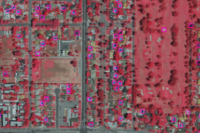

In [79]:
predicted_result = gis.content.get('793d2060d14746d19ee4c45d3eda7724')
predicted_result

In [88]:
result_map = gis.map('Redlands, CA')
result_map.add_layer(naip_item.layers[0])
result_map.add_layer(predicted_result.layers[0])
result_map = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
              'xmin': -13044535.370791622,'ymin': 4045062.583115232,
              'xmax': -13042184.932171792,'ymax': 4046018.045968822}
result_map

## Conclusion
In thise notebook, we have covered a lot of ground. In part 1, we discussed how to export training data for deep learning using ArcGIS Pro, we demonstrated how to prepare the input data, train a object detection model, visualize the results, as well as apply the model to an unseen image using the Detect Objects Using Deep Learning tool in ArcGIS Pro. 

## References
[1]
Wei Liu, Dragomir Anguelov, Dumitru Erhan, Christian Szegedy, Scott Reed, Cheng-Yang Fu: “SSD: Single Shot MultiBox Detector”, 2015; <a href='http://arxiv.org/abs/1512.02325'>arXiv:1512.02325</a>.